In [1]:
import cv2
import numpy as np

In [2]:
!pip install lmdb

In [3]:
from pathlib import Path
import cv2
import numpy as np
import lmdb


GB = 2**30
class LMDBReader:
    def __init__(self, path: Path):
        self.path = path
        self.env = None
        self.namelist_ = []

    def open(self):
        self.env = lmdb.open(self.path,
                             map_size=GB * 16,
                             lock=False,
                             subdir=False,
                             readonly=True)
        self.namelist_ = []
        with self.env.begin(buffers=True) as txn:
            cursor = txn.cursor()
            for key, _ in cursor:
                key = bytes(key).decode('utf-8')
                self.namelist_.append(key)

    def namelist(self):
        return self.namelist_

    def decode_image(self, name):
        key = name.encode('utf-8')
        with self.env.begin() as txn:
            sample = txn.get(key)
        buf = np.frombuffer(sample, dtype='uint8')
        img = cv2.imdecode(buf, cv2.IMREAD_COLOR)
        return img

    def close(self):
        self.env.close()

    def __enter__(self):
        self.open()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()


provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁",
             "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']


def parse_gtruth(raw: str) -> str:
    # 0_0_22_27_27_33_16
    ids = [int(part) for part in raw.split('_')]
    province = provinces[ids[0]]
    first = alphabets[ids[1]]
    rest = [ads[x] for x in ids[2:]]
    return ''.join([province, first] + rest)


def parse_coords(raw: str) -> str:
    # 580&528_404&533_404&465_580&460
    parts = raw.split('_')
    coords = [tuple(map(int, part.split('&'))) for part in parts]
    return coords


def parse_meta(path: str):
    if path[-3:] == 'jpg':
        path = path[:-4]
    parts = path.split('-')
    idx = parts[0]
    coords = parse_coords(parts[3])
    gtruth = parse_gtruth(parts[4])
    return idx, coords, gtruth


class CCPDHelper:
    def __init__(self, reader: LMDBReader, namelist=None):
        self.reader = reader
        self.namelist = namelist if namelist is not None else reader.namelist()

    def item(self, idx: int):
        """
        returns (img, gtruth)
          # img: [H, W, C], in RGB space
          # gtruth: str
        """
        assert idx >= 0 and idx < self.size(), "Bad index"
        name = self.namelist[idx]
        meta = name.split('/')[1]
        _, _, gtruth = parse_meta(meta)
        img = self.reader.decode_image(name)
        return img, gtruth

    def size(self) -> int:
        return len(self.namelist)

In [4]:
train_reader = LMDBReader('/content/drive/MyDrive/train.lmdb')
train_reader.open()
train_helper = CCPDHelper(train_reader)

In [5]:
names = train_reader.namelist()
SEED = 42
TRAIN_PART = 0.8

rng = np.random.default_rng(SEED)
permutation = rng.permutation(len(names))
train_size = int(len(names) * 0.8)
train_names = [names[i] for i in permutation[:train_size]]
val_names = [names[i] for i in permutation[train_size:]]

train_helper = CCPDHelper(train_reader, train_names)
val_helper = CCPDHelper(train_reader, val_names)

img0, txt0 = train_helper.item(0)

In [6]:
txt0

'皖A5A454'

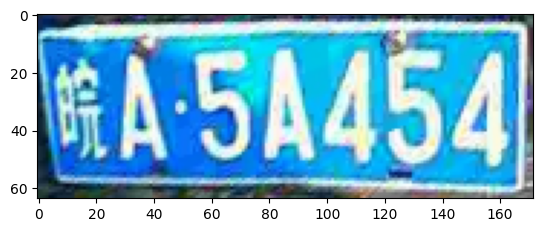

In [7]:
from matplotlib import pyplot as plt
plt.imshow(img0)

# Работа с данными

In [8]:
tokens = provinces + ads

In [9]:
tokens = list(set(tokens))

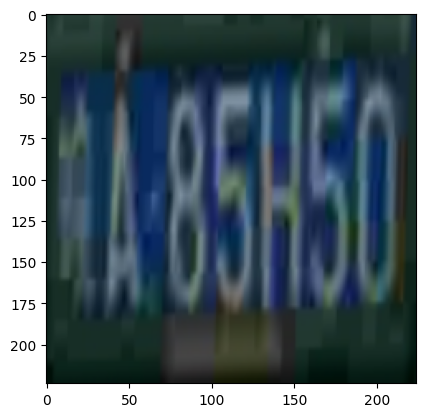

In [10]:
import albumentations as A
import matplotlib.pyplot as plt

img0, txt0 = train_helper.item(1)
transform = A.Compose([
    A.Resize(224, 224)
])

transformed_image = transform(image=np.array(img0.tolist()).astype(np.uint8))['image']

plt.imshow(transformed_image)

In [11]:
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

val_transform = A.Compose(
    [
     A.Resize(224, 224),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

In [12]:
train_helper.size()

159996

In [13]:
txt0

'皖A85H50'

In [14]:
import torch
token_to_id = dict()
id_to_token = dict()

for idx, elem in enumerate(tokens):
  token_to_id[elem] = idx
  id_to_token[idx] = elem

def process_token(token):
  res = []
  for x in token:
    res.append(token_to_id[x])
  return torch.tensor(res, dtype = torch.long)

def get_token(output):
  res = []
  for x in output:
    res.append(id_to_token[x])
  return ''.join(res)


process_token(txt0)

tensor([34,  2,  0, 21, 39, 21, 51])

In [15]:
get_token(torch.tensor([32,  7,  9,  7, 24,  9, 24]).tolist())

'F学X学湘X湘'

In [16]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
import torch

class MyDataset(Dataset):
  def __init__(self, isTrain = True):
    if isTrain:
      self.transform = train_transform
      self.items = train_helper
    else:
      self.transform = val_transform
      self.items = val_helper

  def __len__(self):
    return self.items.size()

  def __getitem__(self, idx):
    img, txt = self.items.item(idx)
    img = self.transform(image=np.array(img.tolist()).astype(np.uint8))['image']
    img = torch.tensor(img).permute(2, 0, 1).float() #.unsqueeze(0).float()
    txt = process_token(txt)
    return img, txt

In [17]:
ds = MyDataset()
ds[0]

(tensor([[[-1.6213, -1.5528, -1.4500,  ..., -1.0390, -1.2274, -1.3815],
          [-1.6213, -1.5528, -1.4329,  ..., -1.0219, -1.2274, -1.3815],
          [-1.6213, -1.5870, -1.5185,  ..., -1.0219, -1.1418, -1.2617],
          ...,
          [-1.5528, -1.5528, -1.5870,  ..., -0.0629, -0.1314, -0.1143],
          [-1.5528, -1.5699, -1.6042,  ..., -0.0972, -0.1657, -0.1143],
          [-1.5528, -1.5699, -1.6042,  ..., -0.0972, -0.1657, -0.1143]],
 
         [[-1.1779, -1.1429, -1.0728,  ..., -0.5476, -0.7577, -0.9153],
          [-1.1779, -1.1429, -1.0728,  ..., -0.5476, -0.7577, -0.9153],
          [-1.2129, -1.1779, -1.1253,  ..., -0.5476, -0.6702, -0.7927],
          ...,
          [-1.0553, -1.0553, -1.0903,  ...,  0.0651, -0.0049,  0.0126],
          [-1.0553, -1.0728, -1.1253,  ...,  0.0301, -0.0399,  0.0126],
          [-1.0553, -1.0728, -1.1253,  ...,  0.0301, -0.0399,  0.0126]],
 
         [[-0.9853, -0.8633, -0.6541,  ..., -0.4624, -0.6715, -0.8284],
          [-0.9853, -0.8633,

In [48]:
train_dataset = MyDataset(True)
train_dataloader = DataLoader(train_dataset, batch_size = 60, shuffle=True)
val_dataset = MyDataset(False)
val_dataloader = DataLoader(val_dataset, batch_size = 60)

# Модель

In [22]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

class LicensePlateReader(nn.Module):
    def __init__(self, num_classes):
        super(LicensePlateReader, self).__init__()

        resnet = models.resnet152(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        self.hidden0 = nn.Linear(2048, 400)

        self.lstm = nn.LSTM(input_size=400, hidden_size=400, bidirectional=True, num_layers=1, batch_first=True)

        self.linears = nn.ModuleList([nn.Linear(2048, 400) for _ in range(7)])
        self.classifier = nn.Sequential(nn.Linear(800, 100),
                                        nn.ReLU(),
                                        nn.Linear(100, num_classes))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.relu(x)

        h0 = self.hidden0(x).unsqueeze(0).repeat(2, 1, 1)
        c0 = torch.zeros_like(h0)

        lstm_input = [self.linears[i](x).unsqueeze(1) for i in range(7)]
        lstm_input = torch.cat(lstm_input, dim=1).to(x.device)

        x, _ = self.lstm(lstm_input, (h0, c0))

        x = self.classifier(x)
        x = F.log_softmax(x, dim=2)

        return x.permute(0, 2, 1)

num_classes = len(tokens)

In [23]:
from tqdm import tqdm

device = 'cuda'
model = LicensePlateReader(num_classes).to(device)
epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()
losses_train =[]
losses_test =[]

for i in range(epochs):
    loss_ep_train = 0
    pred_ep_train = 0

    loss_ep_test = 0
    pred_ep_test = 0
    model.train()

    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ep_train += loss
        print(get_token(y[0].tolist()), get_token(pred.argmax(dim=1)[0].tolist()))
        print(loss)

  0%|          | 1/2667 [00:02<1:51:01,  2.50s/it]

皖AP623W 警V渝警警警渝
tensor(4.2266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 2/2667 [00:03<1:23:23,  1.88s/it]

皖A63D68 皖AA2224
tensor(4.0589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 3/2667 [00:05<1:17:56,  1.76s/it]

皖AC1186 皖AA8688
tensor(3.6791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 4/2667 [00:06<1:11:29,  1.61s/it]

皖NET959 皖AA1288
tensor(3.2330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 5/2667 [00:08<1:08:21,  1.54s/it]

皖AXT170 皖AA1118
tensor(2.8638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 6/2667 [00:09<1:09:17,  1.56s/it]

皖AF296F 皖AA2221
tensor(2.6964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 7/2667 [00:11<1:07:15,  1.52s/it]

皖AS5K06 皖AA2229
tensor(2.5135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 8/2667 [00:12<1:05:22,  1.48s/it]

皖AK2Y16 皖AA7779
tensor(2.5575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 9/2667 [00:14<1:06:52,  1.51s/it]

皖AK9294 皖A77777
tensor(2.5653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 10/2667 [00:15<1:05:20,  1.48s/it]

皖A658T9 皖A77777
tensor(2.4250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 11/2667 [00:17<1:07:15,  1.52s/it]

皖AY5R60 皖A55000
tensor(2.4329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 12/2667 [00:18<1:05:13,  1.47s/it]

皖KA278L 皖AX1000
tensor(2.4396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 13/2667 [00:20<1:03:56,  1.45s/it]

皖A232B5 皖AY3000
tensor(2.4407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 14/2667 [00:21<1:05:51,  1.49s/it]

皖AQ3476 皖AY3333
tensor(2.2996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 15/2667 [00:23<1:04:25,  1.46s/it]

皖A66K90 皖AY3339
tensor(2.4619, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 16/2667 [00:24<1:03:20,  1.43s/it]

皖AU5406 皖AY5328
tensor(2.4346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 17/2667 [00:26<1:05:24,  1.48s/it]

皖AVC177 皖AK5228
tensor(2.3310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 18/2667 [00:27<1:05:22,  1.48s/it]

皖AZP348 皖AK5222
tensor(2.3188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 19/2667 [00:29<1:07:12,  1.52s/it]

皖AM4848 皖AM1222
tensor(2.3177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 20/2667 [00:30<1:05:35,  1.49s/it]

皖AF087A 皖AM1122
tensor(2.3650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 21/2667 [00:31<1:04:19,  1.46s/it]

皖AE2362 皖AM1116
tensor(2.3520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 22/2667 [00:33<1:06:05,  1.50s/it]

皖A5J887 皖AM1106
tensor(2.4579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 23/2667 [00:34<1:04:23,  1.46s/it]

皖AF5256 皖AM0606
tensor(2.3271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 24/2667 [00:36<1:03:28,  1.44s/it]

皖AHT202 皖AM0606
tensor(2.3275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 25/2667 [00:37<1:05:33,  1.49s/it]

皖AK888F 皖AM6666
tensor(2.3375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 26/2667 [00:39<1:04:39,  1.47s/it]

皖A099V2 皖AL6666
tensor(2.3684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 27/2667 [00:40<1:06:24,  1.51s/it]

皖A06J29 皖AL9666
tensor(2.2877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 28/2667 [00:42<1:04:51,  1.47s/it]

皖AA884H 皖A59999
tensor(2.3085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 29/2667 [00:43<1:03:46,  1.45s/it]

皖AM820Y 皖A59999
tensor(2.2920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 30/2667 [00:45<1:05:31,  1.49s/it]

皖AA8L69 皖AL9929
tensor(2.3727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 31/2667 [00:46<1:04:24,  1.47s/it]

皖AZ7N28 皖AH9329
tensor(2.4028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 32/2667 [00:48<1:03:53,  1.45s/it]

皖AXG192 皖AH0222
tensor(2.2823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 33/2667 [00:49<1:05:46,  1.50s/it]

皖AUK657 皖AH0022
tensor(2.4284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 34/2667 [00:51<1:05:29,  1.49s/it]

皖AHX668 皖AH0877
tensor(2.2840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 35/2667 [00:52<1:04:41,  1.47s/it]

皖AWX269 皖AH8877
tensor(2.3340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 36/2667 [00:54<1:06:09,  1.51s/it]

皖AT0Y61 皖AX6677
tensor(2.3664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 37/2667 [00:55<1:04:34,  1.47s/it]

皖AH054M 皖AX6816
tensor(2.3161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 38/2667 [00:57<1:05:58,  1.51s/it]

皖AC0X15 皖AX1116
tensor(2.3176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 39/2667 [00:58<1:04:17,  1.47s/it]

皖AHC703 皖AX1111
tensor(2.4022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 40/2667 [01:00<1:03:21,  1.45s/it]

皖A7T393 皖AX1117
tensor(2.3740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 41/2667 [01:01<1:06:00,  1.51s/it]

皖AY7998 皖AS5555
tensor(2.3309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 42/2667 [01:03<1:04:28,  1.47s/it]

皖A339G2 皖A55555
tensor(2.2807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 43/2667 [01:04<1:03:40,  1.46s/it]

皖AZ859U 皖A55555
tensor(2.2874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 44/2667 [01:06<1:05:17,  1.49s/it]

皖AL7939 皖AC5333
tensor(2.3228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 45/2667 [01:07<1:03:50,  1.46s/it]

皖AMS455 皖A55533
tensor(2.3022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 46/2667 [01:09<1:05:40,  1.50s/it]

皖A130U6 皖AC0333
tensor(2.3171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 47/2667 [01:10<1:04:05,  1.47s/it]

浙A7HY20 皖A00333
tensor(2.3066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 48/2667 [01:11<1:03:02,  1.44s/it]

皖AXC997 皖A00003
tensor(2.2969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 49/2667 [01:13<1:04:56,  1.49s/it]

皖A88E86 皖A98899
tensor(2.3167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 50/2667 [01:14<1:03:50,  1.46s/it]

皖AMD409 皖A90999
tensor(2.3801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 51/2667 [01:16<1:06:08,  1.52s/it]

皖AM922E 皖A99999
tensor(2.3030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 52/2667 [01:17<1:04:12,  1.47s/it]

皖ASB605 皖A98889
tensor(2.2504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 53/2667 [01:19<1:03:16,  1.45s/it]

皖AJN191 皖AL2228
tensor(2.2307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 54/2667 [01:20<1:05:03,  1.49s/it]

皖AV2755 皖A92228
tensor(2.2297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 55/2667 [01:22<1:03:36,  1.46s/it]

皖A271Y8 皖AL1118
tensor(2.2508, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 56/2667 [01:23<1:05:19,  1.50s/it]

皖A8G511 皖A98888
tensor(2.2611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 57/2667 [01:25<1:03:55,  1.47s/it]

皖AMN325 皖A96666
tensor(2.2910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 58/2667 [01:26<1:03:08,  1.45s/it]

皖ABL308 皖AL1116
tensor(2.3066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 59/2667 [01:28<1:05:22,  1.50s/it]

皖A197M5 皖A95666
tensor(2.2524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 60/2667 [01:29<1:03:49,  1.47s/it]

皖AE5D15 皖AL7116
tensor(2.3111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 61/2667 [01:31<1:05:28,  1.51s/it]

皖A16M56 皖A95500
tensor(2.2477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 62/2667 [01:32<1:03:52,  1.47s/it]

皖A0U035 皖A90000
tensor(2.3563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 63/2667 [01:33<1:02:39,  1.44s/it]

皖AG770N 皖A97100
tensor(2.3511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 64/2667 [01:35<1:04:39,  1.49s/it]

皖AMF317 皖A91119
tensor(2.3121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 65/2667 [01:36<1:03:27,  1.46s/it]

皖AR235U 皖A99099
tensor(2.2216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 66/2667 [01:38<1:05:27,  1.51s/it]

皖AW2A29 皖A97119
tensor(2.3236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 67/2667 [01:40<1:05:04,  1.50s/it]

皖AM2B99 皖A99959
tensor(2.2556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 68/2667 [01:41<1:03:41,  1.47s/it]

皖BB788F 皖A98888
tensor(2.2573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 69/2667 [01:43<1:05:07,  1.50s/it]

皖A92A02 皖A37777
tensor(2.1970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 70/2667 [01:44<1:03:40,  1.47s/it]

皖A127F9 皖AJ7109
tensor(2.1999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 71/2667 [01:46<1:05:13,  1.51s/it]

皖AC008Y 皖AD8088
tensor(2.1791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 72/2667 [01:47<1:03:34,  1.47s/it]

皖APL783 皖AJ0188
tensor(2.3322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 73/2667 [01:48<1:02:23,  1.44s/it]

皖A37S97 皖AJ8888
tensor(2.2008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 74/2667 [01:50<1:04:13,  1.49s/it]

皖AM001W 皖AJ2119
tensor(2.2471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 75/2667 [01:51<1:03:18,  1.47s/it]

皖AJV305 皖AJ9029
tensor(2.3033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 76/2667 [01:53<1:04:38,  1.50s/it]

豫SCQ577 皖AJ5529
tensor(2.2188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 77/2667 [01:54<1:02:59,  1.46s/it]

皖AMY999 皖AW2729
tensor(2.1530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 78/2667 [01:56<1:01:48,  1.43s/it]

皖AM262T 皖AW5229
tensor(2.2290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 79/2667 [01:57<1:03:37,  1.48s/it]

沪C0DU92 皖AW5099
tensor(2.2487, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 80/2667 [01:59<1:02:39,  1.45s/it]

皖AU523X 皖AW5699
tensor(2.2031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 81/2667 [02:00<1:04:32,  1.50s/it]

皖GB7306 皖AW0029
tensor(2.2189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 82/2667 [02:02<1:03:38,  1.48s/it]

皖EH505T 皖AW0089
tensor(2.2659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 83/2667 [02:03<1:03:30,  1.47s/it]

皖AKG950 皖A08989
tensor(2.2395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 84/2667 [02:05<1:05:09,  1.51s/it]

皖A316V7 皖A00010
tensor(2.1071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 85/2667 [02:06<1:05:42,  1.53s/it]

皖A166U6 皖AZ0000
tensor(2.1110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 86/2667 [02:08<1:06:37,  1.55s/it]

皖ALJ263 皖AZ0187
tensor(2.1365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 87/2667 [02:09<1:04:24,  1.50s/it]

皖A6V860 皖A38838
tensor(2.1186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 88/2667 [02:11<1:02:54,  1.46s/it]

皖A83T61 皖AZ3198
tensor(2.1080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 89/2667 [02:12<1:04:33,  1.50s/it]

皖AW629L 皖A37188
tensor(2.1687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 90/2667 [02:14<1:03:22,  1.48s/it]

皖AG8158 皖AH8188
tensor(2.1999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 91/2667 [02:15<1:06:18,  1.54s/it]

皖A05Z65 皖AH6766
tensor(2.0515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 92/2667 [02:17<1:04:32,  1.50s/it]

皖A5R761 皖AZ9169
tensor(2.0879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 93/2667 [02:18<1:02:41,  1.46s/it]

皖A69052 皖AG8688
tensor(2.0576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 94/2667 [02:20<1:04:24,  1.50s/it]

皖A97373 皖AL9629
tensor(2.0586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 95/2667 [02:21<1:02:51,  1.47s/it]

皖A42037 皖AL2069
tensor(2.1255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 96/2667 [02:23<1:04:26,  1.50s/it]

皖A323Y3 皖AL2069
tensor(2.1610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 97/2667 [02:24<1:03:04,  1.47s/it]

皖AE2525 皖AZ5829
tensor(1.9781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 98/2667 [02:25<1:02:03,  1.45s/it]

皖AMD002 皖AZ2000
tensor(2.0941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 99/2667 [02:27<1:05:12,  1.52s/it]

皖AGZ125 皖AZ0000
tensor(2.0094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 100/2667 [02:29<1:03:21,  1.48s/it]

皖A87Q23 皖AZ7010
tensor(2.1598, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 101/2667 [02:30<1:04:30,  1.51s/it]

皖AXQ311 皖A30070
tensor(2.1083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 102/2667 [02:32<1:04:24,  1.51s/it]

苏G05609 皖A38003
tensor(2.1318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 103/2667 [02:33<1:03:31,  1.49s/it]

皖A67X81 皖A37788
tensor(2.1364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 104/2667 [02:35<1:04:50,  1.52s/it]

皖ANQ389 皖A33088
tensor(2.0945, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 105/2667 [02:36<1:03:13,  1.48s/it]

皖AY0Z25 皖A37677
tensor(2.0886, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 106/2667 [02:38<1:05:15,  1.53s/it]

皖AY8A05 皖A38666
tensor(2.0022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 107/2667 [02:39<1:04:52,  1.52s/it]

皖AAN316 皖AY2016
tensor(2.0375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 108/2667 [02:41<1:03:19,  1.48s/it]

皖A9H077 皖AY9619
tensor(2.0364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 109/2667 [02:42<1:04:34,  1.51s/it]

皖ABJ070 皖AY0616
tensor(2.0506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 110/2667 [02:44<1:02:52,  1.48s/it]

皖AW171G 皖A29119
tensor(2.1170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 111/2667 [02:45<1:04:02,  1.50s/it]

皖KD527Q 皖AZ9110
tensor(2.1243, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 112/2667 [02:47<1:02:25,  1.47s/it]

鲁Q8TV03 皖AS0000
tensor(2.0730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 113/2667 [02:48<1:01:27,  1.44s/it]

皖AU660L 皖AS0000
tensor(1.9972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 114/2667 [02:50<1:03:37,  1.50s/it]

皖A92M85 皖AS0088
tensor(2.0290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 115/2667 [02:51<1:02:38,  1.47s/it]

皖A132E0 皖AS2068
tensor(1.9224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 116/2667 [02:53<1:04:38,  1.52s/it]

皖AMU917 皖AS8978
tensor(2.0144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 117/2667 [02:54<1:02:48,  1.48s/it]

皖A2A884 皖AS8589
tensor(2.0599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 118/2667 [02:55<1:01:33,  1.45s/it]

皖AMU111 皖AM7777
tensor(2.0208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 119/2667 [02:57<1:03:29,  1.50s/it]

皖AQ9944 皖AM8969
tensor(1.9511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 120/2667 [02:58<1:02:16,  1.47s/it]

皖A561L1 皖AM9111
tensor(1.9974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 121/2667 [03:00<1:03:58,  1.51s/it]

皖AAZ258 皖AM7286
tensor(2.0120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 122/2667 [03:01<1:02:52,  1.48s/it]

皖A899E4 皖AM8926
tensor(1.9210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 123/2667 [03:03<1:02:56,  1.48s/it]

皖A7C899 皖AM8896
tensor(1.9636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 124/2667 [03:04<1:04:20,  1.52s/it]

鄂FKT085 皖AM2080
tensor(1.9528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 125/2667 [03:06<1:02:40,  1.48s/it]

皖ABU602 皖AM6600
tensor(1.9134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 126/2667 [03:07<1:03:57,  1.51s/it]

皖AY789F 皖AM8898
tensor(1.9199, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 127/2667 [03:09<1:02:19,  1.47s/it]

皖A118Z4 皖AX8828
tensor(1.9920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 128/2667 [03:10<1:01:12,  1.45s/it]

皖AG730V 皖AX7000
tensor(1.9742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 129/2667 [03:12<1:03:26,  1.50s/it]

皖A16Y91 皖AX3098
tensor(1.8667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 130/2667 [03:13<1:02:45,  1.48s/it]

皖AP2S26 皖AL8878
tensor(1.9492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 131/2667 [03:15<1:04:40,  1.53s/it]

皖A08J88 皖A59659
tensor(1.8355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 132/2667 [03:16<1:03:18,  1.50s/it]

皖AVH678 皖A59679
tensor(1.9500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 133/2667 [03:18<1:01:53,  1.47s/it]

皖AXC517 皖AL0519
tensor(1.8901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 134/2667 [03:19<1:03:33,  1.51s/it]

皖A2H516 皖AL0519
tensor(1.9672, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 135/2667 [03:21<1:02:04,  1.47s/it]

皖AYW309 皖AL9060
tensor(1.9401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 136/2667 [03:22<1:03:34,  1.51s/it]

皖A08W78 皖AL5010
tensor(2.0161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 137/2667 [03:24<1:02:03,  1.47s/it]

皖AN8M23 皖AL5020
tensor(1.9658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 138/2667 [03:25<1:01:05,  1.45s/it]

皖A95599 皖AL8598
tensor(1.9720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 139/2667 [03:27<1:03:05,  1.50s/it]

皖AN6987 皖AL9688
tensor(1.8996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 140/2667 [03:28<1:01:33,  1.46s/it]

皖APK321 皖AL9328
tensor(1.8991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 141/2667 [03:30<1:03:04,  1.50s/it]

皖AH104L 皖AL7338
tensor(1.9046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 142/2667 [03:31<1:01:33,  1.46s/it]

皖AC107G 皖AL7378
tensor(1.7988, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 143/2667 [03:32<1:00:18,  1.43s/it]

皖AHU930 皖AL8968
tensor(1.9267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 144/2667 [03:34<1:02:46,  1.49s/it]

皖AMU322 皖AL6626
tensor(1.9411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 145/2667 [03:35<1:01:35,  1.47s/it]

皖AF786L 皖AL8868
tensor(1.8551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 146/2667 [03:37<1:03:48,  1.52s/it]

皖ARD076 皖AL6018
tensor(1.8463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 147/2667 [03:39<1:03:13,  1.51s/it]

皖AY0892 皖AL8898
tensor(1.9453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 148/2667 [03:40<1:01:56,  1.48s/it]

皖AX6W78 皖AA0028
tensor(1.8082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 149/2667 [03:42<1:03:21,  1.51s/it]

皖AHU836 皖A08868
tensor(1.8628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 150/2667 [03:43<1:01:34,  1.47s/it]

皖A312V3 皖AA1260
tensor(1.8966, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 151/2667 [03:45<1:03:08,  1.51s/it]

皖AD916A 皖AL5100
tensor(1.7317, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 152/2667 [03:46<1:01:32,  1.47s/it]

皖AB0J11 皖AW3079
tensor(2.0972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 153/2667 [03:47<1:00:34,  1.45s/it]

皖AK666W 皖AW3699
tensor(1.8956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 154/2667 [03:49<1:02:59,  1.50s/it]

皖AP0K96 皖AW3099
tensor(1.8148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 155/2667 [03:50<1:01:52,  1.48s/it]

皖AB6S58 皖AW0559
tensor(1.9028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 156/2667 [03:52<1:03:30,  1.52s/it]

皖AM222S 皖AW7277
tensor(1.8693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 157/2667 [03:53<1:02:01,  1.48s/it]

皖AHZ884 皖AX0558
tensor(1.8004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 158/2667 [03:55<1:01:02,  1.46s/it]

皖AU5483 皖AX9688
tensor(1.8380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 159/2667 [03:56<1:02:47,  1.50s/it]

皖AB613L 皖AX3160
tensor(1.8605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 160/2667 [03:58<1:01:27,  1.47s/it]

皖AD0S88 皖A20558
tensor(1.8091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 161/2667 [03:59<1:03:02,  1.51s/it]

皖ABZ837 皖AD6566
tensor(1.8006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 162/2667 [04:01<1:01:59,  1.48s/it]

皖AEN106 皖AD5136
tensor(1.9013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 163/2667 [04:02<1:01:13,  1.47s/it]

皖A5S028 皖AD5026
tensor(1.8496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 164/2667 [04:04<1:03:04,  1.51s/it]

皖AD6J50 皖AD6088
tensor(1.7522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 165/2667 [04:05<1:01:31,  1.48s/it]

皖AN212C 皖AA1727
tensor(1.8688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 166/2667 [04:07<1:02:56,  1.51s/it]

皖LPQ568 皖AD0868
tensor(1.8413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 167/2667 [04:08<1:01:48,  1.48s/it]

皖A580B5 皖AF8088
tensor(1.8010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 168/2667 [04:10<1:00:45,  1.46s/it]

皖AH068R 皖AL9688
tensor(1.8033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 169/2667 [04:11<1:02:32,  1.50s/it]

皖A53S55 皖AL8888
tensor(1.8628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 170/2667 [04:13<1:01:35,  1.48s/it]

皖AH6H85 皖AL6089
tensor(1.7612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 171/2667 [04:14<1:04:11,  1.54s/it]

皖AH4559 皖AL9889
tensor(1.7898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 172/2667 [04:16<1:02:29,  1.50s/it]

皖CE1682 皖AL7689
tensor(1.8898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 173/2667 [04:17<1:01:11,  1.47s/it]

皖AW007F 皖AL6079
tensor(1.8604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 174/2667 [04:19<1:02:52,  1.51s/it]

皖ACV738 皖AL6769
tensor(1.7909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 175/2667 [04:20<1:01:23,  1.48s/it]

皖AK896A 皖AL8968
tensor(1.7975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 176/2667 [04:22<1:02:50,  1.51s/it]

皖AJS866 皖AL8868
tensor(1.6983, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 177/2667 [04:23<1:01:16,  1.48s/it]

皖NL008Y 皖AA0089
tensor(1.7756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 178/2667 [04:25<1:00:15,  1.45s/it]

皖AVY319 皖AA6611
tensor(1.7519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 179/2667 [04:26<1:02:44,  1.51s/it]

皖A699D2 皖AB9609
tensor(1.6679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 180/2667 [04:28<1:01:11,  1.48s/it]

皖A198J1 皖AL9869
tensor(1.7907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 181/2667 [04:29<1:02:27,  1.51s/it]

皖AJS990 皖AL9999
tensor(1.6468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 182/2667 [04:31<1:01:09,  1.48s/it]

皖ACJ415 皖AL3611
tensor(1.7852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 183/2667 [04:32<1:00:08,  1.45s/it]

皖AS115X 皖AT1151
tensor(1.8064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 184/2667 [04:34<1:01:52,  1.50s/it]

皖ARP908 皖AL0909
tensor(1.7324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 185/2667 [04:35<1:01:06,  1.48s/it]

皖K6Z167 皖AL6165
tensor(1.6702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 186/2667 [04:37<1:02:49,  1.52s/it]

皖AE691A 皖AL7915
tensor(1.7973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 187/2667 [04:38<1:01:55,  1.50s/it]

皖AV4456 皖A52655
tensor(1.6837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 188/2667 [04:39<1:00:50,  1.47s/it]

皖A69E59 皖A59555
tensor(1.8793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 189/2667 [04:41<1:02:29,  1.51s/it]

皖AUU209 皖A50205
tensor(1.6917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 190/2667 [04:42<1:00:42,  1.47s/it]

皖AZ3Z58 皖AC0756
tensor(1.7587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 191/2667 [04:44<1:02:06,  1.51s/it]

皖AMP770 皖AC0776
tensor(1.7100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 192/2667 [04:45<1:00:42,  1.47s/it]

皖AND218 皖AC0218
tensor(1.7242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 193/2667 [04:47<59:32,  1.44s/it]  

皖AJK358 皖AC8388
tensor(1.7071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 194/2667 [04:48<1:01:29,  1.49s/it]

皖AXG300 皖AC0308
tensor(1.8256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 195/2667 [04:50<1:00:41,  1.47s/it]

皖AX329W 皖AC0698
tensor(1.7994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 196/2667 [04:51<1:02:34,  1.52s/it]

皖AQZ102 皖AC2108
tensor(1.6880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 197/2667 [04:53<1:01:06,  1.48s/it]

皖A21L17 皖AZ1318
tensor(1.7319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 198/2667 [04:54<1:00:05,  1.46s/it]

皖AJ190Y 皖AZ1909
tensor(1.6632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 199/2667 [04:56<1:01:51,  1.50s/it]

皖A377C2 皖AZ1709
tensor(1.6823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 200/2667 [04:57<1:00:20,  1.47s/it]

皖A730H3 皖AZ3009
tensor(1.7542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 201/2667 [04:59<1:01:47,  1.50s/it]

皖KQ2357 皖AZ2357
tensor(1.6224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 202/2667 [05:00<1:00:18,  1.47s/it]

皖A67555 皖A71857
tensor(1.7203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 203/2667 [05:02<59:37,  1.45s/it]  

皖AA587S 皖A05577
tensor(1.6166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 204/2667 [05:03<1:01:29,  1.50s/it]

皖AS338A 皖A03380
tensor(1.6477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 205/2667 [05:05<1:00:28,  1.47s/it]

皖ACJ971 皖A00978
tensor(1.7389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 206/2667 [05:06<1:02:10,  1.52s/it]

皖A678H1 皖A01808
tensor(1.6728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 207/2667 [05:08<1:00:49,  1.48s/it]

皖AL3625 皖AZ3628
tensor(1.6171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 208/2667 [05:09<59:52,  1.46s/it]  

皖AWY181 皖AZ6188
tensor(1.6647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 209/2667 [05:11<1:01:31,  1.50s/it]

皖ALS007 皖A85008
tensor(1.6036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 210/2667 [05:12<1:00:27,  1.48s/it]

皖AG017G 皖AZ0171
tensor(1.6260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 211/2667 [05:14<1:03:40,  1.56s/it]

皖AF005F 皖AX0356
tensor(1.7144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 212/2667 [05:15<1:01:37,  1.51s/it]

皖A45819 皖AZ8511
tensor(1.6654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 213/2667 [05:17<1:00:20,  1.48s/it]

皖AUY589 皖AZ1888
tensor(1.6142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 214/2667 [05:18<1:01:51,  1.51s/it]

皖AAR199 皖AX5199
tensor(1.7620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 215/2667 [05:20<1:00:05,  1.47s/it]

皖AW998A 皖AX9989
tensor(1.5793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 216/2667 [05:21<1:01:24,  1.50s/it]

苏EG5C79 皖AX0079
tensor(1.7191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 217/2667 [05:23<1:00:03,  1.47s/it]

皖AC3335 皖AX3333
tensor(1.6084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 218/2667 [05:24<59:06,  1.45s/it]  

皖AC2824 皖AY7823
tensor(1.7207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 219/2667 [05:26<1:01:34,  1.51s/it]

皖AG5Z79 皖AY8278
tensor(1.6841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 220/2667 [05:27<1:00:12,  1.48s/it]

皖KU7363 皖AY7360
tensor(1.5337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 221/2667 [05:29<1:01:47,  1.52s/it]

皖N0W231 皖AX0260
tensor(1.5554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 222/2667 [05:30<1:00:19,  1.48s/it]

皖AA004L 皖AX0060
tensor(1.5865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 223/2667 [05:31<59:26,  1.46s/it]  

皖A5X175 皖AX0178
tensor(1.5065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 224/2667 [05:33<1:01:04,  1.50s/it]

皖AJ821Z 皖AX5278
tensor(1.6123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 225/2667 [05:34<59:43,  1.47s/it]  

皖AL8D88 皖AX5088
tensor(1.5999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 226/2667 [05:36<1:01:59,  1.52s/it]

皖HH7702 皖AZ2708
tensor(1.5639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 227/2667 [05:38<1:01:34,  1.51s/it]

皖A72D29 皖AZ2028
tensor(1.5357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 228/2667 [05:39<1:00:06,  1.48s/it]

皖AY326J 皖AX3268
tensor(1.6431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 229/2667 [05:41<1:01:29,  1.51s/it]

皖SWS167 皖AA8166
tensor(1.5627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 230/2667 [05:42<1:00:15,  1.48s/it]

皖A970K1 皖AZ1026
tensor(1.6019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 231/2667 [05:44<1:01:28,  1.51s/it]

皖AY6F08 皖AZ6008
tensor(1.5560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 232/2667 [05:45<59:59,  1.48s/it]  

皖A9D610 皖AZ0619
tensor(1.5575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 233/2667 [05:46<58:53,  1.45s/it]

皖AA4599 皖A06598
tensor(1.5969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 234/2667 [05:48<1:00:50,  1.50s/it]

皖A3K123 皖AD0128
tensor(1.7207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 235/2667 [05:50<1:01:08,  1.51s/it]

皖ARG363 皖AD0368
tensor(1.7000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 236/2667 [05:51<1:02:28,  1.54s/it]

皖AKA696 皖AD6699
tensor(1.6753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 237/2667 [05:53<1:00:51,  1.50s/it]

皖AS325X 皖AD3258
tensor(1.5896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 238/2667 [05:54<59:34,  1.47s/it]  

皖AYW111 皖AD5111
tensor(1.6478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 239/2667 [05:56<1:01:07,  1.51s/it]

皖AYY728 皖AD6121
tensor(1.6588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 240/2667 [05:57<59:44,  1.48s/it]  

皖P41440 皖AH1666
tensor(1.7153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 241/2667 [05:59<1:01:11,  1.51s/it]

皖AQA530 皖AD6536
tensor(1.5501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 242/2667 [06:00<59:49,  1.48s/it]  

皖AYE717 皖AH0716
tensor(1.7518, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 243/2667 [06:01<59:03,  1.46s/it]

皖A3B801 皖A03803
tensor(1.5750, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 244/2667 [06:03<1:00:33,  1.50s/it]

皖AB192C 皖AA1927
tensor(1.6155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 245/2667 [06:04<59:22,  1.47s/it]  

皖A24676 皖AA6677
tensor(1.6634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 246/2667 [06:06<1:00:54,  1.51s/it]

皖AHQ695 皖AL0395
tensor(1.6250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 247/2667 [06:07<59:36,  1.48s/it]  

皖AMZ029 皖AL2022
tensor(1.5190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 248/2667 [06:09<58:48,  1.46s/it]

皖A50F76 皖AX0077
tensor(1.4971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 249/2667 [06:10<1:00:38,  1.50s/it]

皖AY9965 皖AX9961
tensor(1.6519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 250/2667 [06:12<59:31,  1.48s/it]  

皖AZ1F00 皖AX1001
tensor(1.6230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 251/2667 [06:13<1:01:11,  1.52s/it]

皖AM5426 皖AX8921
tensor(1.6577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 252/2667 [06:15<59:45,  1.48s/it]  

皖A298L7 皖AX9551
tensor(1.5651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 253/2667 [06:16<58:56,  1.47s/it]

皖AH602E 皖AX6026
tensor(1.5942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 254/2667 [06:18<1:00:13,  1.50s/it]

鄂D1LQ38 皖AX2036
tensor(1.5522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 255/2667 [06:19<58:47,  1.46s/it]  

皖A17M73 皖AZ1077
tensor(1.5063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 256/2667 [06:21<1:00:32,  1.51s/it]

皖AZ5328 皖AD8328
tensor(1.5967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 257/2667 [06:22<59:08,  1.47s/it]  

皖A29346 皖AD9368
tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 258/2667 [06:24<58:23,  1.45s/it]

皖AR301W 皖AD3018
tensor(1.5906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 259/2667 [06:25<1:01:25,  1.53s/it]

皖ACM432 皖AY0338
tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 260/2667 [06:27<59:51,  1.49s/it]  

皖A466F4 皖AY6608
tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 261/2667 [06:28<1:01:17,  1.53s/it]

皖ADB828 皖AY8828
tensor(1.5644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 262/2667 [06:30<59:38,  1.49s/it]  

皖AEX005 皖AY9008
tensor(1.5313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 263/2667 [06:31<58:34,  1.46s/it]

皖AZ757F 皖AY7879
tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 264/2667 [06:33<1:00:09,  1.50s/it]

皖AF976S 皖AY9769
tensor(1.5448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 265/2667 [06:34<58:50,  1.47s/it]  

皖ALX115 皖AYC117
tensor(1.5347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 266/2667 [06:36<1:00:16,  1.51s/it]

皖ATB060 皖A25060
tensor(1.5727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 267/2667 [06:37<59:14,  1.48s/it]  

皖AGC162 皖AY0160
tensor(1.5149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 268/2667 [06:39<57:59,  1.45s/it]

皖A91918 皖AY1979
tensor(1.5742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 269/2667 [06:40<1:00:05,  1.50s/it]

皖A884Y8 皖AH5669
tensor(1.5725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 270/2667 [06:42<58:39,  1.47s/it]  

皖A019G0 皖AY1909
tensor(1.5505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 271/2667 [06:43<1:00:07,  1.51s/it]

皖AY9352 皖AH9359
tensor(1.5605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 272/2667 [06:45<58:58,  1.48s/it]  

皖AJ9X21 皖AH9028
tensor(1.6860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 273/2667 [06:46<58:02,  1.45s/it]

皖L1L512 皖AH3511
tensor(1.5983, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 274/2667 [06:48<1:00:02,  1.51s/it]

皖AUY707 皖AH6708
tensor(1.4965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 275/2667 [06:49<1:00:10,  1.51s/it]

皖A73055 皖A03058
tensor(1.4766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 276/2667 [06:51<1:01:20,  1.54s/it]

皖AFY156 皖AL2158
tensor(1.6062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 277/2667 [06:52<59:32,  1.49s/it]  

皖APD377 皖A00376
tensor(1.5399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 278/2667 [06:53<58:12,  1.46s/it]

皖AST526 皖A07828
tensor(1.6219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 279/2667 [06:55<1:00:07,  1.51s/it]

皖A99V83 皖A09688
tensor(1.5836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 280/2667 [06:56<58:34,  1.47s/it]  

皖K02H65 皖A02066
tensor(1.4899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 281/2667 [06:58<59:56,  1.51s/it]

皖A24V77 皖A66376
tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 282/2667 [06:59<58:41,  1.48s/it]

皖AX5N55 皖A08556
tensor(1.5267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 283/2667 [07:01<58:02,  1.46s/it]

皖AG325W 皖AW3256
tensor(1.5750, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 284/2667 [07:02<59:38,  1.50s/it]

皖A32625 皖AW2626
tensor(1.6214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 285/2667 [07:04<58:20,  1.47s/it]

皖AH689S 皖AW6596
tensor(1.5921, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 286/2667 [07:05<59:58,  1.51s/it]

浙A389XM 皖AW8990
tensor(1.5343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 287/2667 [07:07<58:40,  1.48s/it]

皖AHR708 皖AW5705
tensor(1.5160, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 288/2667 [07:08<57:38,  1.45s/it]

皖A37921 皖AW1925
tensor(1.5071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 289/2667 [07:10<59:38,  1.50s/it]

皖ABM089 皖AW0088
tensor(1.5580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 290/2667 [07:11<58:33,  1.48s/it]

皖AZW579 皖AW0877
tensor(1.4899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 291/2667 [07:13<1:00:16,  1.52s/it]

皖A590J7 皖A99339
tensor(1.5894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 292/2667 [07:14<58:48,  1.49s/it]  

皖M36288 皖A26285
tensor(1.5016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 293/2667 [07:16<58:09,  1.47s/it]

皖A199L5 皖A59905
tensor(1.6106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 294/2667 [07:17<59:37,  1.51s/it]

皖A89Q95 皖A59099
tensor(1.5771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 295/2667 [07:19<58:19,  1.48s/it]

皖AC8M59 皖A28555
tensor(1.5114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 296/2667 [07:20<59:43,  1.51s/it]

皖A73C70 皖A23077
tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 297/2667 [07:22<58:18,  1.48s/it]

皖NWF518 皖AH5511
tensor(1.5558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 298/2667 [07:23<57:33,  1.46s/it]

皖AY9T96 皖AH9798
tensor(1.4982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 299/2667 [07:25<59:30,  1.51s/it]

皖AXS013 皖AH8011
tensor(1.4578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 300/2667 [07:26<58:17,  1.48s/it]

皖AY415Z 皖AH6151
tensor(1.5613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 301/2667 [07:28<59:48,  1.52s/it]

皖AU292D 皖A12921
tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 302/2667 [07:29<58:19,  1.48s/it]

皖AY1Z88 皖AX1251
tensor(1.5226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 303/2667 [07:31<57:27,  1.46s/it]

皖AQW086 皖AX0089
tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 304/2667 [07:32<59:00,  1.50s/it]

皖A46228 皖AXV229
tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 305/2667 [07:34<57:55,  1.47s/it]

皖AY2G69 皖AX2069
tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 306/2667 [07:35<1:00:21,  1.53s/it]

皖AP262H 皖AY2629
tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 307/2667 [07:37<58:57,  1.50s/it]  

皖A0T011 皖AP1319
tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 308/2667 [07:38<57:44,  1.47s/it]

皖AK1Y31 皖AP1639
tensor(1.5265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 309/2667 [07:40<59:15,  1.51s/it]

皖AC218C 皖AY2188
tensor(1.4099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 310/2667 [07:41<58:07,  1.48s/it]

皖A52B79 皖AD2579
tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 311/2667 [07:43<59:28,  1.51s/it]

皖ASU176 皖AD0177
tensor(1.4974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 312/2667 [07:44<58:05,  1.48s/it]

皖A237W1 皖AD3750
tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 313/2667 [07:46<56:57,  1.45s/it]

皖A879G7 皖AY1950
tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 314/2667 [07:47<58:53,  1.50s/it]

皖LD0590 皖A30892
tensor(1.4843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 315/2667 [07:49<58:04,  1.48s/it]

皖AX1560 皖AZ1862
tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 316/2667 [07:50<59:21,  1.51s/it]

皖AG855D 皖A38552
tensor(1.5947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 317/2667 [07:52<57:55,  1.48s/it]

皖AH207R 皖AZ4072
tensor(1.4611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 318/2667 [07:53<56:48,  1.45s/it]

皖AS7X84 皖AZ7389
tensor(1.4890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 319/2667 [07:55<58:33,  1.50s/it]

皖ATF403 皖AWX609
tensor(1.4229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 320/2667 [07:56<57:22,  1.47s/it]

皖PYH975 皖AWE978
tensor(1.5145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 321/2667 [07:58<58:40,  1.50s/it]

皖AJJ396 皖AZ6399
tensor(1.4700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 322/2667 [07:59<57:34,  1.47s/it]

皖AW6R78 皖AW6E72
tensor(1.5464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 323/2667 [08:00<57:09,  1.46s/it]

皖AAA626 皖AZ2626
tensor(1.4131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 324/2667 [08:02<58:47,  1.51s/it]

皖AK691K 皖A66916
tensor(1.5295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 325/2667 [08:03<57:26,  1.47s/it]

皖AK200R 皖AX2006
tensor(1.4994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 326/2667 [08:05<58:51,  1.51s/it]

皖AUU289 皖AXM286
tensor(1.5090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 327/2667 [08:06<57:26,  1.47s/it]

皖DGG718 皖AXH716
tensor(1.5783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 328/2667 [08:08<56:36,  1.45s/it]

皖ABH614 皖AXH616
tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 329/2667 [08:09<58:17,  1.50s/it]

皖AY7N26 皖AX7N26
tensor(1.5552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 330/2667 [08:11<57:30,  1.48s/it]

皖A1Y538 皖AZ7836
tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 331/2667 [08:12<59:57,  1.54s/it]

皖A5R636 皖AX5636
tensor(1.5477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 332/2667 [08:14<57:53,  1.49s/it]

皖N0K788 皖AGN788
tensor(1.5180, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 333/2667 [08:15<57:02,  1.47s/it]

皖AX993S 皖AZ9938
tensor(1.4335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 334/2667 [08:17<58:47,  1.51s/it]

皖AL2766 皖AZ2767
tensor(1.5115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 335/2667 [08:18<57:27,  1.48s/it]

皖A72P02 皖AZ2008
tensor(1.4321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 336/2667 [08:20<58:45,  1.51s/it]

皖HS3626 皖AZ3628
tensor(1.4423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 337/2667 [08:21<57:38,  1.48s/it]

皖A826A6 皖AY2645
tensor(1.3831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 338/2667 [08:23<56:50,  1.46s/it]

苏A1N5R6 皖A50555
tensor(1.5543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 339/2667 [08:24<59:09,  1.52s/it]

皖ADY646 皖AK1645
tensor(1.4625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 340/2667 [08:26<57:47,  1.49s/it]

皖A99B75 皖A99519
tensor(1.4731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 341/2667 [08:27<59:00,  1.52s/it]

皖AUK221 皖A95225
tensor(1.4651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 342/2667 [08:29<57:28,  1.48s/it]

皖AM0H01 皖A00K59
tensor(1.4195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 343/2667 [08:30<56:17,  1.45s/it]

皖AF893Z 皖A98930
tensor(1.4274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 344/2667 [08:32<57:47,  1.49s/it]

皖AL246T 皖A02360
tensor(1.5814, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 345/2667 [08:33<56:34,  1.46s/it]

皖A358R1 皖A88850
tensor(1.5767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 346/2667 [08:35<58:20,  1.51s/it]

冀F88P94 皖A88596
tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 347/2667 [08:36<57:47,  1.49s/it]

皖AT1H27 皖A81C28
tensor(1.4045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 348/2667 [08:38<56:40,  1.47s/it]

皖AN915D 皖A89188
tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 349/2667 [08:39<58:07,  1.50s/it]

皖AB922T 皖A89228
tensor(1.4229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 350/2667 [08:41<56:39,  1.47s/it]

皖AL5H57 皖A55558
tensor(1.3891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 351/2667 [08:42<58:35,  1.52s/it]

皖AS466Y 皖AY6667
tensor(1.3846, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 352/2667 [08:44<57:06,  1.48s/it]

皖DY099Y 皖AL0998
tensor(1.4600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 353/2667 [08:45<55:56,  1.45s/it]

皖AE005L 皖AL0053
tensor(1.4555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 354/2667 [08:47<57:34,  1.49s/it]

皖A85U97 皖AL5C99
tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 355/2667 [08:48<57:08,  1.48s/it]

皖AG0464 皖AL0663
tensor(1.4397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 356/2667 [08:50<58:30,  1.52s/it]

皖A35901 皖AL5903
tensor(1.3727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 357/2667 [08:51<56:49,  1.48s/it]

皖AP700M 皖AL7000
tensor(1.4052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 358/2667 [08:52<55:48,  1.45s/it]

皖AC5C20 皖A95C23
tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 359/2667 [08:54<57:41,  1.50s/it]

皖AGU369 皖AXC366
tensor(1.3913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 360/2667 [08:55<56:27,  1.47s/it]

皖AVV851 皖A53800
tensor(1.4971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 361/2667 [08:57<57:58,  1.51s/it]

湘E269JY 皖AX9946
tensor(1.4255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 362/2667 [08:58<56:47,  1.48s/it]

皖ACJ162 皖AX6166
tensor(1.4424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 363/2667 [09:00<56:40,  1.48s/it]

皖A6X381 皖AXX380
tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 364/2667 [09:02<58:13,  1.52s/it]

皖A59B18 皖AB9515
tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 365/2667 [09:03<56:44,  1.48s/it]

皖AWT614 皖AY1617
tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 366/2667 [09:05<58:15,  1.52s/it]

皖AH8L09 皖A58K05
tensor(1.4270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 367/2667 [09:06<56:46,  1.48s/it]

皖AR720F 皖AZ7200
tensor(1.3877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 368/2667 [09:07<55:44,  1.45s/it]

皖A58N96 皖AG8K96
tensor(1.3130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 369/2667 [09:09<57:29,  1.50s/it]

皖AD1677 皖AF1677
tensor(1.3663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 370/2667 [09:10<56:20,  1.47s/it]

皖ACP122 皖AFK127
tensor(1.3542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 371/2667 [09:12<59:35,  1.56s/it]

皖ALX393 皖AFJ396
tensor(1.4103, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 372/2667 [09:13<57:46,  1.51s/it]

皖A68059 皖AB8050
tensor(1.3807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 373/2667 [09:15<56:27,  1.48s/it]

皖AY6A09 皖AF6407
tensor(1.3335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 374/2667 [09:16<58:06,  1.52s/it]

皖AE510L 皖AF5100
tensor(1.3831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 375/2667 [09:18<56:45,  1.49s/it]

皖AB179X 皖AF1799
tensor(1.4571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 376/2667 [09:20<58:19,  1.53s/it]

鄂D6X580 皖A0X589
tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 377/2667 [09:21<56:47,  1.49s/it]

皖A8C013 皖AHC019
tensor(1.4162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 378/2667 [09:22<55:58,  1.47s/it]

皖A5V558 皖A03559
tensor(1.3360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 379/2667 [09:24<58:28,  1.53s/it]

皖AN0084 皖A00088
tensor(1.3423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 380/2667 [09:25<56:54,  1.49s/it]

皖A5R170 皖AH5178
tensor(1.4402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 381/2667 [09:27<58:00,  1.52s/it]

皖AT229P 皖AZ2298
tensor(1.3306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 382/2667 [09:28<56:33,  1.49s/it]

皖AE767H 皖AY7678
tensor(1.3441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 383/2667 [09:30<55:22,  1.45s/it]

皖A6Z380 皖AYZ388
tensor(1.3050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 384/2667 [09:31<57:01,  1.50s/it]

皖AD311G 皖AY3118
tensor(1.3390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 385/2667 [09:33<55:48,  1.47s/it]

皖A4U366 皖AYM366
tensor(1.2958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 386/2667 [09:34<57:43,  1.52s/it]

皖AT9Z19 皖AY9218
tensor(1.3490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 387/2667 [09:36<57:29,  1.51s/it]

皖AMZ669 皖AYZ666
tensor(1.3593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 388/2667 [09:37<56:24,  1.49s/it]

皖AF7429 皖AY7426
tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 389/2667 [09:39<57:52,  1.52s/it]

皖AH5Y61 皖AD5166
tensor(1.3394, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 390/2667 [09:40<56:29,  1.49s/it]

皖A11K28 皖AY1528
tensor(1.4174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 391/2667 [09:42<57:51,  1.53s/it]

皖AL7D00 皖A67000
tensor(1.2165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 392/2667 [09:43<56:40,  1.49s/it]

皖AM062J 皖AD0626
tensor(1.3781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 393/2667 [09:45<55:29,  1.46s/it]

皖A75U66 皖A55H66
tensor(1.3581, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 394/2667 [09:46<57:12,  1.51s/it]

皖AWL203 皖A5H200
tensor(1.4160, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 395/2667 [09:48<55:56,  1.48s/it]

皖A773N9 皖A57300
tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 396/2667 [09:49<57:05,  1.51s/it]

皖A112J1 皖AS1230
tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 397/2667 [09:51<55:51,  1.48s/it]

苏D21C67 皖A91L49
tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 398/2667 [09:52<54:52,  1.45s/it]

皖AC2778 皖AL2777
tensor(1.3791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 399/2667 [09:54<56:17,  1.49s/it]

皖QLS626 皖A98629
tensor(1.3354, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 400/2667 [09:55<54:58,  1.45s/it]

皖AD6101 皖AL6107
tensor(1.3659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 401/2667 [09:57<56:51,  1.51s/it]

皖AL6G50 皖AL6C59
tensor(1.3084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 402/2667 [09:58<55:44,  1.48s/it]

皖AD3393 皖AL3399
tensor(1.4381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 403/2667 [10:00<55:15,  1.46s/it]

皖AH1315 皖AZ1318
tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 404/2667 [10:01<56:50,  1.51s/it]

皖A57B24 皖AZ7828
tensor(1.3574, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 405/2667 [10:03<55:23,  1.47s/it]

皖AE8W66 皖AW8566
tensor(1.3255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 406/2667 [10:04<56:42,  1.50s/it]

皖AH9G29 皖AW9523
tensor(1.3409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 407/2667 [10:06<55:26,  1.47s/it]

皖A2D299 皖A00298
tensor(1.2597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 408/2667 [10:07<54:29,  1.45s/it]

皖AUX275 皖A0X278
tensor(1.3612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 409/2667 [10:09<56:15,  1.49s/it]

皖ATP126 皖AW5128
tensor(1.2533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 410/2667 [10:10<55:17,  1.47s/it]

皖AFY405 皖A7Y300
tensor(1.3197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 411/2667 [10:12<57:52,  1.54s/it]

皖AVV773 皖AYX778
tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 412/2667 [10:13<56:30,  1.50s/it]

皖AE0887 皖A10888
tensor(1.2830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 413/2667 [10:15<55:28,  1.48s/it]

皖AJ5939 皖AH5938
tensor(1.2827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 414/2667 [10:16<57:10,  1.52s/it]

皖AKJ307 皖AY4308
tensor(1.3041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 415/2667 [10:18<55:37,  1.48s/it]

皖AHV868 皖A13869
tensor(1.3832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 416/2667 [10:19<56:51,  1.52s/it]

皖AHD535 皖AH0539
tensor(1.2920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 417/2667 [10:21<55:31,  1.48s/it]

皖G97025 皖AZ7022
tensor(1.4043, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 418/2667 [10:22<54:48,  1.46s/it]

皖AT768X 皖AZ7689
tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 419/2667 [10:24<56:49,  1.52s/it]

皖AR823J 皖AH8230
tensor(1.3462, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 420/2667 [10:25<55:26,  1.48s/it]

皖AZR838 皖A05830
tensor(1.3595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 421/2667 [10:27<56:33,  1.51s/it]

皖AW0X57 皖A00X50
tensor(1.2847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 422/2667 [10:28<55:11,  1.48s/it]

皖A50X18 皖A30X18
tensor(1.2735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 423/2667 [10:29<54:15,  1.45s/it]

皖A5X255 皖A3X258
tensor(1.3770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 424/2667 [10:31<55:32,  1.49s/it]

皖A92C28 皖AZ2L28
tensor(1.4081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 425/2667 [10:32<54:39,  1.46s/it]

皖A46X28 皖AZ6X28
tensor(1.3631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 426/2667 [10:34<56:45,  1.52s/it]

皖ABP087 皖AS5088
tensor(1.4097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 427/2667 [10:35<56:09,  1.50s/it]

皖AM4169 皖AXA168
tensor(1.3024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 428/2667 [10:37<55:03,  1.48s/it]

皖A72N60 皖AZ2L68
tensor(1.3117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 429/2667 [10:38<56:24,  1.51s/it]

皖AZ999S 皖A89998
tensor(1.3615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 430/2667 [10:40<55:06,  1.48s/it]

皖ARC665 皖AXM668
tensor(1.2932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 431/2667 [10:41<56:22,  1.51s/it]

皖AXH705 皖AXM708
tensor(1.2735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 432/2667 [10:43<54:58,  1.48s/it]

皖AD3H99 皖A33M99
tensor(1.2200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 433/2667 [10:44<54:28,  1.46s/it]

皖AH5H91 皖AV5M99
tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 434/2667 [10:46<56:08,  1.51s/it]

皖AS7Z95 皖A17799
tensor(1.2891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 435/2667 [10:47<55:27,  1.49s/it]

皖AYJ356 皖A64359
tensor(1.2439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 436/2667 [10:49<56:42,  1.52s/it]

皖AS1035 皖A01037
tensor(1.2216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 437/2667 [10:50<55:10,  1.48s/it]

皖SE6R99 皖A06F91
tensor(1.3079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 438/2667 [10:52<54:09,  1.46s/it]

皖R37039 皖A17037
tensor(1.3498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 439/2667 [10:53<55:48,  1.50s/it]

皖AT056N 皖A00568
tensor(1.4470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 440/2667 [10:55<54:24,  1.47s/it]

皖AC0X33 皖A00X37
tensor(1.2860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 441/2667 [10:56<55:48,  1.50s/it]

皖ASX379 皖AHX377
tensor(1.2587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 442/2667 [10:58<55:01,  1.48s/it]

皖A2G211 皖AH0217
tensor(1.2933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 443/2667 [10:59<55:38,  1.50s/it]

皖ARK372 皖AHH377
tensor(1.3062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 444/2667 [11:01<57:08,  1.54s/it]

皖AX1862 皖AH1866
tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 445/2667 [11:02<55:29,  1.50s/it]

皖AG5E20 皖AH5H26
tensor(1.3474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 446/2667 [11:04<56:47,  1.53s/it]

皖N74222 皖AHJ220
tensor(1.3501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 447/2667 [11:05<55:00,  1.49s/it]

苏LGY501 皖AY6500
tensor(1.3743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 448/2667 [11:07<53:52,  1.46s/it]

皖A0V747 皖AYX746
tensor(1.2542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 449/2667 [11:08<55:40,  1.51s/it]

皖AAT733 皖AYT736
tensor(1.2518, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 450/2667 [11:10<55:00,  1.49s/it]

皖AEV055 皖AYX059
tensor(1.3420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 451/2667 [11:11<56:52,  1.54s/it]

皖A171W8 皖AY71L9
tensor(1.2862, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 452/2667 [11:13<55:28,  1.50s/it]

苏EV6W89 皖AY6L89
tensor(1.3191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 453/2667 [11:14<54:33,  1.48s/it]

皖AH0155 皖AY0155
tensor(1.3233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 454/2667 [11:16<56:22,  1.53s/it]

皖AV1D01 皖AY1005
tensor(1.3592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 455/2667 [11:17<54:59,  1.49s/it]

苏E9201G 皖AZ2015
tensor(1.3094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 456/2667 [11:19<56:06,  1.52s/it]

皖AL4W09 皖AZ4C00
tensor(1.3697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 457/2667 [11:20<54:55,  1.49s/it]

皖AGP363 皖AVP360
tensor(1.2927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 458/2667 [11:22<54:24,  1.48s/it]

皖AP879E 皖AV8790
tensor(1.3426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 459/2667 [11:23<56:27,  1.53s/it]

皖A87172 皖AZ7170
tensor(1.4079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 460/2667 [11:25<54:54,  1.49s/it]

皖A773M3 皖AZ7350
tensor(1.2405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 461/2667 [11:26<56:01,  1.52s/it]

皖AL017P 皖AX0177
tensor(1.3957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 462/2667 [11:28<54:28,  1.48s/it]

皖A18P12 皖A98519
tensor(1.2884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 463/2667 [11:29<53:31,  1.46s/it]

皖A079F7 皖A979X0
tensor(1.3812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 464/2667 [11:31<55:05,  1.50s/it]

皖AL4067 皖A04060
tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 465/2667 [11:32<53:52,  1.47s/it]

皖A121L9 皖A021N7
tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 466/2667 [11:34<55:54,  1.52s/it]

皖ASG707 皖AXW707
tensor(1.3990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 467/2667 [11:35<55:04,  1.50s/it]

皖AFE983 皖ALF989
tensor(1.3423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 468/2667 [11:37<54:04,  1.48s/it]

皖A39208 皖AL9201
tensor(1.3282, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 469/2667 [11:38<55:29,  1.52s/it]

皖A9Z884 皖AL2889
tensor(1.3490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 470/2667 [11:40<54:05,  1.48s/it]

皖AT5V79 皖AL5476
tensor(1.3001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 471/2667 [11:41<55:35,  1.52s/it]

皖AZ652P 皖AL6526
tensor(1.2787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 472/2667 [11:43<54:01,  1.48s/it]

皖AN6N21 皖AL6L28
tensor(1.3495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 473/2667 [11:44<53:08,  1.45s/it]

皖AV9T86 皖AL9188
tensor(1.2723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 474/2667 [11:46<55:11,  1.51s/it]

皖AMS448 皖AL8448
tensor(1.4016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 475/2667 [11:47<54:36,  1.49s/it]

皖A51F86 皖AL1588
tensor(1.3093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 476/2667 [11:49<55:48,  1.53s/it]

皖A8E288 皖ALF288
tensor(1.2612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 477/2667 [11:50<54:29,  1.49s/it]

皖AV519B 皖AL5198
tensor(1.3187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 478/2667 [11:52<53:32,  1.47s/it]

皖AA6K90 皖A06G96
tensor(1.2689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 479/2667 [11:53<55:11,  1.51s/it]

皖AY6806 皖A66801
tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 480/2667 [11:55<54:06,  1.48s/it]

皖AW892D 皖A68928
tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 481/2667 [11:56<55:13,  1.52s/it]

皖APA992 皖AYA991
tensor(1.2881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 482/2667 [11:58<54:18,  1.49s/it]

皖ASW406 皖A9G400
tensor(1.2628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 483/2667 [11:59<53:49,  1.48s/it]

皖A312V0 皖AY12V0
tensor(1.4171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 484/2667 [12:01<55:21,  1.52s/it]

皖A255M1 皖A955G8
tensor(1.2631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 485/2667 [12:02<53:41,  1.48s/it]

皖AH689U 皖A96898
tensor(1.3425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 486/2667 [12:04<54:53,  1.51s/it]

皖ATD153 皖A90188
tensor(1.4232, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 487/2667 [12:05<53:53,  1.48s/it]

皖A6P815 皖A9R818
tensor(1.2907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 488/2667 [12:07<52:54,  1.46s/it]

皖AD711H 皖AT7117
tensor(1.3617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 489/2667 [12:08<54:36,  1.50s/it]

皖A9M869 皖AHU866
tensor(1.2451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 490/2667 [12:10<53:50,  1.48s/it]

皖AAF111 皖AHU117
tensor(1.3787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 491/2667 [12:11<55:57,  1.54s/it]

皖ADZ702 皖AH2700
tensor(1.4178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 492/2667 [12:13<54:33,  1.51s/it]

皖CS616L 皖AH6166
tensor(1.4055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 493/2667 [12:14<53:36,  1.48s/it]

皖A055W6 皖AH5556
tensor(1.2460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 494/2667 [12:16<55:20,  1.53s/it]

皖ADS819 皖AH5816
tensor(1.2752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 495/2667 [12:17<54:20,  1.50s/it]

皖A9E900 皖AHL906
tensor(1.3044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 496/2667 [12:19<55:46,  1.54s/it]

皖AG7G12 皖AH7017
tensor(1.3063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 497/2667 [12:20<54:19,  1.50s/it]

皖AJ4922 皖AHA922
tensor(1.3135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 498/2667 [12:22<53:28,  1.48s/it]

皖ACW622 皖AHW628
tensor(1.2599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 499/2667 [12:23<55:00,  1.52s/it]

皖AW499L 皖AZ4998
tensor(1.2776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 500/2667 [12:25<53:40,  1.49s/it]

皖A14AA9 皖AZ4448
tensor(1.3848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 501/2667 [12:26<54:56,  1.52s/it]

皖A50W02 皖A20W08
tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 502/2667 [12:28<53:37,  1.49s/it]

皖AA368F 皖A23688
tensor(1.2979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 503/2667 [12:29<52:39,  1.46s/it]

皖A83R01 皖A93508
tensor(1.3695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 504/2667 [12:31<54:30,  1.51s/it]

皖AA732M 皖AC7322
tensor(1.3875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 505/2667 [12:32<53:33,  1.49s/it]

皖A16N00 皖A66X06
tensor(1.3757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 506/2667 [12:34<55:43,  1.55s/it]

皖A099M6 皖A299E6
tensor(1.3465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 507/2667 [12:35<54:43,  1.52s/it]

皖A44L99 皖A64L96
tensor(1.3154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 508/2667 [12:37<53:24,  1.48s/it]

皖AYH578 皖A6L576
tensor(1.2370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 509/2667 [12:38<54:42,  1.52s/it]

皖AJ1W33 皖A61L30
tensor(1.3232, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 510/2667 [12:40<53:33,  1.49s/it]

皖HH2146 皖A02140
tensor(1.2996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 511/2667 [12:41<54:37,  1.52s/it]

皖AS402H 皖A64020
tensor(1.3528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 512/2667 [12:43<53:06,  1.48s/it]

皖AZ095E 皖A00953
tensor(1.3032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 513/2667 [12:45<57:18,  1.60s/it]

浙CR57S2 皖AH5785
tensor(1.2631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 514/2667 [12:46<57:57,  1.62s/it]

皖AT1J23 皖AH1427
tensor(1.2817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 515/2667 [12:48<55:54,  1.56s/it]

浙AF8G06 皖A78H07
tensor(1.1982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 516/2667 [12:49<56:35,  1.58s/it]

皖DMM959 皖A9L953
tensor(1.3531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 517/2667 [12:51<54:48,  1.53s/it]

皖ABJ018 皖AH4017
tensor(1.2276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 518/2667 [12:52<53:45,  1.50s/it]

皖KBT127 皖AFY127
tensor(1.3320, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 519/2667 [12:54<55:01,  1.54s/it]

皖HF7299 皖AF7298
tensor(1.3524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 520/2667 [12:55<53:38,  1.50s/it]

皖N0F977 皖AFF978
tensor(1.2959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 521/2667 [12:57<54:56,  1.54s/it]

皖AZ444W 皖AF4448
tensor(1.2543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 522/2667 [12:58<53:40,  1.50s/it]

皖ABK190 皖AFF199
tensor(1.2668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 523/2667 [13:00<52:25,  1.47s/it]

皖AFJ120 皖AF3128
tensor(1.2579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 524/2667 [13:01<53:51,  1.51s/it]

皖A9C201 皖AFF208
tensor(1.2572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 525/2667 [13:03<52:45,  1.48s/it]

皖AEZ199 皖AFZ198
tensor(1.2869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 526/2667 [13:04<54:02,  1.51s/it]

豫KRL803 皖AFF800
tensor(1.3107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 527/2667 [13:06<52:48,  1.48s/it]

皖ANY755 皖AFY750
tensor(1.2341, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 528/2667 [13:07<51:57,  1.46s/it]

皖AJ1312 皖AF1310
tensor(1.2465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 529/2667 [13:09<53:46,  1.51s/it]

皖PLW238 皖A1W230
tensor(1.2541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 530/2667 [13:10<53:43,  1.51s/it]

皖AW007F 皖A00072
tensor(1.3033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 531/2667 [13:12<54:56,  1.54s/it]

皖A760Z6 皖A96020
tensor(1.2739, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 532/2667 [13:13<53:31,  1.50s/it]

皖AP927V 皖AZ9272
tensor(1.3883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 533/2667 [13:15<52:39,  1.48s/it]

皖A5T839 皖AZT830
tensor(1.2659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 534/2667 [13:16<54:17,  1.53s/it]

皖A167L5 皖AZ67W2
tensor(1.2233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 535/2667 [13:18<53:15,  1.50s/it]

皖AC893Y 皖AZ8933
tensor(1.3480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 536/2667 [13:19<54:37,  1.54s/it]

皖AH232R 皖AZ2322
tensor(1.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 537/2667 [13:21<53:29,  1.51s/it]

皖AL7G56 皖A27W59
tensor(1.1962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 538/2667 [13:22<53:49,  1.52s/it]

皖A68G09 皖A58W03
tensor(1.3294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 539/2667 [13:24<54:48,  1.55s/it]

皖A1K868 皖A5K863
tensor(1.3073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 540/2667 [13:25<53:32,  1.51s/it]

皖AW6L89 皖A56X88
tensor(1.2641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 541/2667 [13:27<54:52,  1.55s/it]

皖A466K5 皖A566W5
tensor(1.2570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 542/2667 [13:28<53:31,  1.51s/it]

皖AB9312 皖AX9318
tensor(1.2113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 543/2667 [13:30<52:19,  1.48s/it]

皖AA3559 皖A53558
tensor(1.2989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 544/2667 [13:31<53:39,  1.52s/it]

皖AU2668 皖AX2668
tensor(1.1871, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 545/2667 [13:33<52:24,  1.48s/it]

皖AVL629 皖A5K628
tensor(1.2258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 546/2667 [13:34<54:17,  1.54s/it]

皖AUG920 皖ALM926
tensor(1.2300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 547/2667 [13:36<52:43,  1.49s/it]

皖ARU702 皖ALM706
tensor(1.2293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 548/2667 [13:37<51:39,  1.46s/it]

苏BUE957 皖A0L956
tensor(1.3076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 549/2667 [13:39<52:57,  1.50s/it]

皖AN9883 皖A09888
tensor(1.2280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 550/2667 [13:40<51:53,  1.47s/it]

皖AH338H 皖A03386
tensor(1.2425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 551/2667 [13:42<53:25,  1.51s/it]

皖AD119Y 皖AM1191
tensor(1.3338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 552/2667 [13:43<52:03,  1.48s/it]

皖AKA080 皖A0A087
tensor(1.2344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 553/2667 [13:45<51:45,  1.47s/it]

皖A146Y8 皖A04660
tensor(1.2812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 554/2667 [13:46<54:28,  1.55s/it]

皖AK606Y 皖A06066
tensor(1.2908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 555/2667 [13:48<53:02,  1.51s/it]

皖AV8D64 皖A28068
tensor(1.3279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 556/2667 [13:49<54:18,  1.54s/it]

皖A4L887 皖A0W888
tensor(1.3066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 557/2667 [13:51<52:43,  1.50s/it]

皖APP817 皖AJP818
tensor(1.3337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 558/2667 [13:52<51:45,  1.47s/it]

皖A52V08 皖AJ2X08
tensor(1.2286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 559/2667 [13:54<53:20,  1.52s/it]

皖A10J89 皖AJ0488
tensor(1.2558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 560/2667 [13:55<52:02,  1.48s/it]

皖A203U4 皖AJ03W8
tensor(1.2352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 561/2667 [13:57<53:33,  1.53s/it]

皖A80D01 皖AJ0008
tensor(1.3055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 562/2667 [13:58<52:18,  1.49s/it]

皖A22131 皖AJ2131
tensor(1.3069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 563/2667 [14:00<51:22,  1.47s/it]

浙EZG258 皖AZW259
tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 564/2667 [14:01<52:54,  1.51s/it]

皖A25S35 皖AZ5536
tensor(1.3874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 565/2667 [14:03<51:43,  1.48s/it]

皖ASG963 皖AZP966
tensor(1.2768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 566/2667 [14:04<53:13,  1.52s/it]

皖AKV981 皖AY6988
tensor(1.2163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 567/2667 [14:06<51:53,  1.48s/it]

皖AHA902 皖A94906
tensor(1.2094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 568/2667 [14:07<51:14,  1.46s/it]

皖A1K293 皖A9C296
tensor(1.2741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 569/2667 [14:09<53:11,  1.52s/it]

皖A231Q1 皖A93158
tensor(1.2632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 570/2667 [14:10<53:01,  1.52s/it]

皖AB1097 皖A91096
tensor(1.2510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 571/2667 [14:12<54:11,  1.55s/it]

皖ADZ901 皖A229C8
tensor(1.2520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 572/2667 [14:13<52:48,  1.51s/it]

皖AH2037 皖A22036
tensor(1.2930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 573/2667 [14:15<51:42,  1.48s/it]

皖AH747L 皖AC7476
tensor(1.3381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 574/2667 [14:16<52:58,  1.52s/it]

皖ALW691 皖ACG696
tensor(1.2058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 575/2667 [14:18<51:42,  1.48s/it]

皖AFF549 皖ACX546
tensor(1.3610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 576/2667 [14:19<53:19,  1.53s/it]

皖AY1707 皖AY1700
tensor(1.1643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 577/2667 [14:21<52:58,  1.52s/it]

皖A49L86 皖A59N81
tensor(1.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 578/2667 [14:22<52:37,  1.51s/it]

皖AR9S22 皖AC9S20
tensor(1.3706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 579/2667 [14:24<53:46,  1.55s/it]

皖AH485H 皖A54855
tensor(1.2382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 580/2667 [14:26<52:36,  1.51s/it]

皖ANQ355 皖A50355
tensor(1.1978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 581/2667 [14:27<54:05,  1.56s/it]

皖QZV999 皖ALV995
tensor(1.2117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 582/2667 [14:29<52:52,  1.52s/it]

皖AXU591 皖ALN595
tensor(1.3360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 583/2667 [14:30<51:41,  1.49s/it]

皖AX124M 皖AY1246
tensor(1.1626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 584/2667 [14:32<53:00,  1.53s/it]

皖AYA381 皖AZ4388
tensor(1.3233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 585/2667 [14:33<52:30,  1.51s/it]

皖A4F606 皖AZN608
tensor(1.3276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 586/2667 [14:35<54:00,  1.56s/it]

皖AA169X 皖AZ1698
tensor(1.2725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 587/2667 [14:36<52:28,  1.51s/it]

皖A23F76 皖AZ3L28
tensor(1.4238, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 588/2667 [14:38<51:35,  1.49s/it]

冀R35J35 皖AZ5438
tensor(1.3119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 589/2667 [14:39<53:00,  1.53s/it]

皖AL2Y55 皖AZ2Y58
tensor(1.2761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 590/2667 [14:41<51:29,  1.49s/it]

皖A625P8 皖AZ2558
tensor(1.2955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 591/2667 [14:42<52:37,  1.52s/it]

皖AH825Y 皖AZ8258
tensor(1.2201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 592/2667 [14:44<51:32,  1.49s/it]

皖KL2858 皖AZ7858
tensor(1.2300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 593/2667 [14:45<51:00,  1.48s/it]

皖AG049T 皖AZ0496
tensor(1.2408, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 594/2667 [14:47<52:56,  1.53s/it]

皖ABH306 皖A0L306
tensor(1.1883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 595/2667 [14:48<51:44,  1.50s/it]

皖AV318Y 皖AY3180
tensor(1.3066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 596/2667 [14:50<53:06,  1.54s/it]

皖AGT752 皖AYY750
tensor(1.1805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 597/2667 [14:51<51:55,  1.50s/it]

皖AH1G21 皖AY1H20
tensor(1.3272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 598/2667 [14:53<51:08,  1.48s/it]

皖AD003K 皖A00030
tensor(1.2492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 599/2667 [14:54<52:39,  1.53s/it]

皖N6J389 皖AZ4388
tensor(1.2690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 600/2667 [14:56<51:25,  1.49s/it]

皖AP2959 皖AZ2958
tensor(1.2933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 601/2667 [14:57<53:17,  1.55s/it]

皖AV8R86 皖A88R88
tensor(1.3244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 602/2667 [14:59<51:57,  1.51s/it]

皖AJ5756 皖AB5755
tensor(1.2156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 603/2667 [15:00<50:59,  1.48s/it]

皖A1V705 皖ABV700
tensor(1.2781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 604/2667 [15:02<52:24,  1.52s/it]

皖AJ778W 皖AZ7788
tensor(1.1351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 605/2667 [15:03<51:18,  1.49s/it]

皖AS686T 皖AS6866
tensor(1.1650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 606/2667 [15:05<52:27,  1.53s/it]

皖AV7840 皖AZ7846
tensor(1.3483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 607/2667 [15:06<51:21,  1.50s/it]

皖AWY819 皖AZT811
tensor(1.2821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 608/2667 [15:08<50:55,  1.48s/it]

浙AH0G08 皖AZ0C06
tensor(1.2328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 609/2667 [15:09<53:14,  1.55s/it]

皖ANA065 皖AZ4066
tensor(1.2431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 610/2667 [15:11<52:00,  1.52s/it]

皖AL5A19 皖AL5416
tensor(1.1110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 611/2667 [15:13<53:02,  1.55s/it]

皖AY4T82 皖AL4T88
tensor(1.1602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 612/2667 [15:14<51:49,  1.51s/it]

皖AF5434 皖AL5438
tensor(1.2764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 613/2667 [15:15<50:39,  1.48s/it]

皖A2K812 皖ALK818
tensor(1.3228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 614/2667 [15:17<51:54,  1.52s/it]

皖A8X787 皖ALX788
tensor(1.2482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 615/2667 [15:18<50:57,  1.49s/it]

皖AU116C 皖AZ1162
tensor(1.3373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 616/2667 [15:20<53:01,  1.55s/it]

皖A86P48 皖AL6548
tensor(1.2834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 617/2667 [15:22<52:53,  1.55s/it]

皖AJ1589 皖AZ1589
tensor(1.2399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 618/2667 [15:23<51:45,  1.52s/it]

皖AY575U 皖AL5759
tensor(1.2128, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 619/2667 [15:25<53:17,  1.56s/it]

皖AS7Z13 皖AL7717
tensor(1.2707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 620/2667 [15:26<51:54,  1.52s/it]

皖A04184 皖AX4180
tensor(1.3600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 621/2667 [15:28<53:20,  1.56s/it]

皖AKK807 皖A0K800
tensor(1.2809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 622/2667 [15:29<51:46,  1.52s/it]

皖AJ8895 皖A88899
tensor(1.3136, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 623/2667 [15:31<50:32,  1.48s/it]

皖ATT705 皖ADT700
tensor(1.3213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 624/2667 [15:32<51:57,  1.53s/it]

皖AD2356 皖A02359
tensor(1.2509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 625/2667 [15:34<51:27,  1.51s/it]

皖AJX480 皖A8X489
tensor(1.1851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 626/2667 [15:35<52:33,  1.55s/it]

皖A950G6 皖A850U9
tensor(1.3016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 627/2667 [15:37<51:06,  1.50s/it]

皖AQF358 皖A0U358
tensor(1.1938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 628/2667 [15:38<50:14,  1.48s/it]

皖ALF763 皖ADF766
tensor(1.2290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 629/2667 [15:40<51:38,  1.52s/it]

皖AE188K 皖AZ1885
tensor(1.3328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 630/2667 [15:41<50:22,  1.48s/it]

皖A02CA2 皖AZ2G48
tensor(1.2839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 631/2667 [15:43<51:42,  1.52s/it]

皖AD903U 皖AZ9037
tensor(1.2768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 632/2667 [15:44<51:33,  1.52s/it]

皖AV621J 皖AY6217
tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 633/2667 [15:46<51:18,  1.51s/it]

皖AZ6V62 皖AZ6V67
tensor(1.2179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 634/2667 [15:47<52:13,  1.54s/it]

皖A590C2 皖AZ9002
tensor(1.2444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 635/2667 [15:49<50:56,  1.50s/it]

皖AT9V20 皖AZ9V22
tensor(1.2378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 636/2667 [15:50<52:13,  1.54s/it]

皖A6H338 皖AJF338
tensor(1.2700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 637/2667 [15:52<50:47,  1.50s/it]

皖A6K557 皖AZW558
tensor(1.3546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 638/2667 [15:53<49:52,  1.48s/it]

皖A93AB6 皖AJ3485
tensor(1.1582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 639/2667 [15:55<51:26,  1.52s/it]

皖A66J48 皖AM6J46
tensor(1.2358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 640/2667 [15:56<51:15,  1.52s/it]

皖AE6V58 皖AM6V59
tensor(1.2406, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 641/2667 [15:58<52:40,  1.56s/it]

皖ADW666 皖AMK669
tensor(1.3113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 642/2667 [16:00<51:20,  1.52s/it]

皖AM996U 皖A89969
tensor(1.2375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 643/2667 [16:01<50:16,  1.49s/it]

皖ARN010 皖ALH018
tensor(1.2095, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 644/2667 [16:03<51:56,  1.54s/it]

皖AFV099 皖A9V098
tensor(1.2226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 645/2667 [16:04<50:42,  1.50s/it]

皖A878L2 皖A278H2
tensor(1.2599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 646/2667 [16:06<51:46,  1.54s/it]

皖AYL358 皖A9C358
tensor(1.2223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 647/2667 [16:07<50:29,  1.50s/it]

皖AL3V05 皖A63V06
tensor(1.1936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 648/2667 [16:09<50:20,  1.50s/it]

皖APJ956 皖AY4956
tensor(1.2924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 649/2667 [16:10<51:57,  1.54s/it]

皖AJN656 皖ALN656
tensor(1.2537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 650/2667 [16:12<50:44,  1.51s/it]

皖AF621V 皖AF6210
tensor(1.2007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 651/2667 [16:13<51:54,  1.55s/it]

皖AP8J00 皖AZ8400
tensor(1.1670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 652/2667 [16:15<50:49,  1.51s/it]

皖AE576C 皖AL5766
tensor(1.2795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 653/2667 [16:16<50:05,  1.49s/it]

皖A85AA2 皖AF5446
tensor(1.2727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 654/2667 [16:18<51:21,  1.53s/it]

皖ALD841 皖AZ0843
tensor(1.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 655/2667 [16:19<50:11,  1.50s/it]

皖AK1K00 皖AZ1K00
tensor(1.2121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 656/2667 [16:21<52:05,  1.55s/it]

皖A93L39 皖AF3F33
tensor(1.2230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 657/2667 [16:22<51:14,  1.53s/it]

皖AH3H99 皖AF3F98
tensor(1.2248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 658/2667 [16:24<50:30,  1.51s/it]

皖AA4A41 皖AFJ446
tensor(1.2042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 659/2667 [16:25<51:55,  1.55s/it]

皖AS7288 皖AF7283
tensor(1.2565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 660/2667 [16:27<50:35,  1.51s/it]

皖AEE855 皖ALL859
tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 661/2667 [16:28<51:33,  1.54s/it]

皖AM8S89 皖AZ8888
tensor(1.2967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 662/2667 [16:30<50:07,  1.50s/it]

皖ACU321 皖ALL328
tensor(1.2997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 663/2667 [16:31<49:13,  1.47s/it]

皖AZC858 皖AZ0858
tensor(1.2100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 664/2667 [16:33<50:47,  1.52s/it]

皖AV666H 皖AZ6669
tensor(1.2300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 665/2667 [16:34<49:41,  1.49s/it]

皖AHK171 皖ALU179
tensor(1.2618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 666/2667 [16:36<51:04,  1.53s/it]

皖AA752C 皖AZ7520
tensor(1.2403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 667/2667 [16:37<49:56,  1.50s/it]

皖AG446F 皖AZ4466
tensor(1.1669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 668/2667 [16:39<49:12,  1.48s/it]

皖A00L27 皖AZ0W22
tensor(1.2274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 669/2667 [16:40<50:45,  1.52s/it]

皖AHN505 皖AZL500
tensor(1.2337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 670/2667 [16:42<49:35,  1.49s/it]

皖DCX626 皖AYX620
tensor(1.2021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 671/2667 [16:43<50:45,  1.53s/it]

皖A07690 皖AH1696
tensor(1.2042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 672/2667 [16:45<51:00,  1.53s/it]

皖K25G58 皖AH5058
tensor(1.2450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 673/2667 [16:46<49:42,  1.50s/it]

皖AN999S 皖AY9996
tensor(1.1929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 674/2667 [16:48<50:37,  1.52s/it]

皖ALS033 皖AHS030
tensor(1.3709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 675/2667 [16:49<49:25,  1.49s/it]

皖AM313N 皖AH3135
tensor(1.3485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 676/2667 [16:51<50:50,  1.53s/it]

皖AT837Y 皖AY8378
tensor(1.2784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 677/2667 [16:52<49:27,  1.49s/it]

皖ARS912 皖AYS918
tensor(1.3084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 678/2667 [16:54<48:32,  1.46s/it]

皖A2J555 皖AY4558
tensor(1.2403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 679/2667 [16:56<50:41,  1.53s/it]

粤B72Y97 皖AX2Y98
tensor(1.2028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 680/2667 [16:57<50:05,  1.51s/it]

皖AH009Z 皖AX0098
tensor(1.2410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 681/2667 [16:59<51:08,  1.55s/it]

皖A78891 皖A08898
tensor(1.2319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 682/2667 [17:00<49:54,  1.51s/it]

皖AQ1046 皖AX1069
tensor(1.2938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 683/2667 [17:01<49:03,  1.48s/it]

皖AU0747 皖A00767
tensor(1.2684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 684/2667 [17:03<50:34,  1.53s/it]

皖AA776Y 皖A07767
tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 685/2667 [17:05<49:19,  1.49s/it]

皖AKR050 皖A0R059
tensor(1.2460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 686/2667 [17:06<50:26,  1.53s/it]

苏A3SE85 皖A05N89
tensor(1.2619, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 687/2667 [17:08<49:20,  1.50s/it]

皖A8K876 皖A05870
tensor(1.3177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 688/2667 [17:09<49:17,  1.49s/it]

皖A605C1 皖A00509
tensor(1.2838, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 689/2667 [17:11<50:34,  1.53s/it]

皖AXL487 皖A0L489
tensor(1.2507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 690/2667 [17:12<49:14,  1.49s/it]

皖AB5204 皖A05200
tensor(1.2691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 691/2667 [17:14<50:24,  1.53s/it]

皖A73679 皖AH3676
tensor(1.2371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 692/2667 [17:15<49:19,  1.50s/it]

皖AL6L61 皖A06K66
tensor(1.2391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 693/2667 [17:17<48:35,  1.48s/it]

皖ATH159 皖A0L159
tensor(1.3277, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 694/2667 [17:18<49:59,  1.52s/it]

皖AA7715 皖A07716
tensor(1.2359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 695/2667 [17:20<49:23,  1.50s/it]

皖AH397L 皖AC3976
tensor(1.2306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 696/2667 [17:21<51:00,  1.55s/it]

皖A93R19 皖A03R18
tensor(1.2565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 697/2667 [17:23<49:44,  1.52s/it]

苏F3865W 皖A58658
tensor(1.2258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 698/2667 [17:24<48:52,  1.49s/it]

皖AGP711 皖AHR718
tensor(1.2080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 699/2667 [17:26<50:23,  1.54s/it]

皖AH534T 皖AH5348
tensor(1.2585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 700/2667 [17:27<48:56,  1.49s/it]

皖NA6767 皖AH6766
tensor(1.2614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 701/2667 [17:29<49:54,  1.52s/it]

皖A2A889 皖AH4888
tensor(1.1923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 702/2667 [17:30<48:50,  1.49s/it]

皖AML232 皖AHF238
tensor(1.1985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 703/2667 [17:32<48:31,  1.48s/it]

皖AV6C63 皖AH6D68
tensor(1.2718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 704/2667 [17:33<50:49,  1.55s/it]

皖A261V2 皖AH6161
tensor(1.2280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 705/2667 [17:35<49:24,  1.51s/it]

皖AA9N00 皖AH9L08
tensor(1.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 706/2667 [17:36<50:23,  1.54s/it]

皖A26Y80 皖AH6Y88
tensor(1.2743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 707/2667 [17:38<49:11,  1.51s/it]

皖A20K62 皖AH0K68
tensor(1.2164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 708/2667 [17:39<48:19,  1.48s/it]

皖AAA075 皖AZA078
tensor(1.1753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 709/2667 [17:41<49:43,  1.52s/it]

皖AB2044 皖AZ2043
tensor(1.1906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 710/2667 [17:42<48:39,  1.49s/it]

皖AWY151 皖AZY158
tensor(1.1844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 711/2667 [17:44<50:12,  1.54s/it]

皖AL451L 皖AXJ518
tensor(1.2946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 712/2667 [17:45<49:15,  1.51s/it]

皖A683X3 皖A983X8
tensor(1.1882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 713/2667 [17:47<47:59,  1.47s/it]

皖A66J88 皖AZ6488
tensor(1.2624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 714/2667 [17:48<49:15,  1.51s/it]

皖A20456 皖AZ0458
tensor(1.1796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 715/2667 [17:50<48:23,  1.49s/it]

皖AGA788 皖ASJ788
tensor(1.1808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 716/2667 [17:51<49:37,  1.53s/it]

皖AXH358 皖AXW358
tensor(1.1494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 717/2667 [17:53<48:32,  1.49s/it]

皖A00H19 皖AX0W18
tensor(1.2640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 718/2667 [17:54<47:43,  1.47s/it]

皖ATX025 皖AXX027
tensor(1.2090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 719/2667 [17:56<50:57,  1.57s/it]

皖AF7N55 皖A07E58
tensor(1.1257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 720/2667 [17:58<49:34,  1.53s/it]

皖A5X071 皖A9X077
tensor(1.2245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 721/2667 [17:59<50:19,  1.55s/it]

皖AH8Y90 皖A98Y99
tensor(1.2506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 722/2667 [18:01<48:53,  1.51s/it]

皖AGG229 皖AJG226
tensor(1.2132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 723/2667 [18:02<48:02,  1.48s/it]

皖A0F136 皖AJE139
tensor(1.2162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 724/2667 [18:04<49:21,  1.52s/it]

皖ADD095 皖A00099
tensor(1.2114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 725/2667 [18:05<48:06,  1.49s/it]

皖AM4L66 皖A04E66
tensor(1.1996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 726/2667 [18:07<49:15,  1.52s/it]

皖AM9V07 皖A09V09
tensor(1.1933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 727/2667 [18:08<48:07,  1.49s/it]

皖A9A633 皖A0J636
tensor(1.1650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 728/2667 [18:09<47:12,  1.46s/it]

皖AP215X 皖A02159
tensor(1.2184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 729/2667 [18:11<48:26,  1.50s/it]

皖AM1Y78 皖AFTV79
tensor(1.1623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 730/2667 [18:12<47:27,  1.47s/it]

皖A7M651 皖AFM659
tensor(1.2357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 731/2667 [18:14<49:00,  1.52s/it]

浙C8PW95 皖AFRW99
tensor(1.3232, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 732/2667 [18:15<48:04,  1.49s/it]

皖A6V600 皖AFV605
tensor(1.2349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 733/2667 [18:17<47:18,  1.47s/it]

皖A7W967 皖AFM968
tensor(1.1200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 734/2667 [18:18<49:08,  1.53s/it]

皖AG974S 皖AY9748
tensor(1.2150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 735/2667 [18:20<49:37,  1.54s/it]

皖AJ7J88 皖AF7J88
tensor(1.2144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 736/2667 [18:22<50:22,  1.57s/it]

皖A06U63 皖AY6F67
tensor(1.2370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 737/2667 [18:23<48:37,  1.51s/it]

皖AP2122 皖AY2127
tensor(1.2990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 738/2667 [18:24<47:35,  1.48s/it]

皖A359R7 皖A55957
tensor(1.2142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 739/2667 [18:26<49:03,  1.53s/it]

皖AK218U 皖A32187
tensor(1.2056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 740/2667 [18:28<48:17,  1.50s/it]

皖AJS795 皖AXS797
tensor(1.4363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 741/2667 [18:29<49:14,  1.53s/it]

皖A36W60 皖A36W66
tensor(1.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 742/2667 [18:31<47:57,  1.49s/it]

皖A991G9 皖A39151
tensor(1.2821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 743/2667 [18:32<47:50,  1.49s/it]

皖A1D577 皖AXD576
tensor(1.2051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 744/2667 [18:34<49:03,  1.53s/it]

皖AKV996 皖AXV996
tensor(1.2693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


Exception ignored in: <function _xla_gc_callback at 0x7854ace1b2e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
 28%|██▊       | 745/2667 [18:35<48:02,  1.50s/it]

皖ABF345 皖AXL346
tensor(1.2869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 746/2667 [18:37<48:54,  1.53s/it]

皖AF202T 皖A02026
tensor(1.2262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 747/2667 [18:38<47:58,  1.50s/it]

皖AQ6600 皖A06606
tensor(1.1981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 748/2667 [18:40<47:13,  1.48s/it]

皖AUR659 皖AWP655
tensor(1.2106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 749/2667 [18:41<48:44,  1.52s/it]

皖ACQ091 皖A00095
tensor(1.2213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 750/2667 [18:43<47:36,  1.49s/it]

皖A55R67 皖A05P60
tensor(1.2110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 751/2667 [18:44<49:16,  1.54s/it]

皖ALE518 皖AWE518
tensor(1.2740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 752/2667 [18:46<48:03,  1.51s/it]

皖AG160G 皖AW1605
tensor(1.2511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 753/2667 [18:47<46:58,  1.47s/it]

皖AFC927 皖AWD928
tensor(1.1798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 754/2667 [18:49<48:14,  1.51s/it]

皖AL2X67 皖AW2X65
tensor(1.1635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 755/2667 [18:50<47:20,  1.49s/it]

皖A386R7 皖AY8656
tensor(1.3231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 756/2667 [18:52<48:31,  1.52s/it]

皖AD469X 皖AY4699
tensor(1.1740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 757/2667 [18:53<47:14,  1.48s/it]

皖AUV050 皖A6V059
tensor(1.2796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 758/2667 [18:55<46:41,  1.47s/it]

皖AS3S10 皖AY3S18
tensor(1.1547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 759/2667 [18:56<49:13,  1.55s/it]

皖NP0620 皖AA0623
tensor(1.2664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 760/2667 [18:58<48:13,  1.52s/it]

皖AN699N 皖AY6996
tensor(1.2118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 761/2667 [18:59<49:10,  1.55s/it]

皖AW0V58 皖A60V58
tensor(1.2254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 762/2667 [19:01<47:56,  1.51s/it]

皖AK6481 皖AY6480
tensor(1.1860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 763/2667 [19:02<47:11,  1.49s/it]

皖AC8H10 皖AL8L17
tensor(1.2228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 764/2667 [19:04<48:22,  1.53s/it]

皖A37185 皖AY7187
tensor(1.3206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 765/2667 [19:05<46:59,  1.48s/it]

皖AJ027Y 皖AL0277
tensor(1.1709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 766/2667 [19:07<48:14,  1.52s/it]

皖AH159W 皖A11597
tensor(1.2133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 767/2667 [19:08<48:03,  1.52s/it]

皖A8R035 皖AHR030
tensor(1.2876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 768/2667 [19:10<47:08,  1.49s/it]

皖A7Q800 皖A00800
tensor(1.1701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 769/2667 [19:11<48:26,  1.53s/it]

皖AWQ838 皖A00830
tensor(1.1755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 770/2667 [19:13<47:12,  1.49s/it]

皖AJ121U 皖AM1210
tensor(1.2882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 771/2667 [19:14<48:17,  1.53s/it]

皖A619J8 皖AM1948
tensor(1.2906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 772/2667 [19:16<47:15,  1.50s/it]

苏AR51Q8 皖AB5100
tensor(1.1716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 773/2667 [19:17<46:28,  1.47s/it]

皖AJ5182 皖AB5188
tensor(1.1495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 774/2667 [19:19<48:11,  1.53s/it]

皖HV9789 皖AB9780
tensor(1.2198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 775/2667 [19:20<47:58,  1.52s/it]

皖AP0342 皖AH0346
tensor(1.1820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 776/2667 [19:22<48:46,  1.55s/it]

皖AJ926A 皖AH9366
tensor(1.1930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 777/2667 [19:23<47:30,  1.51s/it]

皖AUW137 皖AHW136
tensor(1.2149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 778/2667 [19:25<46:34,  1.48s/it]

皖AWE127 皖AJL126
tensor(1.1869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 779/2667 [19:26<48:01,  1.53s/it]

皖ADG818 皖AJD818
tensor(1.1588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 780/2667 [19:28<46:40,  1.48s/it]

皖AA2L20 皖A62L22
tensor(1.2467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 781/2667 [19:29<47:46,  1.52s/it]

皖A78W71 皖A68W76
tensor(1.2091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 782/2667 [19:31<46:51,  1.49s/it]

皖AZ8T62 皖AY8T66
tensor(1.1410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 783/2667 [19:32<46:37,  1.48s/it]

皖AGA393 皖AJ4399
tensor(1.1316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 784/2667 [19:34<47:49,  1.52s/it]

皖AU511Y 皖AY5117
tensor(1.2089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 785/2667 [19:35<46:40,  1.49s/it]

皖AH8574 皖AY8576
tensor(1.1269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 786/2667 [19:37<48:10,  1.54s/it]

皖AL796H 皖AY7960
tensor(1.1388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 787/2667 [19:38<47:07,  1.50s/it]

皖AS7S94 皖AY7S95
tensor(1.1893, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 788/2667 [19:40<46:15,  1.48s/it]

皖AR988V 皖AY9889
tensor(1.2708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 789/2667 [19:41<47:34,  1.52s/it]

皖AD367R 皖AL3677
tensor(1.2600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 790/2667 [19:43<47:42,  1.53s/it]

皖A58A19 皖AS8411
tensor(1.1707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 791/2667 [19:45<48:42,  1.56s/it]

皖AVY772 皖ALY777
tensor(1.1139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 792/2667 [19:46<47:15,  1.51s/it]

皖A23E63 皖A73L69
tensor(1.2173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 793/2667 [19:47<46:24,  1.49s/it]

皖ADL888 皖A7N889
tensor(1.1662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 794/2667 [19:49<47:22,  1.52s/it]

皖ALE587 皖A7F589
tensor(1.2360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 795/2667 [19:50<46:24,  1.49s/it]

皖E80055 皖A00059
tensor(1.1544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 796/2667 [19:52<47:35,  1.53s/it]

皖AZT365 皖AMT366
tensor(1.2169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 797/2667 [19:54<46:38,  1.50s/it]

皖ASU778 皖AMN779
tensor(1.2030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 798/2667 [19:55<46:10,  1.48s/it]

皖AUA187 皖A04188
tensor(1.2400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 799/2667 [19:57<47:56,  1.54s/it]

皖AC0R21 皖A00R22
tensor(1.1919, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 800/2667 [19:58<46:47,  1.50s/it]

皖A3H332 皖AHN339
tensor(1.0460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 801/2667 [20:00<48:04,  1.55s/it]

皖AT1L05 皖A01N09
tensor(1.2627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 802/2667 [20:01<46:53,  1.51s/it]

皖AT1342 皖AH1346
tensor(1.1661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 803/2667 [20:03<45:57,  1.48s/it]

皖AW0Y27 皖AH0Y28
tensor(1.1813, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 804/2667 [20:04<47:13,  1.52s/it]

皖A067R7 皖AH6759
tensor(1.1445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 805/2667 [20:06<46:06,  1.49s/it]

皖AQX120 皖AHX129
tensor(1.1800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 806/2667 [20:07<47:59,  1.55s/it]

皖ACM687 皖AXH688
tensor(1.2311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 807/2667 [20:09<47:01,  1.52s/it]

皖AY8327 皖AX8322
tensor(1.2195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 808/2667 [20:10<46:07,  1.49s/it]

皖A2H646 皖AXU647
tensor(1.1079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 809/2667 [20:12<47:14,  1.53s/it]

皖AK709S 皖AX7097
tensor(1.1705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 810/2667 [20:13<46:09,  1.49s/it]

皖AQD811 皖AX0817
tensor(1.1717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 811/2667 [20:15<47:20,  1.53s/it]

皖AD7C76 皖AX7C77
tensor(1.1089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 812/2667 [20:16<46:20,  1.50s/it]

皖AZ355W 皖A63557
tensor(1.3434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 813/2667 [20:18<45:31,  1.47s/it]

鄂A11P28 皖AX1P27
tensor(1.2157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 814/2667 [20:19<47:09,  1.53s/it]

皖APL079 皖AXL076
tensor(1.2347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 815/2667 [20:21<46:21,  1.50s/it]

皖F73799 皖AX3797
tensor(1.1555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 816/2667 [20:22<47:21,  1.53s/it]

皖AA6762 皖AX6767
tensor(1.2290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 817/2667 [20:24<46:28,  1.51s/it]

皖AA3572 皖A83577
tensor(1.2713, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 818/2667 [20:25<45:32,  1.48s/it]

皖CZU444 皖A3F448
tensor(1.2094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 819/2667 [20:27<46:40,  1.52s/it]

皖AFQ086 皖A60085
tensor(1.1264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 820/2667 [20:28<45:34,  1.48s/it]

皖AA1F98 皖A91F99
tensor(1.2397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 821/2667 [20:30<47:13,  1.53s/it]

皖AP8952 皖A98959
tensor(1.2717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 822/2667 [20:31<46:08,  1.50s/it]

皖AFK919 皖AYK919
tensor(1.1611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 823/2667 [20:33<45:26,  1.48s/it]

皖ARC823 皖AF0828
tensor(1.2029, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 824/2667 [20:34<46:52,  1.53s/it]

皖AR3Z98 皖AA3291
tensor(1.2488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 825/2667 [20:36<45:49,  1.49s/it]

皖A10463 皖AA0468
tensor(1.2432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 826/2667 [20:37<46:57,  1.53s/it]

皖A90E03 皖A10F08
tensor(1.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 827/2667 [20:39<45:41,  1.49s/it]

皖AU177U 皖AY1777
tensor(1.2326, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 828/2667 [20:40<44:48,  1.46s/it]

皖ADG033 皖AYD036
tensor(1.2749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 829/2667 [20:42<46:08,  1.51s/it]

皖A0H702 皖AYF706
tensor(1.2867, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 830/2667 [20:43<45:51,  1.50s/it]

皖AGE209 皖AYF206
tensor(1.1882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 831/2667 [20:45<46:58,  1.54s/it]

皖LDW876 皖AYK876
tensor(1.2274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 832/2667 [20:46<45:43,  1.50s/it]

皖AJ9P08 皖A99P06
tensor(1.2817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 833/2667 [20:48<44:57,  1.47s/it]

皖AC002L 皖A10026
tensor(1.2251, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 834/2667 [20:49<46:09,  1.51s/it]

皖AT8R81 皖A98P86
tensor(1.1286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 835/2667 [20:51<45:06,  1.48s/it]

皖A6Z560 皖ALZ566
tensor(1.1299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 836/2667 [20:52<46:29,  1.52s/it]

皖AJ3N16 皖A33M16
tensor(1.1661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 837/2667 [20:54<45:40,  1.50s/it]

皖A13A28 皖AH3422
tensor(1.2036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 838/2667 [20:55<45:31,  1.49s/it]

皖A686B2 皖AG8686
tensor(1.1269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 839/2667 [20:57<46:38,  1.53s/it]

皖AXR457 皖AWR458
tensor(1.1211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 840/2667 [20:58<45:29,  1.49s/it]

皖AL801T 皖AL8012
tensor(1.1284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 841/2667 [21:00<46:48,  1.54s/it]

皖BGK005 皖AWW005
tensor(1.1081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 842/2667 [21:01<45:43,  1.50s/it]

皖AWY595 皖AWY598
tensor(1.2312, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 843/2667 [21:03<44:47,  1.47s/it]

皖AYC449 皖AWC448
tensor(1.2474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 844/2667 [21:04<45:48,  1.51s/it]

皖A56G21 皖AW6C28
tensor(1.2681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 845/2667 [21:06<44:51,  1.48s/it]

皖A087Z7 皖AW8742
tensor(1.4325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 846/2667 [21:07<46:20,  1.53s/it]

皖A32354 皖AW2357
tensor(1.1058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 847/2667 [21:09<45:15,  1.49s/it]

皖ASM098 皖AWW098
tensor(1.1567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 848/2667 [21:10<44:27,  1.47s/it]

皖AY7X07 皖AZ7X08
tensor(1.2902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 849/2667 [21:12<45:57,  1.52s/it]

皖A33U73 皖AZ3L78
tensor(1.1933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 850/2667 [21:13<44:59,  1.49s/it]

皖AY7Y02 皖AZ7Y09
tensor(1.2580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 851/2667 [21:15<45:49,  1.51s/it]

皖AG903Z 皖A09C30
tensor(1.2790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 852/2667 [21:16<44:50,  1.48s/it]

皖AXK312 皖AYK310
tensor(1.2041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 853/2667 [21:18<44:39,  1.48s/it]

皖ABM046 皖ADK040
tensor(1.1999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 854/2667 [21:19<46:35,  1.54s/it]

皖AD336J 皖A63366
tensor(1.1693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 855/2667 [21:21<45:14,  1.50s/it]

皖AV7Y08 皖A07Y06
tensor(1.2209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 856/2667 [21:22<46:14,  1.53s/it]

苏AT002N 皖A00020
tensor(1.1729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 857/2667 [21:24<45:05,  1.49s/it]

皖AYH599 皖AXK596
tensor(1.2121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 858/2667 [21:25<44:27,  1.47s/it]

皖A792V6 皖AX92V6
tensor(1.1707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 859/2667 [21:27<45:24,  1.51s/it]

皖CYK813 皖AXP816
tensor(1.2398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 860/2667 [21:28<44:32,  1.48s/it]

皖A213Y6 皖AX1366
tensor(1.1959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 861/2667 [21:30<45:59,  1.53s/it]

皖ANE695 皖AXF696
tensor(1.1497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 862/2667 [21:31<46:15,  1.54s/it]

皖AZV899 皖AXX895
tensor(1.1841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 863/2667 [21:33<45:06,  1.50s/it]

皖AYA948 皖AYA948
tensor(1.2178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 864/2667 [21:34<46:01,  1.53s/it]

皖A535Y2 皖A53565
tensor(1.0677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 865/2667 [21:36<44:59,  1.50s/it]

皖A63U60 皖A53H68
tensor(1.1206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 866/2667 [21:37<46:01,  1.53s/it]

皖AQS696 皖AXS695
tensor(1.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 867/2667 [21:39<44:47,  1.49s/it]

皖AJ386J 皖A53860
tensor(1.1709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 868/2667 [21:40<43:55,  1.47s/it]

皖A7L316 皖A5H310
tensor(1.1384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 869/2667 [21:42<45:28,  1.52s/it]

皖A0V216 皖ASV210
tensor(1.2315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 870/2667 [21:43<45:00,  1.50s/it]

皖AP617F 皖AW6172
tensor(1.1892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 871/2667 [21:45<46:20,  1.55s/it]

皖A385X1 皖A585X5
tensor(1.1809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 872/2667 [21:46<45:07,  1.51s/it]

皖A20W58 皖A00W53
tensor(1.1535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 873/2667 [21:48<44:25,  1.49s/it]

皖AT201Z 皖AZ2012
tensor(1.3166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 874/2667 [21:50<45:34,  1.52s/it]

皖AAA215 皖AZ4216
tensor(1.1331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 875/2667 [21:51<44:34,  1.49s/it]

皖A733C9 皖A033G6
tensor(1.1501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 876/2667 [21:53<45:28,  1.52s/it]

皖AEF610 皖ADF616
tensor(1.1477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 877/2667 [21:54<44:26,  1.49s/it]

皖AST283 皖AZT286
tensor(1.1478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 878/2667 [21:55<43:51,  1.47s/it]

皖AA5F82 皖A25F88
tensor(1.2016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 879/2667 [21:57<45:08,  1.51s/it]

皖AAX911 皖ACX916
tensor(1.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 880/2667 [21:58<44:03,  1.48s/it]

皖AF0U99 皖A00U98
tensor(1.2017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 881/2667 [22:00<45:06,  1.52s/it]

皖BDS800 皖ACS802
tensor(1.1578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 882/2667 [22:01<44:35,  1.50s/it]

皖A046L8 皖A946H8
tensor(1.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 883/2667 [22:03<43:39,  1.47s/it]

皖ANQ123 皖ADD128
tensor(1.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 884/2667 [22:04<44:52,  1.51s/it]

苏B2R799 皖ADR798
tensor(1.2116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 885/2667 [22:06<44:14,  1.49s/it]

皖A92499 皖AD2498
tensor(1.1250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 886/2667 [22:08<45:59,  1.55s/it]

皖AW8R82 皖AX8R88
tensor(1.1863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 887/2667 [22:09<44:39,  1.51s/it]

皖AB915P 皖AX9157
tensor(1.2193, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 888/2667 [22:10<43:59,  1.48s/it]

皖A2E060 皖ADE067
tensor(1.2656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 889/2667 [22:12<45:16,  1.53s/it]

皖A933Q2 皖A03308
tensor(1.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 890/2667 [22:13<44:13,  1.49s/it]

皖AA872E 皖AL8727
tensor(1.2091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 891/2667 [22:15<45:15,  1.53s/it]

皖AWX337 皖AHX338
tensor(1.1893, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 892/2667 [22:16<44:16,  1.50s/it]

皖A997H8 皖A997H5
tensor(1.1843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 893/2667 [22:18<43:58,  1.49s/it]

皖A3G955 皖ALQ955
tensor(1.1237, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 894/2667 [22:20<45:34,  1.54s/it]

皖A92845 皖AZ2848
tensor(1.1953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 895/2667 [22:21<44:18,  1.50s/it]

皖AJ747J 皖AZ7479
tensor(1.1825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 896/2667 [22:23<45:02,  1.53s/it]

皖AM9446 皖A99449
tensor(1.1554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 897/2667 [22:24<44:06,  1.49s/it]

皖AX3M23 皖AZ3N28
tensor(1.1860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 898/2667 [22:25<43:16,  1.47s/it]

皖AQ6849 皖AZ6848
tensor(1.1804, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 899/2667 [22:27<44:19,  1.50s/it]

皖A006S9 皖AL06B5
tensor(1.1334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 900/2667 [22:28<43:07,  1.46s/it]

皖C92073 皖AZ2071
tensor(1.0981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 901/2667 [22:30<44:34,  1.51s/it]

皖AGG797 皖ALC796
tensor(1.1767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 902/2667 [22:31<43:59,  1.50s/it]

皖AED210 皖AZ0216
tensor(1.1913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 903/2667 [22:33<43:11,  1.47s/it]

皖AS4316 皖AZ4316
tensor(1.0830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 904/2667 [22:34<44:30,  1.51s/it]

苏AEN310 皖AZK316
tensor(1.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 905/2667 [22:36<43:41,  1.49s/it]

皖AD685L 皖A06858
tensor(1.1612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 906/2667 [22:38<44:50,  1.53s/it]

皖AD1616 皖AL1616
tensor(1.1927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 907/2667 [22:39<43:49,  1.49s/it]

皖APL588 皖ADF588
tensor(1.1613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 908/2667 [22:40<42:53,  1.46s/it]

皖AX9T00 皖A99T00
tensor(1.1664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 909/2667 [22:42<44:23,  1.51s/it]

皖AXS658 皖AZS657
tensor(1.0764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 910/2667 [22:43<43:45,  1.49s/it]

皖AZ3D23 皖AZ3D28
tensor(1.1252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 911/2667 [22:45<44:56,  1.54s/it]

皖AGC661 皖ALC668
tensor(1.1827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 912/2667 [22:46<43:46,  1.50s/it]

皖A56G13 皖AZ6C18
tensor(1.1831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 913/2667 [22:48<43:03,  1.47s/it]

皖FDL800 皖ADL808
tensor(1.2497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 914/2667 [22:50<44:19,  1.52s/it]

皖AGW987 皖ADW985
tensor(1.1682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 915/2667 [22:51<43:21,  1.48s/it]

皖A57704 皖AZ7700
tensor(1.2115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 916/2667 [22:53<44:40,  1.53s/it]

皖A06N73 皖AZ6N71
tensor(1.1127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 917/2667 [22:54<44:01,  1.51s/it]

皖AF2A89 皖AZ2A89
tensor(1.1113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 918/2667 [22:55<43:35,  1.50s/it]

皖AC1767 皖AZ1766
tensor(1.2418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 919/2667 [22:57<44:27,  1.53s/it]

皖AH0L32 皖A00E39
tensor(1.1575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 920/2667 [22:58<43:26,  1.49s/it]

皖ACD558 皖A00559
tensor(1.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 921/2667 [23:00<44:30,  1.53s/it]

皖AS187U 皖AZ1872
tensor(1.2288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 922/2667 [23:02<43:29,  1.50s/it]

皖AVK866 皖ADW866
tensor(1.1645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 923/2667 [23:03<42:51,  1.47s/it]

苏E5QS27 皖A00S20
tensor(1.2050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 924/2667 [23:05<43:50,  1.51s/it]

皖N8K232 皖AWK236
tensor(1.2456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 925/2667 [23:06<43:46,  1.51s/it]

皖ARX972 皖ACX976
tensor(1.1260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 926/2667 [23:08<45:24,  1.56s/it]

皖AUA333 皖A04332
tensor(1.1680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 927/2667 [23:09<44:10,  1.52s/it]

皖AH806F 皖AL8062
tensor(1.1830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 928/2667 [23:11<43:20,  1.50s/it]

皖APN613 皖AYN616
tensor(1.1244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 929/2667 [23:12<44:40,  1.54s/it]

皖QG5557 皖A55558
tensor(1.1439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 930/2667 [23:14<43:26,  1.50s/it]

皖APF513 皖ACF518
tensor(1.1532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 931/2667 [23:15<44:20,  1.53s/it]

皖A880S0 皖AY8088
tensor(1.1292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 932/2667 [23:17<43:05,  1.49s/it]

皖CD0890 皖AC0898
tensor(1.1628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 933/2667 [23:18<42:37,  1.48s/it]

皖A980Y5 皖AY80Y6
tensor(1.1026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 934/2667 [23:20<44:16,  1.53s/it]

皖ANX239 皖AWX230
tensor(1.1283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 935/2667 [23:21<43:11,  1.50s/it]

皖AQF725 皖AWF720
tensor(1.1717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 936/2667 [23:23<44:09,  1.53s/it]

皖AYY842 皖A9Y840
tensor(1.2257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 937/2667 [23:24<43:01,  1.49s/it]

皖DZ630H 皖AW6300
tensor(1.2001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 938/2667 [23:26<42:22,  1.47s/it]

皖A99T42 皖A99T46
tensor(1.1088, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 939/2667 [23:27<43:50,  1.52s/it]

皖A0J201 皖AHJ200
tensor(1.2438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 940/2667 [23:29<43:06,  1.50s/it]

皖AK4480 皖AH4489
tensor(1.1680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 941/2667 [23:30<44:33,  1.55s/it]

皖AS2611 皖AH2419
tensor(1.2446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 942/2667 [23:32<43:36,  1.52s/it]

皖AUP151 皖A5R159
tensor(1.2372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 943/2667 [23:33<43:02,  1.50s/it]

浙C10D50 皖A00Q58
tensor(1.1262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 944/2667 [23:35<44:06,  1.54s/it]

皖A4K535 皖AHM539
tensor(1.0979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 945/2667 [23:36<43:11,  1.50s/it]

皖AYN176 皖ACN179
tensor(1.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 946/2667 [23:38<44:14,  1.54s/it]

皖AT2A69 皖AC2A66
tensor(1.1822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 947/2667 [23:39<42:58,  1.50s/it]

皖ACJ994 皖AXA999
tensor(1.2792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 948/2667 [23:41<42:04,  1.47s/it]

鄂M36861 皖AX6868
tensor(1.1956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 949/2667 [23:42<43:29,  1.52s/it]

皖A9T650 皖A9T659
tensor(1.1038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 950/2667 [23:44<42:40,  1.49s/it]

皖A07R30 皖A07R38
tensor(1.1645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 951/2667 [23:45<44:05,  1.54s/it]

苏A3RQ73 皖ADRD78
tensor(1.1346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 952/2667 [23:47<43:10,  1.51s/it]

皖AZ1Z61 皖AD1Z66
tensor(1.1854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 953/2667 [23:48<42:34,  1.49s/it]

皖AF9448 皖A09446
tensor(1.1293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 954/2667 [23:50<43:54,  1.54s/it]

皖AY9F65 皖A09L66
tensor(1.1086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 955/2667 [23:51<43:02,  1.51s/it]

皖A057X7 皖A657X5
tensor(1.0625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 956/2667 [23:53<44:28,  1.56s/it]

皖AD2661 皖AD2660
tensor(1.1688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 957/2667 [23:55<44:13,  1.55s/it]

皖AN3477 皖AD3470
tensor(1.0648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 958/2667 [23:56<42:59,  1.51s/it]

皖AR895J 皖A98955
tensor(1.2159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 959/2667 [23:58<44:05,  1.55s/it]

皖AL6185 皖A96180
tensor(1.1923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 960/2667 [23:59<42:58,  1.51s/it]

皖A528C8 皖AZZ8C0
tensor(1.0834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 961/2667 [24:01<43:53,  1.54s/it]

皖AX5H87 皖A55H87
tensor(1.1355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 962/2667 [24:02<42:45,  1.50s/it]

皖AYN536 皖AHH535
tensor(1.1476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 963/2667 [24:04<42:18,  1.49s/it]

皖GE9692 皖A99699
tensor(1.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 964/2667 [24:05<43:50,  1.54s/it]

皖AJR897 皖ACR898
tensor(1.1453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 965/2667 [24:07<43:11,  1.52s/it]

皖AXE852 皖A8E858
tensor(1.1367, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 966/2667 [24:08<43:59,  1.55s/it]

皖AC3064 皖AC3066
tensor(1.1140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 967/2667 [24:10<42:53,  1.51s/it]

皖A9S946 皖ACS948
tensor(1.1214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 968/2667 [24:11<42:08,  1.49s/it]

皖ARB071 皖ACB078
tensor(1.1346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 969/2667 [24:13<43:25,  1.53s/it]

皖AYZ812 皖AY2818
tensor(1.1567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 970/2667 [24:14<42:28,  1.50s/it]

皖A00L27 皖A20E28
tensor(1.1760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 971/2667 [24:16<43:31,  1.54s/it]

皖ACY097 皖AYY096
tensor(1.1107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 972/2667 [24:17<43:03,  1.52s/it]

皖AZ309F 皖AJ3099
tensor(1.1479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 973/2667 [24:19<42:50,  1.52s/it]

皖ANT907 皖AYT900
tensor(1.1437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 974/2667 [24:21<43:40,  1.55s/it]

皖AT9X25 皖AY9X23
tensor(1.0859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 975/2667 [24:22<42:25,  1.50s/it]

皖A85H84 皖A55H88
tensor(1.1611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 976/2667 [24:24<43:37,  1.55s/it]

皖A09387 皖A09388
tensor(1.1597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 977/2667 [24:25<42:33,  1.51s/it]

皖ANN022 皖AYH028
tensor(1.1181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 978/2667 [24:26<41:46,  1.48s/it]

皖AXT516 皖AYT518
tensor(1.0841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 979/2667 [24:28<42:58,  1.53s/it]

皖AN136X 皖AF1369
tensor(1.1053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 980/2667 [24:29<42:13,  1.50s/it]

皖A77M25 皖A07X28
tensor(1.1802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 981/2667 [24:31<43:30,  1.55s/it]

皖AMN033 皖AFH038
tensor(1.2416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 982/2667 [24:33<42:27,  1.51s/it]

皖A31016 皖AF1018
tensor(1.1962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 983/2667 [24:34<42:02,  1.50s/it]

皖AA648T 皖A06488
tensor(1.1664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 984/2667 [24:36<43:16,  1.54s/it]

皖AX289K 皖AZ2898
tensor(1.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 985/2667 [24:37<42:07,  1.50s/it]

皖AJP466 皖AZP468
tensor(1.0961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 986/2667 [24:39<42:55,  1.53s/it]

皖ANB733 皖AZR739
tensor(1.2686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 987/2667 [24:40<41:40,  1.49s/it]

皖AL581U 皖AZ5818
tensor(1.1654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 988/2667 [24:42<41:36,  1.49s/it]

皖AF168S 皖AZ1488
tensor(1.1976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 989/2667 [24:43<42:51,  1.53s/it]

皖AG525B 皖AX5258
tensor(1.1443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 990/2667 [24:45<41:50,  1.50s/it]

皖A95335 皖AX5330
tensor(1.1644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 991/2667 [24:46<42:43,  1.53s/it]

皖A92034 皖AX2036
tensor(1.2402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 992/2667 [24:48<41:57,  1.50s/it]

皖AZN032 皖AXU036
tensor(1.2761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 993/2667 [24:49<41:14,  1.48s/it]

闽DJ658P 皖AY6586
tensor(1.2602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 994/2667 [24:51<42:31,  1.53s/it]

苏AN61Q0 皖A961G6
tensor(1.1851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 995/2667 [24:52<41:34,  1.49s/it]

皖AX132A 皖AX1320
tensor(1.2374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 996/2667 [24:54<43:22,  1.56s/it]

皖AN9577 皖AY9570
tensor(1.1070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 997/2667 [24:55<42:11,  1.52s/it]

皖AFF888 皖A1F888
tensor(1.1775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 998/2667 [24:57<41:45,  1.50s/it]

苏GYL901 皖AHL900
tensor(1.2157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 999/2667 [24:58<42:47,  1.54s/it]

苏A6FV22 皖AZCV22
tensor(1.1322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 1000/2667 [25:00<41:59,  1.51s/it]

皖AD6W62 皖A96W68
tensor(1.2246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1001/2667 [25:01<43:16,  1.56s/it]

皖AU9885 皖AZ9888
tensor(1.1488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1002/2667 [25:03<42:17,  1.52s/it]

皖AM387Y 皖AH3878
tensor(1.1990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1003/2667 [25:04<41:42,  1.50s/it]

皖KL3277 皖AZ3271
tensor(1.1610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1004/2667 [25:06<43:17,  1.56s/it]

皖AJ562L 皖AH5622
tensor(1.2149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1005/2667 [25:08<42:20,  1.53s/it]

皖AZ0N80 皖A30H88
tensor(1.2344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1006/2667 [25:09<43:24,  1.57s/it]

皖AJ8255 皖A58258
tensor(1.3195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1007/2667 [25:11<42:12,  1.53s/it]

皖AA3Z01 皖AH3Z00
tensor(1.1728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1008/2667 [25:12<41:21,  1.50s/it]

皖AXW258 皖AHM258
tensor(1.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1009/2667 [25:14<42:26,  1.54s/it]

皖A532A9 皖AH3245
tensor(1.1518, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1010/2667 [25:15<41:06,  1.49s/it]

皖A356C1 皖A556C5
tensor(1.2017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1011/2667 [25:17<42:19,  1.53s/it]

冀DPB100 皖AHB100
tensor(1.2875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1012/2667 [25:18<41:34,  1.51s/it]

皖AR013W 皖AH0139
tensor(1.1399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1013/2667 [25:20<40:46,  1.48s/it]

皖ALN965 皖AHN969
tensor(1.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1014/2667 [25:21<41:56,  1.52s/it]

皖A23L50 皖A53J58
tensor(1.1026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1015/2667 [25:23<40:52,  1.48s/it]

皖AH8M11 皖A58M16
tensor(1.2289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1016/2667 [25:24<41:56,  1.52s/it]

皖A6T369 皖AHT366
tensor(1.1329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1017/2667 [25:26<40:57,  1.49s/it]

皖AN7M66 皖A37N66
tensor(1.1467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1018/2667 [25:27<40:23,  1.47s/it]

皖AD116U 皖AM1166
tensor(1.2870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1019/2667 [25:29<41:54,  1.53s/it]

皖ARL167 皖ALA166
tensor(1.1284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1020/2667 [25:30<41:24,  1.51s/it]

皖D58693 皖AZ8698
tensor(1.1606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1021/2667 [25:32<42:25,  1.55s/it]

皖A522Q8 皖AZ22D0
tensor(1.0761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1022/2667 [25:33<41:21,  1.51s/it]

皖AF8C86 皖A88G88
tensor(1.1373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1023/2667 [25:35<40:51,  1.49s/it]

皖A61T38 皖A51T38
tensor(1.1231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1024/2667 [25:36<41:59,  1.53s/it]

皖AL9Y28 皖AS9Y28
tensor(1.1201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1025/2667 [25:38<40:45,  1.49s/it]

皖A49663 皖AL9666
tensor(1.2202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1026/2667 [25:39<41:40,  1.52s/it]

皖AYE817 皖ALF818
tensor(1.1420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1027/2667 [25:41<40:46,  1.49s/it]

皖AA0X17 皖AL0X12
tensor(1.1805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1028/2667 [25:42<40:11,  1.47s/it]

皖AK0C66 皖AL0C66
tensor(1.1111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1029/2667 [25:44<41:18,  1.51s/it]

皖AS0T73 皖AL0T76
tensor(1.1117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1030/2667 [25:45<40:21,  1.48s/it]

皖A01X52 皖A61X56
tensor(1.1575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1031/2667 [25:47<41:37,  1.53s/it]

皖AH902C 皖AL9024
tensor(1.1552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1032/2667 [25:48<40:49,  1.50s/it]

皖A74679 皖AL4676
tensor(1.1296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1033/2667 [25:50<40:05,  1.47s/it]

皖AME138 皖ALF136
tensor(1.1982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1034/2667 [25:51<41:13,  1.51s/it]

皖AB0S92 皖AL0898
tensor(1.0734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1035/2667 [25:53<40:19,  1.48s/it]

皖AF7620 皖AA7620
tensor(1.1709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1036/2667 [25:54<41:52,  1.54s/it]

皖AH2C91 皖AA2C99
tensor(1.1715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1037/2667 [25:56<40:35,  1.49s/it]

皖A091A6 皖A391A9
tensor(1.1027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1038/2667 [25:57<39:43,  1.46s/it]

皖AB8784 皖AS8780
tensor(1.1031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1039/2667 [25:59<40:52,  1.51s/it]

皖AD9L13 皖AZ9E19
tensor(1.1013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1040/2667 [26:00<39:51,  1.47s/it]

皖A531L2 皖A531H5
tensor(1.1212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1041/2667 [26:02<40:54,  1.51s/it]

皖AWW216 皖AHM217
tensor(1.1791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1042/2667 [26:03<40:14,  1.49s/it]

皖A75CC7 皖A55CG8
tensor(1.1560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1043/2667 [26:05<39:47,  1.47s/it]

皖APN012 皖AHH010
tensor(1.0923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1044/2667 [26:06<41:21,  1.53s/it]

皖DV9335 皖AH9339
tensor(1.1327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1045/2667 [26:08<40:46,  1.51s/it]

皖AF200L 皖A02000
tensor(1.2456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1046/2667 [26:09<41:29,  1.54s/it]

冀BKM651 皖AHK650
tensor(1.2196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1047/2667 [26:11<40:23,  1.50s/it]

皖A44Y27 皖AB4Y27
tensor(1.0900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1048/2667 [26:12<39:42,  1.47s/it]

皖AMZ721 皖AHZ727
tensor(1.1434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1049/2667 [26:14<40:39,  1.51s/it]

皖AM6R36 皖AH6P36
tensor(1.1014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1050/2667 [26:15<39:28,  1.46s/it]

皖AX417X 皖AM4177
tensor(1.0908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1051/2667 [26:17<41:29,  1.54s/it]

皖AS9G97 皖AL9G91
tensor(1.1355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1052/2667 [26:18<40:57,  1.52s/it]

皖AR622C 皖AL6221
tensor(1.1748, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1053/2667 [26:20<39:47,  1.48s/it]

皖A587Z0 皖AL8771
tensor(1.1594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1054/2667 [26:21<40:52,  1.52s/it]

皖AQ5000 皖AL5001
tensor(1.0493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1055/2667 [26:23<39:54,  1.49s/it]

皖AK0236 皖A10238
tensor(1.0885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1056/2667 [26:24<40:53,  1.52s/it]

皖J30218 皖AL0211
tensor(1.1345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1057/2667 [26:26<39:45,  1.48s/it]

皖AGQ518 皖ACD516
tensor(1.0874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1058/2667 [26:27<39:06,  1.46s/it]

皖AL082M 皖ACC828
tensor(1.2528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1059/2667 [26:29<40:18,  1.50s/it]

皖A580E1 皖A080E5
tensor(1.0749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1060/2667 [26:30<39:54,  1.49s/it]

皖AG225G 皖A02255
tensor(1.1687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1061/2667 [26:32<40:47,  1.52s/it]

皖AH758L 皖AX7588
tensor(1.1310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1062/2667 [26:33<39:41,  1.48s/it]

皖AZY693 皖A9Y698
tensor(1.0580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1063/2667 [26:34<38:58,  1.46s/it]

皖AE6W11 皖AX6K18
tensor(1.1166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1064/2667 [26:36<40:09,  1.50s/it]

皖A712A8 皖A01246
tensor(1.0852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1065/2667 [26:38<39:23,  1.48s/it]

皖AZ881M 皖AR8S18
tensor(1.1040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1066/2667 [26:39<40:32,  1.52s/it]

皖AL9V61 皖AY9V66
tensor(1.0881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1067/2667 [26:41<40:20,  1.51s/it]

粤LH277G 皖AH2777
tensor(1.0816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1068/2667 [26:42<39:55,  1.50s/it]

皖A05081 皖AH5080
tensor(1.1084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1069/2667 [26:44<40:57,  1.54s/it]

皖AG0J22 皖AH0J22
tensor(1.1247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1070/2667 [26:45<39:58,  1.50s/it]

皖AX6E77 皖AH6F78
tensor(1.1541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1071/2667 [26:47<41:02,  1.54s/it]

皖A3H980 皖AHU988
tensor(1.1398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1072/2667 [26:48<39:54,  1.50s/it]

皖AQS233 皖AZS238
tensor(1.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1073/2667 [26:50<39:15,  1.48s/it]

皖AS026R 皖AH0265
tensor(1.0341, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1074/2667 [26:51<40:26,  1.52s/it]

苏A9MP93 皖AYMR98
tensor(1.1364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1075/2667 [26:53<40:17,  1.52s/it]

皖AY030Z 皖A80308
tensor(1.0612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1076/2667 [26:54<41:27,  1.56s/it]

皖ALY592 皖AYY598
tensor(1.2449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1077/2667 [26:56<40:18,  1.52s/it]

皖AW419X 皖AY4198
tensor(1.0776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1078/2667 [26:57<39:16,  1.48s/it]

皖AE890D 皖AY8909
tensor(1.0506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1079/2667 [26:59<40:22,  1.53s/it]

皖ACG929 皖AXQ928
tensor(1.1221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1080/2667 [27:00<39:39,  1.50s/it]

皖AR444X 皖A24449
tensor(1.0947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1081/2667 [27:02<40:34,  1.54s/it]

皖AZY436 皖AXY439
tensor(1.1208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1082/2667 [27:03<39:28,  1.49s/it]

皖AHX628 皖AXX629
tensor(1.1401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1083/2667 [27:05<39:51,  1.51s/it]

皖A00A15 皖AX0A11
tensor(1.1135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1084/2667 [27:06<40:46,  1.55s/it]

皖ACD822 皖AXQ822
tensor(1.1009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1085/2667 [27:08<39:42,  1.51s/it]

皖A66X90 皖A26X99
tensor(1.0580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1086/2667 [27:09<40:30,  1.54s/it]

皖ACT897 皖AYT899
tensor(1.1666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1087/2667 [27:11<39:26,  1.50s/it]

皖AG2L39 皖A22L39
tensor(1.1682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1088/2667 [27:12<38:28,  1.46s/it]

皖N53710 皖AY3711
tensor(1.0789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1089/2667 [27:14<39:27,  1.50s/it]

皖AW639J 皖AY6390
tensor(1.1853, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1090/2667 [27:15<38:53,  1.48s/it]

皖AXS630 皖AYB630
tensor(1.1848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1091/2667 [27:17<40:23,  1.54s/it]

皖A20742 皖A80740
tensor(1.0482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1092/2667 [27:18<39:46,  1.52s/it]

皖AH910A 皖AY9100
tensor(1.1025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1093/2667 [27:20<38:51,  1.48s/it]

皖AH5H58 皖A25H57
tensor(1.1349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1094/2667 [27:21<40:04,  1.53s/it]

皖AS8S69 皖AY8B68
tensor(1.1018, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1095/2667 [27:23<39:07,  1.49s/it]

皖AY9F65 皖AY9E68
tensor(1.0930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1096/2667 [27:25<40:01,  1.53s/it]

皖ACY338 皖ALY338
tensor(1.0759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1097/2667 [27:26<39:10,  1.50s/it]

皖AM8J31 皖A28J39
tensor(1.1225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1098/2667 [27:27<38:14,  1.46s/it]

皖AX198Y 皖AY1988
tensor(1.0785, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1099/2667 [27:29<39:33,  1.51s/it]

浙BX15P3 皖A015R8
tensor(1.1633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1100/2667 [27:30<38:34,  1.48s/it]

皖AL9J29 皖AY9J29
tensor(1.1009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1101/2667 [27:32<39:33,  1.52s/it]

皖AN2906 皖AS2900
tensor(1.2105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1102/2667 [27:33<38:46,  1.49s/it]

皖A05368 皖A1536Y
tensor(1.0976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1103/2667 [27:35<38:06,  1.46s/it]

皖A5Z055 皖A0Z059
tensor(1.0610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1104/2667 [27:36<39:12,  1.51s/it]

皖AY5H63 皖AH5H66
tensor(1.0777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1105/2667 [27:38<38:17,  1.47s/it]

皖A593C9 皖A393E2
tensor(1.0691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1106/2667 [27:39<39:36,  1.52s/it]

皖A14614 皖AD4617
tensor(1.1172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1107/2667 [27:41<39:25,  1.52s/it]

皖N71666 皖AH1666
tensor(1.1316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1108/2667 [27:42<38:35,  1.49s/it]

皖AXU241 皖AHH242
tensor(1.0845, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1109/2667 [27:44<39:43,  1.53s/it]

皖AD106F 皖AH1066
tensor(1.0827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1110/2667 [27:45<38:53,  1.50s/it]

皖AK1A81 皖AH1A86
tensor(1.0630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1111/2667 [27:47<39:52,  1.54s/it]

皖AY171L 皖AH1716
tensor(1.0734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1112/2667 [27:48<38:47,  1.50s/it]

皖AY6W73 皖AH6K76
tensor(1.0980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1113/2667 [27:50<38:04,  1.47s/it]

皖A271Q9 皖A07101
tensor(1.1253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1114/2667 [27:51<39:13,  1.52s/it]

皖N2Z528 皖A0Z521
tensor(1.1046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1115/2667 [27:53<38:58,  1.51s/it]

皖AV9Y66 皖A08Y46
tensor(1.1513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1116/2667 [27:55<39:54,  1.54s/it]

皖AA401L 皖AH4011
tensor(1.0480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1117/2667 [27:56<38:52,  1.50s/it]

皖AWG293 皖A0G298
tensor(1.1020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1118/2667 [27:57<38:03,  1.47s/it]

皖AD2716 皖AH2711
tensor(1.0844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1119/2667 [27:59<39:17,  1.52s/it]

皖ARZ331 皖A0Z331
tensor(1.1471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1120/2667 [28:00<38:26,  1.49s/it]

皖AP2999 皖AH2991
tensor(1.1805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1121/2667 [28:02<39:21,  1.53s/it]

皖AB662D 皖AH662F
tensor(0.9982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1122/2667 [28:03<38:15,  1.49s/it]

皖AYT510 皖AHT511
tensor(1.0858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1123/2667 [28:05<37:56,  1.47s/it]

皖A825A7 皖A825X8
tensor(1.1552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1124/2667 [28:06<39:01,  1.52s/it]

皖AH0W23 皖AH0K20
tensor(1.1577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1125/2667 [28:08<38:05,  1.48s/it]

皖AW061M 皖AH0616
tensor(1.1102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1126/2667 [28:10<39:14,  1.53s/it]

皖A0F169 皖AHF166
tensor(1.0520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1127/2667 [28:11<38:16,  1.49s/it]

皖AN8986 皖A98980
tensor(1.0929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1128/2667 [28:12<37:42,  1.47s/it]

皖AD981W 皖AX9816
tensor(1.2234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1129/2667 [28:14<38:50,  1.52s/it]

皖AJ9H86 皖A99H86
tensor(1.1422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1130/2667 [28:15<38:03,  1.49s/it]

皖AV897B 皖AH8976
tensor(1.1127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1131/2667 [28:17<39:15,  1.53s/it]

皖AF0466 皖AHD466
tensor(1.1630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1132/2667 [28:18<38:39,  1.51s/it]

皖AM6R88 皖A96R86
tensor(1.1286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1133/2667 [28:20<37:53,  1.48s/it]

皖AEZ663 皖AHZ666
tensor(1.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1134/2667 [28:22<39:06,  1.53s/it]

皖A49816 皖AY981Y
tensor(1.1375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1135/2667 [28:23<38:05,  1.49s/it]

皖AK726U 皖AH7266
tensor(1.1071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1136/2667 [28:25<38:58,  1.53s/it]

皖AWV083 皖AHV086
tensor(1.1163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1137/2667 [28:26<37:58,  1.49s/it]

皖A19036 皖AC903F
tensor(1.0787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1138/2667 [28:27<37:32,  1.47s/it]

皖AJ680D 皖AC680C
tensor(1.0989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1139/2667 [28:29<39:15,  1.54s/it]

浙AC193W 皖AL193F
tensor(1.0983, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1140/2667 [28:31<38:15,  1.50s/it]

皖A6C566 皖ACC569
tensor(1.0238, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1141/2667 [28:32<39:13,  1.54s/it]

皖ABY846 皖ACY843
tensor(1.0679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1142/2667 [28:34<38:11,  1.50s/it]

皖AY118C 皖AC1189
tensor(1.0082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1143/2667 [28:35<37:31,  1.48s/it]

皖A0R167 皖ACR169
tensor(1.1608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1144/2667 [28:37<38:45,  1.53s/it]

皖ABY783 皖ACY789
tensor(1.1389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1145/2667 [28:38<37:56,  1.50s/it]

皖A3Y802 皖ALY800
tensor(1.1041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1146/2667 [28:40<39:10,  1.55s/it]

皖A4K090 皖AYK097
tensor(1.0653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1147/2667 [28:41<38:47,  1.53s/it]

皖A78Z87 皖A08Z88
tensor(1.0490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1148/2667 [28:43<37:42,  1.49s/it]

皖A988N6 皖A688N8
tensor(1.1704, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1149/2667 [28:44<38:51,  1.54s/it]

皖A0D632 皖A6D630
tensor(1.0424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1150/2667 [28:46<37:56,  1.50s/it]

皖AG5L13 皖A15L16
tensor(1.0069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1151/2667 [28:47<38:42,  1.53s/it]

皖A789A0 皖A089A0
tensor(1.1183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1152/2667 [28:49<37:35,  1.49s/it]

苏A30JL5 皖A70JE6
tensor(1.0541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1153/2667 [28:50<37:09,  1.47s/it]

皖AG6946 皖A66940
tensor(1.0431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1154/2667 [28:52<38:33,  1.53s/it]

皖A6A592 皖AZA596
tensor(1.0647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1155/2667 [28:53<37:55,  1.50s/it]

皖A07P11 皖A27P16
tensor(1.0303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1156/2667 [28:55<38:36,  1.53s/it]

皖A331W1 皖A731H6
tensor(1.0125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1157/2667 [28:56<37:45,  1.50s/it]

皖AU9Y16 皖AH9Y16
tensor(1.2495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1158/2667 [28:58<37:10,  1.48s/it]

皖A3W681 皖AXW686
tensor(1.0542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1159/2667 [28:59<38:10,  1.52s/it]

皖ARC828 皖ALM822
tensor(1.0944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1160/2667 [29:01<37:20,  1.49s/it]

皖L95072 皖AG5077
tensor(1.1122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1161/2667 [29:02<38:16,  1.52s/it]

皖AZ7552 皖A37555
tensor(1.0633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1162/2667 [29:04<38:10,  1.52s/it]

皖AB400M 皖AC400C
tensor(1.1147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1163/2667 [29:05<37:40,  1.50s/it]

皖AZ188Y 皖AX188S
tensor(1.1143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1164/2667 [29:07<38:19,  1.53s/it]

皖A84Q08 皖AS4008
tensor(1.1415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1165/2667 [29:08<37:16,  1.49s/it]

皖AL9H93 皖AS9H99
tensor(1.0668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1166/2667 [29:10<38:13,  1.53s/it]

皖A8V666 皖ASV669
tensor(1.0587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1167/2667 [29:11<37:22,  1.49s/it]

皖AF018M 皖AM018W
tensor(1.0923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1168/2667 [29:13<36:44,  1.47s/it]

皖A78T48 皖A88T48
tensor(1.0314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1169/2667 [29:14<37:46,  1.51s/it]

皖AE688U 皖AM688C
tensor(1.1024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1170/2667 [29:16<37:11,  1.49s/it]

皖AA2C36 皖A22C38
tensor(1.0181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1171/2667 [29:17<38:30,  1.54s/it]

皖A4H169 皖AMH166
tensor(1.0404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1172/2667 [29:19<37:31,  1.51s/it]

皖AG9Y92 皖AY9Y98
tensor(1.0657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1173/2667 [29:20<36:40,  1.47s/it]

皖AX5S19 皖AY5S16
tensor(1.0462, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1174/2667 [29:22<37:43,  1.52s/it]

皖AP5061 皖AM506F
tensor(1.0240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1175/2667 [29:23<36:51,  1.48s/it]

皖AG577G 皖AL577L
tensor(1.0936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1176/2667 [29:25<37:43,  1.52s/it]

皖AGY486 皖A2Y488
tensor(1.1263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1177/2667 [29:26<36:46,  1.48s/it]

皖AZ0775 皖AL0770
tensor(1.0361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1178/2667 [29:28<36:54,  1.49s/it]

皖AHU940 皖AMU946
tensor(1.1318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1179/2667 [29:29<38:08,  1.54s/it]

皖ACP282 皖AZP287
tensor(1.0498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1180/2667 [29:31<37:07,  1.50s/it]

皖A595C6 皖A995C7
tensor(0.9911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1181/2667 [29:32<37:56,  1.53s/it]

皖A88B48 皖A28B42
tensor(1.0819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1182/2667 [29:34<37:04,  1.50s/it]

皖A078L5 皖A878F2
tensor(0.9589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1183/2667 [29:35<36:23,  1.47s/it]

皖ALX131 皖AMX136
tensor(1.0986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1184/2667 [29:37<37:47,  1.53s/it]

皖CQ0136 皖AG0135
tensor(1.0884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1185/2667 [29:38<36:59,  1.50s/it]

皖A288M3 皖A88SN9
tensor(1.0226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1186/2667 [29:40<37:58,  1.54s/it]

皖AYX052 皖AXX059
tensor(0.9811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1187/2667 [29:41<37:22,  1.52s/it]

皖N1Z289 皖A3Z285
tensor(0.9781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1188/2667 [29:43<36:32,  1.48s/it]

皖AY359Y 皖AY359L
tensor(1.0528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1189/2667 [29:44<37:30,  1.52s/it]

皖A06S91 皖AY6S99
tensor(1.0832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1190/2667 [29:46<36:40,  1.49s/it]

皖AB1141 皖A31149
tensor(1.1396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1191/2667 [29:47<37:20,  1.52s/it]

浙C9887A 皖AG887L
tensor(1.0022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1192/2667 [29:49<36:29,  1.48s/it]

皖AM1M56 皖AY1M59
tensor(1.0696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1193/2667 [29:50<35:58,  1.46s/it]

皖AF196K 皖AC196F
tensor(1.1846, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1194/2667 [29:52<37:16,  1.52s/it]

皖A48019 皖A88010
tensor(1.0075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1195/2667 [29:53<36:28,  1.49s/it]

皖AQ6388 皖AY6388
tensor(1.0886, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1196/2667 [29:55<37:24,  1.53s/it]

皖ASF005 皖ACF008
tensor(1.1264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1197/2667 [29:56<36:37,  1.49s/it]

皖AEN667 皖ACN668
tensor(1.0886, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1198/2667 [29:58<35:58,  1.47s/it]

皖AL779Y 皖AM7798
tensor(1.0679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1199/2667 [29:59<37:02,  1.51s/it]

皖A787L0 皖A887L9
tensor(1.0197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1200/2667 [30:01<36:13,  1.48s/it]

皖HQ2900 皖AC2900
tensor(1.1609, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1201/2667 [30:02<37:02,  1.52s/it]

皖ARH227 皖ACN228
tensor(1.0037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1202/2667 [30:04<36:13,  1.48s/it]

皖A55F63 皖A85F68
tensor(1.0902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1203/2667 [30:05<35:46,  1.47s/it]

皖AXS369 皖ASS360
tensor(1.0070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1204/2667 [30:07<36:49,  1.51s/it]

皖CT6768 皖A16766
tensor(1.0386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1205/2667 [30:08<36:04,  1.48s/it]

皖A31380 皖AC1388
tensor(1.0605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1206/2667 [30:10<36:57,  1.52s/it]

皖A9B383 皖ASS386
tensor(1.0448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1207/2667 [30:11<36:14,  1.49s/it]

皖AA502U 皖AL502L
tensor(1.0240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1208/2667 [30:13<35:44,  1.47s/it]

皖A631M1 皖A831W6
tensor(0.9912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1209/2667 [30:14<36:59,  1.52s/it]

皖AK8169 皖A58166
tensor(1.0268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1210/2667 [30:16<36:25,  1.50s/it]

皖AWC858 皖AZC859
tensor(1.0555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1211/2667 [30:17<37:24,  1.54s/it]

皖AXU709 皖AAU707
tensor(1.0377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1212/2667 [30:19<36:22,  1.50s/it]

皖AMJ890 皖AAJ899
tensor(0.9456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1213/2667 [30:20<35:40,  1.47s/it]

皖ADQ131 皖AAD139
tensor(0.9892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1214/2667 [30:22<36:32,  1.51s/it]

京LG7666 皖AY7668
tensor(1.0592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1215/2667 [30:23<35:54,  1.48s/it]

皖AH1B82 皖AY1R89
tensor(1.0943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1216/2667 [30:25<36:46,  1.52s/it]

皖AW3R21 皖AZ3R28
tensor(1.1211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1217/2667 [30:26<36:08,  1.50s/it]

皖A869J3 皖A969A9
tensor(1.0638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1218/2667 [30:28<35:41,  1.48s/it]

沪C7R511 皖AZP517
tensor(1.1910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1219/2667 [30:29<36:44,  1.52s/it]

皖A063H6 皖A963N9
tensor(1.0858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1220/2667 [30:31<35:58,  1.49s/it]

皖A1Z002 皖A0Z0D5
tensor(0.9983, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1221/2667 [30:32<37:00,  1.54s/it]

皖A03D02 皖A53D09
tensor(1.0851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1222/2667 [30:34<36:00,  1.50s/it]

皖A1M105 皖AMM100
tensor(0.9700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1223/2667 [30:35<35:20,  1.47s/it]

皖ARY090 皖ASY099
tensor(1.0613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1224/2667 [30:37<36:17,  1.51s/it]

皖AAQ261 皖A0Q266
tensor(1.1115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1225/2667 [30:38<35:39,  1.48s/it]

皖A660P3 皖A060W8
tensor(1.0151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1226/2667 [30:40<36:55,  1.54s/it]

皖AJ225U 皖AM2250
tensor(1.0328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1227/2667 [30:41<36:06,  1.50s/it]

皖A76N45 皖A06H40
tensor(0.9968, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1228/2667 [30:43<35:23,  1.48s/it]

皖AM705Y 皖AM7050
tensor(1.1099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1229/2667 [30:44<36:26,  1.52s/it]

皖AEU005 皖AMU000
tensor(1.0305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1230/2667 [30:46<35:33,  1.48s/it]

皖AED823 皖AAD820
tensor(1.0827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1231/2667 [30:47<36:24,  1.52s/it]

皖AG688H 皖AL688C
tensor(1.2794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1232/2667 [30:49<35:40,  1.49s/it]

皖ABD079 皖AAD071
tensor(1.0162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1233/2667 [30:50<35:00,  1.47s/it]

皖A05L08 皖AA5L09
tensor(1.1031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1234/2667 [30:52<36:23,  1.52s/it]

皖AD575G 皖AL5755
tensor(1.0921, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1235/2667 [30:53<35:40,  1.49s/it]

浙GM510X 皖AL510R
tensor(1.0528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1236/2667 [30:55<36:30,  1.53s/it]

皖AXL701 皖ALL709
tensor(1.1235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1237/2667 [30:56<35:43,  1.50s/it]

皖AKN097 皖A0H098
tensor(1.0343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1238/2667 [30:58<34:53,  1.47s/it]

皖A75U66 皖A55U61
tensor(1.0097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1239/2667 [30:59<35:49,  1.51s/it]

皖ACH847 皖AAH848
tensor(1.0030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1240/2667 [31:01<35:06,  1.48s/it]

皖AMU791 皖AMU796
tensor(0.9928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1241/2667 [31:02<35:54,  1.51s/it]

皖AE1788 皖AH1788
tensor(1.1170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1242/2667 [31:04<35:41,  1.50s/it]

皖A08E77 皖A88E78
tensor(1.0656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1243/2667 [31:05<34:58,  1.47s/it]

皖AB116Y 皖AH1165
tensor(1.0118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1244/2667 [31:07<35:51,  1.51s/it]

皖A57659 皖A07655
tensor(1.0402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1245/2667 [31:08<35:10,  1.48s/it]

皖ABF799 皖ACE798
tensor(1.0689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1246/2667 [31:10<35:59,  1.52s/it]

皖A0K270 皖ACK275
tensor(1.0328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1247/2667 [31:11<35:14,  1.49s/it]

皖AH6E11 皖AC6F16
tensor(1.0050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1248/2667 [31:13<34:39,  1.47s/it]

皖APX861 皖ADX866
tensor(1.1262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1249/2667 [31:14<36:15,  1.53s/it]

皖AP211L 皖AD211M
tensor(0.9879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1250/2667 [31:16<36:05,  1.53s/it]

皖ARC326 皖ACF322
tensor(1.0940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1251/2667 [31:18<36:45,  1.56s/it]

皖AU2816 皖AS2818
tensor(1.0026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1252/2667 [31:19<35:44,  1.52s/it]

皖A40N16 皖A00N12
tensor(1.0457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1253/2667 [31:20<34:54,  1.48s/it]

皖HLK966 皖ASK968
tensor(1.0633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1254/2667 [31:22<35:47,  1.52s/it]

皖A6U834 皖ABU838
tensor(1.1264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1255/2667 [31:23<34:52,  1.48s/it]

苏J051E2 皖A851C8
tensor(1.0801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1256/2667 [31:25<35:43,  1.52s/it]

皖A00H69 皖A10N69
tensor(0.9920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1257/2667 [31:26<35:10,  1.50s/it]

皖A11648 皖A816A9
tensor(1.0856, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1258/2667 [31:28<35:02,  1.49s/it]

皖AF908A 皖AX908Y
tensor(1.0794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1259/2667 [31:29<35:56,  1.53s/it]

皖AH2D13 皖AX2D18
tensor(1.0223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1260/2667 [31:31<35:11,  1.50s/it]

皖ABV009 皖AYV009
tensor(1.0398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1261/2667 [31:33<36:09,  1.54s/it]

皖AXN319 皖AXH319
tensor(1.0618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1262/2667 [31:34<35:05,  1.50s/it]

皖AZX178 皖ALX179
tensor(1.0324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1263/2667 [31:35<34:18,  1.47s/it]

京P01Z18 皖AY1Z19
tensor(1.0915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1264/2667 [31:37<35:25,  1.51s/it]

浙D538QF 皖AA3805
tensor(1.1519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1265/2667 [31:38<34:41,  1.48s/it]

皖AH660R 皖AL660L
tensor(1.0772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1266/2667 [31:40<35:46,  1.53s/it]

皖AQP628 皖AZ0628
tensor(1.0360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1267/2667 [31:41<34:51,  1.49s/it]

皖ABX085 皖AAV088
tensor(1.0470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1268/2667 [31:43<34:16,  1.47s/it]

皖AT319S 皖AH3195
tensor(1.0997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1269/2667 [31:45<35:36,  1.53s/it]

皖AZB331 皖AZB336
tensor(0.9721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1270/2667 [31:46<34:48,  1.49s/it]

皖ADK887 皖AAK882
tensor(1.0691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1271/2667 [31:48<35:25,  1.52s/it]

皖A812D1 皖A812C6
tensor(1.0798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1272/2667 [31:49<34:33,  1.49s/it]

皖ASG711 皖A5G716
tensor(1.1618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1273/2667 [31:50<34:30,  1.49s/it]

皖AMD538 皖AHD536
tensor(0.9993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1274/2667 [31:52<35:46,  1.54s/it]

皖AF6505 皖AX6505
tensor(1.1234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1275/2667 [31:53<34:50,  1.50s/it]

皖AC736Y 皖AX736X
tensor(1.0558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1276/2667 [31:55<35:48,  1.54s/it]

皖AU2Y96 皖A52Y97
tensor(1.0911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1277/2667 [31:57<34:53,  1.51s/it]

皖AXS094 皖AXS095
tensor(1.1374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1278/2667 [31:58<34:09,  1.48s/it]

皖A577P5 皖A57755
tensor(1.0899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1279/2667 [32:00<34:54,  1.51s/it]

皖AE566V 皖AX566L
tensor(1.0576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1280/2667 [32:01<34:03,  1.47s/it]

皖AH5985 皖AX598R
tensor(1.1531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1281/2667 [32:03<35:07,  1.52s/it]

皖AKL925 皖AXL929
tensor(1.0460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1282/2667 [32:04<34:38,  1.50s/it]

皖ABH614 皖AXH619
tensor(1.0725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1283/2667 [32:05<33:58,  1.47s/it]

皖AQT188 皖AHT189
tensor(1.0297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1284/2667 [32:07<35:01,  1.52s/it]

皖AH2842 皖A02849
tensor(1.1115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1285/2667 [32:08<34:24,  1.49s/it]

皖A267C8 皖A667F9
tensor(1.0202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1286/2667 [32:10<35:18,  1.53s/it]

皖AC8H17 皖AS8H19
tensor(1.1371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1287/2667 [32:12<34:25,  1.50s/it]

皖A68H83 皖AR8H89
tensor(1.0256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1288/2667 [32:13<33:35,  1.46s/it]

皖AW089F 皖ALS89F
tensor(1.0194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1289/2667 [32:15<34:47,  1.52s/it]

皖AT501G 皖AL501H
tensor(1.1033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1290/2667 [32:16<34:37,  1.51s/it]

皖AY3694 皖AJ3690
tensor(1.1630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1291/2667 [32:18<35:09,  1.53s/it]

皖AJ777T 皖AH7775
tensor(1.1252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1292/2667 [32:19<34:16,  1.50s/it]

皖A072H1 皖A272H2
tensor(1.0724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1293/2667 [32:20<33:30,  1.46s/it]

皖AL756A 皖AL756F
tensor(0.9727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1294/2667 [32:22<34:37,  1.51s/it]

皖AD283W 皖AL283L
tensor(1.0134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1295/2667 [32:23<33:48,  1.48s/it]

皖A163V0 皖A663Y6
tensor(1.1118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1296/2667 [32:25<34:32,  1.51s/it]

皖A23739 皖A83737
tensor(1.0817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1297/2667 [32:27<34:22,  1.51s/it]

皖MV7188 皖AX7180
tensor(1.1210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1298/2667 [32:28<34:18,  1.50s/it]

皖AJH617 皖A9H618
tensor(1.1506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1299/2667 [32:30<35:11,  1.54s/it]

皖AU9N08 皖AX9N09
tensor(1.1266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1300/2667 [32:31<34:25,  1.51s/it]

皖AL66D6 皖A96607
tensor(1.1904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1301/2667 [32:33<35:04,  1.54s/it]

皖AXC705 皖ALG707
tensor(1.2366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1302/2667 [32:34<34:09,  1.50s/it]

皖ANM815 皖ACM817
tensor(1.1573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1303/2667 [32:36<33:33,  1.48s/it]

皖A64940 皖AC4947
tensor(1.0668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1304/2667 [32:37<34:26,  1.52s/it]

皖AZC806 皖ALC809
tensor(1.0775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1305/2667 [32:39<34:32,  1.52s/it]

皖AS8018 皖A08018
tensor(1.0304, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1306/2667 [32:40<35:15,  1.55s/it]

皖FJC001 皖ACC000
tensor(1.1516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1307/2667 [32:42<34:13,  1.51s/it]

豫NQH178 皖ACH177
tensor(1.0761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1308/2667 [32:43<33:31,  1.48s/it]

皖AJ9N39 皖A99N36
tensor(1.0433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1309/2667 [32:45<34:26,  1.52s/it]

皖AX6U60 皖AY6U65
tensor(1.0799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1310/2667 [32:46<33:49,  1.50s/it]

皖A612U0 皖A91256
tensor(1.0717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1311/2667 [32:48<34:45,  1.54s/it]

皖M00243 皖A20246
tensor(0.9648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1312/2667 [32:49<33:51,  1.50s/it]

皖A9J955 皖ASJ956
tensor(0.9907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1313/2667 [32:51<33:29,  1.48s/it]

皖AF7753 皖AS7755
tensor(1.0821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1314/2667 [32:52<34:25,  1.53s/it]

皖A27Q52 皖A87Q56
tensor(1.1259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1315/2667 [32:54<33:28,  1.49s/it]

皖AXD780 皖ALD780
tensor(1.0503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1316/2667 [32:55<34:21,  1.53s/it]

皖AU920C 皖AY9200
tensor(1.0546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1317/2667 [32:57<33:33,  1.49s/it]

皖ACP110 皖AYP115
tensor(1.0907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1318/2667 [32:58<32:49,  1.46s/it]

皖AJ567D 皖AL567H
tensor(1.0036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1319/2667 [33:00<33:47,  1.50s/it]

皖AA5J66 皖AL5U60
tensor(1.0745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1320/2667 [33:01<33:10,  1.48s/it]

皖AXM673 皖AAW678
tensor(1.0775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1321/2667 [33:03<34:21,  1.53s/it]

皖ACF582 皖AJF588
tensor(1.0789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1322/2667 [33:04<33:40,  1.50s/it]

皖AHT535 皖AHT530
tensor(0.9436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1323/2667 [33:06<33:04,  1.48s/it]

新AJ8865 皖AH8860
tensor(1.0271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1324/2667 [33:07<34:13,  1.53s/it]

皖AYV950 皖AHV957
tensor(0.9788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1325/2667 [33:09<33:27,  1.50s/it]

皖AZ019L 皖AM019H
tensor(0.9743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1326/2667 [33:10<34:20,  1.54s/it]

皖AE7X17 皖AH7X17
tensor(1.0743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1327/2667 [33:12<33:29,  1.50s/it]

皖AW5T16 皖AH5T17
tensor(1.0710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1328/2667 [33:13<32:44,  1.47s/it]

皖AEL218 皖AHL218
tensor(1.1031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1329/2667 [33:15<34:26,  1.54s/it]

皖A91CC6 皖A81C09
tensor(1.0364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1330/2667 [33:16<33:33,  1.51s/it]

皖AA352H 皖AH352H
tensor(1.0457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1331/2667 [33:18<34:34,  1.55s/it]

皖AK681W 皖AH681H
tensor(0.9281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1332/2667 [33:19<33:39,  1.51s/it]

皖ADN900 皖AWH909
tensor(1.0721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1333/2667 [33:21<32:59,  1.48s/it]

浙BA6X90 皖AW6X95
tensor(0.9745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1334/2667 [33:22<33:43,  1.52s/it]

皖AP0C58 皖A90C59
tensor(1.0390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1335/2667 [33:24<32:55,  1.48s/it]

皖A02V23 皖A92V29
tensor(0.9821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1336/2667 [33:25<33:50,  1.53s/it]

皖AC8828 皖AH8820
tensor(1.0259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1337/2667 [33:27<33:25,  1.51s/it]

皖AC875N 皖AW875H
tensor(1.0044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1338/2667 [33:28<32:46,  1.48s/it]

皖AF2L11 皖AH2L17
tensor(1.0302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1339/2667 [33:30<33:47,  1.53s/it]

皖AVE707 皖AHE700
tensor(1.1064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1340/2667 [33:31<32:58,  1.49s/it]

皖AR9L66 皖A99L69
tensor(0.9547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1341/2667 [33:33<33:43,  1.53s/it]

皖B55583 皖A95580
tensor(0.9908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1342/2667 [33:34<32:48,  1.49s/it]

皖AFC687 皖AAC680
tensor(1.0024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1343/2667 [33:36<32:23,  1.47s/it]

皖AX3T36 皖AZ3T36
tensor(0.9761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1344/2667 [33:37<33:20,  1.51s/it]

皖ACN704 皖AHN706
tensor(1.0124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1345/2667 [33:39<32:47,  1.49s/it]

皖AJ6728 皖A86726
tensor(0.9423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1346/2667 [33:40<33:39,  1.53s/it]

皖AT0P62 皖A00X66
tensor(1.0551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1347/2667 [33:42<32:44,  1.49s/it]

皖AA3W87 皖A83W88
tensor(1.0541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1348/2667 [33:43<32:09,  1.46s/it]

皖AKC562 皖ACC566
tensor(1.0022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1349/2667 [33:45<33:04,  1.51s/it]

皖AQV321 皖ACV326
tensor(0.9183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1350/2667 [33:46<32:24,  1.48s/it]

皖A23T80 皖A83T88
tensor(1.0259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1351/2667 [33:48<33:38,  1.53s/it]

皖AFS320 皖AHS325
tensor(0.9549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1352/2667 [33:49<32:48,  1.50s/it]

皖AZU223 皖A8U229
tensor(1.0088, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1353/2667 [33:51<32:44,  1.50s/it]

皖A55894 皖AG5898
tensor(0.9284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1354/2667 [33:52<33:32,  1.53s/it]

皖AM111V 皖AW111L
tensor(0.9187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1355/2667 [33:54<32:40,  1.49s/it]

皖ALL386 皖AWL389
tensor(0.9086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1356/2667 [33:55<33:20,  1.53s/it]

皖AM9H77 皖AW9N78
tensor(0.9346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1357/2667 [33:57<32:28,  1.49s/it]

皖AJR251 皖AZR252
tensor(0.9926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1358/2667 [33:58<31:56,  1.46s/it]

京QKX765 皖AHX760
tensor(0.9832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1359/2667 [34:00<32:49,  1.51s/it]

皖AH0X02 皖AL0X02
tensor(0.9322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1360/2667 [34:01<32:08,  1.48s/it]

皖AYK308 皖A9W309
tensor(0.9575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1361/2667 [34:03<33:28,  1.54s/it]

皖AW235E 皖AL235L
tensor(0.9977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1362/2667 [34:04<32:40,  1.50s/it]

皖ANB468 皖AHB460
tensor(0.9707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1363/2667 [34:06<32:06,  1.48s/it]

皖A604A4 皖A204A9
tensor(0.8995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1364/2667 [34:07<33:03,  1.52s/it]

皖ACX292 皖AHM298
tensor(0.9509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1365/2667 [34:09<32:17,  1.49s/it]

皖A1N336 皖A0N333
tensor(0.9541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1366/2667 [34:10<33:01,  1.52s/it]

皖AK3L89 皖AL3L88
tensor(1.0002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1367/2667 [34:12<32:09,  1.48s/it]

皖ATM513 皖AZM517
tensor(1.0534, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1368/2667 [34:13<32:10,  1.49s/it]

皖AFC180 皖ALC180
tensor(1.0260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1369/2667 [34:15<33:16,  1.54s/it]

皖AY117G 皖AL1170
tensor(0.9403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1370/2667 [34:16<32:21,  1.50s/it]

皖AR868U 皖AL868L
tensor(0.9632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1371/2667 [34:18<33:10,  1.54s/it]

皖ASY520 皖AZY527
tensor(0.9558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1372/2667 [34:19<32:29,  1.51s/it]

皖A4G352 皖AZG358
tensor(1.0182, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1373/2667 [34:21<31:55,  1.48s/it]

皖AH9H87 皖AL9N88
tensor(0.9669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1374/2667 [34:22<32:43,  1.52s/it]

皖AY978S 皖AB9785
tensor(0.9717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1375/2667 [34:24<32:05,  1.49s/it]

皖AJ626E 皖AL626L
tensor(0.8596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1376/2667 [34:26<32:59,  1.53s/it]

皖A75A81 皖A95A85
tensor(1.0068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1377/2667 [34:27<32:08,  1.49s/it]

皖AX5776 皖AY5777
tensor(0.9093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1378/2667 [34:28<31:33,  1.47s/it]

皖A279G9 皖A979G9
tensor(0.9295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1379/2667 [34:30<32:25,  1.51s/it]

皖ADW027 皖ADW022
tensor(1.0025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1380/2667 [34:31<31:41,  1.48s/it]

皖A751G6 皖A951C2
tensor(1.0489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1381/2667 [34:33<32:32,  1.52s/it]

皖ABC498 皖ADC692
tensor(0.9136, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1382/2667 [34:34<31:49,  1.49s/it]

皖AR6D81 皖AL6D85
tensor(1.0743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1383/2667 [34:36<31:16,  1.46s/it]

皖AH113D 皖AL113U
tensor(0.9334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1384/2667 [34:37<32:37,  1.53s/it]

皖AJ6D36 皖AZ6D39
tensor(0.8793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1385/2667 [34:39<32:10,  1.51s/it]

皖AL8658 皖AX8655
tensor(1.1083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1386/2667 [34:40<32:39,  1.53s/it]

皖AWJ096 皖AHJ098
tensor(0.8840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1387/2667 [34:42<31:49,  1.49s/it]

皖AA239E 皖AX239U
tensor(0.9907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1388/2667 [34:43<31:23,  1.47s/it]

皖A170X2 皖A770W8
tensor(1.0117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1389/2667 [34:45<32:20,  1.52s/it]

皖AG4535 皖AX4530
tensor(0.9324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1390/2667 [34:46<31:38,  1.49s/it]

皖AC5231 皖AC5230
tensor(0.9441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1391/2667 [34:48<32:19,  1.52s/it]

皖AY5872 皖AZ5870
tensor(1.0058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1392/2667 [34:49<31:50,  1.50s/it]

皖AJL999 皖AXL998
tensor(0.9700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1393/2667 [34:51<31:15,  1.47s/it]

皖ATT831 皖AZT830
tensor(0.9317, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1394/2667 [34:52<31:54,  1.50s/it]

皖ASA329 皖AZA329
tensor(0.8649, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1395/2667 [34:54<31:14,  1.47s/it]

皖AB5874 皖AX5870
tensor(0.9361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1396/2667 [34:55<31:57,  1.51s/it]

皖AD4495 皖AG4495
tensor(0.9440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1397/2667 [34:57<31:10,  1.47s/it]

皖A40664 皖AZ0660
tensor(0.8935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1398/2667 [34:58<30:39,  1.45s/it]

皖A61T89 皖A91T89
tensor(1.0135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1399/2667 [35:00<31:35,  1.50s/it]

皖ASV607 皖AZV606
tensor(0.9257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1400/2667 [35:01<31:17,  1.48s/it]

皖AYN360 皖AZN360
tensor(0.8689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1401/2667 [35:03<32:28,  1.54s/it]

皖AJ533P 皖AG533G
tensor(0.9625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1402/2667 [35:04<31:45,  1.51s/it]

皖AZW601 皖A0W608
tensor(0.9148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1403/2667 [35:06<31:03,  1.47s/it]

皖A74P00 皖AZ4X00
tensor(0.9723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1404/2667 [35:07<31:49,  1.51s/it]

皖AX329W 皖AL329M
tensor(0.9676, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1405/2667 [35:09<31:06,  1.48s/it]

皖AD019G 皖AL019R
tensor(0.9772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1406/2667 [35:10<31:53,  1.52s/it]

皖AL6862 皖AY4866
tensor(0.8851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1407/2667 [35:12<31:04,  1.48s/it]

皖A340D8 皖A840D6
tensor(0.8680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1408/2667 [35:13<30:45,  1.47s/it]

皖AK801L 皖AF8010
tensor(0.8573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1409/2667 [35:15<31:46,  1.52s/it]

皖ADM773 皖AXM777
tensor(0.8450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1410/2667 [35:16<30:55,  1.48s/it]

皖AA375G 皖AT375F
tensor(0.9318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1411/2667 [35:18<31:38,  1.51s/it]

皖A93L69 皖A93L69
tensor(0.8416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1412/2667 [35:19<31:16,  1.49s/it]

皖AS7S09 皖AX7B09
tensor(0.8934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1413/2667 [35:21<30:49,  1.47s/it]

皖AMJ676 皖ALJ679
tensor(0.8069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1414/2667 [35:22<31:42,  1.52s/it]

皖AB7F89 皖AT7F89
tensor(0.8631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1415/2667 [35:24<31:03,  1.49s/it]

皖AEK996 皖AHK999
tensor(0.8848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1416/2667 [35:25<32:00,  1.53s/it]

皖A0D469 皖A9D469
tensor(0.8854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1417/2667 [35:27<31:19,  1.50s/it]

皖ALP529 皖ALP529
tensor(0.8291, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1418/2667 [35:28<32:42,  1.57s/it]

皖AJ6Y12 皖AY6Y19
tensor(0.8347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1419/2667 [35:30<33:01,  1.59s/it]

皖AEH785 皖ALH785
tensor(0.9020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1420/2667 [35:32<31:50,  1.53s/it]

皖AS2Y25 皖AS2Y20
tensor(0.9040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1421/2667 [35:33<32:18,  1.56s/it]

皖AN976X 皖AL976U
tensor(0.8857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1422/2667 [35:35<31:22,  1.51s/it]

皖BJ669U 皖AY669M
tensor(0.8982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1423/2667 [35:36<30:44,  1.48s/it]

皖RG777A 皖AB777X
tensor(0.7800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1424/2667 [35:38<32:14,  1.56s/it]

皖AS576L 皖AS576M
tensor(0.9130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1425/2667 [35:39<31:24,  1.52s/it]

苏DM398X 皖AH3985
tensor(0.9269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1426/2667 [35:41<31:53,  1.54s/it]

皖AG548M 皖AR548X
tensor(0.7957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1427/2667 [35:42<31:00,  1.50s/it]

皖AR3K18 皖AY3K18
tensor(0.8299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1428/2667 [35:44<30:28,  1.48s/it]

皖A5Y965 皖AYY965
tensor(0.8057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1429/2667 [35:45<31:20,  1.52s/it]

皖AC9201 皖AY9200
tensor(0.8483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1430/2667 [35:47<30:44,  1.49s/it]

皖A8P101 皖A9P100
tensor(0.8958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1431/2667 [35:48<31:33,  1.53s/it]

皖A16392 皖AZ6396
tensor(0.9170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1432/2667 [35:50<31:33,  1.53s/it]

皖AS0633 皖AY0631
tensor(0.8119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1433/2667 [35:51<30:40,  1.49s/it]

皖A085S0 皖AY8555
tensor(0.7916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1434/2667 [35:53<31:38,  1.54s/it]

皖ALC175 皖AMC171
tensor(0.8571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1435/2667 [35:54<30:53,  1.50s/it]

皖A80F68 皖A20F66
tensor(0.8184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1436/2667 [35:56<31:42,  1.55s/it]

皖A006D1 皖AZ0600
tensor(0.9056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1437/2667 [35:57<31:06,  1.52s/it]

皖AJZ346 皖AZZ346
tensor(0.7970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1438/2667 [35:59<30:39,  1.50s/it]

皖AM501E 皖AM501W
tensor(0.7436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1439/2667 [36:00<31:44,  1.55s/it]

皖A84639 皖A94638
tensor(0.8735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1440/2667 [36:02<31:18,  1.53s/it]

皖AWJ754 皖AHJ755
tensor(0.9464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1441/2667 [36:04<31:52,  1.56s/it]

皖KLL694 皖AML693
tensor(0.8769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1442/2667 [36:05<31:00,  1.52s/it]

皖AL529H 皖AH529W
tensor(0.8624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1443/2667 [36:06<30:25,  1.49s/it]

皖AYL453 皖A0L459
tensor(0.7789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1444/2667 [36:08<31:21,  1.54s/it]

皖AB8418 皖A08419
tensor(0.9053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1445/2667 [36:09<30:37,  1.50s/it]

皖AYC857 皖AGC853
tensor(0.7664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1446/2667 [36:11<31:19,  1.54s/it]

皖AM5858 皖AM5859
tensor(0.7554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1447/2667 [36:13<31:08,  1.53s/it]

皖A27660 皖A07660
tensor(0.8403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1448/2667 [36:14<30:32,  1.50s/it]

皖A730L5 皖A930L6
tensor(0.9565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1449/2667 [36:16<31:14,  1.54s/it]

皖AB8M62 皖AG8M60
tensor(0.8306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1450/2667 [36:17<30:28,  1.50s/it]

皖AW319F 皖AH319F
tensor(0.8560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1451/2667 [36:19<31:04,  1.53s/it]

皖AC7086 皖AH7086
tensor(0.7405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1452/2667 [36:20<30:16,  1.50s/it]

皖A3T158 皖A0T156
tensor(0.8268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1453/2667 [36:21<29:47,  1.47s/it]

皖AWG522 皖ALG526
tensor(0.7643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1454/2667 [36:23<30:58,  1.53s/it]

皖PN0289 皖AL0288
tensor(0.8036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1455/2667 [36:25<30:20,  1.50s/it]

皖APE250 皖AHE255
tensor(0.8871, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1456/2667 [36:26<31:10,  1.54s/it]

皖AWV111 皖ALV117
tensor(0.7348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1457/2667 [36:28<30:15,  1.50s/it]

皖AA3N28 皖AZ3H28
tensor(0.8916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1458/2667 [36:29<29:34,  1.47s/it]

皖A9J595 皖A6J592
tensor(0.8452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1459/2667 [36:31<30:21,  1.51s/it]

皖M37830 皖A37835
tensor(0.8634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1460/2667 [36:32<29:41,  1.48s/it]

皖HA198R 皖AS1980
tensor(0.7809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1461/2667 [36:34<30:29,  1.52s/it]

皖AD8373 皖AC8370
tensor(0.8818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1462/2667 [36:35<29:53,  1.49s/it]

皖AYT223 皖ADT220
tensor(0.8500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1463/2667 [36:37<29:41,  1.48s/it]

皖A381B1 皖A78185
tensor(0.7885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1464/2667 [36:38<30:49,  1.54s/it]

皖A08U70 皖AY8U75
tensor(0.8127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1465/2667 [36:40<30:04,  1.50s/it]

皖AE4S44 皖AN4S46
tensor(0.9115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1466/2667 [36:41<30:46,  1.54s/it]

皖A33X24 皖AZ3X23
tensor(0.8587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1467/2667 [36:43<29:55,  1.50s/it]

皖AS622J 皖AX6220
tensor(0.9358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1468/2667 [36:44<29:22,  1.47s/it]

皖A3G198 皖A2G199
tensor(0.8637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1469/2667 [36:46<30:04,  1.51s/it]

皖AYA258 皖A2A258
tensor(0.9249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1470/2667 [36:47<29:30,  1.48s/it]

皖A90W75 皖A80W75
tensor(0.7579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1471/2667 [36:49<30:13,  1.52s/it]

皖AWU220 皖AHU220
tensor(0.7888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1472/2667 [36:50<29:57,  1.50s/it]

皖A33M87 皖A53M82
tensor(0.8730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1473/2667 [36:52<29:28,  1.48s/it]

皖ARS744 皖ACS765
tensor(0.9746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1474/2667 [36:53<30:22,  1.53s/it]

皖A2W008 皖A0W008
tensor(0.8648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1475/2667 [36:55<29:45,  1.50s/it]

皖AH6408 皖AF6406
tensor(0.9101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1476/2667 [36:56<30:29,  1.54s/it]

皖AMF500 皖AFF500
tensor(0.7653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1477/2667 [36:58<29:42,  1.50s/it]

皖A77AA4 皖A87A43
tensor(0.8604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1478/2667 [36:59<29:13,  1.47s/it]

皖AL0H21 皖AH0H23
tensor(0.8195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1479/2667 [37:01<30:23,  1.53s/it]

粤B5M8Q0 皖A3M800
tensor(0.8866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1480/2667 [37:02<29:54,  1.51s/it]

皖ATJ713 皖AYJ713
tensor(0.7684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1481/2667 [37:04<30:25,  1.54s/it]

皖AC752F 皖AG752H
tensor(0.8227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1482/2667 [37:05<29:35,  1.50s/it]

皖AZ1F72 皖A31F73
tensor(0.8900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1483/2667 [37:07<29:09,  1.48s/it]

皖AH836S 皖AH8365
tensor(0.8906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1484/2667 [37:08<29:58,  1.52s/it]

皖AY7M13 皖AY7M11
tensor(0.8897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1485/2667 [37:10<29:16,  1.49s/it]

皖AMD566 皖AHD569
tensor(0.7511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1486/2667 [37:11<30:02,  1.53s/it]

皖AE165W 皖AH165H
tensor(0.8076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1487/2667 [37:13<29:40,  1.51s/it]

皖AF178F 皖AH178H
tensor(0.8018, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1488/2667 [37:14<29:10,  1.48s/it]

皖KCG617 皖AUG616
tensor(0.7706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1489/2667 [37:16<30:11,  1.54s/it]

皖A3W129 皖A1W128
tensor(0.7876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1490/2667 [37:17<29:32,  1.51s/it]

皖A197Q9 皖A197D8
tensor(0.7759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1491/2667 [37:19<30:08,  1.54s/it]

皖A7M857 皖A1M852
tensor(0.7272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1492/2667 [37:20<29:19,  1.50s/it]

皖A1C696 皖A1C698
tensor(0.8250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1493/2667 [37:22<28:45,  1.47s/it]

皖AK109Y 皖AG1091
tensor(0.8078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1494/2667 [37:23<29:36,  1.51s/it]

皖ASK627 皖AZK622
tensor(0.8096, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1495/2667 [37:25<29:10,  1.49s/it]

皖AW9109 皖AL9108
tensor(0.7391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1496/2667 [37:26<30:02,  1.54s/it]

皖AY0781 皖A00780
tensor(0.8950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1497/2667 [37:28<29:11,  1.50s/it]

皖A76S57 皖AZ6S57
tensor(0.7580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1498/2667 [37:29<28:38,  1.47s/it]

皖AUC161 皖AXC160
tensor(0.7837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1499/2667 [37:31<29:22,  1.51s/it]

皖A106P6 皖A006P9
tensor(0.7878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1500/2667 [37:32<28:44,  1.48s/it]

皖ALG342 皖AHG342
tensor(0.8207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1501/2667 [37:34<29:26,  1.51s/it]

皖A68F13 皖A28F12
tensor(0.7564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1502/2667 [37:35<28:46,  1.48s/it]

皖AZ256G 皖AY256L
tensor(0.7774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1503/2667 [37:37<29:11,  1.50s/it]

皖ABY702 皖AXY702
tensor(0.7923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1504/2667 [37:38<30:01,  1.55s/it]

皖AL3N77 皖AL6H77
tensor(0.7968, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1505/2667 [37:40<29:24,  1.52s/it]

皖AM235N 皖AL235F
tensor(0.7561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1506/2667 [37:42<29:58,  1.55s/it]

皖A572A8 皖A272A9
tensor(0.7077, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1507/2667 [37:43<29:09,  1.51s/it]

皖AXU107 皖ADH107
tensor(0.8516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1508/2667 [37:44<28:40,  1.48s/it]

皖AVL397 皖ABL397
tensor(0.7026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1509/2667 [37:46<29:17,  1.52s/it]

皖A83192 皖A83197
tensor(0.7881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1510/2667 [37:47<28:38,  1.49s/it]

皖AM9923 皖AH9923
tensor(0.7825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1511/2667 [37:49<29:36,  1.54s/it]

皖AYF543 皖AYF543
tensor(0.7784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1512/2667 [37:50<28:54,  1.50s/it]

皖AYZ820 皖AYZ825
tensor(0.7164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1513/2667 [37:52<28:14,  1.47s/it]

皖HSS820 皖AYS825
tensor(0.7951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1514/2667 [37:53<29:10,  1.52s/it]

皖AXE329 皖AYE328
tensor(0.7851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1515/2667 [37:55<28:50,  1.50s/it]

皖ALX570 皖AMX575
tensor(0.7454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1516/2667 [37:57<29:30,  1.54s/it]

皖ATB962 皖AYS967
tensor(0.7004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1517/2667 [37:58<28:39,  1.50s/it]

皖A613Z1 皖A913Z1
tensor(0.7512, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1518/2667 [37:59<28:10,  1.47s/it]

皖AFG557 皖ANG557
tensor(0.7796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1519/2667 [38:01<29:22,  1.54s/it]

皖KC8559 皖AH8559
tensor(0.7797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1520/2667 [38:02<28:37,  1.50s/it]

皖AT0E09 皖A10E09
tensor(0.6868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1521/2667 [38:04<29:14,  1.53s/it]

皖ALH181 皖ANH182
tensor(0.8033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1522/2667 [38:05<28:37,  1.50s/it]

皖AH8K26 皖AM8H26
tensor(0.7761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1523/2667 [38:07<28:10,  1.48s/it]

皖A097W5 皖A197W0
tensor(0.6848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1524/2667 [38:09<29:00,  1.52s/it]

皖AGZ381 皖AAZ381
tensor(0.6728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1525/2667 [38:10<28:20,  1.49s/it]

皖A2M151 皖A1M152
tensor(0.7341, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1526/2667 [38:12<29:02,  1.53s/it]

皖AP8C82 皖AB8C82
tensor(0.8072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1527/2667 [38:13<28:49,  1.52s/it]

皖AJ302J 皖AJ3025
tensor(0.7494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1528/2667 [38:14<28:16,  1.49s/it]

皖QGN699 皖ACN696
tensor(0.7723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1529/2667 [38:16<29:07,  1.54s/it]

皖AK228A 皖AC228C
tensor(0.8682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1530/2667 [38:18<28:28,  1.50s/it]

皖AB890Y 皖AG8905
tensor(0.7380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1531/2667 [38:19<29:11,  1.54s/it]

皖A8K203 皖A8K202
tensor(0.7841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1532/2667 [38:21<28:31,  1.51s/it]

皖KDY006 皖ADY006
tensor(0.7794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1533/2667 [38:22<28:05,  1.49s/it]

皖AKU362 皖AKU362
tensor(0.6488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1534/2667 [38:24<28:57,  1.53s/it]

皖AEV445 皖AWV440
tensor(0.7020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1535/2667 [38:25<28:52,  1.53s/it]

皖A5E525 皖A2E525
tensor(0.6332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1536/2667 [38:27<29:14,  1.55s/it]

皖NU7882 皖AC7882
tensor(0.7427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1537/2667 [38:28<28:31,  1.51s/it]

皖ATB036 皖AZR036
tensor(0.7356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1538/2667 [38:30<27:58,  1.49s/it]

皖AH1J99 皖AH1J99
tensor(0.7850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1539/2667 [38:31<28:43,  1.53s/it]

苏A1LW06 皖AYLW08
tensor(0.7453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1540/2667 [38:33<28:02,  1.49s/it]

皖A90K65 皖A80K65
tensor(0.8745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1541/2667 [38:34<28:46,  1.53s/it]

皖AY298X 皖AY2985
tensor(0.8540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1542/2667 [38:36<28:11,  1.50s/it]

皖AG8968 皖AC8968
tensor(0.7793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1543/2667 [38:37<28:06,  1.50s/it]

皖AP088G 皖AX0885
tensor(0.7829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1544/2667 [38:39<28:48,  1.54s/it]

皖AU185F 皖AX18G5
tensor(0.7536, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1545/2667 [38:40<28:10,  1.51s/it]

皖AL0F18 皖AF0F19
tensor(0.8855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1546/2667 [38:42<28:54,  1.55s/it]

皖ALW774 皖AHP773
tensor(0.7905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1547/2667 [38:43<28:07,  1.51s/it]

皖A12W57 皖A12W51
tensor(0.8021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1548/2667 [38:45<27:37,  1.48s/it]

皖AM2R11 皖AF2R11
tensor(0.7907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1549/2667 [38:46<28:15,  1.52s/it]

苏AN587V 皖AL5875
tensor(0.7053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1550/2667 [38:48<27:50,  1.50s/it]

皖A376Z3 皖A27622
tensor(0.7053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1551/2667 [38:49<28:35,  1.54s/it]

苏FU85K0 皖AC8555
tensor(0.9106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1552/2667 [38:51<27:48,  1.50s/it]

皖A03463 皖A23462
tensor(0.7545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1553/2667 [38:52<27:13,  1.47s/it]

皖A69R19 皖A79R19
tensor(0.7842, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1554/2667 [38:54<28:10,  1.52s/it]

皖AY353K 皖A0353L
tensor(0.7582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1555/2667 [38:55<27:45,  1.50s/it]

皖AP100A 皖AC1000
tensor(0.8759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1556/2667 [38:57<28:28,  1.54s/it]

皖A696K6 皖A896W9
tensor(0.7811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1557/2667 [38:58<27:49,  1.50s/it]

皖AGT526 皖ACT529
tensor(0.7234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1558/2667 [39:00<27:38,  1.50s/it]

皖AA1117 皖AA1111
tensor(0.7141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1559/2667 [39:02<28:24,  1.54s/it]

皖AF7009 皖AW7009
tensor(0.7373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1560/2667 [39:03<27:34,  1.49s/it]

皖AAG727 皖APG723
tensor(1.0121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1561/2667 [39:05<28:16,  1.53s/it]

皖ACA787 皖ACA783
tensor(0.7110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1562/2667 [39:06<27:32,  1.50s/it]

皖ATB732 皖AZB733
tensor(0.8318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1563/2667 [39:07<27:00,  1.47s/it]

皖A58Z71 皖A38Z71
tensor(0.8960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1564/2667 [39:09<27:47,  1.51s/it]

皖AN5K28 皖AW5K28
tensor(0.8239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1565/2667 [39:10<27:14,  1.48s/it]

皖A1V488 皖A5V488
tensor(0.7216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1566/2667 [39:12<28:31,  1.55s/it]

皖A660S3 皖A66083
tensor(0.7114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1567/2667 [39:14<27:59,  1.53s/it]

皖A11G76 皖A71G78
tensor(0.7057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1568/2667 [39:15<27:28,  1.50s/it]

皖AV153V 皖AA1535
tensor(0.8397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1569/2667 [39:17<28:19,  1.55s/it]

皖AL8J88 皖AL8A86
tensor(0.7921, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1570/2667 [39:18<27:27,  1.50s/it]

皖APD073 皖AGD071
tensor(0.7826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1571/2667 [39:20<28:14,  1.55s/it]

皖AR277S 皖AX2775
tensor(0.8078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1572/2667 [39:21<27:35,  1.51s/it]

皖A1K009 皖A2K009
tensor(0.7337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1573/2667 [39:23<26:59,  1.48s/it]

皖A11N99 皖A37H99
tensor(0.8438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1574/2667 [39:24<28:13,  1.55s/it]

皖A980Q5 皖A980Q0
tensor(0.7292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1575/2667 [39:26<27:35,  1.52s/it]

皖AZ8U21 皖A38U23
tensor(0.6762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1576/2667 [39:27<28:00,  1.54s/it]

皖ECL960 皖AGL960
tensor(0.6668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1577/2667 [39:29<27:15,  1.50s/it]

皖AU699W 皖AM699C
tensor(0.8673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1578/2667 [39:30<26:40,  1.47s/it]

皖AF345Z 皖AL3450
tensor(0.6435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1579/2667 [39:32<27:28,  1.52s/it]

皖AE9L15 皖AM9L10
tensor(0.7076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1580/2667 [39:33<26:56,  1.49s/it]

皖AC9100 皖AC9100
tensor(0.7287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1581/2667 [39:35<27:42,  1.53s/it]

皖AW1Y56 皖AH1Y56
tensor(0.7205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1582/2667 [39:36<27:49,  1.54s/it]

皖A183S0 皖A683B1
tensor(0.7205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1583/2667 [39:38<27:15,  1.51s/it]

皖AEG295 皖AHG295
tensor(0.7887, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1584/2667 [39:39<27:48,  1.54s/it]

皖AF981S 皖AH9815
tensor(0.6781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1585/2667 [39:41<27:08,  1.50s/it]

皖A3Z793 皖AYZ793
tensor(0.8330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1586/2667 [39:42<27:41,  1.54s/it]

皖AD275M 皖AA275F
tensor(0.6771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1587/2667 [39:44<26:53,  1.49s/it]

皖AH1B21 皖AC1B22
tensor(0.7734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1588/2667 [39:45<26:25,  1.47s/it]

皖A658M2 皖A858N3
tensor(0.7302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1589/2667 [39:47<27:20,  1.52s/it]

皖AGU668 皖ACU668
tensor(0.8156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1590/2667 [39:48<26:54,  1.50s/it]

皖AB776Y 皖AC7760
tensor(0.7914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1591/2667 [39:50<27:23,  1.53s/it]

皖AWG293 皖AFG293
tensor(0.7009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1592/2667 [39:51<26:48,  1.50s/it]

皖A3Y371 皖A5Y370
tensor(0.7528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1593/2667 [39:53<26:20,  1.47s/it]

皖AL7D00 皖AL7D00
tensor(0.7419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1594/2667 [39:54<27:09,  1.52s/it]

皖A5G598 皖A5G596
tensor(0.6891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1595/2667 [39:56<26:34,  1.49s/it]

皖ABV527 皖ASV523
tensor(0.7418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1596/2667 [39:57<27:18,  1.53s/it]

皖A9Q736 皖A9Q736
tensor(0.7664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1597/2667 [39:59<26:48,  1.50s/it]

皖A8J226 皖A9J228
tensor(0.7168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1598/2667 [40:00<26:44,  1.50s/it]

皖A0E238 皖AZE238
tensor(0.7272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1599/2667 [40:02<27:23,  1.54s/it]

皖AUU523 皖AUU523
tensor(0.7099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1600/2667 [40:03<26:35,  1.50s/it]

皖A6U150 皖A8U151
tensor(0.6568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1601/2667 [40:05<27:12,  1.53s/it]

皖ARR776 皖ACR778
tensor(0.6969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1602/2667 [40:06<26:30,  1.49s/it]

皖AH0P95 皖ALDP95
tensor(0.7167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1603/2667 [40:08<26:07,  1.47s/it]

皖A14B58 皖A04B58
tensor(0.7738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1604/2667 [40:09<26:54,  1.52s/it]

皖A18X18 皖A78X18
tensor(0.8115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1605/2667 [40:11<26:34,  1.50s/it]

皖AJ6H72 皖AY6C72
tensor(0.7630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1606/2667 [40:13<27:33,  1.56s/it]

皖AAS388 皖AVS388
tensor(0.7461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1607/2667 [40:14<26:50,  1.52s/it]

苏LKQ386 皖AHQ389
tensor(0.7158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1608/2667 [40:15<26:10,  1.48s/it]

皖AZL899 皖A0L896
tensor(0.7287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1609/2667 [40:17<26:59,  1.53s/it]

皖A0D633 皖A0D633
tensor(0.7007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1610/2667 [40:18<26:19,  1.49s/it]

皖AV815K 皖AA815K
tensor(0.6916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1611/2667 [40:20<27:08,  1.54s/it]

皖AUV317 皖AKV312
tensor(0.6440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1612/2667 [40:22<26:27,  1.50s/it]

皖AAE002 皖ABE003
tensor(0.7113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1613/2667 [40:23<26:04,  1.48s/it]

皖A36480 皖AY6485
tensor(0.7883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1614/2667 [40:25<27:13,  1.55s/it]

皖AUJ696 皖AHJ699
tensor(0.7939, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1615/2667 [40:26<26:22,  1.50s/it]

皖AP6L99 皖AK6L99
tensor(0.6864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1616/2667 [40:28<27:08,  1.55s/it]

皖A8X392 皖A8X392
tensor(0.6986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1617/2667 [40:29<26:20,  1.51s/it]

皖A00611 皖A00610
tensor(0.6772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1618/2667 [40:31<25:45,  1.47s/it]

皖AM768G 皖AH7685
tensor(0.8008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1619/2667 [40:32<26:27,  1.51s/it]

皖AF937Z 皖AL9372
tensor(0.7164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1620/2667 [40:34<25:58,  1.49s/it]

皖ADT910 皖AXT910
tensor(0.7657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1621/2667 [40:35<27:24,  1.57s/it]

皖A9A816 皖A8A817
tensor(0.7448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1622/2667 [40:37<26:50,  1.54s/it]

皖AA763K 皖AX763F
tensor(0.7629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1623/2667 [40:38<26:06,  1.50s/it]

皖AA336J 皖A05350
tensor(0.6558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1624/2667 [40:40<26:43,  1.54s/it]

皖AMK199 皖AHK198
tensor(0.7071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1625/2667 [40:41<26:03,  1.50s/it]

皖AKQ116 皖ACC116
tensor(0.7410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1626/2667 [40:43<26:37,  1.53s/it]

皖A25W17 皖A05W13
tensor(0.6589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1627/2667 [40:44<26:02,  1.50s/it]

皖NK899S 皖AC8995
tensor(0.6559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1628/2667 [40:46<25:28,  1.47s/it]

皖ABB949 皖AXB949
tensor(0.7848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1629/2667 [40:47<26:21,  1.52s/it]

皖AD818Y 皖AA8185
tensor(0.7557, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1630/2667 [40:49<26:06,  1.51s/it]

皖AN888W 皖AL888M
tensor(0.7114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1631/2667 [40:50<26:33,  1.54s/it]

陕GMA112 皖ALA112
tensor(0.6908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1632/2667 [40:52<25:50,  1.50s/it]

皖A1U589 皖AZU586
tensor(0.7941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1633/2667 [40:53<25:21,  1.47s/it]

皖A4G135 皖AYG135
tensor(0.7066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1634/2667 [40:55<26:09,  1.52s/it]

皖A686M9 皖A886N9
tensor(0.6724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1635/2667 [40:56<25:34,  1.49s/it]

皖A78788 皖A98788
tensor(0.6534, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1636/2667 [40:58<26:16,  1.53s/it]

皖N1T996 皖A2T999
tensor(0.6563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1637/2667 [40:59<25:49,  1.50s/it]

皖AF719B 皖AL719X
tensor(0.6257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1638/2667 [41:01<25:22,  1.48s/it]

皖AC515G 皖AC5155
tensor(0.7655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1639/2667 [41:02<26:01,  1.52s/it]

皖ARR339 皖AGR338
tensor(0.7117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1640/2667 [41:04<25:28,  1.49s/it]

皖AV166K 皖AS166X
tensor(0.8014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1641/2667 [41:05<25:59,  1.52s/it]

苏A9Y6F3 皖A9Y6F3
tensor(0.7544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1642/2667 [41:07<25:18,  1.48s/it]

皖AW7Z62 皖AL7Z63
tensor(0.6863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1643/2667 [41:08<24:49,  1.45s/it]

皖AF8626 皖AL8626
tensor(0.7338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1644/2667 [41:10<25:36,  1.50s/it]

皖AA2765 皖AY2765
tensor(0.6714, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1645/2667 [41:11<25:18,  1.49s/it]

皖AX8L16 皖AG8L17
tensor(0.8555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1646/2667 [41:13<26:12,  1.54s/it]

皖AD166P 皖AG1665
tensor(0.6581, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1647/2667 [41:14<25:27,  1.50s/it]

皖A43310 皖AZ3315
tensor(0.6718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1648/2667 [41:16<25:01,  1.47s/it]

皖AJW781 皖AAW780
tensor(0.6802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1649/2667 [41:17<25:42,  1.52s/it]

皖A07577 皖AY7577
tensor(0.7280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1650/2667 [41:19<25:09,  1.48s/it]

苏A6K7A7 皖A9K7A9
tensor(0.7872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1651/2667 [41:20<25:43,  1.52s/it]

皖AAA066 皖AAA068
tensor(0.7122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1652/2667 [41:22<25:04,  1.48s/it]

皖ABJ910 皖AAJ911
tensor(0.7932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1653/2667 [41:23<25:16,  1.50s/it]

豫NDM871 皖AYM870
tensor(0.6592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1654/2667 [41:25<25:56,  1.54s/it]

皖ABW983 皖AXW987
tensor(0.6639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1655/2667 [41:26<25:16,  1.50s/it]

皖AB288M 皖AA288L
tensor(0.6731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1656/2667 [41:28<25:57,  1.54s/it]

皖AV7288 皖AX7286
tensor(0.7142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1657/2667 [41:29<25:19,  1.50s/it]

皖A9P328 皖A6P326
tensor(0.6851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1658/2667 [41:31<24:41,  1.47s/it]

皖N8S872 皖A8B873
tensor(0.6813, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1659/2667 [41:32<25:19,  1.51s/it]

皖C32889 皖A52886
tensor(0.7603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1660/2667 [41:34<24:49,  1.48s/it]

皖AY323N 皖AY323W
tensor(0.6757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1661/2667 [41:35<25:40,  1.53s/it]

皖A43809 皖A138Q8
tensor(0.7196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1662/2667 [41:37<25:16,  1.51s/it]

皖AP887G 皖AS8875
tensor(0.9382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1663/2667 [41:38<24:40,  1.47s/it]

皖AM699B 皖AU6993
tensor(0.6952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1664/2667 [41:40<25:22,  1.52s/it]

皖A74031 皖A74030
tensor(0.7235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1665/2667 [41:41<24:49,  1.49s/it]

皖A69Q96 皖A89Q99
tensor(0.7544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1666/2667 [41:43<25:20,  1.52s/it]

皖AM2011 皖AM2011
tensor(0.5858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1667/2667 [41:44<24:35,  1.48s/it]

皖AFX552 皖AFX551
tensor(0.6767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1668/2667 [41:46<24:10,  1.45s/it]

皖AUY867 皖AMY862
tensor(0.6549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1669/2667 [41:47<25:12,  1.52s/it]

皖AM1078 皖AF1079
tensor(0.6141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1670/2667 [41:49<24:52,  1.50s/it]

皖A52R96 皖AZ2R96
tensor(0.6355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1671/2667 [41:50<25:24,  1.53s/it]

皖ABV306 皖APV306
tensor(0.6191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1672/2667 [41:52<24:46,  1.49s/it]

皖AP107T 皖AC1071
tensor(0.6602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1673/2667 [41:53<24:20,  1.47s/it]

皖AJP991 皖AAP990
tensor(0.5913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1674/2667 [41:55<25:03,  1.51s/it]

皖AV610C 皖AX6105
tensor(0.6370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1675/2667 [41:56<24:22,  1.47s/it]

皖AP206E 皖AP206L
tensor(0.7828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1676/2667 [41:58<25:07,  1.52s/it]

鲁Q13Y77 皖A23Y73
tensor(0.6531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1677/2667 [41:59<25:09,  1.52s/it]

皖AF3Y23 皖AL3Y27
tensor(0.6941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1678/2667 [42:01<24:38,  1.50s/it]

皖AYU912 皖ATU912
tensor(0.6422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1679/2667 [42:02<25:15,  1.53s/it]

皖A508V8 皖A008V8
tensor(0.6636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1680/2667 [42:04<24:30,  1.49s/it]

皖A8H984 皖A8H987
tensor(0.6789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1681/2667 [42:05<25:07,  1.53s/it]

皖A7C055 皖A2C055
tensor(0.5513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1682/2667 [42:07<24:29,  1.49s/it]

皖AD8U60 皖AD8U60
tensor(0.6363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1683/2667 [42:08<24:02,  1.47s/it]

皖AJ8948 皖AY8948
tensor(0.7037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1684/2667 [42:10<24:49,  1.52s/it]

皖ABR010 皖ADR010
tensor(0.6878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1685/2667 [42:11<24:33,  1.50s/it]

皖A5C425 皖AYC320
tensor(0.7788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1686/2667 [42:13<25:12,  1.54s/it]

皖AA6D08 皖AY6D08
tensor(0.6516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1687/2667 [42:14<24:34,  1.50s/it]

皖LYT320 皖ATT320
tensor(0.6498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1688/2667 [42:16<24:17,  1.49s/it]

皖AD0G58 皖AD0G58
tensor(0.6320, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1689/2667 [42:17<24:55,  1.53s/it]

皖AP117C 皖AB117C
tensor(0.5774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1690/2667 [42:19<24:19,  1.49s/it]

皖AA148A 皖AS1485
tensor(0.6060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1691/2667 [42:21<24:51,  1.53s/it]

皖AL295Y 皖AF2950
tensor(0.6412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1692/2667 [42:22<24:11,  1.49s/it]

皖A0M066 皖AYM066
tensor(0.7244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1693/2667 [42:23<24:13,  1.49s/it]

皖AC3064 皖AC3062
tensor(0.6830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1694/2667 [42:25<24:47,  1.53s/it]

皖ALP024 皖ALP023
tensor(0.6026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1695/2667 [42:26<24:08,  1.49s/it]

皖AE215M 皖AL215F
tensor(0.6004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1696/2667 [42:28<24:42,  1.53s/it]

皖APD219 皖AXD218
tensor(0.6416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1697/2667 [42:29<24:14,  1.50s/it]

皖AYM398 皖AYM398
tensor(0.7069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1698/2667 [42:31<23:47,  1.47s/it]

皖AP0103 皖AX0101
tensor(0.5819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1699/2667 [42:32<24:25,  1.51s/it]

皖S1F610 皖A1F611
tensor(0.6148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1700/2667 [42:34<23:50,  1.48s/it]

皖AL7Z27 皖AL7Z21
tensor(0.6591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1701/2667 [42:36<24:38,  1.53s/it]

皖A12D73 皖A22D77
tensor(0.5192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1702/2667 [42:37<24:00,  1.49s/it]

皖AL6E95 皖AL6E90
tensor(0.5543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1703/2667 [42:38<23:40,  1.47s/it]

皖AF961F 皖AL991L
tensor(0.6682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1704/2667 [42:40<24:18,  1.51s/it]

皖AT609N 皖AJ609L
tensor(0.5832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1705/2667 [42:41<23:43,  1.48s/it]

皖A68M08 皖A78M09
tensor(0.5649, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1706/2667 [42:43<24:14,  1.51s/it]

皖AAC918 皖AJC918
tensor(0.7210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1707/2667 [42:44<23:40,  1.48s/it]

皖ABS907 皖ADS902
tensor(0.7492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1708/2667 [42:46<23:18,  1.46s/it]

皖A70Q06 皖A70Q09
tensor(0.6563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1709/2667 [42:47<24:13,  1.52s/it]

皖AC4677 皖AU4672
tensor(0.7673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1710/2667 [42:49<23:38,  1.48s/it]

皖A595L5 皖A095A5
tensor(0.7620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1711/2667 [42:50<24:15,  1.52s/it]

皖AY3536 皖AJ3536
tensor(0.5917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1712/2667 [42:52<23:50,  1.50s/it]

皖AAB932 皖AJB932
tensor(0.6563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1713/2667 [42:53<23:22,  1.47s/it]

皖AC9271 皖AW9271
tensor(0.6443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1714/2667 [42:55<24:02,  1.51s/it]

皖A45R36 皖A15R36
tensor(0.6614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1715/2667 [42:56<23:36,  1.49s/it]

皖AG1G09 皖AC1G06
tensor(0.7575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1716/2667 [42:58<24:15,  1.53s/it]

皖AK5H89 皖AK5K88
tensor(0.6069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1717/2667 [42:59<23:56,  1.51s/it]

皖AC5160 皖AK5161
tensor(0.8336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1718/2667 [43:01<23:31,  1.49s/it]

皖AA3L12 皖AD3L13
tensor(0.5460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1719/2667 [43:02<24:04,  1.52s/it]

皖A3N833 皖A0N831
tensor(0.6516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1720/2667 [43:04<23:26,  1.49s/it]

皖A3S187 皖A7B187
tensor(0.6477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1721/2667 [43:05<24:02,  1.52s/it]

皖AA306P 皖AS306W
tensor(0.6664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1722/2667 [43:07<23:24,  1.49s/it]

苏A9S1X5 皖A8S1X5
tensor(0.6404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1723/2667 [43:08<23:06,  1.47s/it]

皖AS2A52 皖AY2A53
tensor(0.8411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1724/2667 [43:10<23:48,  1.52s/it]

皖ATM513 皖AZM511
tensor(0.5654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1725/2667 [43:11<23:30,  1.50s/it]

皖AUG069 皖AHG069
tensor(0.7016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1726/2667 [43:13<24:06,  1.54s/it]

皖AS2P26 皖AS2P26
tensor(0.5134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1727/2667 [43:14<23:33,  1.50s/it]

皖AH091M 皖AH091W
tensor(0.6435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1728/2667 [43:16<23:05,  1.48s/it]

皖AJ0E39 皖AJ0E39
tensor(0.6314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1729/2667 [43:17<23:48,  1.52s/it]

皖AHT891 皖AHT890
tensor(0.7359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1730/2667 [43:19<23:18,  1.49s/it]

皖A11W18 皖A21W19
tensor(0.6252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1731/2667 [43:21<23:53,  1.53s/it]

皖A78V84 皖A28V80
tensor(0.7221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1732/2667 [43:22<23:30,  1.51s/it]

皖AXG138 皖ASG138
tensor(0.6305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1733/2667 [43:23<23:19,  1.50s/it]

皖A002U4 皖A002U2
tensor(0.7305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1734/2667 [43:25<23:49,  1.53s/it]

皖AJ1L82 皖AZ1L82
tensor(0.5978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1735/2667 [43:26<23:12,  1.49s/it]

皖AJ826C 皖AY826H
tensor(0.6696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1736/2667 [43:28<23:43,  1.53s/it]

皖AL9563 皖AL9562
tensor(0.6241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1737/2667 [43:30<23:08,  1.49s/it]

苏F529M1 皖AZ29X1
tensor(0.6604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1738/2667 [43:31<22:53,  1.48s/it]

豫SF2N66 皖AL2N66
tensor(0.6497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1739/2667 [43:33<23:34,  1.52s/it]

皖AY6L19 皖AZ6L16
tensor(0.6116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1740/2667 [43:34<23:22,  1.51s/it]

皖AZT185 皖AZ7181
tensor(0.7035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1741/2667 [43:36<24:00,  1.56s/it]

皖AUY977 皖AHY973
tensor(0.7493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1742/2667 [43:37<23:18,  1.51s/it]

皖AN917M 皖AM917H
tensor(0.6127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1743/2667 [43:39<22:46,  1.48s/it]

皖ASK682 皖ADW683
tensor(0.7602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1744/2667 [43:40<23:18,  1.51s/it]

皖AU3290 皖AC3295
tensor(0.6934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1745/2667 [43:42<22:46,  1.48s/it]

皖A236V0 皖AZ36V0
tensor(0.6486, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1746/2667 [43:43<23:19,  1.52s/it]

皖A59W67 皖A09W66
tensor(0.6833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1747/2667 [43:45<22:42,  1.48s/it]

皖AZ8757 皖A08756
tensor(0.7128, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1748/2667 [43:46<22:28,  1.47s/it]

皖AL8006 皖AL8009
tensor(0.6153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1749/2667 [43:48<23:27,  1.53s/it]

皖AE3393 皖AL3392
tensor(0.6328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1750/2667 [43:49<22:47,  1.49s/it]

皖A181C6 皖A781C6
tensor(0.5977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1751/2667 [43:51<23:19,  1.53s/it]

皖A5S023 皖AYS021
tensor(0.6511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1752/2667 [43:52<22:47,  1.49s/it]

皖A654F3 皖A954E2
tensor(0.6743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1753/2667 [43:54<22:29,  1.48s/it]

皖ATT177 皖AZT177
tensor(0.5567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1754/2667 [43:55<23:12,  1.52s/it]

皖A7G310 皖A2G310
tensor(0.7452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1755/2667 [43:57<22:37,  1.49s/it]

皖AQN228 皖AXN228
tensor(0.5578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1756/2667 [43:58<23:13,  1.53s/it]

皖A99J96 皖A89J96
tensor(0.6644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1757/2667 [44:00<22:51,  1.51s/it]

皖A1W108 皖A2W108
tensor(0.6565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1758/2667 [44:01<22:32,  1.49s/it]

皖ACJ038 皖ACJ038
tensor(0.5862, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1759/2667 [44:03<23:12,  1.53s/it]

皖NCX129 皖ARX128
tensor(0.6783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1760/2667 [44:04<22:38,  1.50s/it]

皖AG7023 皖AR7022
tensor(0.6824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1761/2667 [44:06<23:11,  1.54s/it]

皖A28497 皖A38493
tensor(0.6034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1762/2667 [44:07<22:32,  1.49s/it]

皖AA535N 皖AJ535F
tensor(0.6460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1763/2667 [44:09<22:04,  1.46s/it]

皖AZY256 皖AJYJ56
tensor(0.7239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1764/2667 [44:10<22:51,  1.52s/it]

皖AC7H28 皖AC7H28
tensor(0.6154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1765/2667 [44:12<22:35,  1.50s/it]

皖AGD689 皖ACD689
tensor(0.5822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1766/2667 [44:13<23:04,  1.54s/it]

皖AE778X 皖AF778W
tensor(0.5818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1767/2667 [44:15<22:28,  1.50s/it]

皖A585Z3 皖A085Z2
tensor(0.7048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1768/2667 [44:16<22:01,  1.47s/it]

皖AZ4J55 皖A24J55
tensor(0.6933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1769/2667 [44:18<22:32,  1.51s/it]

皖AF4508 皖AL4509
tensor(0.6316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1770/2667 [44:19<22:02,  1.47s/it]

皖AE3W00 皖AH3W00
tensor(0.6376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1771/2667 [44:21<22:44,  1.52s/it]

皖A67D69 皖A97D69
tensor(0.7137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1772/2667 [44:22<22:16,  1.49s/it]

皖AFL151 皖ALL151
tensor(0.6077, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1773/2667 [44:24<21:58,  1.48s/it]

皖AV7520 皖AV7520
tensor(0.6887, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1774/2667 [44:25<22:31,  1.51s/it]

皖A073Z7 皖A073Z6
tensor(0.7121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1775/2667 [44:27<22:00,  1.48s/it]

皖AJ6S75 皖AY6S75
tensor(0.5848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1776/2667 [44:28<22:34,  1.52s/it]

皖AS868R 皖AV868V
tensor(0.6608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1777/2667 [44:30<22:01,  1.49s/it]

皖AS1E99 皖AJ1E98
tensor(0.6539, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1778/2667 [44:31<21:51,  1.48s/it]

皖A12444 皖A62441
tensor(0.6345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1779/2667 [44:33<22:30,  1.52s/it]

皖A4S001 皖A1S000
tensor(0.5783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1780/2667 [44:34<22:08,  1.50s/it]

皖ADX498 皖ASX498
tensor(0.5674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1781/2667 [44:36<22:47,  1.54s/it]

皖JF1113 皖AL1112
tensor(0.6243, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1782/2667 [44:37<22:10,  1.50s/it]

皖AB056J 皖AD0565
tensor(0.6761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1783/2667 [44:39<21:58,  1.49s/it]

豫SG5038 皖AC5038
tensor(0.5989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1784/2667 [44:40<22:26,  1.52s/it]

皖AKE006 皖AHE009
tensor(0.7841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1785/2667 [44:42<21:53,  1.49s/it]

皖AJR926 皖AZR929
tensor(0.7564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1786/2667 [44:43<22:22,  1.52s/it]

皖A5X302 皖ADX302
tensor(0.6333, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1787/2667 [44:45<21:48,  1.49s/it]

皖A21D60 皖A11D60
tensor(0.6752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1788/2667 [44:46<21:44,  1.48s/it]

皖A92723 皖A92722
tensor(0.6559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1789/2667 [44:48<22:35,  1.54s/it]

皖A6C918 皖A9C919
tensor(0.6420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1790/2667 [44:49<21:58,  1.50s/it]

皖EBL876 皖ADL876
tensor(0.5797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1791/2667 [44:51<22:38,  1.55s/it]

皖AMY219 皖AFY219
tensor(0.6294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1792/2667 [44:52<22:02,  1.51s/it]

皖AD501K 皖AX501W
tensor(0.5859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1793/2667 [44:54<21:33,  1.48s/it]

皖AR6316 皖AC6316
tensor(0.6349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1794/2667 [44:55<22:10,  1.52s/it]

皖AS925L 皖AV925F
tensor(0.6788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1795/2667 [44:57<21:41,  1.49s/it]

皖AU9237 皖AM9237
tensor(0.7293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1796/2667 [44:58<22:22,  1.54s/it]

皖AB6265 皖AX6265
tensor(0.5206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1797/2667 [45:00<21:44,  1.50s/it]

皖AUL069 皖AUL066
tensor(0.6812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1798/2667 [45:01<21:19,  1.47s/it]

皖AP011Y 皖AC011Y
tensor(0.6391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1799/2667 [45:03<21:57,  1.52s/it]

皖AN219L 皖AM219W
tensor(0.7151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1800/2667 [45:04<21:27,  1.49s/it]

皖AU127K 皖AC1275
tensor(0.5754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1801/2667 [45:06<22:04,  1.53s/it]

皖A971A0 皖A871A1
tensor(0.5854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1802/2667 [45:07<21:34,  1.50s/it]

皖AME272 皖AWE272
tensor(0.7641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1803/2667 [45:09<21:11,  1.47s/it]

皖AZ082E 皖AZ082W
tensor(0.7794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1804/2667 [45:10<22:13,  1.55s/it]

皖AUT757 皖AGT757
tensor(0.5808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1805/2667 [45:12<21:49,  1.52s/it]

皖A6T916 皖A7T916
tensor(0.6772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1806/2667 [45:13<22:03,  1.54s/it]

皖AW6V90 皖AH6V95
tensor(0.6615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1807/2667 [45:15<21:31,  1.50s/it]

苏DW5196 皖AH5196
tensor(0.7149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1808/2667 [45:16<21:03,  1.47s/it]

皖AC2C16 皖AH2C16
tensor(0.6958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1809/2667 [45:18<21:33,  1.51s/it]

皖A9E511 皖A6E511
tensor(0.7476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1810/2667 [45:19<21:04,  1.48s/it]

皖AF1J66 皖AL1J69
tensor(0.7049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1811/2667 [45:21<21:37,  1.52s/it]

皖AA5006 皖AD5006
tensor(0.6442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1812/2667 [45:22<21:38,  1.52s/it]

皖ACV971 皖AXV971
tensor(0.6484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1813/2667 [45:24<21:01,  1.48s/it]

皖A6V558 皖A9V558
tensor(0.6601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1814/2667 [45:25<21:29,  1.51s/it]

皖AC833Y 皖AU8J30
tensor(0.5320, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1815/2667 [45:27<20:55,  1.47s/it]

皖HBH866 皖AXH867
tensor(0.7568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1816/2667 [45:28<21:25,  1.51s/it]

皖A06125 皖AZ6125
tensor(0.6038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1817/2667 [45:30<20:54,  1.48s/it]

皖AC501A 皖AX501X
tensor(0.6284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1818/2667 [45:31<20:36,  1.46s/it]

苏D200VA 皖A700V5
tensor(0.8069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1819/2667 [45:33<21:29,  1.52s/it]

皖A65L08 皖A85L08
tensor(0.6024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1820/2667 [45:34<21:32,  1.53s/it]

皖AZ2D69 皖A02D68
tensor(0.6618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1821/2667 [45:36<21:51,  1.55s/it]

鲁B7YN70 皖A2YN70
tensor(0.6102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1822/2667 [45:37<21:18,  1.51s/it]

皖AX8096 皖AR8096
tensor(0.5740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1823/2667 [45:39<20:43,  1.47s/it]

皖AYV629 皖ATV629
tensor(0.6007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1824/2667 [45:40<21:09,  1.51s/it]

皖A5Q321 皖ATQ320
tensor(0.5894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1825/2667 [45:42<20:35,  1.47s/it]

皖AM726T 皖AL7260
tensor(0.6111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1826/2667 [45:43<21:09,  1.51s/it]

皖A132Z0 皖A232Z0
tensor(0.6456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1827/2667 [45:45<20:46,  1.48s/it]

皖AJ8598 皖AB8598
tensor(0.6149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1828/2667 [45:46<20:44,  1.48s/it]

皖AA399R 皖AA3995
tensor(0.7097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1829/2667 [45:48<21:15,  1.52s/it]

皖AWC900 皖AKC900
tensor(0.6222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1830/2667 [45:49<20:44,  1.49s/it]

皖ALB913 皖ALB912
tensor(0.6569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1831/2667 [45:51<21:11,  1.52s/it]

皖AB6828 皖AS6828
tensor(0.5169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1832/2667 [45:52<20:38,  1.48s/it]

皖AK107J 皖AC1075
tensor(0.5870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1833/2667 [45:54<20:16,  1.46s/it]

皖AY795B 皖AZ7951
tensor(0.6250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1834/2667 [45:55<20:52,  1.50s/it]

皖A73973 皖A63973
tensor(0.6565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1835/2667 [45:57<20:44,  1.50s/it]

皖AD888E 皖AS888W
tensor(0.6054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1836/2667 [45:58<21:33,  1.56s/it]

皖AS925L 皖AS925W
tensor(0.5562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1837/2667 [46:00<21:02,  1.52s/it]

皖AJ158Z 皖AS1581
tensor(0.8074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1838/2667 [46:01<20:26,  1.48s/it]

皖A0P789 皖AZP786
tensor(0.5912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1839/2667 [46:03<20:55,  1.52s/it]

苏A1YE27 皖A1YE27
tensor(0.5479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1840/2667 [46:04<20:21,  1.48s/it]

皖A4Y553 皖AYY553
tensor(0.6954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1841/2667 [46:06<21:03,  1.53s/it]

皖AUL603 皖AKL607
tensor(0.6188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1842/2667 [46:07<20:39,  1.50s/it]

皖AR585F 皖AR585E
tensor(0.5547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1843/2667 [46:09<20:43,  1.51s/it]

皖M47151 皖AZ7150
tensor(0.6427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1844/2667 [46:11<21:22,  1.56s/it]

皖AL3510 皖AL351Y
tensor(0.5716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1845/2667 [46:12<20:44,  1.51s/it]

皖A898A1 皖A898A1
tensor(0.6941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1846/2667 [46:14<21:07,  1.54s/it]

皖A05903 皖A05902
tensor(0.5403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1847/2667 [46:15<20:25,  1.50s/it]

皖AB3H00 皖AX3H03
tensor(0.6832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1848/2667 [46:16<19:57,  1.46s/it]

皖A89T81 皖A89T80
tensor(0.6645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1849/2667 [46:18<20:26,  1.50s/it]

皖AHR847 皖AHR842
tensor(0.6425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1850/2667 [46:19<19:59,  1.47s/it]

皖A99B42 皖A69B43
tensor(0.7150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1851/2667 [46:21<20:58,  1.54s/it]

皖A579M1 皖A079M0
tensor(0.6003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1852/2667 [46:22<20:29,  1.51s/it]

皖AME593 皖AHE593
tensor(0.7085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1853/2667 [46:24<19:58,  1.47s/it]

皖AE7A89 皖AL7A88
tensor(0.8808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1854/2667 [46:25<20:29,  1.51s/it]

皖AC017E 皖AC017H
tensor(0.6162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1855/2667 [46:27<20:04,  1.48s/it]

皖ATE059 皖AZE058
tensor(0.5975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1856/2667 [46:29<20:30,  1.52s/it]

皖AB288P 皖AX288C
tensor(0.6882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1857/2667 [46:30<20:04,  1.49s/it]

皖AL900J 皖AL900B
tensor(0.5386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1858/2667 [46:31<19:41,  1.46s/it]

皖A9X321 皖A9X320
tensor(0.5855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1859/2667 [46:33<20:45,  1.54s/it]

皖AEG358 皖ALG359
tensor(0.6121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1860/2667 [46:34<20:11,  1.50s/it]

皖AC4386 皖AC4382
tensor(0.7292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1861/2667 [46:36<20:47,  1.55s/it]

皖AW9C36 皖AH9C36
tensor(0.6432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1862/2667 [46:38<20:12,  1.51s/it]

皖AF1J06 皖AL1J06
tensor(0.5853, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1863/2667 [46:39<19:46,  1.48s/it]

皖A1P508 皖A2P508
tensor(0.6859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1864/2667 [46:41<20:10,  1.51s/it]

皖A1Y444 皖A2Y442
tensor(0.7212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1865/2667 [46:42<19:39,  1.47s/it]

皖AN0087 皖AL0087
tensor(0.6337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1866/2667 [46:43<20:10,  1.51s/it]

皖AXL173 皖ASL172
tensor(0.6804, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1867/2667 [46:45<19:54,  1.49s/it]

皖AM262N 皖AH262H
tensor(0.6965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1868/2667 [46:46<19:35,  1.47s/it]

皖A82594 皖A82592
tensor(0.6297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1869/2667 [46:48<20:08,  1.51s/it]

皖AHG708 皖AHG708
tensor(0.6370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1870/2667 [46:49<19:42,  1.48s/it]

皖AFE887 皖ALE887
tensor(0.6287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1871/2667 [46:51<20:12,  1.52s/it]

皖AH188L 皖AH188W
tensor(0.5749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1872/2667 [46:52<19:40,  1.49s/it]

皖AU879U 皖AH879H
tensor(0.6540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1873/2667 [46:54<19:16,  1.46s/it]

皖A75L21 皖A65L21
tensor(0.5805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1874/2667 [46:55<19:55,  1.51s/it]

皖A4P338 皖AYP338
tensor(0.6940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1875/2667 [46:57<19:47,  1.50s/it]

皖AM219R 皖AH2191
tensor(0.7787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1876/2667 [46:59<20:10,  1.53s/it]

皖AG2F19 皖AG2F18
tensor(0.6791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1877/2667 [47:00<19:38,  1.49s/it]

皖AG756Z 皖AX7561
tensor(0.5521, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1878/2667 [47:01<19:20,  1.47s/it]

皖AW769D 皖AH7695
tensor(0.5324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1879/2667 [47:03<19:47,  1.51s/it]

皖AVL113 皖AAL117
tensor(0.8020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1880/2667 [47:04<19:20,  1.47s/it]

皖A5Z257 皖AJZ257
tensor(0.6542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1881/2667 [47:06<19:43,  1.51s/it]

皖A961K9 皖A961R9
tensor(0.5915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1882/2667 [47:07<19:35,  1.50s/it]

皖AHC868 皖AHC868
tensor(0.7180, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1883/2667 [47:09<19:28,  1.49s/it]

皖A126L0 皖A226L5
tensor(0.5973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1884/2667 [47:11<21:47,  1.67s/it]

皖AXP870 皖ARP870
tensor(0.6635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1885/2667 [47:12<20:46,  1.59s/it]

皖ALE777 皖ALE772
tensor(0.5614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1886/2667 [47:14<20:44,  1.59s/it]

皖AE789U 皖AL789C
tensor(0.5170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1887/2667 [47:15<20:03,  1.54s/it]

皖A9C769 皖A7C768
tensor(0.8420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1888/2667 [47:17<19:33,  1.51s/it]

皖A948L8 皖A648L8
tensor(0.7500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1889/2667 [47:18<19:56,  1.54s/it]

皖A515E5 皖AZ15N5
tensor(0.6363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1890/2667 [47:20<19:38,  1.52s/it]

皖AC3A00 皖AC3A00
tensor(0.5810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1891/2667 [47:22<20:15,  1.57s/it]

皖AY0797 皖AY0797
tensor(0.5510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1892/2667 [47:23<19:39,  1.52s/it]

皖ADR091 皖AJR090
tensor(0.5950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1893/2667 [47:24<19:16,  1.49s/it]

皖AYX987 皖AYX987
tensor(0.6204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1894/2667 [47:26<19:53,  1.54s/it]

皖AP318U 皖AX318W
tensor(0.6440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1895/2667 [47:28<19:27,  1.51s/it]

皖AS7G64 皖AJ7G67
tensor(0.6661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1896/2667 [47:29<19:54,  1.55s/it]

皖AL6W37 皖AL6W33
tensor(0.6135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1897/2667 [47:31<19:20,  1.51s/it]

皖AGS548 皖ACS548
tensor(0.6084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1898/2667 [47:32<19:05,  1.49s/it]

皖AGM859 皖ACM859
tensor(0.6532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1899/2667 [47:34<19:32,  1.53s/it]

皖AJ0Y69 皖AJ0Y68
tensor(0.6311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1900/2667 [47:35<19:02,  1.49s/it]

皖AZ8V65 皖AY8V65
tensor(0.6271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1901/2667 [47:37<19:42,  1.54s/it]

皖AZ6266 皖A06266
tensor(0.6004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1902/2667 [47:38<19:10,  1.50s/it]

皖AZ2H12 皖A02H12
tensor(0.5201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1903/2667 [47:40<18:49,  1.48s/it]

皖A625P5 皖A925P5
tensor(0.6478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1904/2667 [47:41<19:22,  1.52s/it]

皖A318X9 皖A218P9
tensor(0.5683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1905/2667 [47:43<19:00,  1.50s/it]

皖AZ8H70 皖AY8H70
tensor(0.5652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1906/2667 [47:44<20:03,  1.58s/it]

皖AX111C 皖AC1115
tensor(0.5499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1907/2667 [47:46<19:29,  1.54s/it]

皖APB980 皖AGR980
tensor(0.5176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1908/2667 [47:47<19:03,  1.51s/it]

皖AP5T68 皖AG5T68
tensor(0.5023, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1909/2667 [47:49<19:44,  1.56s/it]

皖A505J8 皖A005J8
tensor(0.7154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1910/2667 [47:50<19:15,  1.53s/it]

皖AR203H 皖AX203H
tensor(0.5181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1911/2667 [47:52<19:39,  1.56s/it]

皖A05470 皖AZ5470
tensor(0.6287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1912/2667 [47:53<19:09,  1.52s/it]

皖A80Z81 皖A60Z81
tensor(0.5992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1913/2667 [47:55<19:00,  1.51s/it]

皖AK6S90 皖AH6S91
tensor(0.6180, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1914/2667 [47:57<19:35,  1.56s/it]

皖MF821F 皖AF821N
tensor(0.4929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1915/2667 [47:58<19:01,  1.52s/it]

皖AW702G 皖AM7025
tensor(0.7563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1916/2667 [48:00<19:21,  1.55s/it]

皖AA8Y53 皖AS8Y51
tensor(0.6069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1917/2667 [48:01<18:48,  1.50s/it]

皖AG879P 皖AC8795
tensor(0.5221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1918/2667 [48:02<18:25,  1.48s/it]

皖AG6D36 皖AC6D36
tensor(0.6056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1919/2667 [48:04<18:54,  1.52s/it]

皖AU867V 皖AK867D
tensor(0.6845, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1920/2667 [48:05<18:30,  1.49s/it]

皖A1G871 皖A1C871
tensor(0.5319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1921/2667 [48:07<19:03,  1.53s/it]

皖AHE207 皖AWE207
tensor(0.6037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1922/2667 [48:09<18:43,  1.51s/it]

皖AL5125 皖AL5125
tensor(0.5527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1923/2667 [48:10<18:21,  1.48s/it]

皖A8Y746 皖A8Y746
tensor(0.4823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1924/2667 [48:12<18:49,  1.52s/it]

皖AFU769 皖ALU769
tensor(0.6152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1925/2667 [48:13<18:24,  1.49s/it]

皖AY5L48 皖AY5L48
tensor(0.6450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1926/2667 [48:15<18:48,  1.52s/it]

皖AQ6161 皖AS6160
tensor(0.5533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1927/2667 [48:16<18:22,  1.49s/it]

苏F78C91 皖A18C91
tensor(0.5432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1928/2667 [48:17<18:09,  1.47s/it]

皖AN4530 皖AM4530
tensor(0.4765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1929/2667 [48:19<18:37,  1.51s/it]

皖AH0U50 皖AW0U50
tensor(0.6002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1930/2667 [48:20<18:09,  1.48s/it]

皖A6T363 皖A9T363
tensor(0.6872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1931/2667 [48:22<18:35,  1.52s/it]

苏E02E2S 皖A02E20
tensor(0.5653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1932/2667 [48:23<18:07,  1.48s/it]

皖AK7K57 皖AG7K57
tensor(0.5560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1933/2667 [48:25<17:50,  1.46s/it]

皖AZ1T66 皖A21T66
tensor(0.7771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1934/2667 [48:26<18:25,  1.51s/it]

皖A3G622 皖A2G627
tensor(0.5104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1935/2667 [48:28<18:03,  1.48s/it]

皖A857D2 皖A857D7
tensor(0.5359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1936/2667 [48:30<18:34,  1.52s/it]

皖ANR161 皖ALR161
tensor(0.6934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1937/2667 [48:31<18:19,  1.51s/it]

皖AA302H 皖AX302H
tensor(0.5959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1938/2667 [48:32<17:48,  1.47s/it]

皖A93W26 皖A93W27
tensor(0.5946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1939/2667 [48:34<18:18,  1.51s/it]

皖AC6D15 皖AX6D15
tensor(0.6290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1940/2667 [48:35<17:54,  1.48s/it]

皖A510M3 皖A010M2
tensor(0.7120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1941/2667 [48:37<18:13,  1.51s/it]

皖AF559C 皖AL559K
tensor(0.6411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1942/2667 [48:38<17:56,  1.48s/it]

皖A3X108 皖A0X108
tensor(0.6843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1943/2667 [48:40<17:38,  1.46s/it]

皖AFZ322 皖AFZ321
tensor(0.6521, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1944/2667 [48:41<18:12,  1.51s/it]

皖AX2R20 皖AX2R20
tensor(0.7263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1945/2667 [48:43<17:52,  1.49s/it]

皖AG970L 皖AG970F
tensor(0.5875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1946/2667 [48:44<18:16,  1.52s/it]

皖AB4028 皖AD4028
tensor(0.7154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1947/2667 [48:46<17:46,  1.48s/it]

皖A35V21 皖A75V21
tensor(0.5265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1948/2667 [48:47<17:27,  1.46s/it]

皖A4A600 皖AZA600
tensor(0.5644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1949/2667 [48:49<17:56,  1.50s/it]

皖A580X6 皖A380X9
tensor(0.5234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1950/2667 [48:50<17:31,  1.47s/it]

皖DCL127 皖ACL127
tensor(0.5506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1951/2667 [48:52<17:57,  1.50s/it]

皖AFB566 皖AFB566
tensor(0.6027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1952/2667 [48:53<17:32,  1.47s/it]

皖A222V9 皖A322V9
tensor(0.5588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1953/2667 [48:55<17:22,  1.46s/it]

皖AA6558 皖AJ6558
tensor(0.5198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1954/2667 [48:56<17:45,  1.49s/it]

皖QFD696 皖ALD697
tensor(0.6150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1955/2667 [48:58<17:18,  1.46s/it]

皖AEV796 皖ALV796
tensor(0.6654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1956/2667 [48:59<17:48,  1.50s/it]

皖A13S45 皖A73G45
tensor(0.6426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1957/2667 [49:01<17:25,  1.47s/it]

皖AUE969 皖AKC969
tensor(0.6170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1958/2667 [49:02<17:10,  1.45s/it]

苏A4AV66 皖AZAV66
tensor(0.5569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1959/2667 [49:04<17:39,  1.50s/it]

皖AY7A78 皖AY7A78
tensor(0.6345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1960/2667 [49:05<17:22,  1.47s/it]

皖AQ6161 皖AB6164
tensor(0.8120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1961/2667 [49:07<18:09,  1.54s/it]

皖NLA900 皖ALA900
tensor(0.5763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1962/2667 [49:08<17:44,  1.51s/it]

皖AY786H 皖AT786N
tensor(0.5425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1963/2667 [49:10<17:29,  1.49s/it]

皖AXB326 皖ABB326
tensor(0.6749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1964/2667 [49:11<17:54,  1.53s/it]

皖AM9355 皖AN935A
tensor(0.6829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1965/2667 [49:13<17:26,  1.49s/it]

皖A578T0 皖AZ78T0
tensor(0.6068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1966/2667 [49:14<17:45,  1.52s/it]

皖AD985D 皖AJ985B
tensor(0.5176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1967/2667 [49:16<17:20,  1.49s/it]

浙BN03B9 皖AN03B9
tensor(0.5804, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1968/2667 [49:17<16:59,  1.46s/it]

皖AC858L 皖AH858H
tensor(0.6628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1969/2667 [49:19<17:33,  1.51s/it]

皖A68H92 皖A68H93
tensor(0.7916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1970/2667 [49:20<17:07,  1.47s/it]

皖AW927V 皖AE9270
tensor(0.8153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1971/2667 [49:22<17:33,  1.51s/it]

皖AR0X98 皖AC0X98
tensor(0.6278, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1972/2667 [49:23<17:05,  1.48s/it]

皖A86S00 皖A66S01
tensor(0.6982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1973/2667 [49:24<16:51,  1.46s/it]

皖AGF950 皖AXF950
tensor(0.5589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1974/2667 [49:26<17:24,  1.51s/it]

皖PR7857 皖AX7857
tensor(0.6968, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1975/2667 [49:27<17:02,  1.48s/it]

沪C5T3F5 皖A0T3F5
tensor(0.7325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1976/2667 [49:29<17:31,  1.52s/it]

苏CCX067 皖AXX066
tensor(0.6566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1977/2667 [49:31<17:20,  1.51s/it]

皖AZ1X00 皖AZ1X00
tensor(0.6079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1978/2667 [49:32<16:59,  1.48s/it]

皖AJ5821 皖A55820
tensor(0.6210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1979/2667 [49:34<17:28,  1.52s/it]

苏B8H111 皖A8N111
tensor(0.6530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1980/2667 [49:35<17:00,  1.49s/it]

皖AHV535 皖AHV535
tensor(0.5895, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1981/2667 [49:37<17:23,  1.52s/it]

皖A8M256 皖A8M256
tensor(0.6513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1982/2667 [49:38<16:55,  1.48s/it]

皖AC444U 皖AC444H
tensor(0.5387, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1983/2667 [49:39<16:42,  1.47s/it]

皖AS8Y61 皖AG8Y61
tensor(0.6694, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1984/2667 [49:41<17:24,  1.53s/it]

皖K25268 皖AZ5268
tensor(0.6544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1985/2667 [49:43<17:03,  1.50s/it]

皖AE639W 皖AL639L
tensor(0.6063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1986/2667 [49:44<17:23,  1.53s/it]

皖AGP111 皖ACP111
tensor(0.6769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1987/2667 [49:46<16:54,  1.49s/it]

皖AS3F26 皖AX3F26
tensor(0.6016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1988/2667 [49:47<16:30,  1.46s/it]

皖A78639 皖A28639
tensor(0.5209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1989/2667 [49:49<17:00,  1.50s/it]

浙C77Q36 皖A77G36
tensor(0.5841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1990/2667 [49:50<16:32,  1.47s/it]

皖AUL227 皖ACL226
tensor(0.7239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1991/2667 [49:52<16:57,  1.50s/it]

皖AX255R 皖AJ2555
tensor(0.6375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1992/2667 [49:53<16:58,  1.51s/it]

皖AT825W 皖AY825E
tensor(0.5629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1993/2667 [49:54<16:36,  1.48s/it]

皖AU7Y16 皖AC7Y16
tensor(0.7244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1994/2667 [49:56<16:59,  1.51s/it]

皖AM395X 皖AH3955
tensor(0.5423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1995/2667 [49:57<16:35,  1.48s/it]

皖A1K920 皖A1K920
tensor(0.6873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1996/2667 [49:59<16:53,  1.51s/it]

皖AUM501 皖AHM501
tensor(0.5806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1997/2667 [50:00<16:29,  1.48s/it]

皖EZX257 皖A1X257
tensor(0.6042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1998/2667 [50:02<16:16,  1.46s/it]

皖AZR595 皖AZR595
tensor(0.5593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1999/2667 [50:04<16:52,  1.52s/it]

皖AYF655 皖AJF655
tensor(0.5328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 2000/2667 [50:05<16:43,  1.50s/it]

皖AAE319 皖AAE319
tensor(0.5925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2001/2667 [50:07<17:14,  1.55s/it]

皖A35312 皖A05317
tensor(0.6282, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2002/2667 [50:08<16:52,  1.52s/it]

皖AY522P 皖AY5225
tensor(0.6215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2003/2667 [50:10<16:30,  1.49s/it]

皖AGK693 皖ACK692
tensor(0.6083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2004/2667 [50:11<17:01,  1.54s/it]

皖A1G692 皖A2G693
tensor(0.6411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2005/2667 [50:13<16:37,  1.51s/it]

皖AB8R99 皖AS8R96
tensor(0.7091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2006/2667 [50:14<16:57,  1.54s/it]

皖AA798H 皖AA698W
tensor(0.5810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2007/2667 [50:16<16:34,  1.51s/it]

皖AX107G 皖AP1075
tensor(0.6169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2008/2667 [50:17<16:39,  1.52s/it]

皖AP6366 皖AC6367
tensor(0.5509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2009/2667 [50:19<17:03,  1.56s/it]

皖NFF600 皖AFF600
tensor(0.5427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2010/2667 [50:20<16:38,  1.52s/it]

皖A4T419 皖A2T418
tensor(0.6039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2011/2667 [50:22<16:57,  1.55s/it]

皖A766T2 皖A666T7
tensor(0.6413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2012/2667 [50:23<16:30,  1.51s/it]

皖AB933Z 皖AP9333
tensor(0.5997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2013/2667 [50:25<16:04,  1.48s/it]

皖AW3Z21 皖AWZZ21
tensor(0.5969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2014/2667 [50:26<16:32,  1.52s/it]

皖ANV321 皖AMV320
tensor(0.5881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2015/2667 [50:28<16:13,  1.49s/it]

皖A00555 皖AZ0555
tensor(0.7438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2016/2667 [50:29<16:41,  1.54s/it]

皖AHQ903 皖AHQ903
tensor(0.5888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2017/2667 [50:31<16:23,  1.51s/it]

皖AJ790S 皖AJ7905
tensor(0.5939, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2018/2667 [50:32<16:05,  1.49s/it]

皖AUU098 皖AHU098
tensor(0.4882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2019/2667 [50:34<16:26,  1.52s/it]

皖AD6A33 皖AA6A33
tensor(0.5724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2020/2667 [50:35<16:12,  1.50s/it]

皖AL7R33 皖AL7R32
tensor(0.5316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2021/2667 [50:37<16:30,  1.53s/it]

皖A993M0 皖A993M1
tensor(0.5377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2022/2667 [50:38<15:59,  1.49s/it]

皖APP167 皖ABP167
tensor(0.6258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2023/2667 [50:40<15:47,  1.47s/it]

皖HST800 皖AAT800
tensor(0.5882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2024/2667 [50:41<16:26,  1.53s/it]

皖ACQ766 皖AKQ766
tensor(0.6636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2025/2667 [50:43<16:00,  1.50s/it]

皖A3E958 皖AZE958
tensor(0.6596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2026/2667 [50:44<16:16,  1.52s/it]

皖A2Z366 皖A7Z366
tensor(0.6558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2027/2667 [50:46<15:48,  1.48s/it]

皖A9Y518 皖A9Y518
tensor(0.6222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2028/2667 [50:47<15:30,  1.46s/it]

皖A151C8 皖A751C8
tensor(0.6201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2029/2667 [50:49<15:53,  1.49s/it]

皖AA4418 皖AY4418
tensor(0.6705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2030/2667 [50:50<15:30,  1.46s/it]

皖A788R5 皖A988E5
tensor(0.8468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2031/2667 [50:52<16:02,  1.51s/it]

皖AXB660 皖ABB660
tensor(0.7724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2032/2667 [50:53<15:44,  1.49s/it]

皖A530R3 皖AS30R2
tensor(0.6623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2033/2667 [50:55<15:29,  1.47s/it]

皖AZ426G 皖AZ4265
tensor(0.5402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2034/2667 [50:56<15:49,  1.50s/it]

皖AF500T 皖AL5000
tensor(0.5568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2035/2667 [50:58<15:30,  1.47s/it]

皖AU889L 皖AU889L
tensor(0.6340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2036/2667 [50:59<15:50,  1.51s/it]

皖AA5S69 皖AX5S69
tensor(0.7111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2037/2667 [51:01<15:27,  1.47s/it]

皖A12W56 皖A12R56
tensor(0.6136, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2038/2667 [51:02<15:12,  1.45s/it]

皖AW835N 皖AW835W
tensor(0.5323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2039/2667 [51:04<15:50,  1.51s/it]

皖AQ9292 皖AD9292
tensor(0.6798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2040/2667 [51:05<15:31,  1.49s/it]

皖AX9788 皖AS97B8
tensor(0.6438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2041/2667 [51:07<15:55,  1.53s/it]

皖AB8E66 皖AR8E66
tensor(0.5236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2042/2667 [51:08<15:36,  1.50s/it]

皖A3B681 皖AZB681
tensor(0.6816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2043/2667 [51:10<15:15,  1.47s/it]

皖AZ221J 皖AZ2215
tensor(0.6148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2044/2667 [51:11<15:42,  1.51s/it]

皖AB3869 皖AX3869
tensor(0.6727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2045/2667 [51:13<15:25,  1.49s/it]

皖AU8J76 皖AK8J76
tensor(0.5463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2046/2667 [51:14<15:41,  1.52s/it]

皖AWU353 皖AWU352
tensor(0.6127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2047/2667 [51:16<15:23,  1.49s/it]

皖AN0367 皖AH0362
tensor(0.6413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2048/2667 [51:17<15:09,  1.47s/it]

皖A219Z9 皖A119Z9
tensor(0.5780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2049/2667 [51:19<15:33,  1.51s/it]

皖AYL880 皖AYL880
tensor(0.6288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2050/2667 [51:20<15:14,  1.48s/it]

浙B689G3 皖A189G1
tensor(0.9436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2051/2667 [51:22<15:38,  1.52s/it]

皖AE1723 皖AF1723
tensor(0.6045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2052/2667 [51:23<15:14,  1.49s/it]

皖A331Y2 皖A131Y2
tensor(0.6472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2053/2667 [51:24<14:57,  1.46s/it]

皖AL689F 皖AF689F
tensor(0.6778, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2054/2667 [51:26<15:19,  1.50s/it]

浙JD756H 皖AA756F
tensor(0.6336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2055/2667 [51:28<15:08,  1.48s/it]

皖SYR101 皖AYR101
tensor(0.5606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2056/2667 [51:29<15:30,  1.52s/it]

皖AVS970 皖AXS971
tensor(0.7033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2057/2667 [51:31<15:09,  1.49s/it]

皖A52M99 皖AY2M99
tensor(0.5661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2058/2667 [51:32<14:55,  1.47s/it]

皖AJB915 皖ADB915
tensor(0.6325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2059/2667 [51:34<15:19,  1.51s/it]

皖A7T658 皖A7T658
tensor(0.6454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2060/2667 [51:35<14:57,  1.48s/it]

皖AZH503 皖A2H503
tensor(0.5626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2061/2667 [51:37<15:17,  1.51s/it]

皖AR099Z 皖AP0992
tensor(0.5732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2062/2667 [51:38<15:00,  1.49s/it]

皖A236Z0 皖A236Z0
tensor(0.5665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2063/2667 [51:39<14:45,  1.47s/it]

皖AH6X36 皖AM6X36
tensor(0.5957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2064/2667 [51:41<15:11,  1.51s/it]

皖A380S7 皖A280S7
tensor(0.6553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2065/2667 [51:43<15:01,  1.50s/it]

皖ATV528 皖A5V528
tensor(0.6085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2066/2667 [51:44<15:25,  1.54s/it]

皖A617P9 皖A917X9
tensor(0.5740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2067/2667 [51:46<15:01,  1.50s/it]

皖CDM619 皖A5M619
tensor(0.7229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2068/2667 [51:47<14:42,  1.47s/it]

皖BZ1280 皖AZ1280
tensor(0.6280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2069/2667 [51:49<15:04,  1.51s/it]

皖ASJ165 皖AXJ165
tensor(0.6457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2070/2667 [51:50<14:45,  1.48s/it]

皖FD8556 皖AS8556
tensor(0.7765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2071/2667 [51:52<15:12,  1.53s/it]

皖ALN503 皖ALN503
tensor(0.5642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2072/2667 [51:53<14:50,  1.50s/it]

皖AAB116 皖ASB116
tensor(0.6183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2073/2667 [51:54<14:37,  1.48s/it]

皖A646H8 皖A744H8
tensor(0.5560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2074/2667 [51:56<15:01,  1.52s/it]

浙C273X6 皖A273X9
tensor(0.7347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2075/2667 [51:58<14:40,  1.49s/it]

皖AH8889 皖AH8889
tensor(0.5338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2076/2667 [51:59<15:02,  1.53s/it]

皖DN1708 皖AW1708
tensor(0.7370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2077/2667 [52:01<14:41,  1.49s/it]

皖AK9R08 皖AK9R08
tensor(0.5294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2078/2667 [52:02<14:28,  1.48s/it]

皖AC710B 皖AR710D
tensor(0.4655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2079/2667 [52:04<15:06,  1.54s/it]

皖ACE346 皖AGE347
tensor(0.5486, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2080/2667 [52:05<14:39,  1.50s/it]

皖AT0137 皖A00132
tensor(0.6118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2081/2667 [52:07<15:00,  1.54s/it]

皖A09C30 皖AY9C31
tensor(0.6201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2082/2667 [52:08<14:35,  1.50s/it]

皖AA3948 皖AS3948
tensor(0.5439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2083/2667 [52:10<14:17,  1.47s/it]

皖AF5745 皖AF5745
tensor(0.8040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2084/2667 [52:11<14:38,  1.51s/it]

皖AB216B 皖AX2160
tensor(0.6269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2085/2667 [52:13<14:21,  1.48s/it]

皖A90B70 皖A80B70
tensor(0.5754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2086/2667 [52:14<14:47,  1.53s/it]

皖AQE733 皖AXE732
tensor(0.5654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2087/2667 [52:16<14:41,  1.52s/it]

皖AJ979Z 皖AJ9792
tensor(0.6186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2088/2667 [52:17<14:21,  1.49s/it]

皖AW5H78 皖AH5H78
tensor(0.5572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2089/2667 [52:19<14:41,  1.53s/it]

皖A22E53 皖A12E51
tensor(0.4783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2090/2667 [52:20<14:21,  1.49s/it]

苏A4L6N1 皖AZL6N1
tensor(0.5455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2091/2667 [52:22<14:45,  1.54s/it]

皖RC666S 皖AC666Y
tensor(0.5357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2092/2667 [52:23<14:24,  1.50s/it]

皖AT277E 皖AY277L
tensor(0.5291, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2093/2667 [52:25<14:04,  1.47s/it]

皖AM7N21 皖AW7N20
tensor(0.5784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2094/2667 [52:26<14:31,  1.52s/it]

皖AL308B 皖AL3085
tensor(0.5644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2095/2667 [52:28<14:17,  1.50s/it]

皖AK007L 皖AM007L
tensor(0.6897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2096/2667 [52:29<14:33,  1.53s/it]

皖ATJ598 皖AYJ598
tensor(0.5288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2097/2667 [52:31<14:10,  1.49s/it]

皖A360A8 皖A260A8
tensor(0.5601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2098/2667 [52:32<13:55,  1.47s/it]

皖A03E21 皖AY3E21
tensor(0.6462, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2099/2667 [52:34<14:19,  1.51s/it]

皖KZ9033 皖AZ9032
tensor(0.4900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2100/2667 [52:35<13:57,  1.48s/it]

皖AVF079 皖ADF079
tensor(0.5143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2101/2667 [52:37<14:16,  1.51s/it]

皖AQ2964 皖AJ2960
tensor(0.5742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2102/2667 [52:38<14:16,  1.52s/it]

皖AH9C55 皖AH9C55
tensor(0.4281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2103/2667 [52:40<14:00,  1.49s/it]

皖A833V8 皖A933V8
tensor(0.4964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2104/2667 [52:41<14:26,  1.54s/it]

皖AKN900 皖AGN901
tensor(0.5909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2105/2667 [52:43<14:05,  1.50s/it]

苏M96K19 皖A66K19
tensor(0.4799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2106/2667 [52:44<14:27,  1.55s/it]

皖AD713F 皖AA713F
tensor(0.4679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2107/2667 [52:46<14:03,  1.51s/it]

皖ARQ885 皖AXQ885
tensor(0.5192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2108/2667 [52:47<13:46,  1.48s/it]

皖AP939J 皖AC9390
tensor(0.6048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2109/2667 [52:49<14:08,  1.52s/it]

皖ARD698 皖AGD698
tensor(0.5699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2110/2667 [52:50<13:53,  1.50s/it]

皖AA0J16 皖AA0J16
tensor(0.5634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2111/2667 [52:52<14:06,  1.52s/it]

皖AC0Z39 皖AC0Z39
tensor(0.5944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2112/2667 [52:53<13:45,  1.49s/it]

皖AY7A92 皖A57V93
tensor(0.6218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2113/2667 [52:55<13:30,  1.46s/it]

皖AY503R 皖A55035
tensor(0.5040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2114/2667 [52:56<13:52,  1.50s/it]

皖ART963 皖ART963
tensor(0.5717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2115/2667 [52:58<13:37,  1.48s/it]

皖AQP336 皖ASP336
tensor(0.5938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2116/2667 [52:59<14:02,  1.53s/it]

皖AB256L 皖AB25J1
tensor(0.6137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2117/2667 [53:01<13:56,  1.52s/it]

皖A9L979 皖A9L979
tensor(0.5899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2118/2667 [53:02<13:52,  1.52s/it]

皖AE7350 皖AL7350
tensor(0.6079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2119/2667 [53:04<14:05,  1.54s/it]

皖AZ2744 皖A02743
tensor(0.5691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2120/2667 [53:05<13:40,  1.50s/it]

皖AGA519 皖ACA519
tensor(0.5203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2121/2667 [53:07<13:55,  1.53s/it]

皖AL7471 皖AL7471
tensor(0.7036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2122/2667 [53:08<13:34,  1.49s/it]

皖A995W9 皖A695R9
tensor(0.5914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2123/2667 [53:10<13:13,  1.46s/it]

皖A0M221 皖A0M221
tensor(0.5545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2124/2667 [53:11<13:33,  1.50s/it]

皖AB9M06 皖AD9M06
tensor(0.5008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2125/2667 [53:13<13:17,  1.47s/it]

皖ART609 皖ACT609
tensor(0.6022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2126/2667 [53:14<13:54,  1.54s/it]

皖AC6945 皖AC6945
tensor(0.7212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2127/2667 [53:16<13:28,  1.50s/it]

皖AM703M 皖AH733L
tensor(0.6150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2128/2667 [53:17<13:10,  1.47s/it]

浙AW500F 皖AH500F
tensor(0.4707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2129/2667 [53:19<13:32,  1.51s/it]

皖ACY394 皖AGY393
tensor(0.6646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2130/2667 [53:20<13:35,  1.52s/it]

皖AFA700 皖ALA705
tensor(0.7726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2131/2667 [53:22<13:46,  1.54s/it]

苏E98C3G 皖A78C35
tensor(0.7781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2132/2667 [53:23<13:23,  1.50s/it]

皖AF386U 皖AL386H
tensor(0.5766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2133/2667 [53:25<13:09,  1.48s/it]

皖A589Z8 皖AD89Z8
tensor(0.5711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2134/2667 [53:26<13:30,  1.52s/it]

皖AP728T 皖AR7285
tensor(0.6932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2135/2667 [53:28<13:11,  1.49s/it]

皖AJC465 皖AYC465
tensor(0.7042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2136/2667 [53:29<13:25,  1.52s/it]

皖BKS555 皖AGS555
tensor(0.6931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2137/2667 [53:31<13:05,  1.48s/it]

皖NZ234C 皖AZ2345
tensor(0.8183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2138/2667 [53:32<12:49,  1.46s/it]

皖A56W13 皖AJ6W12
tensor(0.5489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2139/2667 [53:34<13:20,  1.52s/it]

皖ACJ350 皖AGJ355
tensor(0.5405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2140/2667 [53:35<13:01,  1.48s/it]

皖AEM090 皖ALM090
tensor(0.6110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2141/2667 [53:37<13:25,  1.53s/it]

皖AY6G67 皖AY6G67
tensor(0.6435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2142/2667 [53:38<13:07,  1.50s/it]

皖A79591 皖A69590
tensor(0.5229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2143/2667 [53:40<12:49,  1.47s/it]

皖A2Q205 皖A0Q200
tensor(0.5733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2144/2667 [53:41<13:06,  1.50s/it]

皖ANY685 皖ALY685
tensor(0.6271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2145/2667 [53:43<12:53,  1.48s/it]

皖A2X597 皖A0X596
tensor(0.6208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2146/2667 [53:44<13:12,  1.52s/it]

皖ABZ616 皖AXZ616
tensor(0.5580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2147/2667 [53:46<12:51,  1.48s/it]

皖ADB669 皖AQB668
tensor(0.7131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2148/2667 [53:47<12:35,  1.46s/it]

皖AH060J 皖AH0600
tensor(0.6350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2149/2667 [53:49<13:14,  1.53s/it]

皖AR696Y 皖AX6960
tensor(0.7127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2150/2667 [53:50<12:52,  1.49s/it]

皖A8K203 皖A8K203
tensor(0.4648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2151/2667 [53:52<13:09,  1.53s/it]

皖A08600 皖A08600
tensor(0.5457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2152/2667 [53:53<12:48,  1.49s/it]

皖AT369S 皖AZ3690
tensor(0.5208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2153/2667 [53:55<12:32,  1.46s/it]

皖A16362 皖A76362
tensor(0.5710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2154/2667 [53:56<12:54,  1.51s/it]

皖QMY826 皖AMY827
tensor(0.6343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2155/2667 [53:58<12:35,  1.48s/it]

皖HGZ581 皖AWZ580
tensor(0.7455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2156/2667 [53:59<12:52,  1.51s/it]

皖KSL762 皖AAL763
tensor(0.6529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2157/2667 [54:01<12:38,  1.49s/it]

皖AK911J 皖AU9115
tensor(0.5283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2158/2667 [54:02<12:27,  1.47s/it]

皖AM5183 皖AH5182
tensor(0.7416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2159/2667 [54:04<12:46,  1.51s/it]

皖A24350 皖A34350
tensor(0.5364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2160/2667 [54:05<12:29,  1.48s/it]

皖A060K9 皖A060K8
tensor(0.4889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2161/2667 [54:07<12:45,  1.51s/it]

皖A357P1 皖A357P1
tensor(0.6469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2162/2667 [54:08<12:29,  1.48s/it]

皖M59951 皖AJ9950
tensor(0.5772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2163/2667 [54:10<12:12,  1.45s/it]

皖ATU503 皖AYU503
tensor(0.6818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2164/2667 [54:11<12:31,  1.49s/it]

皖ARL023 皖AXL023
tensor(0.6756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2165/2667 [54:13<12:20,  1.48s/it]

皖A10AA0 皖A60AA0
tensor(0.4877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2166/2667 [54:14<12:38,  1.51s/it]

皖PL918P 皖AF9185
tensor(0.5866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2167/2667 [54:16<12:21,  1.48s/it]

皖ANX861 皖AFY861
tensor(0.7719, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2168/2667 [54:17<12:06,  1.46s/it]

皖A3T122 皖AZT123
tensor(0.4933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2169/2667 [54:19<12:28,  1.50s/it]

皖AFY406 皖AEY406
tensor(0.4687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2170/2667 [54:20<12:12,  1.47s/it]

苏F277H1 皖AZ77H1
tensor(0.6015, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2171/2667 [54:22<12:31,  1.51s/it]

皖AB378W 皖AR378W
tensor(0.6855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2172/2667 [54:23<12:12,  1.48s/it]

皖AK6084 皖AC6084
tensor(0.5449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2173/2667 [54:24<12:04,  1.47s/it]

皖AC8J92 皖AC8J92
tensor(0.5064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2174/2667 [54:26<12:22,  1.51s/it]

皖AHJ367 皖AWJ367
tensor(0.5865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2175/2667 [54:27<12:07,  1.48s/it]

皖AYL433 皖AZL433
tensor(0.5679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2176/2667 [54:29<12:22,  1.51s/it]

皖A387F6 皖A187F6
tensor(0.5545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2177/2667 [54:30<12:01,  1.47s/it]

皖B0B678 皖A0B628
tensor(0.6063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2178/2667 [54:32<11:48,  1.45s/it]

皖HM5Z55 皖AW5Z55
tensor(0.5130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2179/2667 [54:33<12:12,  1.50s/it]

皖ANW731 皖AFK731
tensor(0.5196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2180/2667 [54:35<11:59,  1.48s/it]

粤BT6K45 皖AY6K45
tensor(0.6111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2181/2667 [54:36<12:23,  1.53s/it]

皖AT212M 皖AY212C
tensor(0.5540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2182/2667 [54:38<12:04,  1.49s/it]

皖ANM199 皖AFM199
tensor(0.4930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2183/2667 [54:39<11:53,  1.47s/it]

皖A00V96 皖AY0V96
tensor(0.5210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2184/2667 [54:41<12:09,  1.51s/it]

皖A58W51 皖AD8W50
tensor(0.6889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2185/2667 [54:42<11:50,  1.47s/it]

皖AW8X70 皖AW8X75
tensor(0.5668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2186/2667 [54:44<12:07,  1.51s/it]

皖AUC087 皖AKC087
tensor(0.5913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2187/2667 [54:45<11:48,  1.48s/it]

皖A94809 皖A94809
tensor(0.6401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2188/2667 [54:47<11:45,  1.47s/it]

皖AY6T15 皖AY6T15
tensor(0.5879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2189/2667 [54:48<12:12,  1.53s/it]

皖ACM137 皖AGM136
tensor(0.6094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2190/2667 [54:50<11:51,  1.49s/it]

皖ARF532 皖AXF537
tensor(0.5039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2191/2667 [54:51<12:06,  1.53s/it]

皖AF6P00 皖AL6P00
tensor(0.5398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2192/2667 [54:53<11:44,  1.48s/it]

皖AX720P 皖AX7205
tensor(0.7035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2193/2667 [54:54<11:28,  1.45s/it]

皖AJM091 皖AYM090
tensor(0.5928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2194/2667 [54:56<11:49,  1.50s/it]

皖AU9332 皖AK9333
tensor(0.4492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2195/2667 [54:57<11:33,  1.47s/it]

皖ASX890 皖AXX890
tensor(0.5764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2196/2667 [54:59<13:23,  1.71s/it]

皖A99G71 皖A99570
tensor(0.5176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2197/2667 [55:01<12:47,  1.63s/it]

皖A0L846 皖A0L846
tensor(0.5137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2198/2667 [55:02<12:20,  1.58s/it]

皖AZ4488 皖AZ4488
tensor(0.6265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2199/2667 [55:04<12:23,  1.59s/it]

皖AE5183 皖AL5181
tensor(0.4747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2200/2667 [55:05<11:56,  1.54s/it]

皖A33619 皖A73618
tensor(0.5340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2201/2667 [55:07<12:08,  1.56s/it]

皖AUY301 皖ACY303
tensor(0.6198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2202/2667 [55:08<11:44,  1.52s/it]

皖ATJ899 皖A0J899
tensor(0.5218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2203/2667 [55:10<11:28,  1.48s/it]

鄂A62HX8 皖A92HX8
tensor(0.5847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2204/2667 [55:12<12:04,  1.56s/it]

皖AYE235 皖ATE235
tensor(0.6056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2205/2667 [55:13<11:41,  1.52s/it]

皖ARF926 皖ARF926
tensor(0.5680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2206/2667 [55:15<11:52,  1.55s/it]

皖A92J15 皖A92J15
tensor(0.4845, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2207/2667 [55:16<11:32,  1.50s/it]

皖A5N168 皖ATN168
tensor(0.5116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2208/2667 [55:17<11:21,  1.48s/it]

皖AW7R16 皖AH7R16
tensor(0.4938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2209/2667 [55:19<11:35,  1.52s/it]

皖AJG828 皖AJG829
tensor(0.4695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2210/2667 [55:21<11:24,  1.50s/it]

皖A033T8 皖A53348
tensor(0.6957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2211/2667 [55:22<11:49,  1.56s/it]

皖AS7J27 皖AS7J27
tensor(0.5315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2212/2667 [55:24<11:34,  1.53s/it]

皖A1S037 皖A2S036
tensor(0.4938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2213/2667 [55:25<11:20,  1.50s/it]

皖A590S2 皖A090S7
tensor(0.7228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2214/2667 [55:27<11:36,  1.54s/it]

皖NNZ963 皖AHZ962
tensor(0.5564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2215/2667 [55:28<11:18,  1.50s/it]

皖A91B19 皖A91B19
tensor(0.5498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2216/2667 [55:30<11:33,  1.54s/it]

皖AT7H00 皖A07H00
tensor(0.5693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2217/2667 [55:31<11:17,  1.50s/it]

皖ACK555 皖APK555
tensor(0.7591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2218/2667 [55:33<11:04,  1.48s/it]

苏DT198H 皖AZ1985
tensor(0.7614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2219/2667 [55:34<11:25,  1.53s/it]

皖A855U9 皖A855U6
tensor(0.5454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2220/2667 [55:36<11:15,  1.51s/it]

皖AZW855 皖AZW855
tensor(0.5267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2221/2667 [55:37<11:30,  1.55s/it]

皖A39M71 皖A19M71
tensor(0.6741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2222/2667 [55:39<11:14,  1.52s/it]

皖KM0M07 皖AMDM07
tensor(0.5354, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2223/2667 [55:40<11:00,  1.49s/it]

皖A8B177 皖A8B177
tensor(0.5104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2224/2667 [55:42<11:18,  1.53s/it]

皖A88A43 皖A88A41
tensor(0.4925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2225/2667 [55:43<11:00,  1.49s/it]

皖KDH599 皖ADH599
tensor(0.4656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2226/2667 [55:45<11:12,  1.53s/it]

皖AF179W 皖AL179M
tensor(0.4860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2227/2667 [55:46<11:08,  1.52s/it]

皖A582D7 皖A082D7
tensor(0.5323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2228/2667 [55:48<11:01,  1.51s/it]

皖AY8R32 皖A08R37
tensor(0.6767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2229/2667 [55:49<11:10,  1.53s/it]

皖AB2N86 皖AS2N86
tensor(0.5480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2230/2667 [55:51<10:54,  1.50s/it]

皖A7U736 皖A3U736
tensor(0.5199, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2231/2667 [55:52<11:06,  1.53s/it]

皖LG987L 皖AK987F
tensor(0.5790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2232/2667 [55:54<10:49,  1.49s/it]

皖AUS638 皖ACS638
tensor(0.5007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2233/2667 [55:55<10:36,  1.47s/it]

皖KTG939 皖AZG936
tensor(0.5932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2234/2667 [55:57<10:50,  1.50s/it]

皖SS601X 皖AS6015
tensor(0.6319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2235/2667 [55:58<10:41,  1.48s/it]

皖AL9X80 皖AF9X80
tensor(0.4948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2236/2667 [56:00<11:01,  1.54s/it]

皖A01X27 皖A01X27
tensor(0.5590, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2237/2667 [56:01<10:45,  1.50s/it]

皖A80Q52 皖A80057
tensor(0.4670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2238/2667 [56:03<10:31,  1.47s/it]

粤AA8U83 皖AY8U82
tensor(0.6229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2239/2667 [56:04<10:49,  1.52s/it]

皖A94K80 皖A94K80
tensor(0.5281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2240/2667 [56:06<10:33,  1.48s/it]

皖AVE720 皖AAE720
tensor(0.4667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2241/2667 [56:07<10:49,  1.52s/it]

皖N6J229 皖A9J229
tensor(0.5905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2242/2667 [56:09<10:30,  1.48s/it]

皖AM8U99 皖AN8U99
tensor(0.5505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2243/2667 [56:10<10:31,  1.49s/it]

沪BEY686 皖ALY686
tensor(0.4958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2244/2667 [56:12<10:48,  1.53s/it]

皖AX838S 皖AX838X
tensor(0.4577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2245/2667 [56:13<10:30,  1.49s/it]

皖AWK408 皖AHK408
tensor(0.4736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2246/2667 [56:15<10:45,  1.53s/it]

皖A168G0 皖A768G0
tensor(0.4445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2247/2667 [56:16<10:29,  1.50s/it]

皖AA9C99 皖AJ9C99
tensor(0.5958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2248/2667 [56:18<10:20,  1.48s/it]

皖A63Z79 皖A93Z79
tensor(0.4902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2249/2667 [56:19<10:35,  1.52s/it]

皖AH682A 皖AW6825
tensor(0.4946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2250/2667 [56:21<10:23,  1.49s/it]

皖AA9879 皖A59876
tensor(0.5186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2251/2667 [56:23<10:52,  1.57s/it]

皖AL266M 皖AL266L
tensor(0.5390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2252/2667 [56:24<10:31,  1.52s/it]

皖ADK359 皖ASK359
tensor(0.5085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2253/2667 [56:25<10:14,  1.48s/it]

皖CRK766 皖APK766
tensor(0.6591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2254/2667 [56:27<10:29,  1.52s/it]

皖JJ667J 皖AY6670
tensor(0.4930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2255/2667 [56:28<10:14,  1.49s/it]

皖AG259G 皖AC2595
tensor(0.5653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2256/2667 [56:30<10:28,  1.53s/it]

皖AYZ430 皖AYZ430
tensor(0.4478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2257/2667 [56:32<10:13,  1.50s/it]

皖APN832 皖APN833
tensor(0.4628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2258/2667 [56:33<10:00,  1.47s/it]

皖AQD889 皖ASD889
tensor(0.4526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2259/2667 [56:35<10:19,  1.52s/it]

皖A1S010 皖A1S010
tensor(0.4579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2260/2667 [56:36<10:05,  1.49s/it]

皖JH7200 皖AH7200
tensor(0.6101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2261/2667 [56:38<10:19,  1.53s/it]

皖AT108H 皖AZ108L
tensor(0.6233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2262/2667 [56:39<10:04,  1.49s/it]

皖A15M85 皖A15M85
tensor(0.5553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2263/2667 [56:40<09:53,  1.47s/it]

皖AXU337 皖AXU337
tensor(0.5233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2264/2667 [56:42<10:10,  1.51s/it]

皖A83H05 皖A93H05
tensor(0.4645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2265/2667 [56:43<09:55,  1.48s/it]

皖AU6093 皖AG609Z
tensor(0.5384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2266/2667 [56:45<10:13,  1.53s/it]

皖AVJ358 皖ASJ358
tensor(0.6005, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2267/2667 [56:47<10:05,  1.51s/it]

皖AD4761 皖AA4761
tensor(0.5211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2268/2667 [56:48<09:51,  1.48s/it]

皖A46P78 皖A06P78
tensor(0.4672, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2269/2667 [56:50<10:01,  1.51s/it]

皖AH077G 皖AMD77W
tensor(0.4775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2270/2667 [56:51<09:50,  1.49s/it]

皖AQ9593 皖AB9593
tensor(0.5553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2271/2667 [56:53<10:08,  1.54s/it]

皖AMU125 皖AMU125
tensor(0.4620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2272/2667 [56:54<09:52,  1.50s/it]

皖AM5Y83 皖AM5Y82
tensor(0.4611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2273/2667 [56:55<09:40,  1.47s/it]

皖A222S1 皖A222S3
tensor(0.4415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2274/2667 [56:57<09:56,  1.52s/it]

皖A832Q7 皖A832Q7
tensor(0.5297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2275/2667 [56:59<09:43,  1.49s/it]

皖AU7L98 皖AK7L98
tensor(0.4554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2276/2667 [57:00<09:59,  1.53s/it]

皖A23464 皖A23461
tensor(0.4958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2277/2667 [57:02<09:43,  1.50s/it]

皖AY2W16 皖AY2W16
tensor(0.5201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2278/2667 [57:03<09:31,  1.47s/it]

皖AUA796 皖AKA796
tensor(0.4767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2279/2667 [57:05<09:46,  1.51s/it]

皖A390Q2 皖A290Q2
tensor(0.4265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2280/2667 [57:06<09:31,  1.48s/it]

皖AJT796 皖A5T796
tensor(0.4031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2281/2667 [57:08<09:45,  1.52s/it]

皖A983G6 皖A983G6
tensor(0.4272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2282/2667 [57:09<09:34,  1.49s/it]

皖A8N122 皖A8N122
tensor(0.4896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2283/2667 [57:10<09:24,  1.47s/it]

皖DZC128 皖A2C128
tensor(0.5167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2284/2667 [57:12<09:40,  1.51s/it]

皖ALR466 皖AFR466
tensor(0.5994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2285/2667 [57:13<09:24,  1.48s/it]

皖A87688 皖A87688
tensor(0.5303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2286/2667 [57:15<09:37,  1.52s/it]

皖ASY444 皖ASY441
tensor(0.5817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2287/2667 [57:16<09:25,  1.49s/it]

皖A15D59 皖A65D59
tensor(0.5914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2288/2667 [57:18<09:13,  1.46s/it]

皖AE1Z11 皖AL1Z13
tensor(0.4820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2289/2667 [57:19<09:26,  1.50s/it]

皖AH1952 皖AH1957
tensor(0.5942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2290/2667 [57:21<09:23,  1.49s/it]

皖AB8T11 皖AS8T11
tensor(0.5100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2291/2667 [57:23<09:42,  1.55s/it]

闽D7H810 皖A7H810
tensor(0.4996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2292/2667 [57:24<09:22,  1.50s/it]

苏K3011A 皖AZ0115
tensor(0.7074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2293/2667 [57:25<09:11,  1.47s/it]

皖AC555E 皖AG555F
tensor(0.5204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2294/2667 [57:27<09:23,  1.51s/it]

皖AV106L 皖AX106F
tensor(0.4705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2295/2667 [57:28<09:08,  1.47s/it]

皖AWE416 皖AHE416
tensor(0.4505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2296/2667 [57:30<09:19,  1.51s/it]

皖AMP396 皖AMP396
tensor(0.3792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2297/2667 [57:31<09:05,  1.47s/it]

皖ADK919 皖ADK919
tensor(0.5150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2298/2667 [57:33<09:05,  1.48s/it]

皖AQ2786 皖AD2786
tensor(0.5200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2299/2667 [57:34<09:21,  1.52s/it]

皖AJY114 皖ATY111
tensor(0.5280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2300/2667 [57:36<09:05,  1.49s/it]

皖A5E558 皖AJE558
tensor(0.5351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2301/2667 [57:38<09:20,  1.53s/it]

皖A30Z91 皖A30Z91
tensor(0.5816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2302/2667 [57:39<09:08,  1.50s/it]

皖A03X12 皖AZ3X12
tensor(0.5489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2303/2667 [57:40<08:57,  1.48s/it]

皖A38B89 皖A28B89
tensor(0.5585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2304/2667 [57:42<09:09,  1.51s/it]

皖A89S09 皖A89S09
tensor(0.5052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2305/2667 [57:43<08:58,  1.49s/it]

皖A3B690 皖AZB690
tensor(0.4693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2306/2667 [57:45<09:11,  1.53s/it]

皖AAD298 皖AAD298
tensor(0.4511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2307/2667 [57:46<08:56,  1.49s/it]

皖A00BC5 皖A00SH5
tensor(0.4505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2308/2667 [57:48<08:44,  1.46s/it]

皖AA051N 皖AA051H
tensor(0.6020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2309/2667 [57:49<08:56,  1.50s/it]

皖ARF698 皖AXF698
tensor(0.4776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2310/2667 [57:51<08:43,  1.47s/it]

皖A0X654 皖AZX653
tensor(0.5811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2311/2667 [57:52<08:59,  1.51s/it]

皖AF966P 皖AL9665
tensor(0.5333, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2312/2667 [57:54<08:47,  1.48s/it]

皖AFR603 皖AER603
tensor(0.5212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2313/2667 [57:55<08:38,  1.47s/it]

皖NK8267 皖AW8267
tensor(0.4126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2314/2667 [57:57<08:56,  1.52s/it]

皖AXG608 皖AXG608
tensor(0.4676, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2315/2667 [57:58<08:42,  1.48s/it]

皖AJ9Y81 皖A59Y81
tensor(0.6553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2316/2667 [58:00<08:53,  1.52s/it]

皖AVY709 皖AXY709
tensor(0.5048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2317/2667 [58:01<08:40,  1.49s/it]

皖AH0J77 皖AN0J77
tensor(0.5761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2318/2667 [58:03<08:30,  1.46s/it]

皖MSJ778 皖ASJ778
tensor(0.4428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2319/2667 [58:04<08:43,  1.50s/it]

皖DU0580 皖AK0585
tensor(0.4485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2320/2667 [58:06<08:30,  1.47s/it]

皖A79G69 皖A19G69
tensor(0.5506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2321/2667 [58:07<08:46,  1.52s/it]

皖A644A6 皖A644A6
tensor(0.5322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2322/2667 [58:09<08:35,  1.49s/it]

皖AS6278 皖AA6278
tensor(0.4646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2323/2667 [58:10<08:24,  1.47s/it]

皖AL9609 皖AL9609
tensor(0.5138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2324/2667 [58:12<08:37,  1.51s/it]

皖AK9Y10 皖AC9Y10
tensor(0.4928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2325/2667 [58:13<08:24,  1.48s/it]

皖AH4088 皖AH4088
tensor(0.5250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2326/2667 [58:15<08:36,  1.52s/it]

皖AVY320 皖AAY320
tensor(0.5855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2327/2667 [58:16<08:25,  1.49s/it]

皖AY677L 皖AY677L
tensor(0.4600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2328/2667 [58:18<08:15,  1.46s/it]

皖APZ576 皖APZ577
tensor(0.5341, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2329/2667 [58:19<08:31,  1.51s/it]

皖AG598D 皖AU5985
tensor(0.5269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2330/2667 [58:21<08:23,  1.49s/it]

皖AV895N 皖AA895H
tensor(0.5685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2331/2667 [58:22<08:32,  1.52s/it]

皖AD5Z66 皖AS5Z66
tensor(0.5803, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2332/2667 [58:24<08:19,  1.49s/it]

皖AX055J 皖AX0550
tensor(0.5131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2333/2667 [58:25<08:10,  1.47s/it]

皖AA6655 皖AV6655
tensor(0.5465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2334/2667 [58:27<08:21,  1.50s/it]

皖A268B1 皖A268S3
tensor(0.4892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2335/2667 [58:28<08:09,  1.48s/it]

皖A35E78 皖A25E78
tensor(0.6167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2336/2667 [58:30<08:22,  1.52s/it]

皖AF8381 皖AL8381
tensor(0.6260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2337/2667 [58:31<08:08,  1.48s/it]

皖AJ7337 皖A57332
tensor(0.5510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2338/2667 [58:33<08:05,  1.48s/it]

皖AF521R 皖AL521L
tensor(0.6528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2339/2667 [58:34<08:19,  1.52s/it]

皖AY8G62 皖AT8G62
tensor(0.4904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2340/2667 [58:36<08:06,  1.49s/it]

皖A6V601 皖A6V604
tensor(0.5432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2341/2667 [58:37<08:18,  1.53s/it]

皖AG696R 皖AX696D
tensor(0.4718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2342/2667 [58:39<08:04,  1.49s/it]

皖AWC536 皖AHC536
tensor(0.5365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2343/2667 [58:40<07:56,  1.47s/it]

皖AHD888 皖AHD888
tensor(0.4946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2344/2667 [58:42<08:08,  1.51s/it]

皖AC415L 皖AC415E
tensor(0.4700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2345/2667 [58:43<07:59,  1.49s/it]

皖ACE313 皖ACE313
tensor(0.5590, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2346/2667 [58:45<08:10,  1.53s/it]

皖AJK965 皖ADK965
tensor(0.5833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2347/2667 [58:46<07:57,  1.49s/it]

皖A51J18 皖A51J18
tensor(0.4836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2348/2667 [58:48<07:48,  1.47s/it]

皖AL046X 皖AL0465
tensor(0.4571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2349/2667 [58:49<07:59,  1.51s/it]

皖AL1H96 皖AL1H96
tensor(0.4730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2350/2667 [58:51<07:46,  1.47s/it]

皖AZM469 皖A2M469
tensor(0.5221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2351/2667 [58:52<07:56,  1.51s/it]

皖AV168Y 皖AS1680
tensor(0.4247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2352/2667 [58:54<07:47,  1.48s/it]

皖AU567T 皖AU5671
tensor(0.5942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2353/2667 [58:55<07:43,  1.48s/it]

皖AV8963 皖AV8963
tensor(0.5458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2354/2667 [58:57<08:00,  1.54s/it]

皖AL851J 皖AL8511
tensor(0.6473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2355/2667 [58:58<07:48,  1.50s/it]

皖AB323Y 皖AS3V30
tensor(0.4782, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2356/2667 [59:00<07:56,  1.53s/it]

皖AE312J 皖AL3125
tensor(0.4623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2357/2667 [59:01<07:44,  1.50s/it]

皖AYU114 皖AYU111
tensor(0.4718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2358/2667 [59:03<07:33,  1.47s/it]

苏LJC966 皖AJC966
tensor(0.4558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2359/2667 [59:04<07:44,  1.51s/it]

皖FLL589 皖ALL589
tensor(0.5961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2360/2667 [59:06<07:33,  1.48s/it]

皖A23V61 皖A23V61
tensor(0.3937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2361/2667 [59:07<07:46,  1.53s/it]

皖AWU204 皖AWU203
tensor(0.5656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2362/2667 [59:09<07:37,  1.50s/it]

皖AW3R21 皖AW3R23
tensor(0.5860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2363/2667 [59:10<07:26,  1.47s/it]

皖AZS722 皖AZS722
tensor(0.4371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2364/2667 [59:12<07:39,  1.52s/it]

皖AZ889C 皖AZ8895
tensor(0.5405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2365/2667 [59:13<07:29,  1.49s/it]

皖A929K5 皖A829K5
tensor(0.5478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2366/2667 [59:15<07:39,  1.53s/it]

皖AZ2Z07 皖AZ2Z07
tensor(0.4830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2367/2667 [59:16<07:26,  1.49s/it]

皖ART655 皖ART655
tensor(0.5704, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2368/2667 [59:18<07:17,  1.46s/it]

皖A18979 皖A18976
tensor(0.5409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2369/2667 [59:19<07:33,  1.52s/it]

皖AT2W10 皖AY2W10
tensor(0.4370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2370/2667 [59:21<07:23,  1.49s/it]

皖A330X5 皖A330P5
tensor(0.4491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2371/2667 [59:22<07:33,  1.53s/it]

皖ACZ400 皖ACZ400
tensor(0.5090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2372/2667 [59:24<07:24,  1.51s/it]

沪A0Y702 皖A0Y707
tensor(0.5660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2373/2667 [59:25<07:13,  1.48s/it]

皖A39Q49 皖A39Q49
tensor(0.4690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2374/2667 [59:27<07:21,  1.51s/it]

皖AX5266 皖AX5266
tensor(0.4526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2375/2667 [59:28<07:12,  1.48s/it]

皖A99746 皖A89746
tensor(0.5731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2376/2667 [59:30<07:23,  1.52s/it]

皖S56678 皖AY6678
tensor(0.5900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2377/2667 [59:31<07:16,  1.51s/it]

皖A3H299 皖A2H299
tensor(0.5538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2378/2667 [59:33<07:08,  1.48s/it]

皖AD985D 皖AY9855
tensor(0.5138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2379/2667 [59:34<07:19,  1.53s/it]

皖AT707A 皖AY7075
tensor(0.4402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2380/2667 [59:36<07:08,  1.49s/it]

皖AM5X00 皖AH5X00
tensor(0.4309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2381/2667 [59:37<07:18,  1.53s/it]

皖BHS628 皖ANS628
tensor(0.6403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2382/2667 [59:39<07:06,  1.50s/it]

皖ACP888 皖AGP888
tensor(0.6083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2383/2667 [59:40<06:57,  1.47s/it]

皖AE966C 皖AL966C
tensor(0.4818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2384/2667 [59:42<07:07,  1.51s/it]

皖A33D09 皖A03Q09
tensor(0.4877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2385/2667 [59:43<07:02,  1.50s/it]

皖A43F98 皖A03F98
tensor(0.5331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2386/2667 [59:45<07:09,  1.53s/it]

皖A3X466 皖AZX466
tensor(0.4284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2387/2667 [59:46<06:58,  1.49s/it]

皖AG519B 皖AC5190
tensor(0.5664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2388/2667 [59:48<06:49,  1.47s/it]

皖AB1314 皖A51311
tensor(0.5621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2389/2667 [59:49<06:59,  1.51s/it]

皖AC5167 皖AG5167
tensor(0.6537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2390/2667 [59:51<06:49,  1.48s/it]

皖A7W919 皖A7W919
tensor(0.4192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2391/2667 [59:52<06:59,  1.52s/it]

皖AAY112 皖AYY112
tensor(0.5067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2392/2667 [59:54<06:50,  1.49s/it]

皖A205W9 皖A105W9
tensor(0.5026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2393/2667 [59:55<06:51,  1.50s/it]

皖AG5S29 皖AR5S29
tensor(0.5493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2394/2667 [59:57<06:59,  1.54s/it]

皖AM8A28 皖AH8A28
tensor(0.5495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2395/2667 [59:58<06:46,  1.49s/it]

皖AC898S 皖AC8985
tensor(0.4942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2396/2667 [1:00:00<06:54,  1.53s/it]

皖AF036K 皖AL036H
tensor(0.5051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2397/2667 [1:00:01<06:42,  1.49s/it]

皖A956J2 皖A956J2
tensor(0.5208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2398/2667 [1:00:03<06:34,  1.47s/it]

皖A726G1 皖A926C3
tensor(0.4667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2399/2667 [1:00:04<06:44,  1.51s/it]

皖AMB444 皖AHB443
tensor(0.8835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2400/2667 [1:00:06<06:36,  1.48s/it]

皖AJ5195 皖AJ5195
tensor(0.4327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2401/2667 [1:00:07<06:51,  1.55s/it]

皖A24E99 皖A24E96
tensor(0.4280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2402/2667 [1:00:09<06:40,  1.51s/it]

皖AW152E 皖AH152E
tensor(0.5969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2403/2667 [1:00:10<06:31,  1.48s/it]

皖A89P48 皖A89P48
tensor(0.4553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2404/2667 [1:00:12<06:39,  1.52s/it]

皖BXH618 皖AXH619
tensor(0.4369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2405/2667 [1:00:13<06:30,  1.49s/it]

皖AY011L 皖AT011U
tensor(0.4858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2406/2667 [1:00:15<06:39,  1.53s/it]

皖AN0N38 皖AL0N38
tensor(0.4479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2407/2667 [1:00:16<06:29,  1.50s/it]

皖AWF340 皖AMF340
tensor(0.5266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2408/2667 [1:00:18<06:29,  1.50s/it]

皖BQ3068 皖A53068
tensor(0.5836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2409/2667 [1:00:19<06:40,  1.55s/it]

皖AK815M 皖AU815E
tensor(0.4309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2410/2667 [1:00:21<06:28,  1.51s/it]

皖AP308L 皖AX308E
tensor(0.6393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2411/2667 [1:00:22<06:34,  1.54s/it]

皖N5T650 皖AJT650
tensor(0.5119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2412/2667 [1:00:24<06:20,  1.49s/it]

皖AN8679 皖AN867Y
tensor(0.5037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2413/2667 [1:00:25<06:15,  1.48s/it]

皖A2Y582 皖A2Y583
tensor(0.5485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2414/2667 [1:00:27<06:25,  1.53s/it]

皖AMS751 皖AHS753
tensor(0.4347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2415/2667 [1:00:28<06:15,  1.49s/it]

皖A5D749 皖ADD749
tensor(0.5074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2416/2667 [1:00:30<06:38,  1.59s/it]

皖AP688Z 皖AP6883
tensor(0.4693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2417/2667 [1:00:32<06:24,  1.54s/it]

皖A6U699 皖A7U699
tensor(0.4579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2418/2667 [1:00:33<06:15,  1.51s/it]

皖AZY686 皖AYY686
tensor(0.4678, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2419/2667 [1:00:35<06:22,  1.54s/it]

皖Q00681 皖A00683
tensor(0.4464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2420/2667 [1:00:36<06:13,  1.51s/it]

皖A660C8 皖A960C8
tensor(0.5360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2421/2667 [1:00:38<06:20,  1.55s/it]

皖AQR391 皖ASR391
tensor(0.4985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2422/2667 [1:00:39<06:09,  1.51s/it]

皖A59U48 皖A59U48
tensor(0.5367, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2423/2667 [1:00:41<06:00,  1.48s/it]

皖ACV087 皖ACV087
tensor(0.5122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2424/2667 [1:00:42<06:14,  1.54s/it]

皖AD513J 皖A55130
tensor(0.4659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2425/2667 [1:00:44<06:04,  1.51s/it]

皖AYN940 皖AYN941
tensor(0.4495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2426/2667 [1:00:45<06:10,  1.54s/it]

皖AF8123 皖AF8122
tensor(0.4478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2427/2667 [1:00:47<06:00,  1.50s/it]

皖A41824 皖A11820
tensor(0.5272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2428/2667 [1:00:48<05:53,  1.48s/it]

皖A1R810 皖A1R810
tensor(0.4186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2429/2667 [1:00:50<06:02,  1.52s/it]

皖AM831N 皖AH831C
tensor(0.5666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2430/2667 [1:00:51<05:53,  1.49s/it]

皖AZR281 皖AZR285
tensor(0.4504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2431/2667 [1:00:53<06:01,  1.53s/it]

皖AV889G 皖AV889W
tensor(0.5131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2432/2667 [1:00:54<05:54,  1.51s/it]

皖A01392 皖A01393
tensor(0.5888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2433/2667 [1:00:56<05:47,  1.49s/it]

皖AE881E 皖AL881L
tensor(0.4784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2434/2667 [1:00:57<05:55,  1.53s/it]

皖AD2D20 皖A52D20
tensor(0.5284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2435/2667 [1:00:59<05:48,  1.50s/it]

皖AMR367 皖AMR367
tensor(0.4559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2436/2667 [1:01:00<05:55,  1.54s/it]

皖AJ725J 皖A57250
tensor(0.5108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2437/2667 [1:01:02<05:44,  1.50s/it]

皖A99E98 皖A99E98
tensor(0.4388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2438/2667 [1:01:03<05:38,  1.48s/it]

皖AG5748 皖AG5748
tensor(0.4902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2439/2667 [1:01:05<05:48,  1.53s/it]

皖A1A175 皖A7A175
tensor(0.4176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2440/2667 [1:01:06<05:39,  1.50s/it]

皖AC626D 皖AP626A
tensor(0.5466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2441/2667 [1:01:08<05:46,  1.53s/it]

皖A80B31 皖A80B31
tensor(0.4863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2442/2667 [1:01:09<05:37,  1.50s/it]

闽D06M23 皖A06M23
tensor(0.5254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2443/2667 [1:01:11<05:30,  1.48s/it]

皖AP0061 皖AG0061
tensor(0.4028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2444/2667 [1:01:12<05:40,  1.53s/it]

皖ATR052 皖AYR052
tensor(0.4754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2445/2667 [1:01:14<05:33,  1.50s/it]

皖AN075C 皖AM0755
tensor(0.5728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2446/2667 [1:01:15<05:39,  1.54s/it]

皖AZU673 皖AZU673
tensor(0.3970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2447/2667 [1:01:17<05:33,  1.52s/it]

皖AQG321 皖ASG321
tensor(0.4369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2448/2667 [1:01:18<05:27,  1.49s/it]

皖AH328X 皖AW3280
tensor(0.6158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2449/2667 [1:01:20<05:33,  1.53s/it]

皖AE065H 皖AF065E
tensor(0.3763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2450/2667 [1:01:21<05:25,  1.50s/it]

皖AC1767 皖AC1767
tensor(0.6246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2451/2667 [1:01:23<05:31,  1.54s/it]

皖AC302K 皖AC3025
tensor(0.5771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2452/2667 [1:01:24<05:22,  1.50s/it]

皖AFU327 皖AEU327
tensor(0.5377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2453/2667 [1:01:26<05:14,  1.47s/it]

皖AT560U 皖AY5605
tensor(0.3954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2454/2667 [1:01:27<05:21,  1.51s/it]

皖AJC086 皖A0C086
tensor(0.3444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2455/2667 [1:01:29<05:14,  1.48s/it]

皖AM9X00 皖AW9X00
tensor(0.5161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2456/2667 [1:01:30<05:21,  1.52s/it]

皖EDS521 皖A5S521
tensor(0.4134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2457/2667 [1:01:32<05:11,  1.48s/it]

皖AA0683 皖A50683
tensor(0.4110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2458/2667 [1:01:33<05:05,  1.46s/it]

皖A728P6 皖A928P6
tensor(0.6441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2459/2667 [1:01:35<05:14,  1.51s/it]

皖A09390 皖A09J95
tensor(0.4550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2460/2667 [1:01:36<05:09,  1.50s/it]

皖BAQ185 皖AAQ185
tensor(0.4938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2461/2667 [1:01:38<05:16,  1.54s/it]

皖A90111 皖A60111
tensor(0.4210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2462/2667 [1:01:39<05:07,  1.50s/it]

皖A8V206 皖A8V206
tensor(0.5714, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2463/2667 [1:01:41<05:02,  1.48s/it]

皖A77Y85 皖A97Y85
tensor(0.4548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2464/2667 [1:01:42<05:10,  1.53s/it]

皖AF8C22 皖AF8C27
tensor(0.5527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2465/2667 [1:01:44<05:02,  1.50s/it]

皖AY9Y20 皖AY9Y25
tensor(0.4444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2466/2667 [1:01:45<05:07,  1.53s/it]

皖ARX680 皖AXX680
tensor(0.4422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2467/2667 [1:01:47<04:59,  1.50s/it]

皖A77M99 皖A97M99
tensor(0.4039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2468/2667 [1:01:48<04:53,  1.47s/it]

皖A5C669 皖ASC669
tensor(0.4345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2469/2667 [1:01:50<05:01,  1.52s/it]

皖AKR090 皖AHR090
tensor(0.5075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2470/2667 [1:01:51<04:54,  1.50s/it]

皖AZB705 皖AZB705
tensor(0.5073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2471/2667 [1:01:53<05:08,  1.57s/it]

皖AR598J 皖AX598S
tensor(0.5156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2472/2667 [1:01:55<04:58,  1.53s/it]

皖AL987M 皖AF987L
tensor(0.3724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2473/2667 [1:01:56<04:49,  1.49s/it]

皖A956H7 皖A656H7
tensor(0.3194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2474/2667 [1:01:58<04:57,  1.54s/it]

皖AKV036 皖AKV036
tensor(0.4726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2475/2667 [1:01:59<04:48,  1.50s/it]

皖AB961H 皖AB961W
tensor(0.4759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2476/2667 [1:02:01<04:53,  1.54s/it]

皖AH702D 皖AW7025
tensor(0.4012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2477/2667 [1:02:02<04:45,  1.50s/it]

皖AXB297 皖APB297
tensor(0.4873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2478/2667 [1:02:04<04:40,  1.48s/it]

皖AYF628 皖AYF628
tensor(0.4484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2479/2667 [1:02:05<04:49,  1.54s/it]

皖AV268B 皖AV268Y
tensor(0.4398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2480/2667 [1:02:07<04:41,  1.50s/it]

皖AB9780 皖AB978X
tensor(0.4723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2481/2667 [1:02:08<04:44,  1.53s/it]

皖SA3333 皖AA3333
tensor(0.4957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2482/2667 [1:02:10<04:38,  1.50s/it]

皖AC8890 皖AC8890
tensor(0.4344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2483/2667 [1:02:11<04:31,  1.47s/it]

皖AAB850 皖AAB850
tensor(0.3879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2484/2667 [1:02:13<04:39,  1.53s/it]

皖AG3540 皖AC3544
tensor(0.3930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2485/2667 [1:02:14<04:32,  1.50s/it]

皖ATK538 皖AZK538
tensor(0.4737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2486/2667 [1:02:16<04:40,  1.55s/it]

皖AQH959 皖A5H959
tensor(0.4984, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2487/2667 [1:02:17<04:35,  1.53s/it]

皖A3G996 皖A3G999
tensor(0.5090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2488/2667 [1:02:19<04:26,  1.49s/it]

皖A87657 皖A87657
tensor(0.4189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2489/2667 [1:02:20<04:31,  1.53s/it]

皖AK797T 皖AU797Y
tensor(0.4003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2490/2667 [1:02:22<04:24,  1.49s/it]

皖ASD575 皖ASD575
tensor(0.3869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2491/2667 [1:02:23<04:29,  1.53s/it]

皖AX7W53 皖AP7W51
tensor(0.5987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2492/2667 [1:02:25<04:20,  1.49s/it]

皖AT689K 皖AT689U
tensor(0.3973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2493/2667 [1:02:26<04:14,  1.46s/it]

皖AM5136 皖AN5136
tensor(0.4032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2494/2667 [1:02:28<04:25,  1.53s/it]

皖A811A9 皖A911A9
tensor(0.4630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2495/2667 [1:02:29<04:18,  1.50s/it]

皖ANP148 皖ANP148
tensor(0.3605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2496/2667 [1:02:31<04:24,  1.54s/it]

皖A07552 皖A0755Z
tensor(0.3965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2497/2667 [1:02:32<04:16,  1.51s/it]

皖A6E028 皖A9E028
tensor(0.3967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2498/2667 [1:02:34<04:09,  1.48s/it]

皖A78V50 皖A78V50
tensor(0.4595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2499/2667 [1:02:35<04:16,  1.53s/it]

皖AY5T53 皖AZ5T52
tensor(0.5556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2500/2667 [1:02:37<04:09,  1.50s/it]

皖AXM024 皖AXM020
tensor(0.5147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2501/2667 [1:02:38<04:16,  1.54s/it]

皖A7M488 皖A7M488
tensor(0.3070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2502/2667 [1:02:40<04:08,  1.51s/it]

皖A141N1 皖A741N1
tensor(0.4104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2503/2667 [1:02:41<04:03,  1.49s/it]

皖AR166P 皖AR1665
tensor(0.4992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2504/2667 [1:02:43<04:09,  1.53s/it]

皖A31A36 皖A31A36
tensor(0.3457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2505/2667 [1:02:44<04:02,  1.50s/it]

皖ACK232 皖ACK237
tensor(0.4066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2506/2667 [1:02:46<04:07,  1.53s/it]

皖AMN563 皖AMN563
tensor(0.3404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2507/2667 [1:02:47<03:59,  1.50s/it]

皖AP108A 皖AP108X
tensor(0.4716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2508/2667 [1:02:49<03:55,  1.48s/it]

皖AAN522 皖AAN522
tensor(0.4756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2509/2667 [1:02:50<04:01,  1.53s/it]

皖AW2A98 皖AW2A98
tensor(0.4199, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2510/2667 [1:02:52<03:56,  1.51s/it]

皖AJ565L 皖A0565M
tensor(0.5676, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2511/2667 [1:02:54<04:00,  1.54s/it]

皖A3V119 皖A3V119
tensor(0.4583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2512/2667 [1:02:55<03:54,  1.51s/it]

皖A50N81 皖A50N81
tensor(0.4774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2513/2667 [1:02:56<03:49,  1.49s/it]

皖AX5Z07 皖AA5707
tensor(0.4115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2514/2667 [1:02:58<03:55,  1.54s/it]

皖APY010 皖ARY010
tensor(0.4404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2515/2667 [1:03:00<03:49,  1.51s/it]

苏EU1F91 皖AU1F91
tensor(0.4505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2516/2667 [1:03:01<03:52,  1.54s/it]

皖AB983M 皖AB983H
tensor(0.4353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2517/2667 [1:03:03<03:46,  1.51s/it]

皖AB0Y47 皖AS0Y46
tensor(0.4277, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2518/2667 [1:03:04<03:46,  1.52s/it]

皖A13V93 皖A13V93
tensor(0.5085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2519/2667 [1:03:06<03:50,  1.56s/it]

皖AP9510 皖AG9515
tensor(0.4897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2520/2667 [1:03:07<03:41,  1.51s/it]

皖AC979S 皖AG979X
tensor(0.5402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2521/2667 [1:03:09<03:45,  1.55s/it]

皖A860X6 皖A660X6
tensor(0.5453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2522/2667 [1:03:10<03:38,  1.51s/it]

皖A979U5 皖A679U5
tensor(0.3364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2523/2667 [1:03:12<03:32,  1.48s/it]

皖AKW363 皖AUW363
tensor(0.4684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2524/2667 [1:03:13<03:37,  1.52s/it]

皖AM345F 皖AH345F
tensor(0.4570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2525/2667 [1:03:15<03:33,  1.50s/it]

皖LZP001 皖AZP001
tensor(0.3242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2526/2667 [1:03:16<03:40,  1.56s/it]

皖A08377 皖A08377
tensor(0.5278, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2527/2667 [1:03:18<03:33,  1.53s/it]

皖A285F5 皖A185F5
tensor(0.5000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2528/2667 [1:03:19<03:27,  1.49s/it]

皖BN9990 皖AH999Y
tensor(0.5973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2529/2667 [1:03:21<03:30,  1.53s/it]

皖AG0310 皖AG0310
tensor(0.3426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2530/2667 [1:03:22<03:24,  1.49s/it]

皖AL0Z08 皖AF0Z08
tensor(0.4168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2531/2667 [1:03:24<03:27,  1.53s/it]

皖AX901J 皖AX9010
tensor(0.3550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2532/2667 [1:03:25<03:21,  1.49s/it]

皖AV9Y28 皖AY9Y28
tensor(0.6547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2533/2667 [1:03:27<03:22,  1.51s/it]

皖AGS627 皖AGS627
tensor(0.5009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2534/2667 [1:03:28<03:26,  1.56s/it]

皖AYL196 皖AAL196
tensor(0.5287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2535/2667 [1:03:30<03:20,  1.52s/it]

皖A657L6 皖A657L6
tensor(0.4362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2536/2667 [1:03:32<03:23,  1.55s/it]

皖NL1251 皖AF1253
tensor(0.5379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2537/2667 [1:03:33<03:16,  1.51s/it]

皖AA0S51 皖AA0S51
tensor(0.4218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2538/2667 [1:03:34<03:11,  1.49s/it]

皖AA8A24 皖AY8A21
tensor(0.4029, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2539/2667 [1:03:36<03:15,  1.53s/it]

皖AC8H90 皖AP8H90
tensor(0.4038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2540/2667 [1:03:37<03:10,  1.50s/it]

皖A965T8 皖A965T8
tensor(0.3346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2541/2667 [1:03:39<03:14,  1.55s/it]

皖ATG889 皖AZG889
tensor(0.4068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2542/2667 [1:03:41<03:09,  1.52s/it]

皖A32J10 皖A32J10
tensor(0.4606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2543/2667 [1:03:42<03:04,  1.49s/it]

皖AY0H22 皖AY0H22
tensor(0.4917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2544/2667 [1:03:44<03:07,  1.53s/it]

皖A35G56 皖A35G56
tensor(0.2914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2545/2667 [1:03:45<03:02,  1.49s/it]

皖AY6S13 皖AZ6S13
tensor(0.4770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2546/2667 [1:03:47<03:05,  1.53s/it]

皖AZ0099 皖AZ0099
tensor(0.3925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2547/2667 [1:03:48<02:59,  1.50s/it]

皖AV6798 皖AV6798
tensor(0.4080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2548/2667 [1:03:50<02:55,  1.48s/it]

苏AP2H65 皖AP2H65
tensor(0.4459, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2549/2667 [1:03:51<03:03,  1.55s/it]

皖AD797D 皖AD797A
tensor(0.6661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2550/2667 [1:03:53<02:56,  1.51s/it]

皖AA0S55 皖AA0S55
tensor(0.4862, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2551/2667 [1:03:54<02:59,  1.55s/it]

皖A0P116 皖A0R116
tensor(0.4451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2552/2667 [1:03:56<02:54,  1.52s/it]

皖AC2H12 皖AC2H13
tensor(0.4439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2553/2667 [1:03:57<02:50,  1.49s/it]

皖A111D7 皖A911Q7
tensor(0.4970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2554/2667 [1:03:59<02:53,  1.54s/it]

皖AJ0S21 皖A00S21
tensor(0.4508, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2555/2667 [1:04:00<02:48,  1.50s/it]

皖AB8K26 皖AS8K26
tensor(0.3529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2556/2667 [1:04:02<02:50,  1.54s/it]

苏E78HC8 皖A78HC8
tensor(0.4569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2557/2667 [1:04:03<02:46,  1.52s/it]

皖A66F98 皖A96F98
tensor(0.5035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2558/2667 [1:04:05<02:42,  1.49s/it]

皖A33882 皖A33887
tensor(0.3595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2559/2667 [1:04:06<02:44,  1.52s/it]

皖AY6161 皖AY6161
tensor(0.3749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2560/2667 [1:04:08<02:39,  1.49s/it]

皖AY3F19 皖AY3F19
tensor(0.4418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2561/2667 [1:04:09<02:41,  1.53s/it]

皖AC8Y73 皖AR8Y72
tensor(0.4019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2562/2667 [1:04:11<02:36,  1.49s/it]

皖ARC598 皖ARC598
tensor(0.3125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2563/2667 [1:04:12<02:31,  1.46s/it]

皖A1Q322 皖A7Q322
tensor(0.3311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2564/2667 [1:04:14<02:36,  1.52s/it]

皖AU219Z 皖AU2193
tensor(0.3373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2565/2667 [1:04:15<02:32,  1.50s/it]

皖A32898 皖A22898
tensor(0.4665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2566/2667 [1:04:17<02:35,  1.54s/it]

皖AX376X 皖AX376X
tensor(0.4231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2567/2667 [1:04:18<02:30,  1.51s/it]

皖BXT059 皖AXT059
tensor(0.4814, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2568/2667 [1:04:20<02:26,  1.48s/it]

皖AN5122 皖AM5122
tensor(0.4180, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2569/2667 [1:04:21<02:29,  1.52s/it]

皖AFF033 皖ALF033
tensor(0.4096, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2570/2667 [1:04:23<02:24,  1.49s/it]

皖A9X088 皖A9X088
tensor(0.4141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2571/2667 [1:04:24<02:26,  1.53s/it]

皖A87B36 皖A67B36
tensor(0.4323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2572/2667 [1:04:26<02:22,  1.50s/it]

皖AL918V 皖AL918X
tensor(0.3969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2573/2667 [1:04:27<02:19,  1.48s/it]

浙K5273X 皖AA273X
tensor(0.4967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2574/2667 [1:04:29<02:21,  1.52s/it]

皖AC4677 皖AC4677
tensor(0.3319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2575/2667 [1:04:30<02:17,  1.50s/it]

皖ATS908 皖AZS908
tensor(0.5991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2576/2667 [1:04:32<02:20,  1.54s/it]

皖AS9Z56 皖AS9Z56
tensor(0.5069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2577/2667 [1:04:33<02:15,  1.50s/it]

皖A98J76 皖A98376
tensor(0.3474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2578/2667 [1:04:35<02:12,  1.48s/it]

皖AAK728 皖AAK728
tensor(0.3770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2579/2667 [1:04:36<02:14,  1.53s/it]

皖AJJ426 皖AJJ426
tensor(0.3855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2580/2667 [1:04:38<02:14,  1.55s/it]

皖AY863R 皖AY863S
tensor(0.4308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2581/2667 [1:04:40<02:16,  1.58s/it]

皖AEL938 皖ALL938
tensor(0.4454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2582/2667 [1:04:41<02:10,  1.54s/it]

皖AJ761C 皖AJ7615
tensor(0.3865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2583/2667 [1:04:43<02:05,  1.50s/it]

皖AT5H28 皖AY5H28
tensor(0.4458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2584/2667 [1:04:44<02:07,  1.54s/it]

皖A27C51 皖AZ7C51
tensor(0.4227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2585/2667 [1:04:46<02:03,  1.50s/it]

皖AU0120 皖AK0120
tensor(0.3479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2586/2667 [1:04:47<02:04,  1.54s/it]

皖A83J53 皖A83J53
tensor(0.3962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2587/2667 [1:04:49<02:00,  1.50s/it]

皖AC6Z98 皖AC6Z98
tensor(0.5347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2588/2667 [1:04:50<01:57,  1.49s/it]

皖AKV908 皖AKV908
tensor(0.3372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2589/2667 [1:04:52<02:00,  1.54s/it]

皖AN7808 皖AL7808
tensor(0.5186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2590/2667 [1:04:53<01:56,  1.51s/it]

皖AY623H 皖AY623L
tensor(0.3661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2591/2667 [1:04:55<01:57,  1.55s/it]

皖A5P723 皖ADP723
tensor(0.4454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2592/2667 [1:04:56<01:53,  1.51s/it]

皖ACV650 皖AGV650
tensor(0.4755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2593/2667 [1:04:58<01:50,  1.49s/it]

皖AVV088 皖AVV088
tensor(0.5210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2594/2667 [1:04:59<01:51,  1.53s/it]

皖AGQ796 皖AGQ796
tensor(0.3756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2595/2667 [1:05:01<01:48,  1.51s/it]

皖A505L5 皖A505A5
tensor(0.4809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2596/2667 [1:05:03<01:51,  1.58s/it]

皖AM9099 皖AN9099
tensor(0.4036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2597/2667 [1:05:04<01:47,  1.53s/it]

皖AF240T 皖AL240Y
tensor(0.5355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2598/2667 [1:05:05<01:43,  1.49s/it]

皖AS768F 皖AS768W
tensor(0.5276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2599/2667 [1:05:07<01:43,  1.53s/it]

皖A8B560 皖A9R560
tensor(0.4802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2600/2667 [1:05:08<01:40,  1.49s/it]

皖AZ2X05 皖A22X05
tensor(0.3794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2601/2667 [1:05:10<01:41,  1.54s/it]

皖N8L010 皖A8L010
tensor(0.4019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2602/2667 [1:05:11<01:37,  1.50s/it]

皖ATR446 皖ATR446
tensor(0.4302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2603/2667 [1:05:13<01:34,  1.48s/it]

皖A1Y117 皖A7Y117
tensor(0.3737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2604/2667 [1:05:15<01:36,  1.53s/it]

皖A183N0 皖A783N0
tensor(0.5751, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2605/2667 [1:05:16<01:32,  1.49s/it]

皖AK5J11 皖AW5J13
tensor(0.4344, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2606/2667 [1:05:18<01:33,  1.54s/it]

皖AW2H21 皖AW2U21
tensor(0.4800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2607/2667 [1:05:19<01:30,  1.51s/it]

皖AG773P 皖AD7735
tensor(0.5284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2608/2667 [1:05:20<01:27,  1.48s/it]

皖AH5M99 皖AH5M99
tensor(0.3925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2609/2667 [1:05:22<01:28,  1.53s/it]

皖A7B953 皖A7B953
tensor(0.4571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2610/2667 [1:05:23<01:25,  1.50s/it]

皖ARV182 皖ARV182
tensor(0.3308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2611/2667 [1:05:25<01:26,  1.55s/it]

皖AQH626 皖A0H626
tensor(0.4315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2612/2667 [1:05:27<01:23,  1.52s/it]

皖AY9Z63 皖AY9Z62
tensor(0.3943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2613/2667 [1:05:28<01:20,  1.49s/it]

皖AU0112 皖AU0112
tensor(0.5129, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2614/2667 [1:05:30<01:20,  1.53s/it]

皖A15S36 皖A15S36
tensor(0.4730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2615/2667 [1:05:31<01:18,  1.51s/it]

皖ARY283 皖ARY283
tensor(0.5143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2616/2667 [1:05:33<01:18,  1.54s/it]

浙JQ0A18 皖AS0A18
tensor(0.4727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2617/2667 [1:05:34<01:15,  1.51s/it]

皖QX158S 皖AX158S
tensor(0.4980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2618/2667 [1:05:36<01:12,  1.48s/it]

皖AT521M 皖AY521L
tensor(0.4283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2619/2667 [1:05:37<01:14,  1.55s/it]

皖AD1X08 皖A51X08
tensor(0.4653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2620/2667 [1:05:39<01:11,  1.52s/it]

皖ACJ979 皖AUJ979
tensor(0.4390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2621/2667 [1:05:40<01:11,  1.55s/it]

皖A636W3 皖A636M3
tensor(0.4368, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2622/2667 [1:05:42<01:08,  1.52s/it]

皖A53A45 皖AD3A45
tensor(0.5454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2623/2667 [1:05:43<01:05,  1.49s/it]

皖A42X94 皖A32X90
tensor(0.5490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2624/2667 [1:05:45<01:05,  1.53s/it]

皖HY655F 皖AY655L
tensor(0.7084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2625/2667 [1:05:46<01:02,  1.49s/it]

皖AW703C 皖AW7035
tensor(0.7672, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2626/2667 [1:05:48<01:02,  1.54s/it]

皖A55Q32 皖AX5D37
tensor(1.1153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2627/2667 [1:05:49<01:01,  1.53s/it]

皖A22AC8 皖A7VAC8
tensor(0.8607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2628/2667 [1:05:51<00:58,  1.49s/it]

皖A43783 皖A43783
tensor(0.5735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2629/2667 [1:05:52<00:58,  1.53s/it]

皖A2D829 皖A60829
tensor(0.6879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2630/2667 [1:05:54<00:55,  1.49s/it]

皖AST579 皖ABT578
tensor(0.5369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2631/2667 [1:05:55<00:55,  1.53s/it]

皖AD524H 皖AJ524E
tensor(0.6872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2632/2667 [1:05:57<00:52,  1.50s/it]

皖A44610 皖A04615
tensor(0.6976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2633/2667 [1:05:58<00:50,  1.48s/it]

皖AXX596 皖AXX596
tensor(0.4619, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2634/2667 [1:06:00<00:50,  1.53s/it]

皖AA705K 皖AA705W
tensor(0.5795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2635/2667 [1:06:02<00:49,  1.54s/it]

皖A23153 皖AZ3152
tensor(0.7731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2636/2667 [1:06:03<00:48,  1.56s/it]

皖A06U52 皖AJ6H57
tensor(0.7646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2637/2667 [1:06:05<00:45,  1.53s/it]

皖AZ464Y 皖AZT64Y
tensor(0.7071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2638/2667 [1:06:06<00:43,  1.49s/it]

皖AX6F62 皖AV6F67
tensor(0.6329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2639/2667 [1:06:08<00:43,  1.54s/it]

皖AH1516 皖AM1519
tensor(0.5179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2640/2667 [1:06:09<00:40,  1.50s/it]

皖AF580E 皖AF580W
tensor(0.5921, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2641/2667 [1:06:11<00:40,  1.54s/it]

皖AD1428 皖AS14P8
tensor(0.5504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2642/2667 [1:06:12<00:37,  1.52s/it]

皖AYP718 皖AYR718
tensor(0.7722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2643/2667 [1:06:14<00:36,  1.51s/it]

皖A07Y22 皖A07122
tensor(0.7892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2644/2667 [1:06:15<00:35,  1.54s/it]

皖AS7A66 皖AS7A66
tensor(0.6349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2645/2667 [1:06:17<00:33,  1.50s/it]

皖AW803M 皖AW802W
tensor(0.6179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2646/2667 [1:06:18<00:32,  1.54s/it]

皖AT8X26 皖AY8X29
tensor(0.5882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2647/2667 [1:06:20<00:30,  1.51s/it]

皖AWD538 皖AWD538
tensor(0.5064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2648/2667 [1:06:21<00:28,  1.48s/it]

皖AMW983 皖AHW983
tensor(0.5168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2649/2667 [1:06:23<00:27,  1.52s/it]

皖A186W8 皖A186W8
tensor(0.4299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2650/2667 [1:06:24<00:25,  1.50s/it]

皖AP9855 皖AP9855
tensor(0.4532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2651/2667 [1:06:26<00:24,  1.53s/it]

皖A9B099 皖A8B099
tensor(0.5566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2652/2667 [1:06:27<00:22,  1.49s/it]

皖AR2188 皖AP2188
tensor(0.4089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2653/2667 [1:06:29<00:20,  1.47s/it]

皖AT9X17 皖AY9X17
tensor(0.5184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2654/2667 [1:06:30<00:19,  1.51s/it]

皖ABE552 皖ACF552
tensor(0.4424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2655/2667 [1:06:32<00:17,  1.48s/it]

皖ADA613 皖ADA611
tensor(0.4667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2656/2667 [1:06:33<00:16,  1.52s/it]

皖AQA791 皖AQA793
tensor(0.6257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2657/2667 [1:06:35<00:14,  1.50s/it]

皖AX2K78 皖AX2K78
tensor(0.4970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2658/2667 [1:06:36<00:13,  1.48s/it]

皖A9S986 皖A1S986
tensor(0.5011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2659/2667 [1:06:38<00:12,  1.54s/it]

皖AK9199 皖AK9199
tensor(0.4143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2660/2667 [1:06:39<00:10,  1.50s/it]

皖AAR295 皖AAR295
tensor(0.4975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2661/2667 [1:06:41<00:09,  1.53s/it]

皖MTY009 皖ATY009
tensor(0.4399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2662/2667 [1:06:42<00:07,  1.50s/it]

皖APY905 皖APY905
tensor(0.4844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2663/2667 [1:06:44<00:05,  1.47s/it]

皖ABD730 皖ABD730
tensor(0.3650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2664/2667 [1:06:45<00:04,  1.52s/it]

皖AA6H18 皖AA6H18
tensor(0.4907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2665/2667 [1:06:47<00:02,  1.49s/it]

皖AD6882 皖AD6882
tensor(0.5241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2666/2667 [1:06:48<00:01,  1.54s/it]

皖AAE799 皖AAE799
tensor(0.4198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 2667/2667 [1:06:49<00:00,  1.50s/it]


皖AU8W22 皖AK8W27
tensor(0.7071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 1/2667 [00:01<1:25:16,  1.92s/it]

皖AW3W58 皖AW3W58
tensor(0.4304, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 2/2667 [00:03<1:12:07,  1.62s/it]

皖AP108B 皖AP1081
tensor(0.5148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 3/2667 [00:04<1:11:54,  1.62s/it]

皖A39S66 皖A39S66
tensor(0.4186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 4/2667 [00:06<1:08:36,  1.55s/it]

皖AAU045 皖AAU045
tensor(0.4593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 5/2667 [00:08<1:10:11,  1.58s/it]

皖A599V7 皖A599V6
tensor(0.6073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 6/2667 [00:09<1:08:01,  1.53s/it]

皖AWD153 皖AHD151
tensor(0.5032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 7/2667 [00:10<1:06:53,  1.51s/it]

皖APE787 皖APE787
tensor(0.4982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 8/2667 [00:12<1:08:22,  1.54s/it]

皖AMU710 皖AHU710
tensor(0.4094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 9/2667 [00:13<1:06:48,  1.51s/it]

皖AA9875 皖AV9875
tensor(0.3998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 10/2667 [00:15<1:05:26,  1.48s/it]

苏K7X107 皖A7X107
tensor(0.4869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 11/2667 [00:17<1:07:50,  1.53s/it]

皖AFV523 皖ALV523
tensor(0.5726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 12/2667 [00:18<1:06:11,  1.50s/it]

皖A05Q29 皖A05Q29
tensor(0.4605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 13/2667 [00:20<1:07:24,  1.52s/it]

皖AFQ979 皖ALQ979
tensor(0.5303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 14/2667 [00:21<1:05:57,  1.49s/it]

皖AW5P27 皖AH5P27
tensor(0.5211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 15/2667 [00:22<1:06:29,  1.50s/it]

皖AD292S 皖AD2925
tensor(0.3912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 16/2667 [00:24<1:07:47,  1.53s/it]

皖AYT877 皖AAT877
tensor(0.4564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 17/2667 [00:26<1:06:42,  1.51s/it]

皖ALA255 皖ALA255
tensor(0.4635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 18/2667 [00:27<1:05:19,  1.48s/it]

皖AF8R00 皖AL8R00
tensor(0.3735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 19/2667 [00:29<1:06:56,  1.52s/it]

皖A0J899 皖A0J899
tensor(0.4690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 20/2667 [00:30<1:05:50,  1.49s/it]

皖A5X866 皖A5X866
tensor(0.4716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 21/2667 [00:32<1:07:36,  1.53s/it]

皖AWT685 皖AWT685
tensor(0.4246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 22/2667 [00:33<1:07:20,  1.53s/it]

皖AU5723 皖AU5722
tensor(0.4214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 23/2667 [00:35<1:06:49,  1.52s/it]

皖AZ311G 皖AZ3115
tensor(0.4390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 24/2667 [00:36<1:08:00,  1.54s/it]

皖AW628Y 皖AW6280
tensor(0.3355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 25/2667 [00:38<1:06:13,  1.50s/it]

皖AE262A 皖AL2620
tensor(0.4776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 26/2667 [00:39<1:04:52,  1.47s/it]

皖AQ2065 皖AS2065
tensor(0.4152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 27/2667 [00:41<1:06:58,  1.52s/it]

皖AW088E 皖AU088M
tensor(0.4433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 28/2667 [00:42<1:05:48,  1.50s/it]

皖AG6946 皖AG6947
tensor(0.5032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 29/2667 [00:44<1:04:58,  1.48s/it]

皖AR909Y 皖AP909Y
tensor(0.4779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 30/2667 [00:45<1:07:41,  1.54s/it]

皖AC2909 皖AG2909
tensor(0.4155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 31/2667 [00:47<1:06:54,  1.52s/it]

皖APH698 皖APH698
tensor(0.4643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 32/2667 [00:48<1:08:34,  1.56s/it]

皖A78965 皖A7896K
tensor(0.3290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 33/2667 [00:50<1:06:43,  1.52s/it]

皖APW848 皖APW848
tensor(0.4735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 34/2667 [00:51<1:05:17,  1.49s/it]

浙J57K90 皖AD7W90
tensor(0.5625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 35/2667 [00:53<1:06:55,  1.53s/it]

皖AU9332 皖AK9337
tensor(0.4727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 36/2667 [00:54<1:05:23,  1.49s/it]

粤SB1W57 皖A51W57
tensor(0.3929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 37/2667 [00:56<1:04:10,  1.46s/it]

皖A92N66 皖A82N66
tensor(0.5082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 38/2667 [00:57<1:06:25,  1.52s/it]

皖AF2166 皖AL2167
tensor(0.4603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 39/2667 [00:59<1:05:15,  1.49s/it]

皖AD4H44 皖AJ6H40
tensor(0.4423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 40/2667 [01:00<1:06:38,  1.52s/it]

皖AY9Y57 皖AY9Y52
tensor(0.3742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 41/2667 [01:02<1:05:07,  1.49s/it]

皖AX5Z07 皖AX5Z02
tensor(0.4357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 42/2667 [01:03<1:04:14,  1.47s/it]

皖AA505L 皖AV505E
tensor(0.6015, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 43/2667 [01:05<1:05:55,  1.51s/it]

皖AV6H33 皖AA6H33
tensor(0.4325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 44/2667 [01:06<1:04:41,  1.48s/it]

皖A01591 皖A01591
tensor(0.4147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 45/2667 [01:08<1:06:42,  1.53s/it]

皖AY6048 皖AY6048
tensor(0.3055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 46/2667 [01:09<1:05:43,  1.50s/it]

皖ACX651 皖ACX652
tensor(0.6242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 47/2667 [01:11<1:04:20,  1.47s/it]

皖A575N1 皖A575N1
tensor(0.3663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 48/2667 [01:12<1:06:10,  1.52s/it]

皖A358H0 皖A358N0
tensor(0.4816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 49/2667 [01:14<1:04:51,  1.49s/it]

皖HRE869 皖ARE869
tensor(0.3799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 50/2667 [01:15<1:06:42,  1.53s/it]

皖A18J12 皖A78J17
tensor(0.3506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 51/2667 [01:17<1:05:39,  1.51s/it]

沪ALH997 皖ALH997
tensor(0.4505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 52/2667 [01:18<1:04:33,  1.48s/it]

皖A6E501 皖A6E501
tensor(0.5385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 53/2667 [01:20<1:06:38,  1.53s/it]

皖AT5K19 皖AY5K16
tensor(0.5147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 54/2667 [01:21<1:05:25,  1.50s/it]

皖SM7757 皖AN7757
tensor(0.3575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 55/2667 [01:23<1:07:09,  1.54s/it]

皖AP102C 皖AP1025
tensor(0.4442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 56/2667 [01:24<1:05:18,  1.50s/it]

皖AW7M66 皖AW7M66
tensor(0.5031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 57/2667 [01:26<1:04:18,  1.48s/it]

皖AVP912 皖AVP917
tensor(0.3254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 58/2667 [01:27<1:06:22,  1.53s/it]

皖A220A5 皖AZ20A5
tensor(0.3869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 59/2667 [01:29<1:04:54,  1.49s/it]

皖AGL820 皖AGL820
tensor(0.3017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 60/2667 [01:30<1:06:19,  1.53s/it]

皖A319X2 皖A319U7
tensor(0.5184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 61/2667 [01:32<1:05:17,  1.50s/it]

粤B0G7Z7 皖A0G7Z7
tensor(0.4479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 62/2667 [01:33<1:05:07,  1.50s/it]

皖AHS360 皖AMS361
tensor(0.4050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 63/2667 [01:35<1:06:42,  1.54s/it]

皖A77T81 皖A67T81
tensor(0.4444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 64/2667 [01:36<1:05:07,  1.50s/it]

皖A9H669 皖A8N669
tensor(0.4218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 65/2667 [01:38<1:06:31,  1.53s/it]

皖A1E151 皖A1E151
tensor(0.4424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 66/2667 [01:39<1:04:58,  1.50s/it]

皖AD5519 皖A55519
tensor(0.5597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 67/2667 [01:41<1:03:45,  1.47s/it]

皖A760Z6 皖A160Z6
tensor(0.4483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 68/2667 [01:42<1:05:51,  1.52s/it]

皖AC6606 皖AC6606
tensor(0.3894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 69/2667 [01:44<1:04:49,  1.50s/it]

皖A582D7 皖A582D7
tensor(0.4264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 70/2667 [01:46<1:06:56,  1.55s/it]

皖AAN699 皖AXN696
tensor(0.3976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 71/2667 [01:47<1:05:23,  1.51s/it]

皖AW126S 皖AH1260
tensor(0.3402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 72/2667 [01:48<1:04:36,  1.49s/it]

皖A128B3 皖A128B3
tensor(0.3152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 73/2667 [01:50<1:06:23,  1.54s/it]

皖A8P856 皖A8P856
tensor(0.3872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 74/2667 [01:51<1:04:44,  1.50s/it]

皖AE7S68 皖AL7S68
tensor(0.4204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 75/2667 [01:53<1:06:09,  1.53s/it]

皖AWG562 皖AHG562
tensor(0.4223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 76/2667 [01:54<1:04:31,  1.49s/it]

皖A079L5 皖A07YL5
tensor(0.4710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 77/2667 [01:56<1:04:15,  1.49s/it]

皖A67627 皖A97626
tensor(0.3701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 78/2667 [01:58<1:06:42,  1.55s/it]

皖AMM248 皖AHM248
tensor(0.3992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 79/2667 [01:59<1:04:45,  1.50s/it]

皖AJ7538 皖A07538
tensor(0.4829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 80/2667 [02:01<1:06:17,  1.54s/it]

皖AH00D1 皖AW00D1
tensor(0.4927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 81/2667 [02:02<1:04:45,  1.50s/it]

皖AH5T91 皖AH5T91
tensor(0.4660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 82/2667 [02:04<1:03:52,  1.48s/it]

皖ADC232 皖ADC232
tensor(0.3954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 83/2667 [02:05<1:05:44,  1.53s/it]

皖AB0N77 皖AB0N77
tensor(0.3497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 84/2667 [02:07<1:04:14,  1.49s/it]

皖AA8U69 皖AA8U69
tensor(0.4916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 85/2667 [02:08<1:06:14,  1.54s/it]

皖A21E42 皖A11E43
tensor(0.4100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 86/2667 [02:10<1:04:47,  1.51s/it]

皖A1G783 皖A7G781
tensor(0.4986, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 87/2667 [02:11<1:03:36,  1.48s/it]

皖ARD585 皖ARD585
tensor(0.4125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 88/2667 [02:13<1:05:42,  1.53s/it]

皖AZ0J04 皖A20J00
tensor(0.5423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 89/2667 [02:14<1:04:12,  1.49s/it]

皖AWV125 皖AHV125
tensor(0.4585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 90/2667 [02:16<1:05:49,  1.53s/it]

皖AX7366 皖AX7366
tensor(0.4171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 91/2667 [02:17<1:04:04,  1.49s/it]

皖ARE239 皖ARE239
tensor(0.3859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 92/2667 [02:19<1:03:09,  1.47s/it]

皖A798X8 皖A798M8
tensor(0.3765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 93/2667 [02:20<1:06:15,  1.54s/it]

皖A5A454 皖ABA454
tensor(0.3732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 94/2667 [02:22<1:04:46,  1.51s/it]

皖AL011N 皖AL011M
tensor(0.4948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 95/2667 [02:23<1:05:51,  1.54s/it]

皖AD993A 皖AD993Y
tensor(0.3459, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 96/2667 [02:25<1:04:04,  1.50s/it]

皖ND799L 皖AD799M
tensor(0.3597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 97/2667 [02:26<1:03:22,  1.48s/it]

皖AQU336 皖AQU336
tensor(0.3556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 98/2667 [02:28<1:05:07,  1.52s/it]

皖AP5K00 皖AP5K00
tensor(0.3918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 99/2667 [02:29<1:03:40,  1.49s/it]

皖AJT880 皖AJT880
tensor(0.4175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 100/2667 [02:31<1:05:23,  1.53s/it]

苏KF556G 皖AF556W
tensor(0.4549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 101/2667 [02:32<1:04:33,  1.51s/it]

皖AYE280 皖ATE280
tensor(0.3637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 102/2667 [02:34<1:03:14,  1.48s/it]

皖AZ9D60 皖A29C60
tensor(0.4594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 103/2667 [02:35<1:04:41,  1.51s/it]

皖ABJ920 皖ABJ925
tensor(0.4110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 104/2667 [02:37<1:03:14,  1.48s/it]

皖AG0D10 皖AC0010
tensor(0.3489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 105/2667 [02:38<1:04:37,  1.51s/it]

皖A84Y15 皖A94Y15
tensor(0.4786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 106/2667 [02:40<1:03:22,  1.48s/it]

皖A995P7 皖A695P7
tensor(0.4688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 107/2667 [02:41<1:02:20,  1.46s/it]

皖AHZ299 皖AHZ298
tensor(0.4703, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 108/2667 [02:43<1:04:18,  1.51s/it]

皖AR6X58 皖AR6X58
tensor(0.3379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 109/2667 [02:44<1:03:24,  1.49s/it]

皖AD469X 皖AJ4695
tensor(0.4917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 110/2667 [02:46<1:05:25,  1.54s/it]

皖A00A69 皖A00A69
tensor(0.4206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 111/2667 [02:47<1:04:15,  1.51s/it]

皖AML329 皖ANL329
tensor(0.4254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 112/2667 [02:49<1:03:21,  1.49s/it]

皖AC4F26 皖AK4F23
tensor(0.5427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 113/2667 [02:50<1:04:59,  1.53s/it]

皖A4X869 皖A3X869
tensor(0.3216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 114/2667 [02:52<1:03:37,  1.50s/it]

皖AT0B63 皖AY0B63
tensor(0.3496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 115/2667 [02:53<1:05:02,  1.53s/it]

皖DV5380 皖AV5380
tensor(0.3626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 116/2667 [02:55<1:03:43,  1.50s/it]

皖A43Y34 皖AJ3Y31
tensor(0.4532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 117/2667 [02:56<1:03:00,  1.48s/it]

皖AXT999 皖AXT999
tensor(0.4524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 118/2667 [02:58<1:04:35,  1.52s/it]

皖AJ0129 皖A00129
tensor(0.3855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 119/2667 [02:59<1:02:55,  1.48s/it]

皖ASN603 皖AGN603
tensor(0.4314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 120/2667 [03:01<1:04:47,  1.53s/it]

皖AR5839 皖AR5839
tensor(0.4601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 121/2667 [03:02<1:03:13,  1.49s/it]

皖AG095X 皖AC0950
tensor(0.4361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 122/2667 [03:04<1:02:06,  1.46s/it]

皖CF2296 皖AL2296
tensor(0.4728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 123/2667 [03:05<1:04:02,  1.51s/it]

皖AM2F65 皖AM2F65
tensor(0.3577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 124/2667 [03:07<1:03:08,  1.49s/it]

皖A10E68 皖A10E68
tensor(0.4089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 125/2667 [03:08<1:05:26,  1.54s/it]

皖AMJ427 皖AMJ422
tensor(0.4471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 126/2667 [03:10<1:03:40,  1.50s/it]

皖AD6C00 皖AJ6C00
tensor(0.4227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 127/2667 [03:11<1:02:22,  1.47s/it]

皖A08048 皖A08048
tensor(0.4231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 128/2667 [03:13<1:04:05,  1.51s/it]

皖A339Z8 皖A339Z8
tensor(0.3621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 129/2667 [03:14<1:02:36,  1.48s/it]

皖AB980T 皖AB9800
tensor(0.3860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 130/2667 [03:16<1:04:18,  1.52s/it]

皖AX9L06 皖AX9L06
tensor(0.4016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 131/2667 [03:17<1:02:40,  1.48s/it]

皖AGV023 皖AGV023
tensor(0.4418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 132/2667 [03:19<1:01:55,  1.47s/it]

皖AC901D 皖AC9015
tensor(0.3356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 133/2667 [03:20<1:03:43,  1.51s/it]

皖JX666Z 皖AX6662
tensor(0.4081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 134/2667 [03:22<1:02:16,  1.47s/it]

皖A02564 皖AD2560
tensor(0.3978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 135/2667 [03:23<1:03:48,  1.51s/it]

皖AR622C 皖AR6225
tensor(0.4530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 136/2667 [03:25<1:03:02,  1.49s/it]

皖A73Y10 皖A73Y10
tensor(0.3125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 137/2667 [03:26<1:02:17,  1.48s/it]

皖AG078T 皖AG0780
tensor(0.4300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 138/2667 [03:28<1:03:49,  1.51s/it]

皖AZ014T 皖A20140
tensor(0.5300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 139/2667 [03:29<1:02:23,  1.48s/it]

皖ATP052 皖ATP053
tensor(0.4862, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 140/2667 [03:31<1:05:17,  1.55s/it]

皖A31189 皖A31189
tensor(0.5092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 141/2667 [03:32<1:03:39,  1.51s/it]

皖AF732L 皖AF732F
tensor(0.4909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 142/2667 [03:34<1:02:13,  1.48s/it]

皖AG900G 皖AC9005
tensor(0.3566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 143/2667 [03:35<1:03:56,  1.52s/it]

皖A6C327 皖A9C327
tensor(0.4398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 144/2667 [03:37<1:02:21,  1.48s/it]

皖AHU950 皖AHU950
tensor(0.4314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 145/2667 [03:38<1:04:02,  1.52s/it]

皖AWA973 皖AHA973
tensor(0.3724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 146/2667 [03:40<1:02:27,  1.49s/it]

皖AS3W13 皖AS3W13
tensor(0.4427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 147/2667 [03:41<1:01:47,  1.47s/it]

皖AM188V 皖AH1880
tensor(0.4290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 148/2667 [03:43<1:05:07,  1.55s/it]

苏AM9F08 皖AH9F08
tensor(0.3962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 149/2667 [03:44<1:03:30,  1.51s/it]

皖A059K5 皖A059K0
tensor(0.4500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 150/2667 [03:46<1:04:42,  1.54s/it]

皖A77M99 皖A17M99
tensor(0.4323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 151/2667 [03:47<1:03:06,  1.51s/it]

皖AFW306 皖AFW306
tensor(0.3958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 152/2667 [03:49<1:02:01,  1.48s/it]

皖AMS300 皖AHS300
tensor(0.4433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 153/2667 [03:50<1:04:12,  1.53s/it]

皖AAZ135 皖AAZ135
tensor(0.2721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 154/2667 [03:52<1:02:40,  1.50s/it]

皖A771G7 皖A171G7
tensor(0.4752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 155/2667 [03:53<1:04:46,  1.55s/it]

皖AAJ282 皖AAJ282
tensor(0.3162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 156/2667 [03:55<1:03:15,  1.51s/it]

皖A0P068 皖A0P068
tensor(0.3391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 157/2667 [03:56<1:02:10,  1.49s/it]

皖AP100A 皖AP100W
tensor(0.4306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 158/2667 [03:58<1:03:36,  1.52s/it]

皖A093T6 皖A093T6
tensor(0.4203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 159/2667 [03:59<1:02:22,  1.49s/it]

皖A99T42 皖A99T47
tensor(0.4302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 160/2667 [04:01<1:03:40,  1.52s/it]

皖AU3B98 皖AU3B98
tensor(0.4544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 161/2667 [04:02<1:02:28,  1.50s/it]

皖AWF367 皖AWF367
tensor(0.3518, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 162/2667 [04:04<1:01:33,  1.47s/it]

皖A860Q4 皖A860Q1
tensor(0.3913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 163/2667 [04:05<1:03:39,  1.53s/it]

皖AD1012 皖AB1012
tensor(0.4234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 164/2667 [04:07<1:02:47,  1.51s/it]

皖AZ9Z96 皖A29Z96
tensor(0.4769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 165/2667 [04:09<1:04:04,  1.54s/it]

皖ADN221 皖ADN221
tensor(0.3801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 166/2667 [04:10<1:02:13,  1.49s/it]

皖A838Y7 皖A938Y7
tensor(0.3140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 167/2667 [04:11<1:01:07,  1.47s/it]

皖A08936 皖A08936
tensor(0.4787, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 168/2667 [04:13<1:02:51,  1.51s/it]

皖AJB066 皖A0B066
tensor(0.3424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 169/2667 [04:14<1:01:31,  1.48s/it]

皖AMN558 皖AKN558
tensor(0.5112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 170/2667 [04:16<1:03:07,  1.52s/it]

皖AKE219 皖AKC219
tensor(0.3061, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 171/2667 [04:17<1:02:19,  1.50s/it]

苏A7B1K9 皖A7B1K9
tensor(0.4356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 172/2667 [04:19<1:02:06,  1.49s/it]

皖AV6814 皖AA6811
tensor(0.3442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 173/2667 [04:21<1:03:57,  1.54s/it]

皖ABP428 皖ASP428
tensor(0.4447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 174/2667 [04:22<1:02:18,  1.50s/it]

皖A29A68 皖AZ9A68
tensor(0.4341, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 175/2667 [04:24<1:03:31,  1.53s/it]

皖AT8C82 皖AY8C87
tensor(0.4188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 176/2667 [04:25<1:02:04,  1.50s/it]

皖AGL501 皖AGL501
tensor(0.4532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 177/2667 [04:26<1:01:18,  1.48s/it]

皖AFM215 皖AFM215
tensor(0.3726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 178/2667 [04:28<1:03:22,  1.53s/it]

皖ABD860 皖AGD860
tensor(0.4443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 179/2667 [04:29<1:02:09,  1.50s/it]

皖APV179 皖APV179
tensor(0.3568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 180/2667 [04:31<1:03:55,  1.54s/it]

皖A06833 皖A06833
tensor(0.4498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 181/2667 [04:32<1:02:09,  1.50s/it]

皖A92P10 皖A82P10
tensor(0.3565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 182/2667 [04:34<1:01:03,  1.47s/it]

皖AR060X 皖AR060A
tensor(0.3977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 183/2667 [04:35<1:02:36,  1.51s/it]

沪E75557 皖A75557
tensor(0.3656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 184/2667 [04:37<1:01:21,  1.48s/it]

皖AS111H 皖AS111F
tensor(0.2874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 185/2667 [04:39<1:03:05,  1.53s/it]

皖AQH033 皖AQH033
tensor(0.3555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 186/2667 [04:40<1:01:44,  1.49s/it]

皖AH2B69 皖AM2B69
tensor(0.3668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 187/2667 [04:41<1:01:58,  1.50s/it]

皖A09R55 皖A09R55
tensor(0.3317, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 188/2667 [04:43<1:03:25,  1.54s/it]

皖ARC502 皖ARC502
tensor(0.3444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 189/2667 [04:45<1:01:58,  1.50s/it]

皖A309J2 皖A309J3
tensor(0.3549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 190/2667 [04:46<1:03:32,  1.54s/it]

皖A198B6 皖A798B6
tensor(0.4473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 191/2667 [04:48<1:01:53,  1.50s/it]

皖AS553K 皖AS5535
tensor(0.3440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 192/2667 [04:49<1:00:58,  1.48s/it]

浙B5FB71 皖A5FB71
tensor(0.3075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 193/2667 [04:51<1:02:52,  1.52s/it]

皖AD561B 皖AD5419
tensor(0.3969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 194/2667 [04:52<1:01:31,  1.49s/it]

皖NQ0917 皖AQ0917
tensor(0.3109, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 195/2667 [04:54<1:04:44,  1.57s/it]

皖AD080X 皖AD080X
tensor(0.4315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 196/2667 [04:55<1:02:38,  1.52s/it]

皖AHN271 皖AHN271
tensor(0.3052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 197/2667 [04:57<1:01:12,  1.49s/it]

皖AQS298 皖AQ8298
tensor(0.3705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 198/2667 [04:58<1:02:53,  1.53s/it]

皖AM3L32 皖AM3L32
tensor(0.2914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 199/2667 [05:00<1:01:14,  1.49s/it]

皖ADL901 皖ADL901
tensor(0.3220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 200/2667 [05:01<1:02:50,  1.53s/it]

皖AV7668 皖AV7668
tensor(0.3052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 201/2667 [05:03<1:01:27,  1.50s/it]

皖AZ6T82 皖A26T82
tensor(0.3416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 202/2667 [05:04<1:00:29,  1.47s/it]

皖A990H5 皖A690H5
tensor(0.4041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 203/2667 [05:06<1:03:14,  1.54s/it]

皖ACU303 皖ACU303
tensor(0.4989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 204/2667 [05:07<1:01:39,  1.50s/it]

皖A20K90 皖A20K90
tensor(0.5197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 205/2667 [05:09<1:03:10,  1.54s/it]

皖HT899Z 皖AY899Z
tensor(0.3429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 206/2667 [05:10<1:01:36,  1.50s/it]

皖A8X717 皖A8X717
tensor(0.4262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 207/2667 [05:12<1:00:25,  1.47s/it]

皖A8L840 皖A9L840
tensor(0.5037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 208/2667 [05:13<1:02:12,  1.52s/it]

皖A9X973 皖A6X971
tensor(0.4595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 209/2667 [05:15<1:00:48,  1.48s/it]

皖AA3A06 皖AA3A06
tensor(0.3073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 210/2667 [05:16<1:02:37,  1.53s/it]

皖AG796V 皖AG7960
tensor(0.4976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 211/2667 [05:18<1:01:47,  1.51s/it]

皖AF960S 皖AF9600
tensor(0.3430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 212/2667 [05:19<1:00:56,  1.49s/it]

皖A1L202 皖A6L202
tensor(0.4818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 213/2667 [05:21<1:02:34,  1.53s/it]

皖AC1H96 皖AC1H96
tensor(0.3281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 214/2667 [05:22<1:01:21,  1.50s/it]

皖AD279T 皖AD279Y
tensor(0.4017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 215/2667 [05:24<1:02:48,  1.54s/it]

浙AR5H70 皖AP5H70
tensor(0.6045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 216/2667 [05:25<1:01:27,  1.50s/it]

皖A383H8 皖A383H8
tensor(0.3852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 217/2667 [05:27<1:00:26,  1.48s/it]

皖A032S9 皖A032S9
tensor(0.3374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 218/2667 [05:28<1:02:37,  1.53s/it]

皖AF5107 皖AF5102
tensor(0.3875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 219/2667 [05:30<1:01:31,  1.51s/it]

皖AA4034 皖AA4031
tensor(0.4024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 220/2667 [05:31<1:02:46,  1.54s/it]

皖AGA355 皖AGA355
tensor(0.3508, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 221/2667 [05:33<1:01:27,  1.51s/it]

皖AR5503 皖AR5503
tensor(0.4256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 222/2667 [05:34<1:00:19,  1.48s/it]

皖AD156D 皖AD1565
tensor(0.3176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 223/2667 [05:36<1:01:37,  1.51s/it]

皖AZY679 皖AZY679
tensor(0.4107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 224/2667 [05:37<1:00:15,  1.48s/it]

皖ANH780 皖AMH780
tensor(0.4303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 225/2667 [05:39<1:01:54,  1.52s/it]

皖AVS009 皖ADS009
tensor(0.3766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 226/2667 [05:40<1:00:39,  1.49s/it]

皖A9F751 皖A9F751
tensor(0.3132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 227/2667 [05:42<59:45,  1.47s/it]  

皖AC780A 皖AC780D
tensor(0.3350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 228/2667 [05:43<1:01:46,  1.52s/it]

皖ALE967 皖ALE966
tensor(0.4660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 229/2667 [05:45<1:00:46,  1.50s/it]

皖AY6F11 皖AY6F11
tensor(0.3063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 230/2667 [05:46<1:02:34,  1.54s/it]

皖A33Z67 皖A33Z67
tensor(0.5331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 231/2667 [05:48<1:01:20,  1.51s/it]

皖A66W39 皖A66W39
tensor(0.3610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 232/2667 [05:49<1:00:13,  1.48s/it]

皖AE227D 皖AE2275
tensor(0.3231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 233/2667 [05:51<1:01:41,  1.52s/it]

皖A87E52 皖A87E57
tensor(0.3609, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 234/2667 [05:52<1:01:23,  1.51s/it]

皖AJW978 皖AJW978
tensor(0.3234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 235/2667 [05:54<1:02:49,  1.55s/it]

皖ABB962 皖ABB962
tensor(0.3165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 236/2667 [05:55<1:00:54,  1.50s/it]

皖A01887 皖A01887
tensor(0.4161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 237/2667 [05:57<59:41,  1.47s/it]  

皖AZJ407 皖AZJ407
tensor(0.4977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 238/2667 [05:59<1:01:38,  1.52s/it]

皖AJ725D 皖AJ725Y
tensor(0.5016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 239/2667 [06:00<1:00:24,  1.49s/it]

皖AUR324 皖AUR321
tensor(0.3350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 240/2667 [06:02<1:02:07,  1.54s/it]

皖A99H35 皖A99H35
tensor(0.3400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 241/2667 [06:03<1:00:56,  1.51s/it]

皖APJ660 皖APJ660
tensor(0.3056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 242/2667 [06:04<1:00:28,  1.50s/it]

皖A96417 皖A66417
tensor(0.3936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 243/2667 [06:06<1:02:17,  1.54s/it]

皖AS5T50 皖AS5150
tensor(0.3386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 244/2667 [06:08<1:01:04,  1.51s/it]

皖AD992C 皖AD9925
tensor(0.3556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 245/2667 [06:09<1:02:34,  1.55s/it]

皖A089Y9 皖A089Y9
tensor(0.4297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 246/2667 [06:11<1:00:51,  1.51s/it]

皖A159V6 皖A759V6
tensor(0.4453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 247/2667 [06:12<59:40,  1.48s/it]  

皖AL7Z16 皖AL7Z16
tensor(0.3608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 248/2667 [06:14<1:01:19,  1.52s/it]

皖APB122 皖APB122
tensor(0.3239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 249/2667 [06:15<1:00:47,  1.51s/it]

皖AB3G77 皖AS3G77
tensor(0.3670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 250/2667 [06:17<1:03:20,  1.57s/it]

皖A117A1 皖A717A1
tensor(0.2750, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 251/2667 [06:18<1:01:41,  1.53s/it]

皖AMN336 皖AMN336
tensor(0.3492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 252/2667 [06:20<1:00:37,  1.51s/it]

皖AWH218 皖AHH218
tensor(0.3101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 253/2667 [06:21<1:02:09,  1.55s/it]

皖A1A785 皖A1A785
tensor(0.4215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 254/2667 [06:23<1:01:01,  1.52s/it]

皖A31C53 皖A31C53
tensor(0.3336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 255/2667 [06:24<1:02:46,  1.56s/it]

皖ACC261 皖ACC261
tensor(0.2317, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 256/2667 [06:26<1:01:25,  1.53s/it]

皖AZ1L69 皖AZ1L69
tensor(0.3310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 257/2667 [06:27<1:00:42,  1.51s/it]

皖ARR067 皖ARR062
tensor(0.4693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 258/2667 [06:29<1:02:31,  1.56s/it]

皖A3Q302 皖A3Q302
tensor(0.4425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 259/2667 [06:31<1:01:12,  1.53s/it]

皖ATL663 皖ATL663
tensor(0.3580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 260/2667 [06:32<1:02:32,  1.56s/it]

皖AL0C17 皖AL0C17
tensor(0.3786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 261/2667 [06:34<1:01:01,  1.52s/it]

皖AG062G 皖AG0625
tensor(0.4064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 262/2667 [06:35<59:38,  1.49s/it]  

皖HCT959 皖ACT959
tensor(0.2567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 263/2667 [06:37<1:01:06,  1.53s/it]

皖AQJ055 皖AQJ055
tensor(0.3489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 264/2667 [06:38<59:51,  1.49s/it]  

皖AX9E39 皖AX9E39
tensor(0.3447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 265/2667 [06:40<1:01:53,  1.55s/it]

皖A5Q675 皖A5Q675
tensor(0.2985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 266/2667 [06:41<1:00:33,  1.51s/it]

皖AT2218 皖AY2218
tensor(0.2504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 267/2667 [06:43<59:21,  1.48s/it]  

皖APM293 皖APM293
tensor(0.2036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 268/2667 [06:44<1:01:17,  1.53s/it]

皖AF5107 皖AL5107
tensor(0.4160, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 269/2667 [06:46<1:00:14,  1.51s/it]

苏A2V1S9 皖A2V1S9
tensor(0.3507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 270/2667 [06:47<1:02:00,  1.55s/it]

皖AH794Y 皖AM794Y
tensor(0.3021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 271/2667 [06:49<1:00:37,  1.52s/it]

皖AE2F33 皖AN2F33
tensor(0.2771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 272/2667 [06:50<59:40,  1.49s/it]  

皖AY7Y00 皖AY7Y00
tensor(0.4007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 273/2667 [06:52<1:02:05,  1.56s/it]

皖A17B97 皖A17B97
tensor(0.2906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 274/2667 [06:53<1:00:42,  1.52s/it]

皖AY821L 皖AY821L
tensor(0.2732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 275/2667 [06:55<1:02:23,  1.56s/it]

皖A029H7 皖A029H7
tensor(0.3481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 276/2667 [06:56<1:00:34,  1.52s/it]

皖AS9X88 皖AS9X88
tensor(0.3067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 277/2667 [06:58<59:28,  1.49s/it]  

皖A90C04 皖A90C01
tensor(0.2929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 278/2667 [06:59<1:00:50,  1.53s/it]

皖CD6875 皖AD687S
tensor(0.3717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 279/2667 [07:01<59:37,  1.50s/it]  

皖AM216N 皖AE216L
tensor(0.3416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 280/2667 [07:03<1:01:31,  1.55s/it]

皖AQB728 皖AQB728
tensor(0.3016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 281/2667 [07:04<1:00:49,  1.53s/it]

皖AXT650 皖AXT650
tensor(0.4222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 282/2667 [07:05<59:27,  1.50s/it]  

皖A8B880 皖A9B880
tensor(0.3551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 283/2667 [07:07<1:01:08,  1.54s/it]

皖A90199 皖A90199
tensor(0.3219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 284/2667 [07:09<59:49,  1.51s/it]  

皖A18P12 皖A18912
tensor(0.2801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 285/2667 [07:10<1:01:21,  1.55s/it]

皖A316R7 皖A316R7
tensor(0.3159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 286/2667 [07:12<59:56,  1.51s/it]  

苏L6228C 皖A92285
tensor(0.3978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 287/2667 [07:13<59:02,  1.49s/it]

皖HH0S55 皖AH0S55
tensor(0.3507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 288/2667 [07:15<1:01:25,  1.55s/it]

皖AY6161 皖AY616Z
tensor(0.3089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 289/2667 [07:16<1:00:11,  1.52s/it]

皖A02298 皖A02298
tensor(0.3596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 290/2667 [07:18<1:01:29,  1.55s/it]

皖ALH048 皖ALH068
tensor(0.2273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 291/2667 [07:19<1:00:09,  1.52s/it]

皖HP887Z 皖AP8872
tensor(0.3634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 292/2667 [07:21<59:04,  1.49s/it]  

皖AYM897 皖AYM897
tensor(0.3112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 293/2667 [07:22<1:01:00,  1.54s/it]

皖AF627V 皖AL627Y
tensor(0.3590, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 294/2667 [07:24<59:40,  1.51s/it]  

皖AB370H 皖AB370U
tensor(0.3617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 295/2667 [07:25<1:01:13,  1.55s/it]

皖ANF097 皖ANF092
tensor(0.3693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 296/2667 [07:27<1:00:10,  1.52s/it]

皖AXP700 皖AXP700
tensor(0.3065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 297/2667 [07:28<59:09,  1.50s/it]  

皖AH250H 皖AM250L
tensor(0.3510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 298/2667 [07:30<1:00:35,  1.53s/it]

皖A07G80 皖A07G80
tensor(0.3653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 299/2667 [07:31<58:53,  1.49s/it]  

皖A56Z79 皖A56Z79
tensor(0.2457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 300/2667 [07:33<1:00:23,  1.53s/it]

皖AQ1889 皖AQ1889
tensor(0.3422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 301/2667 [07:34<58:55,  1.49s/it]  

皖KY7972 皖AY797Z
tensor(0.3599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 302/2667 [07:36<58:01,  1.47s/it]

皖AFC762 皖AFC762
tensor(0.2441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 303/2667 [07:37<59:36,  1.51s/it]

皖AFR516 皖AFR516
tensor(0.3582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 304/2667 [07:39<59:49,  1.52s/it]

皖AB994M 皖AB994L
tensor(0.3379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 305/2667 [07:41<1:00:56,  1.55s/it]

皖A30T78 皖A30T78
tensor(0.4338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 306/2667 [07:42<59:30,  1.51s/it]  

皖AND027 皖AND027
tensor(0.4604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 307/2667 [07:43<58:21,  1.48s/it]

皖A286C0 皖A286C0
tensor(0.3050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 308/2667 [07:45<59:54,  1.52s/it]

皖AA8271 皖AA8271
tensor(0.2681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 309/2667 [07:46<58:57,  1.50s/it]

皖AP3A86 皖AP3A86
tensor(0.2514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 310/2667 [07:48<1:00:46,  1.55s/it]

浙AQV900 皖AQV900
tensor(0.3002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 311/2667 [07:50<59:34,  1.52s/it]  

皖HG4989 皖AG4989
tensor(0.3148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 312/2667 [07:51<59:59,  1.53s/it]

皖A66616 皖A96616
tensor(0.4060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 313/2667 [07:53<1:01:26,  1.57s/it]

皖AUP785 皖AUP785
tensor(0.3449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 314/2667 [07:54<59:48,  1.52s/it]  

皖A353S2 皖A353S2
tensor(0.2656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 315/2667 [07:56<1:01:12,  1.56s/it]

皖A867F0 皖A867F0
tensor(0.2777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 316/2667 [07:57<59:46,  1.53s/it]  

皖AD566M 皖AJ566H
tensor(0.3348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 317/2667 [07:59<58:16,  1.49s/it]

皖AJZ623 皖AJZ623
tensor(0.3757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 318/2667 [08:00<59:53,  1.53s/it]

皖AWG711 皖AWG711
tensor(0.3256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 319/2667 [08:02<59:03,  1.51s/it]

皖AL100K 皖AL100H
tensor(0.3190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 320/2667 [08:03<1:01:09,  1.56s/it]

皖AE566V 皖AE566A
tensor(0.2765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 321/2667 [08:05<59:25,  1.52s/it]  

皖AKZ025 皖AMZ025
tensor(0.4469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 322/2667 [08:06<58:26,  1.50s/it]

皖N2R116 皖A2R116
tensor(0.2415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 323/2667 [08:08<59:53,  1.53s/it]

皖AEU612 皖AEU617
tensor(0.3193, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 324/2667 [08:09<58:34,  1.50s/it]

皖AJ6N11 皖AJ6N11
tensor(0.4260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 325/2667 [08:11<1:00:07,  1.54s/it]

皖ADV617 皖ADV617
tensor(0.2972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 326/2667 [08:12<58:42,  1.50s/it]  

皖AT508N 皖AY508N
tensor(0.3661, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 327/2667 [08:14<58:26,  1.50s/it]

皖AP0886 皖AP0886
tensor(0.3069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 328/2667 [08:16<1:00:11,  1.54s/it]

皖AK367Z 皖AK367Z
tensor(0.3120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 329/2667 [08:17<58:40,  1.51s/it]  

皖A1V256 皖A1V256
tensor(0.2202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 330/2667 [08:19<1:00:02,  1.54s/it]

皖AX4W00 皖AX4K00
tensor(0.3467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 331/2667 [08:20<58:23,  1.50s/it]  

皖AE9H09 皖AF9H09
tensor(0.3653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 332/2667 [08:21<57:22,  1.47s/it]

皖APC995 皖APC995
tensor(0.3003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 333/2667 [08:23<58:50,  1.51s/it]

皖A190W2 皖A190W2
tensor(0.3315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 334/2667 [08:24<57:35,  1.48s/it]

皖ASG255 皖AS02G5
tensor(0.3873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 335/2667 [08:26<59:47,  1.54s/it]

皖AN1031 皖AN1031
tensor(0.2419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 336/2667 [08:28<59:10,  1.52s/it]

皖AJN608 皖AJN608
tensor(0.3901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 337/2667 [08:29<58:01,  1.49s/it]

皖A048F8 皖A048F8
tensor(0.3484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 338/2667 [08:31<59:18,  1.53s/it]

皖ALF841 皖ALF841
tensor(0.2551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 339/2667 [08:32<58:02,  1.50s/it]

皖A77242 皖A77242
tensor(0.3010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 340/2667 [08:34<59:28,  1.53s/it]

皖AH725V 皖AH725R
tensor(0.3470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 341/2667 [08:35<57:49,  1.49s/it]

皖APP485 皖APP485
tensor(0.3454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 342/2667 [08:36<57:00,  1.47s/it]

闽AMM865 皖AHM865
tensor(0.3640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 343/2667 [08:38<59:45,  1.54s/it]

皖AGF931 皖ACF931
tensor(0.4540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 344/2667 [08:40<58:16,  1.51s/it]

皖AZ0414 皖AZ0414
tensor(0.2490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 345/2667 [08:41<59:33,  1.54s/it]

皖AWX848 皖AWX848
tensor(0.2569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 346/2667 [08:43<58:27,  1.51s/it]

皖AJ1312 皖A41312
tensor(0.5347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 347/2667 [08:44<57:14,  1.48s/it]

皖AK8K20 皖AK8K21
tensor(0.3332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 348/2667 [08:46<58:46,  1.52s/it]

皖AT6U60 皖AZ6U60
tensor(0.3030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 349/2667 [08:47<57:53,  1.50s/it]

鄂Q46218 皖A46218
tensor(0.3619, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 350/2667 [08:49<59:53,  1.55s/it]

皖AH9N06 皖AH9N06
tensor(0.3188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 351/2667 [08:50<59:23,  1.54s/it]

皖A5K875 皖ABK875
tensor(0.3540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 352/2667 [08:52<58:13,  1.51s/it]

皖AMN918 皖AMN918
tensor(0.3546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 353/2667 [08:53<59:44,  1.55s/it]

皖AVX920 皖AVX920
tensor(0.2900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 354/2667 [08:55<58:04,  1.51s/it]

皖AA966X 皖AA966X
tensor(0.4035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 355/2667 [08:56<59:28,  1.54s/it]

皖A55189 皖AB5189
tensor(0.2181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 356/2667 [08:58<57:58,  1.51s/it]

皖A9X522 皖A9X522
tensor(0.3359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 357/2667 [08:59<57:15,  1.49s/it]

皖A5S729 皖A5S729
tensor(0.4190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 358/2667 [09:01<58:45,  1.53s/it]

皖AZ3S77 皖A23S77
tensor(0.4140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 359/2667 [09:02<58:23,  1.52s/it]

皖AL206P 皖AL206A
tensor(0.4551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 360/2667 [09:04<1:00:01,  1.56s/it]

皖A755Q3 皖A755Q3
tensor(0.3440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 361/2667 [09:05<58:32,  1.52s/it]  

皖AZ691D 皖AZ691B
tensor(0.4237, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 362/2667 [09:07<57:17,  1.49s/it]

皖AT8T62 皖AZ8T62
tensor(0.3553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 363/2667 [09:09<58:38,  1.53s/it]

皖AL2206 皖AL2206
tensor(0.3377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 364/2667 [09:10<57:26,  1.50s/it]

皖AG1G92 皖AG1G92
tensor(0.3289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 365/2667 [09:12<58:42,  1.53s/it]

皖A555A4 皖A555A1
tensor(0.5483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 366/2667 [09:13<58:13,  1.52s/it]

皖AVL329 皖AVL329
tensor(0.3122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 367/2667 [09:14<57:26,  1.50s/it]

皖AF6Y89 皖AE6Y89
tensor(0.3347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 368/2667 [09:16<58:58,  1.54s/it]

皖AQ3067 皖AS3067
tensor(0.3456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 369/2667 [09:18<57:45,  1.51s/it]

皖KGC629 皖AGC629
tensor(0.4454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 370/2667 [09:19<59:01,  1.54s/it]

皖AY6876 皖AY6876
tensor(0.3468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 371/2667 [09:21<57:26,  1.50s/it]

皖AFJ306 皖AEJ306
tensor(0.3691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 372/2667 [09:22<56:21,  1.47s/it]

皖AT398E 皖AT398L
tensor(0.3460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 373/2667 [09:24<58:02,  1.52s/it]

皖AL7T60 皖AL7L60
tensor(0.3743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 374/2667 [09:25<58:21,  1.53s/it]

皖A34519 皖A34519
tensor(0.4882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 375/2667 [09:27<59:41,  1.56s/it]

皖AN833D 皖AM833X
tensor(0.3752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 376/2667 [09:28<58:07,  1.52s/it]

皖A9Z660 皖A9Z660
tensor(0.3373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 377/2667 [09:30<57:14,  1.50s/it]

皖AV9A26 皖AV9A29
tensor(0.5383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 378/2667 [09:31<58:49,  1.54s/it]

苏A6T3S3 皖A9T3S3
tensor(0.3184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 379/2667 [09:33<57:28,  1.51s/it]

皖AF361T 皖AE361Y
tensor(0.4240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 380/2667 [09:34<58:34,  1.54s/it]

皖A8T190 皖A9T190
tensor(0.2732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 381/2667 [09:36<57:26,  1.51s/it]

皖A97761 皖A97761
tensor(0.2390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 382/2667 [09:37<57:05,  1.50s/it]

皖H00318 皖A00318
tensor(0.4006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 383/2667 [09:39<58:28,  1.54s/it]

皖A8C465 皖A8C465
tensor(0.3227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 384/2667 [09:40<57:18,  1.51s/it]

皖A77K46 皖A77K46
tensor(0.3305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 385/2667 [09:42<58:55,  1.55s/it]

皖AQ0925 皖AQ0925
tensor(0.2889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 386/2667 [09:43<57:34,  1.51s/it]

皖ATG226 皖ATG226
tensor(0.3828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 387/2667 [09:45<56:35,  1.49s/it]

皖APN592 皖APN592
tensor(0.2502, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 388/2667 [09:46<58:16,  1.53s/it]

皖AV8111 皖AV8111
tensor(0.3784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 389/2667 [09:48<57:02,  1.50s/it]

皖AB3K98 皖AB3K98
tensor(0.3650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 390/2667 [09:50<58:40,  1.55s/it]

皖A8K291 皖A8K291
tensor(0.3244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 391/2667 [09:51<57:10,  1.51s/it]

鲁H155FY 皖A155E0
tensor(0.3413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 392/2667 [09:52<56:12,  1.48s/it]

皖AY0H38 皖AY0H38
tensor(0.2723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 393/2667 [09:54<57:56,  1.53s/it]

皖PXJ858 皖AXJ858
tensor(0.2334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 394/2667 [09:55<56:45,  1.50s/it]

皖A0V073 皖A0V073
tensor(0.3996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 395/2667 [09:57<58:17,  1.54s/it]

皖AJ005K 皖AJ005L
tensor(0.3081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 396/2667 [09:59<56:57,  1.50s/it]

皖AGF706 皖AGF706
tensor(0.3379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 397/2667 [10:00<57:22,  1.52s/it]

皖JZG737 皖AZG737
tensor(0.3466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 398/2667 [10:02<59:04,  1.56s/it]

皖A060P3 皖A060P3
tensor(0.4222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 399/2667 [10:03<57:42,  1.53s/it]

皖AHP553 皖AHPK53
tensor(0.3673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 400/2667 [10:05<58:45,  1.56s/it]

皖A11W13 皖A11W13
tensor(0.2822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 401/2667 [10:06<57:24,  1.52s/it]

皖AAG858 皖AAG858
tensor(0.2727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 402/2667 [10:08<56:35,  1.50s/it]

皖A78768 皖A18768
tensor(0.3959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 403/2667 [10:09<58:20,  1.55s/it]

皖AZ116Z 皖AZ1162
tensor(0.4470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 404/2667 [10:11<57:01,  1.51s/it]

皖AXY137 皖AXY137
tensor(0.3327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 405/2667 [10:12<58:36,  1.55s/it]

皖ABB123 皖AQB123
tensor(0.4255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 406/2667 [10:14<57:23,  1.52s/it]

皖AWX779 皖AWX779
tensor(0.3928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 407/2667 [10:15<56:28,  1.50s/it]

皖ABM048 皖ABM048
tensor(0.3265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 408/2667 [10:17<57:48,  1.54s/it]

浙B6SW81 皖A75W81
tensor(0.4534, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 409/2667 [10:18<56:18,  1.50s/it]

皖AD7919 皖AD7919
tensor(0.3725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 410/2667 [10:20<58:12,  1.55s/it]

皖AS261F 皖AQ261F
tensor(0.3991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 411/2667 [10:21<56:48,  1.51s/it]

浙C3098A 皖A3098X
tensor(0.4588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 412/2667 [10:23<56:01,  1.49s/it]

皖ACM698 皖ACM698
tensor(0.3883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 413/2667 [10:25<58:01,  1.54s/it]

皖AS7456 皖AS7456
tensor(0.4279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 414/2667 [10:26<56:51,  1.51s/it]

皖ACN718 皖ACN718
tensor(0.5170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 415/2667 [10:28<58:10,  1.55s/it]

皖AY2W52 皖AY2K53
tensor(0.4572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 416/2667 [10:29<57:19,  1.53s/it]

皖A61M32 皖A01M33
tensor(0.5174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 417/2667 [10:31<56:30,  1.51s/it]

皖AA3245 皖AA3245
tensor(0.3573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 418/2667 [10:32<57:28,  1.53s/it]

皖ADT106 皖ADT107
tensor(0.3400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 419/2667 [10:34<56:12,  1.50s/it]

皖A003N2 皖A003N2
tensor(0.4104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 420/2667 [10:35<57:30,  1.54s/it]

皖AM9E33 皖AN9E33
tensor(0.4319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 421/2667 [10:37<56:32,  1.51s/it]

皖KBC967 皖AQC967
tensor(0.5555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 422/2667 [10:38<55:22,  1.48s/it]

皖A57A77 皖A57A77
tensor(0.3133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 423/2667 [10:40<56:55,  1.52s/it]

皖A7J966 皖A6J966
tensor(0.2471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 424/2667 [10:41<55:45,  1.49s/it]

皖AG793G 皖AG7935
tensor(0.3561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 425/2667 [10:43<57:24,  1.54s/it]

皖MT6863 皖AT6863
tensor(0.3475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 426/2667 [10:44<55:58,  1.50s/it]

皖AXC260 皖AXC260
tensor(0.3588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 427/2667 [10:46<54:55,  1.47s/it]

皖A0S166 皖A0S166
tensor(0.3339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 428/2667 [10:47<56:55,  1.53s/it]

皖ACK927 皖ACK927
tensor(0.5049, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 429/2667 [10:49<56:57,  1.53s/it]

皖AYG327 皖AYG327
tensor(0.3278, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 430/2667 [10:50<58:02,  1.56s/it]

皖AVD255 皖AVD255
tensor(0.3500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 431/2667 [10:52<56:37,  1.52s/it]

皖A60688 皖A70688
tensor(0.3144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 432/2667 [10:53<55:33,  1.49s/it]

皖HGW066 皖AGK066
tensor(0.3999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 433/2667 [10:55<57:01,  1.53s/it]

皖A87M81 皖A87M80
tensor(0.4302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 434/2667 [10:56<55:50,  1.50s/it]

皖AFK558 皖AFK558
tensor(0.2596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 435/2667 [10:58<57:22,  1.54s/it]

皖A110M8 皖A110M8
tensor(0.3071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 436/2667 [10:59<57:05,  1.54s/it]

皖A56W67 皖A56W67
tensor(0.4178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 437/2667 [11:01<56:18,  1.51s/it]

皖A009G7 皖A009G7
tensor(0.4072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 438/2667 [11:03<57:24,  1.55s/it]

皖A23N97 皖A23N97
tensor(0.3966, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 439/2667 [11:04<55:55,  1.51s/it]

皖ANN488 皖ANN488
tensor(0.3487, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 440/2667 [11:06<57:08,  1.54s/it]

皖A66D13 皖A66D13
tensor(0.3201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 441/2667 [11:07<55:58,  1.51s/it]

皖A11484 皖A11484
tensor(0.3778, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 442/2667 [11:08<55:03,  1.48s/it]

皖KF7752 皖AF775Z
tensor(0.3695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 443/2667 [11:10<56:30,  1.52s/it]

湘A1B85F 皖A1B85E
tensor(0.3837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 444/2667 [11:11<55:36,  1.50s/it]

皖AG0511 皖AG0511
tensor(0.3657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 445/2667 [11:13<57:02,  1.54s/it]

皖A5C006 皖A5C006
tensor(0.3570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 446/2667 [11:15<55:39,  1.50s/it]

皖A982E5 皖A682E5
tensor(0.3935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 447/2667 [11:16<54:33,  1.47s/it]

皖AD159X 皖A0159D
tensor(0.2880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 448/2667 [11:18<56:05,  1.52s/it]

皖AT9Y67 皖AT9Y67
tensor(0.2747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 449/2667 [11:19<54:49,  1.48s/it]

皖ALB320 皖ALB320
tensor(0.2434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 450/2667 [11:21<56:13,  1.52s/it]

皖AF9620 皖AF9620
tensor(0.3377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 451/2667 [11:22<55:03,  1.49s/it]

皖AC6M15 皖AC6M15
tensor(0.3917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 452/2667 [11:23<55:05,  1.49s/it]

皖ABK216 皖ABK216
tensor(0.3682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 453/2667 [11:25<56:48,  1.54s/it]

皖AT659K 皖AT659K
tensor(0.3414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 454/2667 [11:27<55:24,  1.50s/it]

皖AZ503F 皖AZ503L
tensor(0.2377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 455/2667 [11:28<56:56,  1.54s/it]

皖A447A7 皖A447A7
tensor(0.3247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 456/2667 [11:30<55:43,  1.51s/it]

皖AXS094 皖AXS091
tensor(0.2846, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 457/2667 [11:31<54:55,  1.49s/it]

皖AK9472 皖AK9472
tensor(0.3556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 458/2667 [11:33<56:25,  1.53s/it]

皖AY071U 皖AY0715
tensor(0.2819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 459/2667 [11:34<55:27,  1.51s/it]

皖AJE365 皖AJE365
tensor(0.3022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 460/2667 [11:36<57:14,  1.56s/it]

皖A01Q14 皖A01Q10
tensor(0.3667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 461/2667 [11:37<55:50,  1.52s/it]

皖PL106F 皖AL106L
tensor(0.2978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 462/2667 [11:39<54:40,  1.49s/it]

皖A537C9 皖A537C9
tensor(0.2756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 463/2667 [11:40<56:33,  1.54s/it]

皖AY2R69 皖AY2R69
tensor(0.2789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 464/2667 [11:42<55:11,  1.50s/it]

皖AT126S 皖AT126V
tensor(0.3583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 465/2667 [11:43<56:31,  1.54s/it]

皖A4T886 皖A4T886
tensor(0.2778, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 466/2667 [11:45<55:05,  1.50s/it]

皖AA039Z 皖AA0392
tensor(0.3281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 467/2667 [11:46<55:06,  1.50s/it]

皖A8H371 皖A8H371
tensor(0.2948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 468/2667 [11:48<57:06,  1.56s/it]

皖ACJ000 皖ACJ000
tensor(0.3360, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 469/2667 [11:49<55:24,  1.51s/it]

皖AR1030 皖AR1030
tensor(0.3359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 470/2667 [11:51<56:47,  1.55s/it]

皖AZ457Y 皖AZ457Y
tensor(0.3463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 471/2667 [11:52<55:28,  1.52s/it]

皖AKD365 皖AKD365
tensor(0.2826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 472/2667 [11:54<54:13,  1.48s/it]

浙CGK771 皖AGK774
tensor(0.4024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 473/2667 [11:55<55:38,  1.52s/it]

皖AAE319 皖AAE319
tensor(0.2461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 474/2667 [11:57<54:27,  1.49s/it]

皖AF4R78 皖AF4R78
tensor(0.2617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 475/2667 [11:59<56:13,  1.54s/it]

皖N1V136 皖A1V136
tensor(0.2692, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 476/2667 [12:00<55:01,  1.51s/it]

皖AD855L 皖AD855L
tensor(0.3122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 477/2667 [12:01<54:01,  1.48s/it]

皖A500K1 皖A500K1
tensor(0.2806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 478/2667 [12:03<55:26,  1.52s/it]

皖AA789T 皖AA7891
tensor(0.2840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 479/2667 [12:04<54:25,  1.49s/it]

皖APY715 皖APY715
tensor(0.2148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 480/2667 [12:06<55:55,  1.53s/it]

皖AE223E 皖AE223E
tensor(0.2688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 481/2667 [12:08<54:43,  1.50s/it]

皖AEP935 皖AEP935
tensor(0.2568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 482/2667 [12:09<53:54,  1.48s/it]

皖AKW173 皖AKW173
tensor(0.2874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 483/2667 [12:11<56:17,  1.55s/it]

皖AFA611 皖AEA611
tensor(0.2925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 484/2667 [12:12<55:05,  1.51s/it]

皖AL681F 皖AL681E
tensor(0.3114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 485/2667 [12:14<56:03,  1.54s/it]

皖A872M6 皖A872M6
tensor(0.4325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 486/2667 [12:15<54:30,  1.50s/it]

皖SL578U 皖AL578U
tensor(0.3619, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 487/2667 [12:16<53:34,  1.47s/it]

皖AX596Y 皖AX596T
tensor(0.3705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 488/2667 [12:18<55:10,  1.52s/it]

皖AT636Y 皖AT636Y
tensor(0.2648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 489/2667 [12:20<53:56,  1.49s/it]

皖A557X2 皖A557X2
tensor(0.2922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 490/2667 [12:21<55:18,  1.52s/it]

皖A512V1 皖A512V1
tensor(0.3155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 491/2667 [12:23<54:55,  1.51s/it]

渝F911Q9 皖A611Q9
tensor(0.3545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 492/2667 [12:24<53:46,  1.48s/it]

皖AP917K 皖AP917X
tensor(0.2467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 493/2667 [12:26<55:12,  1.52s/it]

皖AX245F 皖AX245W
tensor(0.3931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 494/2667 [12:27<54:06,  1.49s/it]

皖A7M377 皖A7M377
tensor(0.2390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 495/2667 [12:29<55:23,  1.53s/it]

皖AJ2X02 皖AJ2X02
tensor(0.2697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 496/2667 [12:30<54:12,  1.50s/it]

皖AS581G 皖AS5815
tensor(0.3737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 497/2667 [12:32<53:17,  1.47s/it]

皖A95950 皖A95950
tensor(0.3734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 498/2667 [12:33<55:33,  1.54s/it]

皖A566W3 皖A566W3
tensor(0.2936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 499/2667 [12:35<54:48,  1.52s/it]

皖A3N016 皖A3N016
tensor(0.2314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 500/2667 [12:36<56:02,  1.55s/it]

皖AR295R 皖AR295X
tensor(0.3878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 501/2667 [12:38<54:29,  1.51s/it]

皖ANN488 皖ANN488
tensor(0.2586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 502/2667 [12:39<53:37,  1.49s/it]

皖AZJ453 皖ATJ453
tensor(0.2555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 503/2667 [12:41<54:50,  1.52s/it]

皖AG0R26 皖AG0R26
tensor(0.2571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 504/2667 [12:42<53:24,  1.48s/it]

皖AZ263U 皖AZ2635
tensor(0.4045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 505/2667 [12:44<54:45,  1.52s/it]

皖DD4678 皖AD4678
tensor(0.3306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 506/2667 [12:45<53:44,  1.49s/it]

皖AQB400 皖AQB400
tensor(0.3540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 507/2667 [12:47<53:57,  1.50s/it]

皖AMC370 皖AMC370
tensor(0.2411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 508/2667 [12:48<55:27,  1.54s/it]

皖ANA444 皖AMA444
tensor(0.3102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 509/2667 [12:50<54:05,  1.50s/it]

皖A59Q25 皖A59025
tensor(0.2620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 510/2667 [12:51<55:25,  1.54s/it]

皖A69Q96 皖A99Q96
tensor(0.3235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 511/2667 [12:53<54:04,  1.50s/it]

皖AFT776 皖AFT776
tensor(0.2632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 512/2667 [12:54<53:21,  1.49s/it]

皖A727T1 皖A127T1
tensor(0.3554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 513/2667 [12:56<54:57,  1.53s/it]

皖A31024 皖A3102J
tensor(0.4091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 514/2667 [12:57<53:47,  1.50s/it]

皖A557P3 皖A557P2
tensor(0.3342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 515/2667 [12:59<55:09,  1.54s/it]

鄂FC2F01 皖AC2F01
tensor(0.2883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 516/2667 [13:00<53:35,  1.50s/it]

皖AE877V 皖AF877R
tensor(0.2490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 517/2667 [13:02<52:43,  1.47s/it]

皖AS1081 皖AS1081
tensor(0.2084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 518/2667 [13:03<54:24,  1.52s/it]

皖BZ3788 皖AZ3788
tensor(0.3039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 519/2667 [13:05<53:20,  1.49s/it]

皖AP2787 皖AP2786
tensor(0.4623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 520/2667 [13:06<54:46,  1.53s/it]

皖L59942 皖A59942
tensor(0.3461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 521/2667 [13:08<53:37,  1.50s/it]

皖AH6500 皖AW6504
tensor(0.3191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 522/2667 [13:09<53:04,  1.48s/it]

皖A69A81 皖A69A81
tensor(0.3265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 523/2667 [13:11<55:14,  1.55s/it]

皖AH9W68 皖AM9W68
tensor(0.3314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 524/2667 [13:12<54:02,  1.51s/it]

皖AP2965 皖AP2965
tensor(0.3025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 525/2667 [13:14<55:15,  1.55s/it]

皖AEB218 皖AFB218
tensor(0.3398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 526/2667 [13:16<53:59,  1.51s/it]

皖AJ107Z 皖AJ107Z
tensor(0.3967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 527/2667 [13:17<53:00,  1.49s/it]

皖AUA010 皖AUA010
tensor(0.2839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 528/2667 [13:19<54:30,  1.53s/it]

皖ADF898 皖ADF898
tensor(0.3519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 529/2667 [13:20<53:06,  1.49s/it]

皖AXZ035 皖AAZ035
tensor(0.4058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 530/2667 [13:22<55:19,  1.55s/it]

皖A82T36 皖A92T36
tensor(0.2602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 531/2667 [13:23<54:03,  1.52s/it]

皖A779B3 皖A679R3
tensor(0.2791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 532/2667 [13:25<52:57,  1.49s/it]

皖AC0323 皖AC0323
tensor(0.2973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 533/2667 [13:26<54:33,  1.53s/it]

皖AZ827V 皖AZ827R
tensor(0.3301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 534/2667 [13:28<53:20,  1.50s/it]

皖A57182 皖AB718Z
tensor(0.3762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 535/2667 [13:29<54:43,  1.54s/it]

皖AZ843Y 皖AZ843Y
tensor(0.2932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 536/2667 [13:31<53:22,  1.50s/it]

皖AG020Y 皖AG0904
tensor(0.3910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 537/2667 [13:32<52:22,  1.48s/it]

皖SHJ099 皖AHJ099
tensor(0.2464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 538/2667 [13:34<54:51,  1.55s/it]

皖AVJ626 皖AYJ622
tensor(0.3950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 539/2667 [13:35<53:39,  1.51s/it]

苏EXQ382 皖AXQ382
tensor(0.2811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 540/2667 [13:37<54:44,  1.54s/it]

鲁AP819P 皖AP819X
tensor(0.2972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 541/2667 [13:38<53:10,  1.50s/it]

皖A831S1 皖A831S1
tensor(0.3329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 542/2667 [13:40<52:15,  1.48s/it]

皖AX936J 皖AX9361
tensor(0.3418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 543/2667 [13:41<53:55,  1.52s/it]

皖AC877A 皖AC877X
tensor(0.3366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 544/2667 [13:43<52:36,  1.49s/it]

皖AK317P 皖AK317K
tensor(0.2623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 545/2667 [13:44<54:03,  1.53s/it]

皖AB6F19 皖AB6F19
tensor(0.3728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 546/2667 [13:46<54:10,  1.53s/it]

皖AMN166 皖AMN166
tensor(0.2701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 547/2667 [13:47<53:11,  1.51s/it]

皖AZ322K 皖AZ322K
tensor(0.2666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 548/2667 [13:49<54:26,  1.54s/it]

皖ATL773 皖ATL773
tensor(0.4593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 549/2667 [13:50<52:50,  1.50s/it]

皖AN008S 皖AM008D
tensor(0.3222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 550/2667 [13:52<54:02,  1.53s/it]

皖ABZ319 皖ABZ319
tensor(0.2357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 551/2667 [13:53<52:44,  1.50s/it]

皖AZ630S 皖AZ6305
tensor(0.3192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 552/2667 [13:55<52:09,  1.48s/it]

皖AQ0801 皖AQ0801
tensor(0.1821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 553/2667 [13:56<53:51,  1.53s/it]

皖ARK722 皖ARK722
tensor(0.3439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 554/2667 [13:58<53:20,  1.51s/it]

皖AL432S 皖AL4320
tensor(0.3245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 555/2667 [13:59<54:13,  1.54s/it]

皖AH105P 皖AH105K
tensor(0.2709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 556/2667 [14:01<52:46,  1.50s/it]

新R8A001 皖A8A001
tensor(0.2808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 557/2667 [14:02<52:07,  1.48s/it]

皖A769H8 皖A769W8
tensor(0.2101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 558/2667 [14:04<53:36,  1.53s/it]

皖AKL068 皖AKL068
tensor(0.2472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 559/2667 [14:05<52:24,  1.49s/it]

皖AAW509 皖AAW509
tensor(0.2843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 560/2667 [14:07<53:56,  1.54s/it]

皖A008W5 皖A008M5
tensor(0.3067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 561/2667 [14:08<52:53,  1.51s/it]

皖AH4770 皖AW4770
tensor(0.3366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 562/2667 [14:10<52:27,  1.50s/it]

皖AK5N88 皖AK5N88
tensor(0.2473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 563/2667 [14:12<53:52,  1.54s/it]

皖AZN347 皖AZN347
tensor(0.3305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 564/2667 [14:13<52:28,  1.50s/it]

皖AES991 皖AFS991
tensor(0.2594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 565/2667 [14:15<53:48,  1.54s/it]

皖AH6543 皖AH6543
tensor(0.2679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 566/2667 [14:16<52:35,  1.50s/it]

皖AS690V 皖AS690X
tensor(0.2713, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 567/2667 [14:17<52:03,  1.49s/it]

皖ATS596 皖ATS596
tensor(0.4285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 568/2667 [14:19<53:21,  1.53s/it]

皖AJ566Y 皖AJ566Y
tensor(0.1966, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 569/2667 [14:20<52:23,  1.50s/it]

皖AD5876 皖AD5876
tensor(0.3113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 570/2667 [14:22<54:07,  1.55s/it]

皖AX013K 皖AX013L
tensor(0.2420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 571/2667 [14:24<52:30,  1.50s/it]

皖AB3293 皖AB3293
tensor(0.4499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 572/2667 [14:25<51:32,  1.48s/it]

皖AMU712 皖AMU717
tensor(0.7134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 573/2667 [14:27<53:02,  1.52s/it]

皖DU0667 皖AU0667
tensor(0.3893, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 574/2667 [14:28<52:12,  1.50s/it]

皖AGK773 皖AGK773
tensor(0.2728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 575/2667 [14:30<53:37,  1.54s/it]

川AL357C 皖AL3575
tensor(0.3389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 576/2667 [14:31<52:29,  1.51s/it]

皖AM593T 皖AM593Y
tensor(0.3233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 577/2667 [14:33<53:03,  1.52s/it]

皖AQE577 皖AQE577
tensor(0.3266, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 578/2667 [14:34<54:19,  1.56s/it]

皖AD8E96 皖AD8E96
tensor(0.2917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 579/2667 [14:36<52:58,  1.52s/it]

皖ABJ018 皖AQJ018
tensor(0.4068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 580/2667 [14:37<53:57,  1.55s/it]

皖ADG004 皖AJG004
tensor(0.2849, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 581/2667 [14:39<52:49,  1.52s/it]

皖A059B2 皖A059B2
tensor(0.3629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 582/2667 [14:40<51:53,  1.49s/it]

皖AC2X06 皖AC2X06
tensor(0.2878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 583/2667 [14:42<53:17,  1.53s/it]

皖AM755E 皖AM755F
tensor(0.3028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 584/2667 [14:43<51:57,  1.50s/it]

皖MW2002 皖AU2002
tensor(0.5917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 585/2667 [14:45<54:21,  1.57s/it]

皖A9L965 皖A9L965
tensor(0.4396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 586/2667 [14:46<52:59,  1.53s/it]

皖AW7H53 皖AW7H53
tensor(0.3205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 587/2667 [14:48<51:59,  1.50s/it]

皖A64X00 皖A94X00
tensor(0.3710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 588/2667 [14:50<53:33,  1.55s/it]

皖AVD229 皖AVD229
tensor(0.2417, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 589/2667 [14:51<52:14,  1.51s/it]

皖AJ3L11 皖AJ3L13
tensor(0.5204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 590/2667 [14:53<53:31,  1.55s/it]

皖AL395C 皖AL3955
tensor(0.4882, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 591/2667 [14:54<52:08,  1.51s/it]

皖AD114W 皖AD117W
tensor(0.3399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 592/2667 [14:55<51:33,  1.49s/it]

皖A22993 皖A22991
tensor(0.4490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 593/2667 [14:57<53:48,  1.56s/it]

沪CWC918 皖AWC918
tensor(0.4408, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 594/2667 [14:59<52:12,  1.51s/it]

皖AJ1A76 皖AJ1A76
tensor(0.3285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 595/2667 [15:00<53:27,  1.55s/it]

皖AA8S36 皖AA8S36
tensor(0.3249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 596/2667 [15:02<52:10,  1.51s/it]

沪J06589 皖A06589
tensor(0.2961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 597/2667 [15:03<51:18,  1.49s/it]

皖AB906T 皖AB906Y
tensor(0.3375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 598/2667 [15:05<52:40,  1.53s/it]

皖AFW036 皖AFK036
tensor(0.4461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 599/2667 [15:06<51:51,  1.50s/it]

皖AV5K77 皖AV5K77
tensor(0.2600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 600/2667 [15:08<53:35,  1.56s/it]

皖AXN937 皖AXN937
tensor(0.3422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 601/2667 [15:09<52:29,  1.52s/it]

皖ATN582 皖ATN582
tensor(0.3595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 602/2667 [15:11<51:22,  1.49s/it]

皖AN7699 皖AN7699
tensor(0.3509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 603/2667 [15:12<52:57,  1.54s/it]

皖A569G9 皖A569G2
tensor(0.3017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 604/2667 [15:14<51:45,  1.51s/it]

皖ASQ897 皖ASQ897
tensor(0.3711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 605/2667 [15:15<53:13,  1.55s/it]

皖A5J186 皖A5J186
tensor(0.3850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 606/2667 [15:17<51:48,  1.51s/it]

皖A8U017 皖A9U017
tensor(0.3098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 607/2667 [15:18<51:08,  1.49s/it]

皖ARR585 皖ARR585
tensor(0.2696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 608/2667 [15:20<52:58,  1.54s/it]

皖AD7282 皖AD7282
tensor(0.3645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 609/2667 [15:21<51:43,  1.51s/it]

皖AJ1J18 皖AJ1J18
tensor(0.3831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 610/2667 [15:23<52:39,  1.54s/it]

皖A88C99 皖A88C99
tensor(0.3374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 611/2667 [15:24<51:17,  1.50s/it]

皖ALM877 皖ALM877
tensor(0.3352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 612/2667 [15:26<50:38,  1.48s/it]

皖AL1R25 皖ALYB25
tensor(0.5078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 613/2667 [15:27<52:21,  1.53s/it]

皖AM665W 皖AM665M
tensor(0.2318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 614/2667 [15:29<51:14,  1.50s/it]

皖A335N6 皖A335N6
tensor(0.2527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 615/2667 [15:30<52:33,  1.54s/it]

皖AY6P56 皖AY6P56
tensor(0.2597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 616/2667 [15:32<52:26,  1.53s/it]

皖AG2T19 皖AG2T19
tensor(0.2966, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 617/2667 [15:33<51:25,  1.51s/it]

皖ANR979 皖AMR979
tensor(0.3593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 618/2667 [15:35<52:22,  1.53s/it]

皖AH667S 皖AW667D
tensor(0.3673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 619/2667 [15:37<51:25,  1.51s/it]

皖AJ0687 皖AJ0687
tensor(0.3199, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 620/2667 [15:38<52:41,  1.54s/it]

皖AJS904 皖AJS901
tensor(0.4963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 621/2667 [15:40<51:31,  1.51s/it]

皖AN9071 皖AN907Z
tensor(0.2347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 622/2667 [15:41<50:39,  1.49s/it]

皖AAW017 皖AAW017
tensor(0.3525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 623/2667 [15:43<52:05,  1.53s/it]

皖A668M4 皖A768M0
tensor(0.4869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 624/2667 [15:44<52:17,  1.54s/it]

皖A9U985 皖A9U985
tensor(0.2145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 625/2667 [15:46<53:13,  1.56s/it]

皖AY701C 皖AY7015
tensor(0.3274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 626/2667 [15:47<51:25,  1.51s/it]

皖AGX404 皖AGX400
tensor(0.2963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 627/2667 [15:49<50:56,  1.50s/it]

皖AL9J29 皖AL9J29
tensor(0.3384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 628/2667 [15:50<52:28,  1.54s/it]

皖ACY626 皖ACY626
tensor(0.3364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 629/2667 [15:52<51:29,  1.52s/it]

皖A82Z18 皖A82Z18
tensor(0.2768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 630/2667 [15:53<52:39,  1.55s/it]

皖ASB605 皖ASB605
tensor(0.4927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 631/2667 [15:55<51:35,  1.52s/it]

苏MVZ068 皖AVZ068
tensor(0.3289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 632/2667 [15:56<50:57,  1.50s/it]

皖AY8R75 皖AY8R75
tensor(0.2564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 633/2667 [15:58<52:16,  1.54s/it]

皖AN6A26 皖AM6A26
tensor(0.3918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 634/2667 [15:59<50:53,  1.50s/it]

皖AY2246 皖AY2246
tensor(0.2760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 635/2667 [16:01<52:01,  1.54s/it]

皖AN0L59 皖AM0L59
tensor(0.2228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 636/2667 [16:02<51:06,  1.51s/it]

皖AG4267 皖AC4267
tensor(0.3905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 637/2667 [16:04<50:05,  1.48s/it]

皖S34008 皖A34008
tensor(0.2057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 638/2667 [16:05<51:35,  1.53s/it]

鄂D9798P 皖A2798A
tensor(0.5579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 639/2667 [16:07<51:06,  1.51s/it]

皖AZN901 皖A2N901
tensor(0.2273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 640/2667 [16:09<52:45,  1.56s/it]

皖A8L121 皖A8L123
tensor(0.4161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 641/2667 [16:10<51:18,  1.52s/it]

浙JM8V81 皖AH8V81
tensor(0.3202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 642/2667 [16:11<50:18,  1.49s/it]

皖AF8618 皖AE8618
tensor(0.3632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 643/2667 [16:13<51:46,  1.53s/it]

皖AG1054 皖AG1051
tensor(0.2722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 644/2667 [16:15<50:41,  1.50s/it]

皖AW530X 皖AW530X
tensor(0.1629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 645/2667 [16:16<51:51,  1.54s/it]

皖AD5326 皖AD5326
tensor(0.3527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 646/2667 [16:18<50:25,  1.50s/it]

皖ABF400 皖ABF400
tensor(0.2671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 647/2667 [16:19<50:04,  1.49s/it]

皖AXB717 皖AXB712
tensor(0.5725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 648/2667 [16:21<51:28,  1.53s/it]

皖AY424Y 皖AY4244
tensor(0.3605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 649/2667 [16:22<50:23,  1.50s/it]

皖A23334 皖A23334
tensor(0.3178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 650/2667 [16:24<51:31,  1.53s/it]

皖AS136U 皖AS1365
tensor(0.2858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 651/2667 [16:25<50:36,  1.51s/it]

皖AWT110 皖AWT110
tensor(0.4066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 652/2667 [16:27<49:50,  1.48s/it]

皖A26Y80 皖A26Y80
tensor(0.3405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 653/2667 [16:28<51:08,  1.52s/it]

皖AV6B26 皖AV6826
tensor(0.2628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 654/2667 [16:30<50:03,  1.49s/it]

皖AJ1A30 皖AJ1A30
tensor(0.3168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 655/2667 [16:31<52:18,  1.56s/it]

皖AB7P58 皖AB7P58
tensor(0.2803, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 656/2667 [16:33<50:50,  1.52s/it]

皖AB115U 皖AB115U
tensor(0.2442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 657/2667 [16:34<49:50,  1.49s/it]

皖AHA292 皖AHA292
tensor(0.2834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 658/2667 [16:36<51:09,  1.53s/it]

皖ABM833 皖ABM833
tensor(0.3027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 659/2667 [16:37<50:03,  1.50s/it]

皖AHJ077 皖AHJ077
tensor(0.3102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 660/2667 [16:39<51:03,  1.53s/it]

皖AX252D 皖AX252S
tensor(0.3322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 661/2667 [16:40<49:52,  1.49s/it]

皖AM1137 皖AN1132
tensor(0.4017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 662/2667 [16:42<49:30,  1.48s/it]

皖AL0768 皖AL0768
tensor(0.2619, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 663/2667 [16:43<51:10,  1.53s/it]

皖A03P79 皖A03P79
tensor(0.3548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 664/2667 [16:45<50:07,  1.50s/it]

皖A56S65 皖AV6S65
tensor(0.5284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 665/2667 [16:46<51:44,  1.55s/it]

皖A730N9 皖A730N9
tensor(0.3458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 666/2667 [16:48<50:23,  1.51s/it]

皖AGK271 皖AGK271
tensor(0.2431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 667/2667 [16:49<49:45,  1.49s/it]

皖ALS456 皖ALS456
tensor(0.3839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 668/2667 [16:51<51:10,  1.54s/it]

皖AR720F 皖AC720L
tensor(0.3384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 669/2667 [16:52<50:04,  1.50s/it]

皖AC235Y 皖AC2351
tensor(0.3720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 670/2667 [16:54<51:45,  1.56s/it]

皖A129L3 皖A129L3
tensor(0.2221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 671/2667 [16:55<50:49,  1.53s/it]

皖AC107S 皖AC107S
tensor(0.3835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 672/2667 [16:57<49:28,  1.49s/it]

皖AV5533 皖AV5533
tensor(0.4775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 673/2667 [16:58<50:48,  1.53s/it]

皖AT0A88 皖AT0A88
tensor(0.2987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 674/2667 [17:00<49:39,  1.50s/it]

皖AJH600 皖AJH600
tensor(0.2818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 675/2667 [17:02<50:54,  1.53s/it]

皖AY1P77 皖AD1P77
tensor(0.2762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 676/2667 [17:03<49:48,  1.50s/it]

皖A003N5 皖A003N5
tensor(0.2068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 677/2667 [17:04<49:03,  1.48s/it]

皖A509X1 皖A509X1
tensor(0.2902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 678/2667 [17:06<50:53,  1.54s/it]

皖AF538W 皖AL538F
tensor(0.5521, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 679/2667 [17:08<50:18,  1.52s/it]

皖NS8521 皖AS8521
tensor(0.4151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 680/2667 [17:09<51:37,  1.56s/it]

皖ABU625 皖A5U625
tensor(0.2287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 681/2667 [17:11<50:17,  1.52s/it]

皖A65K97 皖A95K97
tensor(0.2642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 682/2667 [17:12<49:16,  1.49s/it]

皖A6J276 皖A6J276
tensor(0.3410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 683/2667 [17:14<50:43,  1.53s/it]

皖A4M448 皖A4M448
tensor(0.3048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 684/2667 [17:15<49:30,  1.50s/it]

皖AD625T 皖AD625Y
tensor(0.5496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 685/2667 [17:17<50:46,  1.54s/it]

皖AM7G69 皖AM7G69
tensor(0.2944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 686/2667 [17:18<50:04,  1.52s/it]

皖A02H03 皖A02H03
tensor(0.4642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 687/2667 [17:20<49:16,  1.49s/it]

皖AU939Y 皖AU939Y
tensor(0.3194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 688/2667 [17:21<50:27,  1.53s/it]

皖ALJ910 皖ALJ910
tensor(0.3361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 689/2667 [17:23<49:12,  1.49s/it]

皖AHX694 皖AHX690
tensor(0.2850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 690/2667 [17:24<50:13,  1.52s/it]

皖AJQ590 皖AJQ590
tensor(0.2903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 691/2667 [17:26<48:58,  1.49s/it]

皖A55C66 皖A55C66
tensor(0.3868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 692/2667 [17:27<48:16,  1.47s/it]

皖AHC006 皖AHC006
tensor(0.2944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 693/2667 [17:29<49:47,  1.51s/it]

皖A059X3 皖A059X3
tensor(0.3088, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 694/2667 [17:30<50:08,  1.53s/it]

皖AR0240 皖AR0240
tensor(0.2766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 695/2667 [17:32<51:16,  1.56s/it]

皖NE4456 皖AF4456
tensor(0.3104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 696/2667 [17:33<50:05,  1.52s/it]

皖AYR309 皖AYR309
tensor(0.2221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 697/2667 [17:35<49:19,  1.50s/it]

皖AP8290 皖AP8290
tensor(0.4085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 698/2667 [17:36<50:28,  1.54s/it]

皖AU8860 皖AU8860
tensor(0.2498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 699/2667 [17:38<49:19,  1.50s/it]

皖AD5878 皖A05878
tensor(0.3109, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 700/2667 [17:39<50:34,  1.54s/it]

皖ALV651 皖ALV651
tensor(0.4106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 701/2667 [17:41<49:24,  1.51s/it]

浙A7CQ91 皖A7CQ91
tensor(0.3101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 702/2667 [17:42<48:44,  1.49s/it]

皖AFF801 皖AFF801
tensor(0.3616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 703/2667 [17:44<50:10,  1.53s/it]

皖A529Z7 皖AD29Z7
tensor(0.3944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 704/2667 [17:45<48:54,  1.49s/it]

皖A077T4 皖A077T4
tensor(0.2662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 705/2667 [17:47<50:16,  1.54s/it]

皖A80W66 皖A80W66
tensor(0.3138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 706/2667 [17:48<49:15,  1.51s/it]

皖A59V92 皖A59V92
tensor(0.2319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 707/2667 [17:50<48:12,  1.48s/it]

皖AHR987 皖AHR987
tensor(0.3545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 708/2667 [17:51<49:44,  1.52s/it]

皖A33227 皖A33227
tensor(0.4633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 709/2667 [17:53<48:56,  1.50s/it]

皖A0F169 皖A0F169
tensor(0.2171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 710/2667 [17:55<51:14,  1.57s/it]

皖AJ728W 皖AJ728M
tensor(0.3056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 711/2667 [17:56<49:49,  1.53s/it]

皖ALT218 皖ALT218
tensor(0.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 712/2667 [17:57<48:33,  1.49s/it]

皖AH291D 皖AH291D
tensor(0.3012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 713/2667 [17:59<49:54,  1.53s/it]

皖A91K83 皖A91K83
tensor(0.1910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 714/2667 [18:01<48:53,  1.50s/it]

皖AT1L96 皖AT1L96
tensor(0.2276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 715/2667 [18:02<49:58,  1.54s/it]

浙END599 皖AND599
tensor(0.2876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 716/2667 [18:04<48:38,  1.50s/it]

皖A3N148 皖A3N148
tensor(0.3057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 717/2667 [18:05<48:07,  1.48s/it]

皖AAA062 皖AAA062
tensor(0.2347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 718/2667 [18:07<49:41,  1.53s/it]

皖AK1970 皖AK1970
tensor(0.2537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 719/2667 [18:08<48:40,  1.50s/it]

皖A29T90 皖A29T90
tensor(0.3053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 720/2667 [18:10<50:07,  1.54s/it]

皖AM997S 皖AM997J
tensor(0.4270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 721/2667 [18:11<49:05,  1.51s/it]

皖A996H5 皖A996H5
tensor(0.2942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 722/2667 [18:13<48:12,  1.49s/it]

皖AC2F00 皖AC2F00
tensor(0.2417, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 723/2667 [18:14<49:42,  1.53s/it]

皖AX1U01 皖AX1U01
tensor(0.2884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 724/2667 [18:16<48:35,  1.50s/it]

皖AN2640 皖AN2640
tensor(0.2855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 725/2667 [18:17<49:59,  1.54s/it]

皖AE8110 皖AE8110
tensor(0.2918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 726/2667 [18:19<49:08,  1.52s/it]

皖AC7228 皖AC7228
tensor(0.4197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 727/2667 [18:20<48:06,  1.49s/it]

皖AN5Z12 皖AN5Z12
tensor(0.3998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 728/2667 [18:22<49:23,  1.53s/it]

皖AMY274 皖AMY27Y
tensor(0.3528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 729/2667 [18:23<48:15,  1.49s/it]

皖A6N861 皖A3N861
tensor(0.3086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 730/2667 [18:25<49:25,  1.53s/it]

皖AA7675 皖AA7675
tensor(0.3859, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 731/2667 [18:26<48:13,  1.49s/it]

皖AD0T89 皖AD0T89
tensor(0.2700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 732/2667 [18:28<47:24,  1.47s/it]

皖AM2E00 皖AH2E00
tensor(0.3129, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 733/2667 [18:29<49:10,  1.53s/it]

皖A806L7 皖A806L7
tensor(0.2839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 734/2667 [18:31<48:17,  1.50s/it]

皖AJ1X23 皖AJ1X23
tensor(0.2952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 735/2667 [18:32<49:40,  1.54s/it]

皖A090Y7 皖A090Y7
tensor(0.3071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 736/2667 [18:34<48:42,  1.51s/it]

皖A218R2 皖A218K2
tensor(0.2395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 737/2667 [18:35<47:56,  1.49s/it]

皖A989J0 皖A989J0
tensor(0.3349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 738/2667 [18:37<48:51,  1.52s/it]

皖A24356 皖A24359
tensor(0.2812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 739/2667 [18:38<47:39,  1.48s/it]

皖APG230 皖APG230
tensor(0.1976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 740/2667 [18:40<49:08,  1.53s/it]

皖A351T7 皖A351T7
tensor(0.2776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 741/2667 [18:41<48:30,  1.51s/it]

鲁A960ZZ 皖A960Z2
tensor(0.2179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 742/2667 [18:43<47:34,  1.48s/it]

皖ADN662 皖ADN662
tensor(0.1864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 743/2667 [18:44<48:50,  1.52s/it]

皖AN939S 皖AN939S
tensor(0.2053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 744/2667 [18:46<48:01,  1.50s/it]

皖A206Y7 皖A206Y7
tensor(0.2044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 745/2667 [18:47<49:11,  1.54s/it]

皖AH1333 皖AH1333
tensor(0.3692, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 746/2667 [18:49<48:09,  1.50s/it]

皖AG2D99 皖AG2D99
tensor(0.2571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 747/2667 [18:50<47:14,  1.48s/it]

皖A2G678 皖A2G678
tensor(0.2430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 748/2667 [18:52<48:57,  1.53s/it]

苏A2EB16 皖A2EB16
tensor(0.3616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 749/2667 [18:54<49:40,  1.55s/it]

皖A61K78 皖A61K78
tensor(0.1640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 750/2667 [18:55<50:22,  1.58s/it]

苏A01HS9 皖A01HS9
tensor(0.2293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 751/2667 [18:57<48:54,  1.53s/it]

皖AX5880 皖AX5880
tensor(0.2152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 752/2667 [18:58<47:42,  1.49s/it]

皖A395P5 皖A395P5
tensor(0.2621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 753/2667 [19:00<48:52,  1.53s/it]

皖AS7P81 皖AS7P81
tensor(0.2930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 754/2667 [19:01<47:45,  1.50s/it]

皖AY781X 皖AY781Y
tensor(0.2515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 755/2667 [19:03<48:52,  1.53s/it]

皖A36026 皖A36026
tensor(0.2415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 756/2667 [19:04<47:48,  1.50s/it]

皖AC8791 皖AC8791
tensor(0.2124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 757/2667 [19:06<47:17,  1.49s/it]

皖A5P252 皖A5P252
tensor(0.2501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 758/2667 [19:07<48:27,  1.52s/it]

皖AD8B22 皖AD8B22
tensor(0.2554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 759/2667 [19:09<47:25,  1.49s/it]

皖AXM577 皖AXM577
tensor(0.2683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 760/2667 [19:10<48:47,  1.53s/it]

皖AYD086 皖AYD086
tensor(0.2441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 761/2667 [19:12<47:36,  1.50s/it]

皖AF5B56 皖AF5S56
tensor(0.2115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 762/2667 [19:13<46:54,  1.48s/it]

皖A64L18 皖A64L18
tensor(0.2772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 763/2667 [19:15<48:11,  1.52s/it]

皖SY8D58 皖AY8D58
tensor(0.3374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 764/2667 [19:16<47:13,  1.49s/it]

皖AVY890 皖AVY890
tensor(0.1908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 765/2667 [19:18<48:48,  1.54s/it]

皖A18Y77 皖A18Y77
tensor(0.3044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 766/2667 [19:19<47:30,  1.50s/it]

皖ARJ761 皖ARJ761
tensor(0.2139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 767/2667 [19:21<46:45,  1.48s/it]

皖ANX322 皖AHX322
tensor(0.2059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 768/2667 [19:22<48:09,  1.52s/it]

皖AR1F69 皖AR1F69
tensor(0.3194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 769/2667 [19:24<47:18,  1.50s/it]

皖AE886W 皖AE886L
tensor(0.2022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 770/2667 [19:25<48:37,  1.54s/it]

皖AKC955 皖AKC955
tensor(0.2911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 771/2667 [19:27<47:25,  1.50s/it]

皖AB051L 皖AB051L
tensor(0.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 772/2667 [19:28<46:45,  1.48s/it]

皖FAA090 皖AAA090
tensor(0.2524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 773/2667 [19:30<48:31,  1.54s/it]

苏E5Q13J 皖A5Q134
tensor(0.2896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 774/2667 [19:31<47:30,  1.51s/it]

皖AG7J69 皖AG7J69
tensor(0.2982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 775/2667 [19:33<48:34,  1.54s/it]

皖AA033H 皖AA033L
tensor(0.3024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 776/2667 [19:34<47:14,  1.50s/it]

皖AZ4870 皖A24875
tensor(0.2829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 777/2667 [19:36<46:23,  1.47s/it]

皖ANX621 皖ANX621
tensor(0.2078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 778/2667 [19:37<47:29,  1.51s/it]

皖AF126G 皖AF1265
tensor(0.1435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 779/2667 [19:39<46:46,  1.49s/it]

皖AZ026W 皖AZ026W
tensor(0.2435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 780/2667 [19:40<48:08,  1.53s/it]

皖AAX575 皖AAX575
tensor(0.2819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 781/2667 [19:42<47:05,  1.50s/it]

皖AZ557Y 皖AZ557Y
tensor(0.2004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 782/2667 [19:43<46:36,  1.48s/it]

皖A371M8 皖A371M9
tensor(0.1971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 783/2667 [19:45<47:47,  1.52s/it]

皖AJ987C 皖AJ9875
tensor(0.2233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 784/2667 [19:46<46:53,  1.49s/it]

皖A04158 皖A04158
tensor(0.2025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 785/2667 [19:48<48:07,  1.53s/it]

皖AK0J55 皖AK0J55
tensor(0.2008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 786/2667 [19:49<47:08,  1.50s/it]

皖AMZ666 皖AMZ666
tensor(0.1998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 787/2667 [19:51<46:21,  1.48s/it]

皖AF7L55 皖AF7L55
tensor(0.2319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 788/2667 [19:52<48:07,  1.54s/it]

皖A881X7 皖A881X7
tensor(0.2274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 789/2667 [19:54<47:09,  1.51s/it]

皖AQ0733 皖AQ0733
tensor(0.2909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 790/2667 [19:55<48:13,  1.54s/it]

皖AK828E 皖AK828F
tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 791/2667 [19:57<47:08,  1.51s/it]

皖ATK311 皖ATK311
tensor(0.3481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 792/2667 [19:58<46:10,  1.48s/it]

皖AS707H 皖AS707F
tensor(0.2565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 793/2667 [20:00<47:22,  1.52s/it]

皖ABH525 皖ABH525
tensor(0.1226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 794/2667 [20:01<46:10,  1.48s/it]

皖AF6A12 皖AF4A12
tensor(0.3998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 795/2667 [20:03<47:38,  1.53s/it]

皖ACR080 皖ACR085
tensor(0.3134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 796/2667 [20:04<47:13,  1.51s/it]

皖AH3Y09 皖AW3Y09
tensor(0.3448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 797/2667 [20:06<46:06,  1.48s/it]

皖AYJ356 皖AYJ356
tensor(0.3358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 798/2667 [20:07<47:30,  1.53s/it]

皖AY366Z 皖AY366Z
tensor(0.3761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 799/2667 [20:09<46:32,  1.49s/it]

皖A06P22 皖A06P22
tensor(0.0899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 800/2667 [20:11<47:41,  1.53s/it]

皖A01A26 皖A01A26
tensor(0.2211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 801/2667 [20:12<46:26,  1.49s/it]

皖AL669E 皖AL669H
tensor(0.3124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 802/2667 [20:13<45:48,  1.47s/it]

皖A9T550 皖A9T550
tensor(0.2425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 803/2667 [20:15<47:32,  1.53s/it]

皖A0J797 皖A0J796
tensor(0.3296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 804/2667 [20:16<46:49,  1.51s/it]

皖DV0032 皖AV0032
tensor(0.2833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 805/2667 [20:18<48:00,  1.55s/it]

皖AZ323H 皖AZ323H
tensor(0.2303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 806/2667 [20:20<46:56,  1.51s/it]

皖KC9298 皖AC9298
tensor(0.2430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 807/2667 [20:21<45:57,  1.48s/it]

皖QXW007 皖AXW007
tensor(0.3185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 808/2667 [20:23<47:07,  1.52s/it]

皖A11S02 皖A41S02
tensor(0.3230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 809/2667 [20:24<46:21,  1.50s/it]

皖N1F167 皖A4F167
tensor(0.4433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 810/2667 [20:26<47:44,  1.54s/it]

皖ATX709 皖ATX709
tensor(0.1414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 811/2667 [20:27<47:37,  1.54s/it]

皖AJY364 皖AJY364
tensor(0.3064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 812/2667 [20:29<46:43,  1.51s/it]

皖A0F007 皖A0F007
tensor(0.2721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 813/2667 [20:30<47:41,  1.54s/it]

皖A0E853 皖A0E853
tensor(0.2117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 814/2667 [20:32<46:23,  1.50s/it]

皖A38X60 皖A38X60
tensor(0.2699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 815/2667 [20:33<47:30,  1.54s/it]

皖AL7X72 皖AL7X72
tensor(0.2615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 816/2667 [20:35<46:14,  1.50s/it]

皖A317X0 皖A317X0
tensor(0.3034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 817/2667 [20:36<45:49,  1.49s/it]

皖A2E601 皖A2E601
tensor(0.2544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 818/2667 [20:38<47:10,  1.53s/it]

皖A298L7 皖A298L7
tensor(0.2410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 819/2667 [20:39<46:26,  1.51s/it]

皖AMN846 皖AMN846
tensor(0.2320, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 820/2667 [20:41<47:42,  1.55s/it]

皖A2X707 皖A2X707
tensor(0.2028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 821/2667 [20:42<46:23,  1.51s/it]

皖HC6J13 皖AC6J13
tensor(0.3301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 822/2667 [20:44<45:32,  1.48s/it]

皖AX786R 皖AX786X
tensor(0.2369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 823/2667 [20:45<46:48,  1.52s/it]

浙C7YQ69 皖A7YQ69
tensor(0.2929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 824/2667 [20:47<45:53,  1.49s/it]

皖AAZ804 皖AXZ804
tensor(0.4087, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 825/2667 [20:48<47:12,  1.54s/it]

皖AS187U 皖AS1875
tensor(0.3137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 826/2667 [20:50<46:06,  1.50s/it]

皖A2B766 皖A2B766
tensor(0.4060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 827/2667 [20:51<45:29,  1.48s/it]

皖A34242 皖A34242
tensor(0.2960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 828/2667 [20:53<46:44,  1.52s/it]

皖APL389 皖APL389
tensor(0.2653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 829/2667 [20:54<45:41,  1.49s/it]

皖NAQ996 皖AAQ996
tensor(0.2492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 830/2667 [20:56<46:59,  1.53s/it]

皖AK556L 皖AK556M
tensor(0.3604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 831/2667 [20:57<45:45,  1.50s/it]

皖AFF190 皖AFF190
tensor(0.2960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 832/2667 [20:59<44:56,  1.47s/it]

皖AG2K28 皖AG2U28
tensor(0.3585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 833/2667 [21:00<46:26,  1.52s/it]

皖AE523X 皖AE523X
tensor(0.3711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 834/2667 [21:02<45:29,  1.49s/it]

皖ANG006 皖AM5033
tensor(0.3827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 835/2667 [21:03<46:46,  1.53s/it]

皖AK5739 皖AW5739
tensor(0.3860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 836/2667 [21:05<46:01,  1.51s/it]

皖AWZ105 皖AW2105
tensor(0.3671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 837/2667 [21:06<45:16,  1.48s/it]

皖AW0Z62 皖AW0Z62
tensor(0.3298, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 838/2667 [21:08<46:28,  1.52s/it]

皖AWS927 皖AHS927
tensor(0.3692, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 839/2667 [21:09<45:28,  1.49s/it]

皖AN5329 皖AN5329
tensor(0.3447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 840/2667 [21:11<46:40,  1.53s/it]

皖AWE306 皖AWE300
tensor(0.5441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 841/2667 [21:12<45:35,  1.50s/it]

皖AH2A25 皖AH2A25
tensor(0.4679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 842/2667 [21:14<44:58,  1.48s/it]

皖F24310 皖AZ4310
tensor(0.4545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 843/2667 [21:15<46:44,  1.54s/it]

皖A388D9 皖A388Q9
tensor(0.3744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 844/2667 [21:17<45:39,  1.50s/it]

皖A2C903 皖A2C903
tensor(0.4419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 845/2667 [21:19<46:41,  1.54s/it]

皖AF0R08 皖AF0R08
tensor(0.4576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 846/2667 [21:20<45:21,  1.49s/it]

皖AV8Y66 皖AV8Y66
tensor(0.4383, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 847/2667 [21:21<44:33,  1.47s/it]

皖AE870F 皖AE870F
tensor(0.4607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 848/2667 [21:23<46:08,  1.52s/it]

皖AW892N 皖AW892F
tensor(0.5347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 849/2667 [21:24<45:14,  1.49s/it]

皖AL6221 皖AL622T
tensor(0.5586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 850/2667 [21:26<46:24,  1.53s/it]

皖A0Y808 皖AQX807
tensor(0.6861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 851/2667 [21:28<46:09,  1.52s/it]

皖AC7934 皖AC7936
tensor(0.5052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 852/2667 [21:29<45:27,  1.50s/it]

皖A73891 皖AZ3891
tensor(0.4749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 853/2667 [21:31<46:36,  1.54s/it]

皖AWQ521 皖AKQ521
tensor(0.5491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 854/2667 [21:32<45:21,  1.50s/it]

皖A49H91 皖AY9H91
tensor(0.3279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 855/2667 [21:34<46:31,  1.54s/it]

皖AME359 皖AME359
tensor(0.2358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 856/2667 [21:35<45:35,  1.51s/it]

浙CZ38N9 皖A238N9
tensor(0.5227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 857/2667 [21:37<44:40,  1.48s/it]

皖AU978C 皖AU9785
tensor(0.3525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 858/2667 [21:38<46:00,  1.53s/it]

皖AS7G41 皖AS7G41
tensor(0.2555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 859/2667 [21:40<45:51,  1.52s/it]

皖AC162Z 皖AG1621
tensor(0.3633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 860/2667 [21:41<46:49,  1.56s/it]

皖A518H4 皖A518H3
tensor(0.6089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 861/2667 [21:43<45:32,  1.51s/it]

皖A90C99 皖A90C99
tensor(0.4422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 862/2667 [21:44<44:43,  1.49s/it]

皖A27R03 皖A27R03
tensor(0.2755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 863/2667 [21:46<46:03,  1.53s/it]

皖A251C6 皖AZ51C6
tensor(0.4316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 864/2667 [21:47<45:00,  1.50s/it]

皖AG588U 皖AG5885
tensor(0.3159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 865/2667 [21:49<46:22,  1.54s/it]

皖AS6893 皖AS6893
tensor(0.3252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 866/2667 [21:50<45:42,  1.52s/it]

皖A62Y82 皖AJ2Y82
tensor(0.2701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 867/2667 [21:52<44:53,  1.50s/it]

皖AE686Z 皖AE686Z
tensor(0.3529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 868/2667 [21:53<45:58,  1.53s/it]

皖AB531M 皖AB531L
tensor(0.4287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 869/2667 [21:55<44:59,  1.50s/it]

皖AL2W78 皖AL2W78
tensor(0.3058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 870/2667 [21:56<46:08,  1.54s/it]

皖AHZ671 皖AMZ671
tensor(0.3194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 871/2667 [21:58<45:04,  1.51s/it]

皖A38B27 皖A38B27
tensor(0.2795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 872/2667 [21:59<44:01,  1.47s/it]

豫SZB870 皖AZB870
tensor(0.3710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 873/2667 [22:01<45:28,  1.52s/it]

皖AL7599 皖AL7599
tensor(0.3060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 874/2667 [22:02<45:29,  1.52s/it]

皖AV5862 皖AV5862
tensor(0.2863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 875/2667 [22:04<46:10,  1.55s/it]

皖AYV236 皖AYV236
tensor(0.2496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 876/2667 [22:05<45:01,  1.51s/it]

皖AZ287J 皖AZ2870
tensor(0.2764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 877/2667 [22:07<44:22,  1.49s/it]

皖AY7161 皖AY7161
tensor(0.2971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 878/2667 [22:08<45:33,  1.53s/it]

苏HRS929 皖ARS929
tensor(0.3098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 879/2667 [22:10<44:28,  1.49s/it]

皖AW762S 皖AW762D
tensor(0.2178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 880/2667 [22:11<45:27,  1.53s/it]

皖AMQ616 皖AMQ616
tensor(0.2470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 881/2667 [22:13<44:44,  1.50s/it]

皖APL639 皖APL639
tensor(0.2443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 882/2667 [22:14<45:10,  1.52s/it]

皖A63L22 皖A63L27
tensor(0.3837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 883/2667 [22:16<46:24,  1.56s/it]

皖A36Q95 皖A66Q95
tensor(0.4447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 884/2667 [22:18<44:57,  1.51s/it]

皖A1Z198 皖A1Z198
tensor(0.2173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 885/2667 [22:19<45:37,  1.54s/it]

皖LW3019 皖AW3019
tensor(0.2188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 886/2667 [22:21<44:27,  1.50s/it]

皖AN336N 皖AN336L
tensor(0.2457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 887/2667 [22:22<43:30,  1.47s/it]

皖AZ157K 皖AZ157R
tensor(0.4615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 888/2667 [22:24<44:49,  1.51s/it]

皖AYL767 皖AYL767
tensor(0.3300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 889/2667 [22:25<44:02,  1.49s/it]

皖AZ101W 皖AZ101L
tensor(0.2370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 890/2667 [22:27<45:24,  1.53s/it]

皖AZ1Z61 皖AZ1Z6Z
tensor(0.3004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 891/2667 [22:28<44:15,  1.50s/it]

皖A03U36 皖A03U36
tensor(0.2885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 892/2667 [22:29<43:32,  1.47s/it]

皖A9U922 皖A9U922
tensor(0.3585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 893/2667 [22:31<44:44,  1.51s/it]

皖AW653X 皖AW653X
tensor(0.1875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 894/2667 [22:33<44:04,  1.49s/it]

皖A48408 皖AY84D8
tensor(0.3223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 895/2667 [22:34<45:10,  1.53s/it]

皖A65398 皖A35398
tensor(0.3458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 896/2667 [22:36<44:14,  1.50s/it]

皖AW131N 皖AW131W
tensor(0.3093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 897/2667 [22:37<43:36,  1.48s/it]

皖AHH923 皖AHH923
tensor(0.3540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 898/2667 [22:39<45:03,  1.53s/it]

皖AJN650 皖A4N650
tensor(0.2332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 899/2667 [22:40<43:55,  1.49s/it]

皖AD791X 皖AD791W
tensor(0.4178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 900/2667 [22:42<45:04,  1.53s/it]

皖AA3494 皖AA3494
tensor(0.3342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 901/2667 [22:43<44:07,  1.50s/it]

皖A072J7 皖A072J6
tensor(0.2666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 902/2667 [22:44<43:07,  1.47s/it]

皖A99K36 皖A99S36
tensor(0.2168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 903/2667 [22:46<44:21,  1.51s/it]

皖A2R571 皖A2R572
tensor(0.3069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 904/2667 [22:47<43:31,  1.48s/it]

皖AU170H 皖AU170W
tensor(0.1828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 905/2667 [22:49<45:32,  1.55s/it]

皖A63C00 皖A63C00
tensor(0.2774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 906/2667 [22:51<44:58,  1.53s/it]

皖ADA943 皖ADA943
tensor(0.2216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 907/2667 [22:52<44:03,  1.50s/it]

皖AM9951 皖AM9951
tensor(0.2946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 908/2667 [22:54<45:21,  1.55s/it]

皖AC9A76 皖AC9A76
tensor(0.2900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 909/2667 [22:55<44:20,  1.51s/it]

皖AG7709 皖AG7709
tensor(0.2286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 910/2667 [22:57<45:19,  1.55s/it]

皖EV0016 皖AV0016
tensor(0.3452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 911/2667 [22:58<44:14,  1.51s/it]

皖A09H31 皖A09H31
tensor(0.2685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 912/2667 [23:00<43:17,  1.48s/it]

皖ADS403 皖ADS403
tensor(0.2885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 913/2667 [23:01<45:22,  1.55s/it]

皖A5A526 皖ABA526
tensor(0.1990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 914/2667 [23:03<44:33,  1.52s/it]

皖AA1500 皖AA1500
tensor(0.2431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 915/2667 [23:04<45:18,  1.55s/it]

皖APR101 皖APR101
tensor(0.1801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 916/2667 [23:06<44:05,  1.51s/it]

皖AC545G 皖AC5455
tensor(0.1876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 917/2667 [23:07<43:05,  1.48s/it]

皖AJE236 皖AJE236
tensor(0.3700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 918/2667 [23:09<44:29,  1.53s/it]

皖AYW479 皖AYW479
tensor(0.1976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 919/2667 [23:10<43:33,  1.49s/it]

皖APH085 皖APH085
tensor(0.3163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 920/2667 [23:12<44:33,  1.53s/it]

皖ADU181 皖A5U181
tensor(0.3657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 921/2667 [23:13<43:58,  1.51s/it]

皖A82R92 皖A82R92
tensor(0.2870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 922/2667 [23:15<43:15,  1.49s/it]

豫R8059E 皖A8059L
tensor(0.3794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 923/2667 [23:16<44:22,  1.53s/it]

皖AH692A 皖AH692X
tensor(0.2223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 924/2667 [23:18<43:48,  1.51s/it]

皖A99F40 皖A99A40
tensor(0.3642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 925/2667 [23:20<44:48,  1.54s/it]

皖A00K23 皖A00K23
tensor(0.1951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 926/2667 [23:21<43:45,  1.51s/it]

皖AG096K 皖AG096P
tensor(0.3125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 927/2667 [23:22<43:06,  1.49s/it]

皖ABB622 皖ABB622
tensor(0.3036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 928/2667 [23:24<44:22,  1.53s/it]

皖ANU525 皖ANU525
tensor(0.2446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 929/2667 [23:26<43:45,  1.51s/it]

皖L93991 皖A93991
tensor(0.2415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 930/2667 [23:27<44:53,  1.55s/it]

皖ADK852 皖ADK852
tensor(0.1826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 931/2667 [23:29<43:38,  1.51s/it]

皖ACE226 皖ACE226
tensor(0.2027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 932/2667 [23:30<42:50,  1.48s/it]

豫S3U312 皖A3U312
tensor(0.3271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 933/2667 [23:32<44:03,  1.52s/it]

皖AMC994 皖AMC991
tensor(0.2007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 934/2667 [23:33<43:02,  1.49s/it]

皖AJL663 皖AJL663
tensor(0.2660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 935/2667 [23:35<44:00,  1.52s/it]

粤A3QS93 皖A3QS93
tensor(0.2979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 936/2667 [23:36<43:26,  1.51s/it]

皖HCV966 皖ACV966
tensor(0.2780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 937/2667 [23:38<43:13,  1.50s/it]

皖AM378W 皖AM378H
tensor(0.2629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 938/2667 [23:39<44:08,  1.53s/it]

皖AP887G 皖AP8875
tensor(0.1708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 939/2667 [23:41<43:10,  1.50s/it]

皖AH7V22 皖AH7V22
tensor(0.2116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 940/2667 [23:42<44:10,  1.53s/it]

皖AWX087 皖AHM087
tensor(0.2931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 941/2667 [23:44<43:02,  1.50s/it]

皖A79AC8 皖A79AC8
tensor(0.3205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 942/2667 [23:45<42:14,  1.47s/it]

皖A599W9 皖A599W9
tensor(0.2987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 943/2667 [23:47<43:32,  1.52s/it]

皖A09117 皖A09117
tensor(0.1574, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 944/2667 [23:48<42:50,  1.49s/it]

皖DY529M 皖AY5295
tensor(0.2509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 945/2667 [23:50<44:08,  1.54s/it]

皖ARN993 皖ARN993
tensor(0.2774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 946/2667 [23:51<42:54,  1.50s/it]

皖A13Y66 皖A13Y66
tensor(0.2000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 947/2667 [23:53<42:22,  1.48s/it]

皖AN678K 皖AN678K
tensor(0.2100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 948/2667 [23:54<43:45,  1.53s/it]

皖A24243 皖A24243
tensor(0.3001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 949/2667 [23:56<42:51,  1.50s/it]

皖ABG339 皖ABG339
tensor(0.2608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 950/2667 [23:57<43:49,  1.53s/it]

皖A061D7 皖A061D7
tensor(0.1945, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 951/2667 [23:59<42:49,  1.50s/it]

皖AG3306 皖AG3306
tensor(0.2328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 952/2667 [24:00<42:28,  1.49s/it]

皖ARC289 皖ARC289
tensor(0.1352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 953/2667 [24:02<43:53,  1.54s/it]

皖A680W8 皖A380R8
tensor(0.2708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 954/2667 [24:03<42:46,  1.50s/it]

皖A32509 皖A32509
tensor(0.2169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 955/2667 [24:05<43:41,  1.53s/it]

皖AKH798 皖AKH798
tensor(0.2391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 956/2667 [24:06<42:30,  1.49s/it]

皖AQ1386 皖AQ1386
tensor(0.3336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 957/2667 [24:08<41:49,  1.47s/it]

皖A03113 皖A03113
tensor(0.2131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 958/2667 [24:09<43:04,  1.51s/it]

皖AB9898 皖AB9898
tensor(0.2240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 959/2667 [24:11<42:12,  1.48s/it]

皖ANQ505 皖ANQ505
tensor(0.2622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 960/2667 [24:12<43:47,  1.54s/it]

苏AQ3X63 皖AQ3X63
tensor(0.3036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 961/2667 [24:14<43:00,  1.51s/it]

皖A2M069 皖A2M069
tensor(0.2498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 962/2667 [24:15<42:08,  1.48s/it]

皖A878G3 皖A878G3
tensor(0.2265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 963/2667 [24:17<43:15,  1.52s/it]

皖A8E285 皖A8E285
tensor(0.2241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 964/2667 [24:18<42:20,  1.49s/it]

皖A83H13 皖A83U13
tensor(0.1925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 965/2667 [24:20<43:22,  1.53s/it]

皖AH8J38 皖AH8J38
tensor(0.2013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 966/2667 [24:21<42:16,  1.49s/it]

皖A283F3 皖A283F3
tensor(0.1984, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 967/2667 [24:23<41:52,  1.48s/it]

皖AW4S68 皖AW4S68
tensor(0.2480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 968/2667 [24:24<43:08,  1.52s/it]

皖AE019P 皖AE019P
tensor(0.2064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 969/2667 [24:26<42:19,  1.50s/it]

皖AHM826 皖AHM826
tensor(0.2526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 970/2667 [24:27<43:21,  1.53s/it]

皖R62590 皖A62594
tensor(0.2286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 971/2667 [24:29<42:17,  1.50s/it]

皖ARS328 皖ARSD28
tensor(0.1826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 972/2667 [24:30<41:34,  1.47s/it]

皖AS3329 皖AS3329
tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 973/2667 [24:32<42:53,  1.52s/it]

皖AP330M 皖AP330W
tensor(0.2642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 974/2667 [24:33<42:05,  1.49s/it]

皖AJ1U69 皖AJ1U69
tensor(0.1801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 975/2667 [24:35<43:15,  1.53s/it]

皖AK7H28 皖AK7H28
tensor(0.2140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 976/2667 [24:36<42:58,  1.52s/it]

皖AUH539 皖AUH539
tensor(0.1894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 977/2667 [24:38<41:58,  1.49s/it]

皖AY4J21 皖AY4J21
tensor(0.2418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 978/2667 [24:39<43:05,  1.53s/it]

皖AZU692 皖AZU692
tensor(0.2575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 979/2667 [24:41<42:10,  1.50s/it]

皖AW199J 皖AW1990
tensor(0.2831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 980/2667 [24:42<43:10,  1.54s/it]

皖A961L4 皖A961L0
tensor(0.1552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 981/2667 [24:44<42:03,  1.50s/it]

皖AG223N 皖AG223M
tensor(0.2303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 982/2667 [24:45<41:12,  1.47s/it]

皖AEZ626 皖AFZ626
tensor(0.2080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 983/2667 [24:47<42:34,  1.52s/it]

皖A088F3 皖A088F3
tensor(0.1889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 984/2667 [24:48<42:22,  1.51s/it]

皖AS0N18 皖AS0N18
tensor(0.2783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 985/2667 [24:50<43:42,  1.56s/it]

皖AE927C 皖AE927C
tensor(0.2601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 986/2667 [24:51<42:26,  1.52s/it]

皖AL0P01 皖AL0P01
tensor(0.1843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 987/2667 [24:53<41:25,  1.48s/it]

皖AUU978 皖AUU978
tensor(0.2847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 988/2667 [24:55<42:50,  1.53s/it]

皖A22131 皖A22131
tensor(0.2419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 989/2667 [24:56<41:59,  1.50s/it]

皖A707X3 皖A707X3
tensor(0.2396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 990/2667 [24:58<43:06,  1.54s/it]

皖AM789V 皖AM789R
tensor(0.2073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 991/2667 [24:59<42:46,  1.53s/it]

皖ADR680 皖ADR680
tensor(0.2336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 992/2667 [25:01<42:29,  1.52s/it]

皖AX971L 皖AX971F
tensor(0.1600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 993/2667 [25:02<43:19,  1.55s/it]

皖AG7G72 皖AG7G72
tensor(0.1889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 994/2667 [25:04<42:12,  1.51s/it]

皖AHN713 皖AHN713
tensor(0.1706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 995/2667 [25:05<42:56,  1.54s/it]

皖A05S02 皖A05S02
tensor(0.2166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 996/2667 [25:07<41:45,  1.50s/it]

皖A159C0 皖A159C0
tensor(0.2078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 997/2667 [25:08<41:08,  1.48s/it]

皖AQ7000 皖AQ7000
tensor(0.3233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 998/2667 [25:10<42:14,  1.52s/it]

皖A36P37 皖A36P37
tensor(0.2310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 999/2667 [25:11<42:19,  1.52s/it]

皖AS018F 皖AS018H
tensor(0.2065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 1000/2667 [25:13<43:30,  1.57s/it]

皖AUH098 皖AUH098
tensor(0.1596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1001/2667 [25:14<42:25,  1.53s/it]

皖AL206P 皖AL206R
tensor(0.3137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1002/2667 [25:16<41:42,  1.50s/it]

皖A5M660 皖A5M660
tensor(0.2463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1003/2667 [25:17<42:40,  1.54s/it]

皖AW7Y17 皖AW7Y17
tensor(0.2327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1004/2667 [25:19<41:46,  1.51s/it]

皖AJ7327 皖AJ7327
tensor(0.1465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1005/2667 [25:20<42:42,  1.54s/it]

皖AM6457 皖AM6457
tensor(0.2205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1006/2667 [25:22<41:40,  1.51s/it]

皖S34008 皖A34008
tensor(0.2601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1007/2667 [25:23<40:59,  1.48s/it]

皖AY988E 皖AY988H
tensor(0.2093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1008/2667 [25:25<42:20,  1.53s/it]

皖A306B7 皖A306B7
tensor(0.2715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1009/2667 [25:26<41:37,  1.51s/it]

皖AS778K 皖AS778K
tensor(0.1635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1010/2667 [25:28<42:34,  1.54s/it]

皖AT6Y30 皖AT6Y30
tensor(0.2148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1011/2667 [25:29<41:16,  1.50s/it]

皖A22X09 皖A22X09
tensor(0.3622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1012/2667 [25:31<40:37,  1.47s/it]

皖ATD153 皖ATD153
tensor(0.2188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1013/2667 [25:32<41:54,  1.52s/it]

皖AQW608 皖AQW608
tensor(0.2331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1014/2667 [25:34<41:25,  1.50s/it]

皖A15926 皖A15926
tensor(0.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1015/2667 [25:36<42:51,  1.56s/it]

皖AN877X 皖AN877A
tensor(0.2224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1016/2667 [25:37<41:38,  1.51s/it]

皖AW805P 皖AW805P
tensor(0.2831, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1017/2667 [25:38<40:47,  1.48s/it]

皖AN7872 皖AN7872
tensor(0.2110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1018/2667 [25:40<41:48,  1.52s/it]

皖AB1B23 皖AB1B23
tensor(0.1935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1019/2667 [25:41<40:49,  1.49s/it]

皖A6X255 皖A6X255
tensor(0.3571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1020/2667 [25:43<41:51,  1.52s/it]

皖AFD812 皖AFD812
tensor(0.2261, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1021/2667 [25:44<40:51,  1.49s/it]

豫RL0550 皖AL0550
tensor(0.3063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1022/2667 [25:46<40:17,  1.47s/it]

皖ACV875 皖ACV875
tensor(0.3201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1023/2667 [25:48<42:37,  1.56s/it]

皖AN139H 皖AN139F
tensor(0.2007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1024/2667 [25:49<41:28,  1.51s/it]

皖A765B4 皖A765B4
tensor(0.1951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1025/2667 [25:51<42:23,  1.55s/it]

皖A05677 皖A05677
tensor(0.2950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1026/2667 [25:52<41:15,  1.51s/it]

皖AY8J17 皖AT8J17
tensor(0.1880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1027/2667 [25:54<40:22,  1.48s/it]

皖AF061H 皖AF061F
tensor(0.2368, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1028/2667 [25:55<41:19,  1.51s/it]

皖AXB363 皖AXB363
tensor(0.2650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1029/2667 [25:57<40:30,  1.48s/it]

皖AH7J85 皖AH7J8C
tensor(0.1907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1030/2667 [25:58<42:04,  1.54s/it]

皖AP1K28 皖AP1K28
tensor(0.1987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1031/2667 [26:00<41:37,  1.53s/it]

赣A77U66 皖A77U66
tensor(0.3597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1032/2667 [26:01<40:40,  1.49s/it]

皖AUV233 皖AUV233
tensor(0.2864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1033/2667 [26:03<41:35,  1.53s/it]

皖A2Q050 皖A2Q050
tensor(0.1737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1034/2667 [26:04<40:40,  1.49s/it]

皖AH9551 皖AH9551
tensor(0.2866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1035/2667 [26:06<41:32,  1.53s/it]

皖AXM752 皖AXM752
tensor(0.2075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1036/2667 [26:07<40:25,  1.49s/it]

皖A87780 皖A87780
tensor(0.2357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1037/2667 [26:09<39:41,  1.46s/it]

皖A311P5 皖A311P5
tensor(0.3139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1038/2667 [26:10<40:54,  1.51s/it]

皖AC725W 皖AC725W
tensor(0.2580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1039/2667 [26:12<40:14,  1.48s/it]

皖A1S711 皖A1S711
tensor(0.2366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1040/2667 [26:13<41:28,  1.53s/it]

皖A0Q088 皖A0Q088
tensor(0.2427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1041/2667 [26:15<40:26,  1.49s/it]

皖S6C222 皖A6C222
tensor(0.2851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1042/2667 [26:16<39:46,  1.47s/it]

苏A4L6N1 皖A4L6N1
tensor(0.4081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1043/2667 [26:18<41:10,  1.52s/it]

苏EYU178 皖AYU178
tensor(0.3733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1044/2667 [26:19<40:26,  1.50s/it]

皖AV068C 皖AV0685
tensor(0.2470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1045/2667 [26:21<41:36,  1.54s/it]

皖AB125S 皖AB125D
tensor(0.1927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1046/2667 [26:23<43:35,  1.61s/it]

皖AXZ204 皖AXZ204
tensor(0.2555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1047/2667 [26:24<42:14,  1.56s/it]

皖AE8Y88 皖AE8Y88
tensor(0.2785, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1048/2667 [26:26<42:32,  1.58s/it]

皖AJ503Z 皖AJ503Z
tensor(0.2523, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1049/2667 [26:27<41:08,  1.53s/it]

皖AUL882 皖AUL882
tensor(0.2081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1050/2667 [26:29<41:52,  1.55s/it]

皖AX0654 皖AX0654
tensor(0.2507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1051/2667 [26:30<40:47,  1.51s/it]

皖AP1533 皖AP1533
tensor(0.3612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1052/2667 [26:31<39:58,  1.49s/it]

皖A66J88 皖A66J88
tensor(0.3287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1053/2667 [26:33<40:52,  1.52s/it]

皖AG3459 皖AG3459
tensor(0.3705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1054/2667 [26:35<40:22,  1.50s/it]

皖AXN506 皖AXN506
tensor(0.1753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1055/2667 [26:36<41:25,  1.54s/it]

皖AT0005 皖AT0005
tensor(0.2600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1056/2667 [26:38<40:24,  1.50s/it]

皖AKG717 皖AMG717
tensor(0.2735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1057/2667 [26:39<39:28,  1.47s/it]

皖A2T218 皖A2T218
tensor(0.3603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1058/2667 [26:41<40:48,  1.52s/it]

皖ATK229 皖ATK229
tensor(0.2058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1059/2667 [26:42<39:49,  1.49s/it]

皖AH856P 皖AH856R
tensor(0.1927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1060/2667 [26:44<40:44,  1.52s/it]

皖AS997F 皖AS997K
tensor(0.2493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1061/2667 [26:45<39:53,  1.49s/it]

皖MFW887 皖AFW887
tensor(0.3060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1062/2667 [26:47<40:07,  1.50s/it]

皖A906R7 皖A906R7
tensor(0.3702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1063/2667 [26:48<41:16,  1.54s/it]

皖ATC972 皖ATC972
tensor(0.2481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1064/2667 [26:50<40:15,  1.51s/it]

皖ATG308 皖ATG308
tensor(0.2625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1065/2667 [26:51<41:19,  1.55s/it]

皖AH3933 皖AH3933
tensor(0.2710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1066/2667 [26:53<40:22,  1.51s/it]

皖A782U2 皖A782U2
tensor(0.2929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1067/2667 [26:54<39:42,  1.49s/it]

皖A66C66 皖A36C66
tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1068/2667 [26:56<40:48,  1.53s/it]

皖A9R099 皖A9R099
tensor(0.1743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1069/2667 [26:57<40:01,  1.50s/it]

皖AZ8R19 皖AZ8R19
tensor(0.2952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1070/2667 [26:59<41:52,  1.57s/it]

皖A26H89 皖A26H89
tensor(0.2119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1071/2667 [27:00<40:47,  1.53s/it]

皖ASC725 皖ASC725
tensor(0.3159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1072/2667 [27:02<39:56,  1.50s/it]

皖AET723 皖AET723
tensor(0.1960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1073/2667 [27:03<41:02,  1.55s/it]

皖AJ2W92 皖AJ2W92
tensor(0.2248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1074/2667 [27:05<39:59,  1.51s/it]

皖A0J387 皖A0J387
tensor(0.2203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1075/2667 [27:07<41:02,  1.55s/it]

皖AJU717 皖AJU717
tensor(0.1507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1076/2667 [27:08<40:00,  1.51s/it]

皖A3B005 皖A3B005
tensor(0.2770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1077/2667 [27:09<39:45,  1.50s/it]

皖AZS056 皖AZS056
tensor(0.3667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1078/2667 [27:11<41:30,  1.57s/it]

皖AJ984J 皖AJ9844
tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1079/2667 [27:13<40:28,  1.53s/it]

皖AA3A60 皖AA3A60
tensor(0.2571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1080/2667 [27:14<41:17,  1.56s/it]

皖AVE313 皖AVE313
tensor(0.2601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1081/2667 [27:16<40:15,  1.52s/it]

皖AQT466 皖AQT466
tensor(0.2149, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1082/2667 [27:17<39:25,  1.49s/it]

皖A7M093 皖A7M093
tensor(0.2852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1083/2667 [27:19<40:40,  1.54s/it]

皖AZ0404 皖AZ0404
tensor(0.2900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1084/2667 [27:20<39:53,  1.51s/it]

皖AK309X 皖AK309X
tensor(0.1870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1085/2667 [27:22<42:17,  1.60s/it]

皖QG8318 皖AG8318
tensor(0.2873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1086/2667 [27:23<41:07,  1.56s/it]

皖AF686P 皖AF686W
tensor(0.1917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1087/2667 [27:25<39:53,  1.51s/it]

皖ALM418 皖ALM418
tensor(0.2659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1088/2667 [27:26<40:43,  1.55s/it]

皖A309H2 皖A309U2
tensor(0.1904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1089/2667 [27:28<39:22,  1.50s/it]

豫A2AD59 皖A2AD59
tensor(0.2570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1090/2667 [27:29<40:03,  1.52s/it]

皖A01A95 皖A01A95
tensor(0.2017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1091/2667 [27:31<39:14,  1.49s/it]

皖A862Y8 皖A862Y8
tensor(0.2170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1092/2667 [27:32<38:31,  1.47s/it]

皖A392R0 皖A392R0
tensor(0.2269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1093/2667 [27:34<39:55,  1.52s/it]

皖AKH416 皖AKH416
tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1094/2667 [27:35<39:06,  1.49s/it]

皖AW2S23 皖AW2S23
tensor(0.1704, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1095/2667 [27:37<40:00,  1.53s/it]

皖AY0370 皖AY0370
tensor(0.3041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1096/2667 [27:38<39:08,  1.50s/it]

皖AGC507 皖AGC507
tensor(0.2590, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1097/2667 [27:40<38:49,  1.48s/it]

皖AZV917 皖AZV917
tensor(0.3453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1098/2667 [27:41<39:56,  1.53s/it]

皖ATE967 皖ATE967
tensor(0.2271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1099/2667 [27:43<38:58,  1.49s/it]

皖MSX815 皖ASX815
tensor(0.2752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1100/2667 [27:44<39:46,  1.52s/it]

皖AF7K96 皖AF7K96
tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1101/2667 [27:46<39:19,  1.51s/it]

皖A99920 皖A99920
tensor(0.2631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1102/2667 [27:47<38:48,  1.49s/it]

皖A28B82 皖A28B82
tensor(0.2343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1103/2667 [27:49<39:48,  1.53s/it]

皖AD6W08 皖AD6W08
tensor(0.2116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1104/2667 [27:50<39:09,  1.50s/it]

皖AAF311 皖AAF311
tensor(0.2886, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1105/2667 [27:52<39:55,  1.53s/it]

皖ASS546 皖ASS546
tensor(0.2509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1106/2667 [27:53<38:59,  1.50s/it]

皖ABU602 皖ABU602
tensor(0.1241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1107/2667 [27:55<38:14,  1.47s/it]

皖APY015 皖APY015
tensor(0.2595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1108/2667 [27:57<39:37,  1.52s/it]

皖A89U12 皖A89U12
tensor(0.2961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1109/2667 [27:58<39:22,  1.52s/it]

皖A25171 皖AZ5171
tensor(0.2942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1110/2667 [28:00<40:01,  1.54s/it]

皖APL037 皖APL037
tensor(0.1979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1111/2667 [28:01<38:53,  1.50s/it]

皖AH3837 皖AW3837
tensor(0.2309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1112/2667 [28:02<38:05,  1.47s/it]

皖AG9923 皖AG9923
tensor(0.2224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1113/2667 [28:04<39:14,  1.52s/it]

皖AH567W 皖AH567W
tensor(0.1432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1114/2667 [28:05<38:17,  1.48s/it]

皖NC612C 皖AC6125
tensor(0.2251, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1115/2667 [28:07<39:26,  1.52s/it]

皖ACG505 皖ACG505
tensor(0.2066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1116/2667 [28:09<38:42,  1.50s/it]

皖A23Z86 皖A23Z86
tensor(0.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1117/2667 [28:10<38:37,  1.50s/it]

皖ATM913 皖ATM913
tensor(0.2270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1118/2667 [28:12<39:27,  1.53s/it]

皖AE1903 皖AE1903
tensor(0.1505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1119/2667 [28:13<38:34,  1.49s/it]

皖AGJ714 皖AGJ714
tensor(0.2398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1120/2667 [28:15<39:30,  1.53s/it]

皖AY522R 皖AY522X
tensor(0.2184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1121/2667 [28:16<38:35,  1.50s/it]

皖AZK818 皖AZK818
tensor(0.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1122/2667 [28:17<38:00,  1.48s/it]

皖AP5061 皖AP5061
tensor(0.1636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1123/2667 [28:19<39:13,  1.52s/it]

浙C9Z129 皖A2Z129
tensor(0.2725, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1124/2667 [28:21<39:04,  1.52s/it]

皖A9E602 皖A9E602
tensor(0.3561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1125/2667 [28:22<40:08,  1.56s/it]

皖AGP111 皖AGP111
tensor(0.3722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1126/2667 [28:24<38:51,  1.51s/it]

皖A99168 皖A99168
tensor(0.2074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1127/2667 [28:25<37:55,  1.48s/it]

皖QTV520 皖ATV520
tensor(0.2638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1128/2667 [28:27<39:00,  1.52s/it]

皖AA3373 皖AA3377
tensor(0.2234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1129/2667 [28:28<38:12,  1.49s/it]

皖A079L5 皖A079L5
tensor(0.2517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1130/2667 [28:30<39:11,  1.53s/it]

皖A44929 皖A44929
tensor(0.2299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1131/2667 [28:31<38:28,  1.50s/it]

皖AUK215 皖AUK215
tensor(0.2521, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1132/2667 [28:33<38:11,  1.49s/it]

皖ANA157 皖ANA157
tensor(0.2297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1133/2667 [28:34<39:23,  1.54s/it]

皖APP679 皖APP679
tensor(0.2689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1134/2667 [28:36<38:42,  1.51s/it]

皖AN6556 皖AN6556
tensor(0.2012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1135/2667 [28:37<39:14,  1.54s/it]

皖N7Y899 皖A7Y899
tensor(0.1653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1136/2667 [28:39<38:05,  1.49s/it]

皖AA9828 皖AA9829
tensor(0.2425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1137/2667 [28:40<37:32,  1.47s/it]

浙JV3V09 皖AV3V09
tensor(0.2728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1138/2667 [28:42<38:34,  1.51s/it]

皖A2T005 皖AZT005
tensor(0.2106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1139/2667 [28:43<37:37,  1.48s/it]

皖A587V3 皖A587V3
tensor(0.2531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1140/2667 [28:45<38:44,  1.52s/it]

皖BP1231 皖AP1231
tensor(0.2405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1141/2667 [28:46<37:55,  1.49s/it]

皖A0W729 皖A0W729
tensor(0.1883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1142/2667 [28:48<37:20,  1.47s/it]

皖AF5254 皖AF525J
tensor(0.2920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1143/2667 [28:49<38:06,  1.50s/it]

皖KQ118E 皖AQ118W
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1144/2667 [28:51<37:21,  1.47s/it]

皖AXZ606 皖AXZ606
tensor(0.2407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1145/2667 [28:52<38:31,  1.52s/it]

皖AM418H 皖AM418L
tensor(0.2250, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1146/2667 [28:54<37:44,  1.49s/it]

皖A18C70 皖A18C70
tensor(0.1710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1147/2667 [28:55<37:10,  1.47s/it]

皖AA379U 皖AA3795
tensor(0.3123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1148/2667 [28:57<38:39,  1.53s/it]

皖A959N6 皖A959N6
tensor(0.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1149/2667 [28:58<37:47,  1.49s/it]

皖AW0R22 皖AW0R22
tensor(0.2420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1150/2667 [29:00<38:35,  1.53s/it]

皖APR977 皖APR977
tensor(0.2491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1151/2667 [29:01<37:51,  1.50s/it]

皖AUT908 皖AUT908
tensor(0.1998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1152/2667 [29:03<36:56,  1.46s/it]

皖AS2H89 皖AS2H89
tensor(0.1865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1153/2667 [29:04<37:52,  1.50s/it]

皖A2C651 皖A2C651
tensor(0.3549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1154/2667 [29:06<37:03,  1.47s/it]

皖AUU580 皖AUU580
tensor(0.1943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1155/2667 [29:07<38:14,  1.52s/it]

皖AM088N 皖AM088H
tensor(0.2506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1156/2667 [29:09<38:04,  1.51s/it]

皖AEX939 皖ANK939
tensor(0.2524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1157/2667 [29:10<37:11,  1.48s/it]

皖AE5105 皖AN5105
tensor(0.3294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1158/2667 [29:12<38:26,  1.53s/it]

皖A0E886 皖A0E886
tensor(0.2577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1159/2667 [29:13<37:34,  1.49s/it]

皖AUV186 皖AUV186
tensor(0.1913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1160/2667 [29:15<38:09,  1.52s/it]

皖AT706T 皖AT706Y
tensor(0.2483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1161/2667 [29:16<37:19,  1.49s/it]

皖AM0175 皖AK0175
tensor(0.2666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1162/2667 [29:18<36:39,  1.46s/it]

皖A8T718 皖A8T718
tensor(0.2262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1163/2667 [29:19<37:42,  1.50s/it]

皖AG9Y57 皖AG9Y57
tensor(0.3591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1164/2667 [29:21<37:20,  1.49s/it]

皖AW6Y65 皖AW6Y65
tensor(0.2644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1165/2667 [29:22<38:13,  1.53s/it]

皖AFW256 皖AFW256
tensor(0.2270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1166/2667 [29:24<37:16,  1.49s/it]

皖AT163A 皖AT163X
tensor(0.1753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1167/2667 [29:25<36:37,  1.47s/it]

皖AY1091 皖AY1091
tensor(0.2390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1168/2667 [29:27<37:42,  1.51s/it]

皖AP2063 皖AX2063
tensor(0.2766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1169/2667 [29:28<36:48,  1.47s/it]

皖ARR713 皖ACR713
tensor(0.2356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1170/2667 [29:30<37:55,  1.52s/it]

皖AN2882 皖AE2882
tensor(0.2826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1171/2667 [29:31<37:23,  1.50s/it]

皖AF295L 皖AF295F
tensor(0.3091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1172/2667 [29:33<37:30,  1.51s/it]

皖AG5897 皖AG5897
tensor(0.2930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1173/2667 [29:34<38:18,  1.54s/it]

皖APV183 皖APV183
tensor(0.1876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1174/2667 [29:36<37:21,  1.50s/it]

皖AF225H 皖AF225F
tensor(0.1754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1175/2667 [29:37<38:06,  1.53s/it]

皖A0C802 皖A0C802
tensor(0.2445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1176/2667 [29:39<37:10,  1.50s/it]

皖A04K76 皖A04K76
tensor(0.1338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1177/2667 [29:40<36:28,  1.47s/it]

皖A303Q1 皖A303Q1
tensor(0.2361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1178/2667 [29:42<37:25,  1.51s/it]

皖ABJ919 皖ABJ919
tensor(0.1648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1179/2667 [29:43<36:54,  1.49s/it]

皖AZ6X00 皖AZ6X00
tensor(0.1629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1180/2667 [29:45<37:56,  1.53s/it]

皖HS7917 皖AS7917
tensor(0.3258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1181/2667 [29:46<36:58,  1.49s/it]

苏AYK220 皖AYK220
tensor(0.2844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1182/2667 [29:48<36:21,  1.47s/it]

皖A3F792 皖A3F792
tensor(0.2153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1183/2667 [29:49<37:37,  1.52s/it]

皖AF3738 皖AF3738
tensor(0.2256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1184/2667 [29:51<36:46,  1.49s/it]

皖AAU951 皖AAU951
tensor(0.1900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1185/2667 [29:52<37:32,  1.52s/it]

皖AZ645W 皖AZ645H
tensor(0.2374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1186/2667 [29:54<36:39,  1.48s/it]

皖A08261 皖A08261
tensor(0.1522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1187/2667 [29:55<36:20,  1.47s/it]

皖AS456X 皖AS456P
tensor(0.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1188/2667 [29:57<37:31,  1.52s/it]

皖A76S07 皖A76S07
tensor(0.1816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1189/2667 [29:58<36:30,  1.48s/it]

皖BL309Y 皖AL309T
tensor(0.2675, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1190/2667 [30:00<37:26,  1.52s/it]

皖A388F3 皖A388F3
tensor(0.2412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1191/2667 [30:01<36:36,  1.49s/it]

皖AZL439 皖AZL439
tensor(0.2923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1192/2667 [30:03<36:01,  1.47s/it]

皖AG9U78 皖AG9U78
tensor(0.2459, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1193/2667 [30:04<36:57,  1.50s/it]

皖AA2R88 皖AA2R88
tensor(0.2215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1194/2667 [30:06<36:10,  1.47s/it]

皖AS1Y95 皖AS1Y95
tensor(0.2206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1195/2667 [30:07<38:11,  1.56s/it]

皖A1P557 皖A1P557
tensor(0.3553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1196/2667 [30:09<37:15,  1.52s/it]

皖ANX238 皖AHX238
tensor(0.1933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1197/2667 [30:10<36:32,  1.49s/it]

皖A0Y161 皖AQY161
tensor(0.2832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1198/2667 [30:12<37:21,  1.53s/it]

皖AM6831 皖AM6831
tensor(0.2092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1199/2667 [30:13<36:21,  1.49s/it]

皖A3Z036 皖A3Z036
tensor(0.2041, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1200/2667 [30:15<37:13,  1.52s/it]

皖AM9900 皖AM9900
tensor(0.2575, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1201/2667 [30:16<36:24,  1.49s/it]

皖AX706J 皖AX706J
tensor(0.2032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1202/2667 [30:18<35:41,  1.46s/it]

津LW8550 皖AH8550
tensor(0.2534, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1203/2667 [30:19<37:05,  1.52s/it]

皖AS0U05 皖AS0U05
tensor(0.2707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1204/2667 [30:21<36:19,  1.49s/it]

皖AL2E33 皖AL2E33
tensor(0.1742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1205/2667 [30:22<37:31,  1.54s/it]

皖AVZ620 皖AVZ620
tensor(0.2270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1206/2667 [30:24<36:30,  1.50s/it]

皖AP9Y55 皖AP9Y55
tensor(0.1499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1207/2667 [30:25<35:50,  1.47s/it]

皖AH5207 皖AW5207
tensor(0.3624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1208/2667 [30:27<36:57,  1.52s/it]

皖AGV076 皖AGV076
tensor(0.2478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1209/2667 [30:28<36:14,  1.49s/it]

皖AF9D66 皖AF9D66
tensor(0.3171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1210/2667 [30:30<37:10,  1.53s/it]

皖AN157K 皖AN157P
tensor(0.3019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1211/2667 [30:31<36:28,  1.50s/it]

皖AKW286 皖AKW286
tensor(0.1705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1212/2667 [30:33<35:46,  1.48s/it]

皖AG0064 皖AG0064
tensor(0.2097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1213/2667 [30:34<36:38,  1.51s/it]

皖AM2W22 皖AM2W22
tensor(0.2169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1214/2667 [30:36<35:48,  1.48s/it]

皖AT615V 皖AT615P
tensor(0.1920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1215/2667 [30:37<36:43,  1.52s/it]

皖AL300H 皖AL300W
tensor(0.1559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1216/2667 [30:39<35:51,  1.48s/it]

皖AX720H 皖AX720K
tensor(0.3146, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1217/2667 [30:40<35:13,  1.46s/it]

皖A3L505 皖A3L505
tensor(0.2879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1218/2667 [30:42<36:36,  1.52s/it]

皖AZ2C15 皖AZ2C15
tensor(0.3040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1219/2667 [30:43<36:03,  1.49s/it]

皖AXB624 皖AXB624
tensor(0.2311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1220/2667 [30:45<36:50,  1.53s/it]

皖APF444 皖APF444
tensor(0.2734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1221/2667 [30:46<36:00,  1.49s/it]

皖AL6K05 皖AL6K05
tensor(0.2822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1222/2667 [30:48<35:28,  1.47s/it]

皖HPZ999 皖APZ999
tensor(0.3052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1223/2667 [30:49<36:33,  1.52s/it]

皖N53710 皖A53710
tensor(0.2345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1224/2667 [30:51<35:46,  1.49s/it]

皖AJ2827 皖AJ2827
tensor(0.2738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1225/2667 [30:52<36:34,  1.52s/it]

皖AUE050 皖AUE050
tensor(0.3351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1226/2667 [30:54<36:05,  1.50s/it]

皖D61010 皖A61014
tensor(0.3403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1227/2667 [30:55<35:43,  1.49s/it]

皖ARG516 皖A5G516
tensor(0.3815, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1228/2667 [30:57<36:32,  1.52s/it]

皖AL925T 皖AL925T
tensor(0.3343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1229/2667 [30:58<35:45,  1.49s/it]

皖AG9246 皖AG9246
tensor(0.2054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1230/2667 [31:00<36:31,  1.52s/it]

皖A1S686 皖A4S686
tensor(0.3166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1231/2667 [31:01<35:41,  1.49s/it]

皖A1X094 皖A1X094
tensor(0.3268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1232/2667 [31:03<35:13,  1.47s/it]

皖AC700D 皖AC7000
tensor(0.2459, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1233/2667 [31:04<36:23,  1.52s/it]

皖ATE910 皖ATE910
tensor(0.2541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1234/2667 [31:06<36:06,  1.51s/it]

闽AK860A 皖AK860A
tensor(0.3395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1235/2667 [31:07<37:20,  1.56s/it]

皖A06A50 皖A06A50
tensor(0.4182, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1236/2667 [31:09<36:08,  1.52s/it]

皖AW723H 皖AW7V3L
tensor(0.5827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1237/2667 [31:10<35:22,  1.48s/it]

皖AB858C 皖AB8585
tensor(0.5067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1238/2667 [31:12<36:14,  1.52s/it]

川A5L6Q7 皖A5L607
tensor(0.4769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1239/2667 [31:13<35:37,  1.50s/it]

皖APV201 皖APX201
tensor(0.2524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1240/2667 [31:15<36:29,  1.53s/it]

皖AY868F 皖AY868L
tensor(0.3293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1241/2667 [31:16<35:39,  1.50s/it]

皖AC9434 皖AC9434
tensor(0.3764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1242/2667 [31:18<35:43,  1.50s/it]

皖AJV395 皖AJA395
tensor(0.4011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1243/2667 [31:19<36:34,  1.54s/it]

皖A5W764 皖A5W764
tensor(0.2749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1244/2667 [31:21<35:31,  1.50s/it]

皖ALE723 皖ALE723
tensor(0.2971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1245/2667 [31:22<36:26,  1.54s/it]

皖A12G10 皖A12G15
tensor(0.4048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1246/2667 [31:24<35:26,  1.50s/it]

皖A567R5 皖A567R5
tensor(0.3963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1247/2667 [31:25<34:57,  1.48s/it]

皖A705D2 皖A705D1
tensor(0.5835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1248/2667 [31:27<35:44,  1.51s/it]

皖AV7295 皖AV7295
tensor(0.5036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1249/2667 [31:28<34:58,  1.48s/it]

皖A4K180 皖AJK180
tensor(0.4369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1250/2667 [31:30<36:22,  1.54s/it]

皖AX979D 皖AX979K
tensor(0.4427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1251/2667 [31:31<35:24,  1.50s/it]

皖AYW111 皖AYW111
tensor(0.3377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1252/2667 [31:33<34:39,  1.47s/it]

皖A093V9 皖A063U1
tensor(0.2663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1253/2667 [31:34<35:41,  1.51s/it]

皖AAP302 皖AAP302
tensor(0.3975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1254/2667 [31:36<34:53,  1.48s/it]

皖AS3542 皖AS3542
tensor(0.3225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1255/2667 [31:37<36:01,  1.53s/it]

皖A06Y01 皖A06Y01
tensor(0.2789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1256/2667 [31:39<35:19,  1.50s/it]

皖AH7336 皖AH7336
tensor(0.3878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1257/2667 [31:40<34:47,  1.48s/it]

皖AX5Y36 皖AX5Y36
tensor(0.2944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1258/2667 [31:42<36:25,  1.55s/it]

皖AZB987 皖AZB987
tensor(0.2368, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1259/2667 [31:43<35:32,  1.51s/it]

皖A17V50 皖A17V50
tensor(0.3028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1260/2667 [31:45<36:07,  1.54s/it]

皖APF444 皖AXF444
tensor(0.2517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1261/2667 [31:47<35:26,  1.51s/it]

皖AF355E 皖AF355L
tensor(0.4207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1262/2667 [31:48<34:43,  1.48s/it]

皖ALJ290 皖ALJ290
tensor(0.3854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1263/2667 [31:50<35:41,  1.53s/it]

皖AUV212 皖AUV212
tensor(0.2782, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1264/2667 [31:51<34:56,  1.49s/it]

皖AX035G 皖AX0355
tensor(0.2741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1265/2667 [31:53<35:50,  1.53s/it]

皖AK0S98 皖AK0S98
tensor(0.3121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1266/2667 [31:54<35:40,  1.53s/it]

皖AQ0607 皖AQ0607
tensor(0.2690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1267/2667 [31:56<34:59,  1.50s/it]

皖AMB355 皖AMB355
tensor(0.2426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1268/2667 [31:57<35:37,  1.53s/it]

皖AL917L 皖AL917L
tensor(0.4356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1269/2667 [31:59<34:50,  1.50s/it]

皖A91J06 皖A91J36
tensor(0.3555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1270/2667 [32:00<35:59,  1.55s/it]

皖AT0N16 皖AT0N16
tensor(0.2530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1271/2667 [32:02<35:11,  1.51s/it]

皖A4K651 皖A4K651
tensor(0.1910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1272/2667 [32:03<34:28,  1.48s/it]

皖AGT575 皖AS1575
tensor(0.2821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1273/2667 [32:05<35:30,  1.53s/it]

皖A92H30 皖A92N30
tensor(0.2399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1274/2667 [32:06<34:58,  1.51s/it]

皖A7U369 皖A7U369
tensor(0.1954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1275/2667 [32:08<35:46,  1.54s/it]

皖AP8E81 皖AP8E81
tensor(0.2839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1276/2667 [32:09<34:43,  1.50s/it]

皖HW520C 皖AW520C
tensor(0.3507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1277/2667 [32:11<34:20,  1.48s/it]

皖AM336V 皖AM336D
tensor(0.3025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1278/2667 [32:12<35:24,  1.53s/it]

皖AM7F27 皖AM7F27
tensor(0.3309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1279/2667 [32:14<34:33,  1.49s/it]

皖AJX609 皖AJX609
tensor(0.2039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1280/2667 [32:15<35:32,  1.54s/it]

皖A9B572 皖A9B572
tensor(0.3672, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1281/2667 [32:17<35:31,  1.54s/it]

浙CRQ955 皖ARQ955
tensor(0.4651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1282/2667 [32:18<35:11,  1.52s/it]

皖A48X81 皖A48X81
tensor(0.2513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1283/2667 [32:20<35:49,  1.55s/it]

皖AL0P61 皖AP0P61
tensor(0.2025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1284/2667 [32:21<35:02,  1.52s/it]

皖AB7327 皖AB7327
tensor(0.2007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1285/2667 [32:23<35:46,  1.55s/it]

皖AV1758 皖AV1758
tensor(0.2674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1286/2667 [32:24<34:46,  1.51s/it]

浙BWE915 皖AWE915
tensor(0.2434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1287/2667 [32:26<34:14,  1.49s/it]

皖A8M338 皖A8M338
tensor(0.2588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1288/2667 [32:28<35:10,  1.53s/it]

皖A37F19 皖A37F19
tensor(0.3523, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1289/2667 [32:29<34:39,  1.51s/it]

皖A870F1 皖A870N1
tensor(0.2385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1290/2667 [32:31<35:35,  1.55s/it]

皖AM773X 皖AM773X
tensor(0.3456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1291/2667 [32:32<34:36,  1.51s/it]

皖A15J07 皖A15J07
tensor(0.2377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1292/2667 [32:33<33:56,  1.48s/it]

皖AF902X 皖AF902X
tensor(0.2288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1293/2667 [32:35<34:57,  1.53s/it]

皖AA9K08 皖AA9K08
tensor(0.3395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1294/2667 [32:37<34:22,  1.50s/it]

皖AS2C13 皖AS2C13
tensor(0.1978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1295/2667 [32:38<35:24,  1.55s/it]

皖AX071W 皖AX071W
tensor(0.2683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1296/2667 [32:40<34:24,  1.51s/it]

皖LW5098 皖AM5098
tensor(0.3752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1297/2667 [32:41<33:57,  1.49s/it]

皖AE8113 皖AE8113
tensor(0.2972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1298/2667 [32:43<34:58,  1.53s/it]

皖AYC869 皖ATC869
tensor(0.2797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1299/2667 [32:44<34:02,  1.49s/it]

皖AZ5S52 皖A25S52
tensor(0.1979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1300/2667 [32:46<34:40,  1.52s/it]

皖A317T1 皖A317T1
tensor(0.3922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1301/2667 [32:47<33:58,  1.49s/it]

皖AY4658 皖AY4658
tensor(0.2164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1302/2667 [32:49<33:29,  1.47s/it]

皖AQ5384 皖AQ538J
tensor(0.3424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1303/2667 [32:50<34:19,  1.51s/it]

皖AL716Y 皖AL716Y
tensor(0.2177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1304/2667 [32:52<33:40,  1.48s/it]

皖AGS617 皖AGS617
tensor(0.2712, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1305/2667 [32:53<35:02,  1.54s/it]

赣H31329 皖A01329
tensor(0.4925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1306/2667 [32:55<34:20,  1.51s/it]

皖AGP236 皖AGP236
tensor(0.2618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1307/2667 [32:56<33:43,  1.49s/it]

皖AA118G 皖AA1183
tensor(0.3487, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1308/2667 [32:58<34:38,  1.53s/it]

皖AM109A 皖AM109X
tensor(0.1974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1309/2667 [32:59<33:51,  1.50s/it]

皖AJ993N 皖AJ993F
tensor(0.2390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1310/2667 [33:01<34:50,  1.54s/it]

皖AT971S 皖AT971D
tensor(0.2616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1311/2667 [33:02<34:13,  1.51s/it]

皖AH444Y 皖AH4421
tensor(0.3464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1312/2667 [33:04<33:39,  1.49s/it]

皖AN9C86 皖AN9C86
tensor(0.3570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1313/2667 [33:05<34:57,  1.55s/it]

皖AMF620 皖AMF620
tensor(0.2141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1314/2667 [33:07<34:00,  1.51s/it]

皖AL7963 皖AL7963
tensor(0.2262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1315/2667 [33:08<34:44,  1.54s/it]

皖AF4U88 皖AF4U88
tensor(0.2515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1316/2667 [33:10<33:55,  1.51s/it]

皖AGT163 皖AGA163
tensor(0.3012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1317/2667 [33:11<33:10,  1.47s/it]

皖A9H662 皖A9H662
tensor(0.2123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1318/2667 [33:13<34:12,  1.52s/it]

皖AGD148 皖ACD148
tensor(0.3281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1319/2667 [33:14<33:34,  1.49s/it]

皖A255Y9 皖AZ55Y9
tensor(0.2203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1320/2667 [33:16<34:35,  1.54s/it]

皖AEU760 皖AEU760
tensor(0.2651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1321/2667 [33:17<33:54,  1.51s/it]

皖A12486 皖A12486
tensor(0.2541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1322/2667 [33:19<33:08,  1.48s/it]

皖A637L7 皖A637L7
tensor(0.2261, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1323/2667 [33:20<33:59,  1.52s/it]

皖AX7C31 皖AX7C31
tensor(0.2311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1324/2667 [33:22<33:17,  1.49s/it]

皖AC762X 皖AC762X
tensor(0.2458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1325/2667 [33:23<34:01,  1.52s/it]

皖A372D2 皖A372D2
tensor(0.2595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1326/2667 [33:25<33:05,  1.48s/it]

皖AA772E 皖AA772F
tensor(0.2099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1327/2667 [33:26<32:38,  1.46s/it]

皖A8G646 皖A8G646
tensor(0.2099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1328/2667 [33:28<34:14,  1.53s/it]

皖AUF533 皖AUF533
tensor(0.2147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1329/2667 [33:29<33:48,  1.52s/it]

皖AXH887 皖AXH887
tensor(0.1850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1330/2667 [33:31<34:49,  1.56s/it]

皖AN706W 皖AN706W
tensor(0.1922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1331/2667 [33:33<34:02,  1.53s/it]

皖AKR919 皖AKR919
tensor(0.2009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1332/2667 [33:34<33:21,  1.50s/it]

皖AU2520 皖AU2520
tensor(0.2222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1333/2667 [33:36<34:15,  1.54s/it]

皖AVB755 皖ARB755
tensor(0.2145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1334/2667 [33:37<33:20,  1.50s/it]

皖AMC769 皖AMC769
tensor(0.3942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1335/2667 [33:39<34:09,  1.54s/it]

皖A953A6 皖A953A6
tensor(0.3209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1336/2667 [33:40<33:29,  1.51s/it]

皖A0J716 皖A0J716
tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1337/2667 [33:41<32:49,  1.48s/it]

苏H9F739 皖A9F739
tensor(0.2622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1338/2667 [33:43<33:46,  1.53s/it]

皖F94532 皖A94532
tensor(0.3002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1339/2667 [33:44<32:56,  1.49s/it]

皖AN5N28 皖AN5N28
tensor(0.2183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1340/2667 [33:46<33:39,  1.52s/it]

皖A98864 皖A98864
tensor(0.2915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1341/2667 [33:47<32:51,  1.49s/it]

皖AC6H68 皖AC6H68
tensor(0.3851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1342/2667 [33:49<32:15,  1.46s/it]

皖A215M9 皖A215M9
tensor(0.3358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1343/2667 [33:51<33:21,  1.51s/it]

皖AU2202 皖AU2202
tensor(0.3463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1344/2667 [33:52<33:30,  1.52s/it]

皖AM0D16 皖AM0D16
tensor(0.2777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1345/2667 [33:54<34:09,  1.55s/it]

皖AY9430 皖AT9430
tensor(0.2330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1346/2667 [33:55<33:10,  1.51s/it]

苏ETC156 皖AZC156
tensor(0.2208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1347/2667 [33:57<32:40,  1.49s/it]

皖A40035 皖A40035
tensor(0.1987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1348/2667 [33:58<33:33,  1.53s/it]

皖A3A088 皖A3A088
tensor(0.2995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1349/2667 [34:00<32:43,  1.49s/it]

皖AK2878 皖AK2878
tensor(0.3497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1350/2667 [34:01<33:24,  1.52s/it]

皖AP8553 皖AP8553
tensor(0.2825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1351/2667 [34:03<32:40,  1.49s/it]

皖AH359L 皖AH359L
tensor(0.3374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1352/2667 [34:04<32:26,  1.48s/it]

皖ABA132 皖ABA132
tensor(0.3380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1353/2667 [34:06<33:22,  1.52s/it]

皖AEZ626 皖AEZ626
tensor(0.2252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1354/2667 [34:07<32:35,  1.49s/it]

皖DP8500 皖AP8500
tensor(0.2181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1355/2667 [34:09<33:27,  1.53s/it]

皖AUS175 皖AUS175
tensor(0.2299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1356/2667 [34:10<32:56,  1.51s/it]

皖A200R9 皖A200R9
tensor(0.2399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1357/2667 [34:12<32:19,  1.48s/it]

皖A9T377 皖A9T377
tensor(0.4150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1358/2667 [34:13<33:13,  1.52s/it]

皖AS7Y33 皖AS7Y33
tensor(0.2321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1359/2667 [34:15<32:29,  1.49s/it]

皖A55G16 皖A55G16
tensor(0.2663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1360/2667 [34:16<33:27,  1.54s/it]

皖G95228 皖A95228
tensor(0.3122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1361/2667 [34:18<32:39,  1.50s/it]

皖AV8Y81 皖AX8Y81
tensor(0.2939, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1362/2667 [34:19<32:14,  1.48s/it]

皖APJ755 皖APJ755
tensor(0.2118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1363/2667 [34:21<33:12,  1.53s/it]

皖AJL277 皖AJL277
tensor(0.2767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1364/2667 [34:22<32:32,  1.50s/it]

皖A701E3 皖A701E3
tensor(0.2375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1365/2667 [34:24<33:30,  1.54s/it]

皖AL7K10 皖AL7K10
tensor(0.3556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1366/2667 [34:25<32:32,  1.50s/it]

皖AZ2T89 皖AZ2T89
tensor(0.1848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1367/2667 [34:27<32:05,  1.48s/it]

皖AP856Z 皖AP856Z
tensor(0.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1368/2667 [34:28<33:39,  1.55s/it]

皖AYV950 皖AYV950
tensor(0.2094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1369/2667 [34:30<32:47,  1.52s/it]

皖AQQ052 皖AQQ052
tensor(0.2505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1370/2667 [34:31<33:23,  1.55s/it]

皖G85620 皖A85620
tensor(0.1902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1371/2667 [34:33<32:49,  1.52s/it]

皖AKW607 皖AKW607
tensor(0.2177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1372/2667 [34:34<32:10,  1.49s/it]

皖AAF539 皖AAF539
tensor(0.1456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1373/2667 [34:36<32:56,  1.53s/it]

皖AV6H33 皖AV6H33
tensor(0.4292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1374/2667 [34:37<32:08,  1.49s/it]

皖A21M25 皖A21M25
tensor(0.2014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1375/2667 [34:39<33:29,  1.56s/it]

皖A5X900 皖A5X900
tensor(0.2209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1376/2667 [34:41<35:13,  1.64s/it]

皖AHX001 皖AHX001
tensor(0.2025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1377/2667 [34:42<33:53,  1.58s/it]

皖AC8T99 皖AC8T99
tensor(0.2467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1378/2667 [34:44<34:18,  1.60s/it]

皖A252D8 皖A252D8
tensor(0.3152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1379/2667 [34:45<33:18,  1.55s/it]

皖A581Q7 皖A58107
tensor(0.2560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1380/2667 [34:47<33:47,  1.58s/it]

皖AE3130 皖AE3130
tensor(0.2426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1381/2667 [34:48<32:58,  1.54s/it]

皖AUH800 皖AUH800
tensor(0.2593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1382/2667 [34:50<32:34,  1.52s/it]

皖AB127V 皖AB127R
tensor(0.2290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1383/2667 [34:52<33:35,  1.57s/it]

皖AC1983 皖AC1983
tensor(0.1753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1384/2667 [34:53<32:49,  1.53s/it]

皖AL881H 皖AL881W
tensor(0.2854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1385/2667 [34:55<33:25,  1.56s/it]

皖A170A2 皖A770A2
tensor(0.2032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1386/2667 [34:56<32:31,  1.52s/it]

皖AQX503 皖A0X503
tensor(0.3365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1387/2667 [34:58<31:51,  1.49s/it]

皖AJ2910 皖AJ2910
tensor(0.2081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1388/2667 [34:59<32:34,  1.53s/it]

皖BZW899 皖AZW899
tensor(0.2743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1389/2667 [35:01<31:50,  1.50s/it]

皖AMQ621 皖AMQ621
tensor(0.3687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1390/2667 [35:02<32:47,  1.54s/it]

皖AJZ346 皖AJZ346
tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1391/2667 [35:04<31:56,  1.50s/it]

皖AML207 皖AML207
tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1392/2667 [35:05<31:42,  1.49s/it]

皖A55C67 皖A55C67
tensor(0.2172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1393/2667 [35:07<32:43,  1.54s/it]

皖AC6L23 皖AC6L23
tensor(0.1976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1394/2667 [35:08<32:02,  1.51s/it]

皖EH881S 皖AH881S
tensor(0.2253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1395/2667 [35:10<33:05,  1.56s/it]

皖A3R000 皖A3R000
tensor(0.2036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1396/2667 [35:11<32:15,  1.52s/it]

皖AC132U 皖AC132C
tensor(0.1726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1397/2667 [35:13<31:52,  1.51s/it]

皖AQD711 皖AQD711
tensor(0.2264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1398/2667 [35:14<33:01,  1.56s/it]

皖A1G426 皖A1G426
tensor(0.1709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1399/2667 [35:16<32:30,  1.54s/it]

皖A55W82 皖A55W82
tensor(0.1975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1400/2667 [35:18<33:07,  1.57s/it]

皖AQW636 皖AQW636
tensor(0.2364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1401/2667 [35:19<32:20,  1.53s/it]

皖APX620 皖APX620
tensor(0.2164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1402/2667 [35:20<31:33,  1.50s/it]

皖AAT936 皖AAT936
tensor(0.1319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1403/2667 [35:22<32:31,  1.54s/it]

皖AEQ716 皖AEQ716
tensor(0.1333, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1404/2667 [35:24<31:55,  1.52s/it]

皖A05C56 皖A05C56
tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1405/2667 [35:25<32:38,  1.55s/it]

皖AL8X88 皖AL8X88
tensor(0.2234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1406/2667 [35:27<32:26,  1.54s/it]

皖ACS639 皖ACS639
tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1407/2667 [35:28<31:37,  1.51s/it]

皖AY165J 皖AY1654
tensor(0.1682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1408/2667 [35:30<32:25,  1.55s/it]

皖AC6736 皖AC6736
tensor(0.2547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1409/2667 [35:31<31:36,  1.51s/it]

皖AR558W 皖AR558M
tensor(0.1553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1410/2667 [35:33<32:21,  1.54s/it]

皖AY2699 皖AY2699
tensor(0.2260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1411/2667 [35:34<31:24,  1.50s/it]

皖AH0939 皖AH0939
tensor(0.1605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1412/2667 [35:36<30:40,  1.47s/it]

皖AZR398 皖AZR398
tensor(0.1861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1413/2667 [35:37<31:35,  1.51s/it]

皖AN577P 皖AN577W
tensor(0.2440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1414/2667 [35:39<30:59,  1.48s/it]

皖AF0820 皖AF0820
tensor(0.1786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1415/2667 [35:40<31:47,  1.52s/it]

皖EWJ529 皖AHJ529
tensor(0.2502, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1416/2667 [35:42<31:02,  1.49s/it]

皖A6Z647 皖A6Z647
tensor(0.1921, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1417/2667 [35:43<30:32,  1.47s/it]

皖AAN792 皖AAN792
tensor(0.2070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1418/2667 [35:45<31:36,  1.52s/it]

皖A3Z898 皖A3Z898
tensor(0.1877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1419/2667 [35:46<31:00,  1.49s/it]

皖AZT563 皖AZT563
tensor(0.2305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1420/2667 [35:48<31:46,  1.53s/it]

皖A2V203 皖A2V203
tensor(0.2343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1421/2667 [35:49<31:03,  1.50s/it]

皖AXR827 皖AXR827
tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1422/2667 [35:51<31:11,  1.50s/it]

皖AX2B88 皖AX2B88
tensor(0.2705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1423/2667 [35:52<31:50,  1.54s/it]

皖A7U156 皖A7U156
tensor(0.2342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1424/2667 [35:54<31:01,  1.50s/it]

皖AS1Z44 皖AS1Z4J
tensor(0.1656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1425/2667 [35:55<31:37,  1.53s/it]

皖AK1H16 皖AK1H16
tensor(0.2042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 1426/2667 [35:57<30:51,  1.49s/it]

皖A6U099 皖A3U099
tensor(0.1918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1427/2667 [35:58<30:36,  1.48s/it]

皖APG135 皖APG135
tensor(0.2025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1428/2667 [36:00<31:28,  1.52s/it]

皖AA1E91 皖AA1E91
tensor(0.1969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1429/2667 [36:01<30:48,  1.49s/it]

苏J051E2 皖A051E2
tensor(0.3818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1430/2667 [36:03<31:52,  1.55s/it]

皖AR6444 皖AR6441
tensor(0.2009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1431/2667 [36:04<31:05,  1.51s/it]

皖AR0523 皖AR0523
tensor(0.1871, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1432/2667 [36:06<30:26,  1.48s/it]

皖AS002F 皖AS002L
tensor(0.1482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 1433/2667 [36:07<31:20,  1.52s/it]

皖AWF787 皖AWF787
tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1434/2667 [36:09<30:36,  1.49s/it]

皖AMW027 皖AMW027
tensor(0.2192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1435/2667 [36:10<31:22,  1.53s/it]

皖AST068 皖AST068
tensor(0.1926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1436/2667 [36:12<30:36,  1.49s/it]

皖A066S9 皖A066S9
tensor(0.1445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1437/2667 [36:13<30:16,  1.48s/it]

皖HJT701 皖AJT701
tensor(0.2802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1438/2667 [36:15<31:14,  1.52s/it]

皖AZ0F23 皖AZ0F23
tensor(0.1312, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1439/2667 [36:16<30:27,  1.49s/it]

皖AHL306 皖AHL306
tensor(0.2552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1440/2667 [36:18<31:04,  1.52s/it]

皖A11K69 皖A11K69
tensor(0.1123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1441/2667 [36:19<30:21,  1.49s/it]

皖AAH798 皖AAH798
tensor(0.2937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1442/2667 [36:21<29:51,  1.46s/it]

皖H75822 皖A75822
tensor(0.1506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1443/2667 [36:22<30:50,  1.51s/it]

皖AC335M 皖AC335H
tensor(0.2791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1444/2667 [36:24<30:14,  1.48s/it]

皖AX206J 皖AX2Q64
tensor(0.2332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1445/2667 [36:25<31:06,  1.53s/it]

皖AMR301 皖AMR301
tensor(0.3083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1446/2667 [36:27<30:42,  1.51s/it]

皖A28B56 皖A28B56
tensor(0.2404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1447/2667 [36:28<30:04,  1.48s/it]

皖AFE969 皖AFE969
tensor(0.1873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1448/2667 [36:30<30:50,  1.52s/it]

皖A869H6 皖A869H6
tensor(0.1592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1449/2667 [36:31<30:16,  1.49s/it]

苏FKP448 皖AKP448
tensor(0.2576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1450/2667 [36:33<31:02,  1.53s/it]

皖HXW319 皖AXW319
tensor(0.1792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1451/2667 [36:34<30:29,  1.50s/it]

皖AP138K 皖AP138R
tensor(0.3200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1452/2667 [36:36<29:41,  1.47s/it]

皖AE113L 皖AE113F
tensor(0.1411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 1453/2667 [36:37<31:15,  1.54s/it]

皖AG678J 皖AG678J
tensor(0.2468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1454/2667 [36:39<30:37,  1.52s/it]

皖NG2377 皖AG2377
tensor(0.2217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1455/2667 [36:41<31:16,  1.55s/it]

皖ARC319 皖ARC319
tensor(0.1701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1456/2667 [36:42<30:18,  1.50s/it]

冀B6A8D5 皖A6A8D5
tensor(0.1965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1457/2667 [36:43<29:40,  1.47s/it]

皖A37206 皖A37206
tensor(0.2127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1458/2667 [36:45<30:25,  1.51s/it]

皖A44759 皖A44759
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1459/2667 [36:46<29:51,  1.48s/it]

皖A60S09 皖A8QS09
tensor(0.2723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1460/2667 [36:48<30:46,  1.53s/it]

皖ALF245 皖ALF245
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1461/2667 [36:49<29:57,  1.49s/it]

皖AP3216 皖AP3216
tensor(0.2316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1462/2667 [36:51<29:27,  1.47s/it]

皖AB1U05 皖AB1U05
tensor(0.1533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1463/2667 [36:52<30:20,  1.51s/it]

皖ATG705 皖ATG105
tensor(0.1953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1464/2667 [36:54<29:34,  1.47s/it]

皖AFX950 皖AFX950
tensor(0.1960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1465/2667 [36:55<30:21,  1.52s/it]

皖A3T807 皖A3T807
tensor(0.2275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 1466/2667 [36:57<29:44,  1.49s/it]

浙GR6C91 皖AR6C91
tensor(0.1869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1467/2667 [36:58<29:24,  1.47s/it]

皖ACE993 皖ACE993
tensor(0.2294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1468/2667 [37:00<30:23,  1.52s/it]

皖AW525P 皖AW525P
tensor(0.1761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1469/2667 [37:01<29:50,  1.49s/it]

皖A02251 皖A02251
tensor(0.2015, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1470/2667 [37:03<30:46,  1.54s/it]

皖AC893Y 皖AC893Y
tensor(0.1937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1471/2667 [37:04<30:07,  1.51s/it]

皖DK8006 皖AK8006
tensor(0.2517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1472/2667 [37:06<29:36,  1.49s/it]

皖AS7W93 皖AS7W93
tensor(0.1399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1473/2667 [37:07<30:20,  1.53s/it]

皖AK0252 皖AK0252
tensor(0.2906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1474/2667 [37:09<29:33,  1.49s/it]

皖AH6S63 皖AH6S63
tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1475/2667 [37:10<30:15,  1.52s/it]

皖A6Q828 皖A6Q828
tensor(0.1742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1476/2667 [37:12<29:34,  1.49s/it]

皖AJJ568 皖AJJ568
tensor(0.1679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1477/2667 [37:13<29:16,  1.48s/it]

皖AS988M 皖AS988H
tensor(0.2025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1478/2667 [37:15<30:11,  1.52s/it]

皖HSF068 皖ASF068
tensor(0.1929, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1479/2667 [37:16<29:38,  1.50s/it]

皖AJ9H86 皖AJ9H86
tensor(0.2177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 1480/2667 [37:18<30:28,  1.54s/it]

皖AES938 皖AES938
tensor(0.2177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1481/2667 [37:19<29:45,  1.51s/it]

皖AZ0526 皖AZ0526
tensor(0.1630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1482/2667 [37:21<29:10,  1.48s/it]

皖AHS862 皖AHS862
tensor(0.2221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1483/2667 [37:22<29:57,  1.52s/it]

皖AUD199 皖AUD199
tensor(0.1811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1484/2667 [37:24<29:22,  1.49s/it]

皖AS775C 皖AS7755
tensor(0.1990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1485/2667 [37:26<30:55,  1.57s/it]

皖AS6759 皖AS6759
tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1486/2667 [37:27<29:56,  1.52s/it]

皖AUK378 皖AUK378
tensor(0.3293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1487/2667 [37:28<29:18,  1.49s/it]

皖AK1V00 皖AK1V00
tensor(0.1873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1488/2667 [37:30<29:56,  1.52s/it]

皖A670V9 皖A670V9
tensor(0.2028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1489/2667 [37:31<29:12,  1.49s/it]

皖AY318L 皖AY318E
tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1490/2667 [37:33<29:59,  1.53s/it]

浙FC876G 皖AC876G
tensor(0.2365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1491/2667 [37:35<29:18,  1.50s/it]

皖A5F789 皖A5F789
tensor(0.1550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1492/2667 [37:36<29:10,  1.49s/it]

皖AZ2Z07 皖AZ2Z07
tensor(0.2205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1493/2667 [37:38<30:28,  1.56s/it]

皖AH621A 皖AH621X
tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1494/2667 [37:39<29:45,  1.52s/it]

皖AN0808 皖AN0808
tensor(0.1469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1495/2667 [37:41<30:25,  1.56s/it]

皖AN625L 皖AN625E
tensor(0.1870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1496/2667 [37:42<29:40,  1.52s/it]

皖AZ761N 皖AZ761F
tensor(0.2352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1497/2667 [37:44<28:53,  1.48s/it]

皖A869H6 皖A869H6
tensor(0.1806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1498/2667 [37:45<29:44,  1.53s/it]

苏A9X6F9 皖A9X6F9
tensor(0.3047, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1499/2667 [37:47<29:01,  1.49s/it]

皖AXF931 皖AXF931
tensor(0.1522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 1500/2667 [37:48<30:02,  1.54s/it]

皖AS7X84 皖AS7X84
tensor(0.1926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1501/2667 [37:50<29:27,  1.52s/it]

皖ACK351 皖ACK351
tensor(0.1726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1502/2667 [37:51<28:48,  1.48s/it]

皖AB3666 皖AJ3666
tensor(0.1935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1503/2667 [37:53<29:41,  1.53s/it]

皖AWP976 皖AWP976
tensor(0.1100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1504/2667 [37:54<29:09,  1.50s/it]

皖A5Z162 皖A5Z162
tensor(0.2248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1505/2667 [37:56<29:52,  1.54s/it]

皖AGA100 皖AGA100
tensor(0.2493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 1506/2667 [37:57<29:08,  1.51s/it]

皖ARE538 皖ARE538
tensor(0.1299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1507/2667 [37:59<28:37,  1.48s/it]

皖A7E688 皖A7E688
tensor(0.2494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1508/2667 [38:00<29:43,  1.54s/it]

皖AL068W 皖AL068W
tensor(0.1603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1509/2667 [38:02<29:01,  1.50s/it]

皖AW678T 皖AW678Y
tensor(0.3015, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1510/2667 [38:03<29:34,  1.53s/it]

皖AWY229 皖AWY229
tensor(0.2089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1511/2667 [38:05<28:48,  1.50s/it]

皖NV1507 皖AV1507
tensor(0.1878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1512/2667 [38:06<28:18,  1.47s/it]

皖AS5896 皖AS5896
tensor(0.1761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1513/2667 [38:08<29:07,  1.51s/it]

皖A650J6 皖A650J6
tensor(0.2889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1514/2667 [38:09<28:25,  1.48s/it]

皖ABJ623 皖ABJ623
tensor(0.1226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1515/2667 [38:11<29:15,  1.52s/it]

皖AM246F 皖AM246L
tensor(0.1197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1516/2667 [38:12<29:05,  1.52s/it]

皖A963G2 皖A963G2
tensor(0.2440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1517/2667 [38:14<28:34,  1.49s/it]

皖ALM537 皖ALM537
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1518/2667 [38:16<29:29,  1.54s/it]

皖AZ707C 皖AZ7075
tensor(0.2206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1519/2667 [38:17<28:44,  1.50s/it]

皖AYY370 皖AYY370
tensor(0.2333, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1520/2667 [38:19<29:32,  1.55s/it]

皖AJE510 皖AJE510
tensor(0.2679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1521/2667 [38:20<28:43,  1.50s/it]

皖AP7W06 皖AP7WD6
tensor(0.1416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1522/2667 [38:21<28:14,  1.48s/it]

皖APL788 皖APL788
tensor(0.1256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1523/2667 [38:23<29:18,  1.54s/it]

皖ANN236 皖ANN236
tensor(0.1604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1524/2667 [38:25<28:43,  1.51s/it]

皖ANA353 皖ANA353
tensor(0.1878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1525/2667 [38:26<29:21,  1.54s/it]

皖AH878T 皖AH8781
tensor(0.2473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1526/2667 [38:28<28:33,  1.50s/it]

皖H30910 皖A309T0
tensor(0.1912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1527/2667 [38:29<27:59,  1.47s/it]

浙C7PR33 皖A7PR33
tensor(0.3242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1528/2667 [38:31<28:45,  1.52s/it]

皖A972U9 皖A972U9
tensor(0.2185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1529/2667 [38:32<28:17,  1.49s/it]

皖AJE101 皖AJE101
tensor(0.1726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1530/2667 [38:34<29:05,  1.54s/it]

皖A98R52 皖A78R52
tensor(0.1993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1531/2667 [38:35<28:42,  1.52s/it]

皖AX805H 皖AX805H
tensor(0.1849, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1532/2667 [38:37<28:38,  1.51s/it]

皖AM6R90 皖AM6R90
tensor(0.1783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 1533/2667 [38:38<29:15,  1.55s/it]

皖AG6Y25 皖AG6Y25
tensor(0.1804, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1534/2667 [38:40<28:37,  1.52s/it]

皖AY4545 皖AY4545
tensor(0.1919, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1535/2667 [38:41<29:25,  1.56s/it]

皖A0X099 皖A0X099
tensor(0.2455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1536/2667 [38:43<28:38,  1.52s/it]

皖AS3C29 皖AS3C29
tensor(0.1132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1537/2667 [38:44<28:07,  1.49s/it]

皖NL2139 皖AL2139
tensor(0.1936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1538/2667 [38:46<28:56,  1.54s/it]

皖AD558X 皖AD558A
tensor(0.3030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1539/2667 [38:47<28:31,  1.52s/it]

皖AWY228 皖AWY228
tensor(0.2215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1540/2667 [38:49<29:21,  1.56s/it]

皖AL1S27 皖AL1S27
tensor(0.1889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1541/2667 [38:50<28:38,  1.53s/it]

皖A780V0 皖A780X0
tensor(0.2840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1542/2667 [38:52<28:04,  1.50s/it]

皖AK5590 皖AK5590
tensor(0.1327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1543/2667 [38:54<28:55,  1.54s/it]

苏F561DQ 皖A561D0
tensor(0.2379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1544/2667 [38:55<28:21,  1.52s/it]

皖AF7N55 皖AF7N55
tensor(0.2059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1545/2667 [38:57<29:02,  1.55s/it]

皖AAJ147 皖AAJ147
tensor(0.1846, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1546/2667 [38:58<28:21,  1.52s/it]

皖AF5K65 皖AF5K65
tensor(0.2153, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1547/2667 [38:59<27:51,  1.49s/it]

皖ADE939 皖ADE939
tensor(0.1743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1548/2667 [39:01<28:40,  1.54s/it]

皖AJB778 皖AJB778
tensor(0.1961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1549/2667 [39:03<28:05,  1.51s/it]

皖AL8915 皖AL891P
tensor(0.1765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1550/2667 [39:04<28:46,  1.55s/it]

皖AY488G 皖AY4885
tensor(0.2487, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1551/2667 [39:06<28:09,  1.51s/it]

皖AP868N 皖AP868H
tensor(0.2535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1552/2667 [39:07<27:42,  1.49s/it]

皖AR988Z 皖AR988Z
tensor(0.2093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1553/2667 [39:09<28:34,  1.54s/it]

皖AMZ320 皖AMZ320
tensor(0.1902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1554/2667 [39:10<27:58,  1.51s/it]

皖A90680 皖A90680
tensor(0.2003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1555/2667 [39:12<28:57,  1.56s/it]

皖ARQ166 皖ARQ166
tensor(0.1209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1556/2667 [39:13<28:07,  1.52s/it]

皖A575N1 皖A575N1
tensor(0.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1557/2667 [39:15<27:46,  1.50s/it]

皖AS2S89 皖AS2S89
tensor(0.1979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1558/2667 [39:16<28:22,  1.54s/it]

皖ARM932 皖ARM932
tensor(0.2583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1559/2667 [39:18<27:44,  1.50s/it]

皖A921T3 皖A921T3
tensor(0.2269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 1560/2667 [39:19<28:21,  1.54s/it]

皖A930C9 皖A930D9
tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1561/2667 [39:21<27:50,  1.51s/it]

皖A33180 皖A33180
tensor(0.2140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1562/2667 [39:22<27:25,  1.49s/it]

皖AY9A81 皖AY9A81
tensor(0.1410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1563/2667 [39:24<28:43,  1.56s/it]

皖A8Z120 皖A8Z120
tensor(0.1640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1564/2667 [39:25<27:55,  1.52s/it]

皖AH315N 皖AH315H
tensor(0.3319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1565/2667 [39:27<28:26,  1.55s/it]

皖A812P9 皖A812P9
tensor(0.2366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 1566/2667 [39:28<27:32,  1.50s/it]

皖APF444 皖APF444
tensor(0.1690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1567/2667 [39:30<27:00,  1.47s/it]

皖AM1E10 皖AM1E10
tensor(0.2280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1568/2667 [39:31<28:02,  1.53s/it]

皖AE4S44 皖AE4S44
tensor(0.1279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1569/2667 [39:33<27:22,  1.50s/it]

皖AZ161A 皖AZ161A
tensor(0.3086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1570/2667 [39:35<28:04,  1.54s/it]

皖AY558D 皖AY558B
tensor(0.1682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1571/2667 [39:36<27:37,  1.51s/it]

皖AP305Y 皖AP305Y
tensor(0.2302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1572/2667 [39:37<27:02,  1.48s/it]

皖AEQ861 皖AEQ861
tensor(0.1662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1573/2667 [39:39<27:48,  1.53s/it]

皖AB6279 皖AB6279
tensor(0.1875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1574/2667 [39:40<27:17,  1.50s/it]

皖A07603 皖A07603
tensor(0.1820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1575/2667 [39:42<28:00,  1.54s/it]

皖AV0S89 皖AV0S89
tensor(0.1188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1576/2667 [39:44<27:29,  1.51s/it]

皖AT308L 皖AT308E
tensor(0.2074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1577/2667 [39:45<26:56,  1.48s/it]

皖AM9654 皖AM9654
tensor(0.1635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1578/2667 [39:47<27:53,  1.54s/it]

皖A18V56 皖A18V56
tensor(0.2110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1579/2667 [39:48<27:29,  1.52s/it]

皖ADE967 皖ADE967
tensor(0.2055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1580/2667 [39:50<27:59,  1.54s/it]

皖FG3985 皖AG3985
tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1581/2667 [39:51<27:11,  1.50s/it]

皖AQF862 皖AQF862
tensor(0.3113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1582/2667 [39:53<26:43,  1.48s/it]

皖F03929 皖A03929
tensor(0.2058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1583/2667 [39:54<27:30,  1.52s/it]

皖AY9668 皖AY9668
tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1584/2667 [39:56<27:00,  1.50s/it]

皖AH408H 皖AH408H
tensor(0.2786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1585/2667 [39:57<27:38,  1.53s/it]

皖AN002D 皖AN002G
tensor(0.2187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 1586/2667 [39:59<27:03,  1.50s/it]

皖AL4067 皖AL4067
tensor(0.2363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1587/2667 [40:00<26:32,  1.47s/it]

皖AK0955 皖AK0955
tensor(0.2303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1588/2667 [40:02<27:18,  1.52s/it]

皖AX6C80 皖AX6C80
tensor(0.3416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1589/2667 [40:03<26:32,  1.48s/it]

皖A0L468 皖A0L468
tensor(0.2470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1590/2667 [40:05<27:12,  1.52s/it]

皖AR8006 皖AR8006
tensor(0.2494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1591/2667 [40:06<26:34,  1.48s/it]

皖A5M758 皖A5M758
tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1592/2667 [40:07<26:08,  1.46s/it]

皖A88Z54 皖A88Z54
tensor(0.1555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1593/2667 [40:09<26:59,  1.51s/it]

皖A3G271 皖A3G271
tensor(0.3226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1594/2667 [40:11<26:39,  1.49s/it]

皖ADZ625 皖ADZ625
tensor(0.2825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1595/2667 [40:12<27:16,  1.53s/it]

皖CAH900 皖AAH900
tensor(0.3217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1596/2667 [40:14<26:41,  1.50s/it]

皖AXJ844 皖AXJ844
tensor(0.1828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1597/2667 [40:15<26:16,  1.47s/it]

皖AQ0694 皖AQ0694
tensor(0.3048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1598/2667 [40:17<27:00,  1.52s/it]

皖AWB458 皖AWB488
tensor(0.2231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1599/2667 [40:18<26:27,  1.49s/it]

皖AF2016 皖AF2016
tensor(0.2196, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 1600/2667 [40:20<27:13,  1.53s/it]

皖AMX327 皖AMX327
tensor(0.2131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1601/2667 [40:21<26:31,  1.49s/it]

皖PYY275 皖AYY275
tensor(0.4260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1602/2667 [40:22<26:14,  1.48s/it]

皖APL588 皖APL588
tensor(0.3567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1603/2667 [40:24<26:53,  1.52s/it]

皖AFY326 皖AFY326
tensor(0.3486, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1604/2667 [40:26<26:27,  1.49s/it]

皖ANV361 皖ANV361
tensor(0.2270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1605/2667 [40:27<27:09,  1.53s/it]

皖A0M313 皖AQM313
tensor(0.4164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1606/2667 [40:29<26:34,  1.50s/it]

皖A152U8 皖A152U8
tensor(0.4883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1607/2667 [40:30<26:17,  1.49s/it]

皖AU5500 皖AU5500
tensor(0.2936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1608/2667 [40:32<27:04,  1.53s/it]

皖A819F5 皖A819F5
tensor(0.2624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1609/2667 [40:33<26:24,  1.50s/it]

皖A66L82 皖A66L82
tensor(0.3280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1610/2667 [40:35<27:16,  1.55s/it]

皖AJ5871 皖AJ5871
tensor(0.2102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1611/2667 [40:36<26:38,  1.51s/it]

皖AS7R77 皖AS7R77
tensor(0.2531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1612/2667 [40:38<26:07,  1.49s/it]

皖ALR823 皖ALR823
tensor(0.1027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 1613/2667 [40:39<26:41,  1.52s/it]

皖AU1N68 皖AU1N68
tensor(0.2438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1614/2667 [40:41<26:11,  1.49s/it]

皖A856Z7 皖A856Z7
tensor(0.2332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1615/2667 [40:42<26:58,  1.54s/it]

皖A1D569 皖A1D569
tensor(0.2229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1616/2667 [40:44<26:30,  1.51s/it]

皖AKA774 皖AKA774
tensor(0.2001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1617/2667 [40:45<26:06,  1.49s/it]

皖AM084L 皖AM084F
tensor(0.1879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1618/2667 [40:47<27:20,  1.56s/it]

皖AF725D 皖AF725R
tensor(0.2864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1619/2667 [40:48<26:43,  1.53s/it]

皖AQ5384 皖AQ5384
tensor(0.2656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1620/2667 [40:50<27:08,  1.56s/it]

皖AKR611 皖AKR611
tensor(0.3497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1621/2667 [40:51<26:26,  1.52s/it]

皖A917W7 皖A917M7
tensor(0.3245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1622/2667 [40:53<25:47,  1.48s/it]

皖A99Z83 皖A99Z83
tensor(0.2222, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1623/2667 [40:54<26:32,  1.53s/it]

皖AS6M10 皖AS6M10
tensor(0.2895, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1624/2667 [40:56<25:57,  1.49s/it]

皖A66B32 皖A86B3Z
tensor(0.2030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1625/2667 [40:58<26:41,  1.54s/it]

皖AK7910 皖AK7910
tensor(0.2193, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1626/2667 [40:59<26:08,  1.51s/it]

皖A16342 皖A16342
tensor(0.2939, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1627/2667 [41:00<25:41,  1.48s/it]

皖AA3373 皖AA3373
tensor(0.2276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1628/2667 [41:02<26:21,  1.52s/it]

皖HH1228 皖AW1228
tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1629/2667 [41:03<25:46,  1.49s/it]

皖A201J2 皖A201J2
tensor(0.1415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1630/2667 [41:05<26:25,  1.53s/it]

皖ALU607 皖ALU607
tensor(0.3858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1631/2667 [41:06<25:46,  1.49s/it]

皖LYZ999 皖AYZ999
tensor(0.2664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1632/2667 [41:08<25:26,  1.48s/it]

皖AD002G 皖AD0025
tensor(0.2375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 1633/2667 [41:10<26:22,  1.53s/it]

皖A57898 皖A57893
tensor(0.2046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1634/2667 [41:11<25:41,  1.49s/it]

皖AVP033 皖AVP033
tensor(0.2286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1635/2667 [41:13<26:16,  1.53s/it]

皖A4C997 皖A4C997
tensor(0.2289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1636/2667 [41:14<25:40,  1.49s/it]

皖A19M13 皖A19M13
tensor(0.2505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1637/2667 [41:15<25:08,  1.46s/it]

皖A87D35 皖A87D35
tensor(0.2045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1638/2667 [41:17<25:48,  1.50s/it]

皖AK126R 皖AK126P
tensor(0.2057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1639/2667 [41:18<25:21,  1.48s/it]

皖AHR847 皖AHR847
tensor(0.2140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 1640/2667 [41:20<26:02,  1.52s/it]

皖A67F71 皖A67F71
tensor(0.1786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1641/2667 [41:22<26:01,  1.52s/it]

皖ATF515 皖ATF515
tensor(0.2239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1642/2667 [41:23<25:25,  1.49s/it]

皖AW265Z 皖AW265Z
tensor(0.1976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1643/2667 [41:25<26:07,  1.53s/it]

皖ASS097 皖ASS097
tensor(0.1218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1644/2667 [41:26<25:37,  1.50s/it]

皖AXK709 皖AXK709
tensor(0.2086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1645/2667 [41:28<26:23,  1.55s/it]

皖AZF850 皖AZF85S
tensor(0.1490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1646/2667 [41:29<25:51,  1.52s/it]

浙F2Y735 皖A2Y735
tensor(0.1738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1647/2667 [41:30<25:13,  1.48s/it]

皖A762X8 皖A762X8
tensor(0.2144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1648/2667 [41:32<25:53,  1.52s/it]

皖ASC687 皖ASC687
tensor(0.2731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1649/2667 [41:34<25:47,  1.52s/it]

皖A167L6 皖A167L6
tensor(0.1414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1650/2667 [41:35<26:13,  1.55s/it]

皖AG2666 皖AG2666
tensor(0.2102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1651/2667 [41:37<25:30,  1.51s/it]

皖A98C49 皖A98C49
tensor(0.1464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1652/2667 [41:38<24:55,  1.47s/it]

皖AU0074 皖AU0074
tensor(0.1670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1653/2667 [41:40<25:38,  1.52s/it]

皖AY8X91 皖AY8X91
tensor(0.1722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1654/2667 [41:41<25:11,  1.49s/it]

皖A2Z289 皖A2Z289
tensor(0.2524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1655/2667 [41:43<26:00,  1.54s/it]

皖A68805 皖A68805
tensor(0.1258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1656/2667 [41:44<25:41,  1.52s/it]

皖AA6C55 皖AA6C55
tensor(0.1531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1657/2667 [41:46<25:23,  1.51s/it]

皖NZ109J 皖AZ1094
tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1658/2667 [41:47<25:57,  1.54s/it]

浙E53H63 皖A53H63
tensor(0.1818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1659/2667 [41:49<25:29,  1.52s/it]

皖AUG238 皖AUG238
tensor(0.1812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1660/2667 [41:50<26:08,  1.56s/it]

皖AZ7929 皖AZ7929
tensor(0.2516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1661/2667 [41:52<25:11,  1.50s/it]

皖AR8L66 皖AR8L66
tensor(0.1388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1662/2667 [41:53<24:37,  1.47s/it]

皖ARM029 皖ARM029
tensor(0.1918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1663/2667 [41:55<25:32,  1.53s/it]

皖A28L50 皖A28L50
tensor(0.2119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1664/2667 [41:56<25:12,  1.51s/it]

皖AG005W 皖AG005M
tensor(0.1811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1665/2667 [41:58<25:50,  1.55s/it]

皖AS109C 皖AS1095
tensor(0.3162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 1666/2667 [41:59<25:01,  1.50s/it]

皖AY009P 皖AY009P
tensor(0.1361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1667/2667 [42:01<24:35,  1.48s/it]

皖A97P29 皖A97P29
tensor(0.1695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1668/2667 [42:02<25:28,  1.53s/it]

皖A229C2 皖A229G2
tensor(0.2333, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1669/2667 [42:04<24:52,  1.50s/it]

皖A36952 皖A36952
tensor(0.1449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1670/2667 [42:05<25:24,  1.53s/it]

皖AC7741 皖AC7741
tensor(0.2336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1671/2667 [42:07<24:43,  1.49s/it]

皖AT080A 皖AT080X
tensor(0.1994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1672/2667 [42:08<24:31,  1.48s/it]

皖A47T48 皖A47T48
tensor(0.1400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1673/2667 [42:10<25:04,  1.51s/it]

皖AZX549 皖AZX549
tensor(0.0898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1674/2667 [42:11<24:23,  1.47s/it]

皖AEF969 皖AEF969
tensor(0.1833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1675/2667 [42:13<25:03,  1.52s/it]

皖A09W07 皖A09W07
tensor(0.2574, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1676/2667 [42:14<24:34,  1.49s/it]

皖AQE811 皖AQE811
tensor(0.2181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1677/2667 [42:16<24:05,  1.46s/it]

皖AT113M 皖AT113M
tensor(0.2113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1678/2667 [42:17<24:47,  1.50s/it]

皖A75Z60 皖A75Z60
tensor(0.1203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1679/2667 [42:19<24:19,  1.48s/it]

皖NZT616 皖AZT616
tensor(0.1558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1680/2667 [42:20<24:58,  1.52s/it]

皖A38516 皖A38516
tensor(0.1997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1681/2667 [42:22<24:24,  1.49s/it]

皖AHZ515 皖AHZ515
tensor(0.1834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1682/2667 [42:23<23:59,  1.46s/it]

皖ASY713 皖ASY713
tensor(0.1252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1683/2667 [42:25<24:39,  1.50s/it]

皖AM520N 皖AM520W
tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1684/2667 [42:26<24:08,  1.47s/it]

皖AK848S 皖AK848S
tensor(0.2167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1685/2667 [42:28<24:37,  1.51s/it]

皖AF732W 皖AF732W
tensor(0.1253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1686/2667 [42:29<24:13,  1.48s/it]

皖AKR611 皖AKR611
tensor(0.2261, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1687/2667 [42:31<23:44,  1.45s/it]

皖ACX482 皖ACX482
tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1688/2667 [42:32<24:42,  1.51s/it]

皖AR529F 皖AR529E
tensor(0.1530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1689/2667 [42:34<24:13,  1.49s/it]

皖A062Q0 皖A062Q0
tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1690/2667 [42:35<24:59,  1.53s/it]

皖A38R23 皖A58R20
tensor(0.1887, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1691/2667 [42:37<24:25,  1.50s/it]

皖AZH040 皖AZH040
tensor(0.2270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1692/2667 [42:38<23:59,  1.48s/it]

皖AN3N23 皖AN3N23
tensor(0.2214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 1693/2667 [42:40<24:39,  1.52s/it]

皖AK979L 皖AK979E
tensor(0.1677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1694/2667 [42:41<24:02,  1.48s/it]

皖AB513C 皖AB5135
tensor(0.1734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1695/2667 [42:43<24:47,  1.53s/it]

皖AR0E66 皖AR0E66
tensor(0.2384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1696/2667 [42:44<24:19,  1.50s/it]

皖ASR727 皖ABR224
tensor(0.2533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1697/2667 [42:46<23:56,  1.48s/it]

皖A07581 皖A07581
tensor(0.1564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1698/2667 [42:47<24:38,  1.53s/it]

皖A33S88 皖A33S88
tensor(0.1375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1699/2667 [42:49<23:56,  1.48s/it]

皖AD078C 皖AD0785
tensor(0.1478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 1700/2667 [42:50<24:36,  1.53s/it]

皖AZQ730 皖AZQ730
tensor(0.2275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1701/2667 [42:52<23:53,  1.48s/it]

皖AA0851 皖AA0851
tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1702/2667 [42:53<23:25,  1.46s/it]

皖AM1A92 皖AM1A92
tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1703/2667 [42:55<24:34,  1.53s/it]

皖AEW337 皖AEW337
tensor(0.2541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1704/2667 [42:56<24:19,  1.52s/it]

皖AHY893 皖AHY893
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1705/2667 [42:58<24:51,  1.55s/it]

皖AQK152 皖AQK152
tensor(0.1771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1706/2667 [42:59<24:03,  1.50s/it]

皖AU0194 皖AU0194
tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1707/2667 [43:01<23:41,  1.48s/it]

皖A8T127 皖A8T127
tensor(0.3469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1708/2667 [43:02<24:13,  1.52s/it]

皖A14660 皖A74660
tensor(0.2125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1709/2667 [43:04<23:42,  1.49s/it]

皖A371T7 皖A371T7
tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1710/2667 [43:05<24:15,  1.52s/it]

皖AUA278 皖AUA278
tensor(0.2488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1711/2667 [43:07<24:10,  1.52s/it]

皖AJ9J79 皖AJ9J79
tensor(0.1451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1712/2667 [43:08<23:41,  1.49s/it]

皖AH7225 皖AH7225
tensor(0.1620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1713/2667 [43:10<24:11,  1.52s/it]

苏A8A8P3 皖A8A8P3
tensor(0.1691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1714/2667 [43:11<23:43,  1.49s/it]

皖AX868S 皖AX868D
tensor(0.2315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1715/2667 [43:13<24:09,  1.52s/it]

皖NZ9102 皖AZ9102
tensor(0.1715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1716/2667 [43:14<23:35,  1.49s/it]

皖ALD129 皖ALD129
tensor(0.1618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1717/2667 [43:16<23:09,  1.46s/it]

皖A966N4 皖A966N4
tensor(0.1689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1718/2667 [43:17<23:49,  1.51s/it]

皖AE9J19 皖AE9J19
tensor(0.1418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1719/2667 [43:19<23:38,  1.50s/it]

皖A67571 皖A67571
tensor(0.1444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 1720/2667 [43:20<24:19,  1.54s/it]

皖A64U08 皖A64U08
tensor(0.2482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1721/2667 [43:22<23:30,  1.49s/it]

皖A768H1 皖A768H1
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1722/2667 [43:23<22:55,  1.46s/it]

皖AC3T27 皖AC3T27
tensor(0.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1723/2667 [43:25<23:27,  1.49s/it]

皖AT0U96 皖AT0U98
tensor(0.3110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1724/2667 [43:26<23:02,  1.47s/it]

皖AHT307 皖AHT307
tensor(0.2977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1725/2667 [43:28<23:35,  1.50s/it]

皖A15Q37 皖A15Q37
tensor(0.1271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1726/2667 [43:29<23:13,  1.48s/it]

皖A55Z80 皖A55Z80
tensor(0.3997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1727/2667 [43:31<22:59,  1.47s/it]

皖AB811L 皖AJ811L
tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1728/2667 [43:32<23:42,  1.52s/it]

皖AD732X 皖AD732X
tensor(0.2249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1729/2667 [43:34<23:09,  1.48s/it]

皖AGX459 皖AGX459
tensor(0.3167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1730/2667 [43:35<23:47,  1.52s/it]

皖AKR067 皖AKR067
tensor(0.2327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1731/2667 [43:37<23:13,  1.49s/it]

沪GF5228 皖AF5228
tensor(0.1713, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1732/2667 [43:38<22:53,  1.47s/it]

皖ASQ980 皖ASG980
tensor(0.2981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 1733/2667 [43:40<23:28,  1.51s/it]

皖ANZ004 皖ANZ004
tensor(0.1407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1734/2667 [43:41<23:02,  1.48s/it]

皖AG4731 皖AG4731
tensor(0.1873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1735/2667 [43:43<23:42,  1.53s/it]

皖B38211 皖A38211
tensor(0.3027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1736/2667 [43:44<23:14,  1.50s/it]

皖A8G299 皖A8G299
tensor(0.2228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1737/2667 [43:46<22:42,  1.47s/it]

皖A392J6 皖A392J6
tensor(0.2455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1738/2667 [43:47<23:16,  1.50s/it]

皖A6P068 皖A6P068
tensor(0.2529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1739/2667 [43:49<22:43,  1.47s/it]

皖A895K7 皖A895K7
tensor(0.2435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1740/2667 [43:50<23:21,  1.51s/it]

皖ADW790 皖ADH790
tensor(0.2161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1741/2667 [43:52<22:45,  1.47s/it]

皖AML232 皖AML232
tensor(0.1272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1742/2667 [43:53<22:20,  1.45s/it]

皖A6X809 皖A6X809
tensor(0.2309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1743/2667 [43:55<23:41,  1.54s/it]

皖AE179H 皖AE179M
tensor(0.2348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1744/2667 [43:56<22:58,  1.49s/it]

皖A099G0 皖A099G0
tensor(0.1634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1745/2667 [43:58<23:19,  1.52s/it]

皖A25F32 皖A25F32
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 1746/2667 [43:59<22:43,  1.48s/it]

皖AF8D85 皖AF8D85
tensor(0.2399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1747/2667 [44:00<22:09,  1.45s/it]

皖AH419Y 皖AH419Y
tensor(0.2475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1748/2667 [44:02<22:48,  1.49s/it]

皖A4S758 皖A4S758
tensor(0.3794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1749/2667 [44:03<22:23,  1.46s/it]

皖ASM569 皖ASM569
tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1750/2667 [44:05<23:06,  1.51s/it]

皖AA006W 皖AA006M
tensor(0.2205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1751/2667 [44:06<22:42,  1.49s/it]

皖A5P268 皖A5P268
tensor(0.1371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1752/2667 [44:08<22:23,  1.47s/it]

皖A58184 皖A58184
tensor(0.3146, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1753/2667 [44:09<22:59,  1.51s/it]

皖A9V995 皖A9V995
tensor(0.2695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1754/2667 [44:11<22:34,  1.48s/it]

皖ACC697 皖ACC697
tensor(0.2485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1755/2667 [44:12<23:08,  1.52s/it]

皖A81X25 皖A81X25
tensor(0.2420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1756/2667 [44:14<22:33,  1.49s/it]

皖AZ6Z56 皖AZ6Z56
tensor(0.1722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1757/2667 [44:15<22:15,  1.47s/it]

皖A8H562 皖A8H562
tensor(0.2371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1758/2667 [44:17<22:54,  1.51s/it]

皖A90F53 皖A90F53
tensor(0.1680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1759/2667 [44:18<22:40,  1.50s/it]

皖ART387 皖ART387
tensor(0.1766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1760/2667 [44:20<23:07,  1.53s/it]

皖A65392 皖A65392
tensor(0.2393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1761/2667 [44:21<22:34,  1.50s/it]

皖AB3H98 皖AB3H98
tensor(0.1896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1762/2667 [44:23<22:00,  1.46s/it]

皖AG5322 皖AG5322
tensor(0.1989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1763/2667 [44:24<22:35,  1.50s/it]

皖ABV520 皖ABV520
tensor(0.1593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1764/2667 [44:26<22:09,  1.47s/it]

皖RF0330 皖AF0330
tensor(0.3347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1765/2667 [44:27<22:51,  1.52s/it]

皖AKZ959 皖AKZ959
tensor(0.3363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 1766/2667 [44:29<22:30,  1.50s/it]

皖A0J616 皖A0J616
tensor(0.1715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1767/2667 [44:30<22:21,  1.49s/it]

苏F1U408 皖A1U408
tensor(0.3471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1768/2667 [44:32<22:52,  1.53s/it]

皖AC776U 皖AC776U
tensor(0.1585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1769/2667 [44:33<22:17,  1.49s/it]

皖AT085F 皖AT085H
tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1770/2667 [44:35<22:43,  1.52s/it]

皖A61R31 皖A61R31
tensor(0.2786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1771/2667 [44:36<22:08,  1.48s/it]

皖AL080U 皖AL0805
tensor(0.2406, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1772/2667 [44:38<21:44,  1.46s/it]

皖A025Q8 皖A025Q8
tensor(0.1618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 1773/2667 [44:39<22:22,  1.50s/it]

皖AJS787 皖AJS787
tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1774/2667 [44:41<22:10,  1.49s/it]

皖A625M2 皖A625M2
tensor(0.2034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1775/2667 [44:42<22:45,  1.53s/it]

皖AMF755 皖ANF755
tensor(0.2247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1776/2667 [44:44<22:07,  1.49s/it]

皖A5J663 皖A5J663
tensor(0.2076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1777/2667 [44:45<21:42,  1.46s/it]

皖AU566F 皖AU566E
tensor(0.1078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1778/2667 [44:47<22:18,  1.51s/it]

皖AFZ048 皖AFZ048
tensor(0.1630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1779/2667 [44:48<21:51,  1.48s/it]

皖AD9R59 皖AD9R59
tensor(0.2007, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1780/2667 [44:50<22:25,  1.52s/it]

皖AB7P58 皖AB7P58
tensor(0.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1781/2667 [44:51<22:06,  1.50s/it]

皖AD6C09 皖AD6C09
tensor(0.2157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1782/2667 [44:53<21:36,  1.47s/it]

皖AFD557 皖AFD557
tensor(0.1198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1783/2667 [44:54<22:30,  1.53s/it]

皖A9Z316 皖A9Z316
tensor(0.1808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1784/2667 [44:56<21:47,  1.48s/it]

皖ADL401 皖A0T401
tensor(0.1830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1785/2667 [44:57<22:25,  1.53s/it]

皖AM3545 皖AM3545
tensor(0.1657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1786/2667 [44:59<21:48,  1.49s/it]

皖A722S2 皖A722S2
tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1787/2667 [45:00<21:19,  1.45s/it]

皖AWW902 皖AWW902
tensor(0.1514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1788/2667 [45:02<22:00,  1.50s/it]

苏C352BF 皖A352BE
tensor(0.2907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1789/2667 [45:03<21:28,  1.47s/it]

皖AG0241 皖AG0241
tensor(0.2651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1790/2667 [45:05<22:22,  1.53s/it]

皖AG3L23 皖AC3L23
tensor(0.2326, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1791/2667 [45:06<21:56,  1.50s/it]

皖AQ6520 皖AQ6520
tensor(0.3428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1792/2667 [45:08<21:36,  1.48s/it]

皖AU819Y 皖AU819Y
tensor(0.1779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1793/2667 [45:09<22:08,  1.52s/it]

皖A35098 皖A35098
tensor(0.2389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1794/2667 [45:11<21:42,  1.49s/it]

皖AD106W 皖ADJ06H
tensor(0.2062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1795/2667 [45:12<22:04,  1.52s/it]

皖A95841 皖A95841
tensor(0.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1796/2667 [45:14<21:32,  1.48s/it]

皖A092H6 皖A092H6
tensor(0.2335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1797/2667 [45:15<21:12,  1.46s/it]

皖AU7K28 皖AU7K28
tensor(0.1274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1798/2667 [45:17<22:01,  1.52s/it]

皖AZY042 皖AZY042
tensor(0.1802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1799/2667 [45:18<21:40,  1.50s/it]

皖ABE207 皖ABE207
tensor(0.1190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 1800/2667 [45:20<22:04,  1.53s/it]

皖AZ6F82 皖AZ6F82
tensor(0.2476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1801/2667 [45:21<21:24,  1.48s/it]

皖AYE290 皖AYE290
tensor(0.1807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1802/2667 [45:23<21:03,  1.46s/it]

皖AG780M 皖AG78DH
tensor(0.2406, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1803/2667 [45:24<21:38,  1.50s/it]

皖ARK632 皖ARK632
tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1804/2667 [45:26<21:13,  1.48s/it]

皖AJ007N 皖AJ007W
tensor(0.2187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1805/2667 [45:27<21:46,  1.52s/it]

皖A378Q0 皖A378D0
tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1806/2667 [45:29<21:22,  1.49s/it]

皖AC0J19 皖AC0J19
tensor(0.2292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1807/2667 [45:30<21:03,  1.47s/it]

皖AH5M69 皖AH5M69
tensor(0.1532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1808/2667 [45:32<21:37,  1.51s/it]

皖AK0V68 皖AK0V68
tensor(0.1607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1809/2667 [45:33<21:03,  1.47s/it]

皖ALS323 皖ALS323
tensor(0.2008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1810/2667 [45:35<21:35,  1.51s/it]

皖A939R1 皖A939B1
tensor(0.2473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1811/2667 [45:36<20:59,  1.47s/it]

皖AL268L 皖AL268F
tensor(0.1577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1812/2667 [45:37<20:38,  1.45s/it]

皖HMM812 皖AMM812
tensor(0.2139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1813/2667 [45:39<21:14,  1.49s/it]

皖AT575M 皖AT575W
tensor(0.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1814/2667 [45:40<20:55,  1.47s/it]

皖AL8V60 皖AL8V60
tensor(0.2204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1815/2667 [45:42<21:37,  1.52s/it]

皖AQA979 皖AQA979
tensor(0.0744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1816/2667 [45:44<21:03,  1.49s/it]

皖AZH209 皖AZH209
tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1817/2667 [45:45<20:42,  1.46s/it]

皖AJ559D 皖AJ559P
tensor(0.1338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1818/2667 [45:47<21:25,  1.51s/it]

皖BG6728 皖AB6728
tensor(0.1375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1819/2667 [45:48<20:52,  1.48s/it]

皖A207X3 皖A207X3
tensor(0.2552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1820/2667 [45:50<21:17,  1.51s/it]

皖A73S75 皖A73S75
tensor(0.1416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1821/2667 [45:51<20:53,  1.48s/it]

皖AQ6504 皖AQ6504
tensor(0.2211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1822/2667 [45:52<20:36,  1.46s/it]

皖AWS153 皖AWS153
tensor(0.1713, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1823/2667 [45:54<21:12,  1.51s/it]

皖AX633F 皖AX633F
tensor(0.1816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1824/2667 [45:55<20:39,  1.47s/it]

皖AY8390 皖AY8390
tensor(0.1586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1825/2667 [45:57<21:10,  1.51s/it]

皖AXJ038 皖AXJ038
tensor(0.2503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 1826/2667 [45:58<20:40,  1.47s/it]

皖AG222V 皖AG222Y
tensor(0.2574, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1827/2667 [46:00<20:23,  1.46s/it]

皖AA898J 皖AA8984
tensor(0.1369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1828/2667 [46:01<20:53,  1.49s/it]

皖AGB919 皖AGB919
tensor(0.3008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1829/2667 [46:03<20:32,  1.47s/it]

皖AF9U08 皖AF9U08
tensor(0.1790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1830/2667 [46:04<21:14,  1.52s/it]

皖A997F0 皖A997F3
tensor(0.2556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1831/2667 [46:06<20:49,  1.49s/it]

皖AZ5955 皖AZ5955
tensor(0.2242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1832/2667 [46:07<20:23,  1.47s/it]

皖A92444 皖A92444
tensor(0.1961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 1833/2667 [46:09<20:57,  1.51s/it]

皖A68084 皖A68084
tensor(0.2687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1834/2667 [46:10<20:29,  1.48s/it]

皖A38BA8 皖A38BA8
tensor(0.1358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1835/2667 [46:12<20:59,  1.51s/it]

皖A5E313 皖A5E313
tensor(0.1616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1836/2667 [46:13<20:31,  1.48s/it]

皖A6T959 皖A8T959
tensor(0.1689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1837/2667 [46:15<20:18,  1.47s/it]

皖A9V931 皖A9V931
tensor(0.1213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1838/2667 [46:16<21:06,  1.53s/it]

皖AR899P 皖AR899P
tensor(0.1933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1839/2667 [46:18<20:38,  1.50s/it]

皖AF128X 皖AF128X
tensor(0.1905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1840/2667 [46:19<21:02,  1.53s/it]

皖AX4X59 皖AX4X59
tensor(0.2253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1841/2667 [46:21<20:27,  1.49s/it]

皖A7S249 皖A7S249
tensor(0.2840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1842/2667 [46:22<20:10,  1.47s/it]

皖A589L3 皖A589L3
tensor(0.2455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1843/2667 [46:24<20:45,  1.51s/it]

皖AW937J 皖AW937J
tensor(0.2286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1844/2667 [46:25<20:19,  1.48s/it]

皖A722A2 皖A122A2
tensor(0.1709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1845/2667 [46:27<21:13,  1.55s/it]

皖AE0N08 皖AE0N08
tensor(0.2084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1846/2667 [46:28<20:58,  1.53s/it]

皖AAN828 皖AAN828
tensor(0.1682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1847/2667 [46:30<20:20,  1.49s/it]

皖A23529 皖A23529
tensor(0.1930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1848/2667 [46:31<20:48,  1.52s/it]

皖AE502E 皖AE502N
tensor(0.1826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1849/2667 [46:33<20:13,  1.48s/it]

皖A9T948 皖A9T948
tensor(0.1294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1850/2667 [46:34<20:41,  1.52s/it]

皖A23A51 皖A23A51
tensor(0.1557, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1851/2667 [46:36<20:12,  1.49s/it]

皖A02797 皖A02797
tensor(0.2741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1852/2667 [46:37<19:46,  1.46s/it]

皖AGX950 皖AGX950
tensor(0.1631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 1853/2667 [46:39<20:25,  1.51s/it]

皖AL9M53 皖AL9M53
tensor(0.2828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1854/2667 [46:40<20:18,  1.50s/it]

皖AZ399B 皖AZ399B
tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1855/2667 [46:42<20:47,  1.54s/it]

皖A353Z3 皖A353Z3
tensor(0.1377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1856/2667 [46:43<20:17,  1.50s/it]

皖AM845J 皖AM845J
tensor(0.1582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1857/2667 [46:45<19:52,  1.47s/it]

皖AYY257 皖AYY257
tensor(0.1736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1858/2667 [46:46<20:24,  1.51s/it]

皖A60A93 皖A60A93
tensor(0.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1859/2667 [46:48<20:05,  1.49s/it]

皖AVF079 皖AVF079
tensor(0.2009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1860/2667 [46:49<20:28,  1.52s/it]

皖A00601 皖A00601
tensor(0.1994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1861/2667 [46:51<20:02,  1.49s/it]

皖AY877S 皖AY877S
tensor(0.2151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1862/2667 [46:52<19:46,  1.47s/it]

皖AP903F 皖AP903F
tensor(0.1790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1863/2667 [46:54<20:14,  1.51s/it]

皖A1U016 皖A1U016
tensor(0.2057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1864/2667 [46:55<19:50,  1.48s/it]

皖ANF036 皖ANF036
tensor(0.1263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1865/2667 [46:57<20:21,  1.52s/it]

皖A8T752 皖A8T752
tensor(0.1644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 1866/2667 [46:58<19:58,  1.50s/it]

皖AC9011 皖AC901A
tensor(0.2280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1867/2667 [47:00<19:37,  1.47s/it]

皖ALV865 皖ALV865
tensor(0.1663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1868/2667 [47:01<20:06,  1.51s/it]

皖A2E617 皖A2E617
tensor(0.1693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1869/2667 [47:03<20:04,  1.51s/it]

皖A0C430 皖A0C430
tensor(0.1396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1870/2667 [47:04<20:28,  1.54s/it]

皖AU2000 皖AU2000
tensor(0.1410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1871/2667 [47:06<19:50,  1.50s/it]

皖AJ1F67 皖AJ1F67
tensor(0.1516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1872/2667 [47:07<19:22,  1.46s/it]

皖AAB567 皖AAB567
tensor(0.1969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1873/2667 [47:09<19:52,  1.50s/it]

皖AC8H92 皖AC8H92
tensor(0.2037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1874/2667 [47:10<19:33,  1.48s/it]

皖AJ340G 皖AJ3405
tensor(0.1352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1875/2667 [47:12<19:57,  1.51s/it]

皖A56347 皖A56347
tensor(0.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1876/2667 [47:13<19:29,  1.48s/it]

皖GCY097 皖ACY097
tensor(0.1515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1877/2667 [47:15<19:17,  1.47s/it]

皖A00H55 皖A00H55
tensor(0.1439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1878/2667 [47:16<19:53,  1.51s/it]

皖AD389F 皖AD389E
tensor(0.2496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1879/2667 [47:18<19:31,  1.49s/it]

皖AJ7167 皖AJ7167
tensor(0.1419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 1880/2667 [47:19<20:02,  1.53s/it]

皖AMP651 皖AMP651
tensor(0.2337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1881/2667 [47:21<19:29,  1.49s/it]

皖AD420W 皖AD420W
tensor(0.2197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1882/2667 [47:22<19:04,  1.46s/it]

皖AZJ637 皖AZJ637
tensor(0.2557, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1883/2667 [47:24<19:35,  1.50s/it]

皖AJ158Z 皖AJ158Z
tensor(0.1441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1884/2667 [47:25<19:11,  1.47s/it]

皖AAU518 皖AAU518
tensor(0.2546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1885/2667 [47:27<19:58,  1.53s/it]

皖BJQ388 皖AJQ388
tensor(0.1876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1886/2667 [47:28<19:25,  1.49s/it]

皖AR6H17 皖AR6H11
tensor(0.2086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1887/2667 [47:30<18:56,  1.46s/it]

皖AH660M 皖AH660W
tensor(0.2046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1888/2667 [47:31<19:27,  1.50s/it]

皖AL3F52 皖AL3F52
tensor(0.1915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1889/2667 [47:33<19:00,  1.47s/it]

皖ARN067 皖ARN067
tensor(0.1972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1890/2667 [47:34<19:35,  1.51s/it]

皖DSH165 皖ASH165
tensor(0.3270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1891/2667 [47:36<19:08,  1.48s/it]

皖AY4E66 皖AY4E66
tensor(0.1737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1892/2667 [47:37<18:47,  1.45s/it]

皖AX022H 皖AX022M
tensor(0.2461, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1893/2667 [47:39<19:23,  1.50s/it]

皖A8W880 皖A8W880
tensor(0.2622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1894/2667 [47:40<18:55,  1.47s/it]

皖AJ7Y28 皖A07Y28
tensor(0.2542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1895/2667 [47:42<19:21,  1.50s/it]

皖AE4323 皖AE4323
tensor(0.1685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1896/2667 [47:43<18:53,  1.47s/it]

皖A265X0 皖A265X0
tensor(0.1913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1897/2667 [47:44<18:31,  1.44s/it]

皖A4L466 皖A4L466
tensor(0.1688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1898/2667 [47:46<19:05,  1.49s/it]

皖AX444W 皖AX444M
tensor(0.1086, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1899/2667 [47:47<18:46,  1.47s/it]

皖A29858 皖A29858
tensor(0.1979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 1900/2667 [47:49<19:27,  1.52s/it]

皖SL8X58 皖AL8X58
tensor(0.2898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1901/2667 [47:50<19:12,  1.50s/it]

皖AZ150B 皖AZ150B
tensor(0.2644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1902/2667 [47:52<18:49,  1.48s/it]

皖AKU626 皖AKU626
tensor(0.1111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1903/2667 [47:54<19:21,  1.52s/it]

皖AH019L 皖AH019M
tensor(0.1847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1904/2667 [47:55<18:52,  1.48s/it]

鲁Y272R7 皖A272R7
tensor(0.3038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1905/2667 [47:57<19:19,  1.52s/it]

皖A28293 皖A28293
tensor(0.2810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 1906/2667 [47:58<18:51,  1.49s/it]

苏A3760Y 皖A3760T
tensor(0.1807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1907/2667 [47:59<18:25,  1.45s/it]

闽JZ6709 皖AZ6709
tensor(0.1753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1908/2667 [48:01<18:56,  1.50s/it]

皖AD0G06 皖AD0G06
tensor(0.1904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1909/2667 [48:02<18:41,  1.48s/it]

皖AEM589 皖AEM589
tensor(0.2659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1910/2667 [48:04<19:06,  1.51s/it]

皖AX7260 皖AX7260
tensor(0.1941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1911/2667 [48:05<18:40,  1.48s/it]

皖A7J680 皖A7J680
tensor(0.1558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1912/2667 [48:07<18:23,  1.46s/it]

苏D66Y45 皖A66Y45
tensor(0.1742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1913/2667 [48:08<18:48,  1.50s/it]

皖ASS247 皖ASS247
tensor(0.2503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1914/2667 [48:10<18:24,  1.47s/it]

皖AZ444W 皖AZ444W
tensor(0.1953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1915/2667 [48:11<19:00,  1.52s/it]

皖A6X136 皖A6X136
tensor(0.2110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1916/2667 [48:13<18:37,  1.49s/it]

皖AAD888 皖AAD888
tensor(0.1225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1917/2667 [48:14<18:32,  1.48s/it]

皖AX897C 皖AX897C
tensor(0.1760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1918/2667 [48:16<18:56,  1.52s/it]

皖ATM697 皖ATM697
tensor(0.2687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1919/2667 [48:17<18:28,  1.48s/it]

皖ASA708 皖ASA708
tensor(0.2479, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1920/2667 [48:19<18:50,  1.51s/it]

皖A0U258 皖A0U258
tensor(0.2840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1921/2667 [48:20<18:31,  1.49s/it]

冀RV3Y95 皖AV3Y95
tensor(0.2949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1922/2667 [48:22<18:08,  1.46s/it]

皖A98938 皖A98938
tensor(0.2207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1923/2667 [48:23<18:35,  1.50s/it]

皖A878J8 皖A878J8
tensor(0.2108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1924/2667 [48:25<18:16,  1.48s/it]

皖AD295Z 皖AD295Z
tensor(0.2871, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1925/2667 [48:26<18:55,  1.53s/it]

皖AZB766 皖AZB766
tensor(0.2289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1926/2667 [48:28<18:31,  1.50s/it]

皖AH522M 皖AH522W
tensor(0.2032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1927/2667 [48:29<18:09,  1.47s/it]

皖A86X11 皖A86X11
tensor(0.3091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1928/2667 [48:31<18:34,  1.51s/it]

皖AC6266 皖AC6266
tensor(0.2926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1929/2667 [48:32<18:08,  1.48s/it]

皖A52R72 皖A52R72
tensor(0.1231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1930/2667 [48:34<18:35,  1.51s/it]

皖AJG666 皖AJG666
tensor(0.2116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1931/2667 [48:35<18:12,  1.48s/it]

苏E13TZ0 皖A13TZ0
tensor(0.1681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1932/2667 [48:37<18:00,  1.47s/it]

皖ANT066 皖AET066
tensor(0.2282, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 1933/2667 [48:38<18:48,  1.54s/it]

皖AJU813 皖AJU813
tensor(0.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1934/2667 [48:40<18:15,  1.50s/it]

皖AS608A 皖AS608A
tensor(0.2284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1935/2667 [48:41<18:32,  1.52s/it]

皖AH5687 皖AH5687
tensor(0.1911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1936/2667 [48:43<18:00,  1.48s/it]

皖AC6F57 皖AC6F57
tensor(0.2509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1937/2667 [48:44<17:41,  1.45s/it]

皖AM9Y22 皖AM9Y22
tensor(0.1399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1938/2667 [48:46<18:09,  1.50s/it]

皖A630C3 皖A630C3
tensor(0.2309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1939/2667 [48:47<17:51,  1.47s/it]

皖AVL850 皖AVL850
tensor(0.1549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1940/2667 [48:49<18:39,  1.54s/it]

皖LH7777 皖AH7777
tensor(0.2287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1941/2667 [48:50<18:21,  1.52s/it]

皖AC300J 皖AC300J
tensor(0.2755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1942/2667 [48:52<17:57,  1.49s/it]

皖AV112X 皖AV112W
tensor(0.1627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1943/2667 [48:53<18:23,  1.52s/it]

皖AY7E52 皖AY7E52
tensor(0.2340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1944/2667 [48:55<17:55,  1.49s/it]

皖A97J61 皖A97J61
tensor(0.3496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1945/2667 [48:56<18:15,  1.52s/it]

皖AU686Y 皖AU686Y
tensor(0.2019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1946/2667 [48:58<17:47,  1.48s/it]

皖SX080L 皖AX080L
tensor(0.1204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1947/2667 [48:59<17:31,  1.46s/it]

皖ARQ393 皖ARQ393
tensor(0.2800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1948/2667 [49:01<18:10,  1.52s/it]

皖A1Q761 皖A1Q761
tensor(0.2498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1949/2667 [49:02<17:47,  1.49s/it]

皖AL2M92 皖AL2M92
tensor(0.1802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1950/2667 [49:04<18:11,  1.52s/it]

皖A21P12 皖A21P12
tensor(0.2291, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1951/2667 [49:05<17:42,  1.48s/it]

皖AEW222 皖AEW222
tensor(0.2056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1952/2667 [49:07<17:24,  1.46s/it]

皖AL360R 皖AL360R
tensor(0.1812, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1953/2667 [49:08<17:49,  1.50s/it]

皖A39V55 皖A39V55
tensor(0.1652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1954/2667 [49:10<17:22,  1.46s/it]

皖AUU760 皖AUU760
tensor(0.2050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1955/2667 [49:11<17:49,  1.50s/it]

皖A0W048 皖A0W048
tensor(0.1793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1956/2667 [49:13<17:30,  1.48s/it]

皖AZ875J 皖AZ8754
tensor(0.2554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1957/2667 [49:14<17:21,  1.47s/it]

皖AE322E 皖AE322L
tensor(0.1304, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1958/2667 [49:16<17:50,  1.51s/it]

皖AU9V85 皖AU9V8K
tensor(0.2442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1959/2667 [49:17<17:27,  1.48s/it]

皖A182M0 皖A482M0
tensor(0.1348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 1960/2667 [49:19<17:51,  1.52s/it]

皖AU7387 皖AU7387
tensor(0.1996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1961/2667 [49:20<17:22,  1.48s/it]

皖AUW206 皖AUW206
tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1962/2667 [49:21<17:04,  1.45s/it]

皖AF400F 皖AF400L
tensor(0.1973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1963/2667 [49:23<17:28,  1.49s/it]

皖AZ2G20 皖AZ2G20
tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1964/2667 [49:24<17:32,  1.50s/it]

皖AVM552 皖AVM552
tensor(0.1262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1965/2667 [49:26<18:02,  1.54s/it]

皖A64042 皖A84042
tensor(0.2514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 1966/2667 [49:28<17:33,  1.50s/it]

皖A16040 皖A16040
tensor(0.2393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1967/2667 [49:29<17:14,  1.48s/it]

皖ALF174 皖ALF174
tensor(0.1212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1968/2667 [49:31<17:39,  1.52s/it]

皖AU909B 皖AU909B
tensor(0.2052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1969/2667 [49:32<17:12,  1.48s/it]

皖AHZ677 皖AHZ677
tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1970/2667 [49:34<17:34,  1.51s/it]

皖MV7188 皖AV7188
tensor(0.1328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1971/2667 [49:35<17:11,  1.48s/it]

皖AAD842 皖AAD842
tensor(0.1633, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1972/2667 [49:36<17:07,  1.48s/it]

皖AS4H29 皖AS4H29
tensor(0.2454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1973/2667 [49:38<17:34,  1.52s/it]

皖AJ1775 皖AJ1775
tensor(0.3484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1974/2667 [49:39<17:04,  1.48s/it]

皖A5B998 皖A5B998
tensor(0.2455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1975/2667 [49:41<17:29,  1.52s/it]

皖AKX930 皖AKX930
tensor(0.1486, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1976/2667 [49:42<17:06,  1.48s/it]

皖AAB580 皖AAB580
tensor(0.1507, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1977/2667 [49:44<16:50,  1.46s/it]

皖AGR884 皖AGR884
tensor(0.1571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1978/2667 [49:45<17:19,  1.51s/it]

皖AWR456 皖AWR456
tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1979/2667 [49:47<17:09,  1.50s/it]

皖AG9551 皖AG9551
tensor(0.1550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1980/2667 [49:49<17:35,  1.54s/it]

皖AM7U85 皖AM7U85
tensor(0.3024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1981/2667 [49:50<17:05,  1.49s/it]

皖AX508Y 皖AX508Y
tensor(0.2217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1982/2667 [49:51<16:43,  1.47s/it]

皖AWW233 皖AWW233
tensor(0.1604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1983/2667 [49:53<17:08,  1.50s/it]

皖AV9D08 皖AV9D08
tensor(0.2248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1984/2667 [49:54<16:50,  1.48s/it]

皖AW717T 皖AW717Y
tensor(0.1178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1985/2667 [49:56<17:14,  1.52s/it]

皖AGR057 皖AGR057
tensor(0.1570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 1986/2667 [49:57<16:44,  1.48s/it]

皖A8N509 皖E8N509
tensor(0.1597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1987/2667 [49:59<16:36,  1.47s/it]

皖AT9E29 皖AT9E29
tensor(0.1320, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1988/2667 [50:00<17:10,  1.52s/it]

皖AS2A82 皖AS2A82
tensor(0.2510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1989/2667 [50:02<16:49,  1.49s/it]

皖AN6401 皖AN6401
tensor(0.1281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1990/2667 [50:03<17:10,  1.52s/it]

皖A910V9 皖A910V9
tensor(0.2667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1991/2667 [50:05<16:41,  1.48s/it]

皖AY887J 皖AY8874
tensor(0.2343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1992/2667 [50:06<16:20,  1.45s/it]

皖A63T35 皖A63T35
tensor(0.1513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1993/2667 [50:08<16:45,  1.49s/it]

皖ADJ230 皖ADJ230
tensor(0.1372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1994/2667 [50:09<16:22,  1.46s/it]

皖AZV500 皖AZV500
tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1995/2667 [50:11<16:51,  1.50s/it]

皖AKF821 皖AKF821
tensor(0.1927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1996/2667 [50:12<16:29,  1.47s/it]

皖ADL245 皖ADL245
tensor(0.2306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1997/2667 [50:14<16:07,  1.44s/it]

皖AG7Z15 皖AG7415
tensor(0.1958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1998/2667 [50:15<16:34,  1.49s/it]

皖AT502L 皖AT502E
tensor(0.1748, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 1999/2667 [50:17<16:16,  1.46s/it]

皖HL611C 皖AL611C
tensor(0.1512, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 2000/2667 [50:18<16:41,  1.50s/it]

皖AL5J61 皖AL5J61
tensor(0.1808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2001/2667 [50:20<16:21,  1.47s/it]

皖A6G901 皖A6G901
tensor(0.1799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2002/2667 [50:21<16:02,  1.45s/it]

皖AT390T 皖AT390Y
tensor(0.2301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2003/2667 [50:23<16:31,  1.49s/it]

皖AS3X03 皖AS3X03
tensor(0.1368, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2004/2667 [50:24<16:21,  1.48s/it]

皖AX500E 皖AX500F
tensor(0.1195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2005/2667 [50:26<16:53,  1.53s/it]

皖AP680P 皖AP680P
tensor(0.2592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2006/2667 [50:27<16:20,  1.48s/it]

皖ANG757 皖ANG757
tensor(0.1987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2007/2667 [50:28<16:01,  1.46s/it]

皖AJ1525 皖AJ7525
tensor(0.1411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2008/2667 [50:30<16:28,  1.50s/it]

豫SGR928 皖AGR928
tensor(0.1998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2009/2667 [50:31<16:06,  1.47s/it]

皖A16470 皖A16470
tensor(0.1742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2010/2667 [50:33<16:37,  1.52s/it]

皖AG507M 皖AG507M
tensor(0.2142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2011/2667 [50:34<16:25,  1.50s/it]

皖AC5116 皖AC5116
tensor(0.2031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2012/2667 [50:36<16:12,  1.48s/it]

皖G44066 皖A44066
tensor(0.1832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 2013/2667 [50:38<16:31,  1.52s/it]

皖A08402 皖A08402
tensor(0.2080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2014/2667 [50:39<16:09,  1.48s/it]

皖A81J33 皖A81J33
tensor(0.2545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2015/2667 [50:41<16:32,  1.52s/it]

皖A14L77 皖A14L77
tensor(0.3024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2016/2667 [50:42<16:04,  1.48s/it]

皖AA5680 皖AA5680
tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2017/2667 [50:43<15:44,  1.45s/it]

皖AZ106S 皖AZ106S
tensor(0.2409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2018/2667 [50:45<16:15,  1.50s/it]

皖AK6878 皖AK6878
tensor(0.1971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2019/2667 [50:46<16:20,  1.51s/it]

皖AA213A 皖AA213A
tensor(0.1985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2020/2667 [50:48<16:39,  1.55s/it]

皖AX6869 皖AX6869
tensor(0.1737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2021/2667 [50:49<16:06,  1.50s/it]

皖AD3393 皖AD3390
tensor(0.2171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2022/2667 [50:51<15:41,  1.46s/it]

皖PP6529 皖AP6529
tensor(0.2289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2023/2667 [50:52<16:03,  1.50s/it]

皖AX555B 皖AX555B
tensor(0.1151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2024/2667 [50:54<15:43,  1.47s/it]

皖A681X3 皖A681X3
tensor(0.1856, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2025/2667 [50:55<16:13,  1.52s/it]

皖A66350 皖A66350
tensor(0.2532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2026/2667 [50:57<15:58,  1.49s/it]

皖AC6C22 皖AC6C22
tensor(0.1641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2027/2667 [50:58<15:47,  1.48s/it]

皖AUU532 皖AUU532
tensor(0.1586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2028/2667 [51:00<16:11,  1.52s/it]

皖AN277X 皖AN277X
tensor(0.2318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2029/2667 [51:01<15:43,  1.48s/it]

皖A631L8 皖A631L8
tensor(0.1591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2030/2667 [51:03<16:01,  1.51s/it]

皖A50U05 皖A50U05
tensor(0.2280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2031/2667 [51:04<15:36,  1.47s/it]

皖AET608 皖AET608
tensor(0.1286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2032/2667 [51:06<15:26,  1.46s/it]

皖AY9M67 皖AY9M67
tensor(0.2147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 2033/2667 [51:07<15:53,  1.50s/it]

皖A94C94 皖A94C94
tensor(0.1455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2034/2667 [51:09<15:31,  1.47s/it]

皖AD7M00 皖AD7M00
tensor(0.1852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2035/2667 [51:10<16:03,  1.53s/it]

皖AQC337 皖AQC337
tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2036/2667 [51:12<15:42,  1.49s/it]

皖AH1G21 皖AH1G21
tensor(0.1486, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2037/2667 [51:13<15:28,  1.47s/it]

皖A26V66 皖A26V66
tensor(0.2124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2038/2667 [51:15<15:53,  1.52s/it]

皖A62H78 皖A62H78
tensor(0.2137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2039/2667 [51:16<15:28,  1.48s/it]

皖AEE827 皖AEE827
tensor(0.2369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 2040/2667 [51:18<15:50,  1.52s/it]

皖AZ5C20 皖AZ5C20
tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2041/2667 [51:19<15:27,  1.48s/it]

皖AAX124 皖AAX124
tensor(0.2748, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2042/2667 [51:21<15:07,  1.45s/it]

皖A0D090 皖A0D090
tensor(0.1915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2043/2667 [51:22<15:37,  1.50s/it]

皖A915D6 皖A915D6
tensor(0.1721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2044/2667 [51:24<15:26,  1.49s/it]

皖AM6U89 皖AM6U89
tensor(0.1713, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2045/2667 [51:25<15:49,  1.53s/it]

皖AGZ321 皖AGZ321
tensor(0.2058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2046/2667 [51:27<15:26,  1.49s/it]

皖AK307L 皖AK307L
tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2047/2667 [51:28<15:08,  1.47s/it]

皖AXM881 皖AXM881
tensor(0.1644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2048/2667 [51:30<15:30,  1.50s/it]

皖A676T4 皖A676T4
tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2049/2667 [51:31<15:13,  1.48s/it]

皖AF1F31 皖AF1F31
tensor(0.1685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2050/2667 [51:33<15:44,  1.53s/it]

皖AF076C 皖AF076G
tensor(0.2271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2051/2667 [51:34<15:24,  1.50s/it]

皖ACX543 皖ACX543
tensor(0.1090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2052/2667 [51:36<15:05,  1.47s/it]

皖AY3B10 皖AY3B10
tensor(0.2318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2053/2667 [51:37<15:26,  1.51s/it]

皖AZE080 皖AZE080
tensor(0.2665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2054/2667 [51:39<15:06,  1.48s/it]

皖AK105Y 皖AK105Y
tensor(0.3166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2055/2667 [51:40<15:24,  1.51s/it]

皖AWY312 皖AWY312
tensor(0.2189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2056/2667 [51:42<15:00,  1.47s/it]

皖AH3X52 皖AH3X52
tensor(0.2985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2057/2667 [51:43<14:44,  1.45s/it]

浙D5588T 皖A55884
tensor(0.1844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2058/2667 [51:45<15:11,  1.50s/it]

皖ALM590 皖ALM590
tensor(0.1574, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2059/2667 [51:46<15:01,  1.48s/it]

皖A44381 皖A44381
tensor(0.1731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2060/2667 [51:48<15:23,  1.52s/it]

皖APE835 皖APE835
tensor(0.2689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2061/2667 [51:49<15:00,  1.49s/it]

皖AX9D07 皖AX9D07
tensor(0.1606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2062/2667 [51:51<14:45,  1.46s/it]

皖APG227 皖APG227
tensor(0.1189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2063/2667 [51:52<15:06,  1.50s/it]

皖AX4081 皖AX4081
tensor(0.2165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2064/2667 [51:53<14:45,  1.47s/it]

皖A010N2 皖A010N2
tensor(0.1548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2065/2667 [51:55<15:09,  1.51s/it]

皖AY5398 皖AY5398
tensor(0.1441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 2066/2667 [51:57<14:51,  1.48s/it]

皖AS468W 皖AS468X
tensor(0.2747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2067/2667 [51:58<14:44,  1.47s/it]

皖A58953 皖A58953
tensor(0.0837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2068/2667 [52:00<15:00,  1.50s/it]

皖AE779D 皖AE779D
tensor(0.1930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2069/2667 [52:01<14:38,  1.47s/it]

皖AD654W 皖AD654W
tensor(0.2083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2070/2667 [52:03<14:58,  1.50s/it]

皖AW3Y89 皖AW3Y89
tensor(0.1271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2071/2667 [52:04<14:36,  1.47s/it]

皖A35634 皖A35634
tensor(0.2463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2072/2667 [52:05<14:24,  1.45s/it]

皖AH727T 皖AH727Y
tensor(0.1961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2073/2667 [52:07<14:49,  1.50s/it]

皖ARN767 皖ARN767
tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2074/2667 [52:08<14:36,  1.48s/it]

皖AD619U 皖AD619C
tensor(0.2378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2075/2667 [52:10<15:06,  1.53s/it]

皖APP935 皖APP935
tensor(0.1980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2076/2667 [52:11<14:41,  1.49s/it]

皖A44268 皖A44268
tensor(0.1596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2077/2667 [52:13<14:24,  1.47s/it]

皖AP838L 皖AP838E
tensor(0.1252, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2078/2667 [52:14<14:45,  1.50s/it]

皖A99P26 皖A99P26
tensor(0.0809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2079/2667 [52:16<14:29,  1.48s/it]

皖A37Z31 皖A37Z31
tensor(0.1283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2080/2667 [52:17<14:45,  1.51s/it]

皖AL7U77 皖AL7U77
tensor(0.2051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2081/2667 [52:19<14:23,  1.47s/it]

皖A186X8 皖A186X8
tensor(0.1118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2082/2667 [52:20<14:08,  1.45s/it]

皖AH8067 皖AH8067
tensor(0.1470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2083/2667 [52:22<14:41,  1.51s/it]

皖ADV617 皖ADV617
tensor(0.1798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2084/2667 [52:23<14:21,  1.48s/it]

皖A9W949 皖A9W949
tensor(0.1755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2085/2667 [52:25<14:44,  1.52s/it]

皖AHU546 皖AHU546
tensor(0.1792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2086/2667 [52:26<14:24,  1.49s/it]

皖ATK539 皖ATK539
tensor(0.2114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2087/2667 [52:28<14:14,  1.47s/it]

皖AH0W96 皖AH0W96
tensor(0.1362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2088/2667 [52:29<14:36,  1.51s/it]

皖AD8A58 皖AD8A58
tensor(0.1640, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2089/2667 [52:31<14:11,  1.47s/it]

甘AW4885 皖AW4885
tensor(0.1490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2090/2667 [52:32<14:51,  1.55s/it]

皖AR813H 皖AR813M
tensor(0.1824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2091/2667 [52:34<14:29,  1.51s/it]

皖AH6T78 皖AH6T78
tensor(0.1399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2092/2667 [52:35<14:09,  1.48s/it]

皖A336X0 皖A336X0
tensor(0.1452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 2093/2667 [52:37<14:28,  1.51s/it]

皖AG188M 皖AG188M
tensor(0.1060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2094/2667 [52:38<14:04,  1.47s/it]

皖A221N8 皖A221N8
tensor(0.1376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2095/2667 [52:40<14:23,  1.51s/it]

皖A479T8 皖A479T8
tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2096/2667 [52:41<14:02,  1.48s/it]

皖AF101L 皖AF101E
tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2097/2667 [52:43<13:46,  1.45s/it]

皖AHW619 皖AHW619
tensor(0.1955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2098/2667 [52:44<14:15,  1.50s/it]

皖AL418H 皖AL418M
tensor(0.1593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2099/2667 [52:46<14:12,  1.50s/it]

皖A42400 皖A42400
tensor(0.1670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 2100/2667 [52:47<14:31,  1.54s/it]

皖A84D01 皖A84D01
tensor(0.1057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2101/2667 [52:49<14:05,  1.49s/it]

苏A7X0V3 皖A7X0V3
tensor(0.1541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2102/2667 [52:50<13:46,  1.46s/it]

皖AS790W 皖AS790W
tensor(0.1598, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2103/2667 [52:52<14:11,  1.51s/it]

皖A98L11 皖A98L11
tensor(0.1240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2104/2667 [52:53<13:51,  1.48s/it]

皖DC1111 皖AC1111
tensor(0.1968, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2105/2667 [52:55<14:09,  1.51s/it]

皖AC575L 皖AC575L
tensor(0.2011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2106/2667 [52:56<13:52,  1.48s/it]

皖AG8F67 皖AG8F67
tensor(0.2899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2107/2667 [52:58<13:41,  1.47s/it]

皖AR5234 皖AR5234
tensor(0.2584, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2108/2667 [52:59<14:03,  1.51s/it]

皖ABH270 皖ABH270
tensor(0.1788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2109/2667 [53:01<13:42,  1.47s/it]

皖AUE093 皖AUE093
tensor(0.2365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2110/2667 [53:02<14:04,  1.52s/it]

皖NM3687 皖AM3687
tensor(0.2397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2111/2667 [53:04<13:42,  1.48s/it]

皖A05N72 皖A05N72
tensor(0.1513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2112/2667 [53:05<13:31,  1.46s/it]

皖AD005H 皖AD005N
tensor(0.1390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2113/2667 [53:07<13:52,  1.50s/it]

皖N3X289 皖A3X289
tensor(0.1720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2114/2667 [53:08<13:48,  1.50s/it]

皖AWF944 皖AWF944
tensor(0.1739, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2115/2667 [53:10<14:07,  1.53s/it]

皖AZ5887 皖AZ5887
tensor(0.1447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2116/2667 [53:11<13:41,  1.49s/it]

皖RWM987 皖AWM987
tensor(0.1291, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2117/2667 [53:12<13:22,  1.46s/it]

皖A48080 皖A48080
tensor(0.1856, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2118/2667 [53:14<13:42,  1.50s/it]

皖A92K53 皖A92K53
tensor(0.1264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2119/2667 [53:15<13:24,  1.47s/it]

皖AZ762T 皖AZ762T
tensor(0.1470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 2120/2667 [53:17<13:45,  1.51s/it]

皖AT219R 皖AT219R
tensor(0.2076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2121/2667 [53:18<13:23,  1.47s/it]

皖AF757D 皖AF757D
tensor(0.1475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2122/2667 [53:20<13:21,  1.47s/it]

皖AM8V99 皖AM8V99
tensor(0.1796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2123/2667 [53:22<13:51,  1.53s/it]

沪C7A9S2 皖A7A9S2
tensor(0.1582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2124/2667 [53:23<13:28,  1.49s/it]

皖A169G0 皖A169G0
tensor(0.1286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2125/2667 [53:25<13:43,  1.52s/it]

皖AY624D 皖AY624D
tensor(0.0925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2126/2667 [53:26<13:20,  1.48s/it]

皖AY1H17 皖AY1H17
tensor(0.1628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2127/2667 [53:27<13:05,  1.45s/it]

皖LH3280 皖AH3280
tensor(0.2143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2128/2667 [53:29<13:29,  1.50s/it]

皖AGS955 皖AGS955
tensor(0.1494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2129/2667 [53:30<13:06,  1.46s/it]

皖AF2258 皖AF2258
tensor(0.1219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2130/2667 [53:32<13:28,  1.51s/it]

皖ASX730 皖ASX730
tensor(0.1792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2131/2667 [53:33<13:11,  1.48s/it]

皖A3Y795 皖A3Y795
tensor(0.1097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2132/2667 [53:35<12:55,  1.45s/it]

皖A12J72 皖A12J72
tensor(0.1794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 2133/2667 [53:36<13:20,  1.50s/it]

皖AFG681 皖AFG681
tensor(0.0801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2134/2667 [53:38<13:03,  1.47s/it]

皖AL086X 皖AL086X
tensor(0.0689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2135/2667 [53:39<13:25,  1.51s/it]

皖AWG250 皖AWG250
tensor(0.1711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2136/2667 [53:41<13:07,  1.48s/it]

皖M15666 皖A15666
tensor(0.2062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2137/2667 [53:42<12:52,  1.46s/it]

皖AL0B59 皖AL0B59
tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2138/2667 [53:44<13:17,  1.51s/it]

皖AUB879 皖AUB879
tensor(0.1644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2139/2667 [53:45<13:00,  1.48s/it]

皖ARH828 皖ARH828
tensor(0.1445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2140/2667 [53:47<13:16,  1.51s/it]

皖A343Q3 皖A343Q3
tensor(0.1781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2141/2667 [53:48<13:01,  1.49s/it]

皖AB363B 皖AB363B
tensor(0.2437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2142/2667 [53:50<12:44,  1.46s/it]

皖A7H179 皖A7H179
tensor(0.1532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2143/2667 [53:51<13:07,  1.50s/it]

皖ALE276 皖ALE276
tensor(0.1329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2144/2667 [53:53<12:48,  1.47s/it]

浙CD36P8 皖AD36P8
tensor(0.2889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2145/2667 [53:54<13:07,  1.51s/it]

皖N39962 皖A39966
tensor(0.2169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 2146/2667 [53:56<12:59,  1.50s/it]

皖A21959 皖A21959
tensor(0.1871, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2147/2667 [53:57<12:45,  1.47s/it]

皖AK883S 皖AK883D
tensor(0.1568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2148/2667 [53:59<13:02,  1.51s/it]

京N8N529 皖A8N529
tensor(0.2099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2149/2667 [54:00<12:51,  1.49s/it]

皖Q07570 皖A07570
tensor(0.2203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2150/2667 [54:02<13:07,  1.52s/it]

皖AYN977 皖AYN977
tensor(0.1351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2151/2667 [54:03<12:48,  1.49s/it]

皖A46P28 皖A46P28
tensor(0.1188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2152/2667 [54:05<12:34,  1.46s/it]

皖A606Y7 皖A606Y7
tensor(0.1755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2153/2667 [54:06<12:54,  1.51s/it]

皖HA519H 皖AA519M
tensor(0.1790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2154/2667 [54:08<12:43,  1.49s/it]

皖AD051Y 皖AD051Y
tensor(0.1593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2155/2667 [54:09<12:56,  1.52s/it]

皖EB5166 皖AB5166
tensor(0.2229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2156/2667 [54:11<12:37,  1.48s/it]

皖A23583 皖A23583
tensor(0.2348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2157/2667 [54:12<12:25,  1.46s/it]

皖ASW587 皖ASW587
tensor(0.2228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2158/2667 [54:14<12:44,  1.50s/it]

皖A269M7 皖A269M7
tensor(0.1154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2159/2667 [54:15<12:24,  1.47s/it]

苏A2A97A 皖A2A97A
tensor(0.1399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2160/2667 [54:17<12:48,  1.52s/it]

皖A9Q886 皖A9Q886
tensor(0.2635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2161/2667 [54:18<12:33,  1.49s/it]

皖ALS881 皖ALS881
tensor(0.2904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2162/2667 [54:20<12:25,  1.48s/it]

皖A03F65 皖A03F65
tensor(0.1601, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2163/2667 [54:21<12:41,  1.51s/it]

皖APH259 皖APH259
tensor(0.1532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2164/2667 [54:23<12:22,  1.48s/it]

皖A558D8 皖A558D8
tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2165/2667 [54:24<12:42,  1.52s/it]

皖ADM959 皖ADM959
tensor(0.1382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 2166/2667 [54:26<12:25,  1.49s/it]

皖AY820Y 皖AY820Y
tensor(0.2380, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2167/2667 [54:27<12:15,  1.47s/it]

皖A7W026 皖A7W026
tensor(0.1527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2168/2667 [54:29<12:31,  1.51s/it]

皖AS7G48 皖AS7G48
tensor(0.1373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2169/2667 [54:30<12:24,  1.49s/it]

皖A8A177 皖A8A177
tensor(0.1133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2170/2667 [54:32<12:50,  1.55s/it]

皖A750M1 皖A750M1
tensor(0.2142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2171/2667 [54:33<12:27,  1.51s/it]

皖ACJ384 皖ACJ384
tensor(0.1766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2172/2667 [54:35<12:12,  1.48s/it]

皖AU917E 皖AU917L
tensor(0.1877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 2173/2667 [54:36<12:33,  1.53s/it]

皖AZ578M 皖AZ578M
tensor(0.2897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2174/2667 [54:38<12:21,  1.50s/it]

皖AY2554 皖AY2554
tensor(0.1522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2175/2667 [54:39<12:36,  1.54s/it]

皖AQ3439 皖AQ3439
tensor(0.2628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2176/2667 [54:41<12:14,  1.50s/it]

皖AU2S99 皖AU2S99
tensor(0.0847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2177/2667 [54:42<12:17,  1.50s/it]

皖A41X01 皖A41X01
tensor(0.1606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2178/2667 [54:44<12:45,  1.57s/it]

皖AZ0H02 皖AZ0H02
tensor(0.1623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2179/2667 [54:45<12:18,  1.51s/it]

皖A24148 皖A24148
tensor(0.1653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2180/2667 [54:47<12:31,  1.54s/it]

皖A4D755 皖A4D755
tensor(0.1385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2181/2667 [54:48<12:08,  1.50s/it]

皖AZR355 皖AZR355
tensor(0.1410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2182/2667 [54:50<11:54,  1.47s/it]

皖AYA520 皖AYA520
tensor(0.0982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2183/2667 [54:51<12:09,  1.51s/it]

皖ABK928 皖AQK928
tensor(0.1519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2184/2667 [54:53<11:58,  1.49s/it]

皖A06R20 皖A06R20
tensor(0.3627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2185/2667 [54:54<12:21,  1.54s/it]

皖AAC721 皖AAC721
tensor(0.1774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2186/2667 [54:56<12:03,  1.51s/it]

皖AG933S 皖AG933S
tensor(0.1872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2187/2667 [54:57<11:48,  1.48s/it]

皖AZG185 皖AZG185
tensor(0.3509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2188/2667 [54:59<12:05,  1.51s/it]

皖AM909E 皖AM909L
tensor(0.1805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2189/2667 [55:00<11:46,  1.48s/it]

皖A685H8 皖A685H8
tensor(0.1888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2190/2667 [55:02<11:59,  1.51s/it]

皖PN1178 皖AN1178
tensor(0.2221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2191/2667 [55:03<11:41,  1.47s/it]

苏E5759E 皖A5759L
tensor(0.2268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2192/2667 [55:05<11:25,  1.44s/it]

皖AV8A81 皖AV8A81
tensor(0.2336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2193/2667 [55:06<12:00,  1.52s/it]

皖A26197 皖A26197
tensor(0.1851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2194/2667 [55:08<11:45,  1.49s/it]

皖AYH454 皖AYH454
tensor(0.2305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2195/2667 [55:09<11:57,  1.52s/it]

皖ATZ702 皖ATZ702
tensor(0.1372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2196/2667 [55:11<11:35,  1.48s/it]

皖APK808 皖APK808
tensor(0.1365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2197/2667 [55:12<11:22,  1.45s/it]

皖ATF815 皖ATF815
tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2198/2667 [55:14<11:41,  1.50s/it]

皖A03250 皖A03250
tensor(0.2032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2199/2667 [55:15<11:26,  1.47s/it]

皖AX8H20 皖AX8H20
tensor(0.2028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 2200/2667 [55:17<11:48,  1.52s/it]

皖A000T8 皖A000T8
tensor(0.1865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2201/2667 [55:18<11:40,  1.50s/it]

皖N8W609 皖A8W609
tensor(0.1491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2202/2667 [55:20<11:26,  1.48s/it]

皖AFX872 皖AFX872
tensor(0.2795, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2203/2667 [55:21<11:41,  1.51s/it]

皖AB6972 皖AB6972
tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2204/2667 [55:23<11:21,  1.47s/it]

皖AC0300 皖AC0300
tensor(0.0762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2205/2667 [55:24<11:37,  1.51s/it]

皖A889P2 皖A889P2
tensor(0.2738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2206/2667 [55:26<11:21,  1.48s/it]

皖A312R5 皖A312R5
tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2207/2667 [55:27<11:07,  1.45s/it]

皖AH871N 皖AH871M
tensor(0.1520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2208/2667 [55:28<11:25,  1.49s/it]

苏A7U876 皖A7U876
tensor(0.1205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2209/2667 [55:30<11:13,  1.47s/it]

皖N4D022 皖A4D022
tensor(0.2045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2210/2667 [55:32<11:38,  1.53s/it]

皖A35E95 皖A35E95
tensor(0.1280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2211/2667 [55:33<11:18,  1.49s/it]

皖AK9003 皖AK9003
tensor(0.0985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2212/2667 [55:34<11:03,  1.46s/it]

皖AL8472 皖AL8472
tensor(0.1460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2213/2667 [55:36<11:19,  1.50s/it]

皖ARC706 皖ARC706
tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2214/2667 [55:37<11:05,  1.47s/it]

皖ADK919 皖ADK919
tensor(0.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2215/2667 [55:39<11:23,  1.51s/it]

皖BZ160H 皖AZ160M
tensor(0.1723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2216/2667 [55:40<11:03,  1.47s/it]

皖AD7833 皖AD7833
tensor(0.1912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2217/2667 [55:42<11:01,  1.47s/it]

皖A08847 皖A08847
tensor(0.2408, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2218/2667 [55:43<11:18,  1.51s/it]

皖ADJ135 皖ADJ135
tensor(0.1422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2219/2667 [55:45<11:00,  1.47s/it]

皖AJ5J75 皖AJ5J75
tensor(0.1321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2220/2667 [55:46<11:15,  1.51s/it]

皖A66B97 皖A66B97
tensor(0.1392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2221/2667 [55:48<10:58,  1.48s/it]

鲁LYT560 皖AYT560
tensor(0.2902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2222/2667 [55:49<10:51,  1.46s/it]

皖CA3A88 皖AA3A88
tensor(0.1946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2223/2667 [55:51<11:10,  1.51s/it]

皖A4U080 皖A4U080
tensor(0.1855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2224/2667 [55:52<10:56,  1.48s/it]

皖AY3015 皖AY3015
tensor(0.1447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2225/2667 [55:54<11:23,  1.55s/it]

皖ATY450 皖ATY450
tensor(0.1017, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 2226/2667 [55:55<11:03,  1.50s/it]

赣CP3827 皖AP3827
tensor(0.3228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2227/2667 [55:57<10:50,  1.48s/it]

皖A22C61 皖A22C61
tensor(0.1788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2228/2667 [55:58<11:03,  1.51s/it]

闽D689R6 皖A689R6
tensor(0.1775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2229/2667 [56:00<10:46,  1.48s/it]

苏B831VA 皖A831VA
tensor(0.1615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2230/2667 [56:01<11:08,  1.53s/it]

皖SC2885 皖AC288U
tensor(0.1782, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2231/2667 [56:03<10:50,  1.49s/it]

皖AT585V 皖AT585V
tensor(0.2060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2232/2667 [56:04<10:37,  1.46s/it]

皖AY8F04 皖AY8F04
tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 2233/2667 [56:06<11:09,  1.54s/it]

皖AC3D37 皖AC3D37
tensor(0.1692, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2234/2667 [56:07<10:51,  1.50s/it]

皖ALL769 皖ALL769
tensor(0.1878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2235/2667 [56:09<11:03,  1.54s/it]

皖ATW566 皖ATW566
tensor(0.2130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2236/2667 [56:10<10:44,  1.50s/it]

皖ANY438 皖ANY438
tensor(0.1441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2237/2667 [56:12<10:27,  1.46s/it]

皖AL677K 皖AL677W
tensor(0.1289, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2238/2667 [56:13<10:43,  1.50s/it]

皖CV3669 皖AV3669
tensor(0.1485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2239/2667 [56:15<10:26,  1.46s/it]

皖A956H3 皖A956H3
tensor(0.1997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2240/2667 [56:16<10:48,  1.52s/it]

皖AHC113 皖AHC113
tensor(0.2098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2241/2667 [56:18<10:35,  1.49s/it]

皖A8P869 皖A8P869
tensor(0.1568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2242/2667 [56:19<10:22,  1.46s/it]

皖AJ6803 皖AJ6803
tensor(0.1292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2243/2667 [56:21<10:40,  1.51s/it]

皖AQU068 皖AQU068
tensor(0.2022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2244/2667 [56:22<10:21,  1.47s/it]

皖AX293G 皖AX293C
tensor(0.0979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2245/2667 [56:24<10:33,  1.50s/it]

皖A6J789 皖A6J789
tensor(0.2038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2246/2667 [56:25<10:17,  1.47s/it]

苏E00F8T 皖A00F81
tensor(0.3284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2247/2667 [56:27<10:11,  1.46s/it]

皖ALT633 皖ALT633
tensor(0.1520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2248/2667 [56:28<10:34,  1.52s/it]

皖AE8P82 皖AE8P82
tensor(0.1696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2249/2667 [56:30<10:31,  1.51s/it]

皖AM9S26 皖AM9S26
tensor(0.3110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2250/2667 [56:31<10:42,  1.54s/it]

皖A2D081 皖A2D081
tensor(0.1340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2251/2667 [56:33<10:24,  1.50s/it]

皖AC3636 皖AC3636
tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2252/2667 [56:34<10:09,  1.47s/it]

皖AK8L29 皖AK8L29
tensor(0.1330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 2253/2667 [56:36<10:24,  1.51s/it]

皖AH6P57 皖AH6P57
tensor(0.1166, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2254/2667 [56:37<10:14,  1.49s/it]

皖AY3W58 皖AY3W58
tensor(0.2221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2255/2667 [56:39<10:26,  1.52s/it]

皖A69N02 皖A69N02
tensor(0.1890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2256/2667 [56:40<10:18,  1.51s/it]

苏A6F0U5 皖A6F0U5
tensor(0.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2257/2667 [56:42<10:08,  1.48s/it]

皖AZ002S 皖AZ002S
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2258/2667 [56:43<10:23,  1.52s/it]

皖APX735 皖APX735
tensor(0.1542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2259/2667 [56:45<10:07,  1.49s/it]

皖AL501B 皖AL501B
tensor(0.2014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2260/2667 [56:46<10:23,  1.53s/it]

皖ARC769 皖ARC769
tensor(0.2224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2261/2667 [56:48<10:05,  1.49s/it]

皖AQ3688 皖AQ3688
tensor(0.3052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2262/2667 [56:49<09:49,  1.46s/it]

皖A1Y107 皖A1Y107
tensor(0.1466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2263/2667 [56:51<10:05,  1.50s/it]

冀D212XZ 皖A212XZ
tensor(0.1930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2264/2667 [56:52<09:54,  1.47s/it]

皖AH2196 皖AH2196
tensor(0.1824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2265/2667 [56:54<10:15,  1.53s/it]

皖A97R71 皖A97R71
tensor(0.1376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 2266/2667 [56:55<09:56,  1.49s/it]

皖A91BA7 皖A91BA7
tensor(0.1686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2267/2667 [56:57<09:42,  1.46s/it]

皖AK181G 皖AK181C
tensor(0.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2268/2667 [56:58<09:58,  1.50s/it]

皖ARA266 皖ARA266
tensor(0.1456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2269/2667 [57:00<09:45,  1.47s/it]

皖A50L83 皖A50L83
tensor(0.1246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2270/2667 [57:01<09:56,  1.50s/it]

皖A610A9 皖A610A9
tensor(0.1459, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2271/2667 [57:03<09:44,  1.48s/it]

皖KXC616 皖AXC616
tensor(0.1708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2272/2667 [57:04<09:37,  1.46s/it]

皖A211C3 皖A211C3
tensor(0.2063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2273/2667 [57:06<09:58,  1.52s/it]

皖AUM051 皖AUM051
tensor(0.1124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2274/2667 [57:07<09:42,  1.48s/it]

皖AY188E 皖AY188H
tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2275/2667 [57:09<09:54,  1.52s/it]

皖A750M1 皖A750M1
tensor(0.1660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2276/2667 [57:10<09:37,  1.48s/it]

皖AY8J81 皖AY8J81
tensor(0.2098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2277/2667 [57:11<09:22,  1.44s/it]

皖A7Z337 皖A7Z337
tensor(0.0944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2278/2667 [57:13<09:39,  1.49s/it]

皖AV5597 皖AV5597
tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2279/2667 [57:14<09:31,  1.47s/it]

皖A65Y15 皖A65Y15
tensor(0.1265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 2280/2667 [57:16<09:49,  1.52s/it]

皖ANL666 皖ANL666
tensor(0.1606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2281/2667 [57:17<09:39,  1.50s/it]

皖ATU770 皖ATU770
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2282/2667 [57:19<09:30,  1.48s/it]

皖AM227K 皖AM227R
tensor(0.1739, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2283/2667 [57:21<09:46,  1.53s/it]

皖A82L66 皖A82L66
tensor(0.1535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2284/2667 [57:22<09:31,  1.49s/it]

皖AX7590 皖AX7590
tensor(0.0732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2285/2667 [57:24<09:45,  1.53s/it]

皖AKB932 皖AKB932
tensor(0.1394, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2286/2667 [57:25<09:32,  1.50s/it]

皖A16V16 皖A16V16
tensor(0.2682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2287/2667 [57:26<09:16,  1.46s/it]

皖A74679 皖A74679
tensor(0.2256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2288/2667 [57:28<09:33,  1.51s/it]

皖AW0E68 皖AW0E68
tensor(0.0852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2289/2667 [57:29<09:19,  1.48s/it]

皖AMQ038 皖AMQ038
tensor(0.2248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2290/2667 [57:31<09:29,  1.51s/it]

皖AA166S 皖AA166S
tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2291/2667 [57:32<09:13,  1.47s/it]

皖AP0662 皖AP0662
tensor(0.1990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2292/2667 [57:34<09:02,  1.45s/it]

皖ACR131 皖ACR131
tensor(0.1248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2293/2667 [57:35<09:18,  1.49s/it]

皖AP5C28 皖AP5C28
tensor(0.1853, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2294/2667 [57:37<09:05,  1.46s/it]

皖AG902K 皖AG902K
tensor(0.1890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2295/2667 [57:38<09:17,  1.50s/it]

皖AWG968 皖AWG968
tensor(0.2838, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2296/2667 [57:40<09:13,  1.49s/it]

皖A90M88 皖A90M88
tensor(0.1448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2297/2667 [57:41<09:01,  1.46s/it]

皖A079Q3 皖A079Q3
tensor(0.1736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2298/2667 [57:43<09:14,  1.50s/it]

皖AX249L 皖AX2495
tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2299/2667 [57:44<09:02,  1.47s/it]

皖AG577P 皖AG577P
tensor(0.1627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 2300/2667 [57:46<09:13,  1.51s/it]

皖A22060 皖A22060
tensor(0.1517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2301/2667 [57:47<09:06,  1.49s/it]

皖A0C611 皖A0C611
tensor(0.1696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2302/2667 [57:49<08:54,  1.46s/it]

皖A6N676 皖A6N676
tensor(0.1745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2303/2667 [57:50<09:07,  1.50s/it]

皖AW5L11 皖AW5L11
tensor(0.2573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2304/2667 [57:52<09:02,  1.50s/it]

皖ADX122 皖ADX122
tensor(0.2950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2305/2667 [57:53<09:14,  1.53s/it]

皖AK859Y 皖AK859Y
tensor(0.1695, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 2306/2667 [57:55<08:58,  1.49s/it]

皖AZ927Z 皖AZ927Z
tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2307/2667 [57:56<08:47,  1.46s/it]

皖AK811Z 皖AK811Z
tensor(0.1925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2308/2667 [57:58<09:01,  1.51s/it]

皖AE9E79 皖AE9E79
tensor(0.1208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2309/2667 [57:59<08:49,  1.48s/it]

皖AHG138 皖AWG138
tensor(0.1891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2310/2667 [58:01<09:02,  1.52s/it]

皖ALP169 皖ALP169
tensor(0.1220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2311/2667 [58:02<08:48,  1.48s/it]

皖N8R662 皖A8R662
tensor(0.2374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2312/2667 [58:04<08:46,  1.48s/it]

皖A12269 皖A12269
tensor(0.1147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2313/2667 [58:05<08:58,  1.52s/it]

皖A04984 皖A04984
tensor(0.2148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2314/2667 [58:07<08:43,  1.48s/it]

皖A357T3 皖A357T3
tensor(0.1642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2315/2667 [58:08<08:53,  1.52s/it]

皖ALD002 皖ALD002
tensor(0.1232, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2316/2667 [58:10<08:44,  1.50s/it]

皖AW540F 皖AW540F
tensor(0.2677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2317/2667 [58:11<08:35,  1.47s/it]

皖A73055 皖A73055
tensor(0.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2318/2667 [58:13<08:48,  1.52s/it]

皖A728T6 皖A7Z8T6
tensor(0.1455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2319/2667 [58:14<08:38,  1.49s/it]

皖AV2109 皖AY2109
tensor(0.2075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2320/2667 [58:16<08:51,  1.53s/it]

皖A9D827 皖A9D827
tensor(0.1321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2321/2667 [58:17<08:37,  1.50s/it]

皖AQ3860 皖AQ3860
tensor(0.2309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2322/2667 [58:19<08:25,  1.47s/it]

皖AT2Y32 皖AT2Y32
tensor(0.2836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2323/2667 [58:20<08:36,  1.50s/it]

皖A5R479 皖A5R479
tensor(0.1390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2324/2667 [58:22<08:22,  1.46s/it]

皖A08797 皖A08797
tensor(0.2998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2325/2667 [58:23<08:32,  1.50s/it]

皖A396B8 皖A396B8
tensor(0.0465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2326/2667 [58:25<08:21,  1.47s/it]

皖AR670K 皖AR670K
tensor(0.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2327/2667 [58:26<08:16,  1.46s/it]

皖AX8C66 皖AA8C66
tensor(0.1970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2328/2667 [58:28<08:30,  1.50s/it]

皖A167L5 皖A167L5
tensor(0.1702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2329/2667 [58:29<08:16,  1.47s/it]

皖AP2P98 皖AP2P98
tensor(0.1500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2330/2667 [58:31<08:28,  1.51s/it]

皖A94T87 皖A94T87
tensor(0.2799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2331/2667 [58:32<08:19,  1.49s/it]

皖A235U0 皖A235U0
tensor(0.1656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2332/2667 [58:33<08:09,  1.46s/it]

皖AT0137 皖AT0137
tensor(0.1697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 2333/2667 [58:35<08:25,  1.51s/it]

皖AK5C96 皖AK5C96
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2334/2667 [58:36<08:13,  1.48s/it]

皖AZ529E 皖AZ529L
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2335/2667 [58:38<08:31,  1.54s/it]

皖A321W5 皖A321W5
tensor(0.1328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2336/2667 [58:40<08:20,  1.51s/it]

皖A6E793 皖A6E793
tensor(0.1636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2337/2667 [58:41<08:07,  1.48s/it]

皖AG175Y 皖AG175Y
tensor(0.1385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2338/2667 [58:43<08:19,  1.52s/it]

皖AV567W 皖AV567W
tensor(0.1849, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2339/2667 [58:44<08:04,  1.48s/it]

皖AA389A 皖AA389A
tensor(0.0700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2340/2667 [58:46<08:16,  1.52s/it]

皖A583B0 皖A583B0
tensor(0.1318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2341/2667 [58:47<08:04,  1.49s/it]

皖A4G252 皖A4G252
tensor(0.1047, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2342/2667 [58:48<07:54,  1.46s/it]

皖A972S7 皖A972S7
tensor(0.2311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2343/2667 [58:50<08:12,  1.52s/it]

皖A093Q1 皖A093Q1
tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2344/2667 [58:52<08:02,  1.49s/it]

皖AC206W 皖AC206W
tensor(0.1246, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2345/2667 [58:53<08:11,  1.53s/it]

皖AQC117 皖AQC117
tensor(0.2582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2346/2667 [58:55<08:00,  1.50s/it]

皖AT828E 皖AT828E
tensor(0.1690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2347/2667 [58:56<07:51,  1.47s/it]

皖AWU150 皖AWU150
tensor(0.2324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2348/2667 [58:58<08:01,  1.51s/it]

皖AYP616 皖AYP616
tensor(0.1791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2349/2667 [58:59<07:47,  1.47s/it]

皖AY097Z 皖AY097Z
tensor(0.1681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2350/2667 [59:01<07:59,  1.51s/it]

皖AZH122 皖AZH122
tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2351/2667 [59:02<07:56,  1.51s/it]

皖A002W1 皖A002W1
tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2352/2667 [59:03<07:47,  1.48s/it]

皖A17K15 皖A17K15
tensor(0.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2353/2667 [59:05<07:56,  1.52s/it]

皖A9G759 皖A9G759
tensor(0.0978, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2354/2667 [59:06<07:43,  1.48s/it]

皖A60490 皖A60490
tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2355/2667 [59:08<07:53,  1.52s/it]

皖AH992K 皖AH992K
tensor(0.1397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2356/2667 [59:09<07:40,  1.48s/it]

皖AXS429 皖AXS429
tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2357/2667 [59:11<07:35,  1.47s/it]

皖A92A00 皖A92A00
tensor(0.1521, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2358/2667 [59:13<07:45,  1.51s/it]

皖AX2Z39 皖AX2Z39
tensor(0.0641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2359/2667 [59:14<07:37,  1.49s/it]

皖AAA106 皖AAA106
tensor(0.2287, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 2360/2667 [59:16<07:46,  1.52s/it]

浙A1QE56 皖A7QE56
tensor(0.1784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2361/2667 [59:17<07:33,  1.48s/it]

皖A22Z44 皖A22Z44
tensor(0.1654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2362/2667 [59:18<07:27,  1.47s/it]

皖AML400 皖AML400
tensor(0.1615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2363/2667 [59:20<07:39,  1.51s/it]

皖AVL865 皖AVL865
tensor(0.1613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2364/2667 [59:21<07:27,  1.48s/it]

皖A2K762 皖A2K762
tensor(0.1916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2365/2667 [59:23<07:36,  1.51s/it]

皖A907C0 皖A907C0
tensor(0.1472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 2366/2667 [59:24<07:27,  1.49s/it]

皖A199L5 皖A199L5
tensor(0.1729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2367/2667 [59:26<07:21,  1.47s/it]

皖AK2V66 皖AK2V66
tensor(0.2151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2368/2667 [59:27<07:32,  1.51s/it]

沪C779Z1 皖A779Z1
tensor(0.2225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2369/2667 [59:29<07:19,  1.48s/it]

皖AH185T 皖AH185Y
tensor(0.2193, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2370/2667 [59:30<07:31,  1.52s/it]

皖A97Y81 皖A97Y81
tensor(0.1923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2371/2667 [59:32<07:18,  1.48s/it]

皖AS9660 皖AS9660
tensor(0.1718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2372/2667 [59:33<07:08,  1.45s/it]

皖AE3532 皖AE3532
tensor(0.1620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2373/2667 [59:35<07:20,  1.50s/it]

皖AXT290 皖AXT290
tensor(0.1797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2374/2667 [59:36<07:13,  1.48s/it]

皖A231J5 皖A231J5
tensor(0.1741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2375/2667 [59:38<07:27,  1.53s/it]

皖ABZ725 皖AB272U
tensor(0.2491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2376/2667 [59:39<07:16,  1.50s/it]

皖AX3J91 皖AX3J9V
tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2377/2667 [59:41<07:05,  1.47s/it]

皖A32079 皖A32079
tensor(0.1450, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2378/2667 [59:42<07:15,  1.51s/it]

皖AYA871 皖AYA871
tensor(0.1424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2379/2667 [59:44<07:04,  1.47s/it]

皖AW835A 皖AW835A
tensor(0.2312, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2380/2667 [59:45<07:14,  1.51s/it]

皖AX383F 皖AX383F
tensor(0.1192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2381/2667 [59:47<07:02,  1.48s/it]

皖AFD528 皖AFD528
tensor(0.1809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2382/2667 [59:48<06:58,  1.47s/it]

皖AY522S 皖AY522S
tensor(0.1094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2383/2667 [59:50<07:11,  1.52s/it]

皖AA7451 皖AA7451
tensor(0.0829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2384/2667 [59:51<07:00,  1.48s/it]

皖A821L9 皖A821L9
tensor(0.1613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2385/2667 [59:53<07:06,  1.51s/it]

皖AXM984 皖AXM984
tensor(0.1611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 2386/2667 [59:54<06:54,  1.48s/it]

皖A58P30 皖AB8P30
tensor(0.1716, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2387/2667 [59:56<06:47,  1.46s/it]

皖AU5207 皖AU5207
tensor(0.2413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2388/2667 [59:57<06:59,  1.50s/it]

皖AT521N 皖AT521H
tensor(0.1531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2389/2667 [59:59<06:46,  1.46s/it]

苏E2N6J2 皖A2N6J2
tensor(0.1664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2390/2667 [1:00:00<06:58,  1.51s/it]

皖AM762D 皖AM762D
tensor(0.1307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2391/2667 [1:00:02<06:53,  1.50s/it]

皖AXM577 皖AXM577
tensor(0.2077, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2392/2667 [1:00:03<06:43,  1.47s/it]

皖A728U1 皖A728U1
tensor(0.1403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2393/2667 [1:00:05<06:51,  1.50s/it]

皖A09595 皖A09595
tensor(0.1026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2394/2667 [1:00:06<06:41,  1.47s/it]

皖AD926E 皖AD926L
tensor(0.2645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2395/2667 [1:00:08<06:52,  1.52s/it]

皖A522V0 皖A522V0
tensor(0.1582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2396/2667 [1:00:09<06:44,  1.49s/it]

皖AY2Z60 皖AY2Z60
tensor(0.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2397/2667 [1:00:11<06:37,  1.47s/it]

皖AMP893 皖AMP893
tensor(0.1933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2398/2667 [1:00:12<06:49,  1.52s/it]

皖A0T875 皖A0T875
tensor(0.1528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2399/2667 [1:00:14<06:40,  1.49s/it]

皖A6X227 皖A6X227
tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 2400/2667 [1:00:15<06:48,  1.53s/it]

皖AKB638 皖AKB638
tensor(0.1586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2401/2667 [1:00:17<06:35,  1.49s/it]

皖A06L89 皖A06L89
tensor(0.2710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2402/2667 [1:00:18<06:25,  1.46s/it]

皖A0H306 皖A0H306
tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2403/2667 [1:00:20<06:36,  1.50s/it]

皖AQY128 皖AQY128
tensor(0.0755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2404/2667 [1:00:21<06:26,  1.47s/it]

皖ARN698 皖ARN698
tensor(0.1259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2405/2667 [1:00:23<06:34,  1.51s/it]

皖AL756D 皖AL756D
tensor(0.1565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2406/2667 [1:00:24<06:31,  1.50s/it]

皖AD031W 皖AD031W
tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2407/2667 [1:00:26<06:27,  1.49s/it]

皖A00Q83 皖A00Q83
tensor(0.1913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2408/2667 [1:00:27<06:34,  1.52s/it]

皖AT0012 皖AT0012
tensor(0.2013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2409/2667 [1:00:29<06:23,  1.49s/it]

皖A0M621 皖A0M621
tensor(0.1475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2410/2667 [1:00:30<06:29,  1.51s/it]

皖AD756F 皖AD756F
tensor(0.1272, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2411/2667 [1:00:32<06:17,  1.48s/it]

苏A8G9L8 皖A8G9L8
tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2412/2667 [1:00:33<06:10,  1.45s/it]

皖AAF884 皖AAF884
tensor(0.2249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 2413/2667 [1:00:35<06:20,  1.50s/it]

皖DWW199 皖AWW199
tensor(0.1457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2414/2667 [1:00:36<06:17,  1.49s/it]

皖AU6B86 皖AU6B86
tensor(0.1542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2415/2667 [1:00:38<06:26,  1.53s/it]

皖APT857 皖APT857
tensor(0.1704, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2416/2667 [1:00:39<06:17,  1.50s/it]

皖A969A9 皖A969A9
tensor(0.1308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2417/2667 [1:00:40<06:07,  1.47s/it]

皖A783N4 皖A783N4
tensor(0.2083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2418/2667 [1:00:42<06:16,  1.51s/it]

皖AUJ097 皖AUJ097
tensor(0.1002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2419/2667 [1:00:43<06:06,  1.48s/it]

皖AGG454 皖AGG454
tensor(0.1847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2420/2667 [1:00:45<06:15,  1.52s/it]

皖AD0U60 皖AD0U60
tensor(0.1134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2421/2667 [1:00:46<06:06,  1.49s/it]

皖AMD867 皖AMD867
tensor(0.1448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2422/2667 [1:00:48<06:01,  1.48s/it]

皖NQ4323 皖AQ4323
tensor(0.2711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2423/2667 [1:00:50<06:10,  1.52s/it]

皖AG9J00 皖AG9J00
tensor(0.0942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2424/2667 [1:00:51<05:59,  1.48s/it]

皖AL522X 皖AL522X
tensor(0.1365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2425/2667 [1:00:53<06:05,  1.51s/it]

皖AV8W80 皖AV8W80
tensor(0.1308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2426/2667 [1:00:54<05:52,  1.46s/it]

皖ACR214 皖ACR214
tensor(0.1358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2427/2667 [1:00:55<05:46,  1.44s/it]

浙C096FU 皖A096F5
tensor(0.1741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2428/2667 [1:00:57<05:57,  1.50s/it]

皖AG2222 皖AG2222
tensor(0.0849, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2429/2667 [1:00:58<05:49,  1.47s/it]

皖AN736N 皖AN736H
tensor(0.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2430/2667 [1:01:00<06:05,  1.54s/it]

皖ACL669 皖ACL669
tensor(0.1310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2431/2667 [1:01:01<05:54,  1.50s/it]

皖AGX203 皖AGX203
tensor(0.1322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2432/2667 [1:01:03<05:47,  1.48s/it]

皖A263M8 皖A263M8
tensor(0.1229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 2433/2667 [1:01:04<05:56,  1.52s/it]

皖ANA065 皖ANA065
tensor(0.1791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2434/2667 [1:01:06<05:45,  1.48s/it]

皖AM955V 皖AM955V
tensor(0.1245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2435/2667 [1:01:07<05:51,  1.52s/it]

皖AC0X16 皖AC0X16
tensor(0.1674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2436/2667 [1:01:09<05:45,  1.49s/it]

皖ATH821 皖ATH821
tensor(0.1938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2437/2667 [1:01:10<05:37,  1.47s/it]

豫RU5520 皖AU5520
tensor(0.1546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2438/2667 [1:01:12<05:48,  1.52s/it]

皖AA211L 皖AA211L
tensor(0.1588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2439/2667 [1:01:13<05:37,  1.48s/it]

皖A93U96 皖A93U96
tensor(0.2011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 2440/2667 [1:01:15<05:44,  1.52s/it]

皖AX1862 皖AX1862
tensor(0.1693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2441/2667 [1:01:16<05:35,  1.49s/it]

皖A708V6 皖A708V6
tensor(0.1647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2442/2667 [1:01:18<05:28,  1.46s/it]

皖AED819 皖AED819
tensor(0.1663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2443/2667 [1:01:19<05:39,  1.51s/it]

皖AAA667 皖AAA667
tensor(0.2316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2444/2667 [1:01:21<05:31,  1.48s/it]

皖AD078C 皖AD078C
tensor(0.1212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2445/2667 [1:01:22<05:38,  1.53s/it]

皖AM0556 皖AM0556
tensor(0.1840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2446/2667 [1:01:24<05:33,  1.51s/it]

皖B48618 皖A48618
tensor(0.0959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2447/2667 [1:01:25<05:24,  1.48s/it]

皖A350Q3 皖A350Q3
tensor(0.1006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2448/2667 [1:01:27<05:30,  1.51s/it]

皖AH021U 皖AH0215
tensor(0.2230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2449/2667 [1:01:28<05:20,  1.47s/it]

皖AY967B 皖AY967B
tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2450/2667 [1:01:30<05:26,  1.50s/it]

皖AK861A 皖AK861A
tensor(0.2329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2451/2667 [1:01:31<05:17,  1.47s/it]

皖NS0756 皖AS0756
tensor(0.2112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2452/2667 [1:01:33<05:12,  1.45s/it]

皖AZ1W60 皖AZ1W60
tensor(0.1302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2453/2667 [1:01:34<05:24,  1.51s/it]

苏E79D8K 皖A79D8K
tensor(0.2208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2454/2667 [1:01:36<05:23,  1.52s/it]

皖HBB208 皖ABB208
tensor(0.2525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2455/2667 [1:01:37<05:29,  1.55s/it]

皖AW125G 皖AW125C
tensor(0.1631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2456/2667 [1:01:39<05:20,  1.52s/it]

皖AVS150 皖AVS150
tensor(0.1749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2457/2667 [1:01:40<05:13,  1.49s/it]

皖KN1111 皖AN1111
tensor(0.2804, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2458/2667 [1:01:42<05:17,  1.52s/it]

皖A01B62 皖A01B62
tensor(0.3263, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2459/2667 [1:01:43<05:08,  1.48s/it]

皖A5A827 皖A5A827
tensor(0.1926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2460/2667 [1:01:45<05:15,  1.52s/it]

皖AX246Z 皖AX246Z
tensor(0.1617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2461/2667 [1:01:46<05:07,  1.49s/it]

皖AD3D91 皖AD3D91
tensor(0.1611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2462/2667 [1:01:48<05:02,  1.48s/it]

皖AF6J96 皖AF6J96
tensor(0.2084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2463/2667 [1:01:49<05:07,  1.51s/it]

皖AN3221 皖AN3221
tensor(0.1283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2464/2667 [1:01:51<05:00,  1.48s/it]

皖A966B9 皖A966B9
tensor(0.1868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2465/2667 [1:01:52<05:06,  1.52s/it]

皖AHL296 皖AHL296
tensor(0.1763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 2466/2667 [1:01:54<05:00,  1.49s/it]

皖AA6D28 皖AA6D28
tensor(0.2139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2467/2667 [1:01:55<04:53,  1.47s/it]

皖AYZ550 皖AYZ550
tensor(0.2142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2468/2667 [1:01:57<05:01,  1.52s/it]

皖AYJ030 皖AYJ030
tensor(0.1911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2469/2667 [1:01:58<04:56,  1.50s/it]

皖A5W881 皖A5W881
tensor(0.1720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2470/2667 [1:02:00<05:02,  1.53s/it]

皖AL3Z13 皖AL3Z13
tensor(0.3730, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2471/2667 [1:02:01<04:52,  1.49s/it]

皖A83CC9 皖A83CC9
tensor(0.1956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2472/2667 [1:02:03<04:45,  1.46s/it]

皖AP805P 皖AP805P
tensor(0.1654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2473/2667 [1:02:04<04:50,  1.50s/it]

皖A94U33 皖A94U33
tensor(0.2445, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2474/2667 [1:02:06<04:43,  1.47s/it]

皖AW6R78 皖AW6R78
tensor(0.1873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2475/2667 [1:02:07<04:47,  1.50s/it]

皖A673C8 皖A673C8
tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2476/2667 [1:02:09<04:40,  1.47s/it]

皖AK867G 皖AK867G
tensor(0.1522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2477/2667 [1:02:10<04:36,  1.46s/it]

皖AR099Z 皖AR099Z
tensor(0.1132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2478/2667 [1:02:12<04:47,  1.52s/it]

皖A095B2 皖A095B2
tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2479/2667 [1:02:13<04:38,  1.48s/it]

皖AXT044 皖AXT044
tensor(0.1499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2480/2667 [1:02:15<04:44,  1.52s/it]

皖A38Q69 皖A38Q69
tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2481/2667 [1:02:16<04:37,  1.49s/it]

皖AU822T 皖AU822Y
tensor(0.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2482/2667 [1:02:18<04:32,  1.47s/it]

鄂ADP245 皖ADP245
tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2483/2667 [1:02:19<04:38,  1.51s/it]

皖ACA191 皖ACA191
tensor(0.2604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2484/2667 [1:02:21<04:31,  1.48s/it]

皖A29947 皖A29947
tensor(0.1611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2485/2667 [1:02:22<04:40,  1.54s/it]

皖A958S5 皖A958S5
tensor(0.1808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2486/2667 [1:02:24<04:31,  1.50s/it]

皖AZF324 皖AZF324
tensor(0.0898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2487/2667 [1:02:25<04:23,  1.46s/it]

皖A5X781 皖A5X781
tensor(0.1440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2488/2667 [1:02:27<04:29,  1.51s/it]

皖AY522M 皖AY522F
tensor(0.1760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2489/2667 [1:02:28<04:21,  1.47s/it]

皖AG1505 皖AG1505
tensor(0.1519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2490/2667 [1:02:30<04:27,  1.51s/it]

皖A85CC8 皖A85CC8
tensor(0.1315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2491/2667 [1:02:31<04:20,  1.48s/it]

皖AG1798 皖AG1798
tensor(0.2489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2492/2667 [1:02:33<04:15,  1.46s/it]

皖A65U60 皖A65U60
tensor(0.2636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 2493/2667 [1:02:34<04:25,  1.53s/it]

皖ARV070 皖ARV070
tensor(0.2586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2494/2667 [1:02:36<04:18,  1.49s/it]

皖A222R9 皖A222R9
tensor(0.1483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2495/2667 [1:02:37<04:22,  1.52s/it]

皖AY625W 皖AY625W
tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2496/2667 [1:02:39<04:12,  1.48s/it]

皖NCD815 皖ACD815
tensor(0.2230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2497/2667 [1:02:40<04:07,  1.45s/it]

皖AS818J 皖AS818J
tensor(0.2021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2498/2667 [1:02:42<04:12,  1.50s/it]

皖AAB405 皖AAB405
tensor(0.2220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2499/2667 [1:02:43<04:06,  1.47s/it]

皖AX838Y 皖AX838Y
tensor(0.1564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 2500/2667 [1:02:45<04:11,  1.50s/it]

辽BQJ621 皖AQJ621
tensor(0.3210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2501/2667 [1:02:46<04:10,  1.51s/it]

皖ACD022 皖ACD022
tensor(0.3066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2502/2667 [1:02:48<04:05,  1.49s/it]

皖AF925G 皖AF925C
tensor(0.1441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2503/2667 [1:02:49<04:10,  1.53s/it]

皖AEX396 皖AEX396
tensor(0.1404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2504/2667 [1:02:51<04:03,  1.49s/it]

皖AR9S12 皖AR9S12
tensor(0.1641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2505/2667 [1:02:52<04:08,  1.53s/it]

皖A0W296 皖A0W296
tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2506/2667 [1:02:54<04:01,  1.50s/it]

皖A2G211 皖A2G211
tensor(0.1191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2507/2667 [1:02:55<03:55,  1.47s/it]

皖AH311B 皖AH3113
tensor(0.2077, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2508/2667 [1:02:57<03:59,  1.51s/it]

皖AHS862 皖AHS862
tensor(0.1336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2509/2667 [1:02:58<03:56,  1.50s/it]

皖A91534 皖A91534
tensor(0.1258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2510/2667 [1:03:00<04:00,  1.53s/it]

皖HXC550 皖AXC550
tensor(0.1707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2511/2667 [1:03:01<03:53,  1.50s/it]

皖AAY315 皖AAY315
tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2512/2667 [1:03:03<03:47,  1.47s/it]

皖HD1187 皖AD1187
tensor(0.2536, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2513/2667 [1:03:04<03:52,  1.51s/it]

皖AC2H00 皖AC2H00
tensor(0.2305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2514/2667 [1:03:06<03:45,  1.47s/it]

皖AD6C00 皖AD6C00
tensor(0.2440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2515/2667 [1:03:07<03:49,  1.51s/it]

皖AX4098 皖AX4098
tensor(0.3030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2516/2667 [1:03:09<03:43,  1.48s/it]

皖ARM924 皖ARM924
tensor(0.1214, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2517/2667 [1:03:10<03:42,  1.48s/it]

皖AH597F 皖AH597F
tensor(0.1885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2518/2667 [1:03:12<03:47,  1.52s/it]

皖A9V931 皖A9V931
tensor(0.2974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2519/2667 [1:03:13<03:41,  1.50s/it]

皖AX858P 皖AX858P
tensor(0.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 2520/2667 [1:03:15<03:44,  1.53s/it]

皖AYF804 皖AYF804
tensor(0.2375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2521/2667 [1:03:16<03:38,  1.50s/it]

川AGW184 皖AGW184
tensor(0.1323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2522/2667 [1:03:18<03:34,  1.48s/it]

皖AK666X 皖AK666X
tensor(0.1647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2523/2667 [1:03:19<03:39,  1.52s/it]

皖AZ8U98 皖AZ8U98
tensor(0.1350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2524/2667 [1:03:21<03:37,  1.52s/it]

皖A860E6 皖A860E6
tensor(0.1384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2525/2667 [1:03:22<03:42,  1.57s/it]

皖ACJ779 皖ACJ779
tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2526/2667 [1:03:24<03:33,  1.52s/it]

皖AN9639 皖AN9639
tensor(0.2050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2527/2667 [1:03:25<03:27,  1.48s/it]

皖AF389W 皖AF389M
tensor(0.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2528/2667 [1:03:27<03:31,  1.52s/it]

苏A1Q5L6 皖A1Q5L6
tensor(0.2290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2529/2667 [1:03:28<03:25,  1.49s/it]

皖A0Y064 皖A0Y064
tensor(0.2416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2530/2667 [1:03:30<03:28,  1.52s/it]

皖AP0969 皖AP0969
tensor(0.2116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2531/2667 [1:03:31<03:22,  1.49s/it]

皖A53U55 皖A53U55
tensor(0.1182, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2532/2667 [1:03:33<03:18,  1.47s/it]

皖AF209L 皖AF209L
tensor(0.1174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 2533/2667 [1:03:34<03:24,  1.52s/it]

皖AZ093R 皖AZ093R
tensor(0.1259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2534/2667 [1:03:36<03:19,  1.50s/it]

皖AL8T87 皖AL8T87
tensor(0.1436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2535/2667 [1:03:37<03:22,  1.53s/it]

皖ARV205 皖ARV205
tensor(0.1338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2536/2667 [1:03:39<03:16,  1.50s/it]

皖AD099R 皖AD099R
tensor(0.2314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2537/2667 [1:03:40<03:13,  1.49s/it]

皖AZ5908 皖AZ5908
tensor(0.2587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2538/2667 [1:03:42<03:16,  1.52s/it]

皖AQ4774 皖AQ4774
tensor(0.1896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2539/2667 [1:03:43<03:12,  1.51s/it]

皖AU9M29 皖AU9M29
tensor(0.2480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2540/2667 [1:03:45<03:17,  1.56s/it]

皖AEW909 皖AEW909
tensor(0.2529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2541/2667 [1:03:46<03:11,  1.52s/it]

皖AD069C 皖AD069C
tensor(0.2103, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2542/2667 [1:03:48<03:06,  1.49s/it]

皖AS388L 皖AS388L
tensor(0.2373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2543/2667 [1:03:49<03:10,  1.54s/it]

皖A01K67 皖A01K67
tensor(0.1405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2544/2667 [1:03:51<03:05,  1.51s/it]

皖A1M955 皖A1M955
tensor(0.1400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2545/2667 [1:03:53<03:08,  1.55s/it]

皖AR2C89 皖AR2C89
tensor(0.1657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 2546/2667 [1:03:54<03:03,  1.51s/it]

皖AN6598 皖AN6598
tensor(0.1330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2547/2667 [1:03:55<02:58,  1.48s/it]

皖AGF200 皖AGF200
tensor(0.1959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2548/2667 [1:03:57<03:02,  1.54s/it]

皖APM976 皖APM976
tensor(0.1491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2549/2667 [1:03:58<02:56,  1.50s/it]

皖A250J4 皖A250J4
tensor(0.1312, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2550/2667 [1:04:00<02:58,  1.53s/it]

皖ATW729 皖A1W729
tensor(0.2760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2551/2667 [1:04:01<02:52,  1.49s/it]

浙GJ887Y 皖AJ887Y
tensor(0.2529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2552/2667 [1:04:03<02:49,  1.47s/it]

皖ATK589 皖ATK589
tensor(0.1175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2553/2667 [1:04:04<02:52,  1.51s/it]

皖A29U98 皖A29U98
tensor(0.2533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2554/2667 [1:04:06<02:47,  1.48s/it]

皖AFE212 皖AFE212
tensor(0.1439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2555/2667 [1:04:08<02:51,  1.53s/it]

皖AZ4T11 皖AZ4T11
tensor(0.1840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2556/2667 [1:04:09<02:48,  1.52s/it]

皖A6T160 皖A6T160
tensor(0.2184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2557/2667 [1:04:10<02:43,  1.49s/it]

苏A4N4A4 皖A4N4A4
tensor(0.1943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2558/2667 [1:04:12<02:46,  1.53s/it]

皖AF4801 皖AF4801
tensor(0.1745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2559/2667 [1:04:14<02:42,  1.51s/it]

皖AJR338 皖AJR338
tensor(0.1045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2560/2667 [1:04:15<02:44,  1.54s/it]

皖AF5C32 皖AF5C32
tensor(0.2629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2561/2667 [1:04:17<02:39,  1.50s/it]

皖A80500 皖A80500
tensor(0.0649, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2562/2667 [1:04:18<02:34,  1.47s/it]

皖AZB935 皖AZB935
tensor(0.1126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2563/2667 [1:04:20<02:38,  1.52s/it]

皖A5D033 皖A5D033
tensor(0.1451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2564/2667 [1:04:21<02:35,  1.51s/it]

皖AXP583 皖AXP583
tensor(0.1525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2565/2667 [1:04:23<02:37,  1.54s/it]

皖NZY775 皖AZY775
tensor(0.2026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 2566/2667 [1:04:24<02:32,  1.51s/it]

皖AW9S57 皖AW9S57
tensor(0.0410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2567/2667 [1:04:26<02:27,  1.48s/it]

皖AM9K05 皖AM9K05
tensor(0.1327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2568/2667 [1:04:27<02:30,  1.52s/it]

皖AZ102M 皖AZ102M
tensor(0.1645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2569/2667 [1:04:29<02:26,  1.49s/it]

皖A0V639 皖A0V639
tensor(0.1470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2570/2667 [1:04:30<02:27,  1.53s/it]

皖AG5M06 皖AG5M06
tensor(0.1172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2571/2667 [1:04:32<02:25,  1.51s/it]

皖AB771F 皖AB771F
tensor(0.1951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2572/2667 [1:04:33<02:21,  1.49s/it]

皖ART009 皖ART009
tensor(0.0873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 2573/2667 [1:04:35<02:22,  1.52s/it]

皖AEN601 皖AEN601
tensor(0.1663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2574/2667 [1:04:36<02:17,  1.48s/it]

皖A08Q85 皖A08Q85
tensor(0.2093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2575/2667 [1:04:38<02:19,  1.52s/it]

皖AF356G 皖AF356G
tensor(0.1029, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2576/2667 [1:04:39<02:14,  1.48s/it]

皖A266V7 皖A966V7
tensor(0.0892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2577/2667 [1:04:40<02:10,  1.45s/it]

皖AA360C 皖AA360C
tensor(0.1903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2578/2667 [1:04:42<02:13,  1.50s/it]

皖AXZ066 皖AXZ066
tensor(0.1953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2579/2667 [1:04:44<02:10,  1.49s/it]

皖A020P8 皖A020P8
tensor(0.1851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2580/2667 [1:04:45<02:13,  1.54s/it]

皖AHY435 皖AHY435
tensor(0.1863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2581/2667 [1:04:47<02:09,  1.51s/it]

皖A725V5 皖A725V5
tensor(0.1697, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2582/2667 [1:04:48<02:05,  1.48s/it]

皖KC7636 皖AC7636
tensor(0.1464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2583/2667 [1:04:50<02:07,  1.52s/it]

皖AL7D31 皖AL7D31
tensor(0.1854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2584/2667 [1:04:51<02:03,  1.49s/it]

皖ACE114 皖ACL114
tensor(0.2332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2585/2667 [1:04:53<02:05,  1.53s/it]

皖A543J1 皖A543J1
tensor(0.1354, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2586/2667 [1:04:54<02:00,  1.49s/it]

皖ALL421 皖ALL421
tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2587/2667 [1:04:56<01:57,  1.47s/it]

皖AL115R 皖AL115R
tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2588/2667 [1:04:57<01:59,  1.51s/it]

皖AR928U 皖AR928U
tensor(0.1723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2589/2667 [1:04:59<01:55,  1.48s/it]

皖AY0L92 皖AY0L92
tensor(0.2637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2590/2667 [1:05:00<01:56,  1.52s/it]

皖AL252A 皖AL252A
tensor(0.1523, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2591/2667 [1:05:02<01:53,  1.49s/it]

皖A0C860 皖A0C860
tensor(0.1623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2592/2667 [1:05:03<01:50,  1.47s/it]

皖AN6M65 皖AN6M65
tensor(0.2363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2593/2667 [1:05:05<01:53,  1.53s/it]

皖ATZ002 皖ATZ002
tensor(0.1145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2594/2667 [1:05:06<01:49,  1.50s/it]

皖A52T70 皖A52T70
tensor(0.1235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2595/2667 [1:05:08<01:52,  1.57s/it]

皖AZ2A33 皖AZ2A33
tensor(0.1366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2596/2667 [1:05:09<01:47,  1.52s/it]

皖AY9R26 皖AY9R26
tensor(0.0679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2597/2667 [1:05:11<01:43,  1.48s/it]

皖A0G868 皖A0G868
tensor(0.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2598/2667 [1:05:12<01:44,  1.52s/it]

皖AG3H76 皖AG3H76
tensor(0.2329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2599/2667 [1:05:14<01:40,  1.48s/it]

皖AB238B 皖AB238B
tensor(0.1257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 2600/2667 [1:05:15<01:42,  1.53s/it]

皖AY685H 皖AY685W
tensor(0.1530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2601/2667 [1:05:17<01:38,  1.50s/it]

皖AC9C56 皖AC9C56
tensor(0.1531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2602/2667 [1:05:18<01:36,  1.48s/it]

皖HYV919 皖AYV919
tensor(0.1431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2603/2667 [1:05:20<01:39,  1.55s/it]

皖A7D638 皖A7D638
tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2604/2667 [1:05:21<01:35,  1.51s/it]

皖AW625H 皖AW625M
tensor(0.1143, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2605/2667 [1:05:23<01:36,  1.55s/it]

皖A95229 皖A95229
tensor(0.0825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2606/2667 [1:05:24<01:32,  1.52s/it]

皖AJ3J26 皖AJ3J26
tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2607/2667 [1:05:26<01:30,  1.50s/it]

皖AB8168 皖AB8168
tensor(0.1100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2608/2667 [1:05:27<01:30,  1.54s/it]

皖ANS130 皖ANS130
tensor(0.1495, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2609/2667 [1:05:29<01:27,  1.50s/it]

皖ALH568 皖ALH568
tensor(0.1024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2610/2667 [1:05:30<01:27,  1.54s/it]

皖AV6962 皖AV6962
tensor(0.2123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2611/2667 [1:05:32<01:24,  1.51s/it]

皖AK7968 皖AK7968
tensor(0.1418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2612/2667 [1:05:33<01:20,  1.47s/it]

皖AS0G77 皖AS0G77
tensor(0.1213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2613/2667 [1:05:35<01:22,  1.52s/it]

皖ASX856 皖ASX856
tensor(0.1731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2614/2667 [1:05:36<01:18,  1.48s/it]

皖ASC145 皖ASC145
tensor(0.1997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2615/2667 [1:05:38<01:18,  1.52s/it]

皖A50S40 皖A50S40
tensor(0.1772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2616/2667 [1:05:39<01:15,  1.49s/it]

皖AH135K 皖AH135W
tensor(0.3279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2617/2667 [1:05:41<01:13,  1.46s/it]

皖AUT310 皖AUT310
tensor(0.1911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2618/2667 [1:05:42<01:14,  1.53s/it]

皖AY7A78 皖AY7A78
tensor(0.1285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2619/2667 [1:05:44<01:12,  1.51s/it]

皖AE6190 皖AE6190
tensor(0.1813, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2620/2667 [1:05:45<01:12,  1.54s/it]

皖NTC118 皖ATC118
tensor(0.2216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2621/2667 [1:05:47<01:09,  1.50s/it]

皖ABC610 皖ABC610
tensor(0.1691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2622/2667 [1:05:48<01:06,  1.48s/it]

皖AYT633 皖AYT633
tensor(0.3099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2623/2667 [1:05:50<01:06,  1.52s/it]

皖AW121N 皖AW121M
tensor(0.2321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2624/2667 [1:05:51<01:03,  1.49s/it]

皖AEM027 皖AEM027
tensor(0.1454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2625/2667 [1:05:53<01:04,  1.54s/it]

皖HLS870 皖ALS870
tensor(0.2382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 2626/2667 [1:05:55<01:02,  1.53s/it]

皖AP815Z 皖AP815Z
tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2627/2667 [1:05:56<01:00,  1.50s/it]

浙BM2R80 皖AM2R80
tensor(0.2493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2628/2667 [1:05:58<00:59,  1.53s/it]

粤BG371F 皖AG371F
tensor(0.1970, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2629/2667 [1:05:59<00:56,  1.50s/it]

皖A09J67 皖A09J67
tensor(0.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2630/2667 [1:06:01<00:56,  1.54s/it]

皖AB8X60 皖AB8X60
tensor(0.1473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2631/2667 [1:06:02<00:53,  1.50s/it]

皖AP058A 皖AP058A
tensor(0.1741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2632/2667 [1:06:03<00:51,  1.47s/it]

皖AE020W 皖AE020W
tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 2633/2667 [1:06:05<00:51,  1.50s/it]

皖ASX333 皖ASX333
tensor(0.1824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2634/2667 [1:06:06<00:48,  1.48s/it]

苏B0RR19 皖A0RR19
tensor(0.1740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2635/2667 [1:06:08<00:48,  1.51s/it]

皖AJ568F 皖AJ568F
tensor(0.2346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2636/2667 [1:06:09<00:45,  1.48s/it]

皖ABH614 皖ABH614
tensor(0.2203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2637/2667 [1:06:11<00:43,  1.47s/it]

皖A531H7 皖A531H7
tensor(0.1559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2638/2667 [1:06:12<00:43,  1.51s/it]

皖ACE516 皖ACE516
tensor(0.1183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2639/2667 [1:06:14<00:41,  1.47s/it]

皖AKK013 皖AKK013
tensor(0.1798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2640/2667 [1:06:15<00:40,  1.51s/it]

皖AGU568 皖AGU568
tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2641/2667 [1:06:17<00:38,  1.48s/it]

皖A8C544 皖A8C544
tensor(0.1156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2642/2667 [1:06:18<00:36,  1.48s/it]

浙J3AB66 皖A3AB66
tensor(0.1737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2643/2667 [1:06:20<00:36,  1.51s/it]

皖AGR065 皖AGR065
tensor(0.1378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2644/2667 [1:06:21<00:34,  1.48s/it]

皖AK2193 皖AK2193
tensor(0.1258, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2645/2667 [1:06:23<00:33,  1.52s/it]

皖A21C37 皖A21C37
tensor(0.2024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2646/2667 [1:06:24<00:31,  1.49s/it]

皖AXH385 皖AXH385
tensor(0.0628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2647/2667 [1:06:26<00:29,  1.47s/it]

皖CXK312 皖AXK312
tensor(0.2407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2648/2667 [1:06:27<00:28,  1.51s/it]

皖A39R58 皖A39R58
tensor(0.2504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2649/2667 [1:06:29<00:26,  1.49s/it]

皖AR1F17 皖AR1F17
tensor(0.1904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2650/2667 [1:06:31<00:26,  1.54s/it]

苏AHQ726 皖AHQ726
tensor(0.1309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2651/2667 [1:06:32<00:24,  1.51s/it]

皖A980S9 皖A980S9
tensor(0.2774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2652/2667 [1:06:33<00:22,  1.48s/it]

皖AG881Z 皖AG881Z
tensor(0.1519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 2653/2667 [1:06:35<00:21,  1.53s/it]

皖ACC949 皖ACC949
tensor(0.2423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2654/2667 [1:06:36<00:19,  1.49s/it]

皖AU9004 皖AU9004
tensor(0.2840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2655/2667 [1:06:38<00:18,  1.53s/it]

皖A22375 皖A22375
tensor(0.1102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2656/2667 [1:06:39<00:16,  1.49s/it]

皖A5X886 皖A5X886
tensor(0.2464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2657/2667 [1:06:41<00:14,  1.47s/it]

皖A857W9 皖A857W9
tensor(0.2121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2658/2667 [1:06:43<00:13,  1.53s/it]

皖APR083 皖APR083
tensor(0.1336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2659/2667 [1:06:44<00:11,  1.50s/it]

浙AZ013K 皖AZ013W
tensor(0.2095, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2660/2667 [1:06:46<00:10,  1.56s/it]

皖AZT869 皖AZT869
tensor(0.0850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2661/2667 [1:06:47<00:09,  1.52s/it]

皖AG666T 皖AG666Y
tensor(0.1580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2662/2667 [1:06:48<00:07,  1.49s/it]

皖ASK135 皖ASK135
tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2663/2667 [1:06:50<00:06,  1.53s/it]

皖ADY349 皖ADY349
tensor(0.1550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2664/2667 [1:06:51<00:04,  1.49s/it]

皖AR525X 皖AR525X
tensor(0.2224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2665/2667 [1:06:53<00:03,  1.54s/it]

皖A023Q9 皖A023Q9
tensor(0.1516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 2666/2667 [1:06:55<00:01,  1.53s/it]

皖AD321Z 皖AD321Z
tensor(0.1992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 2667/2667 [1:06:56<00:00,  1.51s/it]


皖AZ8W58 皖AZ8W58
tensor(0.1705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 1/2667 [00:01<1:12:25,  1.63s/it]

皖AXC848 皖AXC848
tensor(0.1767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 2/2667 [00:03<1:12:18,  1.63s/it]

皖ALV208 皖ALV208
tensor(0.2016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 3/2667 [00:04<1:07:50,  1.53s/it]

皖A6N020 皖A6N020
tensor(0.1657, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 4/2667 [00:06<1:06:18,  1.49s/it]

皖AZB108 皖AZB108
tensor(0.1239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 5/2667 [00:07<1:08:22,  1.54s/it]

皖F54886 皖A54886
tensor(0.2176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 6/2667 [00:09<1:07:13,  1.52s/it]

皖AT880A 皖AT880A
tensor(0.2000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 7/2667 [00:10<1:10:13,  1.58s/it]

皖A36X35 皖A36X35
tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 8/2667 [00:12<1:07:58,  1.53s/it]

皖A635K5 皖A635K5
tensor(0.1838, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 9/2667 [00:13<1:06:33,  1.50s/it]

皖AZ6690 皖AZ6690
tensor(0.1536, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 10/2667 [00:15<1:08:08,  1.54s/it]

皖AHU970 皖AHU970
tensor(0.2076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 11/2667 [00:16<1:06:23,  1.50s/it]

苏J32V85 皖A32V85
tensor(0.1430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 12/2667 [00:18<1:05:35,  1.48s/it]

皖AZZ888 皖AZZ888
tensor(0.1431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 13/2667 [00:19<1:07:25,  1.52s/it]

皖AZY256 皖AZY256
tensor(0.1529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 14/2667 [00:21<1:07:33,  1.53s/it]

皖ADE020 皖ADE020
tensor(0.2363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 15/2667 [00:23<1:09:36,  1.57s/it]

皖ET1W18 皖AT1W18
tensor(0.1581, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 16/2667 [00:24<1:07:26,  1.53s/it]

皖AG0G16 皖AG0G16
tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 17/2667 [00:25<1:05:59,  1.49s/it]

皖A03B77 皖A03B77
tensor(0.0957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 18/2667 [00:27<1:07:34,  1.53s/it]

皖AL3H01 皖AL3H01
tensor(0.1806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 19/2667 [00:28<1:06:18,  1.50s/it]

皖AH4811 皖AH4811
tensor(0.2170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 20/2667 [00:30<1:05:05,  1.48s/it]

皖A838D1 皖A838D1
tensor(0.0698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 21/2667 [00:32<1:06:47,  1.51s/it]

皖AJ225K 皖AJ225K
tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 22/2667 [00:33<1:05:41,  1.49s/it]

皖AU0U28 皖AU0U28
tensor(0.1384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 23/2667 [00:34<1:04:57,  1.47s/it]

皖A3G230 皖A3G230
tensor(0.1480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 24/2667 [00:36<1:06:59,  1.52s/it]

皖AR9809 皖AR9809
tensor(0.2241, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 25/2667 [00:37<1:05:41,  1.49s/it]

皖AN912Z 皖AH912Z
tensor(0.2441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 26/2667 [00:39<1:07:36,  1.54s/it]

皖AYF310 皖AYF310
tensor(0.3175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 27/2667 [00:41<1:06:30,  1.51s/it]

皖AE5B20 皖AE5S20
tensor(0.1825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 28/2667 [00:42<1:05:43,  1.49s/it]

皖AWS156 皖AWS156
tensor(0.2585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 29/2667 [00:44<1:08:00,  1.55s/it]

皖A857K3 皖A857K3
tensor(0.1522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 30/2667 [00:45<1:07:18,  1.53s/it]

皖AK0586 皖AK0586
tensor(0.2079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 31/2667 [00:47<1:06:06,  1.50s/it]

皖AA121H 皖AA121H
tensor(0.2172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 32/2667 [00:48<1:07:37,  1.54s/it]

皖AW419R 皖AW419R
tensor(0.1503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 33/2667 [00:50<1:05:56,  1.50s/it]

皖A33Z81 皖A33Z81
tensor(0.1664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 34/2667 [00:51<1:08:02,  1.55s/it]

皖AGL626 皖AGL626
tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 35/2667 [00:53<1:06:27,  1.51s/it]

皖AN559P 皖AN559P
tensor(0.1274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 36/2667 [00:54<1:05:24,  1.49s/it]

皖AW6L11 皖AW6L11
tensor(0.1858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 37/2667 [00:56<1:07:46,  1.55s/it]

皖AY065Y 皖AY065Y
tensor(0.1753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 38/2667 [00:57<1:07:29,  1.54s/it]

皖A44880 皖A44880
tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 39/2667 [00:59<1:08:44,  1.57s/it]

皖ANG617 皖ANG617
tensor(0.0429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 40/2667 [01:00<1:07:04,  1.53s/it]

皖ATU789 皖ATU789
tensor(0.0924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 41/2667 [01:02<1:05:19,  1.49s/it]

皖A221Z9 皖A221Z9
tensor(0.1243, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 42/2667 [01:03<1:07:33,  1.54s/it]

皖ABE207 皖ABE207
tensor(0.2090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 43/2667 [01:05<1:05:59,  1.51s/it]

皖AY456L 皖AY456L
tensor(0.0894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 44/2667 [01:07<1:07:56,  1.55s/it]

皖ALG879 皖ALG879
tensor(0.1685, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 45/2667 [01:08<1:06:50,  1.53s/it]

皖AND852 皖AND852
tensor(0.1777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 46/2667 [01:10<1:06:16,  1.52s/it]

皖ATA780 皖ATA780
tensor(0.1778, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 47/2667 [01:11<1:07:29,  1.55s/it]

皖AA6T26 皖AA6T26
tensor(0.2425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 48/2667 [01:13<1:05:35,  1.50s/it]

皖AK212H 皖AK212M
tensor(0.2552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 49/2667 [01:14<1:06:59,  1.54s/it]

皖AK1137 皖AK1137
tensor(0.1433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 50/2667 [01:16<1:06:02,  1.51s/it]

皖AV565F 皖AV565F
tensor(0.0920, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 51/2667 [01:17<1:04:51,  1.49s/it]

皖AH562W 皖AH562W
tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 52/2667 [01:19<1:07:05,  1.54s/it]

皖AAZ904 皖AAZ904
tensor(0.0808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 53/2667 [01:20<1:06:02,  1.52s/it]

皖AYU505 皖AYU505
tensor(0.1618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 54/2667 [01:22<1:07:58,  1.56s/it]

皖ATQ553 皖ATQ553
tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 55/2667 [01:23<1:06:11,  1.52s/it]

皖AY2298 皖AY2298
tensor(0.1922, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 56/2667 [01:25<1:04:48,  1.49s/it]

皖AA065T 皖AA065Y
tensor(0.1602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 57/2667 [01:26<1:06:31,  1.53s/it]

皖AET663 皖ANT663
tensor(0.1535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 58/2667 [01:28<1:04:49,  1.49s/it]

皖A324D8 皖A324D8
tensor(0.1511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 59/2667 [01:29<1:06:21,  1.53s/it]

皖AGF562 皖AGF562
tensor(0.1025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 60/2667 [01:31<1:05:19,  1.50s/it]

皖AW828U 皖AW828U
tensor(0.2773, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 61/2667 [01:32<1:05:37,  1.51s/it]

皖APP363 皖APP363
tensor(0.1115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 62/2667 [01:34<1:07:18,  1.55s/it]

皖K19938 皖A19938
tensor(0.1392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 63/2667 [01:35<1:05:58,  1.52s/it]

皖A01A06 皖A01A06
tensor(0.1946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 64/2667 [01:37<1:07:45,  1.56s/it]

皖AU2D98 皖AU2D98
tensor(0.3103, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 65/2667 [01:39<1:06:22,  1.53s/it]

皖AX904W 皖AX904W
tensor(0.0898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 66/2667 [01:40<1:05:10,  1.50s/it]

皖AZ2R62 皖AZ2R62
tensor(0.1288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 67/2667 [01:42<1:06:22,  1.53s/it]

皖AS831K 皖AS831K
tensor(0.0890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 68/2667 [01:43<1:04:54,  1.50s/it]

鲁Q13Y77 皖A13Y77
tensor(0.1484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 69/2667 [01:45<1:08:17,  1.58s/it]

皖ARJ761 皖ARJ761
tensor(0.2200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 70/2667 [01:46<1:06:19,  1.53s/it]

皖AM7R12 皖AM7R12
tensor(0.1646, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 71/2667 [01:48<1:04:41,  1.50s/it]

皖A07G80 皖A07G80
tensor(0.1642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 72/2667 [01:49<1:06:39,  1.54s/it]

皖AR1Y99 皖AR1Y99
tensor(0.1463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 73/2667 [01:51<1:05:34,  1.52s/it]

皖AH5L86 皖AH5L86
tensor(0.1444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 74/2667 [01:52<1:07:55,  1.57s/it]

皖AYW733 皖AYW733
tensor(0.1875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 75/2667 [01:54<1:06:07,  1.53s/it]

皖ADL284 皖ADL284
tensor(0.2378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 76/2667 [01:55<1:05:32,  1.52s/it]

皖A09C98 皖A09C98
tensor(0.1528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 77/2667 [01:57<1:07:51,  1.57s/it]

皖A01335 皖AQ1335
tensor(0.2296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 78/2667 [01:58<1:05:47,  1.52s/it]

皖A5L566 皖A5L566
tensor(0.0585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 79/2667 [02:00<1:07:10,  1.56s/it]

皖AK0039 皖AK0039
tensor(0.1213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 80/2667 [02:01<1:05:14,  1.51s/it]

皖A35V97 皖A35V97
tensor(0.1395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 81/2667 [02:03<1:03:44,  1.48s/it]

皖A8L574 皖A8L571
tensor(0.1877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 82/2667 [02:04<1:05:25,  1.52s/it]

皖AX297Y 皖AX297Y
tensor(0.1325, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 83/2667 [02:06<1:04:00,  1.49s/it]

皖A9H311 皖A9H311
tensor(0.1884, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 84/2667 [02:08<1:06:09,  1.54s/it]

皖ABZ616 皖ABZ616
tensor(0.1931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 85/2667 [02:09<1:04:57,  1.51s/it]

皖AJ0F69 皖AJ0F69
tensor(0.0680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 86/2667 [02:10<1:03:36,  1.48s/it]

皖ALS919 皖ALS919
tensor(0.1852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 87/2667 [02:12<1:05:39,  1.53s/it]

皖A590N9 皖A590N9
tensor(0.1404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 88/2667 [02:13<1:04:10,  1.49s/it]

皖AD7917 皖AD7917
tensor(0.1315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 89/2667 [02:15<1:05:53,  1.53s/it]

皖AT210D 皖AT210D
tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 90/2667 [02:16<1:04:29,  1.50s/it]

皖AM6J62 皖AM6J62
tensor(0.1738, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 91/2667 [02:18<1:03:30,  1.48s/it]

皖AF573H 皖AF573F
tensor(0.1977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 92/2667 [02:20<1:05:59,  1.54s/it]

皖A01C38 皖A01C38
tensor(0.1659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 93/2667 [02:21<1:04:32,  1.50s/it]

皖A3B366 皖A3B366
tensor(0.1292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 94/2667 [02:23<1:06:07,  1.54s/it]

皖ATA708 皖ATA708
tensor(0.2186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 95/2667 [02:24<1:04:25,  1.50s/it]

皖AY9F51 皖AY9F51
tensor(0.1607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 96/2667 [02:26<1:03:41,  1.49s/it]

皖AL529N 皖AL529N
tensor(0.1796, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 97/2667 [02:27<1:05:26,  1.53s/it]

皖AKE836 皖AKE836
tensor(0.1427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 98/2667 [02:29<1:04:21,  1.50s/it]

皖AN9784 皖AN9784
tensor(0.2029, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 99/2667 [02:30<1:06:20,  1.55s/it]

皖AB1795 皖AB1795
tensor(0.1930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 100/2667 [02:32<1:06:00,  1.54s/it]

皖AL5A16 皖AL5A16
tensor(0.2136, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 101/2667 [02:33<1:04:27,  1.51s/it]

皖A796L0 皖A796L0
tensor(0.1314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 102/2667 [02:35<1:06:00,  1.54s/it]

皖AK3H55 皖AK3H55
tensor(0.1251, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 103/2667 [02:36<1:04:48,  1.52s/it]

皖AR109T 皖AR109T
tensor(0.1930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 104/2667 [02:38<1:05:50,  1.54s/it]

皖ALY285 皖ALY28S
tensor(0.3065, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 105/2667 [02:39<1:04:01,  1.50s/it]

皖A99812 皖A99812
tensor(0.2526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 106/2667 [02:41<1:05:47,  1.54s/it]

皖AJ939C 皖AJ939C
tensor(0.1708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 107/2667 [02:43<1:07:19,  1.58s/it]

皖ADK166 皖ADK166
tensor(0.1270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 108/2667 [02:44<1:06:28,  1.56s/it]

皖AUS867 皖AUS867
tensor(0.1120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 109/2667 [02:46<1:07:08,  1.58s/it]

浙G039JN 皖A0394H
tensor(0.2174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 110/2667 [02:47<1:05:28,  1.54s/it]

皖AJ0W12 皖AJ0W12
tensor(0.1681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 111/2667 [02:49<1:03:58,  1.50s/it]

皖A70U15 皖A70U15
tensor(0.1113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 112/2667 [02:50<1:05:43,  1.54s/it]

皖A8V646 皖A8V646
tensor(0.1715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 113/2667 [02:52<1:04:07,  1.51s/it]

皖AA706N 皖AA706H
tensor(0.1627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 114/2667 [02:53<1:05:35,  1.54s/it]

皖A628Q5 皖A628Q5
tensor(0.2292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 115/2667 [02:55<1:05:29,  1.54s/it]

皖AJ398E 皖AJ398L
tensor(0.2273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 116/2667 [02:56<1:04:31,  1.52s/it]

皖AND606 皖AND606
tensor(0.1475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 117/2667 [02:58<1:05:53,  1.55s/it]

皖AH367M 皖AH367H
tensor(0.2348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 118/2667 [02:59<1:04:12,  1.51s/it]

皖ABW723 皖ABW723
tensor(0.1684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 119/2667 [03:01<1:05:43,  1.55s/it]

皖AZ0L91 皖AZ0L91
tensor(0.1382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 120/2667 [03:02<1:04:17,  1.51s/it]

皖A802R0 皖A802R0
tensor(0.1594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 121/2667 [03:04<1:03:05,  1.49s/it]

皖AJ7Q07 皖AJ7Q07
tensor(0.1558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 122/2667 [03:05<1:05:01,  1.53s/it]

皖AEC325 皖AEC325
tensor(0.1551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 123/2667 [03:07<1:04:30,  1.52s/it]

皖AHR544 皖AHR546
tensor(0.1460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 124/2667 [03:09<1:05:53,  1.55s/it]

皖AG8970 皖AG8970
tensor(0.1002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 125/2667 [03:10<1:04:37,  1.53s/it]

皖ALS984 皖ALS984
tensor(0.1399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 126/2667 [03:11<1:03:23,  1.50s/it]

皖AC378L 皖AC378L
tensor(0.0996, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 127/2667 [03:13<1:04:56,  1.53s/it]

皖A065E2 皖A065E2
tensor(0.0894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 128/2667 [03:15<1:03:47,  1.51s/it]

皖AX8H00 皖AX8H00
tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 129/2667 [03:16<1:05:44,  1.55s/it]

皖AWB288 皖AWB288
tensor(0.1302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 130/2667 [03:18<1:04:29,  1.53s/it]

皖AHN077 皖AHN077
tensor(0.2525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 131/2667 [03:19<1:03:37,  1.51s/it]

皖AH9Z12 皖AH9Z12
tensor(0.1877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 132/2667 [03:21<1:05:15,  1.54s/it]

皖A1V782 皖A1V782
tensor(0.2663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 133/2667 [03:22<1:03:43,  1.51s/it]

皖A905N2 皖A905N2
tensor(0.1586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 134/2667 [03:24<1:05:25,  1.55s/it]

皖AGR611 皖AGR611
tensor(0.2229, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 135/2667 [03:25<1:03:34,  1.51s/it]

皖AAS268 皖AAS268
tensor(0.2209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 136/2667 [03:27<1:02:58,  1.49s/it]

皖AR818J 皖AR8183
tensor(0.3039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 137/2667 [03:28<1:04:35,  1.53s/it]

皖AE6226 皖AE6226
tensor(0.0998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 138/2667 [03:30<1:03:30,  1.51s/it]

皖A1Q646 皖A1Q646
tensor(0.1844, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 139/2667 [03:31<1:06:11,  1.57s/it]

皖AFK171 皖AFK171
tensor(0.2108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 140/2667 [03:33<1:04:35,  1.53s/it]

皖AA2N21 皖AA2N21
tensor(0.1600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 141/2667 [03:34<1:03:41,  1.51s/it]

皖AB066Y 皖AB066Y
tensor(0.1335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 142/2667 [03:36<1:05:12,  1.55s/it]

皖ARH519 皖ARH519
tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 143/2667 [03:37<1:04:16,  1.53s/it]

皖QB168X 皖AB168X
tensor(0.1109, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 144/2667 [03:39<1:06:01,  1.57s/it]

皖ATE721 皖ATE721
tensor(0.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 145/2667 [03:41<1:04:16,  1.53s/it]

皖A7N777 皖A7N777
tensor(0.1112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 146/2667 [03:42<1:02:56,  1.50s/it]

皖AL6742 皖AL6742
tensor(0.1800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 147/2667 [03:44<1:04:41,  1.54s/it]

皖AM6N98 皖AM6N98
tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 148/2667 [03:45<1:03:24,  1.51s/it]

皖A526L1 皖A526L1
tensor(0.1321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 149/2667 [03:47<1:04:35,  1.54s/it]

皖AP727H 皖AP727M
tensor(0.1726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 150/2667 [03:48<1:03:03,  1.50s/it]

皖AP8A19 皖AP8A19
tensor(0.1407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 151/2667 [03:50<1:01:59,  1.48s/it]

苏D827CA 皖A827CA
tensor(0.1473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 152/2667 [03:51<1:04:07,  1.53s/it]

皖AW9B96 皖AW9B96
tensor(0.1860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 153/2667 [03:53<1:03:21,  1.51s/it]

皖A77H08 皖A77H08
tensor(0.2048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 154/2667 [03:54<1:06:21,  1.58s/it]

皖AM166Y 皖AM166Y
tensor(0.1704, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 155/2667 [03:56<1:04:35,  1.54s/it]

皖DA7531 皖AA7531
tensor(0.1480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 156/2667 [03:57<1:02:58,  1.50s/it]

皖AUL662 皖AUL662
tensor(0.1693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 157/2667 [03:59<1:04:31,  1.54s/it]

皖ABV382 皖ABV382
tensor(0.1596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 158/2667 [04:00<1:03:16,  1.51s/it]

皖AA7246 皖AA7246
tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 159/2667 [04:02<1:04:38,  1.55s/it]

皖AH9B09 皖AH9B09
tensor(0.1451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 160/2667 [04:03<1:02:38,  1.50s/it]

皖AVX638 皖AVX638
tensor(0.1582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 161/2667 [04:05<1:01:24,  1.47s/it]

皖ARL717 皖ARL717
tensor(0.1238, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 162/2667 [04:06<1:03:34,  1.52s/it]

皖AYQ753 皖AYQ753
tensor(0.1386, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 163/2667 [04:08<1:02:29,  1.50s/it]

皖AA163T 皖AA163T
tensor(0.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 164/2667 [04:10<1:04:35,  1.55s/it]

皖A396B8 皖A396B8
tensor(0.0729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 165/2667 [04:11<1:03:02,  1.51s/it]

皖ADP913 皖ADP913
tensor(0.1572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 166/2667 [04:12<1:02:33,  1.50s/it]

皖AL5D11 皖AL5D11
tensor(0.2387, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 167/2667 [04:14<1:04:21,  1.54s/it]

皖AXR577 皖AXR577
tensor(0.1249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 168/2667 [04:15<1:02:39,  1.50s/it]

皖DU0767 皖AU0767
tensor(0.1293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 169/2667 [04:17<1:04:13,  1.54s/it]

皖A96V95 皖A96V95
tensor(0.2364, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 170/2667 [04:19<1:03:11,  1.52s/it]

皖AV2211 皖AV2211
tensor(0.0935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 171/2667 [04:20<1:01:50,  1.49s/it]

皖A08133 皖A08133
tensor(0.2053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 172/2667 [04:22<1:03:46,  1.53s/it]

皖AY3B08 皖AY3B08
tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 173/2667 [04:23<1:02:51,  1.51s/it]

皖AT379L 皖AT379L
tensor(0.2220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 174/2667 [04:25<1:04:08,  1.54s/it]

皖AZ996Z 皖AZ996Z
tensor(0.1805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 175/2667 [04:26<1:02:46,  1.51s/it]

皖A0X810 皖A0X810
tensor(0.1352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 176/2667 [04:28<1:02:04,  1.50s/it]

皖AR0Y10 皖AR0Y10
tensor(0.1692, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 177/2667 [04:29<1:05:17,  1.57s/it]

皖AV327C 皖AV327C
tensor(0.1170, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 178/2667 [04:31<1:04:06,  1.55s/it]

皖A0D067 皖A0D067
tensor(0.1318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 179/2667 [04:32<1:05:06,  1.57s/it]

皖AEM756 皖AEM756
tensor(0.0614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 180/2667 [04:34<1:03:31,  1.53s/it]

皖A013Y1 皖A013Y1
tensor(0.1588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 181/2667 [04:35<1:02:10,  1.50s/it]

皖AHC912 皖AHC912
tensor(0.2215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 182/2667 [04:37<1:03:41,  1.54s/it]

皖AS2Z85 皖AS2Z85
tensor(0.1764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 183/2667 [04:38<1:02:13,  1.50s/it]

苏A5V2Z2 皖A5V2Z2
tensor(0.2612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 184/2667 [04:40<1:03:29,  1.53s/it]

皖AU115H 皖AU115H
tensor(0.1782, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 185/2667 [04:41<1:02:38,  1.51s/it]

豫A6H151 皖A6H151
tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 186/2667 [04:43<1:01:29,  1.49s/it]

皖A3T502 皖A3T502
tensor(0.2460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 187/2667 [04:44<1:03:10,  1.53s/it]

皖AAF136 皖AAF136
tensor(0.1530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 188/2667 [04:46<1:01:54,  1.50s/it]

皖AP1Y77 皖AP1Y77
tensor(0.1205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 189/2667 [04:48<1:03:37,  1.54s/it]

皖AKR705 皖AKR705
tensor(0.2548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 190/2667 [04:49<1:02:32,  1.51s/it]

皖AH2M72 皖AH2M72
tensor(0.1433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 191/2667 [04:50<1:01:42,  1.50s/it]

皖AL764M 皖AL764K
tensor(0.1053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 192/2667 [04:52<1:03:46,  1.55s/it]

皖A698Y0 皖A698Y0
tensor(0.1124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 193/2667 [04:54<1:03:44,  1.55s/it]

皖A22F17 皖A22F17
tensor(0.0656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 194/2667 [04:55<1:04:36,  1.57s/it]

皖ABZ449 皖ABZ449
tensor(0.1600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 195/2667 [04:57<1:02:28,  1.52s/it]

皖AH9A60 皖AH9A60
tensor(0.0936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 196/2667 [04:58<1:01:25,  1.49s/it]

皖AJG684 皖AJG684
tensor(0.0663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 197/2667 [05:00<1:03:12,  1.54s/it]

皖AMY756 皖AMY756
tensor(0.1402, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 198/2667 [05:01<1:01:53,  1.50s/it]

皖AR698W 皖AR698W
tensor(0.2505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 199/2667 [05:03<1:03:25,  1.54s/it]

皖AC3F12 皖AC3F12
tensor(0.1545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 200/2667 [05:04<1:02:35,  1.52s/it]

皖AR999T 皖AR999T
tensor(0.1012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 201/2667 [05:06<1:01:56,  1.51s/it]

皖A82L61 皖A82L61
tensor(0.1505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 202/2667 [05:07<1:03:22,  1.54s/it]

皖AC7Y86 皖AC7Y86
tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 203/2667 [05:09<1:01:37,  1.50s/it]

皖AC5S67 皖AC5S67
tensor(0.0961, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 204/2667 [05:10<1:02:56,  1.53s/it]

苏AS9A88 皖AS9A88
tensor(0.1447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 205/2667 [05:12<1:01:39,  1.50s/it]

皖AP3990 皖AP3990
tensor(0.1231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 206/2667 [05:13<1:00:29,  1.47s/it]

皖AZ826M 皖AZ826H
tensor(0.1874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 207/2667 [05:15<1:02:21,  1.52s/it]

皖AX2306 皖AX2306
tensor(0.1590, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 208/2667 [05:16<1:01:30,  1.50s/it]

皖AUX051 皖AUX051
tensor(0.1299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 209/2667 [05:18<1:03:54,  1.56s/it]

皖AWF001 皖AWF001
tensor(0.1908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 210/2667 [05:19<1:02:23,  1.52s/it]

皖AF6683 皖AF6683
tensor(0.2286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 211/2667 [05:21<1:01:19,  1.50s/it]

皖AV7V06 皖AV7V06
tensor(0.2752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 212/2667 [05:23<1:03:04,  1.54s/it]

皖A77Y85 皖A77Y85
tensor(0.1656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 213/2667 [05:24<1:01:39,  1.51s/it]

皖AJK248 皖AJK248
tensor(0.1967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 214/2667 [05:26<1:03:07,  1.54s/it]

皖A40765 皖A40765
tensor(0.1558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 215/2667 [05:27<1:01:48,  1.51s/it]

皖A829Y6 皖A829Y6
tensor(0.1819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 216/2667 [05:29<1:01:16,  1.50s/it]

皖AJ281S 皖AJ281S
tensor(0.2014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 217/2667 [05:30<1:03:26,  1.55s/it]

鲁V928T9 皖A928T9
tensor(0.2307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 218/2667 [05:32<1:01:31,  1.51s/it]

皖AXF931 皖AXF931
tensor(0.1595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 219/2667 [05:33<1:02:41,  1.54s/it]

皖AK586J 皖AK586J
tensor(0.1063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 220/2667 [05:35<1:01:04,  1.50s/it]

皖ACZ960 皖ACZ960
tensor(0.1504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 221/2667 [05:36<1:00:03,  1.47s/it]

皖AX530J 皖AZ530J
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 222/2667 [05:38<1:01:50,  1.52s/it]

皖AR1D09 皖AR1D09
tensor(0.1975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 223/2667 [05:39<1:00:36,  1.49s/it]

皖A9X517 皖A9X517
tensor(0.1135, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 224/2667 [05:41<1:03:17,  1.55s/it]

皖AE993G 皖AE993G
tensor(0.1789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 225/2667 [05:42<1:01:52,  1.52s/it]

皖AT2A86 皖AT2A86
tensor(0.3093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 226/2667 [05:44<1:00:41,  1.49s/it]

苏E6L9Y2 皖A6L9Y2
tensor(0.1331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 227/2667 [05:45<1:02:23,  1.53s/it]

皖A83J81 皖A83J81
tensor(0.4945, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 228/2667 [05:47<1:01:11,  1.51s/it]

京NL1W20 皖AL1W20
tensor(0.7227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 229/2667 [05:48<1:02:47,  1.55s/it]

皖AL180R 皖AL180B
tensor(0.4504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 230/2667 [05:50<1:01:21,  1.51s/it]

皖A4L615 皖A4L315
tensor(0.3122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 231/2667 [05:51<1:00:39,  1.49s/it]

皖APA632 皖APA632
tensor(0.3577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 232/2667 [05:53<1:02:57,  1.55s/it]

皖ACH624 皖ACH624
tensor(0.2117, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 233/2667 [05:54<1:01:24,  1.51s/it]

皖AS7288 皖AS7288
tensor(0.4225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 234/2667 [05:56<1:03:19,  1.56s/it]

皖AFY588 皖AFY588
tensor(0.2806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 235/2667 [05:57<1:02:03,  1.53s/it]

皖AC8S06 皖AV8S06
tensor(0.3091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 236/2667 [05:59<1:00:37,  1.50s/it]

皖AW5M17 皖AW5M17
tensor(0.2576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 237/2667 [06:01<1:02:04,  1.53s/it]

皖A833U2 皖A833U2
tensor(0.2808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 238/2667 [06:02<1:00:44,  1.50s/it]

皖PP6266 皖AR6266
tensor(0.3346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 239/2667 [06:04<1:03:05,  1.56s/it]

皖AK8K19 皖AK8K19
tensor(0.2184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 240/2667 [06:05<1:02:34,  1.55s/it]

皖AK979L 皖AK979E
tensor(0.2244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 241/2667 [06:07<1:01:04,  1.51s/it]

皖AG5203 皖AG5203
tensor(0.3300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 242/2667 [06:08<1:02:20,  1.54s/it]

皖AL5V26 皖AL5V26
tensor(0.3105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 243/2667 [06:10<1:00:50,  1.51s/it]

皖A78891 皖A98891
tensor(0.3158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 244/2667 [06:11<1:02:20,  1.54s/it]

皖AHD992 皖AHD992
tensor(0.2891, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 245/2667 [06:13<1:00:57,  1.51s/it]

皖AGS844 皖AGS844
tensor(0.2875, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 246/2667 [06:14<1:00:02,  1.49s/it]

皖AXS580 皖AXS580
tensor(0.2172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 247/2667 [06:16<1:02:05,  1.54s/it]

皖AYX488 皖AYX488
tensor(0.3942, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 248/2667 [06:17<1:00:56,  1.51s/it]

皖A4W829 皖A4W829
tensor(0.3477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 249/2667 [06:19<1:02:21,  1.55s/it]

皖A20C67 皖A20C97
tensor(0.1798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 250/2667 [06:20<1:01:15,  1.52s/it]

皖AE216C 皖AE216C
tensor(0.3283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 251/2667 [06:22<1:00:31,  1.50s/it]

皖AR9K66 皖AR8K66
tensor(0.3245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 252/2667 [06:23<1:01:39,  1.53s/it]

皖AL190D 皖AL1900
tensor(0.4457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 253/2667 [06:25<1:00:10,  1.50s/it]

皖ASG732 皖ASG732
tensor(0.2674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 254/2667 [06:26<1:01:53,  1.54s/it]

皖AV611S 皖AV611S
tensor(0.2037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 255/2667 [06:28<1:01:44,  1.54s/it]

皖AGZ586 皖AGZ586
tensor(0.1156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 256/2667 [06:29<1:00:38,  1.51s/it]

皖AS0G06 皖AS0G06
tensor(0.3499, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 257/2667 [06:31<1:02:14,  1.55s/it]

皖A18431 皖A1843T
tensor(0.3025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 258/2667 [06:32<1:00:59,  1.52s/it]

皖A298B5 皖A29885
tensor(0.2042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 259/2667 [06:34<1:02:21,  1.55s/it]

皖AN299C 皖AN299C
tensor(0.2224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 260/2667 [06:36<1:00:54,  1.52s/it]

皖AKW582 皖AKW582
tensor(0.2907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 261/2667 [06:37<59:23,  1.48s/it]  

皖A186X8 皖A186X8
tensor(0.2104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 262/2667 [06:39<1:01:19,  1.53s/it]

皖AEZ398 皖AEZ398
tensor(0.3759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 263/2667 [06:40<1:00:39,  1.51s/it]

皖A36236 皖A36236
tensor(0.2277, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 264/2667 [06:42<1:02:12,  1.55s/it]

皖A189K1 皖A189W1
tensor(0.2585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 265/2667 [06:43<1:00:42,  1.52s/it]

皖R72185 皖A72185
tensor(0.1799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 266/2667 [06:45<1:00:26,  1.51s/it]

皖ALX901 皖ALX901
tensor(0.2320, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 267/2667 [06:46<1:02:00,  1.55s/it]

皖AS1T91 皖AS1T91
tensor(0.2157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 268/2667 [06:48<1:00:40,  1.52s/it]

皖AX7M62 皖AX7M62
tensor(0.1851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 269/2667 [06:49<1:02:01,  1.55s/it]

皖AWL178 皖AWL178
tensor(0.2028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 270/2667 [06:51<1:01:09,  1.53s/it]

皖AC9H71 皖AC9H71
tensor(0.2187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 271/2667 [06:52<59:56,  1.50s/it]  

皖AM336V 皖AM336V
tensor(0.1801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 272/2667 [06:54<1:01:25,  1.54s/it]

皖K2F339 皖A2F339
tensor(0.1615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 273/2667 [06:55<59:55,  1.50s/it]  

皖A71J51 皖A71J51
tensor(0.1949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 274/2667 [06:57<1:01:17,  1.54s/it]

皖AWT949 皖AWT949
tensor(0.1840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 275/2667 [06:58<59:46,  1.50s/it]  

皖AD3297 皖AD3297
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 276/2667 [07:00<59:03,  1.48s/it]

皖AW173V 皖AW173V
tensor(0.2311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 277/2667 [07:01<1:00:58,  1.53s/it]

皖A52237 皖A52237
tensor(0.1953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 278/2667 [07:03<1:00:17,  1.51s/it]

皖AE8027 皖AE8027
tensor(0.2899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 279/2667 [07:05<1:02:45,  1.58s/it]

皖AN7T99 皖AN7T99
tensor(0.2781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 280/2667 [07:06<1:01:07,  1.54s/it]

皖AY652B 皖AY652B
tensor(0.1910, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 281/2667 [07:08<1:00:09,  1.51s/it]

皖AX5L84 皖AX5L84
tensor(0.2350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 282/2667 [07:09<1:01:33,  1.55s/it]

皖AY234T 皖AY234T
tensor(0.1249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 283/2667 [07:11<59:53,  1.51s/it]  

皖AN9W09 皖AN9W09
tensor(0.1269, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 284/2667 [07:12<1:01:20,  1.54s/it]

皖AA230M 皖AA230N
tensor(0.3127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 285/2667 [07:14<59:38,  1.50s/it]  

皖AJ567D 皖AY567D
tensor(0.2259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 286/2667 [07:15<59:35,  1.50s/it]

皖A6F599 皖A6F599
tensor(0.2174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 287/2667 [07:17<1:01:22,  1.55s/it]

皖HYB338 皖AYB338
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 288/2667 [07:18<1:00:02,  1.51s/it]

黑E00B90 皖A00B90
tensor(0.2037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 289/2667 [07:20<1:01:28,  1.55s/it]

皖AF123L 皖AF123L
tensor(0.1926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 290/2667 [07:21<1:00:00,  1.51s/it]

皖AWD053 皖AWD053
tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 291/2667 [07:23<59:00,  1.49s/it]  

皖A9A112 皖A2A112
tensor(0.1806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 292/2667 [07:24<1:00:42,  1.53s/it]

皖AG388G 皖AG388G
tensor(0.2068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 293/2667 [07:26<59:26,  1.50s/it]  

皖A77568 皖A77568
tensor(0.2620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 294/2667 [07:28<1:02:13,  1.57s/it]

皖AD548D 皖AD548D
tensor(0.1786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 295/2667 [07:29<1:00:23,  1.53s/it]

皖ALF838 皖ALF838
tensor(0.2754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 296/2667 [07:30<59:00,  1.49s/it]  

皖A133K9 皖A133K9
tensor(0.2174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 297/2667 [07:32<1:00:30,  1.53s/it]

皖AEP777 皖AEP777
tensor(0.2816, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 298/2667 [07:33<59:15,  1.50s/it]  

皖KCC596 皖ACC596
tensor(0.2503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 299/2667 [07:35<1:00:36,  1.54s/it]

皖AH420F 皖AH120F
tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 300/2667 [07:36<59:16,  1.50s/it]  

皖A3H168 皖A3N168
tensor(0.3532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 301/2667 [07:38<58:17,  1.48s/it]

皖A95Z09 皖A95Z09
tensor(0.1191, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 302/2667 [07:40<1:00:56,  1.55s/it]

皖AR707J 皖AR707J
tensor(0.1793, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 303/2667 [07:41<59:44,  1.52s/it]  

皖BCZ016 皖ACZ016
tensor(0.1945, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 304/2667 [07:43<1:01:00,  1.55s/it]

皖A317U6 皖A317U6
tensor(0.2824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 305/2667 [07:44<59:41,  1.52s/it]  

皖A56L71 皖A56L71
tensor(0.2374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 306/2667 [07:46<58:42,  1.49s/it]

皖AZ210Z 皖AZ210Z
tensor(0.1169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 307/2667 [07:47<1:00:05,  1.53s/it]

皖AH704M 皖AH704W
tensor(0.3505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 308/2667 [07:49<58:37,  1.49s/it]  

皖A071W8 皖A071W8
tensor(0.2301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 309/2667 [07:50<1:00:16,  1.53s/it]

皖AQ2417 皖AQ2417
tensor(0.2179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 310/2667 [07:52<58:59,  1.50s/it]  

皖A07638 皖A07638
tensor(0.3488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 311/2667 [07:53<58:02,  1.48s/it]

皖N7N810 皖A7N814
tensor(0.2912, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 312/2667 [07:55<1:00:05,  1.53s/it]

皖ABZ139 皖ABZ139
tensor(0.1567, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 313/2667 [07:56<59:12,  1.51s/it]  

皖AU516K 皖AU516K
tensor(0.1817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 314/2667 [07:58<1:00:33,  1.54s/it]

皖ARE118 皖ARE118
tensor(0.1836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 315/2667 [07:59<59:24,  1.52s/it]  

皖AA004L 皖AA004L
tensor(0.1384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 316/2667 [08:01<58:42,  1.50s/it]

皖AAZ826 皖AAZ826
tensor(0.1806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 317/2667 [08:02<1:00:45,  1.55s/it]

皖AM7977 皖AM7977
tensor(0.1913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 318/2667 [08:04<59:27,  1.52s/it]  

皖A0C911 皖A0C911
tensor(0.1452, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 319/2667 [08:05<1:00:37,  1.55s/it]

皖ADA423 皖ADA423
tensor(0.1832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 320/2667 [08:07<59:01,  1.51s/it]  

皖A307W0 皖A307W0
tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 321/2667 [08:08<57:56,  1.48s/it]

皖A321W5 皖A321W5
tensor(0.2163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 322/2667 [08:10<59:44,  1.53s/it]

皖A976Q6 皖A976D6
tensor(0.2130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 323/2667 [08:11<58:33,  1.50s/it]

皖A306Z6 皖A306Z6
tensor(0.1355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 324/2667 [08:13<1:00:01,  1.54s/it]

皖AC6H64 皖AC6H64
tensor(0.1290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 325/2667 [08:14<59:02,  1.51s/it]  

皖A11B33 皖A11B33
tensor(0.1328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 326/2667 [08:16<58:02,  1.49s/it]

皖AC326J 皖AC3260
tensor(0.1587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 327/2667 [08:17<59:38,  1.53s/it]

皖AUA120 皖AUA120
tensor(0.2154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 328/2667 [08:19<58:52,  1.51s/it]

皖AM1492 皖AM1492
tensor(0.2084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 329/2667 [08:21<1:00:28,  1.55s/it]

皖ALF207 皖ALF207
tensor(0.1866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 330/2667 [08:22<59:10,  1.52s/it]  

皖N2F220 皖A2F220
tensor(0.1618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 331/2667 [08:23<57:58,  1.49s/it]

皖ARX972 皖ARX972
tensor(0.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 332/2667 [08:25<59:35,  1.53s/it]

皖AM3C78 皖AM3C78
tensor(0.2089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 333/2667 [08:27<59:23,  1.53s/it]

皖A592B7 皖A592B7
tensor(0.1034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 334/2667 [08:28<1:00:16,  1.55s/it]

皖A581X1 皖A581X1
tensor(0.1851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 335/2667 [08:30<59:03,  1.52s/it]  

皖A8V328 皖A8V328
tensor(0.1083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 336/2667 [08:31<57:51,  1.49s/it]

皖D03555 皖A03555
tensor(0.1429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 337/2667 [08:33<59:32,  1.53s/it]

皖A9Z019 皖A9Z019
tensor(0.1342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 338/2667 [08:34<58:19,  1.50s/it]

皖A0B396 皖A0B396
tensor(0.1509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 339/2667 [08:36<59:33,  1.53s/it]

皖AP533F 皖AP533N
tensor(0.1409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 340/2667 [08:37<58:39,  1.51s/it]

皖AF5C20 皖AF5C20
tensor(0.2772, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 341/2667 [08:39<58:47,  1.52s/it]

皖N24242 皖A24242
tensor(0.2647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 342/2667 [08:40<1:00:05,  1.55s/it]

皖A53D39 皖A53D39
tensor(0.1870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 343/2667 [08:42<58:41,  1.52s/it]  

皖AYU008 皖AYU008
tensor(0.1373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 344/2667 [08:43<59:54,  1.55s/it]

皖A83U31 皖A83U31
tensor(0.2221, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 345/2667 [08:45<58:44,  1.52s/it]

皖A58W92 皖A58W92
tensor(0.1897, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 346/2667 [08:46<57:35,  1.49s/it]

皖AZF089 皖AZF089
tensor(0.1273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 347/2667 [08:48<59:23,  1.54s/it]

皖A29R72 皖A29R72
tensor(0.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 348/2667 [08:49<58:53,  1.52s/it]

皖A353E3 皖A353E3
tensor(0.1158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 349/2667 [08:51<1:00:38,  1.57s/it]

皖AFC867 皖AFC867
tensor(0.1549, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 350/2667 [08:53<59:13,  1.53s/it]  

皖AMY958 皖AMY958
tensor(0.1642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 351/2667 [08:54<57:55,  1.50s/it]

皖ATW224 皖ATW224
tensor(0.1298, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 352/2667 [08:56<59:27,  1.54s/it]

皖APS969 皖APS969
tensor(0.2319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 353/2667 [08:57<57:55,  1.50s/it]

皖A5G867 皖A5G867
tensor(0.1427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 354/2667 [08:59<59:48,  1.55s/it]

皖AST972 皖AST972
tensor(0.1605, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 355/2667 [09:00<58:15,  1.51s/it]

苏E5KJ18 皖A5KJ18
tensor(0.1749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 356/2667 [09:02<58:53,  1.53s/it]

皖GZ999R 皖AZ999R
tensor(0.1684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 357/2667 [09:03<1:00:01,  1.56s/it]

皖AEM775 皖AEM775
tensor(0.1669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 358/2667 [09:05<58:20,  1.52s/it]  

皖ATF908 皖ATF908
tensor(0.2554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 359/2667 [09:06<59:59,  1.56s/it]

皖AMY641 皖AMY641
tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 360/2667 [09:08<58:36,  1.52s/it]

皖AP877Z 皖AP877Z
tensor(0.1941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 361/2667 [09:09<57:08,  1.49s/it]

皖AH9C88 皖AH9C88
tensor(0.1516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 362/2667 [09:11<58:35,  1.52s/it]

皖AGU070 皖AGU070
tensor(0.2564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 363/2667 [09:12<57:18,  1.49s/it]

皖ALS069 皖ALS069
tensor(0.1848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 364/2667 [09:14<59:41,  1.56s/it]

皖AT1N96 皖AT1N96
tensor(0.1437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 365/2667 [09:15<58:33,  1.53s/it]

皖A67X81 皖A67X81
tensor(0.1779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 366/2667 [09:17<57:13,  1.49s/it]

皖EH008T 皖AH008T
tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 367/2667 [09:18<58:47,  1.53s/it]

湘AWL548 皖AWL548
tensor(0.2580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 368/2667 [09:20<57:33,  1.50s/it]

皖AY7Y35 皖AY7Y35
tensor(0.2299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 369/2667 [09:22<59:19,  1.55s/it]

皖AGK333 皖AGK333
tensor(0.1589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 370/2667 [09:23<57:52,  1.51s/it]

皖ATV033 皖ATV033
tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 371/2667 [09:24<56:45,  1.48s/it]

皖ACE770 皖ACE770
tensor(0.0895, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 372/2667 [09:26<58:50,  1.54s/it]

皖AQ1194 皖AQ1194
tensor(0.1401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 373/2667 [09:27<57:31,  1.50s/it]

皖AHR048 皖AHR048
tensor(0.2403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 374/2667 [09:29<58:42,  1.54s/it]

皖AD157L 皖AD157E
tensor(0.2464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 375/2667 [09:30<57:35,  1.51s/it]

皖AH1K61 皖AH1K61
tensor(0.1321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 376/2667 [09:32<56:23,  1.48s/it]

皖AM1878 皖AM1878
tensor(0.2306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 377/2667 [09:34<58:03,  1.52s/it]

皖AA705K 皖AA705K
tensor(0.0947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 378/2667 [09:35<57:22,  1.50s/it]

皖AWR411 皖AWR411
tensor(0.2026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 379/2667 [09:37<59:40,  1.56s/it]

皖AA5A36 皖AA5A36
tensor(0.1948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 380/2667 [09:38<58:43,  1.54s/it]

皖AWT309 皖AWT309
tensor(0.1895, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 381/2667 [09:40<57:28,  1.51s/it]

皖AVQ713 皖AVQ713
tensor(0.1900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 382/2667 [09:41<58:53,  1.55s/it]

皖A5L311 皖A5L311
tensor(0.1675, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 383/2667 [09:43<57:19,  1.51s/it]

皖APF211 皖AKF211
tensor(0.2154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 384/2667 [09:44<58:24,  1.53s/it]

皖AD777B 皖AD777B
tensor(0.2615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 385/2667 [09:46<56:53,  1.50s/it]

皖APQ967 皖APQ967
tensor(0.1916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 386/2667 [09:47<56:00,  1.47s/it]

苏AR532T 皖AR532T
tensor(0.1354, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 387/2667 [09:49<58:30,  1.54s/it]

皖LA0A08 皖AA0A08
tensor(0.1931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 388/2667 [09:50<57:41,  1.52s/it]

皖AKN707 皖AKN707
tensor(0.2530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 389/2667 [09:52<58:39,  1.54s/it]

皖AHX068 皖AHX068
tensor(0.1482, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 390/2667 [09:53<57:03,  1.50s/it]

皖DM8308 皖AM830B
tensor(0.1950, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 391/2667 [09:55<56:01,  1.48s/it]

皖AN993Z 皖AN993Z
tensor(0.1278, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 392/2667 [09:56<58:02,  1.53s/it]

皖AY5679 皖AY5679
tensor(0.1439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 393/2667 [09:58<57:00,  1.50s/it]

皖AS7U00 皖AS7U00
tensor(0.1963, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 394/2667 [09:59<58:49,  1.55s/it]

皖AZW779 皖AZW779
tensor(0.1756, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 395/2667 [10:01<58:34,  1.55s/it]

皖AV7P11 皖AV7P11
tensor(0.1745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 396/2667 [10:02<56:58,  1.51s/it]

皖AM2106 皖AM2106
tensor(0.2125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 397/2667 [10:04<58:10,  1.54s/it]

皖BN179N 皖AN179N
tensor(0.2262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 398/2667 [10:05<56:58,  1.51s/it]

皖AN3221 皖AN3221
tensor(0.2420, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 399/2667 [10:07<57:56,  1.53s/it]

皖AF2G66 皖AF2G66
tensor(0.1172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 400/2667 [10:08<56:23,  1.49s/it]

皖A5T270 皖A5T270
tensor(0.1249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 401/2667 [10:10<55:27,  1.47s/it]

皖AHR573 皖AHR573
tensor(0.0957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 402/2667 [10:11<56:58,  1.51s/it]

皖ASM361 皖ASM361
tensor(0.1150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 403/2667 [10:13<56:16,  1.49s/it]

皖AS6U97 皖AS6U97
tensor(0.2306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 404/2667 [10:15<57:48,  1.53s/it]

皖AGJ366 皖AGJ366
tensor(0.1249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 405/2667 [10:16<56:38,  1.50s/it]

皖AU727N 皖AC727N
tensor(0.2351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 406/2667 [10:17<55:32,  1.47s/it]

皖AF203D 皖AF203D
tensor(0.1784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 407/2667 [10:19<57:04,  1.52s/it]

皖AD9J81 皖AD9J81
tensor(0.1073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 408/2667 [10:20<55:46,  1.48s/it]

皖A39Z05 皖A39Z05
tensor(0.1198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 409/2667 [10:22<57:03,  1.52s/it]

皖AM216N 皖AM216N
tensor(0.1780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 410/2667 [10:23<56:09,  1.49s/it]

皖AFT248 皖AFT248
tensor(0.1434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 411/2667 [10:25<56:24,  1.50s/it]

皖A9R462 皖A9R462
tensor(0.2409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 412/2667 [10:27<57:23,  1.53s/it]

皖A57AA6 皖A57AA6
tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 413/2667 [10:28<56:04,  1.49s/it]

皖AH778S 皖AH778S
tensor(0.1059, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 414/2667 [10:30<57:32,  1.53s/it]

皖AX703D 皖AX703D
tensor(0.1791, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 415/2667 [10:31<56:20,  1.50s/it]

皖AA7Z30 皖AA7Z30
tensor(0.1255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 416/2667 [10:32<55:18,  1.47s/it]

皖AB123H 皖AB123H
tensor(0.2031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 417/2667 [10:34<57:26,  1.53s/it]

皖AMN712 皖AMN712
tensor(0.1954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 418/2667 [10:36<56:48,  1.52s/it]

皖AM355W 皖AM355W
tensor(0.1591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 419/2667 [10:37<58:25,  1.56s/it]

皖AE687W 皖AE687W
tensor(0.2327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 420/2667 [10:39<56:33,  1.51s/it]

皖AC886C 皖AC886C
tensor(0.1485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 421/2667 [10:40<55:06,  1.47s/it]

皖AS7G64 皖AS7G64
tensor(0.2403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 422/2667 [10:42<56:38,  1.51s/it]

皖AJ720A 皖AJ720A
tensor(0.1396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 423/2667 [10:43<55:22,  1.48s/it]

皖A97446 皖A97446
tensor(0.1672, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 424/2667 [10:45<56:42,  1.52s/it]

皖AR217R 皖AR217R
tensor(0.0895, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 425/2667 [10:46<55:51,  1.49s/it]

皖AQ8188 皖AQ8188
tensor(0.1442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 426/2667 [10:47<55:14,  1.48s/it]

皖A967U8 皖A967U8
tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 427/2667 [10:49<57:09,  1.53s/it]

皖DB6798 皖AB6798
tensor(0.2069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 428/2667 [10:51<55:54,  1.50s/it]

皖AF8K85 皖AF8K85
tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 429/2667 [10:52<57:25,  1.54s/it]

皖AC1649 皖AC1649
tensor(0.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 430/2667 [10:54<56:02,  1.50s/it]

皖AA3H66 皖AA3H66
tensor(0.2234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 431/2667 [10:55<54:59,  1.48s/it]

皖AUY444 皖AUY444
tensor(0.1492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 432/2667 [10:57<56:23,  1.51s/it]

皖AM949L 皖AM949E
tensor(0.1571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 433/2667 [10:58<55:19,  1.49s/it]

皖A97083 皖A97083
tensor(0.1596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 434/2667 [11:00<58:02,  1.56s/it]

皖AZP629 皖AZP629
tensor(0.1224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 435/2667 [11:01<56:45,  1.53s/it]

皖APH716 皖APH716
tensor(0.1210, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 436/2667 [11:03<55:36,  1.50s/it]

皖GMT666 皖AMT666
tensor(0.1851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 437/2667 [11:04<57:08,  1.54s/it]

皖A564W5 皖A564W5
tensor(0.2395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 438/2667 [11:06<55:54,  1.51s/it]

皖AXM920 皖AXM920
tensor(0.1670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 439/2667 [11:07<57:11,  1.54s/it]

皖AL9625 皖AL962U
tensor(0.1410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 440/2667 [11:09<56:05,  1.51s/it]

皖AW5S67 皖AW5S67
tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 441/2667 [11:10<55:15,  1.49s/it]

皖AB605M 皖AB605N
tensor(0.1552, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 442/2667 [11:12<57:47,  1.56s/it]

皖A600L4 皖A600L4
tensor(0.1439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 443/2667 [11:13<56:38,  1.53s/it]

皖AR3F88 皖AR3F88
tensor(0.1828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 444/2667 [11:15<58:24,  1.58s/it]

皖AV0070 皖AV0070
tensor(0.1825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 445/2667 [11:17<56:42,  1.53s/it]

皖AC5N77 皖AC5N77
tensor(0.2147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 446/2667 [11:18<55:36,  1.50s/it]

皖A520E6 皖A520E6
tensor(0.2203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 447/2667 [11:20<56:57,  1.54s/it]

皖AX3897 皖AX3897
tensor(0.0784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 448/2667 [11:21<55:43,  1.51s/it]

皖AY097Z 皖AY0972
tensor(0.1118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 449/2667 [11:23<57:45,  1.56s/it]

浙DW9696 皖AW9696
tensor(0.1634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 450/2667 [11:24<57:15,  1.55s/it]

皖A86H78 皖A86H78
tensor(0.0870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 451/2667 [11:26<56:06,  1.52s/it]

皖AFK307 皖AFK307
tensor(0.1979, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 452/2667 [11:27<57:22,  1.55s/it]

皖ALF136 皖ALF136
tensor(0.1212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 453/2667 [11:29<55:51,  1.51s/it]

皖A015T2 皖A015T2
tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 454/2667 [11:30<57:01,  1.55s/it]

皖AS1311 皖AS1311
tensor(0.1161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 455/2667 [11:32<55:49,  1.51s/it]

皖ACZ768 皖ACZ768
tensor(0.1809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 456/2667 [11:33<54:29,  1.48s/it]

皖CZ600S 皖AZ6005
tensor(0.2151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 457/2667 [11:35<57:03,  1.55s/it]

皖AWH936 皖AWH936
tensor(0.1366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 458/2667 [11:36<56:07,  1.52s/it]

皖NW3379 皖AW3379
tensor(0.2484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 459/2667 [11:38<57:32,  1.56s/it]

皖ALL035 皖ALY035
tensor(0.2458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 460/2667 [11:39<55:45,  1.52s/it]

皖AQ2666 皖AQ2666
tensor(0.1356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 461/2667 [11:41<54:44,  1.49s/it]

皖A1G907 皖A1G907
tensor(0.1594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 462/2667 [11:42<56:02,  1.53s/it]

皖AX160F 皖AX160F
tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 463/2667 [11:44<54:49,  1.49s/it]

皖AZM447 皖AZM447
tensor(0.1823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 464/2667 [11:46<56:23,  1.54s/it]

皖AUL610 皖AUL610
tensor(0.1909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 465/2667 [11:47<56:22,  1.54s/it]

皖AH765B 皖AH765B
tensor(0.1074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 466/2667 [11:48<55:20,  1.51s/it]

皖AF0H55 皖AF0H55
tensor(0.1463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 467/2667 [11:50<56:44,  1.55s/it]

皖AYL177 皖AYL177
tensor(0.1141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 468/2667 [11:52<55:31,  1.52s/it]

皖A9N297 皖A9N297
tensor(0.2253, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 469/2667 [11:53<56:37,  1.55s/it]

皖AB6972 皖AB6972
tensor(0.2418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 470/2667 [11:55<55:22,  1.51s/it]

皖AHG404 皖AHS404
tensor(0.1954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 471/2667 [11:56<54:33,  1.49s/it]

皖AJ5F96 皖AJ5F96
tensor(0.1802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 472/2667 [11:58<56:00,  1.53s/it]

皖AHS579 皖AHS579
tensor(0.1708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 473/2667 [11:59<55:07,  1.51s/it]

皖AX5W28 皖AX5W28
tensor(0.1808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 474/2667 [12:01<56:29,  1.55s/it]

皖A33Y37 皖A33Y37
tensor(0.2064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 475/2667 [12:02<54:56,  1.50s/it]

皖AX196M 皖AX196M
tensor(0.1789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 476/2667 [12:04<53:59,  1.48s/it]

皖AF2428 皖AF2428
tensor(0.1260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 477/2667 [12:05<55:35,  1.52s/it]

皖A42404 皖A42404
tensor(0.1088, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 478/2667 [12:07<54:28,  1.49s/it]

皖AP7W06 皖AP7W06
tensor(0.1659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 479/2667 [12:08<55:52,  1.53s/it]

苏AH1C91 皖AH1C91
tensor(0.1940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 480/2667 [12:10<54:50,  1.50s/it]

皖ADL401 皖ADL401
tensor(0.1216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 481/2667 [12:11<54:19,  1.49s/it]

皖A39261 皖A39261
tensor(0.1866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 482/2667 [12:13<56:15,  1.54s/it]

皖AN3N45 皖AN3N45
tensor(0.0892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 483/2667 [12:14<54:47,  1.51s/it]

皖KX168W 皖AX168W
tensor(0.1284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 484/2667 [12:16<56:00,  1.54s/it]

皖AG950H 皖AG950M
tensor(0.2576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 485/2667 [12:17<54:40,  1.50s/it]

皖A5E999 皖AVE999
tensor(0.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 486/2667 [12:19<53:35,  1.47s/it]

皖A10463 皖A10463
tensor(0.0933, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 487/2667 [12:20<54:46,  1.51s/it]

皖A2X051 皖A2X051
tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 488/2667 [12:22<53:47,  1.48s/it]

皖A96X10 皖A96X10
tensor(0.1395, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 489/2667 [12:23<55:29,  1.53s/it]

皖A231T8 皖A231T8
tensor(0.2446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 490/2667 [12:25<54:31,  1.50s/it]

皖AY9R99 皖A49R99
tensor(0.4040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 491/2667 [12:26<53:43,  1.48s/it]

皖AC017F 皖AJ017F
tensor(0.4290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 492/2667 [12:28<55:08,  1.52s/it]

皖ARL695 皖ARL695
tensor(0.4168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 493/2667 [12:29<54:09,  1.49s/it]

皖A235N6 皖A235H7
tensor(0.3239, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 494/2667 [12:31<55:57,  1.55s/it]

皖AP7215 皖AP7215
tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 495/2667 [12:32<54:48,  1.51s/it]

皖AYQ900 皖AYQ900
tensor(0.2397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 496/2667 [12:34<53:45,  1.49s/it]

皖AJ369U 皖AC369C
tensor(0.3663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 497/2667 [12:35<56:08,  1.55s/it]

皖AXC809 皖AXC809
tensor(0.3224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 498/2667 [12:37<54:29,  1.51s/it]

皖AE575A 皖AE575A
tensor(0.3684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 499/2667 [12:39<55:44,  1.54s/it]

苏A9MP93 皖A9MP93
tensor(0.4322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 500/2667 [12:40<54:36,  1.51s/it]

皖N00675 皖A00675
tensor(0.2373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 501/2667 [12:41<53:28,  1.48s/it]

皖AP6653 皖AX6653
tensor(0.3500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 502/2667 [12:43<54:46,  1.52s/it]

皖AUS039 皖AUS039
tensor(0.2834, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 503/2667 [12:44<53:45,  1.49s/it]

皖AR051H 皖AR051H
tensor(0.2444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 504/2667 [12:46<55:49,  1.55s/it]

皖AZ3A66 皖AZ3A66
tensor(0.2388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 505/2667 [12:48<54:52,  1.52s/it]

皖A393W2 皖A393M2
tensor(0.2264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 506/2667 [12:49<53:56,  1.50s/it]

皖AYW329 皖AYW329
tensor(0.1767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 507/2667 [12:51<55:28,  1.54s/it]

皖A99C97 皖A99C97
tensor(0.1694, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 508/2667 [12:52<54:04,  1.50s/it]

皖AS7979 皖AS7979
tensor(0.2518, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 509/2667 [12:54<55:12,  1.53s/it]

皖AC0B96 皖AC0B96
tensor(0.2588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 510/2667 [12:55<53:50,  1.50s/it]

皖A85S88 皖A85S88
tensor(0.2373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 511/2667 [12:56<52:47,  1.47s/it]

皖ACE769 皖ACE769
tensor(0.2175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 512/2667 [12:58<55:05,  1.53s/it]

苏ET32W0 皖AT32W0
tensor(0.3119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 513/2667 [13:00<53:58,  1.50s/it]

皖AL8472 皖AL8472
tensor(0.2008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 514/2667 [13:01<55:06,  1.54s/it]

皖AYY349 皖AYY349
tensor(0.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 515/2667 [13:03<53:49,  1.50s/it]

皖KR8128 皖AR8128
tensor(0.1635, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 516/2667 [13:04<53:08,  1.48s/it]

皖ACK613 皖ACK613
tensor(0.1810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 517/2667 [13:06<54:49,  1.53s/it]

皖AHM246 皖AHM246
tensor(0.2154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 518/2667 [13:07<53:42,  1.50s/it]

皖A86140 皖A86140
tensor(0.1997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 519/2667 [13:09<55:29,  1.55s/it]

皖ACY065 皖ACY063
tensor(0.2267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 520/2667 [13:10<54:11,  1.51s/it]

皖AVT015 皖AVT015
tensor(0.2809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 521/2667 [13:12<53:16,  1.49s/it]

皖BV0D08 皖AX0D08
tensor(0.3093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 522/2667 [13:13<54:28,  1.52s/it]

皖AT133H 皖AT133H
tensor(0.1608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 523/2667 [13:15<53:39,  1.50s/it]

皖AC1Y14 皖AC1Y14
tensor(0.1453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 524/2667 [13:16<55:08,  1.54s/it]

皖AMY020 皖AMY020
tensor(0.2894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 525/2667 [13:18<54:02,  1.51s/it]

皖AZ3C87 皖AZ3C87
tensor(0.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 526/2667 [13:19<52:56,  1.48s/it]

皖AS5N56 皖AS5N56
tensor(0.2146, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 527/2667 [13:21<54:34,  1.53s/it]

皖ALX435 皖ALX435
tensor(0.2687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 528/2667 [13:22<54:28,  1.53s/it]

皖AH8R27 皖AH8R27
tensor(0.2233, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 529/2667 [13:24<55:16,  1.55s/it]

皖AS8Y77 皖AS8Y77
tensor(0.2115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 530/2667 [13:25<54:08,  1.52s/it]

皖AR5R91 皖AR5R91
tensor(0.1389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 531/2667 [13:27<53:18,  1.50s/it]

皖NV086Z 皖AV086Z
tensor(0.1299, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 532/2667 [13:28<54:19,  1.53s/it]

皖A2T122 皖A2T122
tensor(0.1213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 533/2667 [13:30<53:23,  1.50s/it]

皖AE155M 皖AE155M
tensor(0.1801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 534/2667 [13:31<54:12,  1.52s/it]

皖AG5T11 皖AG5T11
tensor(0.1052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 535/2667 [13:33<52:58,  1.49s/it]

皖A31772 皖A31772
tensor(0.1959, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 536/2667 [13:34<52:42,  1.48s/it]

皖AS329J 皖AS3294
tensor(0.1663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 537/2667 [13:36<53:52,  1.52s/it]

皖AF2F92 皖AF2F92
tensor(0.1876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 538/2667 [13:37<52:24,  1.48s/it]

皖A813K3 皖A813K3
tensor(0.2448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 539/2667 [13:39<54:01,  1.52s/it]

皖A965Z2 皖A965Z2
tensor(0.1593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 540/2667 [13:40<52:47,  1.49s/it]

皖AB0J09 皖AB0J09
tensor(0.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 541/2667 [13:42<52:11,  1.47s/it]

皖A4S066 皖A4S066
tensor(0.1485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 542/2667 [13:43<53:46,  1.52s/it]

皖AF1323 皖AF1323
tensor(0.1231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 543/2667 [13:45<53:01,  1.50s/it]

皖AE899C 皖AE8990
tensor(0.2357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 544/2667 [13:47<55:13,  1.56s/it]

皖A00W94 皖A00W94
tensor(0.1294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 545/2667 [13:48<53:32,  1.51s/it]

皖AYH673 皖AYH673
tensor(0.2321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 546/2667 [13:49<52:20,  1.48s/it]

皖DJ125J 皖AJ125J
tensor(0.1556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 547/2667 [13:51<53:43,  1.52s/it]

皖ARX570 皖ARX570
tensor(0.2226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 548/2667 [13:52<52:58,  1.50s/it]

皖AM772J 皖AM772J
tensor(0.2712, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 549/2667 [13:54<54:25,  1.54s/it]

皖A330M7 皖A330M7
tensor(0.1451, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 550/2667 [13:56<53:11,  1.51s/it]

皖A0D177 皖A0D177
tensor(0.1766, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 551/2667 [13:57<52:33,  1.49s/it]

皖APC827 皖APC827
tensor(0.2275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 552/2667 [13:59<54:33,  1.55s/it]

皖AH8Y73 皖AH8Y73
tensor(0.1471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 553/2667 [14:00<53:08,  1.51s/it]

皖A8S707 皖A8S707
tensor(0.2244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 554/2667 [14:02<54:12,  1.54s/it]

皖A88D99 皖A88D99
tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 555/2667 [14:03<53:01,  1.51s/it]

皖AF3N99 皖AF3N99
tensor(0.1443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 556/2667 [14:05<52:03,  1.48s/it]

皖KTS086 皖ATS086
tensor(0.1811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 557/2667 [14:06<53:45,  1.53s/it]

皖AZ6032 皖AZ6032
tensor(0.2311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 558/2667 [14:08<52:33,  1.50s/it]

皖AX262P 皖AX262P
tensor(0.2187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 559/2667 [14:09<54:12,  1.54s/it]

皖AQD225 皖AQD225
tensor(0.1490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 560/2667 [14:11<53:06,  1.51s/it]

皖AZ020R 皖AZ020R
tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 561/2667 [14:12<52:08,  1.49s/it]

皖ANU456 皖ANU456
tensor(0.3407, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 562/2667 [14:14<53:54,  1.54s/it]

皖A370N5 皖A370N5
tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 563/2667 [14:15<52:24,  1.49s/it]

京N6A878 皖A6A878
tensor(0.1283, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 564/2667 [14:17<54:07,  1.54s/it]

皖AA9H36 皖AA9H36
tensor(0.2290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 565/2667 [14:18<52:43,  1.51s/it]

皖AH7T29 皖AH7T29
tensor(0.1428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 566/2667 [14:20<52:04,  1.49s/it]

皖ALC167 皖ALC167
tensor(0.1873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 567/2667 [14:21<54:28,  1.56s/it]

皖A5U633 皖A5U633
tensor(0.1080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 568/2667 [14:23<53:05,  1.52s/it]

皖AA4489 皖AA4489
tensor(0.1411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 569/2667 [14:25<54:43,  1.57s/it]

皖AH258K 皖AH258W
tensor(0.2257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 570/2667 [14:26<53:07,  1.52s/it]

皖AF6W10 皖AF6W10
tensor(0.1586, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 571/2667 [14:27<51:53,  1.49s/it]

皖AR316D 皖AR316D
tensor(0.1977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 572/2667 [14:29<53:07,  1.52s/it]

皖AWK097 皖AWK097
tensor(0.1485, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 573/2667 [14:30<52:17,  1.50s/it]

皖AP087C 皖AP087C
tensor(0.1470, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 574/2667 [14:32<53:59,  1.55s/it]

皖AD8D11 皖AD8D11
tensor(0.1946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 575/2667 [14:34<53:10,  1.53s/it]

皖ACA911 皖ACA911
tensor(0.1894, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 576/2667 [14:35<52:08,  1.50s/it]

皖ASK269 皖ASK269
tensor(0.2599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 577/2667 [14:37<53:31,  1.54s/it]

皖AC9Z96 皖AC9Z96
tensor(0.1520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 578/2667 [14:38<52:12,  1.50s/it]

皖AE882V 皖AN882V
tensor(0.2313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 579/2667 [14:40<53:15,  1.53s/it]

皖AB7079 皖AB7079
tensor(0.1928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 580/2667 [14:41<52:21,  1.51s/it]

皖A597S0 皖A597S0
tensor(0.1501, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 581/2667 [14:43<52:14,  1.50s/it]

皖A6Z547 皖A6Z547
tensor(0.1665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 582/2667 [14:44<53:44,  1.55s/it]

皖AKC705 皖AKC705
tensor(0.1936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 583/2667 [14:46<52:37,  1.52s/it]

皖APE710 皖APE710
tensor(0.1852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 584/2667 [14:47<53:55,  1.55s/it]

皖AJM985 皖AJM985
tensor(0.1678, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 585/2667 [14:49<52:35,  1.52s/it]

皖AVH595 皖AVH595
tensor(0.0822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 586/2667 [14:50<51:37,  1.49s/it]

皖A86S93 皖A86S93
tensor(0.0797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 587/2667 [14:52<53:00,  1.53s/it]

皖AVZ861 皖AVZ861
tensor(0.1097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 588/2667 [14:53<51:44,  1.49s/it]

皖AN2727 皖AN2727
tensor(0.2008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 589/2667 [14:55<52:57,  1.53s/it]

皖AC7051 皖AC7051
tensor(0.1755, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 590/2667 [14:56<52:53,  1.53s/it]

皖AS380Z 皖AS380Z
tensor(0.1342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 591/2667 [14:58<51:48,  1.50s/it]

皖ARJ702 皖ARJ702
tensor(0.0664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 592/2667 [14:59<53:12,  1.54s/it]

皖R03408 皖A03408
tensor(0.1579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 593/2667 [15:01<51:47,  1.50s/it]

皖A35G73 皖A35G73
tensor(0.1881, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 594/2667 [15:02<52:50,  1.53s/it]

皖A0Q105 皖A0Q105
tensor(0.1784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 595/2667 [15:04<51:51,  1.50s/it]

皖AZ826H 皖AZ826N
tensor(0.1935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 596/2667 [15:05<51:10,  1.48s/it]

皖A449H9 皖A449H9
tensor(0.1186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 597/2667 [15:07<52:48,  1.53s/it]

皖A88A89 皖A88A89
tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 598/2667 [15:08<52:10,  1.51s/it]

皖AHA635 皖AHA635
tensor(0.1687, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 599/2667 [15:10<53:16,  1.55s/it]

皖AH2345 皖AH23U5
tensor(0.2351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 600/2667 [15:11<51:34,  1.50s/it]

皖AF196K 皖AF196K
tensor(0.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 601/2667 [15:13<51:15,  1.49s/it]

皖ARY858 皖ARY858
tensor(0.1769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 602/2667 [15:14<52:20,  1.52s/it]

皖AM689S 皖AM689S
tensor(0.1293, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 603/2667 [15:16<50:59,  1.48s/it]

皖AYW040 皖AYW040
tensor(0.2230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 604/2667 [15:17<52:31,  1.53s/it]

苏AT002N 皖AT002H
tensor(0.2047, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 605/2667 [15:19<51:17,  1.49s/it]

皖AH770K 皖AH770K
tensor(0.2223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 606/2667 [15:20<50:59,  1.48s/it]

皖AG8672 皖AG8672
tensor(0.1544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 607/2667 [15:22<52:43,  1.54s/it]

皖AA8G89 皖AA8G82
tensor(0.1254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 608/2667 [15:23<51:33,  1.50s/it]

皖AR6118 皖AR6118
tensor(0.1276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 609/2667 [15:25<52:37,  1.53s/it]

皖APF075 皖APF075
tensor(0.1613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 610/2667 [15:26<51:34,  1.50s/it]

皖NV9052 皖AV9052
tensor(0.1836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 611/2667 [15:28<50:32,  1.48s/it]

皖AG9X98 皖AG9X98
tensor(0.1346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 612/2667 [15:29<51:51,  1.51s/it]

皖AVL300 皖AVL300
tensor(0.1020, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 613/2667 [15:31<50:51,  1.49s/it]

皖AH8S10 皖AH8S10
tensor(0.0820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 614/2667 [15:33<52:34,  1.54s/it]

皖AH708E 皖AH708L
tensor(0.1200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 615/2667 [15:34<51:34,  1.51s/it]

皖AMX071 皖AMX071
tensor(0.1175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 616/2667 [15:35<50:22,  1.47s/it]

皖A8U946 皖A8U946
tensor(0.2528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 617/2667 [15:37<51:56,  1.52s/it]

皖AJL277 皖AJL277
tensor(0.3225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 618/2667 [15:38<50:57,  1.49s/it]

皖AC6G11 皖AC6G11
tensor(0.1048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 619/2667 [15:40<52:15,  1.53s/it]

皖AD5169 皖AD5169
tensor(0.1343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 620/2667 [15:41<51:14,  1.50s/it]

皖AWR403 皖AWR403
tensor(0.1068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 621/2667 [15:43<50:44,  1.49s/it]

皖ACY677 皖ACY677
tensor(0.1865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 622/2667 [15:45<53:11,  1.56s/it]

皖AL8076 皖AL8076
tensor(0.1729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 623/2667 [15:46<51:55,  1.52s/it]

皖ALM822 皖ALM822
tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 624/2667 [15:48<53:03,  1.56s/it]

皖AZ796F 皖AZ796F
tensor(0.1300, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 625/2667 [15:49<51:24,  1.51s/it]

皖AS797K 皖AS797K
tensor(0.1398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 626/2667 [15:51<50:38,  1.49s/it]

皖A8K316 皖A8K316
tensor(0.0902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 627/2667 [15:52<51:50,  1.52s/it]

浙FAZ780 皖AAZ780
tensor(0.2119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 628/2667 [15:54<50:37,  1.49s/it]

皖AK801L 皖AK801L
tensor(0.1347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 629/2667 [15:55<53:05,  1.56s/it]

皖AUU977 皖AUU977
tensor(0.1157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 630/2667 [15:57<52:07,  1.54s/it]

皖AU817J 皖AU817J
tensor(0.1538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 631/2667 [15:58<51:23,  1.51s/it]

皖ACN839 皖ACN839
tensor(0.1106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 632/2667 [16:00<52:58,  1.56s/it]

皖A077E9 皖A077E9
tensor(0.2026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 633/2667 [16:01<51:48,  1.53s/it]

皖AE729S 皖AE729S
tensor(0.1131, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 634/2667 [16:03<52:46,  1.56s/it]

皖A21Q10 皖A21Q10
tensor(0.0762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 635/2667 [16:04<51:16,  1.51s/it]

皖ADW816 皖AYW816
tensor(0.0484, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 636/2667 [16:06<50:13,  1.48s/it]

皖A67821 皖A67821
tensor(0.1611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 637/2667 [16:07<51:54,  1.53s/it]

皖NLS689 皖ALS689
tensor(0.2309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 638/2667 [16:09<50:22,  1.49s/it]

皖A997C6 皖A997C2
tensor(0.2506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 639/2667 [16:11<51:46,  1.53s/it]

皖AE1R12 皖AE1R12
tensor(0.1063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 640/2667 [16:12<50:39,  1.50s/it]

皖AS711Z 皖AS711Z
tensor(0.1790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 641/2667 [16:13<49:44,  1.47s/it]

皖A27H13 皖A27H13
tensor(0.1358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 642/2667 [16:15<51:37,  1.53s/it]

皖ASC161 皖ASC161
tensor(0.2428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 643/2667 [16:16<50:36,  1.50s/it]

皖AKU060 皖AKU060
tensor(0.1315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 644/2667 [16:18<52:10,  1.55s/it]

皖A99L39 皖A99L39
tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 645/2667 [16:20<52:21,  1.55s/it]

皖A9S701 皖A9S701
tensor(0.1686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 646/2667 [16:21<51:16,  1.52s/it]

皖AK1M09 皖AK1M09
tensor(0.1463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 647/2667 [16:23<52:26,  1.56s/it]

皖HZ9528 皖AZ9528
tensor(0.1490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 648/2667 [16:24<51:08,  1.52s/it]

皖A630F8 皖A630F8
tensor(0.1776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 649/2667 [16:26<52:09,  1.55s/it]

皖AB780C 皖AB780C
tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 650/2667 [16:27<51:00,  1.52s/it]

皖MY229F 皖AY229F
tensor(0.1527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 651/2667 [16:29<49:41,  1.48s/it]

皖AZ7M16 皖AZ7M16
tensor(0.0962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 652/2667 [16:30<51:16,  1.53s/it]

皖AL681F 皖AL681F
tensor(0.1629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 653/2667 [16:32<50:55,  1.52s/it]

皖AA9P98 皖AA9P98
tensor(0.1119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 654/2667 [16:33<52:13,  1.56s/it]

皖AV3121 皖AV3121
tensor(0.1356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 655/2667 [16:35<50:54,  1.52s/it]

皖AQM175 皖AQM175
tensor(0.1723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 656/2667 [16:36<49:54,  1.49s/it]

皖AK2C18 皖AK2C18
tensor(0.1296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 657/2667 [16:38<51:16,  1.53s/it]

皖AL3P28 皖AL3P28
tensor(0.2189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 658/2667 [16:39<50:07,  1.50s/it]

皖ALH269 皖ALH269
tensor(0.1254, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 659/2667 [16:41<51:07,  1.53s/it]

皖A13N78 皖A13N78
tensor(0.1104, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 660/2667 [16:42<50:46,  1.52s/it]

皖AER977 皖AER977
tensor(0.1073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 661/2667 [16:44<50:02,  1.50s/it]

皖AH5C95 皖AH5C9U
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 662/2667 [16:46<51:35,  1.54s/it]

皖AY627H 皖AY627H
tensor(0.1644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 663/2667 [16:47<50:07,  1.50s/it]

皖AD181B 皖AD1818
tensor(0.1684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 664/2667 [16:49<51:22,  1.54s/it]

皖A179Z0 皖A179Z0
tensor(0.1092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 665/2667 [16:50<50:09,  1.50s/it]

皖AU879U 皖AU879U
tensor(0.1490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 666/2667 [16:51<49:24,  1.48s/it]

皖AGY343 皖AGY343
tensor(0.2294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 667/2667 [16:53<50:44,  1.52s/it]

皖AV5590 皖AV5590
tensor(0.1092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 668/2667 [16:54<49:53,  1.50s/it]

皖ATT014 皖ATT014
tensor(0.1449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 669/2667 [16:56<51:21,  1.54s/it]

皖AH296M 皖AH296M
tensor(0.1526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 670/2667 [16:58<50:27,  1.52s/it]

皖A66435 皖A66435
tensor(0.1323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 671/2667 [16:59<49:35,  1.49s/it]

皖A99A16 皖A99A16
tensor(0.1514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 672/2667 [17:01<50:50,  1.53s/it]

皖AYD048 皖AYD048
tensor(0.1802, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 673/2667 [17:02<49:35,  1.49s/it]

皖A2H567 皖A2H567
tensor(0.0783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 674/2667 [17:04<51:04,  1.54s/it]

皖A97U68 皖A97U68
tensor(0.1421, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 675/2667 [17:05<50:08,  1.51s/it]

皖AJY083 皖AJY083
tensor(0.1288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 676/2667 [17:07<50:12,  1.51s/it]

皖AAW501 皖AAW501
tensor(0.1628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 677/2667 [17:08<51:45,  1.56s/it]

皖AE4110 皖AE4110
tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 678/2667 [17:10<50:34,  1.53s/it]

皖AUF982 皖AUF982
tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 679/2667 [17:11<51:51,  1.57s/it]

皖AKC152 皖AKC152
tensor(0.2216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 680/2667 [17:13<50:16,  1.52s/it]

皖A23K25 皖A23K25
tensor(0.1095, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 681/2667 [17:14<49:28,  1.49s/it]

皖AM9Y31 皖AM9Y31
tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 682/2667 [17:16<51:08,  1.55s/it]

皖AJ758Y 皖AJ758Y
tensor(0.1101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 683/2667 [17:17<50:23,  1.52s/it]

皖A297X6 皖A297X6
tensor(0.0749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 684/2667 [17:19<52:00,  1.57s/it]

皖AZK200 皖AZK200
tensor(0.1818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 685/2667 [17:20<50:42,  1.53s/it]

皖AD8F50 皖AD8F50
tensor(0.1616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 686/2667 [17:22<49:21,  1.49s/it]

皖AH206D 皖AH206D
tensor(0.1597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 687/2667 [17:24<50:29,  1.53s/it]

皖AU715U 皖AU715U
tensor(0.2556, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 688/2667 [17:25<49:49,  1.51s/it]

皖A1R358 皖A1R358
tensor(0.1562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 689/2667 [17:27<50:55,  1.54s/it]

皖AA7616 皖AY7616
tensor(0.2480, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 690/2667 [17:28<49:34,  1.50s/it]

皖A486W8 皖A486W8
tensor(0.1799, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 691/2667 [17:29<49:07,  1.49s/it]

皖A94H55 皖A94H55
tensor(0.2000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 692/2667 [17:31<50:49,  1.54s/it]

皖AJ0X30 皖AJ0X30
tensor(0.1281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 693/2667 [17:33<49:25,  1.50s/it]

皖AX1J28 皖AX1J28
tensor(0.0997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 694/2667 [17:34<50:36,  1.54s/it]

皖A57B37 皖A57B37
tensor(0.2133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 695/2667 [17:36<49:26,  1.50s/it]

皖AGE979 皖AGE979
tensor(0.1341, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 696/2667 [17:37<48:34,  1.48s/it]

浙B5AQ35 皖A5A035
tensor(0.1849, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 697/2667 [17:39<50:16,  1.53s/it]

皖AC432F 皖AC432F
tensor(0.1758, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 698/2667 [17:40<49:21,  1.50s/it]

皖AM9Y79 皖AM9Y79
tensor(0.1503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 699/2667 [17:42<51:28,  1.57s/it]

皖AYY474 皖AYY474
tensor(0.1486, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 700/2667 [17:43<50:28,  1.54s/it]

皖A11AA9 皖A11AA9
tensor(0.1532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 701/2667 [17:45<49:19,  1.51s/it]

皖AB6Y01 皖AB6Y01
tensor(0.1827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 702/2667 [17:46<50:35,  1.54s/it]

皖AHC545 皖AHC545
tensor(0.1612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 703/2667 [17:48<49:17,  1.51s/it]

皖AH070K 皖AH070K
tensor(0.1690, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 704/2667 [17:49<50:35,  1.55s/it]

皖ALK709 皖ALK709
tensor(0.2212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 705/2667 [17:51<49:33,  1.52s/it]

皖AF8L66 皖AF8L68
tensor(0.0997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 706/2667 [17:52<48:41,  1.49s/it]

皖AS7N99 皖AS7N99
tensor(0.2026, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 707/2667 [17:54<50:25,  1.54s/it]

皖ABV832 皖ABV832
tensor(0.1401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 708/2667 [17:55<49:11,  1.51s/it]

皖AD501K 皖AD501K
tensor(0.1068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 709/2667 [17:57<50:30,  1.55s/it]

皖AH252T 皖AH2524
tensor(0.1840, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 710/2667 [17:59<49:55,  1.53s/it]

皖A0J059 皖A0J059
tensor(0.1145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 711/2667 [18:00<49:04,  1.51s/it]

皖A0S828 皖A0S828
tensor(0.2074, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 712/2667 [18:02<50:20,  1.55s/it]

皖AQP179 皖AQP179
tensor(0.1367, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 713/2667 [18:03<49:04,  1.51s/it]

皖AE869F 皖AE869F
tensor(0.1393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 714/2667 [18:05<50:32,  1.55s/it]

皖AU113S 皖AU113S
tensor(0.2100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 715/2667 [18:06<49:34,  1.52s/it]

皖A9C560 皖A9C560
tensor(0.1218, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 716/2667 [18:08<48:30,  1.49s/it]

皖AT1T20 皖AT1T20
tensor(0.1123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 717/2667 [18:09<49:44,  1.53s/it]

皖DZ2329 皖AZ2329
tensor(0.2423, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 718/2667 [18:11<48:32,  1.49s/it]

皖A887H9 皖A887H9
tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 719/2667 [18:12<49:40,  1.53s/it]

皖ABH416 皖ABN416
tensor(0.1351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 720/2667 [18:14<48:30,  1.49s/it]

皖AR202L 皖AR202L
tensor(0.1670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 721/2667 [18:15<48:19,  1.49s/it]

皖AUU061 皖AUU061
tensor(0.2006, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 722/2667 [18:17<50:15,  1.55s/it]

皖AW7M66 皖AW7M66
tensor(0.1174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 723/2667 [18:18<49:20,  1.52s/it]

皖AN2L22 皖AN2L22
tensor(0.1085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 724/2667 [18:20<50:32,  1.56s/it]

皖AH839H 皖AH839W
tensor(0.1873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 725/2667 [18:21<49:33,  1.53s/it]

皖AH6C61 皖AH6C61
tensor(0.2857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 726/2667 [18:23<48:43,  1.51s/it]

皖AC889A 皖AC889A
tensor(0.1863, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 727/2667 [18:24<49:36,  1.53s/it]

皖ANG280 皖ANG280
tensor(0.1427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 728/2667 [18:26<48:40,  1.51s/it]

皖ACK448 皖ACK448
tensor(0.1973, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 729/2667 [18:27<49:37,  1.54s/it]

皖AT9V95 皖AT9V95
tensor(0.2068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 730/2667 [18:29<49:20,  1.53s/it]

皖AC358R 皖AC358R
tensor(0.1545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 731/2667 [18:30<48:47,  1.51s/it]

皖A49443 皖A49443
tensor(0.1455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 732/2667 [18:32<50:02,  1.55s/it]

皖AM6H39 皖AM6H39
tensor(0.1207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 733/2667 [18:33<48:44,  1.51s/it]

皖AR720A 皖AR720A
tensor(0.1347, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 734/2667 [18:35<49:58,  1.55s/it]

皖A383U5 皖A383U5
tensor(0.1070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 735/2667 [18:37<48:48,  1.52s/it]

皖A13078 皖A13078
tensor(0.1097, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 736/2667 [18:38<47:55,  1.49s/it]

皖AY709Y 皖AY709Y
tensor(0.1765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 737/2667 [18:40<49:14,  1.53s/it]

皖AZ6747 皖AZ6747
tensor(0.1517, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 738/2667 [18:41<48:19,  1.50s/it]

皖AVC928 皖AVC928
tensor(0.1466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 739/2667 [18:43<49:39,  1.55s/it]

苏AL5C91 皖AL5C91
tensor(0.1967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 740/2667 [18:44<48:38,  1.51s/it]

皖AW7M66 皖AW7M66
tensor(0.2125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 741/2667 [18:46<47:47,  1.49s/it]

皖AAX568 皖AAX568
tensor(0.1798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 742/2667 [18:47<49:40,  1.55s/it]

皖A671Q9 皖A671Q9
tensor(0.1440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 743/2667 [18:49<48:18,  1.51s/it]

浙CQ3P72 皖AQ3P72
tensor(0.1548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 744/2667 [18:50<49:25,  1.54s/it]

苏CZ816B 皖AZ816B
tensor(0.1227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 745/2667 [18:52<48:29,  1.51s/it]

皖A32K17 皖A32K17
tensor(0.2140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 746/2667 [18:53<48:32,  1.52s/it]

皖ALJ131 皖ALJ131
tensor(0.1551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 747/2667 [18:55<49:30,  1.55s/it]

皖A16D36 皖A16D36
tensor(0.1087, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 748/2667 [18:56<48:04,  1.50s/it]

皖AHX143 皖AHX143
tensor(0.1471, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 749/2667 [18:58<49:10,  1.54s/it]

皖ACV981 皖ACV981
tensor(0.1444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 750/2667 [18:59<48:00,  1.50s/it]

皖AL9G26 皖AL9G26
tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 751/2667 [19:01<47:04,  1.47s/it]

皖A761C8 皖A761C8
tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 752/2667 [19:02<48:22,  1.52s/it]

皖MZ9179 皖AZ9179
tensor(0.1405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 753/2667 [19:04<47:47,  1.50s/it]

皖STM568 皖ATM568
tensor(0.1943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 754/2667 [19:06<49:58,  1.57s/it]

皖A305S7 皖A305S7
tensor(0.1822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 755/2667 [19:07<48:27,  1.52s/it]

皖AK5S19 皖AK5S19
tensor(0.2319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 756/2667 [19:08<47:57,  1.51s/it]

皖AA5663 皖AA5663
tensor(0.2204, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 757/2667 [19:10<49:09,  1.54s/it]

皖AQC812 皖AQC812
tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 758/2667 [19:11<48:12,  1.52s/it]

皖DD7285 皖AQ7285
tensor(0.2014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 759/2667 [19:13<49:41,  1.56s/it]

陕A02HE6 皖A02HE6
tensor(0.1980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 760/2667 [19:15<48:35,  1.53s/it]

皖A9S336 皖A9S336
tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 761/2667 [19:16<47:58,  1.51s/it]

皖AR1R15 皖AR1R15
tensor(0.1427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 762/2667 [19:18<49:29,  1.56s/it]

皖AL880D 皖AL880D
tensor(0.2123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 763/2667 [19:19<48:10,  1.52s/it]

皖N7H318 皖A7H318
tensor(0.1506, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 764/2667 [19:21<49:06,  1.55s/it]

皖AFU797 皖AFU797
tensor(0.2163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 765/2667 [19:22<47:41,  1.50s/it]

皖NCS798 皖ACS798
tensor(0.2442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 766/2667 [19:24<47:03,  1.49s/it]

皖DL127C 皖AL127C
tensor(0.1109, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 767/2667 [19:25<48:39,  1.54s/it]

皖A1R377 皖A1R377
tensor(0.2535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 768/2667 [19:27<47:37,  1.50s/it]

皖ALS666 皖ALS666
tensor(0.1437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 769/2667 [19:29<50:20,  1.59s/it]

皖AY887D 皖AY887D
tensor(0.1769, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 770/2667 [19:30<48:52,  1.55s/it]

皖A5U916 皖A5U916
tensor(0.2091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 771/2667 [19:31<47:51,  1.51s/it]

粤MXZ717 皖AXZ717
tensor(0.1397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 772/2667 [19:33<49:03,  1.55s/it]

皖NX8X85 皖AX8X85
tensor(0.2442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 773/2667 [19:34<47:54,  1.52s/it]

皖AD513V 皖AD513V
tensor(0.2162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 774/2667 [19:36<48:49,  1.55s/it]

皖A20S25 皖A20S25
tensor(0.1786, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 775/2667 [19:37<47:22,  1.50s/it]

皖NK5966 皖AK5966
tensor(0.0911, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 776/2667 [19:39<47:13,  1.50s/it]

皖SX7027 皖AX7027
tensor(0.1275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 777/2667 [19:41<49:06,  1.56s/it]

皖AQF862 皖AQF862
tensor(0.1315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 778/2667 [19:42<47:40,  1.51s/it]

皖AW112U 皖AW112U
tensor(0.1835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 779/2667 [19:44<48:50,  1.55s/it]

皖A99K36 皖A99K36
tensor(0.1539, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 780/2667 [19:45<48:01,  1.53s/it]

皖AX789A 皖AX789A
tensor(0.1419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 781/2667 [19:47<47:12,  1.50s/it]

皖AR5238 皖AR5238
tensor(0.1546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 782/2667 [19:48<48:24,  1.54s/it]

皖AJ129A 皖AJ129A
tensor(0.2090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 783/2667 [19:50<47:27,  1.51s/it]

皖A86X11 皖A86X11
tensor(0.2659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 784/2667 [19:51<48:59,  1.56s/it]

皖AT2Y79 皖AT2Y79
tensor(0.2030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 785/2667 [19:53<48:03,  1.53s/it]

皖A66P62 皖A66P62
tensor(0.1797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 786/2667 [19:54<46:54,  1.50s/it]

皖ANX150 皖ANX150
tensor(0.0867, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 787/2667 [19:56<48:00,  1.53s/it]

皖ARQ703 皖ARQ703
tensor(0.1818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 788/2667 [19:57<46:56,  1.50s/it]

皖A9U506 皖A9U506
tensor(0.3088, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 789/2667 [19:59<48:02,  1.54s/it]

皖AZ6H98 皖AZ6H98
tensor(0.1178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 790/2667 [20:00<47:00,  1.50s/it]

皖AL900V 皖AL900V
tensor(0.1217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 791/2667 [20:02<46:24,  1.48s/it]

皖AD557V 皖AD557V
tensor(0.0900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 792/2667 [20:03<48:10,  1.54s/it]

皖AGY972 皖AGY972
tensor(0.1985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 793/2667 [20:05<47:21,  1.52s/it]

皖AV6V00 皖AV6V00
tensor(0.1780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 794/2667 [20:07<48:18,  1.55s/it]

皖A61K48 皖A61K48
tensor(0.2154, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 795/2667 [20:08<47:11,  1.51s/it]

皖ATH086 皖ATH086
tensor(0.1636, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 796/2667 [20:09<46:38,  1.50s/it]

皖AB081W 皖AB081W
tensor(0.1734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 797/2667 [20:11<47:48,  1.53s/it]

皖AN800N 皖AN800M
tensor(0.1362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 798/2667 [20:12<46:45,  1.50s/it]

皖AC028J 皖AC028J
tensor(0.1825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 799/2667 [20:14<47:53,  1.54s/it]

皖A24J23 皖A24J23
tensor(0.1940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 800/2667 [20:16<47:18,  1.52s/it]

皖A63Z81 皖A63Z81
tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 801/2667 [20:17<46:44,  1.50s/it]

皖AX4362 皖AX4362
tensor(0.1242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 802/2667 [20:19<48:05,  1.55s/it]

皖A658T9 皖A658T9
tensor(0.1541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 803/2667 [20:20<46:55,  1.51s/it]

皖DG1210 皖AG1210
tensor(0.1604, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 804/2667 [20:22<48:03,  1.55s/it]

皖A8C168 皖A8C168
tensor(0.0851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 805/2667 [20:23<46:53,  1.51s/it]

皖AQN269 皖AQN269
tensor(0.1140, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 806/2667 [20:25<46:10,  1.49s/it]

皖AYD337 皖AYD337
tensor(0.2162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 807/2667 [20:26<47:17,  1.53s/it]

皖AZZ336 皖AZZ336
tensor(0.1366, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 808/2667 [20:28<46:36,  1.50s/it]

皖AJ8Z95 皖AJ8Z95
tensor(0.1899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 809/2667 [20:29<47:49,  1.54s/it]

皖AC458C 皖AC458C
tensor(0.1683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 810/2667 [20:31<46:38,  1.51s/it]

皖A7E927 皖A7E927
tensor(0.2053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 811/2667 [20:32<45:51,  1.48s/it]

皖AJP119 皖AJP119
tensor(0.1614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 812/2667 [20:34<47:26,  1.53s/it]

皖AP988E 皖AP988E
tensor(0.2348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 813/2667 [20:35<46:36,  1.51s/it]

皖AV575V 皖AV575K
tensor(0.1779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 814/2667 [20:37<47:56,  1.55s/it]

皖AZT528 皖AZT528
tensor(0.1621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 815/2667 [20:38<46:53,  1.52s/it]

皖AL6J19 皖AL6J19
tensor(0.1616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 816/2667 [20:40<46:30,  1.51s/it]

皖A92499 皖A92499
tensor(0.1040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 817/2667 [20:41<47:25,  1.54s/it]

皖AL6068 皖AL6068
tensor(0.1768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 818/2667 [20:43<46:08,  1.50s/it]

皖A79064 皖A79064
tensor(0.1720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 819/2667 [20:45<47:25,  1.54s/it]

皖AP320D 皖AP320D
tensor(0.1314, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 820/2667 [20:46<46:24,  1.51s/it]

皖APL677 皖APL677
tensor(0.1404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 821/2667 [20:47<46:02,  1.50s/it]

皖AH9P20 皖AH9P20
tensor(0.1186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 822/2667 [20:49<47:25,  1.54s/it]

粤YTF207 皖ATF207
tensor(0.1974, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 823/2667 [20:51<46:56,  1.53s/it]

皖A536T9 皖A536T9
tensor(0.1873, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 824/2667 [20:52<48:26,  1.58s/it]

皖A83N30 皖A83N30
tensor(0.1983, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 825/2667 [20:54<47:09,  1.54s/it]

皖A92453 皖A92453
tensor(0.1616, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 826/2667 [20:55<46:02,  1.50s/it]

皖A00F16 皖A0DF16
tensor(0.1176, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 827/2667 [20:57<47:04,  1.54s/it]

皖ABF908 皖ABF908
tensor(0.2116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 828/2667 [20:58<45:52,  1.50s/it]

皖AX9F69 皖AX9F69
tensor(0.1460, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 829/2667 [21:00<46:48,  1.53s/it]

皖AH8925 皖AH8925
tensor(0.1780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 830/2667 [21:01<45:48,  1.50s/it]

皖ALW927 皖ALW927
tensor(0.1162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 831/2667 [21:03<45:52,  1.50s/it]

皖AMU791 皖AMU791
tensor(0.1346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 832/2667 [21:04<47:07,  1.54s/it]

苏A7TV67 皖A71V64
tensor(0.1923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 833/2667 [21:06<45:52,  1.50s/it]

皖A159G7 皖A759G7
tensor(0.1544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 834/2667 [21:07<46:59,  1.54s/it]

皖ABD639 皖ABD639
tensor(0.1327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 835/2667 [21:09<46:00,  1.51s/it]

皖AE2998 皖AE2998
tensor(0.0454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 836/2667 [21:10<45:27,  1.49s/it]

皖A625B9 皖A625B9
tensor(0.1653, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 837/2667 [21:12<46:45,  1.53s/it]

皖NM8M80 皖AM8M8D
tensor(0.1899, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 838/2667 [21:13<45:44,  1.50s/it]

皖AWT751 皖AWT751
tensor(0.1205, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 839/2667 [21:15<47:41,  1.57s/it]

皖A715M5 皖A715M5
tensor(0.1915, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 840/2667 [21:16<46:12,  1.52s/it]

皖ALK335 皖ALK335
tensor(0.1421, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 841/2667 [21:18<45:15,  1.49s/it]

皖AJ1C82 皖AJ1C82
tensor(0.3476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 842/2667 [21:19<46:37,  1.53s/it]

皖A307P9 皖A307P9
tensor(0.1977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 843/2667 [21:21<45:37,  1.50s/it]

皖AG0493 皖AG0493
tensor(0.1914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 844/2667 [21:23<46:53,  1.54s/it]

皖AY8841 皖AY8841
tensor(0.1369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 845/2667 [21:24<45:44,  1.51s/it]

皖AD4Z10 皖AD4Z10
tensor(0.0660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 846/2667 [21:25<45:12,  1.49s/it]

皖AK700P 皖AK700P
tensor(0.1905, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 847/2667 [21:27<46:41,  1.54s/it]

皖AQT691 皖AQT691
tensor(0.1032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 848/2667 [21:28<45:50,  1.51s/it]

皖AHT932 皖AHT932
tensor(0.2110, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 849/2667 [21:30<47:00,  1.55s/it]

皖AH112Y 皖AH112Y
tensor(0.2091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 850/2667 [21:32<45:58,  1.52s/it]

皖AWE127 皖AWE127
tensor(0.1960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 851/2667 [21:33<44:55,  1.48s/it]

皖HWY583 皖AWY583
tensor(0.2877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 852/2667 [21:35<45:56,  1.52s/it]

皖AC360F 皖AC360F
tensor(0.2441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 853/2667 [21:36<44:43,  1.48s/it]

皖AYV999 皖AYV999
tensor(0.1900, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 854/2667 [21:38<46:05,  1.53s/it]

皖AK1038 皖AK1038
tensor(0.1490, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 855/2667 [21:39<45:31,  1.51s/it]

皖A603M3 皖A603M3
tensor(0.2152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 856/2667 [21:40<44:29,  1.47s/it]

皖A31Y23 皖A31Y23
tensor(0.1853, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 857/2667 [21:42<45:44,  1.52s/it]

皖AG1V19 皖AG1V19
tensor(0.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 858/2667 [21:43<44:49,  1.49s/it]

皖MZC770 皖AZC770
tensor(0.2310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 859/2667 [21:45<46:10,  1.53s/it]

皖AF5Z53 皖AF5Z53
tensor(0.0903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 860/2667 [21:47<45:26,  1.51s/it]

皖AG7C00 皖AG7C00
tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 861/2667 [21:48<44:38,  1.48s/it]

皖AHE852 皖AHE852
tensor(0.1622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 862/2667 [21:50<46:21,  1.54s/it]

皖AN7068 皖AN7068
tensor(0.1737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 863/2667 [21:51<45:45,  1.52s/it]

皖AW723J 皖AW723J
tensor(0.2101, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 864/2667 [21:53<46:32,  1.55s/it]

皖A9B111 皖A9R111
tensor(0.2346, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 865/2667 [21:54<45:36,  1.52s/it]

皖A709F5 皖A109F5
tensor(0.2132, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 866/2667 [21:56<45:01,  1.50s/it]

皖AE722B 皖AE722B
tensor(0.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 867/2667 [21:57<46:12,  1.54s/it]

皖AX444U 皖AX474U
tensor(0.2212, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 868/2667 [21:59<45:14,  1.51s/it]

皖AXJ614 皖AXJ614
tensor(0.2098, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 869/2667 [22:00<46:38,  1.56s/it]

皖AZ5955 皖AZ5955
tensor(0.1511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 870/2667 [22:02<45:49,  1.53s/it]

皖BM1L28 皖AM1L28
tensor(0.1468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 871/2667 [22:03<44:58,  1.50s/it]

皖AYC449 皖AYC449
tensor(0.2334, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 872/2667 [22:05<46:08,  1.54s/it]

皖NBM616 皖ABM616
tensor(0.1504, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 873/2667 [22:06<45:11,  1.51s/it]

皖APY237 皖APY237
tensor(0.1107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 874/2667 [22:08<46:21,  1.55s/it]

皖AN9B58 皖AN9B58
tensor(0.2361, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 875/2667 [22:09<45:10,  1.51s/it]

皖AF363M 皖AF363H
tensor(0.1571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 876/2667 [22:11<44:30,  1.49s/it]

皖A5W185 皖A5W185
tensor(0.1296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 877/2667 [22:13<45:56,  1.54s/it]

皖AX4804 皖AX4804
tensor(0.1699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 878/2667 [22:14<44:59,  1.51s/it]

皖AN3322 皖AN3322
tensor(0.1225, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 879/2667 [22:16<45:56,  1.54s/it]

皖D54808 皖A54808
tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 880/2667 [22:17<45:15,  1.52s/it]

皖AJN278 皖AJN278
tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 881/2667 [22:19<44:33,  1.50s/it]

沪C9DE02 皖A9DC02
tensor(0.1901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 882/2667 [22:20<45:52,  1.54s/it]

皖A275B1 皖A275B1
tensor(0.1242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 883/2667 [22:22<45:17,  1.52s/it]

皖AVN022 皖AVN022
tensor(0.1273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 884/2667 [22:23<46:16,  1.56s/it]

皖A58722 皖A58722
tensor(0.1227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 885/2667 [22:25<45:18,  1.53s/it]

皖AH8577 皖AH8577
tensor(0.1433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 886/2667 [22:26<44:38,  1.50s/it]

皖AD1G86 皖AD1G86
tensor(0.2048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 887/2667 [22:28<45:38,  1.54s/it]

皖A7S995 皖A7S995
tensor(0.1453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 888/2667 [22:29<44:28,  1.50s/it]

皖AJ5871 皖AJ5871
tensor(0.1594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 889/2667 [22:31<45:20,  1.53s/it]

皖AH2595 皖AH2595
tensor(0.1666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 890/2667 [22:32<44:20,  1.50s/it]

皖A11C88 皖A11C88
tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 891/2667 [22:34<43:38,  1.47s/it]

皖A87433 皖A87433
tensor(0.1550, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 892/2667 [22:35<45:05,  1.52s/it]

皖A686M9 皖A686M9
tensor(0.1689, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 893/2667 [22:37<44:33,  1.51s/it]

皖AJ0E77 皖AJ0E77
tensor(0.1216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 894/2667 [22:38<45:52,  1.55s/it]

皖AFD112 皖AFD112
tensor(0.2174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 895/2667 [22:40<44:59,  1.52s/it]

皖AHX366 皖AHX366
tensor(0.1069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 896/2667 [22:41<44:10,  1.50s/it]

皖AN883M 皖AN883M
tensor(0.2183, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 897/2667 [22:43<45:21,  1.54s/it]

皖AA9983 皖AA9983
tensor(0.1454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 898/2667 [22:44<44:22,  1.51s/it]

皖ATT079 皖ATT079
tensor(0.1268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 899/2667 [22:46<45:39,  1.55s/it]

皖A68402 皖A68402
tensor(0.1828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 900/2667 [22:47<44:33,  1.51s/it]

皖AF8Z17 皖AF8Z17
tensor(0.1763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 901/2667 [22:49<43:53,  1.49s/it]

皖NNW266 皖ANW266
tensor(0.1654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 902/2667 [22:51<45:35,  1.55s/it]

皖A23771 皖A23771
tensor(0.1419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 903/2667 [22:52<44:30,  1.51s/it]

皖ACL960 皖ACL960
tensor(0.2079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 904/2667 [22:54<45:51,  1.56s/it]

皖A7S028 皖A7S028
tensor(0.2946, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 905/2667 [22:55<44:41,  1.52s/it]

皖AJK636 皖AJK636
tensor(0.2127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 906/2667 [22:57<43:47,  1.49s/it]

皖HPP007 皖APP007
tensor(0.1938, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 907/2667 [22:58<45:00,  1.53s/it]

皖AL669E 皖AL669L
tensor(0.1455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 908/2667 [23:00<43:51,  1.50s/it]

皖AQ3585 皖AQ3585
tensor(0.1668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 909/2667 [23:01<45:11,  1.54s/it]

皖AW8E52 皖AW8E52
tensor(0.1563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 910/2667 [23:03<43:55,  1.50s/it]

皖AE505H 皖AE505H
tensor(0.1305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 911/2667 [23:04<43:05,  1.47s/it]

皖AR5773 皖AR5773
tensor(0.2332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 912/2667 [23:06<44:18,  1.51s/it]

皖A0C400 皖A0C400
tensor(0.1660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 913/2667 [23:07<43:36,  1.49s/it]

皖AF256W 皖AF256W
tensor(0.1736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 914/2667 [23:09<44:41,  1.53s/it]

皖AK997M 皖AK997H
tensor(0.2195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 915/2667 [23:10<43:57,  1.51s/it]

皖A59E36 皖A59E36
tensor(0.1430, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 916/2667 [23:12<43:14,  1.48s/it]

皖AXC903 皖AXC903
tensor(0.1817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 917/2667 [23:13<45:02,  1.54s/it]

皖AG0578 皖AG0578
tensor(0.1311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 918/2667 [23:15<43:58,  1.51s/it]

豫PW7651 皖AW7651
tensor(0.1852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 919/2667 [23:16<44:43,  1.53s/it]

皖A92X76 皖A92X76
tensor(0.2141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 920/2667 [23:18<43:30,  1.49s/it]

皖AGN046 皖AGN046
tensor(0.1012, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 921/2667 [23:19<42:36,  1.46s/it]

皖AJ8659 皖AJ8659
tensor(0.1569, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 922/2667 [23:21<43:57,  1.51s/it]

皖M85652 皖A65652
tensor(0.1612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 923/2667 [23:22<43:14,  1.49s/it]

皖ASZ115 皖ASZ115
tensor(0.1588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 924/2667 [23:24<44:34,  1.53s/it]

皖AB691D 皖AB691D
tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 925/2667 [23:25<44:36,  1.54s/it]

皖A39838 皖A39838
tensor(0.1783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 926/2667 [23:27<43:46,  1.51s/it]

皖AGA091 皖AGA091
tensor(0.1892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 927/2667 [23:28<44:56,  1.55s/it]

皖AC955S 皖AC955S
tensor(0.1185, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 928/2667 [23:30<44:20,  1.53s/it]

皖ALW691 皖ALW691
tensor(0.1525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 929/2667 [23:32<45:19,  1.57s/it]

皖APS877 皖APS877
tensor(0.1758, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 930/2667 [23:33<44:04,  1.52s/it]

皖ABN800 皖ABN800
tensor(0.1271, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 931/2667 [23:34<43:00,  1.49s/it]

皖CWL229 皖AWL229
tensor(0.2173, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 932/2667 [23:36<44:33,  1.54s/it]

皖AVE881 皖AVE881
tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 933/2667 [23:38<44:09,  1.53s/it]

皖AYG659 皖AYG659
tensor(0.1382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 934/2667 [23:39<44:54,  1.55s/it]

皖AD325X 皖AD325W
tensor(0.3207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 935/2667 [23:41<43:49,  1.52s/it]

皖AX888R 皖AX888R
tensor(0.1464, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 936/2667 [23:42<43:02,  1.49s/it]

皖ADC550 皖ADC550
tensor(0.2355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 937/2667 [23:44<44:04,  1.53s/it]

皖A09M08 皖A09M08
tensor(0.2048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 938/2667 [23:45<43:23,  1.51s/it]

皖AG268Z 皖AG268Z
tensor(0.2866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 939/2667 [23:47<44:41,  1.55s/it]

皖AF5K20 皖AF5K20
tensor(0.1710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 940/2667 [23:48<44:12,  1.54s/it]

皖AA0P01 皖AA0P01
tensor(0.0984, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 941/2667 [23:50<43:51,  1.52s/it]

皖AT8S23 皖AT8S23
tensor(0.1247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 942/2667 [23:51<44:52,  1.56s/it]

皖A0H225 皖A0H225
tensor(0.1219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 943/2667 [23:53<43:41,  1.52s/it]

皖AH762V 皖AH762V
tensor(0.1836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 944/2667 [23:54<44:17,  1.54s/it]

浙BM28U0 皖AH28VC
tensor(0.1712, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 945/2667 [23:56<43:12,  1.51s/it]

皖HBH866 皖ABH866
tensor(0.1660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 946/2667 [23:57<42:27,  1.48s/it]

皖AL024L 皖AL024E
tensor(0.1664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 947/2667 [23:59<43:48,  1.53s/it]

皖A79X88 皖A79X88
tensor(0.1629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 948/2667 [24:00<43:49,  1.53s/it]

皖A358H0 皖A358W0
tensor(0.2528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 949/2667 [24:02<44:54,  1.57s/it]

皖AV0D88 皖AV0D88
tensor(0.1628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 950/2667 [24:04<43:44,  1.53s/it]

皖A71W83 皖A71W83
tensor(0.1614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 951/2667 [24:05<43:12,  1.51s/it]

皖AG999V 皖AG999V
tensor(0.1814, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 952/2667 [24:07<44:19,  1.55s/it]

皖ASQ781 皖ASQ781
tensor(0.1822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 953/2667 [24:08<43:16,  1.51s/it]

皖AU7T68 皖AU7T68
tensor(0.1913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 954/2667 [24:10<43:57,  1.54s/it]

苏DB122U 皖AB122U
tensor(0.2190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 955/2667 [24:11<43:00,  1.51s/it]

皖AMM679 皖AMM679
tensor(0.1302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 956/2667 [24:13<42:20,  1.49s/it]

皖A0D961 皖A0D961
tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 957/2667 [24:14<43:33,  1.53s/it]

皖AJ029H 皖AJ029M
tensor(0.1847, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 958/2667 [24:16<42:20,  1.49s/it]

皖A3R556 皖A3R556
tensor(0.2722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 959/2667 [24:17<43:47,  1.54s/it]

皖AV259P 皖AV259P
tensor(0.1348, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 960/2667 [24:19<42:49,  1.51s/it]

皖AE516H 皖AE516F
tensor(0.1571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 961/2667 [24:20<42:02,  1.48s/it]

皖AX249L 皖AX249P
tensor(0.1454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 962/2667 [24:22<43:06,  1.52s/it]

皖AK601L 皖AK601F
tensor(0.1539, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 963/2667 [24:23<42:38,  1.50s/it]

皖AV7236 皖AV7236
tensor(0.1954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 964/2667 [24:25<43:55,  1.55s/it]

皖AQM355 皖AQM355
tensor(0.2213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 965/2667 [24:26<43:02,  1.52s/it]

皖A15E76 皖A15E76
tensor(0.1273, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 966/2667 [24:28<42:00,  1.48s/it]

皖AD0D25 皖AD0D25
tensor(0.0962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 967/2667 [24:29<42:55,  1.51s/it]

皖A6A999 皖A6A999
tensor(0.1776, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 968/2667 [24:31<41:54,  1.48s/it]

皖A8L686 皖A8L686
tensor(0.1693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 969/2667 [24:32<43:09,  1.53s/it]

皖KW1P29 皖AW1P29
tensor(0.1371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 970/2667 [24:34<41:47,  1.48s/it]

皖A34T69 皖A34T69
tensor(0.1898, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 971/2667 [24:35<41:03,  1.45s/it]

皖A123Z5 皖A123Z5
tensor(0.1706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 972/2667 [24:37<42:45,  1.51s/it]

皖ATT183 皖ATT183
tensor(0.1213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 973/2667 [24:38<42:14,  1.50s/it]

皖ACA323 皖ACA323
tensor(0.1510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 974/2667 [24:40<43:38,  1.55s/it]

皖A6J857 皖A6J857
tensor(0.1291, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 975/2667 [24:41<42:32,  1.51s/it]

皖AS210D 皖AS210D
tensor(0.0989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 976/2667 [24:43<41:50,  1.48s/it]

皖AHS042 皖AHS042
tensor(0.2342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 977/2667 [24:44<43:10,  1.53s/it]

皖AA6972 皖AA6972
tensor(0.2608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 978/2667 [24:46<42:04,  1.49s/it]

皖AS3742 皖AS3742
tensor(0.1630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 979/2667 [24:47<43:38,  1.55s/it]

皖A91R18 皖A91R18
tensor(0.1393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 980/2667 [24:49<42:35,  1.52s/it]

皖A1R577 皖A1R577
tensor(0.1749, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 981/2667 [24:50<41:34,  1.48s/it]

皖ALE691 皖ALE691
tensor(0.0700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 982/2667 [24:52<42:32,  1.51s/it]

皖APM876 皖APM876
tensor(0.0780, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 983/2667 [24:53<41:55,  1.49s/it]

皖A07H99 皖A07H99
tensor(0.1622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 984/2667 [24:55<43:03,  1.54s/it]

皖ARR178 皖ARR178
tensor(0.0885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 985/2667 [24:56<42:18,  1.51s/it]

皖AD1616 皖AD1616
tensor(0.1079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 986/2667 [24:58<41:56,  1.50s/it]

皖A4A446 皖A4A446
tensor(0.1953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 987/2667 [24:59<43:13,  1.54s/it]

皖A77724 皖A77724
tensor(0.1700, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 988/2667 [25:01<42:10,  1.51s/it]

皖A49276 皖A49276
tensor(0.0934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 989/2667 [25:02<43:10,  1.54s/it]

皖AW0H66 皖AW0H66
tensor(0.0830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 990/2667 [25:04<42:14,  1.51s/it]

皖A0R668 皖A0R668
tensor(0.0992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 991/2667 [25:05<41:41,  1.49s/it]

皖ACH077 皖ACH077
tensor(0.1505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 992/2667 [25:07<42:51,  1.54s/it]

皖BLX383 皖ALX383
tensor(0.1186, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 993/2667 [25:08<41:51,  1.50s/it]

皖AA285S 皖AA285S
tensor(0.1879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 994/2667 [25:10<43:06,  1.55s/it]

皖AN900Z 皖AN900Z
tensor(0.2174, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 995/2667 [25:12<42:42,  1.53s/it]

皖A576A2 皖A576A2
tensor(0.2330, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 996/2667 [25:13<41:40,  1.50s/it]

皖AJ022A 皖AJ022A
tensor(0.1415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 997/2667 [25:15<42:45,  1.54s/it]

皖A33Q99 皖A33Q99
tensor(0.1674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 998/2667 [25:16<41:47,  1.50s/it]

皖AM369E 皖AM369E
tensor(0.1699, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 999/2667 [25:18<42:42,  1.54s/it]

皖AA4921 皖AA4921
tensor(0.2139, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 1000/2667 [25:19<41:36,  1.50s/it]

皖A6P633 皖A6P633
tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1001/2667 [25:20<40:58,  1.48s/it]

浙B360U1 皖A360U1
tensor(0.1684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1002/2667 [25:22<42:21,  1.53s/it]

皖A91668 皖A91668
tensor(0.2080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1003/2667 [25:24<41:54,  1.51s/it]

皖AC583X 皖AC583X
tensor(0.1907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1004/2667 [25:25<43:11,  1.56s/it]

皖A02244 皖A02244
tensor(0.1453, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1005/2667 [25:27<41:57,  1.51s/it]

皖AW217P 皖AW217P
tensor(0.1781, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1006/2667 [25:28<41:08,  1.49s/it]

皖AL2055 皖AL2055
tensor(0.2046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1007/2667 [25:30<42:24,  1.53s/it]

皖ADB669 皖ADB669
tensor(0.0704, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1008/2667 [25:31<41:56,  1.52s/it]

皖AM3415 皖AM3415
tensor(0.1718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1009/2667 [25:33<42:55,  1.55s/it]

皖AW668X 皖AW668X
tensor(0.1223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1010/2667 [25:34<42:01,  1.52s/it]

皖AYG687 皖AYG687
tensor(0.1599, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1011/2667 [25:36<41:57,  1.52s/it]

皖AZE073 皖AZE073
tensor(0.1841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1012/2667 [25:37<42:52,  1.55s/it]

皖AD3W33 皖AD3W33
tensor(0.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1013/2667 [25:39<42:00,  1.52s/it]

皖AS3Z31 皖AS3Z31
tensor(0.2130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1014/2667 [25:41<42:45,  1.55s/it]

皖AT0Y66 皖AT0Y66
tensor(0.1024, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1015/2667 [25:42<41:32,  1.51s/it]

皖AG1X77 皖AG1X77
tensor(0.3592, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1016/2667 [25:43<40:52,  1.49s/it]

皖ANK790 皖ANK790
tensor(0.1503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1017/2667 [25:45<42:05,  1.53s/it]

皖AZK136 皖AZK136
tensor(0.1378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1018/2667 [25:47<42:06,  1.53s/it]

皖AWF587 皖AWF587
tensor(0.1993, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1019/2667 [25:48<43:10,  1.57s/it]

浙A381EM 皖A381EM
tensor(0.1235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1020/2667 [25:50<41:51,  1.52s/it]

皖AV2777 皖AV2777
tensor(0.1577, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1021/2667 [25:51<41:21,  1.51s/it]

皖ACT588 皖ACT588
tensor(0.1855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1022/2667 [25:53<42:16,  1.54s/it]

皖AR818V 皖AR818V
tensor(0.1677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1023/2667 [25:54<41:35,  1.52s/it]

皖ADS596 皖ADS596
tensor(0.2870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1024/2667 [25:56<42:28,  1.55s/it]

皖AJJ910 皖AJJ910
tensor(0.2043, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1025/2667 [25:57<41:32,  1.52s/it]

皖ATG246 皖ATG246
tensor(0.1523, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 1026/2667 [25:59<41:30,  1.52s/it]

皖A36628 皖A36628
tensor(0.1447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1027/2667 [26:00<42:35,  1.56s/it]

皖ASG037 皖ASG037
tensor(0.2276, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1028/2667 [26:02<41:46,  1.53s/it]

皖AE098T 皖AE098T
tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1029/2667 [26:04<42:56,  1.57s/it]

皖Q60015 皖A80015
tensor(0.2644, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1030/2667 [26:05<42:18,  1.55s/it]

皖AE6C00 皖AE6C00
tensor(0.1240, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1031/2667 [26:06<41:21,  1.52s/it]

皖AL765S 皖AL765S
tensor(0.2767, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1032/2667 [26:08<42:16,  1.55s/it]

粤CVQ959 皖AVQ959
tensor(0.2063, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 1033/2667 [26:10<41:12,  1.51s/it]

皖A5Z589 皖A5Z589
tensor(0.0926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1034/2667 [26:11<42:54,  1.58s/it]

皖A121A9 皖A121A9
tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1035/2667 [26:13<41:23,  1.52s/it]

皖A907A1 皖A907A1
tensor(0.2119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1036/2667 [26:14<40:48,  1.50s/it]

皖H9A556 皖A9A556
tensor(0.1343, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1037/2667 [26:16<41:45,  1.54s/it]

皖AC691C 皖AC691C
tensor(0.1555, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1038/2667 [26:17<40:42,  1.50s/it]

皖A25F48 皖A25F48
tensor(0.1602, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1039/2667 [26:19<41:34,  1.53s/it]

皖A932S6 皖A932S6
tensor(0.1764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1040/2667 [26:20<40:58,  1.51s/it]

皖AST922 皖AST922
tensor(0.1219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1041/2667 [26:22<40:52,  1.51s/it]

皖AB630W 皖AB630W
tensor(0.1446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1042/2667 [26:23<42:06,  1.55s/it]

皖A66Y57 皖A66Y57
tensor(0.1958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1043/2667 [26:25<40:56,  1.51s/it]

皖A23464 皖A23464
tensor(0.1261, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1044/2667 [26:26<41:51,  1.55s/it]

皖A03056 皖A03056
tensor(0.1665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1045/2667 [26:28<41:00,  1.52s/it]

皖ATG671 皖ATG671
tensor(0.1224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1046/2667 [26:29<40:20,  1.49s/it]

皖N08020 皖A08020
tensor(0.0779, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1047/2667 [26:31<41:17,  1.53s/it]

皖ACS873 皖ACS873
tensor(0.1349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1048/2667 [26:32<40:13,  1.49s/it]

皖A892S2 皖A692S2
tensor(0.3256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1049/2667 [26:34<42:00,  1.56s/it]

皖A302R8 皖A302R8
tensor(0.1338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1050/2667 [26:35<40:48,  1.51s/it]

皖AV8F36 皖AV8F36
tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1051/2667 [26:37<40:04,  1.49s/it]

皖AX162Y 皖AX162Y
tensor(0.2093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1052/2667 [26:38<41:04,  1.53s/it]

皖AAT282 皖AAT282
tensor(0.0991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 1053/2667 [26:40<40:21,  1.50s/it]

皖AXD937 皖AXD937
tensor(0.1475, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1054/2667 [26:42<41:46,  1.55s/it]

皖A61T89 皖A61T89
tensor(0.1107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1055/2667 [26:43<40:53,  1.52s/it]

皖AMF885 皖AMF885
tensor(0.0998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1056/2667 [26:45<40:15,  1.50s/it]

皖AA021B 皖AA021R
tensor(0.1941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1057/2667 [26:46<41:44,  1.56s/it]

皖HZ5X19 皖AZ5X19
tensor(0.2540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1058/2667 [26:48<40:49,  1.52s/it]

皖AB111N 皖AB111H
tensor(0.2002, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1059/2667 [26:49<41:31,  1.55s/it]

皖A7P912 皖A7P912
tensor(0.1777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1060/2667 [26:51<40:05,  1.50s/it]

皖AMS770 皖AMS770
tensor(0.1664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1061/2667 [26:52<39:26,  1.47s/it]

皖AAP290 皖AAP290
tensor(0.0907, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1062/2667 [26:54<40:53,  1.53s/it]

皖QSK668 皖ASK668
tensor(0.2888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1063/2667 [26:55<40:08,  1.50s/it]

皖AFS858 皖AFS858
tensor(0.1874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1064/2667 [26:57<41:07,  1.54s/it]

苏E8MK71 皖A8KK22
tensor(0.3595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1065/2667 [26:58<41:07,  1.54s/it]

皖AFF190 皖AFF190
tensor(0.1335, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 1066/2667 [27:00<40:29,  1.52s/it]

皖AS7S92 皖AS7S92
tensor(0.1199, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1067/2667 [27:01<41:27,  1.55s/it]

皖AGQ860 皖AGQ860
tensor(0.1542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1068/2667 [27:03<40:30,  1.52s/it]

皖AB1546 皖AB1546
tensor(0.1597, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1069/2667 [27:05<41:29,  1.56s/it]

皖AC9C17 皖AC9C17
tensor(0.1718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1070/2667 [27:06<40:19,  1.52s/it]

皖AAU951 皖AAU951
tensor(0.1680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1071/2667 [27:07<39:33,  1.49s/it]

皖A2W226 皖A2W226
tensor(0.2190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1072/2667 [27:09<41:00,  1.54s/it]

皖AG635D 皖AG635D
tensor(0.2264, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1073/2667 [27:10<40:14,  1.51s/it]

皖AD617H 皖AD617H
tensor(0.1318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1074/2667 [27:12<41:18,  1.56s/it]

皖A0E093 皖A0E093
tensor(0.1696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1075/2667 [27:14<40:16,  1.52s/it]

皖AU8S58 皖AU8S58
tensor(0.1393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1076/2667 [27:15<39:30,  1.49s/it]

皖AG5998 皖AG5998
tensor(0.1960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1077/2667 [27:17<40:25,  1.53s/it]

苏C311FX 皖A311FX
tensor(0.1494, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1078/2667 [27:18<39:49,  1.50s/it]

皖AKR090 皖AKR090
tensor(0.1372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1079/2667 [27:20<40:44,  1.54s/it]

皖ARS997 皖ARS997
tensor(0.1311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 1080/2667 [27:21<40:30,  1.53s/it]

皖A006V5 皖A006V5
tensor(0.1220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1081/2667 [27:23<39:52,  1.51s/it]

皖AJ6H69 皖AJ6H69
tensor(0.0778, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1082/2667 [27:24<40:36,  1.54s/it]

皖ASS546 皖ASS546
tensor(0.0679, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1083/2667 [27:26<39:41,  1.50s/it]

皖AJ761C 皖AJ761G
tensor(0.1435, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1084/2667 [27:27<40:46,  1.55s/it]

皖A965Y8 皖A965Y8
tensor(0.1392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1085/2667 [27:29<39:31,  1.50s/it]

皖ARG553 皖ARG553
tensor(0.0476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1086/2667 [27:30<39:03,  1.48s/it]

皖AW534J 皖AW534J
tensor(0.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1087/2667 [27:32<40:15,  1.53s/it]

皖A46897 皖A46897
tensor(0.1960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1088/2667 [27:33<39:29,  1.50s/it]

皖AXG802 皖AXG802
tensor(0.1165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1089/2667 [27:35<40:31,  1.54s/it]

皖AL515L 皖AL515L
tensor(0.2259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1090/2667 [27:36<39:44,  1.51s/it]

皖ANT861 皖ANT861
tensor(0.1720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1091/2667 [27:38<38:50,  1.48s/it]

皖A36887 皖A36887
tensor(0.1807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1092/2667 [27:39<39:54,  1.52s/it]

皖AL118G 皖AL118G
tensor(0.1152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1093/2667 [27:41<39:01,  1.49s/it]

皖AB0H80 皖AB0H80
tensor(0.1627, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1094/2667 [27:42<40:08,  1.53s/it]

皖A96V93 皖A96V93
tensor(0.3105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1095/2667 [27:44<39:02,  1.49s/it]

皖AT662L 皖AT662L
tensor(0.1284, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1096/2667 [27:45<38:49,  1.48s/it]

赣E46719 皖A46719
tensor(0.2927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1097/2667 [27:47<39:59,  1.53s/it]

皖A680N3 皖A880N3
tensor(0.2265, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1098/2667 [27:48<39:22,  1.51s/it]

皖A529U2 皖A529X2
tensor(0.1606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1099/2667 [27:50<40:21,  1.54s/it]

皖AVC827 皖AVC827
tensor(0.2565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 1100/2667 [27:51<39:31,  1.51s/it]

皖AYE271 皖AYE271
tensor(0.1162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1101/2667 [27:53<38:39,  1.48s/it]

皖A3D171 皖A3D171
tensor(0.1885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1102/2667 [27:54<39:43,  1.52s/it]

皖A058Y7 皖A058Y7
tensor(0.1431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1103/2667 [27:56<39:00,  1.50s/it]

皖AU9Y16 皖AU9Y16
tensor(0.2390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1104/2667 [27:58<41:01,  1.57s/it]

皖ALB839 皖ALB839
tensor(0.1919, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1105/2667 [27:59<39:46,  1.53s/it]

皖A692U5 皖A692U5
tensor(0.1623, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 1106/2667 [28:00<39:04,  1.50s/it]

皖ADU729 皖ADU729
tensor(0.0952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1107/2667 [28:02<39:53,  1.53s/it]

皖A537D2 皖A537D2
tensor(0.0985, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1108/2667 [28:03<38:58,  1.50s/it]

皖AQ1315 皖AQ1315
tensor(0.1814, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1109/2667 [28:05<40:07,  1.55s/it]

皖A97W10 皖A97W10
tensor(0.1473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1110/2667 [28:07<39:12,  1.51s/it]

皖A6W528 皖A6W528
tensor(0.1209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1111/2667 [28:08<38:33,  1.49s/it]

皖A276H2 皖A276H2
tensor(0.2249, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1112/2667 [28:10<39:59,  1.54s/it]

皖A160R9 皖A160R9
tensor(0.1403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1113/2667 [28:11<39:07,  1.51s/it]

皖AQK050 皖AQK050
tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1114/2667 [28:13<39:52,  1.54s/it]

皖A41Y21 皖AY1Y21
tensor(0.1247, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1115/2667 [28:14<38:51,  1.50s/it]

皖A96V93 皖A96V93
tensor(0.2956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1116/2667 [28:16<38:21,  1.48s/it]

皖AY2812 皖AY2812
tensor(0.1665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1117/2667 [28:17<39:31,  1.53s/it]

浙GQ135M 皖AQ135M
tensor(0.2703, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1118/2667 [28:19<38:43,  1.50s/it]

皖A507C8 皖A507C8
tensor(0.2648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1119/2667 [28:20<40:15,  1.56s/it]

皖AL1R03 皖AL1R03
tensor(0.2075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1120/2667 [28:22<39:37,  1.54s/it]

皖AE6S66 皖AE6S66
tensor(0.1468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1121/2667 [28:23<38:50,  1.51s/it]

苏EZ09T6 皖AZ09T6
tensor(0.1376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1122/2667 [28:25<39:40,  1.54s/it]

皖AWB703 皖AWB703
tensor(0.1072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1123/2667 [28:26<38:48,  1.51s/it]

皖R03408 皖A03408
tensor(0.2553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1124/2667 [28:28<39:38,  1.54s/it]

皖A68X17 皖A68X17
tensor(0.1855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1125/2667 [28:29<38:43,  1.51s/it]

皖AWZ838 皖AWZ838
tensor(0.0820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1126/2667 [28:31<38:01,  1.48s/it]

皖AVK619 皖AVK619
tensor(0.1429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1127/2667 [28:32<39:47,  1.55s/it]

皖A1A115 皖A1A115
tensor(0.1448, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1128/2667 [28:34<38:50,  1.51s/it]

皖A41R66 皖A41R66
tensor(0.1294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1129/2667 [28:36<39:45,  1.55s/it]

皖AQ8664 皖AS8664
tensor(0.1883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1130/2667 [28:37<38:49,  1.52s/it]

皖A361U2 皖A361U2
tensor(0.0982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1131/2667 [28:38<38:00,  1.48s/it]

皖AC672D 皖AC672D
tensor(0.1311, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1132/2667 [28:40<39:03,  1.53s/it]

皖AVV830 皖AVV830
tensor(0.3268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 1133/2667 [28:41<38:12,  1.49s/it]

皖A2T272 皖A2T277
tensor(0.1316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1134/2667 [28:43<39:09,  1.53s/it]

皖A6B811 皖A6B811
tensor(0.2128, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1135/2667 [28:45<38:28,  1.51s/it]

皖AJJ759 皖AJJ759
tensor(0.1369, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1136/2667 [28:46<37:43,  1.48s/it]

皖AM2K17 皖AM2K17
tensor(0.1481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1137/2667 [28:48<38:38,  1.52s/it]

皖AL565T 皖AL565T
tensor(0.2511, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1138/2667 [28:49<37:44,  1.48s/it]

皖AL706Y 皖AL206Y
tensor(0.1530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1139/2667 [28:51<38:35,  1.52s/it]

皖AC552M 皖AC552H
tensor(0.1259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1140/2667 [28:52<37:59,  1.49s/it]

皖A3E998 皖A3E998
tensor(0.1072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1141/2667 [28:53<37:30,  1.47s/it]

皖A526P1 皖A526P1
tensor(0.1606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1142/2667 [28:55<38:42,  1.52s/it]

皖HP8706 皖AP8706
tensor(0.0675, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1143/2667 [28:56<38:20,  1.51s/it]

皖AAA944 皖AAA944
tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1144/2667 [28:58<39:30,  1.56s/it]

皖AT8H21 皖AT8H21
tensor(0.1997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1145/2667 [29:00<38:41,  1.53s/it]

皖AP619Z 皖AP6192
tensor(0.2267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1146/2667 [29:01<37:53,  1.49s/it]

皖AUS132 皖AUS132
tensor(0.1904, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1147/2667 [29:03<38:57,  1.54s/it]

皖AN797L 皖AN797L
tensor(0.1594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1148/2667 [29:04<38:15,  1.51s/it]

皖AL8V69 皖AL8V69
tensor(0.0664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1149/2667 [29:06<38:55,  1.54s/it]

皖AXV957 皖AXV957
tensor(0.1340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1150/2667 [29:07<37:43,  1.49s/it]

皖AY8M25 皖AY8M25
tensor(0.2236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1151/2667 [29:09<37:23,  1.48s/it]

皖A4Q675 皖A4Q675
tensor(0.0997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1152/2667 [29:10<38:12,  1.51s/it]

皖AA790F 皖AA790F
tensor(0.1903, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1153/2667 [29:12<37:19,  1.48s/it]

皖AT5C06 皖AT5C06
tensor(0.1248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1154/2667 [29:13<38:12,  1.52s/it]

皖ALR788 皖ALK788
tensor(0.1396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1155/2667 [29:15<37:36,  1.49s/it]

皖A2A065 皖A2A065
tensor(0.2083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1156/2667 [29:16<37:15,  1.48s/it]

皖AD0D54 皖AD0D54
tensor(0.1954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1157/2667 [29:18<38:22,  1.52s/it]

皖BB969X 皖A6969X
tensor(0.2593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1158/2667 [29:19<37:45,  1.50s/it]

浙G612ZU 皖A612ZU
tensor(0.2582, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1159/2667 [29:21<38:45,  1.54s/it]

皖AYV871 皖AYV871
tensor(0.1390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 1160/2667 [29:22<37:56,  1.51s/it]

皖A830Q7 皖A830Q7
tensor(0.1824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1161/2667 [29:24<37:06,  1.48s/it]

皖AC398M 皖AC398M
tensor(0.2400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1162/2667 [29:25<38:26,  1.53s/it]

皖A38D16 皖A38D16
tensor(0.2111, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1163/2667 [29:27<37:37,  1.50s/it]

皖A08E12 皖A08E12
tensor(0.1617, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1164/2667 [29:28<38:31,  1.54s/it]

皖A5V398 皖A5V398
tensor(0.1948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1165/2667 [29:30<37:32,  1.50s/it]

皖APL389 皖APL389
tensor(0.1598, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 1166/2667 [29:31<37:32,  1.50s/it]

皖AX304W 皖AX304W
tensor(0.1770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1167/2667 [29:33<38:53,  1.56s/it]

皖AL970M 皖AL970M
tensor(0.1130, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1168/2667 [29:34<37:44,  1.51s/it]

皖AX2C86 皖AX2C86
tensor(0.1045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1169/2667 [29:36<38:38,  1.55s/it]

皖AY367H 皖AY367H
tensor(0.1248, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1170/2667 [29:37<37:39,  1.51s/it]

皖AB576B 皖AB576B
tensor(0.2559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1171/2667 [29:39<36:54,  1.48s/it]

皖AF567P 皖AF567P
tensor(0.1971, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1172/2667 [29:40<38:02,  1.53s/it]

皖APB901 皖APB901
tensor(0.1744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1173/2667 [29:42<37:19,  1.50s/it]

皖AY514W 皖AY514W
tensor(0.0885, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1174/2667 [29:44<39:30,  1.59s/it]

皖A89BC5 皖A89BC5
tensor(0.1179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1175/2667 [29:45<38:19,  1.54s/it]

皖ASZ080 皖ASZ080
tensor(0.1818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1176/2667 [29:47<37:34,  1.51s/it]

皖AN993B 皖AN993B
tensor(0.2220, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1177/2667 [29:48<38:30,  1.55s/it]

皖AGF931 皖AGF931
tensor(0.1754, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1178/2667 [29:50<37:44,  1.52s/it]

皖ADN320 皖ADN320
tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1179/2667 [29:51<38:52,  1.57s/it]

皖AZ880X 皖AZ880A
tensor(0.0850, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1180/2667 [29:53<38:10,  1.54s/it]

皖HKC077 皖AKC077
tensor(0.2524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1181/2667 [29:54<37:45,  1.52s/it]

皖AWV022 皖AWV022
tensor(0.1909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1182/2667 [29:56<38:43,  1.56s/it]

皖ARZ976 皖ARZ976
tensor(0.2595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1183/2667 [29:57<37:56,  1.53s/it]

皖AG725N 皖AG725W
tensor(0.1145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1184/2667 [29:59<38:28,  1.56s/it]

皖ALF727 皖ALF727
tensor(0.1545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1185/2667 [30:00<37:30,  1.52s/it]

皖AS8G66 皖AS8G66
tensor(0.1164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 1186/2667 [30:02<36:51,  1.49s/it]

皖AZ3580 皖AZ3580
tensor(0.0712, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1187/2667 [30:03<37:54,  1.54s/it]

皖A854G5 皖A854G5
tensor(0.1040, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1188/2667 [30:05<37:02,  1.50s/it]

皖AF0U78 皖AF0U78
tensor(0.1433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1189/2667 [30:07<38:03,  1.55s/it]

皖ART195 皖ART195
tensor(0.1148, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1190/2667 [30:08<37:18,  1.52s/it]

皖A99AA9 皖A99AA9
tensor(0.1079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1191/2667 [30:09<36:40,  1.49s/it]

皖A3Y102 皖A3Y102
tensor(0.2528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1192/2667 [30:11<37:34,  1.53s/it]

闽JH3118 皖AH3118
tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1193/2667 [30:12<36:35,  1.49s/it]

皖A862P2 皖A862P2
tensor(0.2035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1194/2667 [30:14<37:33,  1.53s/it]

皖AM918H 皖AM918W
tensor(0.0947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1195/2667 [30:15<36:45,  1.50s/it]

皖AFC350 皖AFC350
tensor(0.2817, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1196/2667 [30:17<36:23,  1.48s/it]

皖EC1C06 皖AR1G06
tensor(0.1841, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1197/2667 [30:19<37:35,  1.53s/it]

皖AJ183H 皖AJ183H
tensor(0.1928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1198/2667 [30:20<36:57,  1.51s/it]

皖A02F09 皖A02F09
tensor(0.2177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1199/2667 [30:22<37:45,  1.54s/it]

皖AH186S 皖AH186S
tensor(0.1638, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 1200/2667 [30:23<36:49,  1.51s/it]

皖AG158A 皖AG158A
tensor(0.1298, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1201/2667 [30:25<36:08,  1.48s/it]

皖AP8868 皖AP8868
tensor(0.1775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1202/2667 [30:26<37:10,  1.52s/it]

皖AZ632K 皖AZ632K
tensor(0.1147, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1203/2667 [30:28<36:24,  1.49s/it]

皖ALD165 皖AL016G
tensor(0.1414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1204/2667 [30:29<37:19,  1.53s/it]

皖ABV919 皖ABU919
tensor(0.1358, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1205/2667 [30:31<36:51,  1.51s/it]

皖AGB266 皖AGB266
tensor(0.1975, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1206/2667 [30:32<36:06,  1.48s/it]

皖AF295L 皖AF295L
tensor(0.1614, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1207/2667 [30:34<37:11,  1.53s/it]

皖ACC912 皖ACC912
tensor(0.2223, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1208/2667 [30:35<36:35,  1.50s/it]

苏EY50G0 皖AY5050
tensor(0.1257, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1209/2667 [30:37<37:18,  1.54s/it]

皖A919Y8 皖A919Y8
tensor(0.1178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1210/2667 [30:38<36:13,  1.49s/it]

皖AL1X92 皖AL1X92
tensor(0.1585, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1211/2667 [30:40<35:53,  1.48s/it]

皖ACM366 皖ACM366
tensor(0.1465, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1212/2667 [30:41<36:53,  1.52s/it]

皖AL9151 皖AL9151
tensor(0.1531, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 1213/2667 [30:43<36:47,  1.52s/it]

皖MFB197 皖AFB197
tensor(0.2570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1214/2667 [30:44<37:28,  1.55s/it]

皖A57B57 皖A57B57
tensor(0.1828, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1215/2667 [30:46<36:32,  1.51s/it]

皖AZJ407 皖AZJ407
tensor(0.1244, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1216/2667 [30:47<35:51,  1.48s/it]

皖AXR226 皖AXR226
tensor(0.1310, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1217/2667 [30:49<36:41,  1.52s/it]

皖A386K6 皖A386K6
tensor(0.1728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1218/2667 [30:50<36:04,  1.49s/it]

皖AR1522 皖AR1522
tensor(0.1682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1219/2667 [30:52<37:04,  1.54s/it]

皖ATX853 皖ATX853
tensor(0.1167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1220/2667 [30:53<36:19,  1.51s/it]

皖AD7723 皖AD7723
tensor(0.0728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1221/2667 [30:55<36:10,  1.50s/it]

皖AU687V 皖AU687V
tensor(0.1188, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1222/2667 [30:56<37:07,  1.54s/it]

皖AHC900 皖AHC900
tensor(0.2535, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1223/2667 [30:58<36:13,  1.51s/it]

皖A021B2 皖A02182
tensor(0.1189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1224/2667 [30:59<37:10,  1.55s/it]

皖HU7026 皖AU7026
tensor(0.1641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1225/2667 [31:01<36:14,  1.51s/it]

皖AZ9W05 皖AZ9W05
tensor(0.1742, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1226/2667 [31:02<35:35,  1.48s/it]

皖A4J117 皖A4J117
tensor(0.1954, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1227/2667 [31:04<36:38,  1.53s/it]

皖ANF831 皖ANF831
tensor(0.1483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1228/2667 [31:05<36:11,  1.51s/it]

皖AH478H 皖AH478F
tensor(0.1639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1229/2667 [31:07<37:34,  1.57s/it]

皖ALV853 皖ALV853
tensor(0.1798, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1230/2667 [31:09<36:18,  1.52s/it]

苏E5019U 皖A5019U
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1231/2667 [31:10<35:36,  1.49s/it]

皖AU806L 皖AU806L
tensor(0.0839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1232/2667 [31:12<36:41,  1.53s/it]

皖AHM806 皖AHM806
tensor(0.1392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 1233/2667 [31:13<35:43,  1.49s/it]

皖AP0199 皖AP0199
tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1234/2667 [31:15<36:40,  1.54s/it]

皖AA878H 皖AA878M
tensor(0.1060, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1235/2667 [31:16<35:44,  1.50s/it]

皖ANY278 皖ANY278
tensor(0.2054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1236/2667 [31:17<35:15,  1.48s/it]

皖A8B880 皖A8B880
tensor(0.1538, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1237/2667 [31:19<36:33,  1.53s/it]

皖A90311 皖A90311
tensor(0.1848, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1238/2667 [31:21<35:48,  1.50s/it]

皖AT0M60 皖AT0M60
tensor(0.2209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1239/2667 [31:22<36:46,  1.55s/it]

沪FY9701 皖AY9701
tensor(0.1677, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 1240/2667 [31:24<35:46,  1.50s/it]

皖AB765Z 皖AB765Z
tensor(0.2102, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1241/2667 [31:25<35:04,  1.48s/it]

皖AH5793 皖AH5793
tensor(0.1611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1242/2667 [31:27<35:55,  1.51s/it]

皖AZ6777 皖AZ6777
tensor(0.2071, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1243/2667 [31:28<35:09,  1.48s/it]

皖ATF775 皖ATF775
tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1244/2667 [31:30<37:06,  1.56s/it]

皖A1F130 皖A1F130
tensor(0.2051, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1245/2667 [31:31<36:11,  1.53s/it]

皖A7G989 皖A7G989
tensor(0.1524, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1246/2667 [31:33<35:47,  1.51s/it]

皖AJ236X 皖AJ236X
tensor(0.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1247/2667 [31:34<36:39,  1.55s/it]

皖AR6B81 皖AR6B81
tensor(0.0870, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1248/2667 [31:36<36:01,  1.52s/it]

皖AU523X 皖AU523X
tensor(0.0630, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1249/2667 [31:37<36:53,  1.56s/it]

皖ANX213 皖ANX213
tensor(0.1874, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1250/2667 [31:39<35:41,  1.51s/it]

皖AE5701 皖AE5701
tensor(0.1203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1251/2667 [31:40<35:06,  1.49s/it]

苏N2V858 皖A2V858
tensor(0.3069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1252/2667 [31:42<36:29,  1.55s/it]

皖AH8320 皖AH8320
tensor(0.1926, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1253/2667 [31:43<35:35,  1.51s/it]

皖AWY009 皖AWY009
tensor(0.1163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1254/2667 [31:45<36:23,  1.55s/it]

皖A02W39 皖A02W39
tensor(0.1261, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1255/2667 [31:46<35:19,  1.50s/it]

皖AAF972 皖AAF972
tensor(0.1622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1256/2667 [31:48<34:49,  1.48s/it]

皖AWA366 皖AWA366
tensor(0.1919, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1257/2667 [31:49<35:56,  1.53s/it]

皖AWJ923 皖AWJ923
tensor(0.1641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1258/2667 [31:51<35:13,  1.50s/it]

皖AC726S 皖AC726S
tensor(0.2085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1259/2667 [31:53<36:03,  1.54s/it]

皖AH9L62 皖AH9L62
tensor(0.2099, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1260/2667 [31:54<35:45,  1.52s/it]

皖AJK766 皖AJK766
tensor(0.2634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1261/2667 [31:55<34:49,  1.49s/it]

皖A75X32 皖A75X32
tensor(0.2144, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1262/2667 [31:57<35:32,  1.52s/it]

皖A64A99 皖A64A99
tensor(0.2121, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1263/2667 [31:58<34:53,  1.49s/it]

皖AS3S26 皖AS3S26
tensor(0.1357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1264/2667 [32:00<35:41,  1.53s/it]

皖AZN623 皖AZN623
tensor(0.0997, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1265/2667 [32:01<34:42,  1.49s/it]

皖BW4678 皖AW4678
tensor(0.1279, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 1266/2667 [32:03<34:10,  1.46s/it]

皖AW8B80 皖AW8B80
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1267/2667 [32:04<35:06,  1.50s/it]

皖AD725A 皖AD725A
tensor(0.1302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1268/2667 [32:06<34:56,  1.50s/it]

皖AY5951 皖AY5951
tensor(0.2158, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1269/2667 [32:08<35:51,  1.54s/it]

皖AR789N 皖AR789M
tensor(0.1721, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1270/2667 [32:09<35:07,  1.51s/it]

皖AF311S 皖AF311S
tensor(0.1349, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1271/2667 [32:10<34:51,  1.50s/it]

皖AJ105M 皖AJ105M
tensor(0.1230, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1272/2667 [32:12<35:45,  1.54s/it]

皖AKG950 皖AKG950
tensor(0.2698, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1273/2667 [32:14<34:43,  1.49s/it]

皖AXY997 皖AXY997
tensor(0.1022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1274/2667 [32:15<35:18,  1.52s/it]

皖AH5918 皖AH5918
tensor(0.1340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1275/2667 [32:17<34:35,  1.49s/it]

皖AL792U 皖AL792U
tensor(0.2025, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1276/2667 [32:18<34:04,  1.47s/it]

皖AA9E18 皖AA9E18
tensor(0.1109, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1277/2667 [32:20<34:55,  1.51s/it]

皖AL317Y 皖AL317Y
tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1278/2667 [32:21<34:19,  1.48s/it]

皖A82B63 皖A82B63
tensor(0.1134, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1279/2667 [32:23<35:19,  1.53s/it]

皖A031A7 皖A031A7
tensor(0.1613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1280/2667 [32:24<34:42,  1.50s/it]

皖A886Y5 皖A086Y5
tensor(0.2637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1281/2667 [32:25<34:14,  1.48s/it]

皖ANV679 皖ANV679
tensor(0.1080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1282/2667 [32:27<35:13,  1.53s/it]

皖ABU925 皖ABU925
tensor(0.1365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1283/2667 [32:29<35:13,  1.53s/it]

皖AG0H89 皖AG0H89
tensor(0.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1284/2667 [32:30<35:54,  1.56s/it]

皖ABR365 皖ABR365
tensor(0.2384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1285/2667 [32:32<34:51,  1.51s/it]

皖A1X751 皖A1X751
tensor(0.1775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1286/2667 [32:33<34:17,  1.49s/it]

皖A523J5 皖A523J5
tensor(0.1516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1287/2667 [32:35<34:55,  1.52s/it]

皖AL3244 皖AL3244
tensor(0.1215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1288/2667 [32:36<33:56,  1.48s/it]

皖AJ813V 皖AJ813V
tensor(0.1456, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1289/2667 [32:38<34:47,  1.51s/it]

皖L17907 皖A17907
tensor(0.1634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1290/2667 [32:39<33:59,  1.48s/it]

皖AA3051 皖AA3051
tensor(0.1573, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1291/2667 [32:41<33:42,  1.47s/it]

皖AM1883 皖AMT883
tensor(0.2285, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1292/2667 [32:42<34:45,  1.52s/it]

皖AGN095 皖AGN095
tensor(0.1533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 1293/2667 [32:44<34:06,  1.49s/it]

皖A15188 皖A15188
tensor(0.1671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1294/2667 [32:45<35:22,  1.55s/it]

皖ACT373 皖ACT373
tensor(0.1372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1295/2667 [32:47<34:45,  1.52s/it]

皖AJ790C 皖AJ790C
tensor(0.2038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1296/2667 [32:48<34:07,  1.49s/it]

皖A94V39 皖A94V39
tensor(0.1939, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1297/2667 [32:50<34:48,  1.52s/it]

皖AZ7766 皖AZ7766
tensor(0.0843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1298/2667 [32:51<33:56,  1.49s/it]

皖A896P5 皖A896P5
tensor(0.1710, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1299/2667 [32:53<35:11,  1.54s/it]

皖A49W18 皖A49W18
tensor(0.1442, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 1300/2667 [32:54<34:15,  1.50s/it]

皖A212S4 皖A212S4
tensor(0.1328, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1301/2667 [32:56<33:41,  1.48s/it]

皖A13V93 皖A13V93
tensor(0.1615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1302/2667 [32:57<34:33,  1.52s/it]

皖A2T039 皖A2T039
tensor(0.1681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1303/2667 [32:59<33:52,  1.49s/it]

皖AUH916 皖AUH916
tensor(0.1541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1304/2667 [33:00<34:57,  1.54s/it]

皖A08209 皖A08209
tensor(0.0887, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1305/2667 [33:02<34:05,  1.50s/it]

皖AQR883 皖AQR883
tensor(0.1145, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1306/2667 [33:03<33:34,  1.48s/it]

皖A02187 皖A02187
tensor(0.1262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1307/2667 [33:05<34:34,  1.53s/it]

皖AD228C 皖AD228C
tensor(0.2106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1308/2667 [33:06<34:05,  1.50s/it]

皖AM5468 皖AM5468
tensor(0.1941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1309/2667 [33:08<34:55,  1.54s/it]

皖AJ0F56 皖AJ0F56
tensor(0.2439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1310/2667 [33:09<34:10,  1.51s/it]

皖A7N112 皖A7N112
tensor(0.1182, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1311/2667 [33:11<33:35,  1.49s/it]

皖A35W37 皖A35W37
tensor(0.1728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1312/2667 [33:12<34:24,  1.52s/it]

皖AW476T 皖AW476T
tensor(0.2167, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1313/2667 [33:14<33:50,  1.50s/it]

皖A9Z520 皖A9Z520
tensor(0.1914, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1314/2667 [33:15<34:47,  1.54s/it]

皖A92401 皖A92401
tensor(0.1510, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1315/2667 [33:17<34:10,  1.52s/it]

皖A6Z780 皖A6Z780
tensor(0.2668, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1316/2667 [33:18<33:25,  1.48s/it]

皖AYM581 皖AYM581
tensor(0.2371, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1317/2667 [33:20<34:25,  1.53s/it]

皖AY723J 皖AY723J
tensor(0.1994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1318/2667 [33:21<33:36,  1.49s/it]

皖A67Y89 皖A67Y89
tensor(0.1723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1319/2667 [33:23<34:23,  1.53s/it]

皖AYH558 皖AYH558
tensor(0.1413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 1320/2667 [33:24<33:58,  1.51s/it]

皖A82494 皖A82491
tensor(0.1651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1321/2667 [33:26<33:17,  1.48s/it]

鲁Y272R7 皖A272R7
tensor(0.1260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1322/2667 [33:28<34:24,  1.53s/it]

皖A3Z793 皖A3Z793
tensor(0.1674, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1323/2667 [33:29<33:47,  1.51s/it]

皖A1F982 皖A1F982
tensor(0.1127, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1324/2667 [33:31<34:41,  1.55s/it]

皖A44T98 皖A44T98
tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1325/2667 [33:32<33:55,  1.52s/it]

皖AXZ553 皖AXZ553
tensor(0.2083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1326/2667 [33:33<33:25,  1.50s/it]

皖A60M03 皖A60M03
tensor(0.2108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1327/2667 [33:35<34:18,  1.54s/it]

皖AZ6883 皖AZ6883
tensor(0.1675, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1328/2667 [33:37<33:32,  1.50s/it]

皖AJ5J75 皖AJ5J75
tensor(0.1199, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1329/2667 [33:38<34:41,  1.56s/it]

皖MK5877 皖AK5877
tensor(0.1031, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1330/2667 [33:40<34:20,  1.54s/it]

皖A215U0 皖A215U0
tensor(0.1419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1331/2667 [33:41<33:33,  1.51s/it]

皖KSH219 皖ASH219
tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1332/2667 [33:43<34:12,  1.54s/it]

皖AF6472 皖AF6472
tensor(0.1164, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 1333/2667 [33:44<33:19,  1.50s/it]

皖AX8694 皖AX8694
tensor(0.1270, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1334/2667 [33:46<34:14,  1.54s/it]

皖ATA959 皖ATA959
tensor(0.1123, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1335/2667 [33:47<33:29,  1.51s/it]

皖AGG612 皖AGG612
tensor(0.1168, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1336/2667 [33:49<33:04,  1.49s/it]

皖ALV554 皖ALU554
tensor(0.2554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1337/2667 [33:50<33:57,  1.53s/it]

皖A652B6 皖A652B6
tensor(0.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1338/2667 [33:52<33:59,  1.53s/it]

皖AYF501 皖AYF501
tensor(0.2709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1339/2667 [33:54<34:46,  1.57s/it]

皖AG8101 皖AG8101
tensor(0.1940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1340/2667 [33:55<33:53,  1.53s/it]

皖A92Z78 皖A92Z78
tensor(0.1500, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1341/2667 [33:56<33:03,  1.50s/it]

皖AU979P 皖AU979P
tensor(0.1861, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1342/2667 [33:58<33:54,  1.54s/it]

皖AW891F 皖AW891F
tensor(0.1301, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1343/2667 [33:59<33:10,  1.50s/it]

皖AVK727 皖AVK727
tensor(0.1545, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1344/2667 [34:01<34:02,  1.54s/it]

皖AW5H78 皖AW5H78
tensor(0.1947, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1345/2667 [34:03<34:04,  1.55s/it]

苏E32E9D 皖A32E9C
tensor(0.2116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 1346/2667 [34:04<33:31,  1.52s/it]

皖AE227S 皖AE227S
tensor(0.1980, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1347/2667 [34:06<34:13,  1.56s/it]

皖ABP895 皖ABP895
tensor(0.2155, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1348/2667 [34:07<33:25,  1.52s/it]

皖AEQ970 皖AEQ970
tensor(0.1162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1349/2667 [34:09<33:57,  1.55s/it]

皖A2Q123 皖A2Q123
tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1350/2667 [34:10<33:21,  1.52s/it]

皖AGU064 皖AGU064
tensor(0.2165, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1351/2667 [34:12<32:55,  1.50s/it]

皖AN001C 皖AN001C
tensor(0.1469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1352/2667 [34:13<33:43,  1.54s/it]

浙E11E03 皖A11E03
tensor(0.1727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1353/2667 [34:15<33:21,  1.52s/it]

皖A42888 皖A42888
tensor(0.1092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1354/2667 [34:16<34:12,  1.56s/it]

皖H57888 皖AB7888
tensor(0.2397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1355/2667 [34:18<33:12,  1.52s/it]

皖A15E09 皖A15E09
tensor(0.1554, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1356/2667 [34:19<32:37,  1.49s/it]

皖AD8T18 皖AD8T18
tensor(0.1303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1357/2667 [34:21<33:22,  1.53s/it]

皖AXQ900 皖AXQ900
tensor(0.1385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1358/2667 [34:22<32:43,  1.50s/it]

皖AFE506 皖AFE506
tensor(0.1336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1359/2667 [34:24<33:29,  1.54s/it]

皖D01234 皖A01234
tensor(0.1615, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1360/2667 [34:25<32:51,  1.51s/it]

皖AS329C 皖AS3290
tensor(0.1923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1361/2667 [34:27<33:03,  1.52s/it]

皖A6W157 皖A3W157
tensor(0.1434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1362/2667 [34:29<33:54,  1.56s/it]

皖A98636 皖A98636
tensor(0.1671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1363/2667 [34:30<32:59,  1.52s/it]

皖A98169 皖A98169
tensor(0.1352, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1364/2667 [34:32<33:43,  1.55s/it]

皖A87U38 皖A87U38
tensor(0.2141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1365/2667 [34:33<32:55,  1.52s/it]

皖AS6353 皖AS6353
tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 1366/2667 [34:35<32:19,  1.49s/it]

皖ALH702 皖ALH702
tensor(0.2081, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1367/2667 [34:36<33:09,  1.53s/it]

皖AQP665 皖AQP665
tensor(0.1413, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1368/2667 [34:38<32:36,  1.51s/it]

皖AEZ116 皖AEZ116
tensor(0.1735, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1369/2667 [34:39<33:50,  1.56s/it]

皖A572B8 皖A572B8
tensor(0.0877, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1370/2667 [34:41<33:08,  1.53s/it]

皖AL268L 皖AL268L
tensor(0.1774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1371/2667 [34:42<32:24,  1.50s/it]

皖A23918 皖A23918
tensor(0.1819, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1372/2667 [34:44<33:11,  1.54s/it]

皖ALD444 皖ALD444
tensor(0.1998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 1373/2667 [34:45<32:27,  1.50s/it]

皖FL9521 皖AL9521
tensor(0.3951, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 1374/2667 [34:47<32:44,  1.52s/it]

皖ASG867 皖ASG867
tensor(0.0878, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


KeyboardInterrupt: 

In [49]:
from tqdm import tqdm

device = 'cuda'
# model = LicensePlateReader(num_classes).to(device)
epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()
losses_train =[]
losses_test =[]

for i in range(epochs):
    loss_ep_train = 0
    pred_ep_train = 0

    loss_ep_test = 0
    pred_ep_test = 0
    model.train()

    for x, y in tqdm(val_dataloader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ep_train += loss
        print(get_token(y[0].tolist()), get_token(pred.argmax(dim=1)[0].tolist()))
        print(loss)

  0%|          | 1/667 [00:01<16:35,  1.49s/it]

皖ADW188 皖ADW188
tensor(0.1133, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 2/667 [00:03<17:49,  1.61s/it]

皖AC967Z 皖AC967Z
tensor(0.2329, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 3/667 [00:04<16:56,  1.53s/it]

皖AM1R23 皖AM1R23
tensor(0.1288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 4/667 [00:06<17:21,  1.57s/it]

皖AC1785 皖AC1785
tensor(0.1739, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 5/667 [00:07<16:48,  1.52s/it]

皖BKX600 皖AKX600
tensor(0.1444, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 6/667 [00:09<16:31,  1.50s/it]

皖AJ310E 皖AJ310E
tensor(0.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 7/667 [00:10<17:06,  1.55s/it]

皖AAN887 皖AAN887
tensor(0.1746, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|          | 8/667 [00:12<16:41,  1.52s/it]

皖ADD716 皖ADD716
tensor(0.2368, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 9/667 [00:13<17:10,  1.57s/it]

皖AUU313 皖AUU313
tensor(0.2393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  1%|▏         | 10/667 [00:15<16:46,  1.53s/it]

皖AUE983 皖AUE983
tensor(0.1457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 11/667 [00:16<16:22,  1.50s/it]

皖AVQ606 皖AVQ606
tensor(0.1927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 12/667 [00:18<16:44,  1.53s/it]

皖A838Z8 皖A038D8
tensor(0.2172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 13/667 [00:19<16:24,  1.51s/it]

皖A72W35 皖A72W35
tensor(0.1717, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 14/667 [00:21<16:48,  1.54s/it]

皖AXW854 皖AXW854
tensor(0.1771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 15/667 [00:22<16:26,  1.51s/it]

皖AR106W 皖AR106W
tensor(0.1061, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  2%|▏         | 16/667 [00:24<16:11,  1.49s/it]

皖A32228 皖A32228
tensor(0.1559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 17/667 [00:26<16:51,  1.56s/it]

皖AA607K 皖AA607K
tensor(0.1763, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 18/667 [00:27<16:30,  1.53s/it]

皖AKU258 皖AKU258
tensor(0.1718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 19/667 [00:29<16:55,  1.57s/it]

皖AF2199 皖AF2199
tensor(0.1542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 20/667 [00:30<16:29,  1.53s/it]

皖AXK864 皖AXK864
tensor(0.2068, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 21/667 [00:32<16:11,  1.50s/it]

皖AHT429 皖AHT429
tensor(0.2053, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 22/667 [00:33<16:37,  1.55s/it]

皖A35W45 皖A35W45
tensor(0.1548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 23/667 [00:35<16:14,  1.51s/it]

皖A0L660 皖A6L660
tensor(0.1609, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 24/667 [00:36<16:44,  1.56s/it]

皖A58K56 皖A58K56
tensor(0.2044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▎         | 25/667 [00:38<16:30,  1.54s/it]

皖A41226 皖A41226
tensor(0.1079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 26/667 [00:39<16:12,  1.52s/it]

皖ATG725 皖ATS725
tensor(0.2251, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 27/667 [00:41<16:39,  1.56s/it]

皖AY8Y27 皖AY8Y27
tensor(0.1163, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 28/667 [00:42<16:14,  1.53s/it]

皖AA6G97 皖AA6G97
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 29/667 [00:44<16:36,  1.56s/it]

皖AW703C 皖AW703C
tensor(0.1021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  4%|▍         | 30/667 [00:46<16:20,  1.54s/it]

皖HJ0L09 皖AJ0L09
tensor(0.2771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 31/667 [00:47<16:02,  1.51s/it]

皖ATD227 皖ATD227
tensor(0.1571, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 32/667 [00:49<16:37,  1.57s/it]

皖AR550X 皖AR550X
tensor(0.1194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▍         | 33/667 [00:50<16:27,  1.56s/it]

皖AZ9490 皖AZ9490
tensor(0.2228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 34/667 [00:52<16:39,  1.58s/it]

皖A1E628 皖A1E628
tensor(0.2137, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 35/667 [00:53<16:08,  1.53s/it]

皖AH798L 皖AH798L
tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  5%|▌         | 36/667 [00:55<15:46,  1.50s/it]

皖AZZ286 皖AZZ286
tensor(0.1588, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 37/667 [00:56<16:11,  1.54s/it]

皖ADF930 皖ADF930
tensor(0.2005, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 38/667 [00:58<15:50,  1.51s/it]

皖JFL999 皖AFL999
tensor(0.1765, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 39/667 [00:59<16:15,  1.55s/it]

皖AY5Z02 皖AY5Z02
tensor(0.2027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 40/667 [01:01<16:06,  1.54s/it]

皖AHE882 皖AHE882
tensor(0.1473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▌         | 41/667 [01:02<15:59,  1.53s/it]

皖AN879K 皖AN879K
tensor(0.1208, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 42/667 [01:04<16:17,  1.56s/it]

皖A399T6 皖A899T6
tensor(0.1365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  6%|▋         | 43/667 [01:06<15:52,  1.53s/it]

皖A9R186 皖A9R18J
tensor(0.1670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 44/667 [01:07<16:11,  1.56s/it]

皖AZ5Y96 皖AZ5Y96
tensor(0.1282, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 45/667 [01:09<15:51,  1.53s/it]

皖A06B33 皖A06B33
tensor(0.2399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 46/667 [01:10<15:29,  1.50s/it]

皖AV770C 皖AV770C
tensor(0.1224, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 47/667 [01:12<15:58,  1.55s/it]

皖AY103P 皖AY103P
tensor(0.1206, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 48/667 [01:13<15:41,  1.52s/it]

皖A90194 皖A90194
tensor(0.1681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 49/667 [01:15<16:13,  1.58s/it]

皖A227L0 皖A227L0
tensor(0.1384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  7%|▋         | 50/667 [01:16<15:48,  1.54s/it]

皖AGE182 皖AGE182
tensor(0.1412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 51/667 [01:18<15:28,  1.51s/it]

皖AR0F01 皖AR0F01
tensor(0.0436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 52/667 [01:19<15:56,  1.55s/it]

皖A885R4 皖A885R4
tensor(0.2286, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 53/667 [01:21<15:31,  1.52s/it]

皖A921U3 皖A721U3
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 54/667 [01:22<15:49,  1.55s/it]

皖AX5V18 皖AX5X19
tensor(0.2612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 55/667 [01:24<15:27,  1.52s/it]

皖A34082 皖A34082
tensor(0.1403, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  8%|▊         | 56/667 [01:25<15:21,  1.51s/it]

皖A37921 皖A37921
tensor(0.1626, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 57/667 [01:27<15:50,  1.56s/it]

皖A11E41 皖A71E41
tensor(0.1393, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▊         | 58/667 [01:29<15:25,  1.52s/it]

皖A077H8 皖A077H8
tensor(0.1995, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 59/667 [01:30<15:43,  1.55s/it]

皖ACF453 皖ACF453
tensor(0.1278, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 60/667 [01:32<15:19,  1.51s/it]

皖AXL193 皖AML193
tensor(0.1858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 61/667 [01:33<15:01,  1.49s/it]

皖AD807D 皖AD807D
tensor(0.1634, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 62/667 [01:35<15:28,  1.53s/it]

皖AKM935 皖AKM935
tensor(0.0836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  9%|▉         | 63/667 [01:36<15:13,  1.51s/it]

皖AUE206 皖AUE206
tensor(0.1852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 64/667 [01:38<15:54,  1.58s/it]

浙B565YY 皖A565YT
tensor(0.1589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 65/667 [01:39<15:26,  1.54s/it]

皖AUG830 皖AUG830
tensor(0.3339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|▉         | 66/667 [01:41<15:07,  1.51s/it]

皖ASU898 皖ASU898
tensor(0.0976, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 67/667 [01:42<15:33,  1.56s/it]

皖A33729 皖A33729
tensor(0.1315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 68/667 [01:44<15:16,  1.53s/it]

皖AB2905 皖AB2905
tensor(0.1262, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 69/667 [01:46<15:36,  1.57s/it]

皖AR268K 皖AR268K
tensor(0.1965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 10%|█         | 70/667 [01:47<15:10,  1.53s/it]

皖AD7L98 皖AD7L98
tensor(0.1579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 71/667 [01:48<14:55,  1.50s/it]

苏B3UX21 皖A3UX21
tensor(0.1437, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 72/667 [01:50<15:33,  1.57s/it]

皖AH4H00 皖AH4H00
tensor(0.1570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 73/667 [01:52<15:13,  1.54s/it]

皖A8G428 皖A8G428
tensor(0.1529, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 74/667 [01:53<15:32,  1.57s/it]

皖AR656N 皖AR656N
tensor(0.1999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█         | 75/667 [01:55<15:05,  1.53s/it]

皖AH8329 皖AH8329
tensor(0.2124, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 11%|█▏        | 76/667 [01:56<14:48,  1.50s/it]

皖AP6100 皖AP6100
tensor(0.1935, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 77/667 [01:58<15:09,  1.54s/it]

皖A1Z006 皖A1Z006
tensor(0.2231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 78/667 [01:59<14:46,  1.50s/it]

皖A8P397 皖A0P397
tensor(0.2259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 79/667 [02:01<15:22,  1.57s/it]

皖A332Q1 皖A332Q1
tensor(0.1528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 80/667 [02:02<15:12,  1.55s/it]

皖AY203L 皖AY203L
tensor(0.2036, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 81/667 [02:04<14:56,  1.53s/it]

皖AL024D 皖AL024D
tensor(0.1651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 82/667 [02:06<15:16,  1.57s/it]

皖A8S969 皖A8S969
tensor(0.1701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 12%|█▏        | 83/667 [02:07<14:52,  1.53s/it]

皖AR0546 皖AR0546
tensor(0.1209, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 84/667 [02:09<15:10,  1.56s/it]

皖AE6231 皖AE6231
tensor(0.1422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 85/667 [02:10<14:43,  1.52s/it]

皖AK0930 皖AK0930
tensor(0.2416, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 86/667 [02:11<14:24,  1.49s/it]

皖AVB768 皖AVB768
tensor(0.0917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 87/667 [02:13<14:54,  1.54s/it]

皖A8Z197 皖AQZ197
tensor(0.3061, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 88/667 [02:15<14:39,  1.52s/it]

皖A414A4 皖A41444
tensor(0.1913, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 89/667 [02:16<15:03,  1.56s/it]

皖APK111 皖APK111
tensor(0.1370, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 13%|█▎        | 90/667 [02:18<14:40,  1.53s/it]

皖ASZ500 皖ASZ500
tensor(0.1477, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▎        | 91/667 [02:19<14:27,  1.51s/it]

皖AL2U80 皖AL2U80
tensor(0.1558, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 92/667 [02:21<14:54,  1.56s/it]

皖AZ625V 皖AZ625V
tensor(0.1044, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 93/667 [02:22<14:31,  1.52s/it]

皖AE660H 皖AE660H
tensor(0.1492, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 94/667 [02:24<14:51,  1.56s/it]

皖ABM251 皖ABM251
tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 95/667 [02:25<14:48,  1.55s/it]

皖A66665 皖A66665
tensor(0.1184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 14%|█▍        | 96/667 [02:27<14:29,  1.52s/it]

皖AHF266 皖AHF262
tensor(0.2088, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 97/667 [02:29<14:47,  1.56s/it]

皖ALS676 皖ALS676
tensor(0.2138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 98/667 [02:30<14:23,  1.52s/it]

皖A552U9 皖A552U9
tensor(0.1642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 99/667 [02:32<14:41,  1.55s/it]

皖ABL999 皖ABL999
tensor(0.1385, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▍        | 100/667 [02:33<14:17,  1.51s/it]

皖AL9M61 皖AL9M61
tensor(0.1631, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 101/667 [02:34<13:59,  1.48s/it]

皖A1U888 皖A1U888
tensor(0.0936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 102/667 [02:36<14:26,  1.53s/it]

皖A78M66 皖A78M66
tensor(0.1396, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 15%|█▌        | 103/667 [02:38<14:25,  1.53s/it]

皖AZ333T 皖AZ333T
tensor(0.1425, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 104/667 [02:39<14:44,  1.57s/it]

皖A2A969 皖A2A969
tensor(0.1743, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 105/667 [02:41<14:26,  1.54s/it]

皖A3E313 皖A3E313
tensor(0.1530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 106/667 [02:42<14:12,  1.52s/it]

皖AH2C37 皖AH2C37
tensor(0.2034, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 107/667 [02:44<14:32,  1.56s/it]

皖AZZ968 皖AZZ968
tensor(0.1116, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▌        | 108/667 [02:45<14:13,  1.53s/it]

皖A775A3 皖A775A3
tensor(0.1647, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 109/667 [02:47<14:30,  1.56s/it]

皖AYJ137 皖AYJ137
tensor(0.2869, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 16%|█▋        | 110/667 [02:48<14:11,  1.53s/it]

皖AG8W20 皖AG8W20
tensor(0.1478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 111/667 [02:50<14:02,  1.52s/it]

皖ALY364 皖ALY364
tensor(0.2737, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 112/667 [02:51<14:21,  1.55s/it]

皖AP5799 皖AP5799
tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 113/667 [02:53<14:02,  1.52s/it]

皖AZY640 皖AZY640
tensor(0.1058, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 114/667 [02:55<14:21,  1.56s/it]

皖AG209J 皖AG209J
tensor(0.1981, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 115/667 [02:56<14:01,  1.52s/it]

苏CSS795 皖ASS795
tensor(0.1596, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 17%|█▋        | 116/667 [02:57<13:46,  1.50s/it]

皖AAU507 皖AAU507
tensor(0.2256, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 117/667 [02:59<14:06,  1.54s/it]

皖A098R6 皖A098R6
tensor(0.1078, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 118/667 [03:01<13:52,  1.52s/it]

皖AX128G 皖AX128G
tensor(0.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 119/667 [03:02<14:18,  1.57s/it]

皖AJ9Y39 皖AJ9Y39
tensor(0.1412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 120/667 [03:04<13:52,  1.52s/it]

皖AY627P 皖AY627P
tensor(0.2491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 121/667 [03:05<13:34,  1.49s/it]

皖A9V637 皖A9V637
tensor(0.1758, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 122/667 [03:07<13:58,  1.54s/it]

皖A3B930 皖A3B930
tensor(0.1150, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 18%|█▊        | 123/667 [03:08<13:37,  1.50s/it]

皖AFF648 皖AFF648
tensor(0.2126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 124/667 [03:10<13:57,  1.54s/it]

皖AFS636 皖AFS636
tensor(0.1302, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▊        | 125/667 [03:11<13:38,  1.51s/it]

皖AJA589 皖AJA589
tensor(0.2141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 126/667 [03:13<13:38,  1.51s/it]

皖A73686 皖A73686
tensor(0.1528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 127/667 [03:14<14:05,  1.57s/it]

皖AUW961 皖AUW961
tensor(0.1429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 128/667 [03:16<13:44,  1.53s/it]

皖A67P75 皖A67P75
tensor(0.0853, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 129/667 [03:18<14:04,  1.57s/it]

皖AVV132 皖AVV132
tensor(0.1956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 19%|█▉        | 130/667 [03:19<13:40,  1.53s/it]

皖A961Q1 皖A961Q1
tensor(0.1921, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 131/667 [03:20<13:22,  1.50s/it]

皖AY1D73 皖AY1D73
tensor(0.2242, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 132/667 [03:22<13:41,  1.54s/it]

皖AH901M 皖AH901M
tensor(0.1576, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|█▉        | 133/667 [03:23<13:25,  1.51s/it]

皖A003F8 皖A003F8
tensor(0.1080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 134/667 [03:25<13:48,  1.56s/it]

皖ARW911 皖ARW911
tensor(0.1488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 135/667 [03:27<13:27,  1.52s/it]

皖CZY006 皖AZY006
tensor(0.1949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 20%|██        | 136/667 [03:28<13:16,  1.50s/it]

皖ASH880 皖ASH880
tensor(0.2100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 137/667 [03:30<13:38,  1.54s/it]

皖ASJ798 皖ASJ798
tensor(0.1775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 138/667 [03:31<13:21,  1.51s/it]

皖AS823B 皖AS823B
tensor(0.1701, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 139/667 [03:33<13:44,  1.56s/it]

苏E08A3G 皖A08A3G
tensor(0.2872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 140/667 [03:34<13:25,  1.53s/it]

皖A59S58 皖A59S58
tensor(0.1818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██        | 141/667 [03:36<13:17,  1.52s/it]

皖AB0W98 皖AB0W98
tensor(0.2351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 142/667 [03:37<13:55,  1.59s/it]

皖AUT125 皖AUT125
tensor(0.2832, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 21%|██▏       | 143/667 [03:39<13:27,  1.54s/it]

皖AL3Y99 皖AL3Y99
tensor(0.2525, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 144/667 [03:41<13:39,  1.57s/it]

皖A8V185 皖A8V185
tensor(0.3226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 145/667 [03:42<13:14,  1.52s/it]

皖AR186V 皖AR186V
tensor(0.1893, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 146/667 [03:43<13:01,  1.50s/it]

皖NN678L 皖AN678L
tensor(0.1989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 147/667 [03:45<13:21,  1.54s/it]

皖APF108 皖APF108
tensor(0.1226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 148/667 [03:47<13:06,  1.51s/it]

皖A03113 皖A03113
tensor(0.1760, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 149/667 [03:48<13:25,  1.55s/it]

皖AR726R 皖AR726R
tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 22%|██▏       | 150/667 [03:50<13:14,  1.54s/it]

皖A77L64 皖A77L64
tensor(0.1860, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 151/667 [03:51<12:57,  1.51s/it]

皖AD955E 皖AD955E
tensor(0.2662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 152/667 [03:53<13:19,  1.55s/it]

皖AH8P89 皖AH8P89
tensor(0.1818, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 153/667 [03:54<13:02,  1.52s/it]

皖ADE979 皖ADE979
tensor(0.2392, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 154/667 [03:56<13:17,  1.55s/it]

皖AAP971 皖AAP971
tensor(0.1489, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 155/667 [03:57<12:57,  1.52s/it]

皖ALU819 皖ALU819
tensor(0.0854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 23%|██▎       | 156/667 [03:59<12:43,  1.49s/it]

皖AHR078 皖AHR078
tensor(0.2050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 157/667 [04:00<13:20,  1.57s/it]

皖AF318E 皖AF318E
tensor(0.1268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▎       | 158/667 [04:02<12:59,  1.53s/it]

皖AV5576 皖AV5576
tensor(0.1332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 159/667 [04:04<13:10,  1.56s/it]

皖ARC322 皖ARC322
tensor(0.2434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 160/667 [04:05<12:50,  1.52s/it]

皖ARK017 皖ARK017
tensor(0.2033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 161/667 [04:06<12:35,  1.49s/it]

皖AX009G 皖AX009G
tensor(0.1637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 162/667 [04:08<12:56,  1.54s/it]

皖KNN223 皖ANH923
tensor(0.3295, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 24%|██▍       | 163/667 [04:09<12:38,  1.51s/it]

皖AK555T 皖AK555T
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 164/667 [04:11<13:00,  1.55s/it]

皖AXK625 皖AXW6X5
tensor(0.2632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 165/667 [04:13<12:51,  1.54s/it]

皖AN818A 皖ANB18A
tensor(0.3931, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▍       | 166/667 [04:14<12:44,  1.53s/it]

皖AHX826 皖AHX826
tensor(0.2654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 167/667 [04:16<13:02,  1.56s/it]

皖AYR090 皖AYR090
tensor(0.2095, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 168/667 [04:17<12:40,  1.52s/it]

皖AR823X 皖AR823X
tensor(0.3190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 169/667 [04:19<12:54,  1.55s/it]

皖AJY511 皖AJY511
tensor(0.2362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 25%|██▌       | 170/667 [04:20<12:33,  1.52s/it]

皖A7R355 皖A7R355
tensor(0.4324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 171/667 [04:22<12:20,  1.49s/it]

皖AL8V89 皖AL8289
tensor(0.3771, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 172/667 [04:23<12:39,  1.53s/it]

皖AY539L 皖AY539L
tensor(0.3112, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 173/667 [04:25<12:34,  1.53s/it]

皖AK358M 皖AK358M
tensor(0.2013, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 174/667 [04:26<12:51,  1.56s/it]

皖AQV233 皖AQV233
tensor(0.3035, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▌       | 175/667 [04:28<12:29,  1.52s/it]

苏F521KH 皖A5210H
tensor(0.3052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 26%|██▋       | 176/667 [04:29<12:15,  1.50s/it]

皖A63J23 皖A63J23
tensor(0.2015, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 177/667 [04:31<12:38,  1.55s/it]

皖AY3S98 皖AY3098
tensor(0.3541, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 178/667 [04:32<12:20,  1.51s/it]

皖AM990T 皖AM990T
tensor(0.1770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 179/667 [04:34<12:38,  1.56s/it]

皖A7W687 皖A7W687
tensor(0.1331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 180/667 [04:36<12:20,  1.52s/it]

皖A350V0 皖A350Y0
tensor(0.1619, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 181/667 [04:37<12:12,  1.51s/it]

皖AS0079 皖AS0079
tensor(0.1731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 182/667 [04:39<12:27,  1.54s/it]

皖AR9R36 皖AR9R36
tensor(0.2003, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 27%|██▋       | 183/667 [04:40<12:09,  1.51s/it]

皖AV0V94 皖AV0V94
tensor(0.1378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 184/667 [04:42<12:27,  1.55s/it]

皖AXU015 皖AXU015
tensor(0.2826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 185/667 [04:43<12:12,  1.52s/it]

皖A59D31 皖A59D31
tensor(0.1029, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 186/667 [04:45<12:00,  1.50s/it]

皖A561B5 皖A561B5
tensor(0.2354, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 187/667 [04:46<12:23,  1.55s/it]

皖AF256U 皖AF256U
tensor(0.1565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 188/667 [04:48<12:09,  1.52s/it]

皖A126U8 皖A126G8
tensor(0.2018, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 189/667 [04:49<12:36,  1.58s/it]

皖A528Y3 皖A528Y3
tensor(0.1734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 28%|██▊       | 190/667 [04:51<12:14,  1.54s/it]

皖APY356 皖APY356
tensor(0.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▊       | 191/667 [04:52<12:01,  1.52s/it]

皖AW0K90 皖AW0K90
tensor(0.3052, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 192/667 [04:54<12:21,  1.56s/it]

皖AA0R16 皖AA0R16
tensor(0.2603, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 193/667 [04:55<12:02,  1.53s/it]

皖AY7L86 皖AY7L86
tensor(0.2391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 194/667 [04:57<12:17,  1.56s/it]

皖AQ6117 皖AQ6117
tensor(0.1707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 195/667 [04:59<11:56,  1.52s/it]

皖ACR976 皖ACR976
tensor(0.1336, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 29%|██▉       | 196/667 [05:00<11:51,  1.51s/it]

皖A623N4 皖A623N4
tensor(0.1774, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 197/667 [05:02<12:19,  1.57s/it]

皖AJ8Z16 皖AJ8Z16
tensor(0.1566, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 198/667 [05:03<12:01,  1.54s/it]

皖A533A0 皖A533F0
tensor(0.1609, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 199/667 [05:05<12:17,  1.58s/it]

皖ADH888 皖ADH888
tensor(0.2432, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|██▉       | 200/667 [05:06<11:59,  1.54s/it]

皖AY095R 皖AY095R
tensor(0.1809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 201/667 [05:08<11:46,  1.52s/it]

皖AR8558 皖AR8558
tensor(0.2171, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 202/667 [05:09<12:06,  1.56s/it]

皖A4X842 皖A4X842
tensor(0.3491, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 30%|███       | 203/667 [05:11<11:47,  1.53s/it]

皖A389W6 皖A389K6
tensor(0.1014, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 204/667 [05:13<12:12,  1.58s/it]

皖AXA901 皖AXA901
tensor(0.1835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 205/667 [05:14<11:57,  1.55s/it]

皖AC7A17 皖AC7A17
tensor(0.2683, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 206/667 [05:16<11:40,  1.52s/it]

皖AF868E 皖AF868E
tensor(0.1372, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 207/667 [05:17<11:51,  1.55s/it]

皖A889W7 皖A889W7
tensor(0.1374, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███       | 208/667 [05:19<11:32,  1.51s/it]

皖AE3859 皖AE3859
tensor(0.2553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 209/667 [05:20<11:50,  1.55s/it]

皖A163P3 皖A463P3
tensor(0.1618, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 31%|███▏      | 210/667 [05:22<11:37,  1.53s/it]

皖AG5X96 皖AG5X97
tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 211/667 [05:23<11:23,  1.50s/it]

皖AH621K 皖AH621K
tensor(0.1607, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 212/667 [05:25<11:52,  1.57s/it]

皖AT1L39 皖AT1L39
tensor(0.1365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 213/667 [05:26<11:41,  1.54s/it]

皖A750C8 皖A750C8
tensor(0.1664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 214/667 [05:28<11:59,  1.59s/it]

皖A592U2 皖A592H2
tensor(0.0835, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 215/667 [05:29<11:39,  1.55s/it]

皖AK560S 皖AK560S
tensor(0.1570, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 32%|███▏      | 216/667 [05:31<11:24,  1.52s/it]

皖AZF397 皖AZF397
tensor(0.1543, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 217/667 [05:33<11:39,  1.56s/it]

皖ALF326 皖ALE326
tensor(0.2542, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 218/667 [05:34<11:24,  1.52s/it]

皖AA8W28 皖AA8W28
tensor(0.1917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 219/667 [05:36<11:40,  1.56s/it]

皖AY8441 皖AY8441
tensor(0.1809, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 220/667 [05:37<11:35,  1.56s/it]

皖AFW984 皖AFR984
tensor(0.1643, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 221/667 [05:39<11:17,  1.52s/it]

皖A06491 皖A06491
tensor(0.1702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 222/667 [05:40<11:32,  1.56s/it]

皖AUM729 皖AUM729
tensor(0.1732, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 33%|███▎      | 223/667 [05:42<11:15,  1.52s/it]

皖A32U10 皖A32U10
tensor(0.2085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 224/667 [05:43<11:37,  1.57s/it]

皖A85394 皖A85394
tensor(0.1998, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▎      | 225/667 [05:45<11:23,  1.55s/it]

皖AG605F 皖AG605F
tensor(0.1245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 226/667 [05:47<12:25,  1.69s/it]

皖AL392T 皖AL392T
tensor(0.0857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 227/667 [05:49<12:41,  1.73s/it]

皖ARU183 皖ARU183
tensor(0.1656, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 228/667 [05:50<12:12,  1.67s/it]

皖AA528X 皖AA528X
tensor(0.1620, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 229/667 [05:52<12:12,  1.67s/it]

皖AL7H92 皖ALYH92
tensor(0.2469, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 34%|███▍      | 230/667 [05:53<11:45,  1.61s/it]

皖ANJ507 皖ANJ507
tensor(0.1669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 231/667 [05:55<11:26,  1.57s/it]

皖AZM728 皖AZM728
tensor(0.1419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 232/667 [05:57<11:45,  1.62s/it]

皖A59093 皖A59093
tensor(0.1789, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▍      | 233/667 [05:58<11:20,  1.57s/it]

皖AU8364 皖AWSU63
tensor(0.2090, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 234/667 [06:00<11:34,  1.60s/it]

皖AEB020 皖AEB020
tensor(0.1960, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 235/667 [06:01<11:24,  1.59s/it]

皖ABJ345 皖ABJ345
tensor(0.2054, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 35%|███▌      | 236/667 [06:03<11:08,  1.55s/it]

皖AZ133U 皖AZ133E
tensor(0.1487, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 237/667 [06:04<11:22,  1.59s/it]

皖AA1100 皖AA1100
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 238/667 [06:06<11:04,  1.55s/it]

皖A5N199 皖A5N199
tensor(0.1528, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 239/667 [06:08<11:14,  1.58s/it]

皖AG699S 皖AG699S
tensor(0.1339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 240/667 [06:09<10:58,  1.54s/it]

皖A03792 皖A03792
tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▌      | 241/667 [06:10<10:46,  1.52s/it]

皖AX659L 皖AX659L
tensor(0.0952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 242/667 [06:12<11:06,  1.57s/it]

皖A6Q681 皖A6Q681
tensor(0.1842, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 36%|███▋      | 243/667 [06:14<10:51,  1.54s/it]

皖AH178H 皖AH178M
tensor(0.2303, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 244/667 [06:15<11:04,  1.57s/it]

皖AD070V 皖AD070V
tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 245/667 [06:17<10:46,  1.53s/it]

皖AP665C 皖AP665C
tensor(0.1565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 246/667 [06:18<10:33,  1.50s/it]

皖ACD862 皖ACD862
tensor(0.1783, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 247/667 [06:20<10:50,  1.55s/it]

皖A67H07 皖A67H07
tensor(0.2719, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 248/667 [06:21<10:34,  1.52s/it]

皖AGJ129 皖AGJ129
tensor(0.1313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 249/667 [06:23<10:51,  1.56s/it]

皖A14V22 皖A14V22
tensor(0.2211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 37%|███▋      | 250/667 [06:24<10:51,  1.56s/it]

皖A3D765 皖A3D765
tensor(0.1288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 251/667 [06:26<10:45,  1.55s/it]

皖AML157 皖AML157
tensor(0.1734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 252/667 [06:28<10:56,  1.58s/it]

皖A1G855 皖A1S855
tensor(0.2734, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 253/667 [06:29<10:39,  1.54s/it]

皖A0F822 皖A0F822
tensor(0.1255, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 254/667 [06:31<10:51,  1.58s/it]

皖AP320Y 皖AR320Y
tensor(0.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 255/667 [06:32<10:32,  1.54s/it]

皖AL5763 皖AL5763
tensor(0.1359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 38%|███▊      | 256/667 [06:34<10:16,  1.50s/it]

皖AZ7689 皖AZ7689
tensor(0.2260, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 257/667 [06:35<10:34,  1.55s/it]

皖A66164 皖A66164
tensor(0.2011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▊      | 258/667 [06:37<10:34,  1.55s/it]

皖AU565A 皖AU565A
tensor(0.1463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 259/667 [06:39<10:46,  1.58s/it]

皖A12P15 皖A12P15
tensor(0.1969, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 260/667 [06:40<10:28,  1.54s/it]

皖NX088T 皖AX088T
tensor(0.2010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 261/667 [06:41<10:13,  1.51s/it]

皖A98B08 皖A98B08
tensor(0.1800, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 262/667 [06:43<10:31,  1.56s/it]

皖AN5D26 皖AN5D26
tensor(0.2055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 39%|███▉      | 263/667 [06:45<10:17,  1.53s/it]

皖AQ1233 皖AQ1233
tensor(0.1632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 264/667 [06:46<10:27,  1.56s/it]

皖AZE018 皖AZE018
tensor(0.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 265/667 [06:48<10:12,  1.52s/it]

皖AKB996 皖AKB996
tensor(0.1108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|███▉      | 266/667 [06:49<10:05,  1.51s/it]

皖AA2688 皖AA2688
tensor(0.1729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 267/667 [06:51<10:18,  1.55s/it]

皖A5S365 皖A5S365
tensor(0.1406, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 268/667 [06:52<10:02,  1.51s/it]

皖A11J33 皖A11J33
tensor(0.0956, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 269/667 [06:54<10:16,  1.55s/it]

皖AS5M17 皖AS5M17
tensor(0.0883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 40%|████      | 270/667 [06:55<10:02,  1.52s/it]

皖A917Q1 皖A917Q1
tensor(0.1202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 271/667 [06:57<09:56,  1.51s/it]

皖AL6B00 皖AL6B00
tensor(0.0927, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 272/667 [06:58<10:10,  1.55s/it]

皖AUS661 皖AUS661
tensor(0.1280, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 273/667 [07:00<10:04,  1.53s/it]

皖AC2F09 皖AC2F09
tensor(0.1741, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 274/667 [07:02<10:21,  1.58s/it]

皖AH8H56 皖AH8H56
tensor(0.0686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████      | 275/667 [07:03<10:03,  1.54s/it]

皖AN661S 皖AN661S
tensor(0.2642, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 41%|████▏     | 276/667 [07:04<09:50,  1.51s/it]

皖A522A1 皖A522A1
tensor(0.1363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 277/667 [07:06<10:03,  1.55s/it]

皖AT2X18 皖AT2X18
tensor(0.1363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 278/667 [07:07<09:47,  1.51s/it]

皖AH8X79 皖AH8X79
tensor(0.3056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 279/667 [07:09<10:01,  1.55s/it]

皖AC935A 皖AC935A
tensor(0.1625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 280/667 [07:11<09:46,  1.51s/it]

皖A329M9 皖A329M9
tensor(0.0794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 281/667 [07:12<09:38,  1.50s/it]

皖AZ110J 皖AZ110J
tensor(0.2292, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 282/667 [07:14<10:05,  1.57s/it]

皖ABX897 皖ABX897
tensor(0.2836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 42%|████▏     | 283/667 [07:15<09:48,  1.53s/it]

皖AG1M16 皖AG1M16
tensor(0.1888, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 284/667 [07:17<10:00,  1.57s/it]

皖AKY373 皖AKY373
tensor(0.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 285/667 [07:18<09:44,  1.53s/it]

皖ALV202 皖ALV202
tensor(0.0815, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 286/667 [07:20<09:31,  1.50s/it]

皖AF035Y 皖AF035Y
tensor(0.2198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 287/667 [07:21<09:48,  1.55s/it]

皖AFQ308 皖AFQ308
tensor(0.3066, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 288/667 [07:23<09:31,  1.51s/it]

皖AX0900 皖AX0900
tensor(0.1688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 289/667 [07:24<09:48,  1.56s/it]

皖A5D108 皖A5D108
tensor(0.2367, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 43%|████▎     | 290/667 [07:26<09:38,  1.54s/it]

皖ABJ920 皖ABJ920
tensor(0.1513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▎     | 291/667 [07:27<09:25,  1.50s/it]

皖AS3943 皖AS3943
tensor(0.1778, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 292/667 [07:29<09:39,  1.55s/it]

皖AH8R59 皖AH8R59
tensor(0.2179, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 293/667 [07:30<09:29,  1.52s/it]

皖AE5183 皖AE5183
tensor(0.2048, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 294/667 [07:32<09:41,  1.56s/it]

皖AW960E 皖AW960E
tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 295/667 [07:34<09:26,  1.52s/it]

皖AY0Y48 皖AY0Y48
tensor(0.1316, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 44%|████▍     | 296/667 [07:35<09:14,  1.49s/it]

皖ADW053 皖ADW053
tensor(0.1476, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 297/667 [07:37<09:33,  1.55s/it]

皖A5Q066 皖A5Q066
tensor(0.2359, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 298/667 [07:38<09:25,  1.53s/it]

皖A2Y314 皖A2Y314
tensor(0.1198, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 299/667 [07:40<09:37,  1.57s/it]

皖A890M6 皖A890M6
tensor(0.1650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▍     | 300/667 [07:41<09:21,  1.53s/it]

皖A6F149 皖A6F149
tensor(0.1337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 301/667 [07:43<09:11,  1.51s/it]

皖AJZ740 皖AJZ740
tensor(0.1415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 302/667 [07:44<09:25,  1.55s/it]

皖AM052D 皖AM052D
tensor(0.2156, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 45%|████▌     | 303/667 [07:46<09:09,  1.51s/it]

皖AC836L 皖AC836L
tensor(0.1722, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 304/667 [07:47<09:20,  1.55s/it]

皖AE8E29 皖AE8E29
tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 305/667 [07:49<09:23,  1.56s/it]

皖AKR711 皖AKR711
tensor(0.1855, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 306/667 [07:50<09:09,  1.52s/it]

皖AEC656 皖AEC656
tensor(0.1655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 307/667 [07:52<09:22,  1.56s/it]

辽A147Q6 皖A14706
tensor(0.2019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▌     | 308/667 [07:54<09:07,  1.52s/it]

皖A2Z105 皖A2Z105
tensor(0.2563, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 309/667 [07:55<09:20,  1.57s/it]

皖A880M4 皖A680M4
tensor(0.1836, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 46%|████▋     | 310/667 [07:57<09:05,  1.53s/it]

皖GFX066 皖AFX066
tensor(0.2076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 311/667 [07:58<08:53,  1.50s/it]

皖APL565 皖APL565
tensor(0.1463, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 312/667 [08:00<09:07,  1.54s/it]

皖AD7S10 皖AD7S10
tensor(0.1854, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 313/667 [08:01<08:58,  1.52s/it]

皖AR196B 皖AR196B
tensor(0.1539, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 314/667 [08:03<09:11,  1.56s/it]

皖A0K717 皖A0K717
tensor(0.2319, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 315/667 [08:04<08:56,  1.52s/it]

皖ALT223 皖ALT223
tensor(0.1126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 47%|████▋     | 316/667 [08:06<08:46,  1.50s/it]

皖A50G82 皖A50G82
tensor(0.1412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 317/667 [08:07<08:59,  1.54s/it]

皖A796E2 皖A796E2
tensor(0.1473, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 318/667 [08:09<08:45,  1.51s/it]

皖AV7065 皖AV7065
tensor(0.2157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 319/667 [08:10<08:58,  1.55s/it]

皖A19886 皖A19886
tensor(0.2175, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 320/667 [08:12<08:49,  1.53s/it]

浙BY2L07 皖AY2L07
tensor(0.2296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 321/667 [08:13<08:44,  1.52s/it]

皖A84D01 皖A04D01
tensor(0.2447, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 322/667 [08:15<08:59,  1.56s/it]

皖A85S98 皖A85S98
tensor(0.1089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 48%|████▊     | 323/667 [08:17<08:47,  1.53s/it]

皖AG4E20 皖AG4E20
tensor(0.1010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 324/667 [08:18<08:56,  1.57s/it]

皖AJ635Y 皖AJ635Y
tensor(0.1216, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▊     | 325/667 [08:20<08:41,  1.53s/it]

皖ANA005 皖ANA005
tensor(0.1928, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 326/667 [08:21<08:32,  1.50s/it]

皖A5M569 皖A5M569
tensor(0.1415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 327/667 [08:23<08:45,  1.54s/it]

皖AG0G01 皖AG0G01
tensor(0.2593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 328/667 [08:24<08:39,  1.53s/it]

皖AMA091 皖AMA091
tensor(0.1924, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 329/667 [08:26<08:55,  1.58s/it]

皖AY5G52 皖AY5G52
tensor(0.3228, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 49%|████▉     | 330/667 [08:27<08:37,  1.54s/it]

皖AC6M77 皖AC6M77
tensor(0.1696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 331/667 [08:29<08:26,  1.51s/it]

皖A63U52 皖A33U52
tensor(0.1401, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 332/667 [08:30<08:38,  1.55s/it]

皖AAU951 皖AAU951
tensor(0.1943, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|████▉     | 333/667 [08:32<08:26,  1.52s/it]

皖AF882N 皖AF882H
tensor(0.1977, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 334/667 [08:34<08:42,  1.57s/it]

皖A0N116 皖A0N116
tensor(0.2562, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 335/667 [08:35<08:28,  1.53s/it]

皖ARR036 皖ARR036
tensor(0.1587, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 50%|█████     | 336/667 [08:36<08:19,  1.51s/it]

皖A103D2 皖A103D2
tensor(0.1466, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 337/667 [08:38<08:31,  1.55s/it]

皖AJ0R56 皖AJ0R56
tensor(0.1868, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 338/667 [08:39<08:17,  1.51s/it]

皖MGT787 皖AGT787
tensor(0.1958, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 339/667 [08:41<08:29,  1.55s/it]

皖A78651 皖A78651
tensor(0.1608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 340/667 [08:43<08:16,  1.52s/it]

皖AX9485 皖AX9485
tensor(0.1038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████     | 341/667 [08:44<08:08,  1.50s/it]

皖AL926H 皖AL926H
tensor(0.1409, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 342/667 [08:46<08:21,  1.54s/it]

皖AR729F 皖AR729F
tensor(0.1967, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 51%|█████▏    | 343/667 [08:47<08:12,  1.52s/it]

皖AG5976 皖AG5976
tensor(0.1458, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 344/667 [08:49<08:29,  1.58s/it]

皖A93H28 皖A93H28
tensor(0.1821, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 345/667 [08:50<08:14,  1.54s/it]

皖A37185 皖A37185
tensor(0.1712, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 346/667 [08:52<08:04,  1.51s/it]

皖MJ5051 皖AJ5051
tensor(0.1955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 347/667 [08:53<08:18,  1.56s/it]

皖ANU268 皖ANJ268
tensor(0.1083, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 348/667 [08:55<08:05,  1.52s/it]

皖AX3J91 皖AX3J91
tensor(0.2070, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 349/667 [08:57<08:17,  1.56s/it]

皖ALU913 皖ALJ913
tensor(0.1896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 52%|█████▏    | 350/667 [08:58<08:02,  1.52s/it]

皖AA096R 皖AA096R
tensor(0.1747, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 351/667 [08:59<07:55,  1.50s/it]

皖AS1U10 皖AS1J10
tensor(0.1363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 352/667 [09:01<08:17,  1.58s/it]

皖AL9C27 皖AL9C27
tensor(0.1275, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 353/667 [09:03<08:02,  1.54s/it]

皖AML058 皖AML058
tensor(0.1527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 354/667 [09:04<08:09,  1.57s/it]

皖AL570A 皖AL570A
tensor(0.1650, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 355/667 [09:06<08:00,  1.54s/it]

皖AF4W26 皖AF4W26
tensor(0.1274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 53%|█████▎    | 356/667 [09:07<07:50,  1.51s/it]

皖A22G22 皖A22G22
tensor(0.0662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 357/667 [09:09<08:01,  1.55s/it]

皖AQ3223 皖AQ3223
tensor(0.1043, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▎    | 358/667 [09:10<07:48,  1.52s/it]

皖AK218Z 皖AK218Z
tensor(0.2365, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 359/667 [09:12<08:08,  1.59s/it]

皖A40P55 皖A40P55
tensor(0.1686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 360/667 [09:13<08:00,  1.56s/it]

皖AKP786 皖AKP786
tensor(0.0833, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 361/667 [09:15<07:46,  1.52s/it]

皖A88S87 皖A88S87
tensor(0.1093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 362/667 [09:17<07:56,  1.56s/it]

皖AM5816 皖AM5816
tensor(0.1987, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 54%|█████▍    | 363/667 [09:18<07:44,  1.53s/it]

皖A073N5 皖A073N5
tensor(0.0509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 364/667 [09:20<07:53,  1.56s/it]

皖ARW892 皖ARW892
tensor(0.2578, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 365/667 [09:21<07:40,  1.52s/it]

皖AHU555 皖AHU555
tensor(0.3187, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▍    | 366/667 [09:23<07:30,  1.50s/it]

皖AT9T67 皖AT9T67
tensor(0.1379, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 367/667 [09:24<07:48,  1.56s/it]

鲁B7M63N 皖A7M63H
tensor(0.1908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 368/667 [09:26<07:39,  1.54s/it]

皖AA625F 皖AA625N
tensor(0.1883, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 369/667 [09:27<07:45,  1.56s/it]

皖AD6572 皖AD657Z
tensor(0.2192, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 55%|█████▌    | 370/667 [09:29<07:33,  1.53s/it]

皖AP686H 皖AP686H
tensor(0.1045, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 371/667 [09:30<07:27,  1.51s/it]

皖A130C1 皖A130C1
tensor(0.2039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 372/667 [09:32<07:40,  1.56s/it]

皖A1V060 皖A1V060
tensor(0.1518, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 373/667 [09:33<07:29,  1.53s/it]

皖AC183E 皖AC183E
tensor(0.1076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 374/667 [09:35<07:38,  1.56s/it]

皖A129E2 皖A129E2
tensor(0.1483, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▌    | 375/667 [09:37<07:33,  1.55s/it]

皖NGW132 皖ACW132
tensor(0.1355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 56%|█████▋    | 376/667 [09:38<07:25,  1.53s/it]

皖A91544 皖A91544
tensor(0.1439, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 377/667 [09:40<07:32,  1.56s/it]

皖A0G658 皖A0G658
tensor(0.1658, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 378/667 [09:41<07:20,  1.52s/it]

皖A39B03 皖A39B03
tensor(0.2307, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 379/667 [09:43<07:29,  1.56s/it]

皖ACC949 皖ACC949
tensor(0.1826, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 380/667 [09:44<07:17,  1.53s/it]

皖AM818X 皖AM818X
tensor(0.0966, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 381/667 [09:46<07:09,  1.50s/it]

皖AAR779 皖AAR779
tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 382/667 [09:47<07:24,  1.56s/it]

皖A069S9 皖A069S9
tensor(0.1294, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 57%|█████▋    | 383/667 [09:49<07:24,  1.57s/it]

皖A38M25 皖A38M25
tensor(0.2194, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 384/667 [09:51<07:31,  1.60s/it]

皖A9M428 皖A9M428
tensor(0.0872, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 385/667 [09:52<07:18,  1.55s/it]

闽GFC589 皖AFC589
tensor(0.1902, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 386/667 [09:53<07:05,  1.51s/it]

皖A12W08 皖A12W08
tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 387/667 [09:55<07:15,  1.56s/it]

皖AX6H99 皖AX6H99
tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 388/667 [09:57<07:04,  1.52s/it]

皖AM718P 皖AM718P
tensor(0.1497, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 389/667 [09:58<07:12,  1.56s/it]

皖A085E1 皖A085E1
tensor(0.1119, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 58%|█████▊    | 390/667 [10:00<07:01,  1.52s/it]

皖AW9W12 皖AW9W12
tensor(0.1691, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▊    | 391/667 [10:01<06:58,  1.52s/it]

皖AN5L26 皖AN5L26
tensor(0.1085, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 392/667 [10:03<07:08,  1.56s/it]

苏E95LF7 皖A95LF7
tensor(0.2064, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 393/667 [10:04<06:57,  1.52s/it]

皖AX589C 皖AX589C
tensor(0.1201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 394/667 [10:06<07:04,  1.55s/it]

皖A68P79 皖A88P79
tensor(0.1624, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 395/667 [10:07<06:53,  1.52s/it]

皖AH6L91 皖AH6L91
tensor(0.1752, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 59%|█████▉    | 396/667 [10:09<06:45,  1.50s/it]

皖AF6266 皖AF6266
tensor(0.1200, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 397/667 [10:10<07:00,  1.56s/it]

皖AV806N 皖AV806H
tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 398/667 [10:12<06:59,  1.56s/it]

皖AH812K 皖AH812V
tensor(0.0983, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 399/667 [10:14<07:07,  1.59s/it]

皖N2T505 皖A2T505
tensor(0.2934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|█████▉    | 400/667 [10:15<06:53,  1.55s/it]

皖A30L70 皖A30L70
tensor(0.1806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 401/667 [10:17<06:41,  1.51s/it]

皖A699P1 皖A699P1
tensor(0.1666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 402/667 [10:18<06:49,  1.54s/it]

皖AE2T11 皖AE2T11
tensor(0.1496, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 60%|██████    | 403/667 [10:20<06:38,  1.51s/it]

皖AV182V 皖AV182V
tensor(0.0952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 404/667 [10:21<06:47,  1.55s/it]

皖AH825K 皖AH825K
tensor(0.1527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 405/667 [10:23<06:36,  1.51s/it]

皖AVW386 皖AVW386
tensor(0.1232, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 406/667 [10:24<06:31,  1.50s/it]

皖AU316C 皖AU316C
tensor(0.1410, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 407/667 [10:26<06:45,  1.56s/it]

皖A0Q716 皖A0Q716
tensor(0.1512, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████    | 408/667 [10:27<06:35,  1.53s/it]

皖FHA521 皖AHA521
tensor(0.1141, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 409/667 [10:29<06:45,  1.57s/it]

皖AHH808 皖AHH808
tensor(0.0889, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 61%|██████▏   | 410/667 [10:30<06:34,  1.53s/it]

皖A201Z5 皖A201Z5
tensor(0.1282, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 411/667 [10:32<07:02,  1.65s/it]

皖AA996H 皖AA996H
tensor(0.1964, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 412/667 [10:34<07:00,  1.65s/it]

皖AA6265 皖AA6265
tensor(0.2151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 413/667 [10:35<06:46,  1.60s/it]

皖A0Y180 皖A09180
tensor(0.2459, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 414/667 [10:37<07:01,  1.66s/it]

皖AR819T 皖AR819T
tensor(0.2108, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 415/667 [10:39<06:43,  1.60s/it]

皖AKY285 皖AKY285
tensor(0.2118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 62%|██████▏   | 416/667 [10:40<06:32,  1.57s/it]

皖AX605P 皖AX605P
tensor(0.2203, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 417/667 [10:42<06:36,  1.59s/it]

皖A44B68 皖A44B68
tensor(0.1313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 418/667 [10:43<06:26,  1.55s/it]

皖AL103C 皖AL103C
tensor(0.0681, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 419/667 [10:45<06:35,  1.60s/it]

皖AN099M 皖AN099H
tensor(0.1822, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 420/667 [10:47<06:25,  1.56s/it]

皖AC3X72 皖AC3X72
tensor(0.1387, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 421/667 [10:48<06:22,  1.56s/it]

皖AP7357 皖AP7357
tensor(0.2744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 422/667 [10:50<06:31,  1.60s/it]

皖AFZ672 皖AFZ672
tensor(0.1038, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 63%|██████▎   | 423/667 [10:51<06:19,  1.56s/it]

皖A296J1 皖A296J1
tensor(0.1245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 424/667 [10:53<06:25,  1.59s/it]

皖AT003D 皖AT003D
tensor(0.1079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▎   | 425/667 [10:54<06:12,  1.54s/it]

皖AZ272N 皖AZ272H
tensor(0.1322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 426/667 [10:56<06:04,  1.51s/it]

皖AZR689 皖AZR689
tensor(0.1759, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 427/667 [10:57<06:16,  1.57s/it]

皖R19796 皖A19796
tensor(0.1011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 428/667 [10:59<06:08,  1.54s/it]

皖A12351 皖A12351
tensor(0.1622, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 429/667 [11:01<06:18,  1.59s/it]

皖AW3E32 皖AW3E32
tensor(0.0916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 64%|██████▍   | 430/667 [11:02<06:11,  1.57s/it]

皖AM8P13 皖AM8P13
tensor(0.0871, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 431/667 [11:04<06:04,  1.55s/it]

皖KN726N 皖AN726N
tensor(0.1080, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 432/667 [11:05<06:19,  1.62s/it]

皖A002K6 皖A002K6
tensor(0.1583, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▍   | 433/667 [11:07<06:08,  1.57s/it]

皖AV5926 皖AV5926
tensor(0.2703, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 434/667 [11:09<06:12,  1.60s/it]

皖APA293 皖APA293
tensor(0.1342, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 435/667 [11:10<05:59,  1.55s/it]

皖AD720C 皖AD720C
tensor(0.1178, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 65%|██████▌   | 436/667 [11:11<05:50,  1.52s/it]

皖A80V65 皖A80V65
tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 437/667 [11:13<06:07,  1.60s/it]

皖AM055L 皖AM055L
tensor(0.2992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 438/667 [11:15<05:56,  1.56s/it]

皖AJ6T16 皖AJ6T16
tensor(0.1152, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 439/667 [11:16<06:01,  1.59s/it]

皖AJ702M 皖AJ702M
tensor(0.1267, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 440/667 [11:18<05:49,  1.54s/it]

皖AKY261 皖AKY261
tensor(0.1001, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▌   | 441/667 [11:19<05:41,  1.51s/it]

皖AH5E80 皖AH5E80
tensor(0.2039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 442/667 [11:21<05:49,  1.55s/it]

皖AZ0X92 皖AZ0X92
tensor(0.1628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 66%|██████▋   | 443/667 [11:22<05:40,  1.52s/it]

皖AF900P 皖AF900P
tensor(0.2182, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 444/667 [11:24<05:51,  1.58s/it]

皖AWU902 皖AWU902
tensor(0.2169, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 445/667 [11:26<05:46,  1.56s/it]

皖A24X25 皖A24X25
tensor(0.2377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 446/667 [11:27<05:37,  1.53s/it]

皖A411H1 皖A411H1
tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 447/667 [11:29<05:43,  1.56s/it]

皖A0C430 皖A0C430
tensor(0.1805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 448/667 [11:30<05:32,  1.52s/it]

皖A80856 皖A80856
tensor(0.1103, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 449/667 [11:32<05:38,  1.55s/it]

皖ASZ505 皖ASZ505
tensor(0.1843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 67%|██████▋   | 450/667 [11:33<05:28,  1.51s/it]

皖A517A6 皖A517A6
tensor(0.1790, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 451/667 [11:35<05:22,  1.49s/it]

皖A8H268 皖A8H268
tensor(0.2126, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 452/667 [11:36<05:33,  1.55s/it]

皖AH178L 皖AH178L
tensor(0.2055, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 453/667 [11:38<05:27,  1.53s/it]

皖AL951W 皖AL951W
tensor(0.1984, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 454/667 [11:39<05:34,  1.57s/it]

皖AX6686 皖AX6686
tensor(0.1673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 455/667 [11:41<05:25,  1.53s/it]

皖A989C9 皖A989C9
tensor(0.1157, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 68%|██████▊   | 456/667 [11:42<05:18,  1.51s/it]

皖A5S376 皖A5S376
tensor(0.1428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 457/667 [11:44<05:25,  1.55s/it]

皖AYM226 皖AYM226
tensor(0.1079, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▊   | 458/667 [11:45<05:16,  1.51s/it]

皖AY920V 皖AY920V
tensor(0.2046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 459/667 [11:47<05:22,  1.55s/it]

皖A0A732 皖A0A732
tensor(0.2639, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 460/667 [11:48<05:15,  1.52s/it]

皖A28Z86 皖A28Z86
tensor(0.2089, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 461/667 [11:50<05:09,  1.50s/it]

皖AK0126 皖AK0126
tensor(0.1277, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 462/667 [11:52<05:16,  1.55s/it]

皖AP912Y 皖AR912Y
tensor(0.1893, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 69%|██████▉   | 463/667 [11:53<05:09,  1.51s/it]

皖AZZ369 皖AZZ369
tensor(0.1259, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 464/667 [11:55<05:22,  1.59s/it]

皖AL3S09 皖AL3S09
tensor(0.3227, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 465/667 [11:56<05:12,  1.54s/it]

皖A367W9 皖A367K9
tensor(0.2537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|██████▉   | 466/667 [11:58<05:04,  1.52s/it]

皖AV016S 皖AV016S
tensor(0.1852, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 467/667 [11:59<05:11,  1.56s/it]

皖AH889N 皖AH889W
tensor(0.2122, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 468/667 [12:01<05:07,  1.55s/it]

皖A3S261 皖A3S261
tensor(0.1770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 469/667 [12:02<05:12,  1.58s/it]

皖A99250 皖A99250
tensor(0.1864, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 70%|███████   | 470/667 [12:04<05:01,  1.53s/it]

皖A80L73 皖A80L73
tensor(0.1740, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 471/667 [12:05<04:55,  1.51s/it]

皖A04L10 皖A04L10
tensor(0.1608, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 472/667 [12:07<05:02,  1.55s/it]

皖AY0Y62 皖AY0Y62
tensor(0.2082, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 473/667 [12:08<04:53,  1.51s/it]

皖AGG778 皖AGG778
tensor(0.2288, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 474/667 [12:10<04:59,  1.55s/it]

皖AMZ522 皖AMZ522
tensor(0.1794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████   | 475/667 [12:11<04:51,  1.52s/it]

皖A383U5 皖A383U5
tensor(0.1472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 71%|███████▏  | 476/667 [12:13<04:47,  1.51s/it]

皖ALD683 皖ALD683
tensor(0.2231, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 477/667 [12:15<04:54,  1.55s/it]

皖AU8749 皖AU8749
tensor(0.1589, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 478/667 [12:16<04:47,  1.52s/it]

皖AM359J 皖AM359S
tensor(0.1399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 479/667 [12:18<04:54,  1.56s/it]

皖ADC501 皖ADC501
tensor(0.2654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 480/667 [12:19<04:45,  1.53s/it]

皖ACX541 皖ACX521
tensor(0.3215, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 481/667 [12:21<04:39,  1.50s/it]

皖C03336 皖A03336
tensor(0.2962, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 482/667 [12:22<04:45,  1.54s/it]

皖AX7733 皖AX7733
tensor(0.2572, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 72%|███████▏  | 483/667 [12:24<04:39,  1.52s/it]

皖A855U9 皖A855J9
tensor(0.3559, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 484/667 [12:25<04:46,  1.57s/it]

皖AU127V 皖AU127V
tensor(0.1027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 485/667 [12:27<04:38,  1.53s/it]

皖AWQ223 皖AWQ223
tensor(0.3009, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 486/667 [12:28<04:33,  1.51s/it]

皖AHU035 皖AHU035
tensor(0.2197, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 487/667 [12:30<04:39,  1.55s/it]

皖AHW956 皖AHW956
tensor(0.2441, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 488/667 [12:31<04:31,  1.51s/it]

皖AJ1545 皖AJ1545
tensor(0.2322, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 489/667 [12:33<04:37,  1.56s/it]

皖A801Y8 皖A801Y8
tensor(0.1398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 73%|███████▎  | 490/667 [12:34<04:28,  1.52s/it]

皖AD165A 皖AD165A
tensor(0.1648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▎  | 491/667 [12:36<04:29,  1.53s/it]

皖AZ1C13 皖AZ1C13
tensor(0.1777, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 492/667 [12:38<04:38,  1.59s/it]

皖A9G850 皖A9G850
tensor(0.2234, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 493/667 [12:39<04:30,  1.55s/it]

皖AM8610 皖AM8610
tensor(0.1532, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 494/667 [12:41<04:33,  1.58s/it]

皖AZH071 皖AZH071
tensor(0.1468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 495/667 [12:42<04:24,  1.54s/it]

皖AA862K 皖AA862K
tensor(0.1807, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 74%|███████▍  | 496/667 [12:44<04:18,  1.51s/it]

皖AX081S 皖AX081S
tensor(0.2455, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 497/667 [12:45<04:23,  1.55s/it]

皖AWP733 皖AWP733
tensor(0.2004, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 498/667 [12:47<04:16,  1.52s/it]

皖A650U6 皖A650U6
tensor(0.2309, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 499/667 [12:49<04:25,  1.58s/it]

皖S2L160 皖A2L160
tensor(0.2345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▍  | 500/667 [12:50<04:19,  1.55s/it]

皖A762X8 皖A762X8
tensor(0.2723, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 501/667 [12:51<04:11,  1.51s/it]

皖A98R52 皖A98R52
tensor(0.1813, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 502/667 [12:53<04:16,  1.55s/it]

皖AV707H 皖AV707M
tensor(0.1762, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 75%|███████▌  | 503/667 [12:55<04:10,  1.53s/it]

皖AYW114 皖AYW114
tensor(0.2827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 504/667 [12:56<04:16,  1.57s/it]

皖A875F8 皖A875F8
tensor(0.2268, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 505/667 [12:58<04:08,  1.53s/it]

皖AQL380 皖AQL380
tensor(0.2488, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 506/667 [12:59<04:01,  1.50s/it]

皖ASY984 皖ASY984
tensor(0.1908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 507/667 [13:01<04:13,  1.58s/it]

皖AM230S 皖AM2305
tensor(0.1357, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▌  | 508/667 [13:02<04:04,  1.54s/it]

皖AZM338 皖AZM338
tensor(0.1982, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 509/667 [13:04<04:08,  1.58s/it]

苏AR9589 皖AR9589
tensor(0.1177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 76%|███████▋  | 510/667 [13:05<04:00,  1.53s/it]

皖AB228H 皖AB228H
tensor(0.3628, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 511/667 [13:07<03:54,  1.50s/it]

皖AET825 皖AET825
tensor(0.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 512/667 [13:09<03:59,  1.54s/it]

皖A33713 皖A33113
tensor(0.1880, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 513/667 [13:10<03:52,  1.51s/it]

皖A901D0 皖A901C0
tensor(0.2177, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 514/667 [13:12<04:02,  1.58s/it]

皖AUY139 皖AUY137
tensor(0.1400, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 515/667 [13:13<03:55,  1.55s/it]

皖A338L6 皖A338L6
tensor(0.1990, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 77%|███████▋  | 516/667 [13:15<03:49,  1.52s/it]

皖AB3Y25 皖A83Y25
tensor(0.1811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 517/667 [13:16<03:54,  1.56s/it]

皖AF240M 皖AF240H
tensor(0.1606, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 518/667 [13:18<03:48,  1.53s/it]

皖A051F2 皖A051F2
tensor(0.2042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 519/667 [13:19<03:51,  1.56s/it]

皖A773M8 皖A773M8
tensor(0.1994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 520/667 [13:21<03:43,  1.52s/it]

皖AJX378 皖AJX378
tensor(0.1876, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 521/667 [13:22<03:37,  1.49s/it]

皖AXS855 皖AXS855
tensor(0.3337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 522/667 [13:24<03:44,  1.55s/it]

皖AJX164 皖AJX164
tensor(0.2866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 78%|███████▊  | 523/667 [13:25<03:39,  1.52s/it]

皖A22L08 皖A22L08
tensor(0.1775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 524/667 [13:27<03:43,  1.56s/it]

皖AVG108 皖AVG108
tensor(0.1671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▊  | 525/667 [13:28<03:38,  1.54s/it]

皖E95588 皖A7558B
tensor(0.2073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 526/667 [13:30<03:33,  1.51s/it]

皖AMZ679 皖AMZ679
tensor(0.3073, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 527/667 [13:32<03:37,  1.55s/it]

皖AZ4907 皖AZ4907
tensor(0.2075, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 528/667 [13:33<03:31,  1.52s/it]

皖AXU208 皖AXU208
tensor(0.2084, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 529/667 [13:35<03:36,  1.57s/it]

皖A5S521 皖A5S521
tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 79%|███████▉  | 530/667 [13:36<03:29,  1.53s/it]

皖A40M06 皖A40M06
tensor(0.2527, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 531/667 [13:38<03:24,  1.51s/it]

皖AL629W 皖AL629W
tensor(0.1508, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 532/667 [13:39<03:28,  1.54s/it]

皖A18J81 皖A18J81
tensor(0.1436, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|███████▉  | 533/667 [13:41<03:22,  1.51s/it]

皖AC7Y36 皖AC7Y36
tensor(0.2318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 534/667 [13:42<03:26,  1.55s/it]

皖AH9426 皖AH9426
tensor(0.2355, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 535/667 [13:44<03:20,  1.52s/it]

皖AV616M 皖AV616M
tensor(0.2999, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 80%|████████  | 536/667 [13:45<03:16,  1.50s/it]

皖A81N25 皖A81N25
tensor(0.2217, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 537/667 [13:47<03:22,  1.55s/it]

皖APG909 皖APG909
tensor(0.2621, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 538/667 [13:48<03:17,  1.53s/it]

皖AHG026 皖AHG026
tensor(0.2162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 539/667 [13:50<03:20,  1.57s/it]

皖AD0Z28 皖AD0Z28
tensor(0.2077, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 540/667 [13:51<03:14,  1.53s/it]

皖AYV625 皖AYV625
tensor(0.2890, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████  | 541/667 [13:53<03:10,  1.51s/it]

皖ADX517 皖ADX517
tensor(0.2022, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 542/667 [13:55<03:16,  1.57s/it]

皖AV6212 皖AV6212
tensor(0.1590, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 81%|████████▏ | 543/667 [13:56<03:09,  1.52s/it]

皖A6V360 皖A6V360
tensor(0.2019, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 544/667 [13:58<03:11,  1.56s/it]

皖A32579 皖A32579
tensor(0.1984, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 545/667 [13:59<03:05,  1.52s/it]

皖N4F018 皖A4F018
tensor(0.2414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 546/667 [14:01<03:01,  1.50s/it]

皖A51Q99 皖A51Q99
tensor(0.1702, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 547/667 [14:02<03:05,  1.55s/it]

皖AAK199 皖AAK199
tensor(0.1610, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 548/667 [14:04<02:59,  1.51s/it]

皖A6H505 皖A6H505
tensor(0.2142, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 549/667 [14:05<03:04,  1.56s/it]

皖ATG552 皖ATG552
tensor(0.1331, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 82%|████████▏ | 550/667 [14:07<02:58,  1.52s/it]

皖AWC750 皖AWC750
tensor(0.2713, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 551/667 [14:08<02:53,  1.50s/it]

皖AP009N 皖AP009H
tensor(0.1159, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 552/667 [14:10<02:57,  1.54s/it]

皖AH0772 皖AH077Z
tensor(0.1803, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 553/667 [14:11<02:53,  1.52s/it]

皖AZJ093 皖AZJ093
tensor(0.1382, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 554/667 [14:13<02:58,  1.58s/it]

皖AS5549 皖AS5549
tensor(0.2115, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 555/667 [14:14<02:52,  1.54s/it]

皖HZ9306 皖AZ9306
tensor(0.2546, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 83%|████████▎ | 556/667 [14:16<02:47,  1.51s/it]

皖A25Y88 皖A25Y88
tensor(0.1901, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 557/667 [14:18<02:49,  1.54s/it]

皖AFY096 皖AFY096
tensor(0.1651, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▎ | 558/667 [14:19<02:44,  1.51s/it]

皖BA8613 皖AA8613
tensor(0.1072, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 559/667 [14:21<02:47,  1.55s/it]

皖AG3700 皖AG3700
tensor(0.1095, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 560/667 [14:22<02:41,  1.51s/it]

皖ABD758 皖ABD758
tensor(0.1726, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 561/667 [14:24<02:39,  1.50s/it]

皖AF5406 皖AF5406
tensor(0.1909, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 562/667 [14:25<02:46,  1.59s/it]

皖AAE908 皖AAE908
tensor(0.1808, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 84%|████████▍ | 563/667 [14:27<02:40,  1.54s/it]

皖A507B7 皖A507B7
tensor(0.2274, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 564/667 [14:28<02:41,  1.57s/it]

皖AJ552G 皖AJ552G
tensor(0.1932, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 565/667 [14:30<02:36,  1.54s/it]

皖ANY533 皖ANY533
tensor(0.2351, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▍ | 566/667 [14:31<02:32,  1.51s/it]

皖AD276D 皖AD276D
tensor(0.1941, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 567/667 [14:33<02:35,  1.56s/it]

皖AR787Z 皖AR787Z
tensor(0.2498, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 568/667 [14:34<02:31,  1.53s/it]

皖A95AB9 皖A95AB9
tensor(0.1764, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 569/667 [14:36<02:33,  1.57s/it]

皖AKS385 皖AKS385
tensor(0.2308, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 85%|████████▌ | 570/667 [14:38<02:29,  1.54s/it]

皖AGN857 皖AGN857
tensor(0.2151, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 571/667 [14:39<02:24,  1.51s/it]

皖A813T7 皖A813T7
tensor(0.1039, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 572/667 [14:41<02:26,  1.54s/it]

皖ACX760 皖ACX760
tensor(0.1363, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 573/667 [14:42<02:21,  1.50s/it]

皖AD2D89 皖AD2D89
tensor(0.1345, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 574/667 [14:44<02:23,  1.54s/it]

皖A357A1 皖A357A1
tensor(0.1706, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 575/667 [14:45<02:19,  1.51s/it]

皖AT5Z71 皖AT5Z71
tensor(0.1693, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 86%|████████▋ | 576/667 [14:47<02:15,  1.49s/it]

皖A353S2 皖A353S2
tensor(0.1378, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 577/667 [14:48<02:20,  1.56s/it]

皖ADS912 皖ADS912
tensor(0.1424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 578/667 [14:50<02:17,  1.54s/it]

皖AE2324 皖AE2324
tensor(0.1454, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 579/667 [14:51<02:18,  1.57s/it]

皖AD5448 皖AD5448
tensor(0.1125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 580/667 [14:53<02:13,  1.53s/it]

皖AMD270 皖AMD270
tensor(0.1481, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 581/667 [14:54<02:09,  1.50s/it]

皖A92469 皖A92469
tensor(0.1281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 582/667 [14:56<02:11,  1.54s/it]

皖GC9287 皖AC9287
tensor(0.1829, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 87%|████████▋ | 583/667 [14:57<02:06,  1.51s/it]

皖AMF158 皖AMF158
tensor(0.2753, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 584/667 [14:59<02:08,  1.54s/it]

皖AP4952 皖AP4952
tensor(0.1353, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 585/667 [15:00<02:05,  1.53s/it]

皖AS113C 皖AS113C
tensor(0.1181, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 586/667 [15:02<02:02,  1.51s/it]

皖AZC757 皖AZH757
tensor(0.2042, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 587/667 [15:04<02:04,  1.55s/it]

皖A578B1 皖A578B1
tensor(0.1339, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 588/667 [15:05<01:59,  1.52s/it]

皖AD3Z06 皖AD3Z06
tensor(0.1709, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 589/667 [15:07<02:01,  1.56s/it]

皖AQ0910 皖AQ0910
tensor(0.1952, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 88%|████████▊ | 590/667 [15:08<01:57,  1.52s/it]

皖AZX929 皖AZX929
tensor(0.1100, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▊ | 591/667 [15:10<01:54,  1.50s/it]

皖AC1586 皖AC1586
tensor(0.2105, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 592/667 [15:11<01:56,  1.56s/it]

粤S722Q7 皖A722Q7
tensor(0.1172, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 593/667 [15:13<01:53,  1.53s/it]

皖LV6C58 皖AV6C58
tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 594/667 [15:14<01:54,  1.56s/it]

皖AJX683 皖AJX683
tensor(0.1565, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 595/667 [15:16<01:50,  1.53s/it]

皖AK777Z 皖AK777Z
tensor(0.1305, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 89%|████████▉ | 596/667 [15:17<01:46,  1.50s/it]

皖AU5U22 皖AU5U22
tensor(0.1236, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 597/667 [15:19<01:47,  1.54s/it]

皖AT2K99 皖AT2K99
tensor(0.1548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 598/667 [15:20<01:44,  1.51s/it]

皖AK7986 皖AK7986
tensor(0.1509, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 599/667 [15:22<01:45,  1.54s/it]

皖AXZ035 皖AXZ035
tensor(0.1107, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|████████▉ | 600/667 [15:23<01:42,  1.52s/it]

皖AL276A 皖AL276A
tensor(0.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 601/667 [15:25<01:39,  1.51s/it]

皖AAP518 皖AAR518
tensor(0.1245, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 602/667 [15:27<01:40,  1.55s/it]

皖AT698A 皖AT698A
tensor(0.1669, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 90%|█████████ | 603/667 [15:28<01:37,  1.53s/it]

皖AQ6581 皖AQ6581
tensor(0.0655, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 604/667 [15:30<01:38,  1.56s/it]

皖AR2919 皖AR2919
tensor(0.1612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 605/667 [15:31<01:34,  1.53s/it]

皖AD158A 皖AD158A
tensor(0.1857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 606/667 [15:33<01:31,  1.50s/it]

皖AD018A 皖AD018A
tensor(0.0940, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 607/667 [15:34<01:32,  1.54s/it]

皖AK009S 皖AK009S
tensor(0.1560, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████ | 608/667 [15:36<01:29,  1.52s/it]

皖AA915X 皖AA915X
tensor(0.1648, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 609/667 [15:37<01:31,  1.59s/it]

皖AXA556 皖AXA556
tensor(0.2106, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 91%|█████████▏| 610/667 [15:39<01:28,  1.55s/it]

皖AX4132 皖AX4132
tensor(0.2629, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 611/667 [15:40<01:24,  1.51s/it]

皖ACT620 皖ACT620
tensor(0.1182, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 612/667 [15:42<01:25,  1.55s/it]

皖A787G2 皖A787G2
tensor(0.1190, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 613/667 [15:43<01:21,  1.50s/it]

皖AM2258 皖AM2258
tensor(0.1761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 614/667 [15:45<01:22,  1.55s/it]

皖A33D77 皖A33D77
tensor(0.1580, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 615/667 [15:46<01:18,  1.51s/it]

皖AY6X11 皖AY6X11
tensor(0.1514, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 92%|█████████▏| 616/667 [15:48<01:16,  1.51s/it]

皖A051S8 皖A051S8
tensor(0.1513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 617/667 [15:50<01:18,  1.57s/it]

皖AB528H 皖AB520H
tensor(0.1957, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 618/667 [15:51<01:14,  1.53s/it]

皖AHK119 皖AHK119
tensor(0.1297, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 619/667 [15:53<01:15,  1.56s/it]

皖AZE932 皖AZE932
tensor(0.1312, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 620/667 [15:54<01:11,  1.52s/it]

皖A8U987 皖A8U987
tensor(0.0918, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 621/667 [15:56<01:08,  1.49s/it]

皖A597U8 皖A597U8
tensor(0.1008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 622/667 [15:57<01:08,  1.53s/it]

皖A99C76 皖A99C76
tensor(0.1916, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 93%|█████████▎| 623/667 [15:59<01:05,  1.50s/it]

皖A5G035 皖A5G035
tensor(0.2296, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 624/667 [16:00<01:07,  1.57s/it]

皖AJ3522 皖AJ3522
tensor(0.1896, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▎| 625/667 [16:02<01:04,  1.55s/it]

苏EK158Z 皖AK158Z
tensor(0.2724, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 626/667 [16:03<01:02,  1.52s/it]

皖AB834A 皖AB834A
tensor(0.1579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 627/667 [16:05<01:02,  1.56s/it]

皖AC6276 皖AC6276
tensor(0.1625, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 628/667 [16:06<00:59,  1.52s/it]

皖ANP137 皖ANP137
tensor(0.2404, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 629/667 [16:08<00:59,  1.56s/it]

皖A1L783 皖A1L783
tensor(0.0937, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 94%|█████████▍| 630/667 [16:09<00:56,  1.53s/it]

皖NMR001 皖AMR001
tensor(0.2046, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 631/667 [16:11<00:54,  1.50s/it]

皖AJ685G 皖AJ685G
tensor(0.1390, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 632/667 [16:13<00:54,  1.57s/it]

皖A336Y1 皖A336Y1
tensor(0.2114, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▍| 633/667 [16:14<00:52,  1.53s/it]

苏ME922D 皖AE922D
tensor(0.1595, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 634/667 [16:16<00:51,  1.57s/it]

皖AC5167 皖AC5167
tensor(0.0948, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 635/667 [16:17<00:48,  1.53s/it]

皖AY993Z 皖AY993Z
tensor(0.1290, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 95%|█████████▌| 636/667 [16:19<00:46,  1.50s/it]

皖A22T17 皖A22T17
tensor(0.2161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 637/667 [16:20<00:46,  1.54s/it]

皖AZL925 皖AZL925
tensor(0.1327, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 638/667 [16:22<00:43,  1.51s/it]

皖A2S360 皖A2S360
tensor(0.1478, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 639/667 [16:23<00:43,  1.56s/it]

皖APA610 皖APA610
tensor(0.1062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 640/667 [16:25<00:41,  1.54s/it]

皖ARZ825 皖ARZ825
tensor(0.1118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▌| 641/667 [16:26<00:39,  1.50s/it]

皖A2Y134 皖A2Y134
tensor(0.1718, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 642/667 [16:28<00:38,  1.55s/it]

冀T9V990 皖A9V990
tensor(0.1428, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 96%|█████████▋| 643/667 [16:29<00:36,  1.51s/it]

皖A319C3 皖A319C3
tensor(0.1823, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 644/667 [16:31<00:35,  1.55s/it]

皖AT6X17 皖AT6X17
tensor(0.1944, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 645/667 [16:32<00:33,  1.51s/it]

皖AG858S 皖AG858S
tensor(0.1594, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 646/667 [16:34<00:31,  1.49s/it]

皖AR9118 皖AR9118
tensor(0.1591, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 647/667 [16:35<00:30,  1.54s/it]

皖AK8050 皖AK8050
tensor(0.1827, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 648/667 [16:37<00:28,  1.52s/it]

皖A68W61 皖A68W61
tensor(0.1313, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 649/667 [16:39<00:28,  1.56s/it]

皖AW1C63 皖AW1C63
tensor(0.1056, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 97%|█████████▋| 650/667 [16:40<00:25,  1.52s/it]

皖A34591 皖A34591
tensor(0.0839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 651/667 [16:41<00:24,  1.50s/it]

皖A7F686 皖A7F686
tensor(0.1338, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 652/667 [16:43<00:23,  1.55s/it]

皖AM657A 皖AM657A
tensor(0.1467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 653/667 [16:45<00:21,  1.51s/it]

皖AH577B 皖AH577B
tensor(0.1574, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 654/667 [16:46<00:20,  1.56s/it]

皖AZ8Z87 皖AZ8Z87
tensor(0.0682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 655/667 [16:48<00:18,  1.53s/it]

皖AJ3Z89 皖AJ3Z89
tensor(0.2332, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 98%|█████████▊| 656/667 [16:49<00:16,  1.53s/it]

皖ACP108 皖ACP108
tensor(0.1429, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 657/667 [16:51<00:15,  1.57s/it]

皖A48P66 皖A48P66
tensor(0.2663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▊| 658/667 [16:52<00:13,  1.53s/it]

皖HH2275 皖AH2275
tensor(0.1109, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 659/667 [16:54<00:12,  1.58s/it]

皖ADD583 皖ADD583
tensor(0.2160, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 660/667 [16:55<00:10,  1.53s/it]

皖AL614X 皖AL614X
tensor(0.1593, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 661/667 [16:57<00:08,  1.50s/it]

皖AA289X 皖AA289X
tensor(0.1146, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 662/667 [16:59<00:07,  1.54s/it]

皖A99188 皖A9Y1B8
tensor(0.2641, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


 99%|█████████▉| 663/667 [17:00<00:06,  1.52s/it]

皖A55G23 皖A55G23
tensor(0.1381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 664/667 [17:02<00:04,  1.57s/it]

皖QA9997 皖AA9997
tensor(0.1579, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 665/667 [17:03<00:03,  1.53s/it]

皖AV1V16 皖AV1V16
tensor(0.1965, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|█████████▉| 666/667 [17:05<00:01,  1.50s/it]

皖AR804C 皖AR804G
tensor(0.1839, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 667/667 [17:06<00:00,  1.54s/it]


皖A6V986 皖A6V986
tensor(0.2202, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 1/667 [00:01<17:05,  1.54s/it]

皖ADW188 皖ADW188
tensor(0.0707, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 2/667 [00:02<16:27,  1.49s/it]

皖AC967Z 皖AC967Z
tensor(0.1715, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 2/667 [00:04<23:26,  2.11s/it]


KeyboardInterrupt: 

In [94]:
torch.save(model.state_dict(), './drive/MyDrive/model.pth')

In [36]:
test_reader = LMDBReader('/content/drive/MyDrive/test.lmdb')
test_reader.open()
test_helper = CCPDHelper(test_reader)

In [38]:
class TestDataset(Dataset):
  def __init__(self):
    self.transform = val_transform
    self.items = test_helper

  def __len__(self):
    return self.items.size()

  def __getitem__(self, idx):
    img, txt = self.items.item(idx)
    img = self.transform(image=np.array(img.tolist()).astype(np.uint8))['image']
    img = torch.tensor(img).permute(2, 0, 1).float() #.unsqueeze(0).float()
    txt = process_token(txt)
    return img, txt

In [83]:
test_dataset = TestDataset()
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [88]:
model.eval()

i = 0

with open('./pred.txt', 'w') as file:
  with torch.no_grad():
    for x, y in tqdm(test_dataloader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)

            for k in range(64):
              curr = get_token(pred.argmax(dim=1)[k].tolist())
              file.write(f"{i} {curr}\n")
              i += 1

100%|█████████▉| 313/314 [06:35<00:01,  1.26s/it]


IndexError: index 20 is out of bounds for dimension 0 with size 20

In [42]:
from pathlib import Path
import editdistance

def evaluate(gt_path, pred_path):
    gt = dict()
    with open(gt_path) as gt_f:
        for line in gt_f:
            name, gtruth = line.strip().split()
            gt[name] = gtruth

    ed_sum = 0
    len_sum = 0
    with open(pred_path) as pred_f:
        for line in pred_f:
            name, pred = line.strip().split()
            ed = editdistance.eval(pred, gt[name])
            ed_sum += ed
            len_sum += len(gtruth)

    return 1 - ed_sum / len_sum

In [93]:
evaluate('./gt.txt', './pred.txt') * 100

94.41167250862044